# Install required libraries

In [1]:
!apt-get install -y -qq protobuf-compiler python-pil python-lxml libsm6 libxext6 && pip install -q -U opencv-python

Selecting previously unselected package libjbig0:amd64.
(Reading database ... 16712 files and directories currently installed.)
Preparing to unpack .../00-libjbig0_2.1-3.1_amd64.deb ...
Unpacking libjbig0:amd64 (2.1-3.1) ...
Selecting previously unselected package liblcms2-2:amd64.
Preparing to unpack .../01-liblcms2-2_2.7-1ubuntu1_amd64.deb ...
Unpacking liblcms2-2:amd64 (2.7-1ubuntu1) ...
Selecting previously unselected package libprotobuf10:amd64.
Preparing to unpack .../02-libprotobuf10_3.0.0-9ubuntu5_amd64.deb ...
Unpacking libprotobuf10:amd64 (3.0.0-9ubuntu5) ...
Selecting previously unselected package libprotoc10:amd64.
Preparing to unpack .../03-libprotoc10_3.0.0-9ubuntu5_amd64.deb ...
Unpacking libprotoc10:amd64 (3.0.0-9ubuntu5) ...
Selecting previously unselected package libtiff5:amd64.
Preparing to unpack .../04-libtiff5_4.0.8-5_amd64.deb ...
Unpacking libtiff5:amd64 (4.0.8-5) ...
Selecting previously unselected package libwebp6:amd64.
Preparing to unpack .../05-libwebp6_0.6

In [0]:
!git clone --quiet https://github.com/tensorflow/models.git tensorflow_models

# TEMPORARY substitute Tensorflow files to avoid errors traced in Github issues

In [3]:
!pip install -U -q PyDrive

import os
from shutil import copy
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#fileId = '1La-cn2IKk4snC16C11Mh-rdJAiEfhpWK'
#fileName = 'tf_example_decoder.py'
#downloaded = drive.CreateFile({'id': fileId})
#downloaded.GetContentFile(fileName)
#copy (fileName, 'tensorflow_models/research/object_detection/data_decoders/')
#print('Downloaded and copied file id: ' + fileId + ' with file name: ' + fileName)


fileId = '1Dr6A6qUSyhgFYVlI-mbb7PKWQu2oBcUb'
fileName = 'learning_schedules.py'
downloaded = drive.CreateFile({'id': fileId})
downloaded.GetContentFile(fileName)
copy (fileName, 'tensorflow_models/research/object_detection/utils/')
print('Downloaded and copied file id: ' + fileId + ' with file name: ' + fileName)



Downloaded and copied file id: 1Dr6A6qUSyhgFYVlI-mbb7PKWQu2oBcUb with file name: learning_schedules.py


In [4]:
cd tensorflow_models/research

/content/tensorflow_models/research


In [0]:
!protoc object_detection/protos/*.proto --python_out=.

In [0]:
import sys
sys.path.append('/content/tensorflow_models/research')
sys.path.append('/content/tensorflow_models/research/slim')

In [7]:
cd

/content


# Upload from Google Drive (substitute 3 next uploading steps)
Generic zip file upload from Google Drive, in case of needs. Set Google Drive (fileId, unzipDir) into fileIdUnzipDirList to upload and unzip it.

In [8]:
!pip install -U -q PyDrive

fileIdUnzipDirList = [('1UvdosVFodDHHFzDQUf5-vr9s7YhGI3A8', 'images'), ('1AgvIRNH4j-S3H4RuxaLsOJJeY2Ycm0qR','annotations'), ('1SuSic7drlmOaHvLoEj9QXY-ai5e3ftK7', 'model')]

import os
from zipfile import ZipFile
from shutil import rmtree
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fileName = 'downloaded.zip'
for fileId, unzipDir in fileIdUnzipDirList:
    downloaded = drive.CreateFile({'id': fileId})
    downloaded.GetContentFile(fileName)
    print('Downloaded file id: ' + fileId + ' with file name: ' + fileName)

    if os.path.isdir(unzipDir):
        rmtree(unzipDir)
    os.mkdir(unzipDir)
    ds = ZipFile(fileName)
    ds.extractall(unzipDir)
    os.remove(fileName)
    print('Extracted zip file ' + fileName + ' in directory: ' + unzipDir)


Downloaded file id: 1UvdosVFodDHHFzDQUf5-vr9s7YhGI3A8 with file name: downloaded.zip
Extracted zip file downloaded.zip in directory: images
Downloaded file id: 1AgvIRNH4j-S3H4RuxaLsOJJeY2Ycm0qR with file name: downloaded.zip
Extracted zip file downloaded.zip in directory: annotations
Downloaded file id: 1SuSic7drlmOaHvLoEj9QXY-ai5e3ftK7 with file name: downloaded.zip
Extracted zip file downloaded.zip in directory: model


# Import training image dataset
In the next cell upload a zip file, containing files in .jpg format

In [0]:
from google.colab import files
from zipfile import ZipFile
from shutil import rmtree
import os

datadir = 'images'
if os.path.isdir(datadir):
  rmtree(datadir)
os.mkdir(datadir)

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))
  
for name, data in uploaded.items():
  with open(name, 'wb') as f:
    f.write(data)
    f.close()
    print('saved file ' + name)
    ds = ZipFile(name)
    ds.extractall(datadir)
    print('extracted file ' + name)

# Import training annotation files, created with LabelImg
In the next cell upload a zip file, containing files in .xml format

In [0]:
from google.colab import files
from zipfile import ZipFile
from shutil import rmtree
import os

datadir = 'annotations'
if os.path.isdir(datadir):
  rmtree(datadir)
os.mkdir(datadir)

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))
  
for name, data in uploaded.items():
  with open(name, 'wb') as f:
    f.write(data)
    f.close()
    print('saved file ' + name)
    ds = ZipFile(name)
    ds.extractall(datadir)
    print('extracted file ' + name)

# Import model and config file from ModelZoo
In the next cell upload a zip file, containing 4 files:
* 3 files from pretrained models in ModelZoo: model.ckpt.data-00000-of-00001 model.ckpt.index model.ckpt.meta
* 1 config file pets version (i.e. faster_rcnn_inception_v2_pets.config) from https://github.com/tensorflow/models/tree/master/research/object_detection/samples/configs

In [0]:
from google.colab import files
from zipfile import ZipFile
from shutil import rmtree
import os

datadir = 'model'
if os.path.isdir(datadir):
  rmtree(datadir)
os.mkdir(datadir)

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))
  
for name, data in uploaded.items():
  with open(name, 'wb') as f:
    f.write(data)
    f.close()
    print('saved file ' + name)
    ds = ZipFile(name)
    ds.extractall(datadir)
    print('extracted file ' + name)

# Create labels.csv from xml annotation files

In [9]:
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET


def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df


def main():
    datadir = 'data'
    if os.path.isdir(datadir):
        rmtree(datadir)
    os.mkdir(datadir)
    image_path = 'annotations'
    xml_df = xml_to_csv(image_path)
    xml_df.to_csv('data/labels.csv', index=None)
    print('Successfully converted xml to csv.')


main()

Successfully converted xml to csv.


# Split labels between train and test data
Every 10 lines we split 80% of labels for training and 20% for test

In [10]:
with open('data/labels.csv', 'r') as f_in:
  f_train =  open('data/train_labels.csv', 'w')
  f_test =  open('data/test_labels.csv', 'w')

  first_line = f_in.readline()
  f_train.write(first_line)
  f_test.write(first_line)
    
  for line_number, line in enumerate(f_in):
    if line_number % 10 < 8:
      f_train.write(line)
    else:
      f_test.write(line)

  f_train.close()
  f_test.close()
  
print('Successfully created train and test labels files.')

Successfully created train and test labels files.


# Create labels class files: labels.csv and label_map.pbtxt

In [11]:
import pandas as pd
import json

labels = pd.read_csv('data/labels.csv', delimiter=',')
classes = labels['class'].unique()

with open('data/classes.csv', 'w') as f:
    for s in classes:
        f.write(str(s) +',')

with open('data/label_map.pbtxt', 'w') as f:
    index_classes = ''
    for line_number, line in enumerate(classes):
        index_classes += "item {\n  id: " + str(line_number + 1) + "\n  name: '" + line + "'\n}\n"
    f.write(index_classes)

print('Successfully created classes files.')

Successfully created classes files.


# Create train and test data files

In [12]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

import os
import io
import pandas as pd
import csv
import tensorflow as tf

from PIL import Image
from object_detection.utils import dataset_util
from collections import namedtuple, OrderedDict

flags = tf.app.flags
# flags.DEFINE_string('csv_input', '', 'Path to the CSV input')
# flags.DEFINE_string('output_path', '', 'Path to output TFRecord')
FLAGS = flags.FLAGS

label_files = ['data/train_labels.csv', 'data/test_labels.csv']
output_files = ['data/train.record', 'data/test.record']


def class_text_to_int(row_label):
    with open('data/classes.csv', 'r') as classes_file:
        classes_list = classes_file.readline().split(',')
    index = classes_list.index(row_label) + 1
    return index

    
def split(df, group):
    data = namedtuple('data', ['filename', 'object'])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]


def create_tf_example(group, path):
    with tf.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
        encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)
    width, height = image.size

    filename = group.filename.encode('utf8')
    image_format = b'jpg'
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []

    for index, row in group.object.iterrows():
        xmins.append(row['xmin'] / width)
        xmaxs.append(row['xmax'] / width)
        ymins.append(row['ymin'] / height)
        ymaxs.append(row['ymax'] / height)
        classes_text.append(row['class'].encode('utf8'))
        classes.append(class_text_to_int(row['class']))

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example


def main():
  for i in range(len(label_files)):
    writer = tf.python_io.TFRecordWriter(output_files[i])
    path = os.path.join(os.getcwd(), 'images')
    examples = pd.read_csv(label_files[i])
    grouped = split(examples, 'filename')
    for group in grouped:
        tf_example = create_tf_example(group, path)
        writer.write(tf_example.SerializeToString())

    writer.close()
    output_path = os.path.join(os.getcwd(), output_files[i])
    print('Successfully created the TFRecords: {}'.format(output_path))


#if __name__ == '__main__':
#    tf.app.run()
main()

Successfully created the TFRecords: /content/data/train.record
Successfully created the TFRecords: /content/data/test.record


# Edit config file to set num_classes
It must to be = classes number

In [13]:
import re

filename = 'model/faster_rcnn_inception_v2_pets.config'

with open('data/classes.csv', 'r') as classes_file:
    classes_list = classes_file.readline().split(',')
classes_number = len(classes_list) - 1

with open(filename, 'r') as f:
    s = f.read()
with open(filename, 'w') as f:
    s = re.sub('num_classes: [0-9]+', 'num_classes: ' + str(classes_number), s)
    f.write(s)
    
print('Finished set num_classes: ' + str(classes_number))

Finished set num_classes: 4


# Further settings of config file
If you use other config file then proposed, edit file to set PATH_TO_BE_CONFIGURED:
* fine_tune_checkpoint: "./model/model.ckpt"
* input_path: "./data/train.record"
* label_map_path: "./data/label_map.pbtxt"	
* input_path: "./data/test.record"
* label_map_path: "./data/label_map.pbtxt"


# Train model

In [14]:
# Copyright 2017 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

r"""Training executable for detection models.

This executable is used to train DetectionModels. There are two ways of
configuring the training job:

1) A single pipeline_pb2.TrainEvalPipelineConfig configuration file
can be specified by --pipeline_config_path.

Example usage:
    ./train \
        --logtostderr \
        --train_dir=path/to/train_dir \
        --pipeline_config_path=pipeline_config.pbtxt

2) Three configuration files can be provided: a model_pb2.DetectionModel
configuration file to define what type of DetectionModel is being trained, an
input_reader_pb2.InputReader file to specify what training data will be used and
a train_pb2.TrainConfig file to configure training parameters.

Example usage:
    ./train \
        --logtostderr \
        --train_dir=path/to/train_dir \
        --model_config_path=model_config.pbtxt \
        --train_config_path=train_config.pbtxt \
        --input_config_path=train_input_config.pbtxt
"""

import functools
import json
import os
import tensorflow as tf

from object_detection import trainer
from object_detection.builders import dataset_builder
from object_detection.builders import model_builder
from object_detection.utils import config_util
from object_detection.utils import dataset_util

tf.logging.set_verbosity(tf.logging.INFO)

flags = tf.app.flags
#flags.DEFINE_string('master', '', 'Name of the TensorFlow master to use.')
FLAGS_master = ''
#flags.DEFINE_integer('task', 0, 'task id')
FLAGS_task = 0
#flags.DEFINE_integer('num_clones', 1, 'Number of clones to deploy per worker.')
FLAGS_num_clones = 1
#flags.DEFINE_boolean('clone_on_cpu', False,
#                     'Force clones to be deployed on CPU.  Note that even if '
#                     'set to False (allowing ops to run on gpu), some ops may '
#                     'still be run on the CPU if they have no GPU kernel.')
FLAGS_clone_on_cpu = False
#flags.DEFINE_integer('worker_replicas', 1, 'Number of worker+trainer '
#                     'replicas.')
FLAGS_worker_replicas = 1
#flags.DEFINE_integer('ps_tasks', 0,
#                     'Number of parameter server tasks. If None, does not use '
#                     'a parameter server.')
FLAGS_ps_tasks = 0
#flags.DEFINE_string('train_dir', '',
#                    'Directory to save the checkpoints and training summaries.')
FLAGS_train_dir = 'data/train'
#flags.DEFINE_string('pipeline_config_path', '',
#                    'Path to a pipeline_pb2.TrainEvalPipelineConfig config '
#                    'file. If provided, other configs are ignored')
FLAGS_pipeline_config_path = 'model/faster_rcnn_inception_v2_pets.config'
#flags.DEFINE_string('train_config_path', '',
#                    'Path to a train_pb2.TrainConfig config file.')
FLAGS_train_config_path = ''
#flags.DEFINE_string('input_config_path', '',
#                    'Path to an input_reader_pb2.InputReader config file.')
FLAGS_input_config_path = ''
#flags.DEFINE_string('model_config_path', '',
#                    'Path to a model_pb2.DetectionModel config file.')
FLAGS_model_config_path = ''
FLAGS = flags.FLAGS


def main():
  assert FLAGS_train_dir, '`train_dir` is missing.'
  if FLAGS_task == 0: tf.gfile.MakeDirs(FLAGS_train_dir)
  if FLAGS_pipeline_config_path:
    configs = config_util.get_configs_from_pipeline_file(
        FLAGS_pipeline_config_path)
    if FLAGS_task == 0:
      tf.gfile.Copy(FLAGS_pipeline_config_path,
                    os.path.join(FLAGS_train_dir, 'pipeline.config'),
                    overwrite=True)
  else:
    configs = config_util.get_configs_from_multiple_files(
        model_config_path=FLAGS_model_config_path,
        train_config_path=FLAGS_train_config_path,
        train_input_config_path=FLAGS_input_config_path)
    if FLAGS_task == 0:
      for name, config in [('model.config', FLAGS_model_config_path),
                           ('train.config', FLAGS_train_config_path),
                           ('input.config', FLAGS_input_config_path)]:
        tf.gfile.Copy(config, os.path.join(FLAGS_train_dir, name),
                      overwrite=True)

  model_config = configs['model']
  train_config = configs['train_config']
  input_config = configs['train_input_config']

  model_fn = functools.partial(
      model_builder.build,
      model_config=model_config,
      is_training=True)

  def get_next(config):
    return dataset_util.make_initializable_iterator(
      dataset_builder.build(config)).get_next()

  create_input_dict_fn = functools.partial(get_next, input_config)

  env = json.loads(os.environ.get('TF_CONFIG', '{}'))
  cluster_data = env.get('cluster', None)
  cluster = tf.train.ClusterSpec(cluster_data) if cluster_data else None
  task_data = env.get('task', None) or {'type': 'master', 'index': 0}
  task_info = type('TaskSpec', (object,), task_data)

  # Parameters for a single worker.
  ps_tasks = 0
  worker_replicas = 1
  worker_job_name = 'lonely_worker'
  task = 0
  is_chief = True
  master = ''

  if cluster_data and 'worker' in cluster_data:
    # Number of total worker replicas include "worker"s and the "master".
    worker_replicas = len(cluster_data['worker']) + 1
  if cluster_data and 'ps' in cluster_data:
    ps_tasks = len(cluster_data['ps'])

  if worker_replicas > 1 and ps_tasks < 1:
    raise ValueError('At least 1 ps task is needed for distributed training.')

  if worker_replicas >= 1 and ps_tasks > 0:
    # Set up distributed training.
    server = tf.train.Server(tf.train.ClusterSpec(cluster), protocol='grpc',
                             job_name=task_info.type,
                             task_index=task_info.index)
    if task_info.type == 'ps':
      server.join()
      return

    worker_job_name = '%s/task:%d' % (task_info.type, task_info.index)
    task = task_info.index
    is_chief = (task_info.type == 'master')
    master = server.target

  trainer.train(create_input_dict_fn, model_fn, train_config, master, task,
                FLAGS_num_clones, worker_replicas, FLAGS_clone_on_cpu, ps_tasks,
                worker_job_name, is_chief, FLAGS_train_dir)


#if __name__ == '__main__':
#  tf.app.run()
main()

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.


/content/tensorflow_models/research/object_detection/utils/visualization_utils.py:25: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 657, in launch_instance
    app.initialize(argv)
  File "<decorator-gen-121>", line 2, in initialize
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 87, in 

Instructions for updating:
Please switch to tf.train.create_global_step
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:depth of additional conv before box predictor: 0
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

Instructions for updating:
Please switch to tf.train.get_or_create_global_step
INFO:tensorflow:Summary name /clone_loss is illegal; using clone_loss instead.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Please switch to tf.train.MonitoredTrainingSession
INFO:tensorflow:Restoring parameters from ./model/model.ckpt
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting Session.
INFO:tensorflow:Saving checkpoint to path data/train/model.ckpt
INFO:tensorflow:Starting Queues.
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:Recording summary at step 0.
INFO:tensorflow:global step 1: loss = 3.3265 (11.815 sec/step)
INFO:tensorflow:global step 2: loss = 3.1978 (0.412 sec/step)
INFO:tensorflow:global step 3: loss = 3.0129 (0.326 sec/step)
INFO:tensorflow:global step 4: loss = 2.7518 (0.331 sec/step)
INFO:tensorflow:global step 5: loss = 2.4033 (0.335 sec/step)
INFO:tensorflow:global step 6: loss = 2.0916 (0.321 sec/step)
INFO:tensorflow:global step 7: loss = 1.7851 (0.337 sec/step)
INFO:tensorflow:global step 8: loss = 1.5114 (0.342 sec/ste

INFO:tensorflow:global step 41: loss = 1.2203 (0.319 sec/step)
INFO:tensorflow:global step 42: loss = 1.2026 (0.334 sec/step)
INFO:tensorflow:global step 43: loss = 1.4890 (0.333 sec/step)
INFO:tensorflow:global step 44: loss = 1.3174 (0.334 sec/step)
INFO:tensorflow:global step 45: loss = 1.4282 (0.327 sec/step)
INFO:tensorflow:global step 46: loss = 1.4314 (0.338 sec/step)
INFO:tensorflow:global step 47: loss = 1.4602 (0.344 sec/step)
INFO:tensorflow:global step 48: loss = 1.4180 (0.333 sec/step)
INFO:tensorflow:global step 49: loss = 1.3721 (0.336 sec/step)
INFO:tensorflow:global step 50: loss = 1.2720 (0.339 sec/step)
INFO:tensorflow:global step 51: loss = 1.2398 (0.346 sec/step)
INFO:tensorflow:global step 52: loss = 1.1327 (0.343 sec/step)
INFO:tensorflow:global step 53: loss = 1.1531 (0.323 sec/step)
INFO:tensorflow:global step 54: loss = 1.1131 (0.326 sec/step)
INFO:tensorflow:global step 55: loss = 1.0999 (0.337 sec/step)
INFO:tensorflow:global step 56: loss = 1.0579 (0.317 se

INFO:tensorflow:global step 96: loss = 0.6467 (0.326 sec/step)
INFO:tensorflow:global step 97: loss = 0.6443 (0.342 sec/step)
INFO:tensorflow:global step 98: loss = 0.7272 (0.343 sec/step)
INFO:tensorflow:global step 99: loss = 0.6455 (0.320 sec/step)
INFO:tensorflow:global step 100: loss = 0.7121 (0.331 sec/step)
INFO:tensorflow:global step 101: loss = 0.6708 (0.343 sec/step)
INFO:tensorflow:global step 102: loss = 0.6508 (0.338 sec/step)
INFO:tensorflow:global step 103: loss = 0.6232 (0.333 sec/step)
INFO:tensorflow:global step 104: loss = 0.6060 (0.326 sec/step)
INFO:tensorflow:global step 105: loss = 0.5944 (0.325 sec/step)
INFO:tensorflow:global step 106: loss = 0.6021 (0.331 sec/step)
INFO:tensorflow:global step 107: loss = 0.5758 (0.331 sec/step)
INFO:tensorflow:global step 108: loss = 0.6020 (0.338 sec/step)
INFO:tensorflow:global step 109: loss = 0.5110 (0.344 sec/step)
INFO:tensorflow:global step 110: loss = 0.6074 (0.327 sec/step)
INFO:tensorflow:global step 111: loss = 0.55

INFO:tensorflow:global step 151: loss = 0.3140 (0.333 sec/step)
INFO:tensorflow:global step 152: loss = 0.3017 (0.335 sec/step)
INFO:tensorflow:global step 153: loss = 0.2954 (0.319 sec/step)
INFO:tensorflow:global step 154: loss = 0.3034 (0.346 sec/step)
INFO:tensorflow:global step 155: loss = 0.7759 (0.330 sec/step)
INFO:tensorflow:global step 156: loss = 3.7680 (0.327 sec/step)
INFO:tensorflow:global step 157: loss = 0.9280 (0.325 sec/step)
INFO:tensorflow:global step 158: loss = 0.7361 (0.326 sec/step)
INFO:tensorflow:global step 159: loss = 0.8581 (0.329 sec/step)
INFO:tensorflow:global step 160: loss = 0.2957 (0.321 sec/step)
INFO:tensorflow:global step 161: loss = 0.2595 (0.326 sec/step)
INFO:tensorflow:global step 162: loss = 0.2961 (0.340 sec/step)
INFO:tensorflow:global step 163: loss = 0.2694 (0.328 sec/step)
INFO:tensorflow:global step 164: loss = 0.3028 (0.335 sec/step)
INFO:tensorflow:global step 165: loss = 0.2511 (0.337 sec/step)
INFO:tensorflow:global step 166: loss = 

INFO:tensorflow:global step 206: loss = 1.5560 (0.332 sec/step)
INFO:tensorflow:global step 207: loss = 1.4850 (0.324 sec/step)
INFO:tensorflow:global step 208: loss = 1.5257 (0.332 sec/step)
INFO:tensorflow:global step 209: loss = 1.4958 (0.330 sec/step)
INFO:tensorflow:global step 210: loss = 1.4101 (0.336 sec/step)
INFO:tensorflow:global step 211: loss = 1.4363 (0.329 sec/step)
INFO:tensorflow:global step 212: loss = 1.3551 (0.333 sec/step)
INFO:tensorflow:global step 213: loss = 1.3235 (0.337 sec/step)
INFO:tensorflow:global step 214: loss = 1.2605 (0.328 sec/step)
INFO:tensorflow:global step 215: loss = 1.3187 (0.338 sec/step)
INFO:tensorflow:global step 216: loss = 1.2362 (0.327 sec/step)
INFO:tensorflow:global step 217: loss = 1.1175 (0.334 sec/step)
INFO:tensorflow:global step 218: loss = 1.1175 (0.335 sec/step)
INFO:tensorflow:global step 219: loss = 1.1463 (0.323 sec/step)
INFO:tensorflow:global step 220: loss = 1.0050 (0.330 sec/step)
INFO:tensorflow:global step 221: loss = 

INFO:tensorflow:global step 261: loss = 1.2547 (0.337 sec/step)
INFO:tensorflow:global step 262: loss = 1.2904 (0.339 sec/step)
INFO:tensorflow:global step 263: loss = 1.6732 (0.347 sec/step)
INFO:tensorflow:global step 264: loss = 1.6604 (0.343 sec/step)
INFO:tensorflow:global step 265: loss = 1.4769 (0.325 sec/step)
INFO:tensorflow:global step 266: loss = 1.6522 (0.334 sec/step)
INFO:tensorflow:global step 267: loss = 1.1148 (0.354 sec/step)
INFO:tensorflow:global step 268: loss = 1.0864 (0.329 sec/step)
INFO:tensorflow:global step 269: loss = 0.9954 (0.330 sec/step)
INFO:tensorflow:global step 270: loss = 0.9172 (0.333 sec/step)
INFO:tensorflow:global step 271: loss = 1.4437 (0.325 sec/step)
INFO:tensorflow:global step 272: loss = 0.9284 (0.345 sec/step)
INFO:tensorflow:global step 273: loss = 0.9191 (0.332 sec/step)
INFO:tensorflow:global step 274: loss = 1.3429 (0.331 sec/step)
INFO:tensorflow:global step 275: loss = 1.1864 (0.330 sec/step)
INFO:tensorflow:global step 276: loss = 

INFO:tensorflow:global step 316: loss = 0.5665 (0.337 sec/step)
INFO:tensorflow:global step 317: loss = 0.5403 (0.329 sec/step)
INFO:tensorflow:global step 318: loss = 0.5884 (0.334 sec/step)
INFO:tensorflow:global step 319: loss = 0.5721 (0.380 sec/step)
INFO:tensorflow:global step 320: loss = 0.5616 (0.634 sec/step)
INFO:tensorflow:global_step/sec: 2.76685
INFO:tensorflow:Recording summary at step 320.
INFO:tensorflow:global step 321: loss = 2.2752 (0.378 sec/step)
INFO:tensorflow:global step 322: loss = 1.8754 (0.331 sec/step)
INFO:tensorflow:global step 323: loss = 1.5892 (0.336 sec/step)
INFO:tensorflow:global step 324: loss = 1.1571 (0.336 sec/step)
INFO:tensorflow:global step 325: loss = 1.2093 (0.333 sec/step)
INFO:tensorflow:global step 326: loss = 1.3741 (0.346 sec/step)
INFO:tensorflow:global step 327: loss = 1.4259 (0.346 sec/step)
INFO:tensorflow:global step 328: loss = 1.3836 (0.323 sec/step)
INFO:tensorflow:global step 329: loss = 1.3775 (0.324 sec/step)
INFO:tensorflow:

INFO:tensorflow:global step 369: loss = 0.6729 (0.349 sec/step)
INFO:tensorflow:global step 370: loss = 0.8131 (0.322 sec/step)
INFO:tensorflow:global step 371: loss = 0.8149 (0.328 sec/step)
INFO:tensorflow:global step 372: loss = 0.7750 (0.326 sec/step)
INFO:tensorflow:global step 373: loss = 0.7157 (0.334 sec/step)
INFO:tensorflow:global step 374: loss = 0.6943 (0.338 sec/step)
INFO:tensorflow:global step 375: loss = 0.4949 (0.335 sec/step)
INFO:tensorflow:global step 376: loss = 0.5356 (0.325 sec/step)
INFO:tensorflow:global step 377: loss = 0.4064 (0.338 sec/step)
INFO:tensorflow:global step 378: loss = 0.7784 (0.327 sec/step)
INFO:tensorflow:global step 379: loss = 0.4192 (0.327 sec/step)
INFO:tensorflow:global step 380: loss = 0.7169 (0.330 sec/step)
INFO:tensorflow:global step 381: loss = 0.6768 (0.345 sec/step)
INFO:tensorflow:global step 382: loss = 0.7520 (0.334 sec/step)
INFO:tensorflow:global step 383: loss = 0.5255 (0.341 sec/step)
INFO:tensorflow:global step 384: loss = 

INFO:tensorflow:global step 424: loss = 0.2108 (0.354 sec/step)
INFO:tensorflow:global step 425: loss = 0.2094 (0.334 sec/step)
INFO:tensorflow:global step 426: loss = 0.1996 (0.332 sec/step)
INFO:tensorflow:global step 427: loss = 0.1936 (0.322 sec/step)
INFO:tensorflow:global step 428: loss = 0.2056 (0.336 sec/step)
INFO:tensorflow:global step 429: loss = 0.2012 (0.334 sec/step)
INFO:tensorflow:global step 430: loss = 0.2008 (0.339 sec/step)
INFO:tensorflow:global step 431: loss = 0.2076 (0.319 sec/step)
INFO:tensorflow:global step 432: loss = 0.1956 (0.325 sec/step)
INFO:tensorflow:global step 433: loss = 0.1987 (0.346 sec/step)
INFO:tensorflow:global step 434: loss = 0.2010 (0.349 sec/step)
INFO:tensorflow:global step 435: loss = 0.1935 (0.336 sec/step)
INFO:tensorflow:global step 436: loss = 0.1995 (0.328 sec/step)
INFO:tensorflow:global step 437: loss = 0.1873 (0.314 sec/step)
INFO:tensorflow:global step 438: loss = 0.1881 (0.339 sec/step)
INFO:tensorflow:global step 439: loss = 

INFO:tensorflow:global step 479: loss = 0.0506 (0.326 sec/step)
INFO:tensorflow:global step 480: loss = 1.1167 (0.337 sec/step)
INFO:tensorflow:global step 481: loss = 1.4681 (0.340 sec/step)
INFO:tensorflow:global step 482: loss = 1.0481 (0.336 sec/step)
INFO:tensorflow:global step 483: loss = 0.9674 (0.333 sec/step)
INFO:tensorflow:global step 484: loss = 0.9021 (0.336 sec/step)
INFO:tensorflow:global step 485: loss = 0.7794 (0.330 sec/step)
INFO:tensorflow:global step 486: loss = 0.9581 (0.326 sec/step)
INFO:tensorflow:global step 487: loss = 0.8884 (0.328 sec/step)
INFO:tensorflow:global step 488: loss = 0.5587 (0.331 sec/step)
INFO:tensorflow:global step 489: loss = 0.6272 (0.334 sec/step)
INFO:tensorflow:global step 490: loss = 0.4694 (0.339 sec/step)
INFO:tensorflow:global step 491: loss = 0.5454 (0.340 sec/step)
INFO:tensorflow:global step 492: loss = 0.4653 (0.344 sec/step)
INFO:tensorflow:global step 493: loss = 0.4510 (0.358 sec/step)
INFO:tensorflow:global step 494: loss = 

INFO:tensorflow:global step 534: loss = 0.1864 (0.324 sec/step)
INFO:tensorflow:global step 535: loss = 0.0882 (0.331 sec/step)
INFO:tensorflow:global step 536: loss = 0.0855 (0.337 sec/step)
INFO:tensorflow:global step 537: loss = 0.1442 (0.331 sec/step)
INFO:tensorflow:global step 538: loss = 0.1417 (0.331 sec/step)
INFO:tensorflow:global step 539: loss = 0.1064 (0.336 sec/step)
INFO:tensorflow:global step 540: loss = 0.0998 (0.344 sec/step)
INFO:tensorflow:global step 541: loss = 0.1264 (0.335 sec/step)
INFO:tensorflow:global step 542: loss = 0.0819 (0.334 sec/step)
INFO:tensorflow:global step 543: loss = 0.0810 (0.332 sec/step)
INFO:tensorflow:global step 544: loss = 2.6259 (0.337 sec/step)
INFO:tensorflow:global step 545: loss = 1.5240 (0.327 sec/step)
INFO:tensorflow:global step 546: loss = 1.5203 (0.338 sec/step)
INFO:tensorflow:global step 547: loss = 1.4664 (0.349 sec/step)
INFO:tensorflow:global step 548: loss = 1.1692 (0.335 sec/step)
INFO:tensorflow:global step 549: loss = 

INFO:tensorflow:global step 589: loss = 0.7377 (0.342 sec/step)
INFO:tensorflow:global step 590: loss = 0.7448 (0.329 sec/step)
INFO:tensorflow:global step 591: loss = 1.0769 (0.338 sec/step)
INFO:tensorflow:global step 592: loss = 1.1034 (0.329 sec/step)
INFO:tensorflow:global step 593: loss = 1.0181 (0.336 sec/step)
INFO:tensorflow:global step 594: loss = 0.9083 (0.332 sec/step)
INFO:tensorflow:global step 595: loss = 0.7813 (0.324 sec/step)
INFO:tensorflow:global step 596: loss = 0.6703 (0.330 sec/step)
INFO:tensorflow:global step 597: loss = 0.7697 (0.332 sec/step)
INFO:tensorflow:global step 598: loss = 0.5411 (0.321 sec/step)
INFO:tensorflow:global step 599: loss = 0.6354 (0.324 sec/step)
INFO:tensorflow:global step 600: loss = 0.4934 (0.324 sec/step)
INFO:tensorflow:global step 601: loss = 0.6328 (0.319 sec/step)
INFO:tensorflow:global step 602: loss = 0.4504 (0.334 sec/step)
INFO:tensorflow:global step 603: loss = 0.4354 (0.328 sec/step)
INFO:tensorflow:global step 604: loss = 

INFO:tensorflow:global step 644: loss = 0.0808 (0.322 sec/step)
INFO:tensorflow:global step 645: loss = 0.0799 (0.338 sec/step)
INFO:tensorflow:global step 646: loss = 0.0848 (0.321 sec/step)
INFO:tensorflow:global step 647: loss = 0.0858 (0.334 sec/step)
INFO:tensorflow:global step 648: loss = 0.0794 (0.328 sec/step)
INFO:tensorflow:global step 649: loss = 0.0778 (0.324 sec/step)
INFO:tensorflow:global step 650: loss = 0.0780 (0.336 sec/step)
INFO:tensorflow:global step 651: loss = 0.0824 (0.332 sec/step)
INFO:tensorflow:global step 652: loss = 0.0810 (0.332 sec/step)
INFO:tensorflow:global step 653: loss = 0.0802 (0.335 sec/step)
INFO:tensorflow:global step 654: loss = 0.0743 (0.331 sec/step)
INFO:tensorflow:global step 655: loss = 0.0768 (0.313 sec/step)
INFO:tensorflow:global step 656: loss = 0.0814 (0.332 sec/step)
INFO:tensorflow:global step 657: loss = 0.0758 (0.311 sec/step)
INFO:tensorflow:global step 658: loss = 0.0789 (0.338 sec/step)
INFO:tensorflow:global step 659: loss = 

INFO:tensorflow:global step 697: loss = 0.2040 (0.342 sec/step)
INFO:tensorflow:global step 698: loss = 0.2205 (0.330 sec/step)
INFO:tensorflow:global step 699: loss = 0.2154 (0.329 sec/step)
INFO:tensorflow:global step 700: loss = 0.2061 (0.323 sec/step)
INFO:tensorflow:global step 701: loss = 0.2036 (0.351 sec/step)
INFO:tensorflow:global step 702: loss = 0.1760 (0.336 sec/step)
INFO:tensorflow:global step 703: loss = 0.5822 (0.328 sec/step)
INFO:tensorflow:global step 704: loss = 0.4924 (0.328 sec/step)
INFO:tensorflow:global step 705: loss = 0.5379 (0.333 sec/step)
INFO:tensorflow:global step 706: loss = 0.5201 (0.323 sec/step)
INFO:tensorflow:global step 707: loss = 0.4995 (0.339 sec/step)
INFO:tensorflow:global step 708: loss = 0.4811 (0.326 sec/step)
INFO:tensorflow:global step 709: loss = 0.4632 (0.328 sec/step)
INFO:tensorflow:global step 710: loss = 0.4433 (0.340 sec/step)
INFO:tensorflow:global step 711: loss = 0.4205 (0.331 sec/step)
INFO:tensorflow:global step 712: loss = 

INFO:tensorflow:global step 752: loss = 0.1790 (0.322 sec/step)
INFO:tensorflow:global step 753: loss = 0.1703 (0.326 sec/step)
INFO:tensorflow:global step 754: loss = 0.1726 (0.328 sec/step)
INFO:tensorflow:global step 755: loss = 0.1761 (0.337 sec/step)
INFO:tensorflow:global step 756: loss = 0.8169 (0.334 sec/step)
INFO:tensorflow:global step 757: loss = 0.7788 (0.336 sec/step)
INFO:tensorflow:global step 758: loss = 0.7539 (0.328 sec/step)
INFO:tensorflow:global step 759: loss = 0.7112 (0.333 sec/step)
INFO:tensorflow:global step 760: loss = 0.6573 (0.339 sec/step)
INFO:tensorflow:global step 761: loss = 0.5938 (0.334 sec/step)
INFO:tensorflow:global step 762: loss = 0.1772 (0.326 sec/step)
INFO:tensorflow:global step 763: loss = 0.5077 (0.323 sec/step)
INFO:tensorflow:global step 764: loss = 0.1957 (0.333 sec/step)
INFO:tensorflow:global step 765: loss = 0.2815 (0.334 sec/step)
INFO:tensorflow:global step 766: loss = 0.1808 (0.338 sec/step)
INFO:tensorflow:global step 767: loss = 

INFO:tensorflow:global step 807: loss = 0.1160 (0.350 sec/step)
INFO:tensorflow:global step 808: loss = 0.0965 (0.351 sec/step)
INFO:tensorflow:global step 809: loss = 0.0802 (0.352 sec/step)
INFO:tensorflow:global step 810: loss = 0.1388 (0.329 sec/step)
INFO:tensorflow:global step 811: loss = 0.1551 (0.341 sec/step)
INFO:tensorflow:global step 812: loss = 0.1159 (0.351 sec/step)
INFO:tensorflow:global step 813: loss = 0.1782 (0.348 sec/step)
INFO:tensorflow:global step 814: loss = 0.1933 (0.341 sec/step)
INFO:tensorflow:global step 815: loss = 0.1389 (0.347 sec/step)
INFO:tensorflow:global step 816: loss = 0.1404 (0.337 sec/step)
INFO:tensorflow:global step 817: loss = 0.0996 (0.343 sec/step)
INFO:tensorflow:global step 818: loss = 0.1105 (0.349 sec/step)
INFO:tensorflow:global step 819: loss = 0.0707 (0.338 sec/step)
INFO:tensorflow:global step 820: loss = 0.0938 (0.333 sec/step)
INFO:tensorflow:global step 821: loss = 0.1033 (0.353 sec/step)
INFO:tensorflow:global step 822: loss = 

INFO:tensorflow:global step 862: loss = 0.0668 (0.350 sec/step)
INFO:tensorflow:global step 863: loss = 0.2655 (0.345 sec/step)
INFO:tensorflow:global step 864: loss = 0.1136 (0.333 sec/step)
INFO:tensorflow:global step 865: loss = 0.2045 (0.331 sec/step)
INFO:tensorflow:global step 866: loss = 0.0838 (0.327 sec/step)
INFO:tensorflow:global step 867: loss = 0.1782 (0.330 sec/step)
INFO:tensorflow:global step 868: loss = 0.1462 (0.337 sec/step)
INFO:tensorflow:global step 869: loss = 0.0805 (0.329 sec/step)
INFO:tensorflow:global step 870: loss = 0.0723 (0.346 sec/step)
INFO:tensorflow:global step 871: loss = 0.1151 (0.331 sec/step)
INFO:tensorflow:global step 872: loss = 0.0832 (0.333 sec/step)
INFO:tensorflow:global step 873: loss = 0.0923 (0.341 sec/step)
INFO:tensorflow:global step 874: loss = 0.0797 (0.324 sec/step)
INFO:tensorflow:global step 875: loss = 0.0896 (0.333 sec/step)
INFO:tensorflow:global step 876: loss = 0.0782 (0.340 sec/step)
INFO:tensorflow:global step 877: loss = 

INFO:tensorflow:global step 917: loss = 0.2397 (0.343 sec/step)
INFO:tensorflow:global step 918: loss = 0.2036 (0.342 sec/step)
INFO:tensorflow:global step 919: loss = 0.2066 (0.336 sec/step)
INFO:tensorflow:global step 920: loss = 0.2375 (0.330 sec/step)
INFO:tensorflow:global step 921: loss = 0.1595 (0.343 sec/step)
INFO:tensorflow:global step 922: loss = 0.1824 (0.335 sec/step)
INFO:tensorflow:global step 923: loss = 0.1981 (0.336 sec/step)
INFO:tensorflow:global step 924: loss = 0.1579 (0.333 sec/step)
INFO:tensorflow:global step 925: loss = 0.1836 (0.325 sec/step)
INFO:tensorflow:global step 926: loss = 0.1872 (0.333 sec/step)
INFO:tensorflow:global step 927: loss = 0.5303 (0.333 sec/step)
INFO:tensorflow:global step 928: loss = 0.2592 (0.335 sec/step)
INFO:tensorflow:global step 929: loss = 0.0946 (0.342 sec/step)
INFO:tensorflow:global step 930: loss = 0.1145 (0.337 sec/step)
INFO:tensorflow:global step 931: loss = 0.1272 (0.331 sec/step)
INFO:tensorflow:global step 932: loss = 

INFO:tensorflow:global step 972: loss = 0.2144 (0.334 sec/step)
INFO:tensorflow:global step 973: loss = 0.4938 (0.336 sec/step)
INFO:tensorflow:global step 974: loss = 0.2131 (0.338 sec/step)
INFO:tensorflow:global step 975: loss = 0.2286 (0.321 sec/step)
INFO:tensorflow:global step 976: loss = 0.3648 (0.326 sec/step)
INFO:tensorflow:global step 977: loss = 0.2268 (0.338 sec/step)
INFO:tensorflow:global step 978: loss = 0.1903 (0.342 sec/step)
INFO:tensorflow:global step 979: loss = 0.1850 (0.339 sec/step)
INFO:tensorflow:global step 980: loss = 0.1864 (0.335 sec/step)
INFO:tensorflow:global step 981: loss = 0.1833 (0.336 sec/step)
INFO:tensorflow:global step 982: loss = 0.2045 (0.331 sec/step)
INFO:tensorflow:global step 983: loss = 0.2778 (0.335 sec/step)
INFO:tensorflow:global step 984: loss = 0.2038 (0.339 sec/step)
INFO:tensorflow:global step 985: loss = 0.2023 (0.332 sec/step)
INFO:tensorflow:global step 986: loss = 0.1614 (0.338 sec/step)
INFO:tensorflow:global step 987: loss = 

INFO:tensorflow:global step 1025: loss = 0.4275 (0.330 sec/step)
INFO:tensorflow:global step 1026: loss = 0.4099 (0.339 sec/step)
INFO:tensorflow:global step 1027: loss = 0.3976 (0.332 sec/step)
INFO:tensorflow:global step 1028: loss = 0.5190 (0.342 sec/step)
INFO:tensorflow:global step 1029: loss = 0.4708 (0.348 sec/step)
INFO:tensorflow:global step 1030: loss = 0.3812 (0.338 sec/step)
INFO:tensorflow:global step 1031: loss = 0.3693 (0.343 sec/step)
INFO:tensorflow:global step 1032: loss = 0.4157 (0.349 sec/step)
INFO:tensorflow:global step 1033: loss = 0.3635 (0.346 sec/step)
INFO:tensorflow:global step 1034: loss = 0.4484 (0.331 sec/step)
INFO:tensorflow:global step 1035: loss = 0.4143 (0.344 sec/step)
INFO:tensorflow:global step 1036: loss = 0.3538 (0.334 sec/step)
INFO:tensorflow:global step 1037: loss = 0.4807 (0.340 sec/step)
INFO:tensorflow:global step 1038: loss = 0.5058 (0.321 sec/step)
INFO:tensorflow:global step 1039: loss = 0.3509 (0.325 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 1079: loss = 0.2669 (0.336 sec/step)
INFO:tensorflow:global step 1080: loss = 0.2676 (0.326 sec/step)
INFO:tensorflow:global step 1081: loss = 0.2416 (0.334 sec/step)
INFO:tensorflow:global step 1082: loss = 0.2620 (0.328 sec/step)
INFO:tensorflow:global step 1083: loss = 0.2307 (0.327 sec/step)
INFO:tensorflow:global step 1084: loss = 0.2390 (0.341 sec/step)
INFO:tensorflow:global step 1085: loss = 0.2345 (0.339 sec/step)
INFO:tensorflow:global step 1086: loss = 1.4929 (0.340 sec/step)
INFO:tensorflow:global step 1087: loss = 0.5144 (0.327 sec/step)
INFO:tensorflow:global step 1088: loss = 0.5083 (0.340 sec/step)
INFO:tensorflow:global step 1089: loss = 0.3321 (0.353 sec/step)
INFO:tensorflow:global step 1090: loss = 0.3323 (0.352 sec/step)
INFO:tensorflow:global step 1091: loss = 0.3029 (0.338 sec/step)
INFO:tensorflow:global step 1092: loss = 0.4599 (0.336 sec/step)
INFO:tensorflow:global step 1093: loss = 0.4010 (0.330 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 1133: loss = 0.8552 (0.347 sec/step)
INFO:tensorflow:global step 1134: loss = 0.5914 (0.332 sec/step)
INFO:tensorflow:global step 1135: loss = 0.8072 (0.337 sec/step)
INFO:tensorflow:global step 1136: loss = 0.7592 (0.331 sec/step)
INFO:tensorflow:global step 1137: loss = 0.4385 (0.342 sec/step)
INFO:tensorflow:global step 1138: loss = 0.4335 (0.337 sec/step)
INFO:tensorflow:global step 1139: loss = 0.6621 (0.342 sec/step)
INFO:tensorflow:global step 1140: loss = 0.4009 (0.330 sec/step)
INFO:tensorflow:global step 1141: loss = 0.4745 (0.336 sec/step)
INFO:tensorflow:global step 1142: loss = 0.5779 (0.332 sec/step)
INFO:tensorflow:global step 1143: loss = 0.5703 (0.348 sec/step)
INFO:tensorflow:global step 1144: loss = 0.4762 (0.326 sec/step)
INFO:tensorflow:global step 1145: loss = 0.4825 (0.337 sec/step)
INFO:tensorflow:global step 1146: loss = 0.5191 (0.335 sec/step)
INFO:tensorflow:global step 1147: loss = 0.4774 (0.334 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 1187: loss = 0.9302 (0.327 sec/step)
INFO:tensorflow:global step 1188: loss = 0.8277 (0.324 sec/step)
INFO:tensorflow:global step 1189: loss = 0.7038 (0.325 sec/step)
INFO:tensorflow:global step 1190: loss = 0.7264 (0.332 sec/step)
INFO:tensorflow:global step 1191: loss = 0.5391 (0.328 sec/step)
INFO:tensorflow:global step 1192: loss = 0.9813 (0.330 sec/step)
INFO:tensorflow:global step 1193: loss = 0.8965 (0.354 sec/step)
INFO:tensorflow:global step 1194: loss = 0.7242 (0.332 sec/step)
INFO:tensorflow:global step 1195: loss = 0.7348 (0.330 sec/step)
INFO:tensorflow:global step 1196: loss = 0.7902 (0.331 sec/step)
INFO:tensorflow:global step 1197: loss = 0.8284 (0.345 sec/step)
INFO:tensorflow:global step 1198: loss = 0.6038 (0.329 sec/step)
INFO:tensorflow:global step 1199: loss = 0.6684 (0.334 sec/step)
INFO:tensorflow:global step 1200: loss = 0.5299 (0.325 sec/step)
INFO:tensorflow:global step 1201: loss = 0.4400 (0.317 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 1241: loss = 0.1328 (0.335 sec/step)
INFO:tensorflow:global step 1242: loss = 0.1616 (0.334 sec/step)
INFO:tensorflow:global step 1243: loss = 0.1495 (0.333 sec/step)
INFO:tensorflow:global step 1244: loss = 0.1333 (0.334 sec/step)
INFO:tensorflow:global step 1245: loss = 0.1604 (0.339 sec/step)
INFO:tensorflow:global step 1246: loss = 0.8982 (0.335 sec/step)
INFO:tensorflow:global step 1247: loss = 0.4598 (0.332 sec/step)
INFO:tensorflow:global step 1248: loss = 0.4343 (0.343 sec/step)
INFO:tensorflow:global step 1249: loss = 0.3864 (0.338 sec/step)
INFO:tensorflow:global step 1250: loss = 0.2821 (0.332 sec/step)
INFO:tensorflow:global step 1251: loss = 0.2266 (0.338 sec/step)
INFO:tensorflow:global step 1252: loss = 0.1862 (0.328 sec/step)
INFO:tensorflow:global step 1253: loss = 0.1759 (0.346 sec/step)
INFO:tensorflow:global step 1254: loss = 0.2103 (0.336 sec/step)
INFO:tensorflow:global step 1255: loss = 0.1716 (0.337 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 1295: loss = 0.2885 (0.345 sec/step)
INFO:tensorflow:global step 1296: loss = 0.4218 (0.338 sec/step)
INFO:tensorflow:global step 1297: loss = 0.2583 (0.333 sec/step)
INFO:tensorflow:global step 1298: loss = 0.4086 (0.327 sec/step)
INFO:tensorflow:global step 1299: loss = 0.3942 (0.339 sec/step)
INFO:tensorflow:global step 1300: loss = 0.2504 (0.332 sec/step)
INFO:tensorflow:global step 1301: loss = 0.3364 (0.332 sec/step)
INFO:tensorflow:global step 1302: loss = 0.2554 (0.337 sec/step)
INFO:tensorflow:global step 1303: loss = 0.3351 (0.323 sec/step)
INFO:tensorflow:global step 1304: loss = 0.3140 (0.318 sec/step)
INFO:tensorflow:global step 1305: loss = 0.3305 (0.338 sec/step)
INFO:tensorflow:global step 1306: loss = 0.3079 (0.334 sec/step)
INFO:tensorflow:global step 1307: loss = 0.2281 (0.331 sec/step)
INFO:tensorflow:global step 1308: loss = 0.2587 (0.343 sec/step)
INFO:tensorflow:global step 1309: loss = 0.2670 (0.337 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 1349: loss = 0.6091 (0.330 sec/step)
INFO:tensorflow:global step 1350: loss = 0.4910 (0.323 sec/step)
INFO:tensorflow:global step 1351: loss = 0.4719 (0.339 sec/step)
INFO:tensorflow:global step 1352: loss = 0.4041 (0.323 sec/step)
INFO:tensorflow:global step 1353: loss = 0.4177 (0.336 sec/step)
INFO:tensorflow:global step 1354: loss = 0.4446 (0.328 sec/step)
INFO:tensorflow:global step 1355: loss = 0.4284 (0.347 sec/step)
INFO:tensorflow:global step 1356: loss = 0.4235 (0.337 sec/step)
INFO:tensorflow:global step 1357: loss = 0.5053 (0.332 sec/step)
INFO:tensorflow:global step 1358: loss = 0.5291 (0.332 sec/step)
INFO:tensorflow:global step 1359: loss = 0.4704 (0.335 sec/step)
INFO:tensorflow:global step 1360: loss = 0.4512 (0.334 sec/step)
INFO:tensorflow:global step 1361: loss = 0.4417 (0.331 sec/step)
INFO:tensorflow:global step 1362: loss = 0.4042 (0.329 sec/step)
INFO:tensorflow:global step 1363: loss = 0.4544 (0.343 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 1402: loss = 0.1935 (0.322 sec/step)
INFO:tensorflow:global step 1403: loss = 0.2950 (0.338 sec/step)
INFO:tensorflow:global step 1404: loss = 0.1827 (0.324 sec/step)
INFO:tensorflow:global step 1405: loss = 0.0634 (0.334 sec/step)
INFO:tensorflow:global step 1406: loss = 1.8169 (0.342 sec/step)
INFO:tensorflow:global step 1407: loss = 1.8620 (0.339 sec/step)
INFO:tensorflow:global step 1408: loss = 1.9103 (0.319 sec/step)
INFO:tensorflow:global step 1409: loss = 2.3041 (0.321 sec/step)
INFO:tensorflow:global step 1410: loss = 1.3607 (0.324 sec/step)
INFO:tensorflow:global step 1411: loss = 1.8708 (0.335 sec/step)
INFO:tensorflow:global step 1412: loss = 1.1756 (0.349 sec/step)
INFO:tensorflow:global step 1413: loss = 1.3755 (0.342 sec/step)
INFO:tensorflow:global step 1414: loss = 1.3359 (0.338 sec/step)
INFO:tensorflow:global step 1415: loss = 1.2253 (0.332 sec/step)
INFO:tensorflow:global step 1416: loss = 1.1352 (0.334 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 1456: loss = 0.0555 (0.321 sec/step)
INFO:tensorflow:global step 1457: loss = 0.0614 (0.338 sec/step)
INFO:tensorflow:global step 1458: loss = 0.0561 (0.332 sec/step)
INFO:tensorflow:global step 1459: loss = 0.0614 (0.331 sec/step)
INFO:tensorflow:global step 1460: loss = 0.0605 (0.326 sec/step)
INFO:tensorflow:global step 1461: loss = 0.0597 (0.337 sec/step)
INFO:tensorflow:global step 1462: loss = 0.0585 (0.330 sec/step)
INFO:tensorflow:global step 1463: loss = 0.0549 (0.342 sec/step)
INFO:tensorflow:global step 1464: loss = 0.0503 (0.343 sec/step)
INFO:tensorflow:global step 1465: loss = 0.0596 (0.342 sec/step)
INFO:tensorflow:global step 1466: loss = 0.0621 (0.332 sec/step)
INFO:tensorflow:global step 1467: loss = 0.0556 (0.330 sec/step)
INFO:tensorflow:global step 1468: loss = 0.0484 (0.336 sec/step)
INFO:tensorflow:global step 1469: loss = 1.4844 (0.329 sec/step)
INFO:tensorflow:global step 1470: loss = 0.3394 (0.343 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 1510: loss = 0.8123 (0.341 sec/step)
INFO:tensorflow:global step 1511: loss = 0.5853 (0.327 sec/step)
INFO:tensorflow:global step 1512: loss = 0.6954 (0.331 sec/step)
INFO:tensorflow:global step 1513: loss = 0.6581 (0.336 sec/step)
INFO:tensorflow:global step 1514: loss = 0.6970 (0.339 sec/step)
INFO:tensorflow:global step 1515: loss = 0.6706 (0.333 sec/step)
INFO:tensorflow:global step 1516: loss = 0.6450 (0.337 sec/step)
INFO:tensorflow:global step 1517: loss = 0.4169 (0.331 sec/step)
INFO:tensorflow:global step 1518: loss = 0.4353 (0.337 sec/step)
INFO:tensorflow:global step 1519: loss = 0.4111 (0.342 sec/step)
INFO:tensorflow:global step 1520: loss = 0.5589 (0.337 sec/step)
INFO:tensorflow:global step 1521: loss = 0.3586 (0.322 sec/step)
INFO:tensorflow:global step 1522: loss = 0.4875 (0.324 sec/step)
INFO:tensorflow:global step 1523: loss = 0.4399 (0.328 sec/step)
INFO:tensorflow:global step 1524: loss = 0.4160 (0.329 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 1564: loss = 0.1413 (0.332 sec/step)
INFO:tensorflow:global step 1565: loss = 1.1694 (0.354 sec/step)
INFO:tensorflow:global step 1566: loss = 0.7696 (0.334 sec/step)
INFO:tensorflow:global step 1567: loss = 0.7648 (0.348 sec/step)
INFO:tensorflow:global step 1568: loss = 0.4308 (0.338 sec/step)
INFO:tensorflow:global step 1569: loss = 0.6958 (0.328 sec/step)
INFO:tensorflow:global step 1570: loss = 0.6430 (0.329 sec/step)
INFO:tensorflow:global step 1571: loss = 0.5622 (0.331 sec/step)
INFO:tensorflow:global step 1572: loss = 0.4538 (0.337 sec/step)
INFO:tensorflow:global step 1573: loss = 0.4818 (0.340 sec/step)
INFO:tensorflow:global step 1574: loss = 0.4921 (0.325 sec/step)
INFO:tensorflow:global step 1575: loss = 0.4320 (0.323 sec/step)
INFO:tensorflow:global step 1576: loss = 0.3912 (0.326 sec/step)
INFO:tensorflow:global step 1577: loss = 0.3347 (0.335 sec/step)
INFO:tensorflow:global step 1578: loss = 0.3660 (0.327 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 1618: loss = 0.4792 (0.332 sec/step)
INFO:tensorflow:global step 1619: loss = 0.1628 (0.350 sec/step)
INFO:tensorflow:global step 1620: loss = 0.3851 (0.339 sec/step)
INFO:tensorflow:global step 1621: loss = 0.1655 (0.329 sec/step)
INFO:tensorflow:global step 1622: loss = 0.3560 (0.334 sec/step)
INFO:tensorflow:global step 1623: loss = 0.3062 (0.334 sec/step)
INFO:tensorflow:global step 1624: loss = 0.2034 (0.337 sec/step)
INFO:tensorflow:global step 1625: loss = 0.2956 (0.342 sec/step)
INFO:tensorflow:global step 1626: loss = 0.2592 (0.331 sec/step)
INFO:tensorflow:global step 1627: loss = 0.2304 (0.352 sec/step)
INFO:tensorflow:global step 1628: loss = 0.2719 (0.345 sec/step)
INFO:tensorflow:global step 1629: loss = 0.7005 (0.321 sec/step)
INFO:tensorflow:global step 1630: loss = 3.5927 (0.340 sec/step)
INFO:tensorflow:global step 1631: loss = 3.4806 (0.339 sec/step)
INFO:tensorflow:global step 1632: loss = 2.8017 (0.338 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 1672: loss = 0.4417 (0.343 sec/step)
INFO:tensorflow:global step 1673: loss = 0.3782 (0.338 sec/step)
INFO:tensorflow:global step 1674: loss = 0.3543 (0.342 sec/step)
INFO:tensorflow:global step 1675: loss = 0.3321 (0.332 sec/step)
INFO:tensorflow:global step 1676: loss = 0.3275 (0.325 sec/step)
INFO:tensorflow:global step 1677: loss = 0.4501 (0.327 sec/step)
INFO:tensorflow:global step 1678: loss = 0.3455 (0.326 sec/step)
INFO:tensorflow:global step 1679: loss = 0.3690 (0.338 sec/step)
INFO:tensorflow:global step 1680: loss = 0.3971 (0.337 sec/step)
INFO:tensorflow:global step 1681: loss = 0.3330 (0.322 sec/step)
INFO:tensorflow:global step 1682: loss = 0.3017 (0.343 sec/step)
INFO:tensorflow:global step 1683: loss = 0.3584 (0.338 sec/step)
INFO:tensorflow:global step 1684: loss = 0.3930 (0.340 sec/step)
INFO:tensorflow:global step 1685: loss = 0.3550 (0.340 sec/step)
INFO:tensorflow:global step 1686: loss = 0.2906 (0.339 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 1724: loss = 2.7308 (0.327 sec/step)
INFO:tensorflow:global step 1725: loss = 0.6559 (0.325 sec/step)
INFO:tensorflow:global step 1726: loss = 0.7619 (0.343 sec/step)
INFO:tensorflow:global step 1727: loss = 0.5983 (0.321 sec/step)
INFO:tensorflow:global step 1728: loss = 0.5472 (0.335 sec/step)
INFO:tensorflow:global step 1729: loss = 0.5146 (0.335 sec/step)
INFO:tensorflow:global step 1730: loss = 0.4924 (0.339 sec/step)
INFO:tensorflow:global step 1731: loss = 0.4502 (0.345 sec/step)
INFO:tensorflow:global step 1732: loss = 0.6213 (0.337 sec/step)
INFO:tensorflow:global step 1733: loss = 0.3770 (0.336 sec/step)
INFO:tensorflow:global step 1734: loss = 0.3775 (0.336 sec/step)
INFO:tensorflow:global step 1735: loss = 0.3360 (0.328 sec/step)
INFO:tensorflow:global step 1736: loss = 0.3312 (0.333 sec/step)
INFO:tensorflow:global step 1737: loss = 0.2844 (0.333 sec/step)
INFO:tensorflow:global step 1738: loss = 0.4697 (0.339 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 1778: loss = 0.2973 (0.331 sec/step)
INFO:tensorflow:global step 1779: loss = 0.3649 (0.329 sec/step)
INFO:tensorflow:global step 1780: loss = 0.3206 (0.332 sec/step)
INFO:tensorflow:global step 1781: loss = 0.3045 (0.335 sec/step)
INFO:tensorflow:global step 1782: loss = 0.2790 (0.322 sec/step)
INFO:tensorflow:global step 1783: loss = 0.2795 (0.342 sec/step)
INFO:tensorflow:global step 1784: loss = 0.2774 (0.339 sec/step)
INFO:tensorflow:global step 1785: loss = 0.2692 (0.327 sec/step)
INFO:tensorflow:global step 1786: loss = 0.2875 (0.332 sec/step)
INFO:tensorflow:global step 1787: loss = 0.2184 (0.336 sec/step)
INFO:tensorflow:global step 1788: loss = 0.1641 (0.336 sec/step)
INFO:tensorflow:global step 1789: loss = 0.0434 (0.330 sec/step)
INFO:tensorflow:global step 1790: loss = 0.0515 (0.328 sec/step)
INFO:tensorflow:global step 1791: loss = 0.0444 (0.335 sec/step)
INFO:tensorflow:global step 1792: loss = 0.0528 (0.325 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 1832: loss = 0.0737 (0.331 sec/step)
INFO:tensorflow:global step 1833: loss = 0.0733 (0.331 sec/step)
INFO:tensorflow:global step 1834: loss = 0.1042 (0.334 sec/step)
INFO:tensorflow:global step 1835: loss = 0.0961 (0.338 sec/step)
INFO:tensorflow:global step 1836: loss = 0.2106 (0.336 sec/step)
INFO:tensorflow:global step 1837: loss = 0.1990 (0.349 sec/step)
INFO:tensorflow:global step 1838: loss = 0.1747 (0.340 sec/step)
INFO:tensorflow:global step 1839: loss = 0.0891 (0.343 sec/step)
INFO:tensorflow:global step 1840: loss = 0.1300 (0.331 sec/step)
INFO:tensorflow:global step 1841: loss = 0.0702 (0.331 sec/step)
INFO:tensorflow:global step 1842: loss = 0.0868 (0.341 sec/step)
INFO:tensorflow:global step 1843: loss = 0.1154 (0.342 sec/step)
INFO:tensorflow:global step 1844: loss = 0.1015 (0.340 sec/step)
INFO:tensorflow:global step 1845: loss = 0.0998 (0.337 sec/step)
INFO:tensorflow:global step 1846: loss = 0.1029 (0.339 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 1886: loss = 0.8599 (0.326 sec/step)
INFO:tensorflow:global step 1887: loss = 0.4834 (0.332 sec/step)
INFO:tensorflow:global step 1888: loss = 0.5337 (0.338 sec/step)
INFO:tensorflow:global step 1889: loss = 0.3271 (0.333 sec/step)
INFO:tensorflow:global step 1890: loss = 0.4578 (0.319 sec/step)
INFO:tensorflow:global step 1891: loss = 0.4128 (0.344 sec/step)
INFO:tensorflow:global step 1892: loss = 0.3397 (0.331 sec/step)
INFO:tensorflow:global step 1893: loss = 0.2720 (0.334 sec/step)
INFO:tensorflow:global step 1894: loss = 0.3115 (0.332 sec/step)
INFO:tensorflow:global step 1895: loss = 0.2729 (0.343 sec/step)
INFO:tensorflow:global step 1896: loss = 0.2625 (0.334 sec/step)
INFO:tensorflow:global step 1897: loss = 0.2885 (0.342 sec/step)
INFO:tensorflow:global step 1898: loss = 0.1980 (0.336 sec/step)
INFO:tensorflow:global step 1899: loss = 0.1707 (0.331 sec/step)
INFO:tensorflow:global step 1900: loss = 0.2938 (0.332 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 1940: loss = 0.1109 (0.344 sec/step)
INFO:tensorflow:global step 1941: loss = 0.1583 (0.331 sec/step)
INFO:tensorflow:global step 1942: loss = 0.1008 (0.345 sec/step)
INFO:tensorflow:global step 1943: loss = 0.1488 (0.332 sec/step)
INFO:tensorflow:global step 1944: loss = 0.1526 (0.333 sec/step)
INFO:tensorflow:global step 1945: loss = 0.1237 (0.334 sec/step)
INFO:tensorflow:global step 1946: loss = 0.1118 (0.333 sec/step)
INFO:tensorflow:global step 1947: loss = 0.1104 (0.326 sec/step)
INFO:tensorflow:global step 1948: loss = 0.1643 (0.334 sec/step)
INFO:tensorflow:global step 1949: loss = 0.1971 (0.329 sec/step)
INFO:tensorflow:global step 1950: loss = 0.1271 (0.330 sec/step)
INFO:tensorflow:global step 1951: loss = 0.1289 (0.326 sec/step)
INFO:tensorflow:global step 1952: loss = 0.0928 (0.339 sec/step)
INFO:tensorflow:global step 1953: loss = 0.1636 (0.330 sec/step)
INFO:tensorflow:global step 1954: loss = 0.1379 (0.335 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 1994: loss = 0.0766 (0.327 sec/step)
INFO:tensorflow:global step 1995: loss = 0.0681 (0.337 sec/step)
INFO:tensorflow:global step 1996: loss = 0.0710 (0.332 sec/step)
INFO:tensorflow:global step 1997: loss = 0.0666 (0.331 sec/step)
INFO:tensorflow:global step 1998: loss = 0.0604 (0.335 sec/step)
INFO:tensorflow:global step 1999: loss = 0.0662 (0.332 sec/step)
INFO:tensorflow:global step 2000: loss = 0.1037 (0.338 sec/step)
INFO:tensorflow:global step 2001: loss = 0.1124 (0.342 sec/step)
INFO:tensorflow:global step 2002: loss = 0.0499 (0.349 sec/step)
INFO:tensorflow:global step 2003: loss = 0.0638 (0.321 sec/step)
INFO:tensorflow:global step 2004: loss = 0.0739 (0.332 sec/step)
INFO:tensorflow:global step 2005: loss = 0.0771 (0.336 sec/step)
INFO:tensorflow:global step 2006: loss = 0.0746 (0.325 sec/step)
INFO:tensorflow:global step 2007: loss = 0.0738 (0.325 sec/step)
INFO:tensorflow:global step 2008: loss = 0.0539 (0.340 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 2048: loss = 0.1029 (0.331 sec/step)
INFO:tensorflow:global step 2049: loss = 0.0758 (0.338 sec/step)
INFO:tensorflow:global step 2050: loss = 0.1233 (0.334 sec/step)
INFO:tensorflow:global step 2051: loss = 0.0823 (0.335 sec/step)
INFO:tensorflow:global step 2052: loss = 0.0731 (0.338 sec/step)
INFO:tensorflow:global step 2053: loss = 0.0673 (0.338 sec/step)
INFO:tensorflow:global step 2054: loss = 0.0984 (0.324 sec/step)
INFO:tensorflow:global step 2055: loss = 0.0891 (0.327 sec/step)
INFO:tensorflow:global step 2056: loss = 0.1013 (0.344 sec/step)
INFO:tensorflow:global step 2057: loss = 0.0584 (0.332 sec/step)
INFO:tensorflow:global step 2058: loss = 0.0584 (0.330 sec/step)
INFO:tensorflow:global step 2059: loss = 0.0590 (0.332 sec/step)
INFO:tensorflow:global step 2060: loss = 0.0782 (0.337 sec/step)
INFO:tensorflow:global step 2061: loss = 0.0581 (0.342 sec/step)
INFO:tensorflow:global step 2062: loss = 0.0688 (0.330 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 2101: loss = 0.0480 (0.345 sec/step)
INFO:tensorflow:global step 2102: loss = 0.0652 (0.329 sec/step)
INFO:tensorflow:global step 2103: loss = 0.0438 (0.334 sec/step)
INFO:tensorflow:global step 2104: loss = 0.0745 (0.339 sec/step)
INFO:tensorflow:global step 2105: loss = 0.0528 (0.329 sec/step)
INFO:tensorflow:global step 2106: loss = 0.0383 (0.336 sec/step)
INFO:tensorflow:global step 2107: loss = 0.0926 (0.330 sec/step)
INFO:tensorflow:global step 2108: loss = 0.2018 (0.330 sec/step)
INFO:tensorflow:global step 2109: loss = 0.1825 (0.342 sec/step)
INFO:tensorflow:global step 2110: loss = 0.0581 (0.341 sec/step)
INFO:tensorflow:global step 2111: loss = 0.0553 (0.325 sec/step)
INFO:tensorflow:global step 2112: loss = 0.0526 (0.345 sec/step)
INFO:tensorflow:global step 2113: loss = 0.0867 (0.339 sec/step)
INFO:tensorflow:global step 2114: loss = 0.0647 (0.331 sec/step)
INFO:tensorflow:global step 2115: loss = 0.0755 (0.335 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 2155: loss = 0.0753 (0.337 sec/step)
INFO:tensorflow:global step 2156: loss = 0.0744 (0.325 sec/step)
INFO:tensorflow:global step 2157: loss = 0.0723 (0.343 sec/step)
INFO:tensorflow:global step 2158: loss = 0.0708 (0.331 sec/step)
INFO:tensorflow:global step 2159: loss = 0.0703 (0.339 sec/step)
INFO:tensorflow:global step 2160: loss = 0.0757 (0.344 sec/step)
INFO:tensorflow:global step 2161: loss = 0.0742 (0.324 sec/step)
INFO:tensorflow:global step 2162: loss = 0.0734 (0.328 sec/step)
INFO:tensorflow:global step 2163: loss = 0.0735 (0.330 sec/step)
INFO:tensorflow:global step 2164: loss = 0.0642 (0.327 sec/step)
INFO:tensorflow:global step 2165: loss = 0.0639 (0.335 sec/step)
INFO:tensorflow:global step 2166: loss = 0.0683 (0.324 sec/step)
INFO:tensorflow:global step 2167: loss = 0.0700 (0.336 sec/step)
INFO:tensorflow:global step 2168: loss = 0.0681 (0.331 sec/step)
INFO:tensorflow:global step 2169: loss = 0.0663 (0.340 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 2209: loss = 0.3249 (0.323 sec/step)
INFO:tensorflow:global step 2210: loss = 0.3092 (0.326 sec/step)
INFO:tensorflow:global step 2211: loss = 0.2645 (0.322 sec/step)
INFO:tensorflow:global step 2212: loss = 0.1796 (0.340 sec/step)
INFO:tensorflow:global step 2213: loss = 0.1397 (0.333 sec/step)
INFO:tensorflow:global step 2214: loss = 0.1367 (0.337 sec/step)
INFO:tensorflow:global step 2215: loss = 0.1201 (0.342 sec/step)
INFO:tensorflow:global step 2216: loss = 0.1695 (0.323 sec/step)
INFO:tensorflow:global step 2217: loss = 0.1385 (0.320 sec/step)
INFO:tensorflow:global step 2218: loss = 0.1595 (0.334 sec/step)
INFO:tensorflow:global step 2219: loss = 0.1862 (0.322 sec/step)
INFO:tensorflow:global step 2220: loss = 0.1294 (0.331 sec/step)
INFO:tensorflow:global step 2221: loss = 0.1189 (0.339 sec/step)
INFO:tensorflow:global step 2222: loss = 0.1719 (0.337 sec/step)
INFO:tensorflow:global step 2223: loss = 0.0918 (0.333 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 2263: loss = 0.2066 (0.330 sec/step)
INFO:tensorflow:global step 2264: loss = 0.1949 (0.343 sec/step)
INFO:tensorflow:global step 2265: loss = 0.2155 (0.342 sec/step)
INFO:tensorflow:global step 2266: loss = 0.1906 (0.335 sec/step)
INFO:tensorflow:global step 2267: loss = 0.2239 (0.337 sec/step)
INFO:tensorflow:global step 2268: loss = 0.3014 (0.327 sec/step)
INFO:tensorflow:global step 2269: loss = 0.2227 (0.336 sec/step)
INFO:tensorflow:global step 2270: loss = 0.2476 (0.343 sec/step)
INFO:tensorflow:global step 2271: loss = 0.2978 (0.339 sec/step)
INFO:tensorflow:global step 2272: loss = 0.1887 (0.347 sec/step)
INFO:tensorflow:global step 2273: loss = 0.1629 (0.320 sec/step)
INFO:tensorflow:global step 2274: loss = 0.2268 (0.323 sec/step)
INFO:tensorflow:global step 2275: loss = 0.1817 (0.334 sec/step)
INFO:tensorflow:global step 2276: loss = 0.1947 (0.329 sec/step)
INFO:tensorflow:global step 2277: loss = 0.1479 (0.331 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 2317: loss = 0.1830 (0.341 sec/step)
INFO:tensorflow:global step 2318: loss = 0.1165 (0.329 sec/step)
INFO:tensorflow:global step 2319: loss = 0.1398 (0.335 sec/step)
INFO:tensorflow:global step 2320: loss = 0.1447 (0.330 sec/step)
INFO:tensorflow:global step 2321: loss = 0.1005 (0.337 sec/step)
INFO:tensorflow:global step 2322: loss = 0.1522 (0.335 sec/step)
INFO:tensorflow:global step 2323: loss = 0.1169 (0.329 sec/step)
INFO:tensorflow:global step 2324: loss = 0.1080 (0.333 sec/step)
INFO:tensorflow:global step 2325: loss = 0.1251 (0.328 sec/step)
INFO:tensorflow:global step 2326: loss = 0.1548 (0.338 sec/step)
INFO:tensorflow:global step 2327: loss = 0.0985 (0.346 sec/step)
INFO:tensorflow:global step 2328: loss = 0.1276 (0.326 sec/step)
INFO:tensorflow:global step 2329: loss = 0.1554 (0.333 sec/step)
INFO:tensorflow:global step 2330: loss = 0.1454 (0.342 sec/step)
INFO:tensorflow:global step 2331: loss = 0.4376 (0.333 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 2371: loss = 0.2005 (0.335 sec/step)
INFO:tensorflow:global step 2372: loss = 0.1951 (0.322 sec/step)
INFO:tensorflow:global step 2373: loss = 0.1315 (0.330 sec/step)
INFO:tensorflow:global step 2374: loss = 0.1006 (0.334 sec/step)
INFO:tensorflow:global step 2375: loss = 0.1034 (0.329 sec/step)
INFO:tensorflow:global step 2376: loss = 0.1033 (0.339 sec/step)
INFO:tensorflow:global step 2377: loss = 0.1383 (0.345 sec/step)
INFO:tensorflow:global step 2378: loss = 0.1317 (0.337 sec/step)
INFO:tensorflow:global step 2379: loss = 0.1416 (0.334 sec/step)
INFO:tensorflow:global step 2380: loss = 0.0714 (0.326 sec/step)
INFO:tensorflow:global step 2381: loss = 0.0754 (0.343 sec/step)
INFO:tensorflow:global step 2382: loss = 0.0860 (0.337 sec/step)
INFO:tensorflow:global step 2383: loss = 0.1276 (0.336 sec/step)
INFO:tensorflow:global step 2384: loss = 0.1213 (0.340 sec/step)
INFO:tensorflow:global step 2385: loss = 0.1211 (0.339 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 2424: loss = 0.1585 (0.328 sec/step)
INFO:tensorflow:global step 2425: loss = 0.1921 (0.338 sec/step)
INFO:tensorflow:global step 2426: loss = 2.3909 (0.331 sec/step)
INFO:tensorflow:global step 2427: loss = 3.4498 (0.320 sec/step)
INFO:tensorflow:global step 2428: loss = 3.2461 (0.333 sec/step)
INFO:tensorflow:global step 2429: loss = 3.0585 (0.332 sec/step)
INFO:tensorflow:global step 2430: loss = 1.1334 (0.335 sec/step)
INFO:tensorflow:global step 2431: loss = 2.0419 (0.328 sec/step)
INFO:tensorflow:global step 2432: loss = 1.7547 (0.324 sec/step)
INFO:tensorflow:global step 2433: loss = 1.2664 (0.328 sec/step)
INFO:tensorflow:global step 2434: loss = 0.9121 (0.326 sec/step)
INFO:tensorflow:global step 2435: loss = 0.9600 (0.344 sec/step)
INFO:tensorflow:global step 2436: loss = 0.8175 (0.330 sec/step)
INFO:tensorflow:global step 2437: loss = 0.6373 (0.345 sec/step)
INFO:tensorflow:global step 2438: loss = 0.6429 (0.328 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 2478: loss = 0.2142 (0.344 sec/step)
INFO:tensorflow:global step 2479: loss = 0.2768 (0.343 sec/step)
INFO:tensorflow:global step 2480: loss = 0.2040 (0.328 sec/step)
INFO:tensorflow:global step 2481: loss = 0.2268 (0.357 sec/step)
INFO:tensorflow:global step 2482: loss = 0.2383 (0.340 sec/step)
INFO:tensorflow:global step 2483: loss = 0.1696 (0.338 sec/step)
INFO:tensorflow:global step 2484: loss = 0.1703 (0.334 sec/step)
INFO:tensorflow:global step 2485: loss = 0.1636 (0.330 sec/step)
INFO:tensorflow:global step 2486: loss = 0.1592 (0.333 sec/step)
INFO:tensorflow:global step 2487: loss = 0.1408 (0.330 sec/step)
INFO:tensorflow:global step 2488: loss = 0.1263 (0.323 sec/step)
INFO:tensorflow:global step 2489: loss = 0.1878 (0.327 sec/step)
INFO:tensorflow:global step 2490: loss = 0.4981 (0.333 sec/step)
INFO:tensorflow:global step 2491: loss = 0.2457 (0.332 sec/step)
INFO:tensorflow:global step 2492: loss = 0.2726 (0.341 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 2532: loss = 0.1446 (0.334 sec/step)
INFO:tensorflow:global step 2533: loss = 0.1483 (0.326 sec/step)
INFO:tensorflow:global step 2534: loss = 0.1785 (0.341 sec/step)
INFO:tensorflow:global step 2535: loss = 0.2494 (0.334 sec/step)
INFO:tensorflow:global step 2536: loss = 0.1377 (0.329 sec/step)
INFO:tensorflow:global step 2537: loss = 0.1785 (0.330 sec/step)
INFO:tensorflow:global step 2538: loss = 0.2009 (0.332 sec/step)
INFO:tensorflow:global step 2539: loss = 0.1285 (0.322 sec/step)
INFO:tensorflow:global step 2540: loss = 0.1458 (0.347 sec/step)
INFO:tensorflow:global step 2541: loss = 0.1342 (0.343 sec/step)
INFO:tensorflow:global step 2542: loss = 0.1198 (0.344 sec/step)
INFO:tensorflow:global step 2543: loss = 0.1604 (0.326 sec/step)
INFO:tensorflow:global step 2544: loss = 0.1096 (0.336 sec/step)
INFO:tensorflow:global step 2545: loss = 0.1401 (0.336 sec/step)
INFO:tensorflow:global step 2546: loss = 0.1465 (0.336 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 2586: loss = 0.4223 (0.327 sec/step)
INFO:tensorflow:global step 2587: loss = 0.4736 (0.335 sec/step)
INFO:tensorflow:global step 2588: loss = 0.4639 (0.332 sec/step)
INFO:tensorflow:global step 2589: loss = 0.4398 (0.324 sec/step)
INFO:tensorflow:global step 2590: loss = 0.3884 (0.337 sec/step)
INFO:tensorflow:global step 2591: loss = 0.3619 (0.324 sec/step)
INFO:tensorflow:global step 2592: loss = 0.3327 (0.329 sec/step)
INFO:tensorflow:global step 2593: loss = 0.2788 (0.338 sec/step)
INFO:tensorflow:global step 2594: loss = 0.1962 (0.336 sec/step)
INFO:tensorflow:global step 2595: loss = 0.1841 (0.329 sec/step)
INFO:tensorflow:global step 2596: loss = 0.1439 (0.330 sec/step)
INFO:tensorflow:global step 2597: loss = 0.1180 (0.324 sec/step)
INFO:tensorflow:global step 2598: loss = 0.1206 (0.334 sec/step)
INFO:tensorflow:global step 2599: loss = 0.1169 (0.334 sec/step)
INFO:tensorflow:global step 2600: loss = 0.1226 (0.332 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 2640: loss = 0.0762 (0.335 sec/step)
INFO:tensorflow:global step 2641: loss = 0.0714 (0.326 sec/step)
INFO:tensorflow:global step 2642: loss = 0.1013 (0.331 sec/step)
INFO:tensorflow:global step 2643: loss = 0.0561 (0.331 sec/step)
INFO:tensorflow:global step 2644: loss = 0.0620 (0.330 sec/step)
INFO:tensorflow:global step 2645: loss = 0.0456 (0.336 sec/step)
INFO:tensorflow:global step 2646: loss = 0.0469 (0.334 sec/step)
INFO:tensorflow:global step 2647: loss = 0.0410 (0.332 sec/step)
INFO:tensorflow:global step 2648: loss = 0.0359 (0.332 sec/step)
INFO:tensorflow:global step 2649: loss = 0.0753 (0.343 sec/step)
INFO:tensorflow:global step 2650: loss = 0.7263 (0.347 sec/step)
INFO:tensorflow:global step 2651: loss = 0.2213 (0.332 sec/step)
INFO:tensorflow:global step 2652: loss = 0.2679 (0.334 sec/step)
INFO:tensorflow:global step 2653: loss = 0.2915 (0.335 sec/step)
INFO:tensorflow:global step 2654: loss = 0.1984 (0.328 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 2694: loss = 0.4695 (0.336 sec/step)
INFO:tensorflow:global step 2695: loss = 0.3067 (0.329 sec/step)
INFO:tensorflow:global step 2696: loss = 0.3543 (0.335 sec/step)
INFO:tensorflow:global step 2697: loss = 0.2819 (0.316 sec/step)
INFO:tensorflow:global step 2698: loss = 0.2326 (0.334 sec/step)
INFO:tensorflow:global step 2699: loss = 0.2043 (0.324 sec/step)
INFO:tensorflow:global step 2700: loss = 0.1946 (0.327 sec/step)
INFO:tensorflow:global step 2701: loss = 0.2415 (0.326 sec/step)
INFO:tensorflow:global step 2702: loss = 0.1712 (0.342 sec/step)
INFO:tensorflow:global step 2703: loss = 0.2535 (0.332 sec/step)
INFO:tensorflow:global step 2704: loss = 0.1632 (0.331 sec/step)
INFO:tensorflow:global step 2705: loss = 0.2398 (0.342 sec/step)
INFO:tensorflow:global step 2706: loss = 0.1918 (0.329 sec/step)
INFO:tensorflow:global step 2707: loss = 0.1580 (0.342 sec/step)
INFO:tensorflow:global step 2708: loss = 0.1229 (0.346 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 2748: loss = 0.2701 (0.325 sec/step)
INFO:tensorflow:global step 2749: loss = 0.2625 (0.340 sec/step)
INFO:tensorflow:global step 2750: loss = 0.2550 (0.334 sec/step)
INFO:tensorflow:global step 2751: loss = 0.2440 (0.334 sec/step)
INFO:tensorflow:global step 2752: loss = 0.2447 (0.345 sec/step)
INFO:tensorflow:global step 2753: loss = 0.2473 (0.329 sec/step)
INFO:tensorflow:global step 2754: loss = 0.2342 (0.339 sec/step)
INFO:tensorflow:global step 2755: loss = 0.2268 (0.341 sec/step)
INFO:tensorflow:global step 2756: loss = 0.2398 (0.341 sec/step)
INFO:tensorflow:global step 2757: loss = 0.2339 (0.322 sec/step)
INFO:tensorflow:global step 2758: loss = 0.2314 (0.343 sec/step)
INFO:tensorflow:global step 2759: loss = 0.2161 (0.338 sec/step)
INFO:tensorflow:global step 2760: loss = 0.2147 (0.330 sec/step)
INFO:tensorflow:global step 2761: loss = 0.2079 (0.330 sec/step)
INFO:tensorflow:global step 2762: loss = 0.2033 (0.338 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 2801: loss = 0.1079 (0.311 sec/step)
INFO:tensorflow:global step 2802: loss = 0.1044 (0.318 sec/step)
INFO:tensorflow:global step 2803: loss = 0.1108 (0.342 sec/step)
INFO:tensorflow:global step 2804: loss = 0.1049 (0.332 sec/step)
INFO:tensorflow:global step 2805: loss = 0.1093 (0.342 sec/step)
INFO:tensorflow:global step 2806: loss = 0.1079 (0.328 sec/step)
INFO:tensorflow:global step 2807: loss = 0.1004 (0.335 sec/step)
INFO:tensorflow:global step 2808: loss = 0.0985 (0.332 sec/step)
INFO:tensorflow:global step 2809: loss = 1.6246 (0.328 sec/step)
INFO:tensorflow:global step 2810: loss = 0.0692 (0.333 sec/step)
INFO:tensorflow:global step 2811: loss = 0.0698 (0.315 sec/step)
INFO:tensorflow:global step 2812: loss = 0.0672 (0.332 sec/step)
INFO:tensorflow:global step 2813: loss = 0.0691 (0.337 sec/step)
INFO:tensorflow:global step 2814: loss = 0.0707 (0.326 sec/step)
INFO:tensorflow:global step 2815: loss = 0.0697 (0.337 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 2855: loss = 0.2113 (0.325 sec/step)
INFO:tensorflow:global step 2856: loss = 0.2074 (0.328 sec/step)
INFO:tensorflow:global step 2857: loss = 0.2078 (0.329 sec/step)
INFO:tensorflow:global step 2858: loss = 0.1604 (0.322 sec/step)
INFO:tensorflow:global step 2859: loss = 0.2177 (0.334 sec/step)
INFO:tensorflow:global step 2860: loss = 0.1987 (0.341 sec/step)
INFO:tensorflow:global step 2861: loss = 0.1967 (0.331 sec/step)
INFO:tensorflow:global step 2862: loss = 0.1690 (0.336 sec/step)
INFO:tensorflow:global step 2863: loss = 0.1792 (0.332 sec/step)
INFO:tensorflow:global step 2864: loss = 0.1544 (0.352 sec/step)
INFO:tensorflow:global step 2865: loss = 0.1504 (0.343 sec/step)
INFO:tensorflow:global step 2866: loss = 0.1823 (0.342 sec/step)
INFO:tensorflow:global step 2867: loss = 0.1169 (0.333 sec/step)
INFO:tensorflow:global step 2868: loss = 0.1615 (0.339 sec/step)
INFO:tensorflow:global step 2869: loss = 0.1447 (0.325 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 2909: loss = 0.0885 (0.331 sec/step)
INFO:tensorflow:global step 2910: loss = 0.1031 (0.332 sec/step)
INFO:tensorflow:global step 2911: loss = 0.1294 (0.339 sec/step)
INFO:tensorflow:global step 2912: loss = 0.1122 (0.338 sec/step)
INFO:tensorflow:global step 2913: loss = 0.1456 (0.343 sec/step)
INFO:tensorflow:global step 2914: loss = 0.1050 (0.336 sec/step)
INFO:tensorflow:global step 2915: loss = 0.1252 (0.338 sec/step)
INFO:tensorflow:global step 2916: loss = 0.1238 (0.326 sec/step)
INFO:tensorflow:global step 2917: loss = 0.1046 (0.320 sec/step)
INFO:tensorflow:global step 2918: loss = 0.1157 (0.331 sec/step)
INFO:tensorflow:global step 2919: loss = 0.0739 (0.325 sec/step)
INFO:tensorflow:global step 2920: loss = 0.0909 (0.324 sec/step)
INFO:tensorflow:global step 2921: loss = 0.1402 (0.325 sec/step)
INFO:tensorflow:global step 2922: loss = 0.0654 (0.338 sec/step)
INFO:tensorflow:global step 2923: loss = 0.0653 (0.337 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 2963: loss = 0.1178 (0.318 sec/step)
INFO:tensorflow:global step 2964: loss = 0.1179 (0.315 sec/step)
INFO:tensorflow:global step 2965: loss = 0.1185 (0.326 sec/step)
INFO:tensorflow:global step 2966: loss = 0.1143 (0.324 sec/step)
INFO:tensorflow:global step 2967: loss = 0.1428 (0.333 sec/step)
INFO:tensorflow:global step 2968: loss = 0.1048 (0.337 sec/step)
INFO:tensorflow:global step 2969: loss = 0.1262 (0.329 sec/step)
INFO:tensorflow:global step 2970: loss = 0.1080 (0.326 sec/step)
INFO:tensorflow:global step 2971: loss = 0.1127 (0.330 sec/step)
INFO:tensorflow:global step 2972: loss = 0.0530 (0.365 sec/step)
INFO:tensorflow:global step 2973: loss = 0.0902 (0.332 sec/step)
INFO:tensorflow:global step 2974: loss = 0.0671 (0.323 sec/step)
INFO:tensorflow:global step 2975: loss = 0.0581 (0.326 sec/step)
INFO:tensorflow:global step 2976: loss = 0.0821 (0.321 sec/step)
INFO:tensorflow:global step 2977: loss = 0.1363 (0.326 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 3017: loss = 0.0402 (0.338 sec/step)
INFO:tensorflow:global step 3018: loss = 0.0387 (0.333 sec/step)
INFO:tensorflow:global step 3019: loss = 0.0395 (0.334 sec/step)
INFO:tensorflow:global step 3020: loss = 0.0428 (0.333 sec/step)
INFO:tensorflow:global step 3021: loss = 0.0354 (0.328 sec/step)
INFO:tensorflow:global step 3022: loss = 0.0403 (0.329 sec/step)
INFO:tensorflow:global step 3023: loss = 0.0331 (0.339 sec/step)
INFO:tensorflow:global step 3024: loss = 0.0396 (0.339 sec/step)
INFO:tensorflow:global step 3025: loss = 0.0342 (0.337 sec/step)
INFO:tensorflow:global step 3026: loss = 0.0335 (0.334 sec/step)
INFO:tensorflow:global step 3027: loss = 0.0348 (0.340 sec/step)
INFO:tensorflow:global step 3028: loss = 0.0403 (0.346 sec/step)
INFO:tensorflow:global step 3029: loss = 0.0359 (0.329 sec/step)
INFO:tensorflow:global step 3030: loss = 0.0332 (0.331 sec/step)
INFO:tensorflow:global step 3031: loss = 0.0335 (0.320 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 3071: loss = 0.8449 (0.333 sec/step)
INFO:tensorflow:global step 3072: loss = 1.2659 (0.334 sec/step)
INFO:tensorflow:global step 3073: loss = 0.7129 (0.332 sec/step)
INFO:tensorflow:global step 3074: loss = 0.6558 (0.318 sec/step)
INFO:tensorflow:global step 3075: loss = 0.9579 (0.330 sec/step)
INFO:tensorflow:global step 3076: loss = 0.9365 (0.319 sec/step)
INFO:tensorflow:global step 3077: loss = 0.8482 (0.338 sec/step)
INFO:tensorflow:global step 3078: loss = 0.7548 (0.334 sec/step)
INFO:tensorflow:global step 3079: loss = 0.6669 (0.334 sec/step)
INFO:tensorflow:global step 3080: loss = 0.6190 (0.345 sec/step)
INFO:tensorflow:global step 3081: loss = 0.5705 (0.340 sec/step)
INFO:tensorflow:global step 3082: loss = 0.5567 (0.324 sec/step)
INFO:tensorflow:global step 3083: loss = 0.4725 (0.328 sec/step)
INFO:tensorflow:global step 3084: loss = 0.3806 (0.348 sec/step)
INFO:tensorflow:global step 3085: loss = 0.4307 (0.343 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 3124: loss = 0.0863 (0.327 sec/step)
INFO:tensorflow:global step 3125: loss = 0.0778 (0.323 sec/step)
INFO:tensorflow:global step 3126: loss = 0.0904 (0.325 sec/step)
INFO:tensorflow:global step 3127: loss = 0.2117 (0.327 sec/step)
INFO:tensorflow:global step 3128: loss = 2.0223 (0.328 sec/step)
INFO:tensorflow:global step 3129: loss = 1.4901 (0.329 sec/step)
INFO:tensorflow:global step 3130: loss = 1.0454 (0.333 sec/step)
INFO:tensorflow:global step 3131: loss = 0.9766 (0.329 sec/step)
INFO:tensorflow:global step 3132: loss = 0.9176 (0.337 sec/step)
INFO:tensorflow:global step 3133: loss = 0.8003 (0.341 sec/step)
INFO:tensorflow:global step 3134: loss = 0.7391 (0.327 sec/step)
INFO:tensorflow:global step 3135: loss = 1.0733 (0.336 sec/step)
INFO:tensorflow:global step 3136: loss = 0.7195 (0.318 sec/step)
INFO:tensorflow:global step 3137: loss = 0.7156 (0.339 sec/step)
INFO:tensorflow:global step 3138: loss = 0.6827 (0.336 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 3178: loss = 0.5219 (0.322 sec/step)
INFO:tensorflow:global step 3179: loss = 0.4749 (0.329 sec/step)
INFO:tensorflow:global step 3180: loss = 0.4880 (0.321 sec/step)
INFO:tensorflow:global step 3181: loss = 0.5086 (0.331 sec/step)
INFO:tensorflow:global step 3182: loss = 0.4363 (0.339 sec/step)
INFO:tensorflow:global step 3183: loss = 0.4159 (0.326 sec/step)
INFO:tensorflow:global step 3184: loss = 0.4184 (0.324 sec/step)
INFO:tensorflow:global step 3185: loss = 0.4384 (0.319 sec/step)
INFO:tensorflow:global step 3186: loss = 0.4677 (0.331 sec/step)
INFO:tensorflow:global step 3187: loss = 0.3812 (0.342 sec/step)
INFO:tensorflow:global step 3188: loss = 0.3642 (0.322 sec/step)
INFO:tensorflow:global step 3189: loss = 0.4110 (0.336 sec/step)
INFO:tensorflow:global step 3190: loss = 0.4074 (0.336 sec/step)
INFO:tensorflow:global step 3191: loss = 0.3731 (0.331 sec/step)
INFO:tensorflow:global step 3192: loss = 1.4220 (0.335 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 3232: loss = 0.4933 (0.334 sec/step)
INFO:tensorflow:global step 3233: loss = 0.4449 (0.348 sec/step)
INFO:tensorflow:global step 3234: loss = 0.4833 (0.325 sec/step)
INFO:tensorflow:global step 3235: loss = 0.4602 (0.328 sec/step)
INFO:tensorflow:global step 3236: loss = 0.7195 (0.325 sec/step)
INFO:tensorflow:global step 3237: loss = 0.4855 (0.338 sec/step)
INFO:tensorflow:global step 3238: loss = 0.6550 (0.331 sec/step)
INFO:tensorflow:global step 3239: loss = 0.5639 (0.325 sec/step)
INFO:tensorflow:global step 3240: loss = 0.4073 (0.332 sec/step)
INFO:tensorflow:global step 3241: loss = 0.4033 (0.340 sec/step)
INFO:tensorflow:global step 3242: loss = 0.4623 (0.319 sec/step)
INFO:tensorflow:global step 3243: loss = 0.3337 (0.341 sec/step)
INFO:tensorflow:global step 3244: loss = 0.4079 (0.328 sec/step)
INFO:tensorflow:global step 3245: loss = 0.4403 (0.342 sec/step)
INFO:tensorflow:global step 3246: loss = 0.3140 (0.331 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 3286: loss = 0.1812 (0.323 sec/step)
INFO:tensorflow:global step 3287: loss = 0.2299 (0.329 sec/step)
INFO:tensorflow:global step 3288: loss = 0.0794 (0.333 sec/step)
INFO:tensorflow:global step 3289: loss = 0.2097 (0.337 sec/step)
INFO:tensorflow:global step 3290: loss = 0.4502 (0.321 sec/step)
INFO:tensorflow:global step 3291: loss = 0.1843 (0.330 sec/step)
INFO:tensorflow:global step 3292: loss = 0.4998 (0.330 sec/step)
INFO:tensorflow:global step 3293: loss = 0.1776 (0.331 sec/step)
INFO:tensorflow:global step 3294: loss = 0.3697 (0.338 sec/step)
INFO:tensorflow:global step 3295: loss = 0.3136 (0.341 sec/step)
INFO:tensorflow:global step 3296: loss = 0.1775 (0.330 sec/step)
INFO:tensorflow:global step 3297: loss = 0.1921 (0.343 sec/step)
INFO:tensorflow:global step 3298: loss = 0.1872 (0.334 sec/step)
INFO:tensorflow:global step 3299: loss = 0.2724 (0.344 sec/step)
INFO:tensorflow:global step 3300: loss = 0.2225 (0.324 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 3340: loss = 0.0540 (0.332 sec/step)
INFO:tensorflow:global step 3341: loss = 0.0527 (0.348 sec/step)
INFO:tensorflow:global step 3342: loss = 0.0537 (0.321 sec/step)
INFO:tensorflow:global step 3343: loss = 0.0412 (0.333 sec/step)
INFO:tensorflow:global step 3344: loss = 0.0618 (0.322 sec/step)
INFO:tensorflow:global step 3345: loss = 0.0669 (0.324 sec/step)
INFO:tensorflow:global step 3346: loss = 0.0613 (0.336 sec/step)
INFO:tensorflow:global step 3347: loss = 0.0572 (0.332 sec/step)
INFO:tensorflow:global step 3348: loss = 0.0628 (0.333 sec/step)
INFO:tensorflow:global step 3349: loss = 0.0629 (0.327 sec/step)
INFO:tensorflow:global step 3350: loss = 0.0600 (0.324 sec/step)
INFO:tensorflow:global step 3351: loss = 0.0570 (0.342 sec/step)
INFO:tensorflow:global step 3352: loss = 0.9638 (0.332 sec/step)
INFO:tensorflow:global step 3353: loss = 0.5995 (0.322 sec/step)
INFO:tensorflow:global step 3354: loss = 0.6504 (0.345 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 3394: loss = 0.1394 (0.329 sec/step)
INFO:tensorflow:global step 3395: loss = 0.1018 (0.335 sec/step)
INFO:tensorflow:global step 3396: loss = 0.1461 (0.318 sec/step)
INFO:tensorflow:global step 3397: loss = 0.1090 (0.327 sec/step)
INFO:tensorflow:global step 3398: loss = 0.2597 (0.336 sec/step)
INFO:tensorflow:global step 3399: loss = 0.2207 (0.323 sec/step)
INFO:tensorflow:global step 3400: loss = 0.1097 (0.338 sec/step)
INFO:tensorflow:global step 3401: loss = 0.1196 (0.335 sec/step)
INFO:tensorflow:global step 3402: loss = 0.0873 (0.326 sec/step)
INFO:tensorflow:global step 3403: loss = 0.1239 (0.339 sec/step)
INFO:tensorflow:global step 3404: loss = 0.0605 (0.325 sec/step)
INFO:tensorflow:global step 3405: loss = 0.1146 (0.325 sec/step)
INFO:tensorflow:global step 3406: loss = 0.1067 (0.340 sec/step)
INFO:tensorflow:global step 3407: loss = 0.1127 (0.331 sec/step)
INFO:tensorflow:global step 3408: loss = 0.1211 (0.335 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 3448: loss = 0.7916 (0.332 sec/step)
INFO:tensorflow:global step 3449: loss = 1.4914 (0.342 sec/step)
INFO:tensorflow:global step 3450: loss = 1.5590 (0.330 sec/step)
INFO:tensorflow:global step 3451: loss = 1.1148 (0.341 sec/step)
INFO:tensorflow:global step 3452: loss = 0.9979 (0.325 sec/step)
INFO:tensorflow:global step 3453: loss = 0.8413 (0.336 sec/step)
INFO:tensorflow:global step 3454: loss = 1.1267 (0.330 sec/step)
INFO:tensorflow:global step 3455: loss = 1.0220 (0.343 sec/step)
INFO:tensorflow:global step 3456: loss = 0.7548 (0.332 sec/step)
INFO:tensorflow:global step 3457: loss = 0.6806 (0.328 sec/step)
INFO:tensorflow:global step 3458: loss = 0.6122 (0.336 sec/step)
INFO:tensorflow:global step 3459: loss = 0.5372 (0.338 sec/step)
INFO:tensorflow:global step 3460: loss = 0.5371 (0.338 sec/step)
INFO:tensorflow:global step 3461: loss = 0.5319 (0.341 sec/step)
INFO:tensorflow:global step 3462: loss = 0.5010 (0.347 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 3501: loss = 0.1955 (0.323 sec/step)
INFO:tensorflow:global step 3502: loss = 0.2065 (0.349 sec/step)
INFO:tensorflow:global step 3503: loss = 0.2672 (0.337 sec/step)
INFO:tensorflow:global step 3504: loss = 0.2164 (0.328 sec/step)
INFO:tensorflow:global step 3505: loss = 0.2089 (0.335 sec/step)
INFO:tensorflow:global step 3506: loss = 0.1950 (0.328 sec/step)
INFO:tensorflow:global step 3507: loss = 0.1916 (0.344 sec/step)
INFO:tensorflow:global step 3508: loss = 0.1770 (0.329 sec/step)
INFO:tensorflow:global step 3509: loss = 0.1775 (0.322 sec/step)
INFO:tensorflow:global step 3510: loss = 0.2547 (0.332 sec/step)
INFO:tensorflow:global step 3511: loss = 0.4162 (0.342 sec/step)
INFO:tensorflow:global step 3512: loss = 0.0696 (0.325 sec/step)
INFO:tensorflow:global step 3513: loss = 0.1423 (0.330 sec/step)
INFO:tensorflow:global step 3514: loss = 0.1054 (0.330 sec/step)
INFO:tensorflow:global step 3515: loss = 0.0762 (0.333 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 3555: loss = 0.2329 (0.327 sec/step)
INFO:tensorflow:global step 3556: loss = 0.1946 (0.336 sec/step)
INFO:tensorflow:global step 3557: loss = 0.2025 (0.336 sec/step)
INFO:tensorflow:global step 3558: loss = 0.2246 (0.320 sec/step)
INFO:tensorflow:global step 3559: loss = 0.1946 (0.333 sec/step)
INFO:tensorflow:global step 3560: loss = 0.1883 (0.342 sec/step)
INFO:tensorflow:global step 3561: loss = 0.1579 (0.322 sec/step)
INFO:tensorflow:global step 3562: loss = 0.2086 (0.331 sec/step)
INFO:tensorflow:global step 3563: loss = 0.2368 (0.335 sec/step)
INFO:tensorflow:global step 3564: loss = 0.1718 (0.339 sec/step)
INFO:tensorflow:global step 3565: loss = 0.1568 (0.333 sec/step)
INFO:tensorflow:global step 3566: loss = 0.1618 (0.325 sec/step)
INFO:tensorflow:global step 3567: loss = 0.1858 (0.337 sec/step)
INFO:tensorflow:global step 3568: loss = 0.1716 (0.341 sec/step)
INFO:tensorflow:global step 3569: loss = 0.1767 (0.341 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 3609: loss = 0.3233 (0.327 sec/step)
INFO:tensorflow:global step 3610: loss = 0.3510 (0.324 sec/step)
INFO:tensorflow:global step 3611: loss = 0.3318 (0.318 sec/step)
INFO:tensorflow:global step 3612: loss = 0.2462 (0.336 sec/step)
INFO:tensorflow:global step 3613: loss = 0.2404 (0.327 sec/step)
INFO:tensorflow:global step 3614: loss = 0.2272 (0.349 sec/step)
INFO:tensorflow:global step 3615: loss = 0.2918 (0.324 sec/step)
INFO:tensorflow:global step 3616: loss = 0.2845 (0.344 sec/step)
INFO:tensorflow:global step 3617: loss = 0.4060 (0.340 sec/step)
INFO:tensorflow:global step 3618: loss = 0.2311 (0.332 sec/step)
INFO:tensorflow:global step 3619: loss = 0.3693 (0.331 sec/step)
INFO:tensorflow:global step 3620: loss = 0.3544 (0.342 sec/step)
INFO:tensorflow:global step 3621: loss = 0.2151 (0.335 sec/step)
INFO:tensorflow:global step 3622: loss = 0.1858 (0.336 sec/step)
INFO:tensorflow:global step 3623: loss = 0.2851 (0.334 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 3663: loss = 0.1348 (0.329 sec/step)
INFO:tensorflow:global step 3664: loss = 0.1191 (0.347 sec/step)
INFO:tensorflow:global step 3665: loss = 0.1147 (0.332 sec/step)
INFO:tensorflow:global step 3666: loss = 0.1179 (0.328 sec/step)
INFO:tensorflow:global step 3667: loss = 0.1466 (0.329 sec/step)
INFO:tensorflow:global step 3668: loss = 0.1171 (0.346 sec/step)
INFO:tensorflow:global step 3669: loss = 0.1103 (0.347 sec/step)
INFO:tensorflow:global step 3670: loss = 0.1116 (0.341 sec/step)
INFO:tensorflow:global step 3671: loss = 0.1810 (0.345 sec/step)
INFO:tensorflow:global step 3672: loss = 0.3087 (0.338 sec/step)
INFO:tensorflow:global step 3673: loss = 0.1865 (0.334 sec/step)
INFO:tensorflow:global step 3674: loss = 0.2051 (0.330 sec/step)
INFO:tensorflow:global step 3675: loss = 0.2127 (0.329 sec/step)
INFO:tensorflow:global step 3676: loss = 0.1553 (0.335 sec/step)
INFO:tensorflow:global step 3677: loss = 0.1024 (0.330 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 3717: loss = 0.0634 (0.332 sec/step)
INFO:tensorflow:global step 3718: loss = 0.0390 (0.334 sec/step)
INFO:tensorflow:global step 3719: loss = 0.0337 (0.337 sec/step)
INFO:tensorflow:global step 3720: loss = 0.0421 (0.338 sec/step)
INFO:tensorflow:global step 3721: loss = 0.0697 (0.339 sec/step)
INFO:tensorflow:global step 3722: loss = 0.0380 (0.344 sec/step)
INFO:tensorflow:global step 3723: loss = 0.0375 (0.346 sec/step)
INFO:tensorflow:global step 3724: loss = 0.0355 (0.336 sec/step)
INFO:tensorflow:global step 3725: loss = 0.0335 (0.334 sec/step)
INFO:tensorflow:global step 3726: loss = 0.0341 (0.331 sec/step)
INFO:tensorflow:global step 3727: loss = 0.0350 (0.323 sec/step)
INFO:tensorflow:global step 3728: loss = 0.0373 (0.333 sec/step)
INFO:tensorflow:global step 3729: loss = 0.0313 (0.325 sec/step)
INFO:tensorflow:global step 3730: loss = 0.0354 (0.324 sec/step)
INFO:tensorflow:global step 3731: loss = 0.0346 (0.325 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 3771: loss = 0.2045 (0.331 sec/step)
INFO:tensorflow:global step 3772: loss = 0.1906 (0.328 sec/step)
INFO:tensorflow:global step 3773: loss = 0.2130 (0.326 sec/step)
INFO:tensorflow:global step 3774: loss = 0.1789 (0.325 sec/step)
INFO:tensorflow:global step 3775: loss = 0.1958 (0.346 sec/step)
INFO:tensorflow:global step 3776: loss = 0.1826 (0.331 sec/step)
INFO:tensorflow:global step 3777: loss = 0.2059 (0.328 sec/step)
INFO:tensorflow:global step 3778: loss = 0.1738 (0.327 sec/step)
INFO:tensorflow:global step 3779: loss = 0.1689 (0.338 sec/step)
INFO:tensorflow:global step 3780: loss = 0.2041 (0.330 sec/step)
INFO:tensorflow:global step 3781: loss = 0.1941 (0.343 sec/step)
INFO:tensorflow:global step 3782: loss = 0.1855 (0.329 sec/step)
INFO:tensorflow:global step 3783: loss = 0.1640 (0.341 sec/step)
INFO:tensorflow:global step 3784: loss = 0.1573 (0.337 sec/step)
INFO:tensorflow:global step 3785: loss = 0.1643 (0.340 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 3825: loss = 0.1966 (0.335 sec/step)
INFO:tensorflow:global step 3826: loss = 0.2541 (0.330 sec/step)
INFO:tensorflow:global step 3827: loss = 0.2090 (0.331 sec/step)
INFO:tensorflow:global step 3828: loss = 0.1503 (0.326 sec/step)
INFO:tensorflow:global step 3829: loss = 0.1235 (0.330 sec/step)
INFO:tensorflow:global step 3830: loss = 0.9531 (0.327 sec/step)
INFO:tensorflow:global step 3831: loss = 1.8305 (0.344 sec/step)
INFO:tensorflow:global step 3832: loss = 1.6452 (0.333 sec/step)
INFO:tensorflow:global step 3833: loss = 1.6731 (0.332 sec/step)
INFO:tensorflow:global step 3834: loss = 0.8068 (0.340 sec/step)
INFO:tensorflow:global step 3835: loss = 1.2394 (0.329 sec/step)
INFO:tensorflow:global step 3836: loss = 1.1213 (0.333 sec/step)
INFO:tensorflow:global step 3837: loss = 0.7160 (0.342 sec/step)
INFO:tensorflow:global step 3838: loss = 0.6195 (0.326 sec/step)
INFO:tensorflow:global step 3839: loss = 0.5735 (0.321 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 3879: loss = 0.2580 (0.324 sec/step)
INFO:tensorflow:global step 3880: loss = 0.2632 (0.329 sec/step)
INFO:tensorflow:global step 3881: loss = 0.2674 (0.329 sec/step)
INFO:tensorflow:global step 3882: loss = 0.1806 (0.340 sec/step)
INFO:tensorflow:global step 3883: loss = 0.1919 (0.327 sec/step)
INFO:tensorflow:global step 3884: loss = 0.2174 (0.337 sec/step)
INFO:tensorflow:global step 3885: loss = 0.1774 (0.335 sec/step)
INFO:tensorflow:global step 3886: loss = 0.2325 (0.333 sec/step)
INFO:tensorflow:global step 3887: loss = 0.2764 (0.332 sec/step)
INFO:tensorflow:global step 3888: loss = 0.2652 (0.333 sec/step)
INFO:tensorflow:global step 3889: loss = 0.1912 (0.350 sec/step)
INFO:tensorflow:global step 3890: loss = 0.1757 (0.322 sec/step)
INFO:tensorflow:global step 3891: loss = 0.2150 (0.327 sec/step)
INFO:tensorflow:global step 3892: loss = 0.1618 (0.331 sec/step)
INFO:tensorflow:global step 3893: loss = 0.1420 (0.328 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 3933: loss = 0.2919 (0.322 sec/step)
INFO:tensorflow:global step 3934: loss = 0.3716 (0.330 sec/step)
INFO:tensorflow:global step 3935: loss = 0.3327 (0.327 sec/step)
INFO:tensorflow:global step 3936: loss = 0.3485 (0.329 sec/step)
INFO:tensorflow:global step 3937: loss = 0.2648 (0.336 sec/step)
INFO:tensorflow:global step 3938: loss = 0.4092 (0.327 sec/step)
INFO:tensorflow:global step 3939: loss = 0.2527 (0.334 sec/step)
INFO:tensorflow:global step 3940: loss = 0.3988 (0.327 sec/step)
INFO:tensorflow:global step 3941: loss = 0.2529 (0.332 sec/step)
INFO:tensorflow:global step 3942: loss = 0.2743 (0.343 sec/step)
INFO:tensorflow:global step 3943: loss = 0.2217 (0.329 sec/step)
INFO:tensorflow:global step 3944: loss = 0.2336 (0.329 sec/step)
INFO:tensorflow:global step 3945: loss = 0.2591 (0.327 sec/step)
INFO:tensorflow:global step 3946: loss = 0.2770 (0.334 sec/step)
INFO:tensorflow:global step 3947: loss = 0.3150 (0.326 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 3987: loss = 0.1788 (0.339 sec/step)
INFO:tensorflow:global step 3988: loss = 0.1428 (0.334 sec/step)
INFO:tensorflow:global step 3989: loss = 0.1338 (0.337 sec/step)
INFO:tensorflow:global step 3990: loss = 1.4688 (0.334 sec/step)
INFO:tensorflow:global step 3991: loss = 0.9207 (0.330 sec/step)
INFO:tensorflow:global step 3992: loss = 0.7014 (0.342 sec/step)
INFO:tensorflow:global step 3993: loss = 0.6732 (0.323 sec/step)
INFO:tensorflow:global step 3994: loss = 0.4308 (0.322 sec/step)
INFO:tensorflow:global step 3995: loss = 0.3533 (0.340 sec/step)
INFO:tensorflow:global step 3996: loss = 0.7097 (0.336 sec/step)
INFO:tensorflow:global step 3997: loss = 0.4876 (0.334 sec/step)
INFO:tensorflow:global step 3998: loss = 0.7077 (0.324 sec/step)
INFO:tensorflow:global step 3999: loss = 0.5891 (0.331 sec/step)
INFO:tensorflow:global step 4000: loss = 0.7050 (0.345 sec/step)
INFO:tensorflow:global step 4001: loss = 0.4905 (0.324 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 4041: loss = 0.3866 (0.327 sec/step)
INFO:tensorflow:global step 4042: loss = 0.2067 (0.341 sec/step)
INFO:tensorflow:global step 4043: loss = 0.3530 (0.327 sec/step)
INFO:tensorflow:global step 4044: loss = 0.2052 (0.339 sec/step)
INFO:tensorflow:global step 4045: loss = 0.3108 (0.333 sec/step)
INFO:tensorflow:global step 4046: loss = 0.1943 (0.326 sec/step)
INFO:tensorflow:global step 4047: loss = 0.2439 (0.326 sec/step)
INFO:tensorflow:global step 4048: loss = 0.2273 (0.333 sec/step)
INFO:tensorflow:global step 4049: loss = 0.2732 (0.323 sec/step)
INFO:tensorflow:global step 4050: loss = 0.2004 (0.328 sec/step)
INFO:tensorflow:global step 4051: loss = 0.1600 (0.329 sec/step)
INFO:tensorflow:global step 4052: loss = 0.2539 (0.320 sec/step)
INFO:tensorflow:global step 4053: loss = 0.2155 (0.327 sec/step)
INFO:tensorflow:global step 4054: loss = 0.5610 (0.338 sec/step)
INFO:tensorflow:global step 4055: loss = 0.8340 (0.326 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 4095: loss = 0.3995 (0.338 sec/step)
INFO:tensorflow:global step 4096: loss = 0.4153 (0.335 sec/step)
INFO:tensorflow:global step 4097: loss = 0.3528 (0.334 sec/step)
INFO:tensorflow:global step 4098: loss = 0.3134 (0.334 sec/step)
INFO:tensorflow:global step 4099: loss = 0.2687 (0.336 sec/step)
INFO:tensorflow:global step 4100: loss = 0.1960 (0.328 sec/step)
INFO:tensorflow:global step 4101: loss = 0.2213 (0.333 sec/step)
INFO:tensorflow:global step 4102: loss = 0.3803 (0.327 sec/step)
INFO:tensorflow:global step 4103: loss = 0.3124 (0.336 sec/step)
INFO:tensorflow:global step 4104: loss = 0.2609 (0.352 sec/step)
INFO:tensorflow:global step 4105: loss = 0.1919 (0.337 sec/step)
INFO:tensorflow:global step 4106: loss = 0.2364 (0.332 sec/step)
INFO:tensorflow:global step 4107: loss = 0.1905 (0.321 sec/step)
INFO:tensorflow:global step 4108: loss = 0.2569 (0.329 sec/step)
INFO:tensorflow:global step 4109: loss = 0.1578 (0.334 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 4149: loss = 0.0539 (0.334 sec/step)
INFO:tensorflow:global step 4150: loss = 0.7848 (0.340 sec/step)
INFO:tensorflow:global step 4151: loss = 1.0838 (0.332 sec/step)
INFO:tensorflow:global step 4152: loss = 0.8460 (0.341 sec/step)
INFO:tensorflow:global step 4153: loss = 0.5537 (0.331 sec/step)
INFO:tensorflow:global step 4154: loss = 0.5061 (0.329 sec/step)
INFO:tensorflow:global step 4155: loss = 0.5925 (0.333 sec/step)
INFO:tensorflow:global step 4156: loss = 0.4856 (0.327 sec/step)
INFO:tensorflow:global step 4157: loss = 0.5417 (0.332 sec/step)
INFO:tensorflow:global step 4158: loss = 0.5192 (0.333 sec/step)
INFO:tensorflow:global step 4159: loss = 0.5987 (0.342 sec/step)
INFO:tensorflow:global step 4160: loss = 0.3444 (0.338 sec/step)
INFO:tensorflow:global step 4161: loss = 0.4517 (0.325 sec/step)
INFO:tensorflow:global step 4162: loss = 0.5136 (0.339 sec/step)
INFO:tensorflow:global step 4163: loss = 0.5628 (0.329 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 4203: loss = 0.2068 (0.334 sec/step)
INFO:tensorflow:global step 4204: loss = 0.2014 (0.329 sec/step)
INFO:tensorflow:global step 4205: loss = 0.1649 (0.329 sec/step)
INFO:tensorflow:global step 4206: loss = 0.1703 (0.341 sec/step)
INFO:tensorflow:global step 4207: loss = 0.1803 (0.336 sec/step)
INFO:tensorflow:global step 4208: loss = 0.1523 (0.349 sec/step)
INFO:tensorflow:global step 4209: loss = 0.2525 (0.331 sec/step)
INFO:tensorflow:global step 4210: loss = 0.1519 (0.337 sec/step)
INFO:tensorflow:global step 4211: loss = 0.1338 (0.336 sec/step)
INFO:tensorflow:global step 4212: loss = 0.1705 (0.332 sec/step)
INFO:tensorflow:global step 4213: loss = 0.5633 (0.326 sec/step)
INFO:tensorflow:global step 4214: loss = 0.7658 (0.340 sec/step)
INFO:tensorflow:global step 4215: loss = 0.4275 (0.344 sec/step)
INFO:tensorflow:global step 4216: loss = 0.6496 (0.326 sec/step)
INFO:tensorflow:global step 4217: loss = 0.4735 (0.332 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 4257: loss = 0.1954 (0.333 sec/step)
INFO:tensorflow:global step 4258: loss = 0.2159 (0.324 sec/step)
INFO:tensorflow:global step 4259: loss = 0.2312 (0.342 sec/step)
INFO:tensorflow:global step 4260: loss = 0.1819 (0.344 sec/step)
INFO:tensorflow:global step 4261: loss = 0.1963 (0.336 sec/step)
INFO:tensorflow:global step 4262: loss = 0.3449 (0.337 sec/step)
INFO:tensorflow:global step 4263: loss = 0.3532 (0.338 sec/step)
INFO:tensorflow:global step 4264: loss = 0.3936 (0.335 sec/step)
INFO:tensorflow:global step 4265: loss = 0.1703 (0.347 sec/step)
INFO:tensorflow:global step 4266: loss = 0.3154 (0.333 sec/step)
INFO:tensorflow:global step 4267: loss = 0.3302 (0.335 sec/step)
INFO:tensorflow:global step 4268: loss = 0.3030 (0.340 sec/step)
INFO:tensorflow:global step 4269: loss = 0.2722 (0.324 sec/step)
INFO:tensorflow:global step 4270: loss = 0.2246 (0.322 sec/step)
INFO:tensorflow:global step 4271: loss = 0.2309 (0.329 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 4311: loss = 0.1728 (0.321 sec/step)
INFO:tensorflow:global step 4312: loss = 0.2621 (0.337 sec/step)
INFO:tensorflow:global step 4313: loss = 0.2678 (0.335 sec/step)
INFO:tensorflow:global step 4314: loss = 0.1660 (0.330 sec/step)
INFO:tensorflow:global step 4315: loss = 0.3213 (0.331 sec/step)
INFO:tensorflow:global step 4316: loss = 0.2665 (0.328 sec/step)
INFO:tensorflow:global step 4317: loss = 0.2400 (0.336 sec/step)
INFO:tensorflow:global step 4318: loss = 0.1557 (0.346 sec/step)
INFO:tensorflow:global step 4319: loss = 0.2526 (0.323 sec/step)
INFO:tensorflow:global step 4320: loss = 0.2521 (0.330 sec/step)
INFO:tensorflow:global step 4321: loss = 0.2063 (0.333 sec/step)
INFO:tensorflow:global step 4322: loss = 0.1455 (0.328 sec/step)
INFO:tensorflow:global step 4323: loss = 0.2125 (0.330 sec/step)
INFO:tensorflow:global step 4324: loss = 0.1833 (0.339 sec/step)
INFO:tensorflow:global step 4325: loss = 0.1971 (0.316 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 4365: loss = 0.2069 (0.344 sec/step)
INFO:tensorflow:global step 4366: loss = 0.1357 (0.327 sec/step)
INFO:tensorflow:global step 4367: loss = 0.1787 (0.338 sec/step)
INFO:tensorflow:global step 4368: loss = 0.1716 (0.348 sec/step)
INFO:tensorflow:global step 4369: loss = 0.1144 (0.339 sec/step)
INFO:tensorflow:global step 4370: loss = 0.1445 (0.326 sec/step)
INFO:tensorflow:global step 4371: loss = 0.1360 (0.339 sec/step)
INFO:tensorflow:global step 4372: loss = 0.1007 (0.336 sec/step)
INFO:tensorflow:global step 4373: loss = 0.3853 (0.337 sec/step)
INFO:tensorflow:global step 4374: loss = 0.9840 (0.335 sec/step)
INFO:tensorflow:global step 4375: loss = 1.2438 (0.339 sec/step)
INFO:tensorflow:global step 4376: loss = 0.7300 (0.337 sec/step)
INFO:tensorflow:global step 4377: loss = 0.9363 (0.332 sec/step)
INFO:tensorflow:global step 4378: loss = 0.6602 (0.335 sec/step)
INFO:tensorflow:global step 4379: loss = 0.5182 (0.329 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 4419: loss = 0.3373 (0.330 sec/step)
INFO:tensorflow:global step 4420: loss = 0.1945 (0.333 sec/step)
INFO:tensorflow:global step 4421: loss = 0.1532 (0.333 sec/step)
INFO:tensorflow:global step 4422: loss = 0.1942 (0.333 sec/step)
INFO:tensorflow:global step 4423: loss = 0.2386 (0.335 sec/step)
INFO:tensorflow:global step 4424: loss = 0.2015 (0.332 sec/step)
INFO:tensorflow:global step 4425: loss = 0.1576 (0.337 sec/step)
INFO:tensorflow:global step 4426: loss = 0.1510 (0.332 sec/step)
INFO:tensorflow:global step 4427: loss = 0.1692 (0.330 sec/step)
INFO:tensorflow:global step 4428: loss = 0.1963 (0.340 sec/step)
INFO:tensorflow:global step 4429: loss = 0.1473 (0.340 sec/step)
INFO:tensorflow:global step 4430: loss = 0.2254 (0.333 sec/step)
INFO:tensorflow:global step 4431: loss = 0.2567 (0.319 sec/step)
INFO:tensorflow:global step 4432: loss = 0.1967 (0.340 sec/step)
INFO:tensorflow:global step 4433: loss = 0.1568 (0.329 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 4473: loss = 0.8022 (0.327 sec/step)
INFO:tensorflow:global step 4474: loss = 0.6150 (0.329 sec/step)
INFO:tensorflow:global step 4475: loss = 0.5119 (0.320 sec/step)
INFO:tensorflow:global step 4476: loss = 0.4831 (0.329 sec/step)
INFO:tensorflow:global step 4477: loss = 0.3089 (0.328 sec/step)
INFO:tensorflow:global step 4478: loss = 0.3114 (0.324 sec/step)
INFO:tensorflow:global step 4479: loss = 0.3952 (0.323 sec/step)
INFO:tensorflow:global step 4480: loss = 0.2875 (0.335 sec/step)
INFO:tensorflow:global step 4481: loss = 0.2889 (0.337 sec/step)
INFO:tensorflow:global step 4482: loss = 0.6341 (0.342 sec/step)
INFO:tensorflow:global step 4483: loss = 0.3773 (0.327 sec/step)
INFO:tensorflow:global step 4484: loss = 0.2705 (0.331 sec/step)
INFO:tensorflow:global step 4485: loss = 0.3342 (0.341 sec/step)
INFO:tensorflow:global step 4486: loss = 0.6061 (0.342 sec/step)
INFO:tensorflow:global step 4487: loss = 0.5909 (0.322 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 4527: loss = 0.4656 (0.328 sec/step)
INFO:tensorflow:global step 4528: loss = 0.4899 (0.343 sec/step)
INFO:tensorflow:global step 4529: loss = 0.4712 (0.342 sec/step)
INFO:tensorflow:global step 4530: loss = 0.4939 (0.337 sec/step)
INFO:tensorflow:global step 4531: loss = 0.4269 (0.329 sec/step)
INFO:tensorflow:global step 4532: loss = 0.1480 (0.326 sec/step)
INFO:tensorflow:global step 4533: loss = 0.8163 (0.348 sec/step)
INFO:tensorflow:global step 4534: loss = 0.7414 (0.333 sec/step)
INFO:tensorflow:global step 4535: loss = 0.5935 (0.324 sec/step)
INFO:tensorflow:global step 4536: loss = 0.5048 (0.327 sec/step)
INFO:tensorflow:global step 4537: loss = 0.4741 (0.332 sec/step)
INFO:tensorflow:global step 4538: loss = 0.3698 (0.322 sec/step)
INFO:tensorflow:global step 4539: loss = 0.3540 (0.325 sec/step)
INFO:tensorflow:global step 4540: loss = 0.3588 (0.324 sec/step)
INFO:tensorflow:global step 4541: loss = 0.3415 (0.323 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 4581: loss = 0.0916 (0.332 sec/step)
INFO:tensorflow:global step 4582: loss = 0.1069 (0.329 sec/step)
INFO:tensorflow:global step 4583: loss = 0.1091 (0.327 sec/step)
INFO:tensorflow:global step 4584: loss = 0.1031 (0.330 sec/step)
INFO:tensorflow:global step 4585: loss = 0.0892 (0.338 sec/step)
INFO:tensorflow:global step 4586: loss = 0.1067 (0.325 sec/step)
INFO:tensorflow:global step 4587: loss = 0.1151 (0.329 sec/step)
INFO:tensorflow:global step 4588: loss = 0.0924 (0.335 sec/step)
INFO:tensorflow:global step 4589: loss = 0.1145 (0.325 sec/step)
INFO:tensorflow:global step 4590: loss = 0.1115 (0.331 sec/step)
INFO:tensorflow:global step 4591: loss = 0.1047 (0.321 sec/step)
INFO:tensorflow:global step 4592: loss = 0.0955 (0.333 sec/step)
INFO:tensorflow:global step 4593: loss = 0.0974 (0.322 sec/step)
INFO:tensorflow:global step 4594: loss = 0.1012 (0.334 sec/step)
INFO:tensorflow:global step 4595: loss = 0.0947 (0.347 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 4635: loss = 0.5516 (0.337 sec/step)
INFO:tensorflow:global step 4636: loss = 0.6319 (0.333 sec/step)
INFO:tensorflow:global step 4637: loss = 0.5629 (0.327 sec/step)
INFO:tensorflow:global step 4638: loss = 0.4358 (0.328 sec/step)
INFO:tensorflow:global step 4639: loss = 0.3700 (0.339 sec/step)
INFO:tensorflow:global step 4640: loss = 0.2655 (0.332 sec/step)
INFO:tensorflow:global step 4641: loss = 0.3664 (0.341 sec/step)
INFO:tensorflow:global step 4642: loss = 0.2146 (0.335 sec/step)
INFO:tensorflow:global step 4643: loss = 0.2770 (0.325 sec/step)
INFO:tensorflow:global step 4644: loss = 0.2078 (0.333 sec/step)
INFO:tensorflow:global step 4645: loss = 0.1622 (0.336 sec/step)
INFO:tensorflow:global step 4646: loss = 0.1958 (0.336 sec/step)
INFO:tensorflow:global step 4647: loss = 0.1522 (0.336 sec/step)
INFO:tensorflow:global step 4648: loss = 0.1675 (0.330 sec/step)
INFO:tensorflow:global step 4649: loss = 0.1644 (0.327 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 4689: loss = 0.0396 (0.331 sec/step)
INFO:tensorflow:global step 4690: loss = 0.0401 (0.333 sec/step)
INFO:tensorflow:global step 4691: loss = 0.0392 (0.331 sec/step)
INFO:tensorflow:global step 4692: loss = 1.2816 (0.330 sec/step)
INFO:tensorflow:global step 4693: loss = 0.2979 (0.325 sec/step)
INFO:tensorflow:global step 4694: loss = 0.5105 (0.329 sec/step)
INFO:tensorflow:global step 4695: loss = 0.2759 (0.333 sec/step)
INFO:tensorflow:global step 4696: loss = 0.4825 (0.322 sec/step)
INFO:tensorflow:global step 4697: loss = 0.2522 (0.334 sec/step)
INFO:tensorflow:global step 4698: loss = 0.4230 (0.337 sec/step)
INFO:tensorflow:global step 4699: loss = 0.2294 (0.326 sec/step)
INFO:tensorflow:global step 4700: loss = 0.3711 (0.331 sec/step)
INFO:tensorflow:global step 4701: loss = 0.2170 (0.330 sec/step)
INFO:tensorflow:global step 4702: loss = 0.2206 (0.332 sec/step)
INFO:tensorflow:global step 4703: loss = 0.2103 (0.341 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 4743: loss = 0.1925 (0.325 sec/step)
INFO:tensorflow:global step 4744: loss = 0.2899 (0.325 sec/step)
INFO:tensorflow:global step 4745: loss = 0.2294 (0.343 sec/step)
INFO:tensorflow:global step 4746: loss = 0.1770 (0.330 sec/step)
INFO:tensorflow:global step 4747: loss = 0.1325 (0.329 sec/step)
INFO:tensorflow:global step 4748: loss = 0.1124 (0.332 sec/step)
INFO:tensorflow:global step 4749: loss = 0.1244 (0.331 sec/step)
INFO:tensorflow:global step 4750: loss = 0.1161 (0.336 sec/step)
INFO:tensorflow:global step 4751: loss = 0.1075 (0.336 sec/step)
INFO:tensorflow:global step 4752: loss = 0.1009 (0.323 sec/step)
INFO:tensorflow:global step 4753: loss = 0.1253 (0.347 sec/step)
INFO:tensorflow:global step 4754: loss = 0.1448 (0.329 sec/step)
INFO:tensorflow:global step 4755: loss = 0.1239 (0.335 sec/step)
INFO:tensorflow:global step 4756: loss = 0.8017 (0.334 sec/step)
INFO:tensorflow:global step 4757: loss = 0.4105 (0.337 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 4797: loss = 0.1625 (0.339 sec/step)
INFO:tensorflow:global step 4798: loss = 0.0803 (0.342 sec/step)
INFO:tensorflow:global step 4799: loss = 0.1678 (0.328 sec/step)
INFO:tensorflow:global step 4800: loss = 0.1201 (0.325 sec/step)
INFO:tensorflow:global step 4801: loss = 0.2005 (0.338 sec/step)
INFO:tensorflow:global step 4802: loss = 0.1372 (0.338 sec/step)
INFO:tensorflow:global step 4803: loss = 0.1487 (0.325 sec/step)
INFO:tensorflow:global step 4804: loss = 0.1363 (0.325 sec/step)
INFO:tensorflow:global step 4805: loss = 0.0973 (0.327 sec/step)
INFO:tensorflow:global step 4806: loss = 0.1041 (0.340 sec/step)
INFO:tensorflow:global step 4807: loss = 0.0643 (0.330 sec/step)
INFO:tensorflow:global step 4808: loss = 0.1027 (0.323 sec/step)
INFO:tensorflow:global step 4809: loss = 0.1221 (0.345 sec/step)
INFO:tensorflow:global step 4810: loss = 0.1581 (0.338 sec/step)
INFO:tensorflow:global step 4811: loss = 0.1590 (0.336 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 4851: loss = 0.0344 (0.337 sec/step)
INFO:tensorflow:global step 4852: loss = 0.2669 (0.358 sec/step)
INFO:tensorflow:global step 4853: loss = 0.0674 (0.318 sec/step)
INFO:tensorflow:global step 4854: loss = 0.0605 (0.336 sec/step)
INFO:tensorflow:global step 4855: loss = 0.0463 (0.333 sec/step)
INFO:tensorflow:global step 4856: loss = 0.0998 (0.330 sec/step)
INFO:tensorflow:global step 4857: loss = 0.0905 (0.338 sec/step)
INFO:tensorflow:global step 4858: loss = 0.0842 (0.333 sec/step)
INFO:tensorflow:global step 4859: loss = 0.0289 (0.325 sec/step)
INFO:tensorflow:global step 4860: loss = 0.0648 (0.343 sec/step)
INFO:tensorflow:global step 4861: loss = 0.0563 (0.330 sec/step)
INFO:tensorflow:global step 4862: loss = 0.0502 (0.337 sec/step)
INFO:tensorflow:global step 4863: loss = 0.0406 (0.329 sec/step)
INFO:tensorflow:global step 4864: loss = 0.0524 (0.316 sec/step)
INFO:tensorflow:global step 4865: loss = 0.0405 (0.325 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 4905: loss = 0.0340 (0.335 sec/step)
INFO:tensorflow:global step 4906: loss = 0.0565 (0.338 sec/step)
INFO:tensorflow:global step 4907: loss = 0.0470 (0.339 sec/step)
INFO:tensorflow:global step 4908: loss = 0.0685 (0.341 sec/step)
INFO:tensorflow:global step 4909: loss = 0.0571 (0.336 sec/step)
INFO:tensorflow:global step 4910: loss = 0.0387 (0.338 sec/step)
INFO:tensorflow:global step 4911: loss = 0.0448 (0.337 sec/step)
INFO:tensorflow:global step 4912: loss = 0.0435 (0.342 sec/step)
INFO:tensorflow:global step 4913: loss = 0.0612 (0.340 sec/step)
INFO:tensorflow:global step 4914: loss = 0.0548 (0.340 sec/step)
INFO:tensorflow:global step 4915: loss = 0.0662 (0.325 sec/step)
INFO:tensorflow:global step 4916: loss = 0.0847 (0.336 sec/step)
INFO:tensorflow:global step 4917: loss = 0.0664 (0.341 sec/step)
INFO:tensorflow:global step 4918: loss = 0.0700 (0.332 sec/step)
INFO:tensorflow:global step 4919: loss = 0.0861 (0.326 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 4959: loss = 0.0455 (0.340 sec/step)
INFO:tensorflow:global step 4960: loss = 0.0453 (0.339 sec/step)
INFO:tensorflow:global step 4961: loss = 0.0405 (0.330 sec/step)
INFO:tensorflow:global step 4962: loss = 0.0384 (0.346 sec/step)
INFO:tensorflow:global step 4963: loss = 0.0379 (0.342 sec/step)
INFO:tensorflow:global step 4964: loss = 0.0401 (0.327 sec/step)
INFO:tensorflow:global step 4965: loss = 0.0375 (0.329 sec/step)
INFO:tensorflow:global step 4966: loss = 0.0386 (0.339 sec/step)
INFO:tensorflow:global step 4967: loss = 0.0394 (0.325 sec/step)
INFO:tensorflow:global step 4968: loss = 0.0397 (0.335 sec/step)
INFO:tensorflow:global step 4969: loss = 0.0398 (0.339 sec/step)
INFO:tensorflow:global step 4970: loss = 0.0525 (0.332 sec/step)
INFO:tensorflow:global step 4971: loss = 0.0382 (0.336 sec/step)
INFO:tensorflow:global step 4972: loss = 0.0448 (0.334 sec/step)
INFO:tensorflow:global step 4973: loss = 0.0288 (0.329 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 5013: loss = 0.0941 (0.329 sec/step)
INFO:tensorflow:global step 5014: loss = 0.0807 (0.327 sec/step)
INFO:tensorflow:global step 5015: loss = 0.0851 (0.336 sec/step)
INFO:tensorflow:global step 5016: loss = 0.0945 (0.338 sec/step)
INFO:tensorflow:global step 5017: loss = 0.0967 (0.334 sec/step)
INFO:tensorflow:global step 5018: loss = 0.0838 (0.324 sec/step)
INFO:tensorflow:global step 5019: loss = 0.0692 (0.330 sec/step)
INFO:tensorflow:global step 5020: loss = 0.0689 (0.330 sec/step)
INFO:tensorflow:global step 5021: loss = 0.0827 (0.326 sec/step)
INFO:tensorflow:global step 5022: loss = 0.0731 (0.324 sec/step)
INFO:tensorflow:global step 5023: loss = 0.0697 (0.337 sec/step)
INFO:tensorflow:global step 5024: loss = 0.0672 (0.327 sec/step)
INFO:tensorflow:global step 5025: loss = 0.0714 (0.336 sec/step)
INFO:tensorflow:global step 5026: loss = 0.0643 (0.332 sec/step)
INFO:tensorflow:global step 5027: loss = 0.0665 (0.317 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 5067: loss = 0.2460 (0.328 sec/step)
INFO:tensorflow:global step 5068: loss = 0.2189 (0.325 sec/step)
INFO:tensorflow:global step 5069: loss = 0.2091 (0.325 sec/step)
INFO:tensorflow:global step 5070: loss = 0.2788 (0.316 sec/step)
INFO:tensorflow:global step 5071: loss = 0.2526 (0.329 sec/step)
INFO:tensorflow:global step 5072: loss = 0.2572 (0.335 sec/step)
INFO:tensorflow:global step 5073: loss = 0.2071 (0.327 sec/step)
INFO:tensorflow:global step 5074: loss = 0.2049 (0.340 sec/step)
INFO:tensorflow:global step 5075: loss = 0.8081 (0.330 sec/step)
INFO:tensorflow:global step 5076: loss = 0.6073 (0.332 sec/step)
INFO:tensorflow:global step 5077: loss = 0.3889 (0.328 sec/step)
INFO:tensorflow:global step 5078: loss = 0.3273 (0.337 sec/step)
INFO:tensorflow:global step 5079: loss = 0.4000 (0.330 sec/step)
INFO:tensorflow:global step 5080: loss = 0.2792 (0.338 sec/step)
INFO:tensorflow:global step 5081: loss = 0.2322 (0.319 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 5121: loss = 0.1649 (0.335 sec/step)
INFO:tensorflow:global step 5122: loss = 0.1423 (0.326 sec/step)
INFO:tensorflow:global step 5123: loss = 0.1445 (0.329 sec/step)
INFO:tensorflow:global step 5124: loss = 0.1696 (0.326 sec/step)
INFO:tensorflow:global step 5125: loss = 0.1851 (0.329 sec/step)
INFO:tensorflow:global step 5126: loss = 0.1609 (0.334 sec/step)
INFO:tensorflow:global step 5127: loss = 0.1364 (0.334 sec/step)
INFO:tensorflow:global step 5128: loss = 0.1396 (0.329 sec/step)
INFO:tensorflow:global step 5129: loss = 0.1143 (0.330 sec/step)
INFO:tensorflow:global step 5130: loss = 0.1760 (0.338 sec/step)
INFO:tensorflow:global step 5131: loss = 0.1677 (0.334 sec/step)
INFO:tensorflow:global step 5132: loss = 0.1316 (0.334 sec/step)
INFO:tensorflow:global step 5133: loss = 0.1355 (0.350 sec/step)
INFO:tensorflow:global step 5134: loss = 0.2034 (0.326 sec/step)
INFO:tensorflow:global step 5135: loss = 0.1235 (0.333 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 5175: loss = 0.1363 (0.336 sec/step)
INFO:tensorflow:global step 5176: loss = 0.1273 (0.326 sec/step)
INFO:tensorflow:global step 5177: loss = 0.1124 (0.334 sec/step)
INFO:tensorflow:global step 5178: loss = 0.1636 (0.340 sec/step)
INFO:tensorflow:global step 5179: loss = 0.1219 (0.329 sec/step)
INFO:tensorflow:global step 5180: loss = 0.2004 (0.328 sec/step)
INFO:tensorflow:global step 5181: loss = 0.1885 (0.333 sec/step)
INFO:tensorflow:global step 5182: loss = 0.1243 (0.328 sec/step)
INFO:tensorflow:global step 5183: loss = 0.1668 (0.336 sec/step)
INFO:tensorflow:global step 5184: loss = 0.1704 (0.335 sec/step)
INFO:tensorflow:global step 5185: loss = 0.1553 (0.330 sec/step)
INFO:tensorflow:global step 5186: loss = 0.1248 (0.326 sec/step)
INFO:tensorflow:global step 5187: loss = 0.1121 (0.336 sec/step)
INFO:tensorflow:global step 5188: loss = 0.1032 (0.322 sec/step)
INFO:tensorflow:global step 5189: loss = 0.1018 (0.344 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 5228: loss = 0.1089 (0.313 sec/step)
INFO:tensorflow:global step 5229: loss = 0.1086 (0.336 sec/step)
INFO:tensorflow:global step 5230: loss = 0.1412 (0.325 sec/step)
INFO:tensorflow:global step 5231: loss = 0.0809 (0.337 sec/step)
INFO:tensorflow:global step 5232: loss = 0.1410 (0.324 sec/step)
INFO:tensorflow:global step 5233: loss = 0.0828 (0.325 sec/step)
INFO:tensorflow:global step 5234: loss = 0.3245 (0.338 sec/step)
INFO:tensorflow:global step 5235: loss = 0.1515 (0.344 sec/step)
INFO:tensorflow:global step 5236: loss = 0.0913 (0.334 sec/step)
INFO:tensorflow:global step 5237: loss = 0.0900 (0.357 sec/step)
INFO:tensorflow:global step 5238: loss = 0.1228 (0.333 sec/step)
INFO:tensorflow:global step 5239: loss = 0.1391 (0.324 sec/step)
INFO:tensorflow:global step 5240: loss = 0.1188 (0.333 sec/step)
INFO:tensorflow:global step 5241: loss = 0.1043 (0.327 sec/step)
INFO:tensorflow:global step 5242: loss = 0.1137 (0.323 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 5282: loss = 0.1855 (0.334 sec/step)
INFO:tensorflow:global step 5283: loss = 0.1406 (0.354 sec/step)
INFO:tensorflow:global step 5284: loss = 0.1938 (0.321 sec/step)
INFO:tensorflow:global step 5285: loss = 0.1511 (0.333 sec/step)
INFO:tensorflow:global step 5286: loss = 0.1154 (0.334 sec/step)
INFO:tensorflow:global step 5287: loss = 0.1443 (0.333 sec/step)
INFO:tensorflow:global step 5288: loss = 0.1147 (0.336 sec/step)
INFO:tensorflow:global step 5289: loss = 0.1785 (0.336 sec/step)
INFO:tensorflow:global step 5290: loss = 0.1807 (0.325 sec/step)
INFO:tensorflow:global step 5291: loss = 0.1526 (0.336 sec/step)
INFO:tensorflow:global step 5292: loss = 0.1417 (0.343 sec/step)
INFO:tensorflow:global step 5293: loss = 0.1643 (0.342 sec/step)
INFO:tensorflow:global step 5294: loss = 0.1271 (0.340 sec/step)
INFO:tensorflow:global step 5295: loss = 0.1012 (0.338 sec/step)
INFO:tensorflow:global step 5296: loss = 0.1200 (0.335 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 5336: loss = 0.2927 (0.330 sec/step)
INFO:tensorflow:global step 5337: loss = 0.2198 (0.316 sec/step)
INFO:tensorflow:global step 5338: loss = 0.1802 (0.325 sec/step)
INFO:tensorflow:global step 5339: loss = 0.2933 (0.332 sec/step)
INFO:tensorflow:global step 5340: loss = 0.1861 (0.324 sec/step)
INFO:tensorflow:global step 5341: loss = 0.2053 (0.337 sec/step)
INFO:tensorflow:global step 5342: loss = 0.2032 (0.332 sec/step)
INFO:tensorflow:global step 5343: loss = 0.1709 (0.336 sec/step)
INFO:tensorflow:global step 5344: loss = 0.1944 (0.346 sec/step)
INFO:tensorflow:global step 5345: loss = 0.1709 (0.340 sec/step)
INFO:tensorflow:global step 5346: loss = 0.1526 (0.326 sec/step)
INFO:tensorflow:global step 5347: loss = 0.1475 (0.330 sec/step)
INFO:tensorflow:global step 5348: loss = 0.1611 (0.326 sec/step)
INFO:tensorflow:global step 5349: loss = 0.1241 (0.329 sec/step)
INFO:tensorflow:global step 5350: loss = 0.1108 (0.332 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 5390: loss = 0.1035 (0.331 sec/step)
INFO:tensorflow:global step 5391: loss = 0.0539 (0.341 sec/step)
INFO:tensorflow:global step 5392: loss = 0.0929 (0.327 sec/step)
INFO:tensorflow:global step 5393: loss = 0.0559 (0.348 sec/step)
INFO:tensorflow:global step 5394: loss = 0.4444 (0.334 sec/step)
INFO:tensorflow:global step 5395: loss = 0.2198 (0.323 sec/step)
INFO:tensorflow:global step 5396: loss = 0.1893 (0.325 sec/step)
INFO:tensorflow:global step 5397: loss = 0.2265 (0.349 sec/step)
INFO:tensorflow:global step 5398: loss = 0.1917 (0.329 sec/step)
INFO:tensorflow:global step 5399: loss = 0.2186 (0.332 sec/step)
INFO:tensorflow:global step 5400: loss = 0.2699 (0.339 sec/step)
INFO:tensorflow:global step 5401: loss = 0.1958 (0.332 sec/step)
INFO:tensorflow:global step 5402: loss = 0.2141 (0.320 sec/step)
INFO:tensorflow:global step 5403: loss = 0.1797 (0.328 sec/step)
INFO:tensorflow:global step 5404: loss = 0.1630 (0.331 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 5444: loss = 0.0871 (0.332 sec/step)
INFO:tensorflow:global step 5445: loss = 0.1191 (0.345 sec/step)
INFO:tensorflow:global step 5446: loss = 0.0923 (0.338 sec/step)
INFO:tensorflow:global step 5447: loss = 0.1240 (0.328 sec/step)
INFO:tensorflow:global step 5448: loss = 0.1237 (0.331 sec/step)
INFO:tensorflow:global step 5449: loss = 0.1424 (0.324 sec/step)
INFO:tensorflow:global step 5450: loss = 0.0765 (0.340 sec/step)
INFO:tensorflow:global step 5451: loss = 0.0755 (0.340 sec/step)
INFO:tensorflow:global step 5452: loss = 0.0820 (0.334 sec/step)
INFO:tensorflow:global step 5453: loss = 0.1689 (0.344 sec/step)
INFO:tensorflow:global step 5454: loss = 0.0851 (0.326 sec/step)
INFO:tensorflow:global step 5455: loss = 0.0763 (0.333 sec/step)
INFO:tensorflow:global step 5456: loss = 0.0847 (0.338 sec/step)
INFO:tensorflow:global step 5457: loss = 0.0982 (0.337 sec/step)
INFO:tensorflow:global step 5458: loss = 0.2437 (0.331 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 5498: loss = 0.0646 (0.337 sec/step)
INFO:tensorflow:global step 5499: loss = 0.0648 (0.335 sec/step)
INFO:tensorflow:global step 5500: loss = 0.0647 (0.335 sec/step)
INFO:tensorflow:global step 5501: loss = 0.0598 (0.331 sec/step)
INFO:tensorflow:global step 5502: loss = 0.0462 (0.339 sec/step)
INFO:tensorflow:global step 5503: loss = 0.0605 (0.323 sec/step)
INFO:tensorflow:global step 5504: loss = 0.0583 (0.327 sec/step)
INFO:tensorflow:global step 5505: loss = 0.0710 (0.345 sec/step)
INFO:tensorflow:global step 5506: loss = 0.0398 (0.344 sec/step)
INFO:tensorflow:global step 5507: loss = 0.0676 (0.319 sec/step)
INFO:tensorflow:global step 5508: loss = 0.0700 (0.331 sec/step)
INFO:tensorflow:global step 5509: loss = 0.0736 (0.326 sec/step)
INFO:tensorflow:global step 5510: loss = 0.0556 (0.336 sec/step)
INFO:tensorflow:global step 5511: loss = 0.0594 (0.335 sec/step)
INFO:tensorflow:global step 5512: loss = 0.0641 (0.325 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 5552: loss = 0.0669 (0.341 sec/step)
INFO:tensorflow:global step 5553: loss = 0.0319 (0.334 sec/step)
INFO:tensorflow:global step 5554: loss = 1.4988 (0.330 sec/step)
INFO:tensorflow:global step 5555: loss = 0.5483 (0.340 sec/step)
INFO:tensorflow:global step 5556: loss = 0.3335 (0.337 sec/step)
INFO:tensorflow:global step 5557: loss = 0.4739 (0.325 sec/step)
INFO:tensorflow:global step 5558: loss = 0.4700 (0.341 sec/step)
INFO:tensorflow:global step 5559: loss = 0.3967 (0.330 sec/step)
INFO:tensorflow:global step 5560: loss = 0.3802 (0.338 sec/step)
INFO:tensorflow:global step 5561: loss = 0.3609 (0.336 sec/step)
INFO:tensorflow:global step 5562: loss = 0.2893 (0.321 sec/step)
INFO:tensorflow:global step 5563: loss = 0.2431 (0.344 sec/step)
INFO:tensorflow:global step 5564: loss = 0.2973 (0.335 sec/step)
INFO:tensorflow:global step 5565: loss = 0.2781 (0.334 sec/step)
INFO:tensorflow:global step 5566: loss = 0.2676 (0.364 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 5606: loss = 0.4035 (0.344 sec/step)
INFO:tensorflow:global step 5607: loss = 0.3333 (0.332 sec/step)
INFO:tensorflow:global step 5608: loss = 0.3724 (0.333 sec/step)
INFO:tensorflow:global step 5609: loss = 0.2998 (0.332 sec/step)
INFO:tensorflow:global step 5610: loss = 0.3430 (0.322 sec/step)
INFO:tensorflow:global step 5611: loss = 0.2708 (0.323 sec/step)
INFO:tensorflow:global step 5612: loss = 0.2600 (0.332 sec/step)
INFO:tensorflow:global step 5613: loss = 0.2567 (0.334 sec/step)
INFO:tensorflow:global step 5614: loss = 0.2691 (0.323 sec/step)
INFO:tensorflow:global step 5615: loss = 0.2932 (0.333 sec/step)
INFO:tensorflow:global step 5616: loss = 0.2764 (0.329 sec/step)
INFO:tensorflow:global step 5617: loss = 0.2155 (0.332 sec/step)
INFO:tensorflow:global step 5618: loss = 0.2834 (0.328 sec/step)
INFO:tensorflow:global step 5619: loss = 0.3054 (0.328 sec/step)
INFO:tensorflow:global step 5620: loss = 0.3073 (0.344 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 5660: loss = 0.1005 (0.343 sec/step)
INFO:tensorflow:global step 5661: loss = 0.1030 (0.330 sec/step)
INFO:tensorflow:global step 5662: loss = 0.0928 (0.335 sec/step)
INFO:tensorflow:global step 5663: loss = 0.1106 (0.327 sec/step)
INFO:tensorflow:global step 5664: loss = 0.0960 (0.318 sec/step)
INFO:tensorflow:global step 5665: loss = 0.1027 (0.336 sec/step)
INFO:tensorflow:global step 5666: loss = 0.0937 (0.323 sec/step)
INFO:tensorflow:global step 5667: loss = 0.1067 (0.339 sec/step)
INFO:tensorflow:global step 5668: loss = 0.0920 (0.346 sec/step)
INFO:tensorflow:global step 5669: loss = 0.1083 (0.321 sec/step)
INFO:tensorflow:global step 5670: loss = 0.0904 (0.347 sec/step)
INFO:tensorflow:global step 5671: loss = 0.1058 (0.330 sec/step)
INFO:tensorflow:global step 5672: loss = 0.1042 (0.337 sec/step)
INFO:tensorflow:global step 5673: loss = 0.0990 (0.338 sec/step)
INFO:tensorflow:global step 5674: loss = 0.3179 (0.327 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 5714: loss = 0.3680 (0.350 sec/step)
INFO:tensorflow:global step 5715: loss = 0.2641 (0.323 sec/step)
INFO:tensorflow:global step 5716: loss = 0.2235 (0.335 sec/step)
INFO:tensorflow:global step 5717: loss = 0.1959 (0.335 sec/step)
INFO:tensorflow:global step 5718: loss = 0.2360 (0.327 sec/step)
INFO:tensorflow:global step 5719: loss = 0.3190 (0.333 sec/step)
INFO:tensorflow:global step 5720: loss = 0.2690 (0.338 sec/step)
INFO:tensorflow:global step 5721: loss = 0.1683 (0.332 sec/step)
INFO:tensorflow:global step 5722: loss = 0.1764 (0.332 sec/step)
INFO:tensorflow:global step 5723: loss = 0.1727 (0.324 sec/step)
INFO:tensorflow:global step 5724: loss = 0.1361 (0.333 sec/step)
INFO:tensorflow:global step 5725: loss = 0.1289 (0.337 sec/step)
INFO:tensorflow:global step 5726: loss = 0.1551 (0.313 sec/step)
INFO:tensorflow:global step 5727: loss = 0.1427 (0.339 sec/step)
INFO:tensorflow:global step 5728: loss = 0.1202 (0.332 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 5768: loss = 0.0876 (0.329 sec/step)
INFO:tensorflow:global step 5769: loss = 0.0763 (0.331 sec/step)
INFO:tensorflow:global step 5770: loss = 0.0650 (0.338 sec/step)
INFO:tensorflow:global step 5771: loss = 0.0641 (0.331 sec/step)
INFO:tensorflow:global step 5772: loss = 0.0868 (0.325 sec/step)
INFO:tensorflow:global step 5773: loss = 0.0817 (0.328 sec/step)
INFO:tensorflow:global step 5774: loss = 0.0582 (0.336 sec/step)
INFO:tensorflow:global step 5775: loss = 0.0812 (0.340 sec/step)
INFO:tensorflow:global step 5776: loss = 0.0515 (0.333 sec/step)
INFO:tensorflow:global step 5777: loss = 0.3577 (0.329 sec/step)
INFO:tensorflow:global step 5778: loss = 0.1022 (0.326 sec/step)
INFO:tensorflow:global step 5779: loss = 0.1663 (0.331 sec/step)
INFO:tensorflow:global step 5780: loss = 0.0732 (0.316 sec/step)
INFO:tensorflow:global step 5781: loss = 0.1691 (0.331 sec/step)
INFO:tensorflow:global step 5782: loss = 0.1733 (0.325 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 5822: loss = 0.1523 (0.350 sec/step)
INFO:tensorflow:global step 5823: loss = 0.1041 (0.316 sec/step)
INFO:tensorflow:global step 5824: loss = 0.1011 (0.328 sec/step)
INFO:tensorflow:global step 5825: loss = 0.0964 (0.327 sec/step)
INFO:tensorflow:global step 5826: loss = 0.1009 (0.347 sec/step)
INFO:tensorflow:global step 5827: loss = 0.0856 (0.312 sec/step)
INFO:tensorflow:global step 5828: loss = 0.0844 (0.329 sec/step)
INFO:tensorflow:global step 5829: loss = 0.0819 (0.332 sec/step)
INFO:tensorflow:global step 5830: loss = 0.0787 (0.332 sec/step)
INFO:tensorflow:global step 5831: loss = 0.0838 (0.323 sec/step)
INFO:tensorflow:global step 5832: loss = 0.0777 (0.333 sec/step)
INFO:tensorflow:global step 5833: loss = 0.0746 (0.328 sec/step)
INFO:tensorflow:global step 5834: loss = 0.0765 (0.336 sec/step)
INFO:tensorflow:global step 5835: loss = 0.0852 (0.325 sec/step)
INFO:tensorflow:global step 5836: loss = 0.0712 (0.317 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 5876: loss = 0.0769 (0.335 sec/step)
INFO:tensorflow:global step 5877: loss = 0.0668 (0.326 sec/step)
INFO:tensorflow:global step 5878: loss = 0.0400 (0.341 sec/step)
INFO:tensorflow:global step 5879: loss = 0.0495 (0.323 sec/step)
INFO:tensorflow:global step 5880: loss = 0.0349 (0.327 sec/step)
INFO:tensorflow:global step 5881: loss = 0.0378 (0.336 sec/step)
INFO:tensorflow:global step 5882: loss = 0.0313 (0.325 sec/step)
INFO:tensorflow:global step 5883: loss = 0.0308 (0.333 sec/step)
INFO:tensorflow:global step 5884: loss = 0.0281 (0.324 sec/step)
INFO:tensorflow:global step 5885: loss = 0.0270 (0.325 sec/step)
INFO:tensorflow:global step 5886: loss = 0.0269 (0.340 sec/step)
INFO:tensorflow:global step 5887: loss = 0.0269 (0.337 sec/step)
INFO:tensorflow:global step 5888: loss = 0.0330 (0.321 sec/step)
INFO:tensorflow:global step 5889: loss = 0.0274 (0.335 sec/step)
INFO:tensorflow:global step 5890: loss = 0.0163 (0.315 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 5930: loss = 0.1893 (0.337 sec/step)
INFO:tensorflow:global step 5931: loss = 0.2767 (0.336 sec/step)
INFO:tensorflow:global step 5932: loss = 0.1887 (0.332 sec/step)
INFO:tensorflow:global step 5933: loss = 0.3618 (0.340 sec/step)
INFO:tensorflow:global step 5934: loss = 0.1730 (0.333 sec/step)
INFO:tensorflow:global step 5935: loss = 0.1469 (0.341 sec/step)
INFO:tensorflow:global step 5936: loss = 0.7305 (0.345 sec/step)
INFO:tensorflow:global step 5937: loss = 0.8223 (0.331 sec/step)
INFO:tensorflow:global step 5938: loss = 0.7773 (0.329 sec/step)
INFO:tensorflow:global step 5939: loss = 0.6951 (0.334 sec/step)
INFO:tensorflow:global step 5940: loss = 0.7467 (0.333 sec/step)
INFO:tensorflow:global step 5941: loss = 0.6397 (0.326 sec/step)
INFO:tensorflow:global step 5942: loss = 0.6059 (0.325 sec/step)
INFO:tensorflow:global step 5943: loss = 0.4957 (0.331 sec/step)
INFO:tensorflow:global step 5944: loss = 0.5000 (0.337 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 5984: loss = 0.1965 (0.330 sec/step)
INFO:tensorflow:global step 5985: loss = 0.1526 (0.333 sec/step)
INFO:tensorflow:global step 5986: loss = 0.1275 (0.330 sec/step)
INFO:tensorflow:global step 5987: loss = 0.1198 (0.322 sec/step)
INFO:tensorflow:global step 5988: loss = 0.1373 (0.336 sec/step)
INFO:tensorflow:global step 5989: loss = 0.0832 (0.332 sec/step)
INFO:tensorflow:global step 5990: loss = 0.1416 (0.335 sec/step)
INFO:tensorflow:global step 5991: loss = 0.1317 (0.339 sec/step)
INFO:tensorflow:global step 5992: loss = 0.1087 (0.323 sec/step)
INFO:tensorflow:global step 5993: loss = 0.0983 (0.318 sec/step)
INFO:tensorflow:global step 5994: loss = 0.0647 (0.331 sec/step)
INFO:tensorflow:global step 5995: loss = 0.0721 (0.321 sec/step)
INFO:tensorflow:global step 5996: loss = 0.1109 (0.326 sec/step)
INFO:tensorflow:global step 5997: loss = 0.0684 (0.318 sec/step)
INFO:tensorflow:global step 5998: loss = 0.0554 (0.332 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 6038: loss = 0.5166 (0.337 sec/step)
INFO:tensorflow:global step 6039: loss = 0.6034 (0.328 sec/step)
INFO:tensorflow:global step 6040: loss = 0.4457 (0.323 sec/step)
INFO:tensorflow:global step 6041: loss = 0.4459 (0.329 sec/step)
INFO:tensorflow:global step 6042: loss = 0.4707 (0.345 sec/step)
INFO:tensorflow:global step 6043: loss = 0.3742 (0.327 sec/step)
INFO:tensorflow:global step 6044: loss = 0.4184 (0.340 sec/step)
INFO:tensorflow:global step 6045: loss = 0.5075 (0.347 sec/step)
INFO:tensorflow:global step 6046: loss = 0.3177 (0.341 sec/step)
INFO:tensorflow:global step 6047: loss = 0.3850 (0.339 sec/step)
INFO:tensorflow:global step 6048: loss = 0.3479 (0.321 sec/step)
INFO:tensorflow:global step 6049: loss = 0.3832 (0.320 sec/step)
INFO:tensorflow:global step 6050: loss = 0.3735 (0.337 sec/step)
INFO:tensorflow:global step 6051: loss = 0.3562 (0.336 sec/step)
INFO:tensorflow:global step 6052: loss = 0.3257 (0.342 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 6092: loss = 0.3530 (0.341 sec/step)
INFO:tensorflow:global step 6093: loss = 0.3643 (0.343 sec/step)
INFO:tensorflow:global step 6094: loss = 0.4199 (0.330 sec/step)
INFO:tensorflow:global step 6095: loss = 0.3499 (0.335 sec/step)
INFO:tensorflow:global step 6096: loss = 0.3765 (0.329 sec/step)
INFO:tensorflow:global step 6097: loss = 0.9801 (0.339 sec/step)
INFO:tensorflow:global step 6098: loss = 0.5822 (0.344 sec/step)
INFO:tensorflow:global step 6099: loss = 0.7566 (0.343 sec/step)
INFO:tensorflow:global step 6100: loss = 0.6693 (0.332 sec/step)
INFO:tensorflow:global step 6101: loss = 0.4971 (0.333 sec/step)
INFO:tensorflow:global step 6102: loss = 0.6068 (0.331 sec/step)
INFO:tensorflow:global step 6103: loss = 0.6823 (0.332 sec/step)
INFO:tensorflow:global step 6104: loss = 0.7136 (0.337 sec/step)
INFO:tensorflow:global step 6105: loss = 0.6051 (0.343 sec/step)
INFO:tensorflow:global step 6106: loss = 0.6452 (0.336 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 6146: loss = 0.1734 (0.327 sec/step)
INFO:tensorflow:global step 6147: loss = 0.2073 (0.331 sec/step)
INFO:tensorflow:global step 6148: loss = 0.1970 (0.331 sec/step)
INFO:tensorflow:global step 6149: loss = 0.1826 (0.328 sec/step)
INFO:tensorflow:global step 6150: loss = 0.1720 (0.328 sec/step)
INFO:tensorflow:global step 6151: loss = 0.1586 (0.334 sec/step)
INFO:tensorflow:global step 6152: loss = 0.1577 (0.330 sec/step)
INFO:tensorflow:global step 6153: loss = 0.1549 (0.330 sec/step)
INFO:tensorflow:global step 6154: loss = 0.1676 (0.337 sec/step)
INFO:tensorflow:global step 6155: loss = 0.1526 (0.332 sec/step)
INFO:tensorflow:global step 6156: loss = 0.1551 (0.333 sec/step)
INFO:tensorflow:global step 6157: loss = 0.1537 (0.335 sec/step)
INFO:tensorflow:global step 6158: loss = 0.1559 (0.329 sec/step)
INFO:tensorflow:global step 6159: loss = 0.1550 (0.335 sec/step)
INFO:tensorflow:global step 6160: loss = 0.0553 (0.333 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 6200: loss = 0.1307 (0.324 sec/step)
INFO:tensorflow:global step 6201: loss = 0.1116 (0.332 sec/step)
INFO:tensorflow:global step 6202: loss = 0.0837 (0.326 sec/step)
INFO:tensorflow:global step 6203: loss = 0.0819 (0.335 sec/step)
INFO:tensorflow:global step 6204: loss = 0.0607 (0.337 sec/step)
INFO:tensorflow:global step 6205: loss = 0.0887 (0.329 sec/step)
INFO:tensorflow:global step 6206: loss = 0.0449 (0.347 sec/step)
INFO:tensorflow:global step 6207: loss = 0.0654 (0.343 sec/step)
INFO:tensorflow:global step 6208: loss = 0.0716 (0.326 sec/step)
INFO:tensorflow:global step 6209: loss = 0.0729 (0.343 sec/step)
INFO:tensorflow:global step 6210: loss = 0.0318 (0.333 sec/step)
INFO:tensorflow:global step 6211: loss = 0.0597 (0.334 sec/step)
INFO:tensorflow:global step 6212: loss = 0.0487 (0.327 sec/step)
INFO:tensorflow:global step 6213: loss = 0.0420 (0.339 sec/step)
INFO:tensorflow:global step 6214: loss = 0.0365 (0.326 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 6254: loss = 0.0566 (0.334 sec/step)
INFO:tensorflow:global step 6255: loss = 0.1262 (0.336 sec/step)
INFO:tensorflow:global step 6256: loss = 1.1508 (0.326 sec/step)
INFO:tensorflow:global step 6257: loss = 0.1852 (0.333 sec/step)
INFO:tensorflow:global step 6258: loss = 0.2869 (0.331 sec/step)
INFO:tensorflow:global step 6259: loss = 0.2201 (0.344 sec/step)
INFO:tensorflow:global step 6260: loss = 0.3784 (0.330 sec/step)
INFO:tensorflow:global step 6261: loss = 0.1153 (0.327 sec/step)
INFO:tensorflow:global step 6262: loss = 0.2823 (0.328 sec/step)
INFO:tensorflow:global step 6263: loss = 0.2027 (0.333 sec/step)
INFO:tensorflow:global step 6264: loss = 0.2020 (0.341 sec/step)
INFO:tensorflow:global step 6265: loss = 0.1907 (0.333 sec/step)
INFO:tensorflow:global step 6266: loss = 0.1549 (0.329 sec/step)
INFO:tensorflow:global step 6267: loss = 0.2048 (0.341 sec/step)
INFO:tensorflow:global step 6268: loss = 0.1713 (0.349 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 6308: loss = 0.2842 (0.337 sec/step)
INFO:tensorflow:global step 6309: loss = 0.1919 (0.344 sec/step)
INFO:tensorflow:global step 6310: loss = 0.2817 (0.329 sec/step)
INFO:tensorflow:global step 6311: loss = 0.2011 (0.333 sec/step)
INFO:tensorflow:global step 6312: loss = 0.1945 (0.343 sec/step)
INFO:tensorflow:global step 6313: loss = 0.1943 (0.332 sec/step)
INFO:tensorflow:global step 6314: loss = 0.2196 (0.339 sec/step)
INFO:tensorflow:global step 6315: loss = 0.1800 (0.328 sec/step)
INFO:tensorflow:global step 6316: loss = 0.2327 (0.326 sec/step)
INFO:tensorflow:global step 6317: loss = 0.2048 (0.341 sec/step)
INFO:tensorflow:global step 6318: loss = 0.1718 (0.325 sec/step)
INFO:tensorflow:global step 6319: loss = 1.3221 (0.336 sec/step)
INFO:tensorflow:global step 6320: loss = 1.0408 (0.327 sec/step)
INFO:tensorflow:global step 6321: loss = 0.9236 (0.332 sec/step)
INFO:tensorflow:global step 6322: loss = 0.7574 (0.327 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 6362: loss = 0.4437 (0.340 sec/step)
INFO:tensorflow:global step 6363: loss = 0.3300 (0.337 sec/step)
INFO:tensorflow:global step 6364: loss = 0.3561 (0.324 sec/step)
INFO:tensorflow:global step 6365: loss = 0.4008 (0.339 sec/step)
INFO:tensorflow:global step 6366: loss = 0.3642 (0.334 sec/step)
INFO:tensorflow:global step 6367: loss = 0.3571 (0.325 sec/step)
INFO:tensorflow:global step 6368: loss = 0.2399 (0.331 sec/step)
INFO:tensorflow:global step 6369: loss = 0.3058 (0.333 sec/step)
INFO:tensorflow:global step 6370: loss = 0.3285 (0.326 sec/step)
INFO:tensorflow:global step 6371: loss = 0.2583 (0.327 sec/step)
INFO:tensorflow:global step 6372: loss = 0.2979 (0.342 sec/step)
INFO:tensorflow:global step 6373: loss = 0.2873 (0.327 sec/step)
INFO:tensorflow:global step 6374: loss = 0.3087 (0.333 sec/step)
INFO:tensorflow:global step 6375: loss = 0.2697 (0.344 sec/step)
INFO:tensorflow:global step 6376: loss = 0.2181 (0.336 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 6416: loss = 0.5621 (0.335 sec/step)
INFO:tensorflow:global step 6417: loss = 0.4946 (0.328 sec/step)
INFO:tensorflow:global step 6418: loss = 0.3663 (0.341 sec/step)
INFO:tensorflow:global step 6419: loss = 0.3108 (0.352 sec/step)
INFO:tensorflow:global step 6420: loss = 0.2557 (0.332 sec/step)
INFO:tensorflow:global step 6421: loss = 0.2469 (0.335 sec/step)
INFO:tensorflow:global step 6422: loss = 0.2073 (0.350 sec/step)
INFO:tensorflow:global step 6423: loss = 0.1729 (0.340 sec/step)
INFO:tensorflow:global step 6424: loss = 0.1779 (0.325 sec/step)
INFO:tensorflow:global step 6425: loss = 0.1929 (0.326 sec/step)
INFO:tensorflow:global step 6426: loss = 0.1467 (0.331 sec/step)
INFO:tensorflow:global step 6427: loss = 0.2161 (0.329 sec/step)
INFO:tensorflow:global step 6428: loss = 0.3111 (0.329 sec/step)
INFO:tensorflow:global step 6429: loss = 0.2546 (0.331 sec/step)
INFO:tensorflow:global step 6430: loss = 0.2780 (0.334 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 6470: loss = 0.0797 (0.336 sec/step)
INFO:tensorflow:global step 6471: loss = 0.0639 (0.337 sec/step)
INFO:tensorflow:global step 6472: loss = 0.0650 (0.325 sec/step)
INFO:tensorflow:global step 6473: loss = 0.0419 (0.339 sec/step)
INFO:tensorflow:global step 6474: loss = 0.0488 (0.341 sec/step)
INFO:tensorflow:global step 6475: loss = 0.0480 (0.335 sec/step)
INFO:tensorflow:global step 6476: loss = 0.0690 (0.338 sec/step)
INFO:tensorflow:global step 6477: loss = 0.0581 (0.332 sec/step)
INFO:tensorflow:global step 6478: loss = 0.0699 (0.339 sec/step)
INFO:tensorflow:global step 6479: loss = 0.7897 (0.341 sec/step)
INFO:tensorflow:global step 6480: loss = 0.7064 (0.333 sec/step)
INFO:tensorflow:global step 6481: loss = 0.6404 (0.335 sec/step)
INFO:tensorflow:global step 6482: loss = 0.8109 (0.355 sec/step)
INFO:tensorflow:global step 6483: loss = 0.4894 (0.347 sec/step)
INFO:tensorflow:global step 6484: loss = 0.4219 (0.330 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 6524: loss = 0.1796 (0.330 sec/step)
INFO:tensorflow:global step 6525: loss = 0.1675 (0.331 sec/step)
INFO:tensorflow:global step 6526: loss = 0.1854 (0.321 sec/step)
INFO:tensorflow:global step 6527: loss = 0.1317 (0.345 sec/step)
INFO:tensorflow:global step 6528: loss = 0.1273 (0.348 sec/step)
INFO:tensorflow:global step 6529: loss = 0.1344 (0.342 sec/step)
INFO:tensorflow:global step 6530: loss = 0.1532 (0.327 sec/step)
INFO:tensorflow:global step 6531: loss = 0.1150 (0.334 sec/step)
INFO:tensorflow:global step 6532: loss = 0.1203 (0.335 sec/step)
INFO:tensorflow:global step 6533: loss = 0.2023 (0.327 sec/step)
INFO:tensorflow:global step 6534: loss = 0.1398 (0.340 sec/step)
INFO:tensorflow:global step 6535: loss = 0.1975 (0.329 sec/step)
INFO:tensorflow:global step 6536: loss = 0.1690 (0.338 sec/step)
INFO:tensorflow:global step 6537: loss = 0.1042 (0.332 sec/step)
INFO:tensorflow:global step 6538: loss = 0.1847 (0.334 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 6578: loss = 0.0503 (0.345 sec/step)
INFO:tensorflow:global step 6579: loss = 0.0497 (0.330 sec/step)
INFO:tensorflow:global step 6580: loss = 0.0315 (0.336 sec/step)
INFO:tensorflow:global step 6581: loss = 0.0202 (0.334 sec/step)
INFO:tensorflow:global step 6582: loss = 0.0446 (0.335 sec/step)
INFO:tensorflow:global step 6583: loss = 0.0280 (0.340 sec/step)
INFO:tensorflow:global step 6584: loss = 0.0360 (0.325 sec/step)
INFO:tensorflow:global step 6585: loss = 0.0548 (0.317 sec/step)
INFO:tensorflow:global step 6586: loss = 0.0239 (0.337 sec/step)
INFO:tensorflow:global step 6587: loss = 0.0181 (0.340 sec/step)
INFO:tensorflow:global step 6588: loss = 0.0162 (0.338 sec/step)
INFO:tensorflow:global step 6589: loss = 0.0170 (0.346 sec/step)
INFO:tensorflow:global step 6590: loss = 0.0178 (0.341 sec/step)
INFO:tensorflow:global step 6591: loss = 0.0214 (0.322 sec/step)
INFO:tensorflow:global step 6592: loss = 0.0165 (0.330 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 6632: loss = 0.0491 (0.333 sec/step)
INFO:tensorflow:global step 6633: loss = 0.0679 (0.328 sec/step)
INFO:tensorflow:global step 6634: loss = 0.0403 (0.327 sec/step)
INFO:tensorflow:global step 6635: loss = 0.0314 (0.336 sec/step)
INFO:tensorflow:global step 6636: loss = 0.0338 (0.340 sec/step)
INFO:tensorflow:global step 6637: loss = 0.0641 (0.338 sec/step)
INFO:tensorflow:global step 6638: loss = 0.1942 (0.325 sec/step)
INFO:tensorflow:global step 6639: loss = 0.1881 (0.332 sec/step)
INFO:tensorflow:global step 6640: loss = 0.4408 (0.329 sec/step)
INFO:tensorflow:global step 6641: loss = 0.4231 (0.329 sec/step)
INFO:tensorflow:global step 6642: loss = 0.1584 (0.330 sec/step)
INFO:tensorflow:global step 6643: loss = 0.1524 (0.325 sec/step)
INFO:tensorflow:global step 6644: loss = 0.1675 (0.331 sec/step)
INFO:tensorflow:global step 6645: loss = 0.3544 (0.336 sec/step)
INFO:tensorflow:global step 6646: loss = 0.3431 (0.327 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 6686: loss = 0.2161 (0.331 sec/step)
INFO:tensorflow:global step 6687: loss = 0.2101 (0.342 sec/step)
INFO:tensorflow:global step 6688: loss = 0.4260 (0.338 sec/step)
INFO:tensorflow:global step 6689: loss = 0.1883 (0.335 sec/step)
INFO:tensorflow:global step 6690: loss = 0.1553 (0.330 sec/step)
INFO:tensorflow:global step 6691: loss = 0.3594 (0.327 sec/step)
INFO:tensorflow:global step 6692: loss = 0.3534 (0.336 sec/step)
INFO:tensorflow:global step 6693: loss = 0.3354 (0.333 sec/step)
INFO:tensorflow:global step 6694: loss = 0.3329 (0.326 sec/step)
INFO:tensorflow:global step 6695: loss = 0.2841 (0.336 sec/step)
INFO:tensorflow:global step 6696: loss = 0.2048 (0.337 sec/step)
INFO:tensorflow:global step 6697: loss = 0.2260 (0.323 sec/step)
INFO:tensorflow:global step 6698: loss = 0.3005 (0.337 sec/step)
INFO:tensorflow:global step 6699: loss = 0.2647 (0.327 sec/step)
INFO:tensorflow:global step 6700: loss = 0.1749 (0.336 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 6740: loss = 0.6352 (0.340 sec/step)
INFO:tensorflow:global step 6741: loss = 0.5316 (0.333 sec/step)
INFO:tensorflow:global step 6742: loss = 0.4335 (0.334 sec/step)
INFO:tensorflow:global step 6743: loss = 0.3830 (0.330 sec/step)
INFO:tensorflow:global step 6744: loss = 0.3610 (0.330 sec/step)
INFO:tensorflow:global step 6745: loss = 0.4054 (0.331 sec/step)
INFO:tensorflow:global step 6746: loss = 0.3389 (0.327 sec/step)
INFO:tensorflow:global step 6747: loss = 0.3157 (0.339 sec/step)
INFO:tensorflow:global step 6748: loss = 0.3536 (0.332 sec/step)
INFO:tensorflow:global step 6749: loss = 0.2971 (0.340 sec/step)
INFO:tensorflow:global step 6750: loss = 0.3395 (0.321 sec/step)
INFO:tensorflow:global step 6751: loss = 0.2870 (0.329 sec/step)
INFO:tensorflow:global step 6752: loss = 0.2746 (0.338 sec/step)
INFO:tensorflow:global step 6753: loss = 0.2773 (0.338 sec/step)
INFO:tensorflow:global step 6754: loss = 0.3150 (0.328 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 6794: loss = 0.2442 (0.334 sec/step)
INFO:tensorflow:global step 6795: loss = 0.3010 (0.326 sec/step)
INFO:tensorflow:global step 6796: loss = 0.3093 (0.335 sec/step)
INFO:tensorflow:global step 6797: loss = 0.2782 (0.344 sec/step)
INFO:tensorflow:global step 6798: loss = 0.4477 (0.338 sec/step)
INFO:tensorflow:global step 6799: loss = 0.3924 (0.339 sec/step)
INFO:tensorflow:global step 6800: loss = 0.6032 (0.330 sec/step)
INFO:tensorflow:global step 6801: loss = 0.6449 (0.338 sec/step)
INFO:tensorflow:global step 6802: loss = 0.3523 (0.343 sec/step)
INFO:tensorflow:global step 6803: loss = 0.5040 (0.340 sec/step)
INFO:tensorflow:global step 6804: loss = 0.3404 (0.324 sec/step)
INFO:tensorflow:global step 6805: loss = 0.4223 (0.324 sec/step)
INFO:tensorflow:global step 6806: loss = 0.3578 (0.344 sec/step)
INFO:tensorflow:global step 6807: loss = 0.3283 (0.328 sec/step)
INFO:tensorflow:global step 6808: loss = 0.2823 (0.325 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 6848: loss = 0.1827 (0.333 sec/step)
INFO:tensorflow:global step 6849: loss = 0.1722 (0.344 sec/step)
INFO:tensorflow:global step 6850: loss = 0.1426 (0.339 sec/step)
INFO:tensorflow:global step 6851: loss = 0.1488 (0.321 sec/step)
INFO:tensorflow:global step 6852: loss = 0.1488 (0.337 sec/step)
INFO:tensorflow:global step 6853: loss = 0.1373 (0.330 sec/step)
INFO:tensorflow:global step 6854: loss = 0.1872 (0.328 sec/step)
INFO:tensorflow:global step 6855: loss = 0.1560 (0.340 sec/step)
INFO:tensorflow:global step 6856: loss = 0.1449 (0.331 sec/step)
INFO:tensorflow:global step 6857: loss = 0.1080 (0.325 sec/step)
INFO:tensorflow:global step 6858: loss = 0.0884 (0.327 sec/step)
INFO:tensorflow:global step 6859: loss = 0.1127 (0.330 sec/step)
INFO:tensorflow:global step 6860: loss = 0.1255 (0.338 sec/step)
INFO:tensorflow:global step 6861: loss = 0.0863 (0.344 sec/step)
INFO:tensorflow:global step 6862: loss = 0.5326 (0.338 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 6902: loss = 0.4302 (0.333 sec/step)
INFO:tensorflow:global step 6903: loss = 0.2657 (0.331 sec/step)
INFO:tensorflow:global step 6904: loss = 0.3443 (0.335 sec/step)
INFO:tensorflow:global step 6905: loss = 0.2350 (0.341 sec/step)
INFO:tensorflow:global step 6906: loss = 0.1994 (0.330 sec/step)
INFO:tensorflow:global step 6907: loss = 0.2503 (0.338 sec/step)
INFO:tensorflow:global step 6908: loss = 0.2358 (0.321 sec/step)
INFO:tensorflow:global step 6909: loss = 0.2783 (0.344 sec/step)
INFO:tensorflow:global step 6910: loss = 0.1947 (0.335 sec/step)
INFO:tensorflow:global step 6911: loss = 0.2263 (0.346 sec/step)
INFO:tensorflow:global step 6912: loss = 0.1887 (0.327 sec/step)
INFO:tensorflow:global step 6913: loss = 0.2359 (0.324 sec/step)
INFO:tensorflow:global step 6914: loss = 0.2287 (0.348 sec/step)
INFO:tensorflow:global step 6915: loss = 0.2104 (0.332 sec/step)
INFO:tensorflow:global step 6916: loss = 0.2461 (0.336 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 6956: loss = 0.1914 (0.321 sec/step)
INFO:tensorflow:global step 6957: loss = 0.1877 (0.335 sec/step)
INFO:tensorflow:global step 6958: loss = 0.1067 (0.337 sec/step)
INFO:tensorflow:global step 6959: loss = 0.2724 (0.328 sec/step)
INFO:tensorflow:global step 6960: loss = 0.3061 (0.337 sec/step)
INFO:tensorflow:global step 6961: loss = 0.5989 (0.332 sec/step)
INFO:tensorflow:global step 6962: loss = 0.4293 (0.331 sec/step)
INFO:tensorflow:global step 6963: loss = 0.2763 (0.324 sec/step)
INFO:tensorflow:global step 6964: loss = 0.3493 (0.338 sec/step)
INFO:tensorflow:global step 6965: loss = 0.3573 (0.324 sec/step)
INFO:tensorflow:global step 6966: loss = 0.3116 (0.334 sec/step)
INFO:tensorflow:global step 6967: loss = 0.2824 (0.343 sec/step)
INFO:tensorflow:global step 6968: loss = 0.2862 (0.338 sec/step)
INFO:tensorflow:Saving checkpoint to path data/train/model.ckpt
INFO:tensorflow:global step 6969: loss = 0.2613 (0.600 sec/step)
INFO:tensorflow:Recording 

INFO:tensorflow:global step 7009: loss = 0.0559 (0.348 sec/step)
INFO:tensorflow:global step 7010: loss = 0.1009 (0.335 sec/step)
INFO:tensorflow:global step 7011: loss = 0.0378 (0.325 sec/step)
INFO:tensorflow:global step 7012: loss = 0.1035 (0.329 sec/step)
INFO:tensorflow:global step 7013: loss = 0.0885 (0.333 sec/step)
INFO:tensorflow:global step 7014: loss = 0.0937 (0.328 sec/step)
INFO:tensorflow:global step 7015: loss = 0.0313 (0.344 sec/step)
INFO:tensorflow:global step 7016: loss = 0.0422 (0.338 sec/step)
INFO:tensorflow:global step 7017: loss = 0.0712 (0.334 sec/step)
INFO:tensorflow:global step 7018: loss = 0.0874 (0.336 sec/step)
INFO:tensorflow:global step 7019: loss = 0.0387 (0.324 sec/step)
INFO:tensorflow:global step 7020: loss = 0.0871 (0.328 sec/step)
INFO:tensorflow:global step 7021: loss = 0.7908 (0.334 sec/step)
INFO:tensorflow:global step 7022: loss = 0.5774 (0.333 sec/step)
INFO:tensorflow:global step 7023: loss = 0.6191 (0.340 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 7063: loss = 0.2157 (0.328 sec/step)
INFO:tensorflow:global step 7064: loss = 0.2340 (0.336 sec/step)
INFO:tensorflow:global step 7065: loss = 0.1650 (0.348 sec/step)
INFO:tensorflow:global step 7066: loss = 0.1795 (0.337 sec/step)
INFO:tensorflow:global step 7067: loss = 0.2023 (0.329 sec/step)
INFO:tensorflow:global step 7068: loss = 0.1967 (0.331 sec/step)
INFO:tensorflow:global step 7069: loss = 0.1549 (0.340 sec/step)
INFO:tensorflow:global step 7070: loss = 0.1456 (0.328 sec/step)
INFO:tensorflow:global step 7071: loss = 0.1476 (0.333 sec/step)
INFO:tensorflow:global step 7072: loss = 0.1722 (0.327 sec/step)
INFO:tensorflow:global step 7073: loss = 0.1527 (0.327 sec/step)
INFO:tensorflow:global step 7074: loss = 0.1454 (0.352 sec/step)
INFO:tensorflow:global step 7075: loss = 0.1710 (0.336 sec/step)
INFO:tensorflow:global step 7076: loss = 0.1616 (0.332 sec/step)
INFO:tensorflow:global step 7077: loss = 0.1632 (0.342 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 7117: loss = 1.0076 (0.333 sec/step)
INFO:tensorflow:global step 7118: loss = 0.6151 (0.334 sec/step)
INFO:tensorflow:global step 7119: loss = 0.6248 (0.333 sec/step)
INFO:tensorflow:global step 7120: loss = 0.6143 (0.336 sec/step)
INFO:tensorflow:global step 7121: loss = 0.6171 (0.340 sec/step)
INFO:tensorflow:global step 7122: loss = 0.4642 (0.336 sec/step)
INFO:tensorflow:global step 7123: loss = 0.5505 (0.342 sec/step)
INFO:tensorflow:global step 7124: loss = 0.3428 (0.340 sec/step)
INFO:tensorflow:global step 7125: loss = 0.3198 (0.325 sec/step)
INFO:tensorflow:global step 7126: loss = 0.4493 (0.342 sec/step)
INFO:tensorflow:global step 7127: loss = 0.3643 (0.345 sec/step)
INFO:tensorflow:global step 7128: loss = 0.2727 (0.322 sec/step)
INFO:tensorflow:global step 7129: loss = 0.4343 (0.336 sec/step)
INFO:tensorflow:global step 7130: loss = 0.2528 (0.333 sec/step)
INFO:tensorflow:global step 7131: loss = 0.3425 (0.315 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 7171: loss = 0.2553 (0.346 sec/step)
INFO:tensorflow:global step 7172: loss = 0.1869 (0.338 sec/step)
INFO:tensorflow:global step 7173: loss = 0.2339 (0.328 sec/step)
INFO:tensorflow:global step 7174: loss = 0.2252 (0.338 sec/step)
INFO:tensorflow:global step 7175: loss = 0.2795 (0.322 sec/step)
INFO:tensorflow:global step 7176: loss = 0.2214 (0.325 sec/step)
INFO:tensorflow:global step 7177: loss = 0.2566 (0.342 sec/step)
INFO:tensorflow:global step 7178: loss = 0.1935 (0.330 sec/step)
INFO:tensorflow:global step 7179: loss = 0.1583 (0.333 sec/step)
INFO:tensorflow:global step 7180: loss = 0.1852 (0.335 sec/step)
INFO:tensorflow:global step 7181: loss = 0.3580 (0.316 sec/step)
INFO:tensorflow:global step 7182: loss = 0.3291 (0.324 sec/step)
INFO:tensorflow:global step 7183: loss = 0.3090 (0.342 sec/step)
INFO:tensorflow:global step 7184: loss = 0.2776 (0.333 sec/step)
INFO:tensorflow:global step 7185: loss = 0.4288 (0.329 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 7225: loss = 0.1534 (0.342 sec/step)
INFO:tensorflow:global step 7226: loss = 0.1339 (0.338 sec/step)
INFO:tensorflow:global step 7227: loss = 0.1244 (0.324 sec/step)
INFO:tensorflow:global step 7228: loss = 0.1974 (0.324 sec/step)
INFO:tensorflow:global step 7229: loss = 0.1537 (0.333 sec/step)
INFO:tensorflow:global step 7230: loss = 0.1015 (0.341 sec/step)
INFO:tensorflow:global step 7231: loss = 0.1321 (0.351 sec/step)
INFO:tensorflow:global step 7232: loss = 0.0910 (0.338 sec/step)
INFO:tensorflow:global step 7233: loss = 0.1188 (0.329 sec/step)
INFO:tensorflow:global step 7234: loss = 0.0668 (0.343 sec/step)
INFO:tensorflow:global step 7235: loss = 0.1155 (0.333 sec/step)
INFO:tensorflow:global step 7236: loss = 0.0530 (0.331 sec/step)
INFO:tensorflow:global step 7237: loss = 0.1061 (0.341 sec/step)
INFO:tensorflow:global step 7238: loss = 0.0910 (0.335 sec/step)
INFO:tensorflow:global step 7239: loss = 0.1136 (0.331 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 7279: loss = 0.3641 (0.337 sec/step)
INFO:tensorflow:global step 7280: loss = 0.3733 (0.335 sec/step)
INFO:tensorflow:global step 7281: loss = 0.3793 (0.334 sec/step)
INFO:tensorflow:global step 7282: loss = 0.3521 (0.325 sec/step)
INFO:tensorflow:global step 7283: loss = 0.1989 (0.327 sec/step)
INFO:tensorflow:global step 7284: loss = 0.2299 (0.330 sec/step)
INFO:tensorflow:global step 7285: loss = 0.2812 (0.320 sec/step)
INFO:tensorflow:global step 7286: loss = 0.2585 (0.328 sec/step)
INFO:tensorflow:global step 7287: loss = 0.2560 (0.337 sec/step)
INFO:tensorflow:global step 7288: loss = 0.4159 (0.335 sec/step)
INFO:tensorflow:global step 7289: loss = 0.2148 (0.336 sec/step)
INFO:tensorflow:global step 7290: loss = 0.2606 (0.334 sec/step)
INFO:tensorflow:global step 7291: loss = 0.2670 (0.337 sec/step)
INFO:tensorflow:global step 7292: loss = 0.1861 (0.344 sec/step)
INFO:tensorflow:global step 7293: loss = 0.1874 (0.339 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 7333: loss = 0.1718 (0.340 sec/step)
INFO:tensorflow:global step 7334: loss = 0.1907 (0.333 sec/step)
INFO:tensorflow:global step 7335: loss = 0.1660 (0.332 sec/step)
INFO:tensorflow:global step 7336: loss = 0.2109 (0.340 sec/step)
INFO:tensorflow:global step 7337: loss = 0.2237 (0.343 sec/step)
INFO:tensorflow:global step 7338: loss = 0.1672 (0.341 sec/step)
INFO:tensorflow:global step 7339: loss = 0.2046 (0.350 sec/step)
INFO:tensorflow:global step 7340: loss = 2.4224 (0.334 sec/step)
INFO:tensorflow:global step 7341: loss = 1.0125 (0.337 sec/step)
INFO:tensorflow:global step 7342: loss = 0.7623 (0.333 sec/step)
INFO:tensorflow:global step 7343: loss = 0.8648 (0.338 sec/step)
INFO:tensorflow:global step 7344: loss = 0.6131 (0.336 sec/step)
INFO:tensorflow:global step 7345: loss = 0.4442 (0.336 sec/step)
INFO:tensorflow:global step 7346: loss = 0.4985 (0.336 sec/step)
INFO:tensorflow:global step 7347: loss = 0.4134 (0.341 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 7387: loss = 0.5596 (0.332 sec/step)
INFO:tensorflow:global step 7388: loss = 0.6195 (0.327 sec/step)
INFO:tensorflow:global step 7389: loss = 0.4921 (0.333 sec/step)
INFO:tensorflow:global step 7390: loss = 0.5412 (0.333 sec/step)
INFO:tensorflow:global step 7391: loss = 0.5257 (0.343 sec/step)
INFO:tensorflow:global step 7392: loss = 0.5414 (0.326 sec/step)
INFO:tensorflow:global step 7393: loss = 0.4856 (0.323 sec/step)
INFO:tensorflow:global step 7394: loss = 0.4069 (0.331 sec/step)
INFO:tensorflow:global step 7395: loss = 0.5012 (0.324 sec/step)
INFO:tensorflow:global step 7396: loss = 0.4282 (0.331 sec/step)
INFO:tensorflow:global step 7397: loss = 0.4389 (0.333 sec/step)
INFO:tensorflow:global step 7398: loss = 0.4363 (0.337 sec/step)
INFO:tensorflow:global step 7399: loss = 0.3802 (0.326 sec/step)
INFO:tensorflow:global step 7400: loss = 0.4851 (0.326 sec/step)
INFO:tensorflow:global step 7401: loss = 0.4133 (0.333 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 7441: loss = 0.1053 (0.336 sec/step)
INFO:tensorflow:global step 7442: loss = 0.1466 (0.332 sec/step)
INFO:tensorflow:global step 7443: loss = 0.1665 (0.328 sec/step)
INFO:tensorflow:global step 7444: loss = 0.1023 (0.333 sec/step)
INFO:tensorflow:global step 7445: loss = 0.1072 (0.332 sec/step)
INFO:tensorflow:global step 7446: loss = 0.1129 (0.330 sec/step)
INFO:tensorflow:global step 7447: loss = 0.0987 (0.338 sec/step)
INFO:tensorflow:global step 7448: loss = 0.1256 (0.333 sec/step)
INFO:tensorflow:global step 7449: loss = 0.0981 (0.325 sec/step)
INFO:tensorflow:global step 7450: loss = 0.1218 (0.332 sec/step)
INFO:tensorflow:global step 7451: loss = 0.1189 (0.340 sec/step)
INFO:tensorflow:global step 7452: loss = 0.1095 (0.336 sec/step)
INFO:tensorflow:global step 7453: loss = 0.0947 (0.322 sec/step)
INFO:tensorflow:global step 7454: loss = 0.1045 (0.328 sec/step)
INFO:tensorflow:global step 7455: loss = 0.1099 (0.335 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 7495: loss = 0.0722 (0.329 sec/step)
INFO:tensorflow:global step 7496: loss = 0.0768 (0.333 sec/step)
INFO:tensorflow:global step 7497: loss = 0.1253 (0.345 sec/step)
INFO:tensorflow:global step 7498: loss = 0.0670 (0.334 sec/step)
INFO:tensorflow:global step 7499: loss = 0.1230 (0.340 sec/step)
INFO:tensorflow:global step 7500: loss = 0.0416 (0.326 sec/step)
INFO:tensorflow:global step 7501: loss = 0.7374 (0.345 sec/step)
INFO:tensorflow:global step 7502: loss = 0.6686 (0.331 sec/step)
INFO:tensorflow:global step 7503: loss = 0.3111 (0.329 sec/step)
INFO:tensorflow:global step 7504: loss = 0.2800 (0.338 sec/step)
INFO:tensorflow:global step 7505: loss = 0.2939 (0.331 sec/step)
INFO:tensorflow:global step 7506: loss = 0.2823 (0.344 sec/step)
INFO:tensorflow:global step 7507: loss = 0.2258 (0.337 sec/step)
INFO:tensorflow:global step 7508: loss = 0.3345 (0.325 sec/step)
INFO:tensorflow:global step 7509: loss = 0.2989 (0.340 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 7549: loss = 0.0442 (0.333 sec/step)
INFO:tensorflow:global step 7550: loss = 0.0405 (0.331 sec/step)
INFO:tensorflow:global step 7551: loss = 0.0407 (0.340 sec/step)
INFO:tensorflow:global step 7552: loss = 0.0403 (0.343 sec/step)
INFO:tensorflow:global step 7553: loss = 0.0421 (0.333 sec/step)
INFO:tensorflow:global step 7554: loss = 0.0424 (0.333 sec/step)
INFO:tensorflow:global step 7555: loss = 0.0439 (0.341 sec/step)
INFO:tensorflow:global step 7556: loss = 0.0391 (0.348 sec/step)
INFO:tensorflow:global step 7557: loss = 0.0402 (0.329 sec/step)
INFO:tensorflow:global step 7558: loss = 0.0397 (0.332 sec/step)
INFO:tensorflow:global step 7559: loss = 0.0383 (0.331 sec/step)
INFO:tensorflow:global step 7560: loss = 0.0421 (0.335 sec/step)
INFO:tensorflow:global step 7561: loss = 0.0412 (0.326 sec/step)
INFO:tensorflow:global step 7562: loss = 0.0386 (0.332 sec/step)
INFO:tensorflow:global step 7563: loss = 0.0384 (0.331 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 7603: loss = 0.2504 (0.344 sec/step)
INFO:tensorflow:global step 7604: loss = 0.2684 (0.327 sec/step)
INFO:tensorflow:global step 7605: loss = 0.2264 (0.344 sec/step)
INFO:tensorflow:global step 7606: loss = 0.2074 (0.337 sec/step)
INFO:tensorflow:global step 7607: loss = 0.2712 (0.337 sec/step)
INFO:tensorflow:global step 7608: loss = 0.2541 (0.345 sec/step)
INFO:tensorflow:global step 7609: loss = 0.1741 (0.347 sec/step)
INFO:tensorflow:global step 7610: loss = 0.1698 (0.326 sec/step)
INFO:tensorflow:global step 7611: loss = 0.1729 (0.330 sec/step)
INFO:tensorflow:global step 7612: loss = 0.1604 (0.329 sec/step)
INFO:tensorflow:global step 7613: loss = 0.1426 (0.344 sec/step)
INFO:tensorflow:global step 7614: loss = 0.1366 (0.345 sec/step)
INFO:tensorflow:global step 7615: loss = 0.1327 (0.341 sec/step)
INFO:tensorflow:global step 7616: loss = 0.1491 (0.328 sec/step)
INFO:tensorflow:global step 7617: loss = 0.1445 (0.327 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 7657: loss = 0.0729 (0.334 sec/step)
INFO:tensorflow:global step 7658: loss = 0.1439 (0.326 sec/step)
INFO:tensorflow:global step 7659: loss = 0.0742 (0.329 sec/step)
INFO:tensorflow:global step 7660: loss = 0.1092 (0.353 sec/step)
INFO:tensorflow:global step 7661: loss = 0.1037 (0.324 sec/step)
INFO:tensorflow:global step 7662: loss = 0.1619 (0.338 sec/step)
INFO:tensorflow:global step 7663: loss = 0.1528 (0.334 sec/step)
INFO:tensorflow:global step 7664: loss = 0.1180 (0.331 sec/step)
INFO:tensorflow:global step 7665: loss = 0.1300 (0.339 sec/step)
INFO:tensorflow:global step 7666: loss = 0.1483 (0.336 sec/step)
INFO:tensorflow:global step 7667: loss = 0.1544 (0.436 sec/step)
INFO:tensorflow:Recording summary at step 7667.
INFO:tensorflow:global step 7668: loss = 0.0983 (0.647 sec/step)
INFO:tensorflow:global step 7669: loss = 0.1284 (0.324 sec/step)
INFO:tensorflow:global step 7670: loss = 0.1345 (0.324 sec/step)
INFO:tensorflow:global step 7671: loss = 0

INFO:tensorflow:global step 7711: loss = 0.0248 (0.319 sec/step)
INFO:tensorflow:global step 7712: loss = 0.0752 (0.340 sec/step)
INFO:tensorflow:global step 7713: loss = 0.0286 (0.338 sec/step)
INFO:tensorflow:global step 7714: loss = 0.0279 (0.337 sec/step)
INFO:tensorflow:global step 7715: loss = 0.0781 (0.326 sec/step)
INFO:tensorflow:global step 7716: loss = 0.0216 (0.321 sec/step)
INFO:tensorflow:global step 7717: loss = 0.0204 (0.331 sec/step)
INFO:tensorflow:global step 7718: loss = 0.0725 (0.323 sec/step)
INFO:tensorflow:global step 7719: loss = 0.0733 (0.323 sec/step)
INFO:tensorflow:global step 7720: loss = 0.0166 (0.349 sec/step)
INFO:tensorflow:global step 7721: loss = 0.0860 (0.320 sec/step)
INFO:tensorflow:global step 7722: loss = 0.0700 (0.336 sec/step)
INFO:tensorflow:global step 7723: loss = 0.0700 (0.333 sec/step)
INFO:tensorflow:global step 7724: loss = 0.0282 (0.341 sec/step)
INFO:tensorflow:global step 7725: loss = 0.0246 (0.340 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 7765: loss = 0.0564 (0.330 sec/step)
INFO:tensorflow:global step 7766: loss = 0.0559 (0.340 sec/step)
INFO:tensorflow:global step 7767: loss = 0.0505 (0.338 sec/step)
INFO:tensorflow:global step 7768: loss = 0.0440 (0.324 sec/step)
INFO:tensorflow:global step 7769: loss = 0.0400 (0.330 sec/step)
INFO:tensorflow:global step 7770: loss = 0.0369 (0.324 sec/step)
INFO:tensorflow:global step 7771: loss = 0.0396 (0.328 sec/step)
INFO:tensorflow:global step 7772: loss = 0.0456 (0.327 sec/step)
INFO:tensorflow:global step 7773: loss = 0.0416 (0.323 sec/step)
INFO:tensorflow:global step 7774: loss = 0.0389 (0.337 sec/step)
INFO:tensorflow:global step 7775: loss = 0.0383 (0.332 sec/step)
INFO:tensorflow:global step 7776: loss = 0.0355 (0.333 sec/step)
INFO:tensorflow:global step 7777: loss = 0.0389 (0.329 sec/step)
INFO:tensorflow:global step 7778: loss = 0.0359 (0.325 sec/step)
INFO:tensorflow:global step 7779: loss = 0.0368 (0.337 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 7819: loss = 0.1712 (0.329 sec/step)
INFO:tensorflow:global step 7820: loss = 0.0429 (0.349 sec/step)
INFO:tensorflow:global step 7821: loss = 0.0447 (0.336 sec/step)
INFO:tensorflow:global step 7822: loss = 0.0473 (0.328 sec/step)
INFO:tensorflow:global step 7823: loss = 0.0443 (0.336 sec/step)
INFO:tensorflow:global step 7824: loss = 0.0540 (0.327 sec/step)
INFO:tensorflow:global step 7825: loss = 0.0413 (0.337 sec/step)
INFO:tensorflow:global step 7826: loss = 0.0288 (0.318 sec/step)
INFO:tensorflow:global step 7827: loss = 0.0258 (0.327 sec/step)
INFO:tensorflow:global step 7828: loss = 0.0381 (0.336 sec/step)
INFO:tensorflow:global step 7829: loss = 0.0251 (0.326 sec/step)
INFO:tensorflow:global step 7830: loss = 0.0358 (0.329 sec/step)
INFO:tensorflow:global step 7831: loss = 0.0341 (0.338 sec/step)
INFO:tensorflow:global step 7832: loss = 0.0240 (0.347 sec/step)
INFO:tensorflow:global step 7833: loss = 0.0325 (0.335 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 7873: loss = 0.0103 (0.321 sec/step)
INFO:tensorflow:global step 7874: loss = 0.0096 (0.341 sec/step)
INFO:tensorflow:global step 7875: loss = 0.0232 (0.344 sec/step)
INFO:tensorflow:global step 7876: loss = 0.0204 (0.324 sec/step)
INFO:tensorflow:global step 7877: loss = 0.0100 (0.331 sec/step)
INFO:tensorflow:global step 7878: loss = 0.0079 (0.335 sec/step)
INFO:tensorflow:global step 7879: loss = 0.0152 (0.336 sec/step)
INFO:tensorflow:global step 7880: loss = 0.0200 (0.339 sec/step)
INFO:tensorflow:global step 7881: loss = 0.0345 (0.338 sec/step)
INFO:tensorflow:global step 7882: loss = 0.0268 (0.349 sec/step)
INFO:tensorflow:global step 7883: loss = 1.1954 (0.330 sec/step)
INFO:tensorflow:global step 7884: loss = 0.0840 (0.332 sec/step)
INFO:tensorflow:global step 7885: loss = 0.0823 (0.330 sec/step)
INFO:tensorflow:global step 7886: loss = 0.1032 (0.338 sec/step)
INFO:tensorflow:global step 7887: loss = 0.1033 (0.337 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 7927: loss = 0.2303 (0.335 sec/step)
INFO:tensorflow:global step 7928: loss = 0.2137 (0.335 sec/step)
INFO:tensorflow:global step 7929: loss = 0.2250 (0.331 sec/step)
INFO:tensorflow:global step 7930: loss = 0.1997 (0.325 sec/step)
INFO:tensorflow:global step 7931: loss = 0.2144 (0.330 sec/step)
INFO:tensorflow:global step 7932: loss = 0.2397 (0.339 sec/step)
INFO:tensorflow:global step 7933: loss = 0.1620 (0.336 sec/step)
INFO:tensorflow:global step 7934: loss = 0.1592 (0.343 sec/step)
INFO:tensorflow:global step 7935: loss = 0.1782 (0.329 sec/step)
INFO:tensorflow:global step 7936: loss = 0.1464 (0.327 sec/step)
INFO:tensorflow:global step 7937: loss = 0.1401 (0.336 sec/step)
INFO:tensorflow:global step 7938: loss = 0.1968 (0.328 sec/step)
INFO:tensorflow:global step 7939: loss = 0.1374 (0.335 sec/step)
INFO:tensorflow:global step 7940: loss = 0.1350 (0.336 sec/step)
INFO:tensorflow:global step 7941: loss = 0.1355 (0.341 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 7981: loss = 0.4366 (0.350 sec/step)
INFO:tensorflow:global step 7982: loss = 0.7979 (0.338 sec/step)
INFO:tensorflow:global step 7983: loss = 0.6456 (0.331 sec/step)
INFO:tensorflow:global step 7984: loss = 0.4751 (0.343 sec/step)
INFO:tensorflow:global step 7985: loss = 0.5705 (0.339 sec/step)
INFO:tensorflow:global step 7986: loss = 0.4718 (0.344 sec/step)
INFO:tensorflow:global step 7987: loss = 0.3912 (0.334 sec/step)
INFO:tensorflow:global step 7988: loss = 0.3402 (0.336 sec/step)
INFO:tensorflow:global step 7989: loss = 0.3383 (0.321 sec/step)
INFO:tensorflow:global step 7990: loss = 0.4333 (0.336 sec/step)
INFO:tensorflow:global step 7991: loss = 0.4237 (0.318 sec/step)
INFO:tensorflow:global step 7992: loss = 0.2586 (0.326 sec/step)
INFO:tensorflow:global step 7993: loss = 0.3604 (0.335 sec/step)
INFO:tensorflow:global step 7994: loss = 0.3785 (0.335 sec/step)
INFO:tensorflow:global step 7995: loss = 0.3417 (0.339 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 8035: loss = 0.1238 (0.339 sec/step)
INFO:tensorflow:global step 8036: loss = 0.1474 (0.332 sec/step)
INFO:tensorflow:global step 8037: loss = 0.1468 (0.323 sec/step)
INFO:tensorflow:global step 8038: loss = 0.0954 (0.324 sec/step)
INFO:tensorflow:global step 8039: loss = 0.0905 (0.351 sec/step)
INFO:tensorflow:global step 8040: loss = 0.1054 (0.340 sec/step)
INFO:tensorflow:global step 8041: loss = 0.1034 (0.326 sec/step)
INFO:tensorflow:global step 8042: loss = 0.2193 (0.328 sec/step)
INFO:tensorflow:global step 8043: loss = 0.2874 (0.326 sec/step)
INFO:tensorflow:global step 8044: loss = 0.2702 (0.325 sec/step)
INFO:tensorflow:global step 8045: loss = 0.2270 (0.328 sec/step)
INFO:tensorflow:global step 8046: loss = 0.2265 (0.333 sec/step)
INFO:tensorflow:global step 8047: loss = 0.1871 (0.330 sec/step)
INFO:tensorflow:global step 8048: loss = 0.1663 (0.325 sec/step)
INFO:tensorflow:global step 8049: loss = 0.1116 (0.335 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 8089: loss = 0.2629 (0.341 sec/step)
INFO:tensorflow:global step 8090: loss = 0.0538 (0.328 sec/step)
INFO:tensorflow:global step 8091: loss = 0.2026 (0.330 sec/step)
INFO:tensorflow:global step 8092: loss = 0.0467 (0.336 sec/step)
INFO:tensorflow:global step 8093: loss = 0.1558 (0.329 sec/step)
INFO:tensorflow:global step 8094: loss = 0.0564 (0.324 sec/step)
INFO:tensorflow:global step 8095: loss = 0.1259 (0.341 sec/step)
INFO:tensorflow:global step 8096: loss = 0.0593 (0.335 sec/step)
INFO:tensorflow:global step 8097: loss = 0.0951 (0.325 sec/step)
INFO:tensorflow:global step 8098: loss = 0.0489 (0.326 sec/step)
INFO:tensorflow:global step 8099: loss = 0.0798 (0.327 sec/step)
INFO:tensorflow:global step 8100: loss = 0.1052 (0.329 sec/step)
INFO:tensorflow:global step 8101: loss = 0.1299 (0.341 sec/step)
INFO:tensorflow:global step 8102: loss = 0.0629 (0.330 sec/step)
INFO:tensorflow:global step 8103: loss = 0.0704 (0.335 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 8143: loss = 0.1812 (0.320 sec/step)
INFO:tensorflow:global step 8144: loss = 0.1068 (0.336 sec/step)
INFO:tensorflow:global step 8145: loss = 0.2385 (0.333 sec/step)
INFO:tensorflow:global step 8146: loss = 0.1136 (0.330 sec/step)
INFO:tensorflow:global step 8147: loss = 0.1452 (0.330 sec/step)
INFO:tensorflow:global step 8148: loss = 0.0872 (0.339 sec/step)
INFO:tensorflow:global step 8149: loss = 0.1072 (0.342 sec/step)
INFO:tensorflow:global step 8150: loss = 0.1217 (0.346 sec/step)
INFO:tensorflow:global step 8151: loss = 0.1271 (0.332 sec/step)
INFO:tensorflow:global step 8152: loss = 0.1599 (0.347 sec/step)
INFO:tensorflow:global step 8153: loss = 0.0919 (0.334 sec/step)
INFO:tensorflow:global step 8154: loss = 0.1943 (0.332 sec/step)
INFO:tensorflow:global step 8155: loss = 0.0888 (0.341 sec/step)
INFO:tensorflow:global step 8156: loss = 0.1450 (0.335 sec/step)
INFO:tensorflow:global step 8157: loss = 0.1476 (0.334 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 8197: loss = 0.1088 (0.326 sec/step)
INFO:tensorflow:global step 8198: loss = 0.1054 (0.328 sec/step)
INFO:tensorflow:global step 8199: loss = 0.0746 (0.332 sec/step)
INFO:tensorflow:global step 8200: loss = 0.1286 (0.340 sec/step)
INFO:tensorflow:global step 8201: loss = 0.0772 (0.326 sec/step)
INFO:tensorflow:global step 8202: loss = 0.2492 (0.323 sec/step)
INFO:tensorflow:global step 8203: loss = 0.1815 (0.337 sec/step)
INFO:tensorflow:global step 8204: loss = 0.2589 (0.341 sec/step)
INFO:tensorflow:global step 8205: loss = 0.2639 (0.337 sec/step)
INFO:tensorflow:global step 8206: loss = 0.1823 (0.334 sec/step)
INFO:tensorflow:global step 8207: loss = 0.2183 (0.335 sec/step)
INFO:tensorflow:global step 8208: loss = 0.2013 (0.337 sec/step)
INFO:tensorflow:global step 8209: loss = 0.1304 (0.334 sec/step)
INFO:tensorflow:global step 8210: loss = 0.1201 (0.330 sec/step)
INFO:tensorflow:global step 8211: loss = 0.1468 (0.337 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 8251: loss = 0.0947 (0.325 sec/step)
INFO:tensorflow:global step 8252: loss = 0.0965 (0.339 sec/step)
INFO:tensorflow:global step 8253: loss = 0.1093 (0.343 sec/step)
INFO:tensorflow:global step 8254: loss = 0.0725 (0.336 sec/step)
INFO:tensorflow:global step 8255: loss = 0.1025 (0.322 sec/step)
INFO:tensorflow:global step 8256: loss = 0.1021 (0.331 sec/step)
INFO:tensorflow:global step 8257: loss = 0.1025 (0.346 sec/step)
INFO:tensorflow:global step 8258: loss = 0.0996 (0.341 sec/step)
INFO:tensorflow:global step 8259: loss = 0.1088 (0.325 sec/step)
INFO:tensorflow:global step 8260: loss = 0.0717 (0.335 sec/step)
INFO:tensorflow:global step 8261: loss = 0.0741 (0.333 sec/step)
INFO:tensorflow:global step 8262: loss = 0.0710 (0.334 sec/step)
INFO:tensorflow:global step 8263: loss = 0.0625 (0.329 sec/step)
INFO:tensorflow:global step 8264: loss = 0.0616 (0.332 sec/step)
INFO:tensorflow:global step 8265: loss = 0.0576 (0.322 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 8305: loss = 0.1573 (0.334 sec/step)
INFO:tensorflow:global step 8306: loss = 0.2211 (0.321 sec/step)
INFO:tensorflow:global step 8307: loss = 0.2253 (0.344 sec/step)
INFO:tensorflow:global step 8308: loss = 0.1492 (0.343 sec/step)
INFO:tensorflow:global step 8309: loss = 0.0796 (0.347 sec/step)
INFO:tensorflow:global step 8310: loss = 0.0802 (0.327 sec/step)
INFO:tensorflow:global step 8311: loss = 0.1029 (0.326 sec/step)
INFO:tensorflow:global step 8312: loss = 0.1448 (0.326 sec/step)
INFO:tensorflow:global step 8313: loss = 0.0859 (0.329 sec/step)
INFO:tensorflow:global step 8314: loss = 0.0850 (0.324 sec/step)
INFO:tensorflow:global step 8315: loss = 0.0838 (0.325 sec/step)
INFO:tensorflow:global step 8316: loss = 0.1231 (0.343 sec/step)
INFO:tensorflow:global step 8317: loss = 0.0682 (0.335 sec/step)
INFO:tensorflow:global step 8318: loss = 0.0510 (0.337 sec/step)
INFO:tensorflow:global step 8319: loss = 0.0807 (0.330 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 8359: loss = 0.0275 (0.335 sec/step)
INFO:tensorflow:global step 8360: loss = 0.0447 (0.322 sec/step)
INFO:tensorflow:global step 8361: loss = 0.0295 (0.330 sec/step)
INFO:tensorflow:global step 8362: loss = 0.1869 (0.341 sec/step)
INFO:tensorflow:global step 8363: loss = 0.2335 (0.325 sec/step)
INFO:tensorflow:global step 8364: loss = 0.1336 (0.337 sec/step)
INFO:tensorflow:global step 8365: loss = 0.2014 (0.333 sec/step)
INFO:tensorflow:global step 8366: loss = 0.1705 (0.333 sec/step)
INFO:tensorflow:global step 8367: loss = 0.0650 (0.344 sec/step)
INFO:tensorflow:global step 8368: loss = 0.0531 (0.356 sec/step)
INFO:tensorflow:global step 8369: loss = 0.0356 (0.643 sec/step)
INFO:tensorflow:Recording summary at step 8369.
INFO:tensorflow:global step 8370: loss = 0.0271 (0.349 sec/step)
INFO:tensorflow:global step 8371: loss = 0.0751 (0.338 sec/step)
INFO:tensorflow:global step 8372: loss = 0.0266 (0.331 sec/step)
INFO:tensorflow:global step 8373: loss = 0

INFO:tensorflow:global step 8413: loss = 0.1139 (0.319 sec/step)
INFO:tensorflow:global step 8414: loss = 0.0830 (0.338 sec/step)
INFO:tensorflow:global step 8415: loss = 0.1204 (0.340 sec/step)
INFO:tensorflow:global step 8416: loss = 0.1308 (0.332 sec/step)
INFO:tensorflow:global step 8417: loss = 0.0848 (0.345 sec/step)
INFO:tensorflow:global step 8418: loss = 0.0696 (0.343 sec/step)
INFO:tensorflow:global step 8419: loss = 0.0615 (0.348 sec/step)
INFO:tensorflow:global step 8420: loss = 0.0663 (0.337 sec/step)
INFO:tensorflow:global step 8421: loss = 0.0496 (0.339 sec/step)
INFO:tensorflow:global step 8422: loss = 0.0469 (0.339 sec/step)
INFO:tensorflow:global step 8423: loss = 0.0422 (0.329 sec/step)
INFO:tensorflow:global step 8424: loss = 0.0589 (0.333 sec/step)
INFO:tensorflow:global step 8425: loss = 0.8347 (0.330 sec/step)
INFO:tensorflow:global step 8426: loss = 0.6360 (0.334 sec/step)
INFO:tensorflow:global step 8427: loss = 0.5335 (0.342 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 8467: loss = 0.3469 (0.340 sec/step)
INFO:tensorflow:global step 8468: loss = 0.4099 (0.335 sec/step)
INFO:tensorflow:global step 8469: loss = 0.2848 (0.336 sec/step)
INFO:tensorflow:global step 8470: loss = 0.2862 (0.326 sec/step)
INFO:tensorflow:global step 8471: loss = 0.2737 (0.330 sec/step)
INFO:tensorflow:global step 8472: loss = 0.2976 (0.353 sec/step)
INFO:tensorflow:global step 8473: loss = 0.2934 (0.338 sec/step)
INFO:tensorflow:global step 8474: loss = 0.2251 (0.347 sec/step)
INFO:tensorflow:global step 8475: loss = 0.2330 (0.327 sec/step)
INFO:tensorflow:global step 8476: loss = 0.2160 (0.334 sec/step)
INFO:tensorflow:global step 8477: loss = 0.2854 (0.340 sec/step)
INFO:tensorflow:global step 8478: loss = 0.2294 (0.321 sec/step)
INFO:tensorflow:global step 8479: loss = 0.2074 (0.326 sec/step)
INFO:tensorflow:global step 8480: loss = 0.1826 (0.332 sec/step)
INFO:tensorflow:global step 8481: loss = 0.2109 (0.332 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 8521: loss = 0.0921 (0.337 sec/step)
INFO:tensorflow:global step 8522: loss = 0.2134 (0.334 sec/step)
INFO:tensorflow:global step 8523: loss = 0.1801 (0.342 sec/step)
INFO:tensorflow:global step 8524: loss = 0.2508 (0.328 sec/step)
INFO:tensorflow:global step 8525: loss = 0.2358 (0.329 sec/step)
INFO:tensorflow:global step 8526: loss = 0.1669 (0.337 sec/step)
INFO:tensorflow:global step 8527: loss = 0.1630 (0.328 sec/step)
INFO:tensorflow:global step 8528: loss = 0.1826 (0.332 sec/step)
INFO:tensorflow:global step 8529: loss = 0.1495 (0.325 sec/step)
INFO:tensorflow:global step 8530: loss = 0.1422 (0.338 sec/step)
INFO:tensorflow:global step 8531: loss = 0.2404 (0.332 sec/step)
INFO:tensorflow:global step 8532: loss = 0.3162 (0.334 sec/step)
INFO:tensorflow:global step 8533: loss = 0.1557 (0.356 sec/step)
INFO:tensorflow:global step 8534: loss = 0.2848 (0.327 sec/step)
INFO:tensorflow:global step 8535: loss = 0.2475 (0.337 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 8575: loss = 0.1450 (0.330 sec/step)
INFO:tensorflow:global step 8576: loss = 0.3671 (0.325 sec/step)
INFO:tensorflow:global step 8577: loss = 0.4123 (0.333 sec/step)
INFO:tensorflow:global step 8578: loss = 0.1890 (0.329 sec/step)
INFO:tensorflow:global step 8579: loss = 0.2762 (0.356 sec/step)
INFO:tensorflow:global step 8580: loss = 0.1297 (0.335 sec/step)
INFO:tensorflow:global step 8581: loss = 0.3014 (0.333 sec/step)
INFO:tensorflow:global step 8582: loss = 0.1216 (0.330 sec/step)
INFO:tensorflow:global step 8583: loss = 0.2875 (0.344 sec/step)
INFO:tensorflow:global step 8584: loss = 0.2229 (0.337 sec/step)
INFO:tensorflow:global step 8585: loss = 0.7427 (0.336 sec/step)
INFO:tensorflow:global step 8586: loss = 0.3939 (0.327 sec/step)
INFO:tensorflow:global step 8587: loss = 0.4409 (0.326 sec/step)
INFO:tensorflow:global step 8588: loss = 0.3165 (0.328 sec/step)
INFO:tensorflow:global step 8589: loss = 0.1974 (0.330 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 8629: loss = 0.1200 (0.327 sec/step)
INFO:tensorflow:global step 8630: loss = 0.1050 (0.328 sec/step)
INFO:tensorflow:global step 8631: loss = 0.1080 (0.336 sec/step)
INFO:tensorflow:global step 8632: loss = 0.0627 (0.316 sec/step)
INFO:tensorflow:global step 8633: loss = 0.0564 (0.340 sec/step)
INFO:tensorflow:global step 8634: loss = 0.0707 (0.326 sec/step)
INFO:tensorflow:global step 8635: loss = 0.0646 (0.336 sec/step)
INFO:tensorflow:global step 8636: loss = 0.0567 (0.332 sec/step)
INFO:tensorflow:global step 8637: loss = 0.0699 (0.330 sec/step)
INFO:tensorflow:global step 8638: loss = 0.1353 (0.342 sec/step)
INFO:tensorflow:global step 8639: loss = 0.0592 (0.334 sec/step)
INFO:tensorflow:global step 8640: loss = 0.1202 (0.336 sec/step)
INFO:tensorflow:global step 8641: loss = 0.0549 (0.340 sec/step)
INFO:tensorflow:global step 8642: loss = 0.0557 (0.339 sec/step)
INFO:tensorflow:global step 8643: loss = 0.0760 (0.337 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 8683: loss = 0.1652 (0.326 sec/step)
INFO:tensorflow:global step 8684: loss = 0.1061 (0.324 sec/step)
INFO:tensorflow:global step 8685: loss = 0.1493 (0.328 sec/step)
INFO:tensorflow:global step 8686: loss = 0.1004 (0.331 sec/step)
INFO:tensorflow:global step 8687: loss = 0.0922 (0.324 sec/step)
INFO:tensorflow:global step 8688: loss = 0.1137 (0.333 sec/step)
INFO:tensorflow:global step 8689: loss = 0.0887 (0.333 sec/step)
INFO:tensorflow:global step 8690: loss = 0.1207 (0.338 sec/step)
INFO:tensorflow:global step 8691: loss = 0.0803 (0.332 sec/step)
INFO:tensorflow:global step 8692: loss = 0.0776 (0.331 sec/step)
INFO:tensorflow:global step 8693: loss = 0.1015 (0.330 sec/step)
INFO:tensorflow:global step 8694: loss = 0.0937 (0.324 sec/step)
INFO:tensorflow:global step 8695: loss = 0.0940 (0.343 sec/step)
INFO:tensorflow:global step 8696: loss = 0.1072 (0.330 sec/step)
INFO:tensorflow:global step 8697: loss = 0.0756 (0.334 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 8736: loss = 0.0475 (0.331 sec/step)
INFO:tensorflow:global step 8737: loss = 0.0228 (0.326 sec/step)
INFO:tensorflow:global step 8738: loss = 0.0225 (0.334 sec/step)
INFO:tensorflow:global step 8739: loss = 0.0404 (0.330 sec/step)
INFO:tensorflow:global step 8740: loss = 0.0429 (0.342 sec/step)
INFO:tensorflow:global step 8741: loss = 0.0242 (0.341 sec/step)
INFO:tensorflow:global step 8742: loss = 0.0286 (0.338 sec/step)
INFO:tensorflow:global step 8743: loss = 0.0162 (0.330 sec/step)
INFO:tensorflow:global step 8744: loss = 1.3116 (0.327 sec/step)
INFO:tensorflow:global step 8745: loss = 0.1528 (0.334 sec/step)
INFO:tensorflow:global step 8746: loss = 0.0450 (0.343 sec/step)
INFO:tensorflow:global step 8747: loss = 0.1385 (0.341 sec/step)
INFO:tensorflow:global step 8748: loss = 0.1286 (0.321 sec/step)
INFO:tensorflow:global step 8749: loss = 0.1173 (0.323 sec/step)
INFO:tensorflow:global step 8750: loss = 0.0535 (0.328 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 8790: loss = 0.2657 (0.340 sec/step)
INFO:tensorflow:global step 8791: loss = 0.2749 (0.338 sec/step)
INFO:tensorflow:global step 8792: loss = 0.1987 (0.348 sec/step)
INFO:tensorflow:global step 8793: loss = 0.1931 (0.329 sec/step)
INFO:tensorflow:global step 8794: loss = 0.1683 (0.332 sec/step)
INFO:tensorflow:global step 8795: loss = 0.1912 (0.334 sec/step)
INFO:tensorflow:global step 8796: loss = 0.1817 (0.321 sec/step)
INFO:tensorflow:global step 8797: loss = 0.1875 (0.331 sec/step)
INFO:tensorflow:global step 8798: loss = 0.1728 (0.338 sec/step)
INFO:tensorflow:global step 8799: loss = 0.2041 (0.320 sec/step)
INFO:tensorflow:global step 8800: loss = 0.1831 (0.331 sec/step)
INFO:tensorflow:global step 8801: loss = 0.1701 (0.334 sec/step)
INFO:tensorflow:global step 8802: loss = 0.1544 (0.323 sec/step)
INFO:tensorflow:global step 8803: loss = 0.1876 (0.327 sec/step)
INFO:tensorflow:global step 8804: loss = 0.1385 (0.322 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 8844: loss = 0.2422 (0.339 sec/step)
INFO:tensorflow:global step 8845: loss = 0.3142 (0.339 sec/step)
INFO:tensorflow:global step 8846: loss = 0.4040 (0.344 sec/step)
INFO:tensorflow:global step 8847: loss = 0.1923 (0.329 sec/step)
INFO:tensorflow:global step 8848: loss = 0.2809 (0.328 sec/step)
INFO:tensorflow:global step 8849: loss = 0.2173 (0.331 sec/step)
INFO:tensorflow:global step 8850: loss = 0.2248 (0.336 sec/step)
INFO:tensorflow:global step 8851: loss = 0.1765 (0.324 sec/step)
INFO:tensorflow:global step 8852: loss = 0.2587 (0.336 sec/step)
INFO:tensorflow:global step 8853: loss = 0.1300 (0.339 sec/step)
INFO:tensorflow:global step 8854: loss = 0.1336 (0.334 sec/step)
INFO:tensorflow:global step 8855: loss = 0.1339 (0.339 sec/step)
INFO:tensorflow:global step 8856: loss = 0.1068 (0.333 sec/step)
INFO:tensorflow:global step 8857: loss = 0.1486 (0.334 sec/step)
INFO:tensorflow:global step 8858: loss = 0.0872 (0.325 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 8898: loss = 0.3502 (0.327 sec/step)
INFO:tensorflow:global step 8899: loss = 0.3194 (0.340 sec/step)
INFO:tensorflow:global step 8900: loss = 0.3694 (0.341 sec/step)
INFO:tensorflow:global step 8901: loss = 0.3699 (0.324 sec/step)
INFO:tensorflow:global step 8902: loss = 0.3885 (0.324 sec/step)
INFO:tensorflow:global step 8903: loss = 0.2845 (0.336 sec/step)
INFO:tensorflow:global step 8904: loss = 0.6713 (0.339 sec/step)
INFO:tensorflow:global step 8905: loss = 0.4742 (0.341 sec/step)
INFO:tensorflow:global step 8906: loss = 0.3928 (0.321 sec/step)
INFO:tensorflow:global step 8907: loss = 0.4172 (0.332 sec/step)
INFO:tensorflow:global step 8908: loss = 0.3741 (0.333 sec/step)
INFO:tensorflow:global step 8909: loss = 0.3370 (0.341 sec/step)
INFO:tensorflow:global step 8910: loss = 0.3466 (0.341 sec/step)
INFO:tensorflow:global step 8911: loss = 0.4182 (0.323 sec/step)
INFO:tensorflow:global step 8912: loss = 0.3481 (0.335 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 8952: loss = 0.3428 (0.329 sec/step)
INFO:tensorflow:global step 8953: loss = 0.3290 (0.323 sec/step)
INFO:tensorflow:global step 8954: loss = 0.3688 (0.343 sec/step)
INFO:tensorflow:global step 8955: loss = 0.3549 (0.325 sec/step)
INFO:tensorflow:global step 8956: loss = 0.3068 (0.335 sec/step)
INFO:tensorflow:global step 8957: loss = 0.2915 (0.329 sec/step)
INFO:tensorflow:global step 8958: loss = 0.2806 (0.329 sec/step)
INFO:tensorflow:global step 8959: loss = 0.2376 (0.325 sec/step)
INFO:tensorflow:global step 8960: loss = 0.2474 (0.332 sec/step)
INFO:tensorflow:global step 8961: loss = 0.4005 (0.348 sec/step)
INFO:tensorflow:global step 8962: loss = 0.2518 (0.332 sec/step)
INFO:tensorflow:global step 8963: loss = 0.3007 (0.328 sec/step)
INFO:tensorflow:global step 8964: loss = 0.2580 (0.342 sec/step)
INFO:tensorflow:global step 8965: loss = 0.2871 (0.333 sec/step)
INFO:tensorflow:global step 8966: loss = 0.2588 (0.337 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 9006: loss = 0.1737 (0.325 sec/step)
INFO:tensorflow:global step 9007: loss = 0.1457 (0.332 sec/step)
INFO:tensorflow:global step 9008: loss = 0.1611 (0.327 sec/step)
INFO:tensorflow:global step 9009: loss = 0.1464 (0.331 sec/step)
INFO:tensorflow:global step 9010: loss = 0.2085 (0.346 sec/step)
INFO:tensorflow:global step 9011: loss = 0.1410 (0.329 sec/step)
INFO:tensorflow:global step 9012: loss = 0.1821 (0.343 sec/step)
INFO:tensorflow:global step 9013: loss = 0.2086 (0.330 sec/step)
INFO:tensorflow:global step 9014: loss = 0.1260 (0.333 sec/step)
INFO:tensorflow:global step 9015: loss = 0.1479 (0.327 sec/step)
INFO:tensorflow:global step 9016: loss = 0.1381 (0.333 sec/step)
INFO:tensorflow:global step 9017: loss = 0.1657 (0.337 sec/step)
INFO:tensorflow:global step 9018: loss = 0.1355 (0.341 sec/step)
INFO:tensorflow:global step 9019: loss = 0.1340 (0.335 sec/step)
INFO:tensorflow:global step 9020: loss = 0.1473 (0.323 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 9060: loss = 0.2685 (0.343 sec/step)
INFO:tensorflow:global step 9061: loss = 0.2008 (0.336 sec/step)
INFO:tensorflow:global step 9062: loss = 0.2154 (0.333 sec/step)
INFO:tensorflow:global step 9063: loss = 0.2232 (0.333 sec/step)
INFO:tensorflow:global step 9064: loss = 0.4611 (0.326 sec/step)
INFO:tensorflow:global step 9065: loss = 0.1021 (0.323 sec/step)
INFO:tensorflow:global step 9066: loss = 0.2412 (0.388 sec/step)
INFO:tensorflow:global step 9067: loss = 0.1064 (0.441 sec/step)
INFO:tensorflow:Recording summary at step 9067.
INFO:tensorflow:global step 9068: loss = 0.1385 (0.458 sec/step)
INFO:tensorflow:global step 9069: loss = 0.1403 (0.339 sec/step)
INFO:tensorflow:global step 9070: loss = 0.0613 (0.337 sec/step)
INFO:tensorflow:global step 9071: loss = 0.0939 (0.333 sec/step)
INFO:tensorflow:global step 9072: loss = 0.0991 (0.333 sec/step)
INFO:tensorflow:global step 9073: loss = 0.0947 (0.327 sec/step)
INFO:tensorflow:global step 9074: loss = 0

INFO:tensorflow:global step 9114: loss = 0.1021 (0.332 sec/step)
INFO:tensorflow:global step 9115: loss = 0.1868 (0.334 sec/step)
INFO:tensorflow:global step 9116: loss = 0.0945 (0.324 sec/step)
INFO:tensorflow:global step 9117: loss = 0.1096 (0.327 sec/step)
INFO:tensorflow:global step 9118: loss = 0.2254 (0.343 sec/step)
INFO:tensorflow:global step 9119: loss = 0.1053 (0.334 sec/step)
INFO:tensorflow:global step 9120: loss = 0.1084 (0.334 sec/step)
INFO:tensorflow:global step 9121: loss = 0.1300 (0.329 sec/step)
INFO:tensorflow:global step 9122: loss = 0.1399 (0.322 sec/step)
INFO:tensorflow:global step 9123: loss = 0.0773 (0.334 sec/step)
INFO:tensorflow:global step 9124: loss = 0.1458 (0.346 sec/step)
INFO:tensorflow:global step 9125: loss = 0.1087 (0.336 sec/step)
INFO:tensorflow:global step 9126: loss = 0.0712 (0.340 sec/step)
INFO:tensorflow:global step 9127: loss = 0.8066 (0.338 sec/step)
INFO:tensorflow:global step 9128: loss = 0.2999 (0.342 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 9168: loss = 0.5238 (0.339 sec/step)
INFO:tensorflow:global step 9169: loss = 0.3718 (0.333 sec/step)
INFO:tensorflow:global step 9170: loss = 0.4747 (0.329 sec/step)
INFO:tensorflow:global step 9171: loss = 0.4149 (0.340 sec/step)
INFO:tensorflow:global step 9172: loss = 0.3556 (0.346 sec/step)
INFO:tensorflow:global step 9173: loss = 0.3552 (0.352 sec/step)
INFO:tensorflow:global step 9174: loss = 0.2947 (0.335 sec/step)
INFO:tensorflow:global step 9175: loss = 0.2296 (0.338 sec/step)
INFO:tensorflow:global step 9176: loss = 0.2901 (0.326 sec/step)
INFO:tensorflow:global step 9177: loss = 0.2710 (0.341 sec/step)
INFO:tensorflow:global step 9178: loss = 0.2285 (0.336 sec/step)
INFO:tensorflow:global step 9179: loss = 0.2610 (0.350 sec/step)
INFO:tensorflow:global step 9180: loss = 0.2337 (0.335 sec/step)
INFO:tensorflow:global step 9181: loss = 0.2465 (0.324 sec/step)
INFO:tensorflow:global step 9182: loss = 0.2255 (0.341 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 9222: loss = 0.1627 (0.332 sec/step)
INFO:tensorflow:global step 9223: loss = 0.2127 (0.336 sec/step)
INFO:tensorflow:global step 9224: loss = 0.6765 (0.329 sec/step)
INFO:tensorflow:global step 9225: loss = 0.7088 (0.333 sec/step)
INFO:tensorflow:global step 9226: loss = 0.6647 (0.336 sec/step)
INFO:tensorflow:global step 9227: loss = 0.6431 (0.336 sec/step)
INFO:tensorflow:global step 9228: loss = 0.5139 (0.339 sec/step)
INFO:tensorflow:global step 9229: loss = 0.4583 (0.330 sec/step)
INFO:tensorflow:global step 9230: loss = 0.4030 (0.340 sec/step)
INFO:tensorflow:global step 9231: loss = 0.3162 (0.332 sec/step)
INFO:tensorflow:global step 9232: loss = 0.2627 (0.337 sec/step)
INFO:tensorflow:global step 9233: loss = 0.2772 (0.326 sec/step)
INFO:tensorflow:global step 9234: loss = 0.2722 (0.334 sec/step)
INFO:tensorflow:global step 9235: loss = 0.2299 (0.323 sec/step)
INFO:tensorflow:global step 9236: loss = 0.2241 (0.343 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 9276: loss = 0.0353 (0.324 sec/step)
INFO:tensorflow:global step 9277: loss = 0.0451 (0.332 sec/step)
INFO:tensorflow:global step 9278: loss = 0.0298 (0.325 sec/step)
INFO:tensorflow:global step 9279: loss = 0.0428 (0.337 sec/step)
INFO:tensorflow:global step 9280: loss = 0.0216 (0.335 sec/step)
INFO:tensorflow:global step 9281: loss = 0.0261 (0.335 sec/step)
INFO:tensorflow:global step 9282: loss = 0.0263 (0.332 sec/step)
INFO:tensorflow:global step 9283: loss = 0.0231 (0.335 sec/step)
INFO:tensorflow:global step 9284: loss = 0.0244 (0.325 sec/step)
INFO:tensorflow:global step 9285: loss = 0.0204 (0.340 sec/step)
INFO:tensorflow:global step 9286: loss = 0.0306 (0.326 sec/step)
INFO:tensorflow:global step 9287: loss = 0.2034 (0.340 sec/step)
INFO:tensorflow:global step 9288: loss = 0.8478 (0.332 sec/step)
INFO:tensorflow:global step 9289: loss = 0.6516 (0.329 sec/step)
INFO:tensorflow:global step 9290: loss = 0.5200 (0.323 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 9330: loss = 0.0408 (0.335 sec/step)
INFO:tensorflow:global step 9331: loss = 0.0714 (0.333 sec/step)
INFO:tensorflow:global step 9332: loss = 0.1251 (0.329 sec/step)
INFO:tensorflow:global step 9333: loss = 0.0538 (0.336 sec/step)
INFO:tensorflow:global step 9334: loss = 0.0361 (0.338 sec/step)
INFO:tensorflow:global step 9335: loss = 0.0467 (0.335 sec/step)
INFO:tensorflow:global step 9336: loss = 0.0585 (0.338 sec/step)
INFO:tensorflow:global step 9337: loss = 0.0413 (0.321 sec/step)
INFO:tensorflow:global step 9338: loss = 0.0626 (0.330 sec/step)
INFO:tensorflow:global step 9339: loss = 0.0638 (0.327 sec/step)
INFO:tensorflow:global step 9340: loss = 0.0503 (0.323 sec/step)
INFO:tensorflow:global step 9341: loss = 0.0447 (0.336 sec/step)
INFO:tensorflow:global step 9342: loss = 0.0401 (0.336 sec/step)
INFO:tensorflow:global step 9343: loss = 0.0409 (0.334 sec/step)
INFO:tensorflow:global step 9344: loss = 0.0685 (0.329 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 9384: loss = 0.3708 (0.328 sec/step)
INFO:tensorflow:global step 9385: loss = 0.2305 (0.325 sec/step)
INFO:tensorflow:global step 9386: loss = 0.2515 (0.326 sec/step)
INFO:tensorflow:global step 9387: loss = 0.3086 (0.326 sec/step)
INFO:tensorflow:global step 9388: loss = 0.1377 (0.329 sec/step)
INFO:tensorflow:global step 9389: loss = 0.1888 (0.339 sec/step)
INFO:tensorflow:global step 9390: loss = 0.1286 (0.348 sec/step)
INFO:tensorflow:global step 9391: loss = 0.1835 (0.332 sec/step)
INFO:tensorflow:global step 9392: loss = 0.1380 (0.347 sec/step)
INFO:tensorflow:global step 9393: loss = 0.1598 (0.339 sec/step)
INFO:tensorflow:global step 9394: loss = 0.1279 (0.322 sec/step)
INFO:tensorflow:global step 9395: loss = 0.1004 (0.332 sec/step)
INFO:tensorflow:global step 9396: loss = 0.1085 (0.333 sec/step)
INFO:tensorflow:global step 9397: loss = 0.1235 (0.325 sec/step)
INFO:tensorflow:global step 9398: loss = 0.0981 (0.329 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 9438: loss = 0.0340 (0.332 sec/step)
INFO:tensorflow:global step 9439: loss = 0.0640 (0.335 sec/step)
INFO:tensorflow:global step 9440: loss = 0.0495 (0.337 sec/step)
INFO:tensorflow:global step 9441: loss = 0.0271 (0.329 sec/step)
INFO:tensorflow:global step 9442: loss = 0.0301 (0.341 sec/step)
INFO:tensorflow:global step 9443: loss = 0.0346 (0.331 sec/step)
INFO:tensorflow:global step 9444: loss = 0.0335 (0.330 sec/step)
INFO:tensorflow:global step 9445: loss = 0.0090 (0.324 sec/step)
INFO:tensorflow:global step 9446: loss = 0.0798 (0.328 sec/step)
INFO:tensorflow:global step 9447: loss = 0.0356 (0.332 sec/step)
INFO:tensorflow:global step 9448: loss = 0.0371 (0.340 sec/step)
INFO:tensorflow:global step 9449: loss = 0.0330 (0.330 sec/step)
INFO:tensorflow:global step 9450: loss = 0.0397 (0.331 sec/step)
INFO:tensorflow:global step 9451: loss = 0.0575 (0.333 sec/step)
INFO:tensorflow:global step 9452: loss = 0.0357 (0.314 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 9492: loss = 0.0349 (0.341 sec/step)
INFO:tensorflow:global step 9493: loss = 0.0284 (0.330 sec/step)
INFO:tensorflow:global step 9494: loss = 0.0926 (0.331 sec/step)
INFO:tensorflow:global step 9495: loss = 0.0391 (0.325 sec/step)
INFO:tensorflow:global step 9496: loss = 0.0697 (0.335 sec/step)
INFO:tensorflow:global step 9497: loss = 0.0225 (0.337 sec/step)
INFO:tensorflow:global step 9498: loss = 0.0751 (0.345 sec/step)
INFO:tensorflow:global step 9499: loss = 0.0498 (0.343 sec/step)
INFO:tensorflow:global step 9500: loss = 0.0475 (0.328 sec/step)
INFO:tensorflow:global step 9501: loss = 0.0296 (0.320 sec/step)
INFO:tensorflow:global step 9502: loss = 0.0355 (0.334 sec/step)
INFO:tensorflow:global step 9503: loss = 0.0255 (0.336 sec/step)
INFO:tensorflow:global step 9504: loss = 0.0247 (0.329 sec/step)
INFO:tensorflow:global step 9505: loss = 0.0249 (0.330 sec/step)
INFO:tensorflow:global step 9506: loss = 0.0286 (0.336 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 9546: loss = 0.2154 (0.337 sec/step)
INFO:tensorflow:global step 9547: loss = 0.2818 (0.335 sec/step)
INFO:tensorflow:global step 9548: loss = 0.2735 (0.330 sec/step)
INFO:tensorflow:global step 9549: loss = 0.4785 (0.339 sec/step)
INFO:tensorflow:global step 9550: loss = 0.3370 (0.336 sec/step)
INFO:tensorflow:global step 9551: loss = 0.2657 (0.324 sec/step)
INFO:tensorflow:global step 9552: loss = 0.4158 (0.327 sec/step)
INFO:tensorflow:global step 9553: loss = 0.4028 (0.336 sec/step)
INFO:tensorflow:global step 9554: loss = 0.4988 (0.329 sec/step)
INFO:tensorflow:global step 9555: loss = 0.1089 (0.333 sec/step)
INFO:tensorflow:global step 9556: loss = 0.3028 (0.336 sec/step)
INFO:tensorflow:global step 9557: loss = 0.1394 (0.332 sec/step)
INFO:tensorflow:global step 9558: loss = 0.4095 (0.328 sec/step)
INFO:tensorflow:global step 9559: loss = 0.3106 (0.329 sec/step)
INFO:tensorflow:global step 9560: loss = 0.3999 (0.339 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 9600: loss = 0.4979 (0.328 sec/step)
INFO:tensorflow:global step 9601: loss = 0.2956 (0.336 sec/step)
INFO:tensorflow:global step 9602: loss = 0.3454 (0.328 sec/step)
INFO:tensorflow:global step 9603: loss = 0.3325 (0.323 sec/step)
INFO:tensorflow:global step 9604: loss = 0.2841 (0.340 sec/step)
INFO:tensorflow:global step 9605: loss = 0.2229 (0.326 sec/step)
INFO:tensorflow:global step 9606: loss = 0.5427 (0.335 sec/step)
INFO:tensorflow:global step 9607: loss = 0.7152 (0.336 sec/step)
INFO:tensorflow:global step 9608: loss = 0.3544 (0.349 sec/step)
INFO:tensorflow:global step 9609: loss = 0.6135 (0.341 sec/step)
INFO:tensorflow:global step 9610: loss = 0.5199 (0.330 sec/step)
INFO:tensorflow:global step 9611: loss = 0.2117 (0.329 sec/step)
INFO:tensorflow:global step 9612: loss = 0.1983 (0.330 sec/step)
INFO:tensorflow:global step 9613: loss = 0.2326 (0.334 sec/step)
INFO:tensorflow:global step 9614: loss = 0.2724 (0.337 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 9654: loss = 0.2364 (0.329 sec/step)
INFO:tensorflow:global step 9655: loss = 0.2522 (0.330 sec/step)
INFO:tensorflow:global step 9656: loss = 0.2454 (0.337 sec/step)
INFO:tensorflow:global step 9657: loss = 0.2416 (0.336 sec/step)
INFO:tensorflow:global step 9658: loss = 0.2178 (0.324 sec/step)
INFO:tensorflow:global step 9659: loss = 0.2085 (0.331 sec/step)
INFO:tensorflow:global step 9660: loss = 0.2186 (0.350 sec/step)
INFO:tensorflow:global step 9661: loss = 0.2123 (0.333 sec/step)
INFO:tensorflow:global step 9662: loss = 0.1990 (0.334 sec/step)
INFO:tensorflow:global step 9663: loss = 0.1960 (0.336 sec/step)
INFO:tensorflow:global step 9664: loss = 0.1828 (0.328 sec/step)
INFO:tensorflow:global step 9665: loss = 0.2003 (0.338 sec/step)
INFO:tensorflow:global step 9666: loss = 0.1889 (0.343 sec/step)
INFO:tensorflow:global step 9667: loss = 0.1900 (0.331 sec/step)
INFO:tensorflow:global step 9668: loss = 0.1959 (0.328 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 9708: loss = 0.2813 (0.328 sec/step)
INFO:tensorflow:global step 9709: loss = 0.1782 (0.325 sec/step)
INFO:tensorflow:global step 9710: loss = 0.2793 (0.326 sec/step)
INFO:tensorflow:global step 9711: loss = 0.2490 (0.339 sec/step)
INFO:tensorflow:global step 9712: loss = 0.1916 (0.331 sec/step)
INFO:tensorflow:global step 9713: loss = 0.2220 (0.331 sec/step)
INFO:tensorflow:global step 9714: loss = 0.1894 (0.331 sec/step)
INFO:tensorflow:global step 9715: loss = 0.2186 (0.331 sec/step)
INFO:tensorflow:global step 9716: loss = 0.2139 (0.336 sec/step)
INFO:tensorflow:global step 9717: loss = 0.1746 (0.329 sec/step)
INFO:tensorflow:global step 9718: loss = 0.1722 (0.334 sec/step)
INFO:tensorflow:global step 9719: loss = 0.1629 (0.340 sec/step)
INFO:tensorflow:global step 9720: loss = 0.1140 (0.328 sec/step)
INFO:tensorflow:global step 9721: loss = 0.1484 (0.336 sec/step)
INFO:tensorflow:global step 9722: loss = 0.0773 (0.331 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 9762: loss = 0.1222 (0.333 sec/step)
INFO:tensorflow:global step 9763: loss = 0.1284 (0.335 sec/step)
INFO:tensorflow:global step 9764: loss = 0.1383 (0.329 sec/step)
INFO:tensorflow:global step 9765: loss = 0.1386 (0.323 sec/step)
INFO:tensorflow:global step 9766: loss = 0.6349 (0.340 sec/step)
INFO:tensorflow:global step 9767: loss = 0.3360 (0.323 sec/step)
INFO:tensorflow:global step 9768: loss = 0.2453 (0.415 sec/step)
INFO:tensorflow:global step 9769: loss = 0.2957 (0.596 sec/step)
INFO:tensorflow:Recording summary at step 9769.
INFO:tensorflow:global step 9770: loss = 0.2666 (0.358 sec/step)
INFO:tensorflow:global step 9771: loss = 0.2333 (0.333 sec/step)
INFO:tensorflow:global step 9772: loss = 0.2798 (0.335 sec/step)
INFO:tensorflow:global step 9773: loss = 0.2218 (0.334 sec/step)
INFO:tensorflow:global step 9774: loss = 0.2378 (0.337 sec/step)
INFO:tensorflow:global step 9775: loss = 0.1943 (0.340 sec/step)
INFO:tensorflow:global step 9776: loss = 0

INFO:tensorflow:global step 9816: loss = 0.1884 (0.329 sec/step)
INFO:tensorflow:global step 9817: loss = 0.2287 (0.341 sec/step)
INFO:tensorflow:global step 9818: loss = 0.1339 (0.334 sec/step)
INFO:tensorflow:global step 9819: loss = 0.1774 (0.344 sec/step)
INFO:tensorflow:global step 9820: loss = 0.1862 (0.332 sec/step)
INFO:tensorflow:global step 9821: loss = 0.1392 (0.320 sec/step)
INFO:tensorflow:global step 9822: loss = 0.2023 (0.326 sec/step)
INFO:tensorflow:global step 9823: loss = 0.1439 (0.347 sec/step)
INFO:tensorflow:global step 9824: loss = 0.1918 (0.342 sec/step)
INFO:tensorflow:global step 9825: loss = 0.3299 (0.332 sec/step)
INFO:tensorflow:global step 9826: loss = 0.1810 (0.336 sec/step)
INFO:tensorflow:global step 9827: loss = 0.3212 (0.351 sec/step)
INFO:tensorflow:global step 9828: loss = 0.2970 (0.320 sec/step)
INFO:tensorflow:global step 9829: loss = 0.1846 (0.337 sec/step)
INFO:tensorflow:global step 9830: loss = 0.4108 (0.331 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 9870: loss = 0.0675 (0.330 sec/step)
INFO:tensorflow:global step 9871: loss = 0.0818 (0.322 sec/step)
INFO:tensorflow:global step 9872: loss = 0.0843 (0.332 sec/step)
INFO:tensorflow:global step 9873: loss = 0.1318 (0.327 sec/step)
INFO:tensorflow:global step 9874: loss = 0.0865 (0.324 sec/step)
INFO:tensorflow:global step 9875: loss = 0.0701 (0.331 sec/step)
INFO:tensorflow:global step 9876: loss = 0.0963 (0.334 sec/step)
INFO:tensorflow:global step 9877: loss = 0.0515 (0.348 sec/step)
INFO:tensorflow:global step 9878: loss = 0.0570 (0.341 sec/step)
INFO:tensorflow:global step 9879: loss = 0.0640 (0.338 sec/step)
INFO:tensorflow:global step 9880: loss = 0.0565 (0.347 sec/step)
INFO:tensorflow:global step 9881: loss = 0.0416 (0.322 sec/step)
INFO:tensorflow:global step 9882: loss = 0.0405 (0.326 sec/step)
INFO:tensorflow:global step 9883: loss = 0.0417 (0.337 sec/step)
INFO:tensorflow:global step 9884: loss = 0.0392 (0.326 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 9924: loss = 0.1285 (0.329 sec/step)
INFO:tensorflow:global step 9925: loss = 0.6675 (0.329 sec/step)
INFO:tensorflow:global step 9926: loss = 0.3827 (0.321 sec/step)
INFO:tensorflow:global step 9927: loss = 0.4432 (0.337 sec/step)
INFO:tensorflow:global step 9928: loss = 0.3726 (0.328 sec/step)
INFO:tensorflow:global step 9929: loss = 0.3459 (0.323 sec/step)
INFO:tensorflow:global step 9930: loss = 0.2873 (0.322 sec/step)
INFO:tensorflow:global step 9931: loss = 0.2428 (0.325 sec/step)
INFO:tensorflow:global step 9932: loss = 0.2800 (0.325 sec/step)
INFO:tensorflow:global step 9933: loss = 0.1581 (0.315 sec/step)
INFO:tensorflow:global step 9934: loss = 0.1614 (0.335 sec/step)
INFO:tensorflow:global step 9935: loss = 0.1275 (0.338 sec/step)
INFO:tensorflow:global step 9936: loss = 0.1187 (0.325 sec/step)
INFO:tensorflow:global step 9937: loss = 0.1139 (0.327 sec/step)
INFO:tensorflow:global step 9938: loss = 0.1183 (0.335 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 9978: loss = 0.1121 (0.336 sec/step)
INFO:tensorflow:global step 9979: loss = 0.0944 (0.341 sec/step)
INFO:tensorflow:global step 9980: loss = 0.1534 (0.328 sec/step)
INFO:tensorflow:global step 9981: loss = 0.0811 (0.337 sec/step)
INFO:tensorflow:global step 9982: loss = 0.0808 (0.331 sec/step)
INFO:tensorflow:global step 9983: loss = 0.0892 (0.331 sec/step)
INFO:tensorflow:global step 9984: loss = 0.0645 (0.319 sec/step)
INFO:tensorflow:global step 9985: loss = 0.0772 (0.331 sec/step)
INFO:tensorflow:global step 9986: loss = 0.0906 (0.315 sec/step)
INFO:tensorflow:global step 9987: loss = 0.0670 (0.332 sec/step)
INFO:tensorflow:global step 9988: loss = 0.0755 (0.324 sec/step)
INFO:tensorflow:global step 9989: loss = 0.6034 (0.355 sec/step)
INFO:tensorflow:global step 9990: loss = 0.6192 (0.327 sec/step)
INFO:tensorflow:global step 9991: loss = 0.6511 (0.330 sec/step)
INFO:tensorflow:global step 9992: loss = 0.6215 (0.333 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 10032: loss = 0.3260 (0.344 sec/step)
INFO:tensorflow:global step 10033: loss = 0.2694 (0.335 sec/step)
INFO:tensorflow:global step 10034: loss = 0.2959 (0.342 sec/step)
INFO:tensorflow:global step 10035: loss = 0.2727 (0.335 sec/step)
INFO:tensorflow:global step 10036: loss = 0.2382 (0.326 sec/step)
INFO:tensorflow:global step 10037: loss = 0.2307 (0.339 sec/step)
INFO:tensorflow:global step 10038: loss = 0.1975 (0.331 sec/step)
INFO:tensorflow:global step 10039: loss = 0.2656 (0.336 sec/step)
INFO:tensorflow:global step 10040: loss = 0.1505 (0.323 sec/step)
INFO:tensorflow:global step 10041: loss = 0.1884 (0.323 sec/step)
INFO:tensorflow:global step 10042: loss = 0.1662 (0.337 sec/step)
INFO:tensorflow:global step 10043: loss = 0.1713 (0.330 sec/step)
INFO:tensorflow:global step 10044: loss = 0.2119 (0.342 sec/step)
INFO:tensorflow:global step 10045: loss = 0.1562 (0.344 sec/step)
INFO:tensorflow:global step 10046: loss = 0.1677 (0.323 sec/step)
INFO:tenso

INFO:tensorflow:global step 10086: loss = 0.2529 (0.325 sec/step)
INFO:tensorflow:global step 10087: loss = 0.2045 (0.332 sec/step)
INFO:tensorflow:global step 10088: loss = 0.1663 (0.333 sec/step)
INFO:tensorflow:global step 10089: loss = 0.1573 (0.328 sec/step)
INFO:tensorflow:global step 10090: loss = 0.0945 (0.337 sec/step)
INFO:tensorflow:global step 10091: loss = 0.1149 (0.327 sec/step)
INFO:tensorflow:global step 10092: loss = 0.1561 (0.334 sec/step)
INFO:tensorflow:global step 10093: loss = 0.1130 (0.338 sec/step)
INFO:tensorflow:global step 10094: loss = 0.1027 (0.341 sec/step)
INFO:tensorflow:global step 10095: loss = 0.1141 (0.335 sec/step)
INFO:tensorflow:global step 10096: loss = 0.1065 (0.347 sec/step)
INFO:tensorflow:global step 10097: loss = 0.1451 (0.324 sec/step)
INFO:tensorflow:global step 10098: loss = 0.1188 (0.324 sec/step)
INFO:tensorflow:global step 10099: loss = 0.0735 (0.341 sec/step)
INFO:tensorflow:global step 10100: loss = 0.1100 (0.331 sec/step)
INFO:tenso

INFO:tensorflow:global step 10139: loss = 0.1408 (0.332 sec/step)
INFO:tensorflow:global step 10140: loss = 0.2143 (0.332 sec/step)
INFO:tensorflow:global step 10141: loss = 0.2462 (0.335 sec/step)
INFO:tensorflow:global step 10142: loss = 0.1652 (0.345 sec/step)
INFO:tensorflow:global step 10143: loss = 0.1407 (0.334 sec/step)
INFO:tensorflow:global step 10144: loss = 0.1636 (0.338 sec/step)
INFO:tensorflow:global step 10145: loss = 0.1499 (0.332 sec/step)
INFO:tensorflow:global step 10146: loss = 0.1450 (0.334 sec/step)
INFO:tensorflow:global step 10147: loss = 0.1595 (0.334 sec/step)
INFO:tensorflow:global step 10148: loss = 0.3681 (0.339 sec/step)
INFO:tensorflow:global step 10149: loss = 0.5265 (0.329 sec/step)
INFO:tensorflow:global step 10150: loss = 0.3422 (0.331 sec/step)
INFO:tensorflow:global step 10151: loss = 0.3544 (0.337 sec/step)
INFO:tensorflow:global step 10152: loss = 0.4333 (0.324 sec/step)
INFO:tensorflow:global step 10153: loss = 0.3810 (0.339 sec/step)
INFO:tenso

INFO:tensorflow:global step 10193: loss = 0.1410 (0.322 sec/step)
INFO:tensorflow:global step 10194: loss = 0.2039 (0.331 sec/step)
INFO:tensorflow:global step 10195: loss = 0.1291 (0.343 sec/step)
INFO:tensorflow:global step 10196: loss = 0.2293 (0.326 sec/step)
INFO:tensorflow:global step 10197: loss = 0.2676 (0.338 sec/step)
INFO:tensorflow:global step 10198: loss = 0.1828 (0.329 sec/step)
INFO:tensorflow:global step 10199: loss = 0.2455 (0.337 sec/step)
INFO:tensorflow:global step 10200: loss = 0.1683 (0.331 sec/step)
INFO:tensorflow:global step 10201: loss = 0.1145 (0.323 sec/step)
INFO:tensorflow:global step 10202: loss = 0.2324 (0.326 sec/step)
INFO:tensorflow:global step 10203: loss = 0.1128 (0.353 sec/step)
INFO:tensorflow:global step 10204: loss = 0.1173 (0.346 sec/step)
INFO:tensorflow:global step 10205: loss = 0.2069 (0.334 sec/step)
INFO:tensorflow:global step 10206: loss = 0.1253 (0.325 sec/step)
INFO:tensorflow:global step 10207: loss = 0.1319 (0.327 sec/step)
INFO:tenso

INFO:tensorflow:global step 10247: loss = 0.9023 (0.343 sec/step)
INFO:tensorflow:global step 10248: loss = 1.0698 (0.330 sec/step)
INFO:tensorflow:global step 10249: loss = 0.7839 (0.345 sec/step)
INFO:tensorflow:global step 10250: loss = 0.8618 (0.325 sec/step)
INFO:tensorflow:global step 10251: loss = 0.7999 (0.335 sec/step)
INFO:tensorflow:global step 10252: loss = 0.6419 (0.333 sec/step)
INFO:tensorflow:global step 10253: loss = 0.6447 (0.335 sec/step)
INFO:tensorflow:global step 10254: loss = 0.5851 (0.328 sec/step)
INFO:tensorflow:global step 10255: loss = 0.5087 (0.330 sec/step)
INFO:tensorflow:global step 10256: loss = 0.5419 (0.335 sec/step)
INFO:tensorflow:global step 10257: loss = 0.4878 (0.329 sec/step)
INFO:tensorflow:global step 10258: loss = 0.4773 (0.334 sec/step)
INFO:tensorflow:global step 10259: loss = 0.4480 (0.331 sec/step)
INFO:tensorflow:global step 10260: loss = 0.4424 (0.342 sec/step)
INFO:tensorflow:global step 10261: loss = 0.4298 (0.328 sec/step)
INFO:tenso

INFO:tensorflow:global step 10301: loss = 0.1707 (0.329 sec/step)
INFO:tensorflow:global step 10302: loss = 0.1276 (0.332 sec/step)
INFO:tensorflow:global step 10303: loss = 0.1432 (0.321 sec/step)
INFO:tensorflow:global step 10304: loss = 0.1263 (0.339 sec/step)
INFO:tensorflow:global step 10305: loss = 0.1539 (0.334 sec/step)
INFO:tensorflow:global step 10306: loss = 0.1210 (0.320 sec/step)
INFO:tensorflow:global step 10307: loss = 0.1151 (0.332 sec/step)
INFO:tensorflow:global step 10308: loss = 0.4114 (0.316 sec/step)
INFO:tensorflow:global step 10309: loss = 0.1300 (0.319 sec/step)
INFO:tensorflow:global step 10310: loss = 0.1378 (0.335 sec/step)
INFO:tensorflow:global step 10311: loss = 0.0984 (0.330 sec/step)
INFO:tensorflow:global step 10312: loss = 0.1625 (0.322 sec/step)
INFO:tensorflow:global step 10313: loss = 0.1217 (0.327 sec/step)
INFO:tensorflow:global step 10314: loss = 0.1044 (0.327 sec/step)
INFO:tensorflow:global step 10315: loss = 0.0921 (0.329 sec/step)
INFO:tenso

INFO:tensorflow:global step 10355: loss = 0.0777 (0.318 sec/step)
INFO:tensorflow:global step 10356: loss = 0.0653 (0.336 sec/step)
INFO:tensorflow:global step 10357: loss = 0.1347 (0.337 sec/step)
INFO:tensorflow:global step 10358: loss = 0.1177 (0.338 sec/step)
INFO:tensorflow:global step 10359: loss = 0.0566 (0.326 sec/step)
INFO:tensorflow:global step 10360: loss = 0.0549 (0.325 sec/step)
INFO:tensorflow:global step 10361: loss = 0.0951 (0.333 sec/step)
INFO:tensorflow:global step 10362: loss = 0.0568 (0.345 sec/step)
INFO:tensorflow:global step 10363: loss = 0.0726 (0.322 sec/step)
INFO:tensorflow:global step 10364: loss = 0.0819 (0.325 sec/step)
INFO:tensorflow:global step 10365: loss = 0.0733 (0.326 sec/step)
INFO:tensorflow:global step 10366: loss = 0.0873 (0.339 sec/step)
INFO:tensorflow:global step 10367: loss = 0.0681 (0.332 sec/step)
INFO:tensorflow:global step 10368: loss = 0.0681 (0.317 sec/step)
INFO:tensorflow:global step 10369: loss = 0.0733 (0.328 sec/step)
INFO:tenso

INFO:tensorflow:global step 10409: loss = 0.0411 (0.325 sec/step)
INFO:tensorflow:global step 10410: loss = 0.0421 (0.334 sec/step)
INFO:tensorflow:global step 10411: loss = 0.0416 (0.342 sec/step)
INFO:tensorflow:global step 10412: loss = 0.0393 (0.330 sec/step)
INFO:tensorflow:global step 10413: loss = 0.0395 (0.335 sec/step)
INFO:tensorflow:global step 10414: loss = 0.0399 (0.331 sec/step)
INFO:tensorflow:global step 10415: loss = 0.0407 (0.336 sec/step)
INFO:tensorflow:global step 10416: loss = 0.0408 (0.330 sec/step)
INFO:tensorflow:global step 10417: loss = 0.0393 (0.325 sec/step)
INFO:tensorflow:global step 10418: loss = 0.0401 (0.331 sec/step)
INFO:tensorflow:global step 10419: loss = 0.0391 (0.343 sec/step)
INFO:tensorflow:global step 10420: loss = 0.0442 (0.336 sec/step)
INFO:tensorflow:global step 10421: loss = 0.0391 (0.335 sec/step)
INFO:tensorflow:global step 10422: loss = 0.0393 (0.320 sec/step)
INFO:tensorflow:global step 10423: loss = 0.0395 (0.341 sec/step)
INFO:tenso

INFO:tensorflow:global step 10463: loss = 0.0781 (0.323 sec/step)
INFO:tensorflow:global step 10464: loss = 0.0777 (0.334 sec/step)
INFO:tensorflow:global step 10465: loss = 0.1460 (0.351 sec/step)
INFO:tensorflow:global step 10466: loss = 0.1377 (0.330 sec/step)
INFO:tensorflow:global step 10467: loss = 0.1046 (0.332 sec/step)
INFO:tensorflow:global step 10468: loss = 0.2318 (0.328 sec/step)
INFO:tensorflow:global step 10469: loss = 0.5363 (0.322 sec/step)
INFO:tensorflow:Saving checkpoint to path data/train/model.ckpt
INFO:tensorflow:global step 10470: loss = 0.3576 (0.564 sec/step)
INFO:tensorflow:global step 10471: loss = 0.1917 (0.515 sec/step)
INFO:tensorflow:Recording summary at step 10471.
INFO:tensorflow:global step 10472: loss = 0.2689 (0.443 sec/step)
INFO:tensorflow:global step 10473: loss = 0.2261 (0.395 sec/step)
INFO:tensorflow:global step 10474: loss = 0.1464 (0.356 sec/step)
INFO:tensorflow:global step 10475: loss = 0.2056 (0.328 sec/step)
INFO:tensorflow:global step 1

INFO:tensorflow:global step 10515: loss = 0.0797 (0.334 sec/step)
INFO:tensorflow:global step 10516: loss = 0.0710 (0.328 sec/step)
INFO:tensorflow:global step 10517: loss = 0.0572 (0.336 sec/step)
INFO:tensorflow:global step 10518: loss = 0.0509 (0.328 sec/step)
INFO:tensorflow:global step 10519: loss = 0.0670 (0.333 sec/step)
INFO:tensorflow:global step 10520: loss = 0.0655 (0.319 sec/step)
INFO:tensorflow:global step 10521: loss = 0.0544 (0.325 sec/step)
INFO:tensorflow:global step 10522: loss = 0.0413 (0.323 sec/step)
INFO:tensorflow:global step 10523: loss = 0.0613 (0.324 sec/step)
INFO:tensorflow:global step 10524: loss = 0.0426 (0.338 sec/step)
INFO:tensorflow:global step 10525: loss = 0.0911 (0.335 sec/step)
INFO:tensorflow:global step 10526: loss = 0.0537 (0.335 sec/step)
INFO:tensorflow:global step 10527: loss = 0.0704 (0.320 sec/step)
INFO:tensorflow:global step 10528: loss = 0.0391 (0.345 sec/step)
INFO:tensorflow:global step 10529: loss = 0.0756 (0.332 sec/step)
INFO:tenso

INFO:tensorflow:global step 10569: loss = 0.0424 (0.328 sec/step)
INFO:tensorflow:global step 10570: loss = 0.0469 (0.329 sec/step)
INFO:tensorflow:global step 10571: loss = 0.0253 (0.340 sec/step)
INFO:tensorflow:global step 10572: loss = 0.0292 (0.322 sec/step)
INFO:tensorflow:global step 10573: loss = 0.0317 (0.326 sec/step)
INFO:tensorflow:global step 10574: loss = 0.0235 (0.322 sec/step)
INFO:tensorflow:global step 10575: loss = 0.0187 (0.339 sec/step)
INFO:tensorflow:global step 10576: loss = 0.0150 (0.327 sec/step)
INFO:tensorflow:global step 10577: loss = 0.0148 (0.325 sec/step)
INFO:tensorflow:global step 10578: loss = 0.0341 (0.327 sec/step)
INFO:tensorflow:global step 10579: loss = 0.0271 (0.332 sec/step)
INFO:tensorflow:global step 10580: loss = 0.0199 (0.338 sec/step)
INFO:tensorflow:global step 10581: loss = 0.0145 (0.332 sec/step)
INFO:tensorflow:global step 10582: loss = 0.0151 (0.335 sec/step)
INFO:tensorflow:global step 10583: loss = 0.0227 (0.339 sec/step)
INFO:tenso

INFO:tensorflow:global step 10623: loss = 0.0061 (0.331 sec/step)
INFO:tensorflow:global step 10624: loss = 0.0076 (0.337 sec/step)
INFO:tensorflow:global step 10625: loss = 0.0073 (0.321 sec/step)
INFO:tensorflow:global step 10626: loss = 0.0094 (0.336 sec/step)
INFO:tensorflow:global step 10627: loss = 0.1533 (0.336 sec/step)
INFO:tensorflow:global step 10628: loss = 0.0583 (0.338 sec/step)
INFO:tensorflow:global step 10629: loss = 0.0525 (0.339 sec/step)
INFO:tensorflow:global step 10630: loss = 0.0415 (0.334 sec/step)
INFO:tensorflow:global step 10631: loss = 0.0489 (0.334 sec/step)
INFO:tensorflow:global step 10632: loss = 0.0449 (0.337 sec/step)
INFO:tensorflow:global step 10633: loss = 0.0504 (0.345 sec/step)
INFO:tensorflow:global step 10634: loss = 0.0366 (0.329 sec/step)
INFO:tensorflow:global step 10635: loss = 0.0289 (0.333 sec/step)
INFO:tensorflow:global step 10636: loss = 0.0404 (0.335 sec/step)
INFO:tensorflow:global step 10637: loss = 0.0274 (0.321 sec/step)
INFO:tenso

INFO:tensorflow:global step 10677: loss = 0.0151 (0.327 sec/step)
INFO:tensorflow:global step 10678: loss = 0.0162 (0.330 sec/step)
INFO:tensorflow:global step 10679: loss = 0.0204 (0.333 sec/step)
INFO:tensorflow:global step 10680: loss = 0.0144 (0.350 sec/step)
INFO:tensorflow:global step 10681: loss = 0.0149 (0.329 sec/step)
INFO:tensorflow:global step 10682: loss = 0.0143 (0.331 sec/step)
INFO:tensorflow:global step 10683: loss = 0.0124 (0.327 sec/step)
INFO:tensorflow:global step 10684: loss = 0.0120 (0.331 sec/step)
INFO:tensorflow:global step 10685: loss = 0.0128 (0.342 sec/step)
INFO:tensorflow:global step 10686: loss = 0.0213 (0.343 sec/step)
INFO:tensorflow:global step 10687: loss = 0.0116 (0.339 sec/step)
INFO:tensorflow:global step 10688: loss = 0.0098 (0.344 sec/step)
INFO:tensorflow:global step 10689: loss = 0.0179 (0.329 sec/step)
INFO:tensorflow:global step 10690: loss = 0.0181 (0.328 sec/step)
INFO:tensorflow:global step 10691: loss = 0.0859 (0.339 sec/step)
INFO:tenso

INFO:tensorflow:global step 10731: loss = 0.0224 (0.338 sec/step)
INFO:tensorflow:global step 10732: loss = 0.0203 (0.336 sec/step)
INFO:tensorflow:global step 10733: loss = 0.0181 (0.338 sec/step)
INFO:tensorflow:global step 10734: loss = 0.0154 (0.334 sec/step)
INFO:tensorflow:global step 10735: loss = 0.0144 (0.342 sec/step)
INFO:tensorflow:global step 10736: loss = 0.0489 (0.334 sec/step)
INFO:tensorflow:global step 10737: loss = 0.0147 (0.330 sec/step)
INFO:tensorflow:global step 10738: loss = 0.0126 (0.337 sec/step)
INFO:tensorflow:global step 10739: loss = 0.0112 (0.358 sec/step)
INFO:tensorflow:global step 10740: loss = 0.0117 (0.342 sec/step)
INFO:tensorflow:global step 10741: loss = 0.0098 (0.326 sec/step)
INFO:tensorflow:global step 10742: loss = 0.0207 (0.338 sec/step)
INFO:tensorflow:global step 10743: loss = 0.0115 (0.337 sec/step)
INFO:tensorflow:global step 10744: loss = 0.0082 (0.335 sec/step)
INFO:tensorflow:global step 10745: loss = 0.0335 (0.338 sec/step)
INFO:tenso

INFO:tensorflow:global step 10785: loss = 0.2682 (0.337 sec/step)
INFO:tensorflow:global step 10786: loss = 0.1029 (0.338 sec/step)
INFO:tensorflow:global step 10787: loss = 0.6293 (0.339 sec/step)
INFO:tensorflow:global step 10788: loss = 0.3913 (0.333 sec/step)
INFO:tensorflow:global step 10789: loss = 0.3391 (0.342 sec/step)
INFO:tensorflow:global step 10790: loss = 0.2433 (0.334 sec/step)
INFO:tensorflow:global step 10791: loss = 0.2210 (0.332 sec/step)
INFO:tensorflow:global step 10792: loss = 0.1980 (0.320 sec/step)
INFO:tensorflow:global step 10793: loss = 0.1995 (0.322 sec/step)
INFO:tensorflow:global step 10794: loss = 0.1995 (0.337 sec/step)
INFO:tensorflow:global step 10795: loss = 0.2084 (0.338 sec/step)
INFO:tensorflow:global step 10796: loss = 0.1732 (0.333 sec/step)
INFO:tensorflow:global step 10797: loss = 0.2050 (0.334 sec/step)
INFO:tensorflow:global step 10798: loss = 0.1823 (0.329 sec/step)
INFO:tensorflow:global step 10799: loss = 0.1960 (0.331 sec/step)
INFO:tenso

INFO:tensorflow:global step 10838: loss = 0.1343 (0.324 sec/step)
INFO:tensorflow:global step 10839: loss = 0.0815 (0.328 sec/step)
INFO:tensorflow:global step 10840: loss = 0.0952 (0.335 sec/step)
INFO:tensorflow:global step 10841: loss = 0.0758 (0.339 sec/step)
INFO:tensorflow:global step 10842: loss = 0.1277 (0.338 sec/step)
INFO:tensorflow:global step 10843: loss = 0.1112 (0.339 sec/step)
INFO:tensorflow:global step 10844: loss = 0.1157 (0.320 sec/step)
INFO:tensorflow:global step 10845: loss = 0.0482 (0.337 sec/step)
INFO:tensorflow:global step 10846: loss = 0.0951 (0.330 sec/step)
INFO:tensorflow:global step 10847: loss = 0.0478 (0.329 sec/step)
INFO:tensorflow:global step 10848: loss = 0.0417 (0.330 sec/step)
INFO:tensorflow:global step 10849: loss = 0.0663 (0.333 sec/step)
INFO:tensorflow:global step 10850: loss = 0.9637 (0.334 sec/step)
INFO:tensorflow:global step 10851: loss = 0.4786 (0.339 sec/step)
INFO:tensorflow:global step 10852: loss = 0.2775 (0.333 sec/step)
INFO:tenso

INFO:tensorflow:global step 10892: loss = 0.2238 (0.340 sec/step)
INFO:tensorflow:global step 10893: loss = 0.2888 (0.328 sec/step)
INFO:tensorflow:global step 10894: loss = 0.1689 (0.338 sec/step)
INFO:tensorflow:global step 10895: loss = 0.2020 (0.336 sec/step)
INFO:tensorflow:global step 10896: loss = 0.2100 (0.331 sec/step)
INFO:tensorflow:global step 10897: loss = 0.2114 (0.335 sec/step)
INFO:tensorflow:global step 10898: loss = 0.2104 (0.334 sec/step)
INFO:tensorflow:global step 10899: loss = 0.1586 (0.326 sec/step)
INFO:tensorflow:global step 10900: loss = 0.1296 (0.339 sec/step)
INFO:tensorflow:global step 10901: loss = 0.1200 (0.332 sec/step)
INFO:tensorflow:global step 10902: loss = 0.1412 (0.336 sec/step)
INFO:tensorflow:global step 10903: loss = 0.0852 (0.333 sec/step)
INFO:tensorflow:global step 10904: loss = 0.0908 (0.319 sec/step)
INFO:tensorflow:global step 10905: loss = 0.0897 (0.329 sec/step)
INFO:tensorflow:global step 10906: loss = 0.1195 (0.318 sec/step)
INFO:tenso

INFO:tensorflow:global step 10946: loss = 0.4094 (0.332 sec/step)
INFO:tensorflow:global step 10947: loss = 0.1675 (0.320 sec/step)
INFO:tensorflow:global step 10948: loss = 0.1485 (0.331 sec/step)
INFO:tensorflow:global step 10949: loss = 0.3097 (0.330 sec/step)
INFO:tensorflow:global step 10950: loss = 0.0917 (0.328 sec/step)
INFO:tensorflow:global step 10951: loss = 0.2115 (0.331 sec/step)
INFO:tensorflow:global step 10952: loss = 0.2137 (0.327 sec/step)
INFO:tensorflow:global step 10953: loss = 0.0582 (0.330 sec/step)
INFO:tensorflow:global step 10954: loss = 0.1412 (0.339 sec/step)
INFO:tensorflow:global step 10955: loss = 0.1201 (0.321 sec/step)
INFO:tensorflow:global step 10956: loss = 0.1202 (0.340 sec/step)
INFO:tensorflow:global step 10957: loss = 0.0773 (0.339 sec/step)
INFO:tensorflow:global step 10958: loss = 0.0804 (0.342 sec/step)
INFO:tensorflow:global step 10959: loss = 0.0896 (0.332 sec/step)
INFO:tensorflow:global step 10960: loss = 0.0852 (0.335 sec/step)
INFO:tenso

INFO:tensorflow:global step 11000: loss = 0.0311 (0.335 sec/step)
INFO:tensorflow:global step 11001: loss = 0.0436 (0.335 sec/step)
INFO:tensorflow:global step 11002: loss = 0.0329 (0.331 sec/step)
INFO:tensorflow:global step 11003: loss = 0.0337 (0.325 sec/step)
INFO:tensorflow:global step 11004: loss = 0.0408 (0.334 sec/step)
INFO:tensorflow:global step 11005: loss = 0.0402 (0.327 sec/step)
INFO:tensorflow:global step 11006: loss = 0.0388 (0.332 sec/step)
INFO:tensorflow:global step 11007: loss = 0.0290 (0.338 sec/step)
INFO:tensorflow:global step 11008: loss = 0.0247 (0.324 sec/step)
INFO:tensorflow:global step 11009: loss = 0.0589 (0.328 sec/step)
INFO:tensorflow:global step 11010: loss = 0.5957 (0.339 sec/step)
INFO:tensorflow:global step 11011: loss = 0.2025 (0.336 sec/step)
INFO:tensorflow:global step 11012: loss = 0.1968 (0.336 sec/step)
INFO:tensorflow:global step 11013: loss = 0.1803 (0.331 sec/step)
INFO:tensorflow:global step 11014: loss = 0.1704 (0.323 sec/step)
INFO:tenso

INFO:tensorflow:global step 11054: loss = 0.1509 (0.327 sec/step)
INFO:tensorflow:global step 11055: loss = 0.1291 (0.335 sec/step)
INFO:tensorflow:global step 11056: loss = 0.0848 (0.336 sec/step)
INFO:tensorflow:global step 11057: loss = 0.1011 (0.334 sec/step)
INFO:tensorflow:global step 11058: loss = 0.0818 (0.344 sec/step)
INFO:tensorflow:global step 11059: loss = 0.0649 (0.339 sec/step)
INFO:tensorflow:global step 11060: loss = 0.1016 (0.332 sec/step)
INFO:tensorflow:global step 11061: loss = 0.0906 (0.343 sec/step)
INFO:tensorflow:global step 11062: loss = 0.0706 (0.331 sec/step)
INFO:tensorflow:global step 11063: loss = 0.0566 (0.331 sec/step)
INFO:tensorflow:global step 11064: loss = 0.1472 (0.328 sec/step)
INFO:tensorflow:global step 11065: loss = 0.1149 (0.326 sec/step)
INFO:tensorflow:global step 11066: loss = 0.0449 (0.333 sec/step)
INFO:tensorflow:global step 11067: loss = 0.1070 (0.351 sec/step)
INFO:tensorflow:global step 11068: loss = 0.1080 (0.334 sec/step)
INFO:tenso

INFO:tensorflow:global step 11108: loss = 0.1381 (0.317 sec/step)
INFO:tensorflow:global step 11109: loss = 0.1422 (0.333 sec/step)
INFO:tensorflow:global step 11110: loss = 0.1059 (0.343 sec/step)
INFO:tensorflow:global step 11111: loss = 0.0790 (0.337 sec/step)
INFO:tensorflow:global step 11112: loss = 0.0609 (0.331 sec/step)
INFO:tensorflow:global step 11113: loss = 0.0820 (0.342 sec/step)
INFO:tensorflow:global step 11114: loss = 0.1088 (0.340 sec/step)
INFO:tensorflow:global step 11115: loss = 0.0631 (0.334 sec/step)
INFO:tensorflow:global step 11116: loss = 0.0659 (0.336 sec/step)
INFO:tensorflow:global step 11117: loss = 0.0679 (0.345 sec/step)
INFO:tensorflow:global step 11118: loss = 0.0642 (0.339 sec/step)
INFO:tensorflow:global step 11119: loss = 0.0877 (0.330 sec/step)
INFO:tensorflow:global step 11120: loss = 0.0662 (0.328 sec/step)
INFO:tensorflow:global step 11121: loss = 0.0925 (0.342 sec/step)
INFO:tensorflow:global step 11122: loss = 0.0759 (0.328 sec/step)
INFO:tenso

INFO:tensorflow:global step 11162: loss = 0.1550 (0.330 sec/step)
INFO:tensorflow:global step 11163: loss = 0.1387 (0.334 sec/step)
INFO:tensorflow:global step 11164: loss = 0.0937 (0.327 sec/step)
INFO:tensorflow:global step 11165: loss = 0.0882 (0.330 sec/step)
INFO:tensorflow:global step 11166: loss = 0.1111 (0.330 sec/step)
INFO:tensorflow:global step 11167: loss = 0.0904 (0.329 sec/step)
INFO:tensorflow:global step 11168: loss = 0.0936 (0.333 sec/step)
INFO:tensorflow:global step 11169: loss = 0.1136 (0.346 sec/step)
INFO:tensorflow:global step 11170: loss = 0.3057 (0.428 sec/step)
INFO:tensorflow:Recording summary at step 11170.
INFO:tensorflow:global step 11171: loss = 0.1680 (0.617 sec/step)
INFO:tensorflow:global step 11172: loss = 0.1329 (0.335 sec/step)
INFO:tensorflow:global step 11173: loss = 0.1609 (0.333 sec/step)
INFO:tensorflow:global step 11174: loss = 0.1134 (0.338 sec/step)
INFO:tensorflow:global step 11175: loss = 0.0613 (0.339 sec/step)
INFO:tensorflow:global step

INFO:tensorflow:global step 11215: loss = 0.0412 (0.345 sec/step)
INFO:tensorflow:global step 11216: loss = 0.0501 (0.333 sec/step)
INFO:tensorflow:global step 11217: loss = 0.0582 (0.334 sec/step)
INFO:tensorflow:global step 11218: loss = 0.0650 (0.345 sec/step)
INFO:tensorflow:global step 11219: loss = 0.0410 (0.337 sec/step)
INFO:tensorflow:global step 11220: loss = 0.0571 (0.346 sec/step)
INFO:tensorflow:global step 11221: loss = 0.0537 (0.333 sec/step)
INFO:tensorflow:global step 11222: loss = 0.0465 (0.339 sec/step)
INFO:tensorflow:global step 11223: loss = 0.0399 (0.334 sec/step)
INFO:tensorflow:global step 11224: loss = 0.0262 (0.346 sec/step)
INFO:tensorflow:global step 11225: loss = 0.0657 (0.345 sec/step)
INFO:tensorflow:global step 11226: loss = 0.0240 (0.332 sec/step)
INFO:tensorflow:global step 11227: loss = 0.0264 (0.329 sec/step)
INFO:tensorflow:global step 11228: loss = 0.0219 (0.330 sec/step)
INFO:tensorflow:global step 11229: loss = 0.0325 (0.335 sec/step)
INFO:tenso

INFO:tensorflow:global step 11269: loss = 0.1563 (0.329 sec/step)
INFO:tensorflow:global step 11270: loss = 0.1887 (0.345 sec/step)
INFO:tensorflow:global step 11271: loss = 0.1129 (0.335 sec/step)
INFO:tensorflow:global step 11272: loss = 0.0862 (0.343 sec/step)
INFO:tensorflow:global step 11273: loss = 0.0895 (0.323 sec/step)
INFO:tensorflow:global step 11274: loss = 0.0627 (0.340 sec/step)
INFO:tensorflow:global step 11275: loss = 0.1012 (0.332 sec/step)
INFO:tensorflow:global step 11276: loss = 0.0572 (0.333 sec/step)
INFO:tensorflow:global step 11277: loss = 0.0994 (0.342 sec/step)
INFO:tensorflow:global step 11278: loss = 0.1089 (0.327 sec/step)
INFO:tensorflow:global step 11279: loss = 0.0844 (0.349 sec/step)
INFO:tensorflow:global step 11280: loss = 0.1325 (0.334 sec/step)
INFO:tensorflow:global step 11281: loss = 0.1178 (0.332 sec/step)
INFO:tensorflow:global step 11282: loss = 0.1573 (0.337 sec/step)
INFO:tensorflow:global step 11283: loss = 0.0941 (0.332 sec/step)
INFO:tenso

INFO:tensorflow:global step 11323: loss = 0.1193 (0.334 sec/step)
INFO:tensorflow:global step 11324: loss = 0.1143 (0.333 sec/step)
INFO:tensorflow:global step 11325: loss = 0.0780 (0.331 sec/step)
INFO:tensorflow:global step 11326: loss = 0.1177 (0.318 sec/step)
INFO:tensorflow:global step 11327: loss = 0.0896 (0.330 sec/step)
INFO:tensorflow:global step 11328: loss = 0.0908 (0.329 sec/step)
INFO:tensorflow:global step 11329: loss = 0.6941 (0.335 sec/step)
INFO:tensorflow:global step 11330: loss = 0.5219 (0.327 sec/step)
INFO:tensorflow:global step 11331: loss = 0.4160 (0.323 sec/step)
INFO:tensorflow:global step 11332: loss = 0.3956 (0.333 sec/step)
INFO:tensorflow:global step 11333: loss = 0.3727 (0.331 sec/step)
INFO:tensorflow:global step 11334: loss = 0.3296 (0.334 sec/step)
INFO:tensorflow:global step 11335: loss = 0.2579 (0.328 sec/step)
INFO:tensorflow:global step 11336: loss = 0.2203 (0.330 sec/step)
INFO:tensorflow:global step 11337: loss = 0.2449 (0.338 sec/step)
INFO:tenso

INFO:tensorflow:global step 11377: loss = 0.5040 (0.348 sec/step)
INFO:tensorflow:global step 11378: loss = 0.4788 (0.336 sec/step)
INFO:tensorflow:global step 11379: loss = 0.4509 (0.334 sec/step)
INFO:tensorflow:global step 11380: loss = 0.2534 (0.342 sec/step)
INFO:tensorflow:global step 11381: loss = 0.4065 (0.333 sec/step)
INFO:tensorflow:global step 11382: loss = 0.2194 (0.326 sec/step)
INFO:tensorflow:global step 11383: loss = 0.2079 (0.338 sec/step)
INFO:tensorflow:global step 11384: loss = 0.1959 (0.322 sec/step)
INFO:tensorflow:global step 11385: loss = 0.2605 (0.342 sec/step)
INFO:tensorflow:global step 11386: loss = 0.2995 (0.326 sec/step)
INFO:tensorflow:global step 11387: loss = 0.2242 (0.330 sec/step)
INFO:tensorflow:global step 11388: loss = 0.2179 (0.330 sec/step)
INFO:tensorflow:global step 11389: loss = 0.2221 (0.336 sec/step)
INFO:tensorflow:global step 11390: loss = 0.2017 (0.332 sec/step)
INFO:tensorflow:global step 11391: loss = 0.2211 (0.327 sec/step)
INFO:tenso

INFO:tensorflow:global step 11431: loss = 0.3686 (0.343 sec/step)
INFO:tensorflow:global step 11432: loss = 0.3347 (0.336 sec/step)
INFO:tensorflow:global step 11433: loss = 0.3243 (0.349 sec/step)
INFO:tensorflow:global step 11434: loss = 0.5695 (0.330 sec/step)
INFO:tensorflow:global step 11435: loss = 0.5111 (0.337 sec/step)
INFO:tensorflow:global step 11436: loss = 0.4358 (0.335 sec/step)
INFO:tensorflow:global step 11437: loss = 0.4155 (0.338 sec/step)
INFO:tensorflow:global step 11438: loss = 0.1760 (0.337 sec/step)
INFO:tensorflow:global step 11439: loss = 0.3146 (0.330 sec/step)
INFO:tensorflow:global step 11440: loss = 0.2845 (0.330 sec/step)
INFO:tensorflow:global step 11441: loss = 0.2904 (0.322 sec/step)
INFO:tensorflow:global step 11442: loss = 0.2637 (0.345 sec/step)
INFO:tensorflow:global step 11443: loss = 0.3146 (0.334 sec/step)
INFO:tensorflow:global step 11444: loss = 0.2701 (0.327 sec/step)
INFO:tensorflow:global step 11445: loss = 0.2848 (0.354 sec/step)
INFO:tenso

INFO:tensorflow:global step 11485: loss = 0.0442 (0.323 sec/step)
INFO:tensorflow:global step 11486: loss = 0.0626 (0.338 sec/step)
INFO:tensorflow:global step 11487: loss = 0.0633 (0.329 sec/step)
INFO:tensorflow:global step 11488: loss = 0.2555 (0.327 sec/step)
INFO:tensorflow:global step 11489: loss = 0.2873 (0.336 sec/step)
INFO:tensorflow:global step 11490: loss = 0.3272 (0.335 sec/step)
INFO:tensorflow:global step 11491: loss = 0.2055 (0.333 sec/step)
INFO:tensorflow:global step 11492: loss = 0.1943 (0.330 sec/step)
INFO:tensorflow:global step 11493: loss = 0.2048 (0.323 sec/step)
INFO:tensorflow:global step 11494: loss = 0.1322 (0.330 sec/step)
INFO:tensorflow:global step 11495: loss = 0.1618 (0.313 sec/step)
INFO:tensorflow:global step 11496: loss = 0.1037 (0.329 sec/step)
INFO:tensorflow:global step 11497: loss = 0.0913 (0.339 sec/step)
INFO:tensorflow:global step 11498: loss = 0.1302 (0.343 sec/step)
INFO:tensorflow:global step 11499: loss = 0.1464 (0.339 sec/step)
INFO:tenso

INFO:tensorflow:global step 11538: loss = 0.0550 (0.324 sec/step)
INFO:tensorflow:global step 11539: loss = 0.0379 (0.331 sec/step)
INFO:tensorflow:global step 11540: loss = 0.0554 (0.326 sec/step)
INFO:tensorflow:global step 11541: loss = 0.0476 (0.330 sec/step)
INFO:tensorflow:global step 11542: loss = 0.0160 (0.330 sec/step)
INFO:tensorflow:global step 11543: loss = 0.0322 (0.337 sec/step)
INFO:tensorflow:global step 11544: loss = 0.0323 (0.329 sec/step)
INFO:tensorflow:global step 11545: loss = 0.0302 (0.323 sec/step)
INFO:tensorflow:global step 11546: loss = 0.0296 (0.330 sec/step)
INFO:tensorflow:global step 11547: loss = 0.0461 (0.323 sec/step)
INFO:tensorflow:global step 11548: loss = 0.0266 (0.330 sec/step)
INFO:tensorflow:global step 11549: loss = 0.0299 (0.336 sec/step)
INFO:tensorflow:global step 11550: loss = 0.0226 (0.329 sec/step)
INFO:tensorflow:global step 11551: loss = 0.0185 (0.330 sec/step)
INFO:tensorflow:global step 11552: loss = 0.0734 (0.331 sec/step)
INFO:tenso

INFO:tensorflow:global step 11592: loss = 0.0120 (0.321 sec/step)
INFO:tensorflow:global step 11593: loss = 0.0188 (0.326 sec/step)
INFO:tensorflow:global step 11594: loss = 0.0530 (0.341 sec/step)
INFO:tensorflow:global step 11595: loss = 0.0484 (0.338 sec/step)
INFO:tensorflow:global step 11596: loss = 0.0607 (0.342 sec/step)
INFO:tensorflow:global step 11597: loss = 0.0214 (0.351 sec/step)
INFO:tensorflow:global step 11598: loss = 0.0276 (0.324 sec/step)
INFO:tensorflow:global step 11599: loss = 0.0363 (0.334 sec/step)
INFO:tensorflow:global step 11600: loss = 0.0273 (0.326 sec/step)
INFO:tensorflow:global step 11601: loss = 0.0219 (0.333 sec/step)
INFO:tensorflow:global step 11602: loss = 0.0262 (0.333 sec/step)
INFO:tensorflow:global step 11603: loss = 0.0221 (0.336 sec/step)
INFO:tensorflow:global step 11604: loss = 0.0213 (0.350 sec/step)
INFO:tensorflow:global step 11605: loss = 0.0197 (0.321 sec/step)
INFO:tensorflow:global step 11606: loss = 0.0237 (0.336 sec/step)
INFO:tenso

INFO:tensorflow:global step 11646: loss = 0.0150 (0.333 sec/step)
INFO:tensorflow:global step 11647: loss = 0.0186 (0.327 sec/step)
INFO:tensorflow:global step 11648: loss = 1.4247 (0.337 sec/step)
INFO:tensorflow:global step 11649: loss = 0.4789 (0.331 sec/step)
INFO:tensorflow:global step 11650: loss = 0.3994 (0.345 sec/step)
INFO:tensorflow:global step 11651: loss = 0.3920 (0.341 sec/step)
INFO:tensorflow:global step 11652: loss = 0.3403 (0.337 sec/step)
INFO:tensorflow:global step 11653: loss = 0.3070 (0.324 sec/step)
INFO:tensorflow:global step 11654: loss = 0.2487 (0.344 sec/step)
INFO:tensorflow:global step 11655: loss = 0.2041 (0.333 sec/step)
INFO:tensorflow:global step 11656: loss = 0.1704 (0.326 sec/step)
INFO:tensorflow:global step 11657: loss = 0.1723 (0.334 sec/step)
INFO:tensorflow:global step 11658: loss = 0.1942 (0.328 sec/step)
INFO:tensorflow:global step 11659: loss = 0.1834 (0.345 sec/step)
INFO:tensorflow:global step 11660: loss = 0.1815 (0.329 sec/step)
INFO:tenso

INFO:tensorflow:global step 11700: loss = 0.2056 (0.349 sec/step)
INFO:tensorflow:global step 11701: loss = 0.2295 (0.340 sec/step)
INFO:tensorflow:global step 11702: loss = 0.1879 (0.348 sec/step)
INFO:tensorflow:global step 11703: loss = 0.1951 (0.345 sec/step)
INFO:tensorflow:global step 11704: loss = 0.1802 (0.339 sec/step)
INFO:tensorflow:global step 11705: loss = 0.1289 (0.333 sec/step)
INFO:tensorflow:global step 11706: loss = 0.1603 (0.334 sec/step)
INFO:tensorflow:global step 11707: loss = 0.1769 (0.322 sec/step)
INFO:tensorflow:global step 11708: loss = 0.1575 (0.327 sec/step)
INFO:tensorflow:global step 11709: loss = 0.2160 (0.342 sec/step)
INFO:tensorflow:global step 11710: loss = 0.1610 (0.340 sec/step)
INFO:tensorflow:global step 11711: loss = 0.1141 (0.338 sec/step)
INFO:tensorflow:global step 11712: loss = 0.5262 (0.342 sec/step)
INFO:tensorflow:global step 11713: loss = 0.2302 (0.329 sec/step)
INFO:tensorflow:global step 11714: loss = 0.4584 (0.329 sec/step)
INFO:tenso

INFO:tensorflow:global step 11754: loss = 0.4188 (0.344 sec/step)
INFO:tensorflow:global step 11755: loss = 0.4240 (0.343 sec/step)
INFO:tensorflow:global step 11756: loss = 0.3217 (0.337 sec/step)
INFO:tensorflow:global step 11757: loss = 0.3681 (0.340 sec/step)
INFO:tensorflow:global step 11758: loss = 0.3530 (0.321 sec/step)
INFO:tensorflow:global step 11759: loss = 0.3757 (0.337 sec/step)
INFO:tensorflow:global step 11760: loss = 0.3132 (0.340 sec/step)
INFO:tensorflow:global step 11761: loss = 0.3210 (0.332 sec/step)
INFO:tensorflow:global step 11762: loss = 0.3396 (0.347 sec/step)
INFO:tensorflow:global step 11763: loss = 0.3050 (0.330 sec/step)
INFO:tensorflow:global step 11764: loss = 0.3300 (0.331 sec/step)
INFO:tensorflow:global step 11765: loss = 0.3426 (0.337 sec/step)
INFO:tensorflow:global step 11766: loss = 0.3613 (0.333 sec/step)
INFO:tensorflow:global step 11767: loss = 0.4883 (0.335 sec/step)
INFO:tensorflow:global step 11768: loss = 0.4869 (0.336 sec/step)
INFO:tenso

INFO:tensorflow:global step 11808: loss = 0.6110 (0.322 sec/step)
INFO:tensorflow:global step 11809: loss = 0.4103 (0.325 sec/step)
INFO:tensorflow:global step 11810: loss = 0.4917 (0.334 sec/step)
INFO:tensorflow:global step 11811: loss = 0.4796 (0.324 sec/step)
INFO:tensorflow:global step 11812: loss = 0.3579 (0.344 sec/step)
INFO:tensorflow:global step 11813: loss = 0.3763 (0.329 sec/step)
INFO:tensorflow:global step 11814: loss = 0.3249 (0.331 sec/step)
INFO:tensorflow:global step 11815: loss = 0.3175 (0.339 sec/step)
INFO:tensorflow:global step 11816: loss = 0.3158 (0.332 sec/step)
INFO:tensorflow:global step 11817: loss = 0.4573 (0.337 sec/step)
INFO:tensorflow:global step 11818: loss = 0.3647 (0.321 sec/step)
INFO:tensorflow:global step 11819: loss = 0.3044 (0.339 sec/step)
INFO:tensorflow:global step 11820: loss = 0.2879 (0.339 sec/step)
INFO:tensorflow:global step 11821: loss = 0.2889 (0.331 sec/step)
INFO:tensorflow:global step 11822: loss = 0.2348 (0.325 sec/step)
INFO:tenso

INFO:tensorflow:global step 11862: loss = 0.2758 (0.337 sec/step)
INFO:tensorflow:global step 11863: loss = 0.2801 (0.334 sec/step)
INFO:tensorflow:global step 11864: loss = 0.2519 (0.322 sec/step)
INFO:tensorflow:global step 11865: loss = 0.2901 (0.332 sec/step)
INFO:tensorflow:global step 11866: loss = 0.2261 (0.331 sec/step)
INFO:tensorflow:global step 11867: loss = 0.2310 (0.324 sec/step)
INFO:tensorflow:global step 11868: loss = 0.2343 (0.325 sec/step)
INFO:tensorflow:global step 11869: loss = 0.1910 (0.323 sec/step)
INFO:tensorflow:global step 11870: loss = 0.2965 (0.418 sec/step)
INFO:tensorflow:Recording summary at step 11870.
INFO:tensorflow:global step 11871: loss = 0.4584 (0.658 sec/step)
INFO:tensorflow:global step 11872: loss = 0.1869 (0.346 sec/step)
INFO:tensorflow:global step 11873: loss = 0.2002 (0.344 sec/step)
INFO:tensorflow:global step 11874: loss = 0.1496 (0.329 sec/step)
INFO:tensorflow:global step 11875: loss = 0.2003 (0.329 sec/step)
INFO:tensorflow:global step

INFO:tensorflow:global step 11915: loss = 0.3467 (0.334 sec/step)
INFO:tensorflow:global step 11916: loss = 0.2785 (0.327 sec/step)
INFO:tensorflow:global step 11917: loss = 0.2768 (0.332 sec/step)
INFO:tensorflow:global step 11918: loss = 0.2375 (0.323 sec/step)
INFO:tensorflow:global step 11919: loss = 0.1707 (0.355 sec/step)
INFO:tensorflow:global step 11920: loss = 0.2774 (0.333 sec/step)
INFO:tensorflow:global step 11921: loss = 0.2595 (0.335 sec/step)
INFO:tensorflow:global step 11922: loss = 0.2042 (0.340 sec/step)
INFO:tensorflow:global step 11923: loss = 0.2300 (0.332 sec/step)
INFO:tensorflow:global step 11924: loss = 0.2464 (0.336 sec/step)
INFO:tensorflow:global step 11925: loss = 0.2205 (0.342 sec/step)
INFO:tensorflow:global step 11926: loss = 0.2190 (0.323 sec/step)
INFO:tensorflow:global step 11927: loss = 0.1727 (0.339 sec/step)
INFO:tensorflow:global step 11928: loss = 0.1498 (0.336 sec/step)
INFO:tensorflow:global step 11929: loss = 0.1964 (0.353 sec/step)
INFO:tenso

INFO:tensorflow:global step 11969: loss = 0.3552 (0.336 sec/step)
INFO:tensorflow:global step 11970: loss = 0.2339 (0.340 sec/step)
INFO:tensorflow:global step 11971: loss = 0.2469 (0.344 sec/step)
INFO:tensorflow:global step 11972: loss = 0.1649 (0.329 sec/step)
INFO:tensorflow:global step 11973: loss = 0.1568 (0.327 sec/step)
INFO:tensorflow:global step 11974: loss = 0.1246 (0.328 sec/step)
INFO:tensorflow:global step 11975: loss = 0.1115 (0.338 sec/step)
INFO:tensorflow:global step 11976: loss = 0.2412 (0.334 sec/step)
INFO:tensorflow:global step 11977: loss = 0.1222 (0.330 sec/step)
INFO:tensorflow:global step 11978: loss = 0.2124 (0.344 sec/step)
INFO:tensorflow:global step 11979: loss = 0.1576 (0.351 sec/step)
INFO:tensorflow:global step 11980: loss = 0.1042 (0.352 sec/step)
INFO:tensorflow:global step 11981: loss = 0.2047 (0.335 sec/step)
INFO:tensorflow:global step 11982: loss = 0.1037 (0.338 sec/step)
INFO:tensorflow:global step 11983: loss = 0.1088 (0.353 sec/step)
INFO:tenso

INFO:tensorflow:global step 12023: loss = 0.1268 (0.323 sec/step)
INFO:tensorflow:global step 12024: loss = 0.1016 (0.329 sec/step)
INFO:tensorflow:global step 12025: loss = 0.0716 (0.334 sec/step)
INFO:tensorflow:global step 12026: loss = 0.0504 (0.339 sec/step)
INFO:tensorflow:global step 12027: loss = 0.0985 (0.344 sec/step)
INFO:tensorflow:global step 12028: loss = 0.1010 (0.334 sec/step)
INFO:tensorflow:global step 12029: loss = 0.0691 (0.339 sec/step)
INFO:tensorflow:global step 12030: loss = 0.0544 (0.330 sec/step)
INFO:tensorflow:global step 12031: loss = 1.1991 (0.329 sec/step)
INFO:tensorflow:global step 12032: loss = 0.6363 (0.333 sec/step)
INFO:tensorflow:global step 12033: loss = 0.6669 (0.328 sec/step)
INFO:tensorflow:global step 12034: loss = 0.4778 (0.328 sec/step)
INFO:tensorflow:global step 12035: loss = 0.3087 (0.351 sec/step)
INFO:tensorflow:global step 12036: loss = 0.3038 (0.328 sec/step)
INFO:tensorflow:global step 12037: loss = 0.3684 (0.333 sec/step)
INFO:tenso

INFO:tensorflow:global step 12077: loss = 0.2028 (0.330 sec/step)
INFO:tensorflow:global step 12078: loss = 0.2130 (0.331 sec/step)
INFO:tensorflow:global step 12079: loss = 0.1807 (0.319 sec/step)
INFO:tensorflow:global step 12080: loss = 0.1826 (0.347 sec/step)
INFO:tensorflow:global step 12081: loss = 0.2044 (0.321 sec/step)
INFO:tensorflow:global step 12082: loss = 0.2647 (0.333 sec/step)
INFO:tensorflow:global step 12083: loss = 0.1897 (0.332 sec/step)
INFO:tensorflow:global step 12084: loss = 0.2393 (0.332 sec/step)
INFO:tensorflow:global step 12085: loss = 0.2042 (0.341 sec/step)
INFO:tensorflow:global step 12086: loss = 0.1430 (0.340 sec/step)
INFO:tensorflow:global step 12087: loss = 0.1431 (0.349 sec/step)
INFO:tensorflow:global step 12088: loss = 0.1349 (0.334 sec/step)
INFO:tensorflow:global step 12089: loss = 0.1816 (0.334 sec/step)
INFO:tensorflow:global step 12090: loss = 0.1691 (0.323 sec/step)
INFO:tensorflow:global step 12091: loss = 0.1706 (0.346 sec/step)
INFO:tenso

INFO:tensorflow:global step 12131: loss = 0.0541 (0.344 sec/step)
INFO:tensorflow:global step 12132: loss = 0.1626 (0.334 sec/step)
INFO:tensorflow:global step 12133: loss = 0.1319 (0.350 sec/step)
INFO:tensorflow:global step 12134: loss = 0.2400 (0.316 sec/step)
INFO:tensorflow:global step 12135: loss = 0.0696 (0.331 sec/step)
INFO:tensorflow:global step 12136: loss = 0.0607 (0.334 sec/step)
INFO:tensorflow:global step 12137: loss = 0.0453 (0.327 sec/step)
INFO:tensorflow:global step 12138: loss = 0.0259 (0.322 sec/step)
INFO:tensorflow:global step 12139: loss = 0.0230 (0.326 sec/step)
INFO:tensorflow:global step 12140: loss = 0.0326 (0.334 sec/step)
INFO:tensorflow:global step 12141: loss = 0.0247 (0.327 sec/step)
INFO:tensorflow:global step 12142: loss = 0.0213 (0.338 sec/step)
INFO:tensorflow:global step 12143: loss = 0.0182 (0.335 sec/step)
INFO:tensorflow:global step 12144: loss = 0.0615 (0.337 sec/step)
INFO:tensorflow:global step 12145: loss = 0.0327 (0.326 sec/step)
INFO:tenso

INFO:tensorflow:global step 12185: loss = 0.1506 (0.333 sec/step)
INFO:tensorflow:global step 12186: loss = 0.0938 (0.330 sec/step)
INFO:tensorflow:global step 12187: loss = 0.0961 (0.337 sec/step)
INFO:tensorflow:global step 12188: loss = 0.1485 (0.324 sec/step)
INFO:tensorflow:global step 12189: loss = 0.1314 (0.335 sec/step)
INFO:tensorflow:global step 12190: loss = 0.0843 (0.325 sec/step)
INFO:tensorflow:global step 12191: loss = 0.4849 (0.326 sec/step)
INFO:tensorflow:global step 12192: loss = 0.1491 (0.324 sec/step)
INFO:tensorflow:global step 12193: loss = 0.1310 (0.338 sec/step)
INFO:tensorflow:global step 12194: loss = 0.1203 (0.342 sec/step)
INFO:tensorflow:global step 12195: loss = 0.2421 (0.337 sec/step)
INFO:tensorflow:global step 12196: loss = 0.0905 (0.338 sec/step)
INFO:tensorflow:global step 12197: loss = 0.1386 (0.328 sec/step)
INFO:tensorflow:global step 12198: loss = 0.1605 (0.327 sec/step)
INFO:tensorflow:global step 12199: loss = 0.0454 (0.335 sec/step)
INFO:tenso

INFO:tensorflow:global step 12237: loss = 0.1347 (0.329 sec/step)
INFO:tensorflow:global step 12238: loss = 0.2065 (0.322 sec/step)
INFO:tensorflow:global step 12239: loss = 0.1216 (0.324 sec/step)
INFO:tensorflow:global step 12240: loss = 0.1619 (0.328 sec/step)
INFO:tensorflow:global step 12241: loss = 0.1563 (0.339 sec/step)
INFO:tensorflow:global step 12242: loss = 0.1559 (0.333 sec/step)
INFO:tensorflow:global step 12243: loss = 0.1467 (0.335 sec/step)
INFO:tensorflow:global step 12244: loss = 0.1399 (0.323 sec/step)
INFO:tensorflow:global step 12245: loss = 0.1297 (0.338 sec/step)
INFO:tensorflow:global step 12246: loss = 0.1189 (0.330 sec/step)
INFO:tensorflow:global step 12247: loss = 0.1130 (0.328 sec/step)
INFO:tensorflow:global step 12248: loss = 0.1495 (0.330 sec/step)
INFO:tensorflow:global step 12249: loss = 0.1383 (0.336 sec/step)
INFO:tensorflow:global step 12250: loss = 0.0931 (0.329 sec/step)
INFO:tensorflow:global step 12251: loss = 0.1184 (0.332 sec/step)
INFO:tenso

INFO:tensorflow:global step 12291: loss = 0.0352 (0.330 sec/step)
INFO:tensorflow:global step 12292: loss = 0.0557 (0.337 sec/step)
INFO:tensorflow:global step 12293: loss = 0.1377 (0.325 sec/step)
INFO:tensorflow:global step 12294: loss = 0.0734 (0.335 sec/step)
INFO:tensorflow:global step 12295: loss = 0.1731 (0.341 sec/step)
INFO:tensorflow:global step 12296: loss = 0.0160 (0.331 sec/step)
INFO:tensorflow:global step 12297: loss = 0.1329 (0.324 sec/step)
INFO:tensorflow:global step 12298: loss = 0.1125 (0.336 sec/step)
INFO:tensorflow:global step 12299: loss = 0.0880 (0.343 sec/step)
INFO:tensorflow:global step 12300: loss = 0.0314 (0.327 sec/step)
INFO:tensorflow:global step 12301: loss = 0.0316 (0.337 sec/step)
INFO:tensorflow:global step 12302: loss = 0.0743 (0.336 sec/step)
INFO:tensorflow:global step 12303: loss = 0.0747 (0.334 sec/step)
INFO:tensorflow:global step 12304: loss = 0.1046 (0.334 sec/step)
INFO:tensorflow:global step 12305: loss = 0.0548 (0.327 sec/step)
INFO:tenso

INFO:tensorflow:global step 12345: loss = 0.0109 (0.328 sec/step)
INFO:tensorflow:global step 12346: loss = 0.0100 (0.328 sec/step)
INFO:tensorflow:global step 12347: loss = 0.0096 (0.325 sec/step)
INFO:tensorflow:global step 12348: loss = 0.0185 (0.323 sec/step)
INFO:tensorflow:global step 12349: loss = 0.0119 (0.332 sec/step)
INFO:tensorflow:global step 12350: loss = 0.5557 (0.348 sec/step)
INFO:tensorflow:global step 12351: loss = 0.0469 (0.331 sec/step)
INFO:tensorflow:global step 12352: loss = 0.0615 (0.333 sec/step)
INFO:tensorflow:global step 12353: loss = 0.0460 (0.340 sec/step)
INFO:tensorflow:global step 12354: loss = 0.0556 (0.326 sec/step)
INFO:tensorflow:global step 12355: loss = 0.0533 (0.339 sec/step)
INFO:tensorflow:global step 12356: loss = 0.0359 (0.328 sec/step)
INFO:tensorflow:global step 12357: loss = 0.0337 (0.326 sec/step)
INFO:tensorflow:global step 12358: loss = 0.0369 (0.336 sec/step)
INFO:tensorflow:global step 12359: loss = 0.0760 (0.332 sec/step)
INFO:tenso

INFO:tensorflow:global step 12399: loss = 0.0855 (0.342 sec/step)
INFO:tensorflow:global step 12400: loss = 0.0800 (0.345 sec/step)
INFO:tensorflow:global step 12401: loss = 0.0865 (0.322 sec/step)
INFO:tensorflow:global step 12402: loss = 0.0851 (0.332 sec/step)
INFO:tensorflow:global step 12403: loss = 0.1171 (0.332 sec/step)
INFO:tensorflow:global step 12404: loss = 0.0990 (0.323 sec/step)
INFO:tensorflow:global step 12405: loss = 0.0783 (0.325 sec/step)
INFO:tensorflow:global step 12406: loss = 0.0917 (0.332 sec/step)
INFO:tensorflow:global step 12407: loss = 0.0777 (0.329 sec/step)
INFO:tensorflow:global step 12408: loss = 0.0998 (0.329 sec/step)
INFO:tensorflow:global step 12409: loss = 0.2230 (0.336 sec/step)
INFO:tensorflow:global step 12410: loss = 0.1021 (0.313 sec/step)
INFO:tensorflow:global step 12411: loss = 0.2106 (0.332 sec/step)
INFO:tensorflow:global step 12412: loss = 0.2035 (0.317 sec/step)
INFO:tensorflow:global step 12413: loss = 0.0938 (0.329 sec/step)
INFO:tenso

INFO:tensorflow:global step 12453: loss = 0.5145 (0.350 sec/step)
INFO:tensorflow:global step 12454: loss = 0.5582 (0.336 sec/step)
INFO:tensorflow:global step 12455: loss = 0.4416 (0.342 sec/step)
INFO:tensorflow:global step 12456: loss = 0.4458 (0.352 sec/step)
INFO:tensorflow:global step 12457: loss = 0.2974 (0.335 sec/step)
INFO:tensorflow:global step 12458: loss = 0.3296 (0.333 sec/step)
INFO:tensorflow:global step 12459: loss = 0.3317 (0.338 sec/step)
INFO:tensorflow:global step 12460: loss = 0.3299 (0.324 sec/step)
INFO:tensorflow:global step 12461: loss = 0.3621 (0.335 sec/step)
INFO:tensorflow:global step 12462: loss = 0.3219 (0.345 sec/step)
INFO:tensorflow:global step 12463: loss = 0.4075 (0.335 sec/step)
INFO:tensorflow:global step 12464: loss = 0.2747 (0.332 sec/step)
INFO:tensorflow:global step 12465: loss = 0.3845 (0.336 sec/step)
INFO:tensorflow:global step 12466: loss = 0.3565 (0.338 sec/step)
INFO:tensorflow:global step 12467: loss = 0.2755 (0.335 sec/step)
INFO:tenso

INFO:tensorflow:global step 12507: loss = 0.0962 (0.325 sec/step)
INFO:tensorflow:global step 12508: loss = 0.0762 (0.339 sec/step)
INFO:tensorflow:global step 12509: loss = 0.1224 (0.330 sec/step)
INFO:tensorflow:global step 12510: loss = 0.4618 (0.333 sec/step)
INFO:tensorflow:global step 12511: loss = 0.3249 (0.335 sec/step)
INFO:tensorflow:global step 12512: loss = 0.3193 (0.331 sec/step)
INFO:tensorflow:global step 12513: loss = 0.3017 (0.327 sec/step)
INFO:tensorflow:global step 12514: loss = 0.2424 (0.348 sec/step)
INFO:tensorflow:global step 12515: loss = 0.2237 (0.333 sec/step)
INFO:tensorflow:global step 12516: loss = 0.2106 (0.331 sec/step)
INFO:tensorflow:global step 12517: loss = 0.2131 (0.338 sec/step)
INFO:tensorflow:global step 12518: loss = 0.2004 (0.332 sec/step)
INFO:tensorflow:global step 12519: loss = 0.2223 (0.339 sec/step)
INFO:tensorflow:global step 12520: loss = 0.2270 (0.329 sec/step)
INFO:tensorflow:global step 12521: loss = 0.2365 (0.332 sec/step)
INFO:tenso

INFO:tensorflow:global step 12561: loss = 0.1747 (0.328 sec/step)
INFO:tensorflow:global step 12562: loss = 0.1487 (0.332 sec/step)
INFO:tensorflow:global step 12563: loss = 0.1705 (0.340 sec/step)
INFO:tensorflow:global step 12564: loss = 0.1536 (0.322 sec/step)
INFO:tensorflow:global step 12565: loss = 0.1492 (0.329 sec/step)
INFO:tensorflow:global step 12566: loss = 0.1218 (0.334 sec/step)
INFO:tensorflow:global step 12567: loss = 0.2458 (0.331 sec/step)
INFO:tensorflow:global step 12568: loss = 0.1361 (0.387 sec/step)
INFO:tensorflow:global step 12569: loss = 0.2195 (0.694 sec/step)
INFO:tensorflow:Recording summary at step 12569.
INFO:tensorflow:global step 12570: loss = 0.2349 (0.365 sec/step)
INFO:tensorflow:global step 12571: loss = 0.1205 (0.323 sec/step)
INFO:tensorflow:global step 12572: loss = 0.1827 (0.335 sec/step)
INFO:tensorflow:global step 12573: loss = 0.6346 (0.340 sec/step)
INFO:tensorflow:global step 12574: loss = 0.3605 (0.333 sec/step)
INFO:tensorflow:global step

INFO:tensorflow:global step 12614: loss = 0.1803 (0.327 sec/step)
INFO:tensorflow:global step 12615: loss = 0.2415 (0.331 sec/step)
INFO:tensorflow:global step 12616: loss = 0.1526 (0.330 sec/step)
INFO:tensorflow:global step 12617: loss = 0.1663 (0.340 sec/step)
INFO:tensorflow:global step 12618: loss = 0.1782 (0.333 sec/step)
INFO:tensorflow:global step 12619: loss = 0.1472 (0.340 sec/step)
INFO:tensorflow:global step 12620: loss = 0.1324 (0.324 sec/step)
INFO:tensorflow:global step 12621: loss = 0.1344 (0.341 sec/step)
INFO:tensorflow:global step 12622: loss = 0.1342 (0.334 sec/step)
INFO:tensorflow:global step 12623: loss = 0.1435 (0.341 sec/step)
INFO:tensorflow:global step 12624: loss = 0.1650 (0.341 sec/step)
INFO:tensorflow:global step 12625: loss = 0.1282 (0.338 sec/step)
INFO:tensorflow:global step 12626: loss = 0.2177 (0.335 sec/step)
INFO:tensorflow:global step 12627: loss = 0.1311 (0.331 sec/step)
INFO:tensorflow:global step 12628: loss = 0.1297 (0.327 sec/step)
INFO:tenso

INFO:tensorflow:global step 12668: loss = 0.1074 (0.335 sec/step)
INFO:tensorflow:global step 12669: loss = 0.3770 (0.345 sec/step)
INFO:tensorflow:global step 12670: loss = 0.3071 (0.329 sec/step)
INFO:tensorflow:global step 12671: loss = 0.4400 (0.338 sec/step)
INFO:tensorflow:global step 12672: loss = 0.4554 (0.327 sec/step)
INFO:tensorflow:global step 12673: loss = 0.3660 (0.336 sec/step)
INFO:tensorflow:global step 12674: loss = 0.3556 (0.339 sec/step)
INFO:tensorflow:global step 12675: loss = 0.3017 (0.333 sec/step)
INFO:tensorflow:global step 12676: loss = 0.3682 (0.341 sec/step)
INFO:tensorflow:global step 12677: loss = 0.2882 (0.340 sec/step)
INFO:tensorflow:global step 12678: loss = 0.3602 (0.341 sec/step)
INFO:tensorflow:global step 12679: loss = 0.3259 (0.339 sec/step)
INFO:tensorflow:global step 12680: loss = 0.3005 (0.338 sec/step)
INFO:tensorflow:global step 12681: loss = 0.1826 (0.343 sec/step)
INFO:tensorflow:global step 12682: loss = 0.1833 (0.338 sec/step)
INFO:tenso

INFO:tensorflow:global step 12722: loss = 0.1190 (0.336 sec/step)
INFO:tensorflow:global step 12723: loss = 0.1081 (0.336 sec/step)
INFO:tensorflow:global step 12724: loss = 0.0924 (0.333 sec/step)
INFO:tensorflow:global step 12725: loss = 0.0775 (0.338 sec/step)
INFO:tensorflow:global step 12726: loss = 0.0853 (0.329 sec/step)
INFO:tensorflow:global step 12727: loss = 0.0936 (0.332 sec/step)
INFO:tensorflow:global step 12728: loss = 0.0751 (0.355 sec/step)
INFO:tensorflow:global step 12729: loss = 0.0615 (0.322 sec/step)
INFO:tensorflow:global step 12730: loss = 0.1205 (0.346 sec/step)
INFO:tensorflow:global step 12731: loss = 0.0683 (0.333 sec/step)
INFO:tensorflow:global step 12732: loss = 0.0760 (0.338 sec/step)
INFO:tensorflow:global step 12733: loss = 0.6834 (0.332 sec/step)
INFO:tensorflow:global step 12734: loss = 0.0975 (0.324 sec/step)
INFO:tensorflow:global step 12735: loss = 0.1761 (0.340 sec/step)
INFO:tensorflow:global step 12736: loss = 0.2090 (0.329 sec/step)
INFO:tenso

INFO:tensorflow:global step 12776: loss = 0.1416 (0.334 sec/step)
INFO:tensorflow:global step 12777: loss = 0.1704 (0.334 sec/step)
INFO:tensorflow:global step 12778: loss = 0.1210 (0.322 sec/step)
INFO:tensorflow:global step 12779: loss = 0.2425 (0.330 sec/step)
INFO:tensorflow:global step 12780: loss = 0.1838 (0.342 sec/step)
INFO:tensorflow:global step 12781: loss = 0.2298 (0.332 sec/step)
INFO:tensorflow:global step 12782: loss = 0.1006 (0.340 sec/step)
INFO:tensorflow:global step 12783: loss = 0.1391 (0.332 sec/step)
INFO:tensorflow:global step 12784: loss = 0.1488 (0.334 sec/step)
INFO:tensorflow:global step 12785: loss = 0.1928 (0.325 sec/step)
INFO:tensorflow:global step 12786: loss = 0.1816 (0.328 sec/step)
INFO:tensorflow:global step 12787: loss = 0.1713 (0.333 sec/step)
INFO:tensorflow:global step 12788: loss = 0.1467 (0.329 sec/step)
INFO:tensorflow:global step 12789: loss = 0.2719 (0.323 sec/step)
INFO:tensorflow:global step 12790: loss = 0.1800 (0.343 sec/step)
INFO:tenso

INFO:tensorflow:global step 12830: loss = 0.3853 (0.326 sec/step)
INFO:tensorflow:global step 12831: loss = 0.3235 (0.327 sec/step)
INFO:tensorflow:global step 12832: loss = 0.3435 (0.335 sec/step)
INFO:tensorflow:global step 12833: loss = 0.1905 (0.338 sec/step)
INFO:tensorflow:global step 12834: loss = 0.2050 (0.342 sec/step)
INFO:tensorflow:global step 12835: loss = 0.1797 (0.340 sec/step)
INFO:tensorflow:global step 12836: loss = 0.1858 (0.329 sec/step)
INFO:tensorflow:global step 12837: loss = 0.1485 (0.326 sec/step)
INFO:tensorflow:global step 12838: loss = 0.1441 (0.351 sec/step)
INFO:tensorflow:global step 12839: loss = 0.2140 (0.325 sec/step)
INFO:tensorflow:global step 12840: loss = 0.1182 (0.344 sec/step)
INFO:tensorflow:global step 12841: loss = 0.1354 (0.335 sec/step)
INFO:tensorflow:global step 12842: loss = 0.1250 (0.319 sec/step)
INFO:tensorflow:global step 12843: loss = 0.1330 (0.337 sec/step)
INFO:tensorflow:global step 12844: loss = 0.0886 (0.334 sec/step)
INFO:tenso

INFO:tensorflow:global step 12884: loss = 0.1480 (0.323 sec/step)
INFO:tensorflow:global step 12885: loss = 0.1691 (0.340 sec/step)
INFO:tensorflow:global step 12886: loss = 0.1422 (0.331 sec/step)
INFO:tensorflow:global step 12887: loss = 0.1886 (0.343 sec/step)
INFO:tensorflow:global step 12888: loss = 0.1910 (0.334 sec/step)
INFO:tensorflow:global step 12889: loss = 0.2176 (0.328 sec/step)
INFO:tensorflow:global step 12890: loss = 0.1959 (0.328 sec/step)
INFO:tensorflow:global step 12891: loss = 0.1543 (0.330 sec/step)
INFO:tensorflow:global step 12892: loss = 0.1302 (0.338 sec/step)
INFO:tensorflow:global step 12893: loss = 0.0954 (0.332 sec/step)
INFO:tensorflow:global step 12894: loss = 0.3958 (0.342 sec/step)
INFO:tensorflow:global step 12895: loss = 0.4666 (0.341 sec/step)
INFO:tensorflow:global step 12896: loss = 0.4983 (0.335 sec/step)
INFO:tensorflow:global step 12897: loss = 0.2776 (0.337 sec/step)
INFO:tensorflow:global step 12898: loss = 0.2502 (0.343 sec/step)
INFO:tenso

INFO:tensorflow:global step 12937: loss = 0.1061 (0.335 sec/step)
INFO:tensorflow:global step 12938: loss = 0.0953 (0.328 sec/step)
INFO:tensorflow:global step 12939: loss = 0.1210 (0.344 sec/step)
INFO:tensorflow:global step 12940: loss = 0.1308 (0.322 sec/step)
INFO:tensorflow:global step 12941: loss = 0.0949 (0.349 sec/step)
INFO:tensorflow:global step 12942: loss = 0.1580 (0.341 sec/step)
INFO:tensorflow:global step 12943: loss = 0.1171 (0.336 sec/step)
INFO:tensorflow:global step 12944: loss = 0.0666 (0.323 sec/step)
INFO:tensorflow:global step 12945: loss = 0.1230 (0.342 sec/step)
INFO:tensorflow:global step 12946: loss = 0.1004 (0.331 sec/step)
INFO:tensorflow:global step 12947: loss = 0.0894 (0.325 sec/step)
INFO:tensorflow:global step 12948: loss = 0.0737 (0.329 sec/step)
INFO:tensorflow:global step 12949: loss = 0.0942 (0.332 sec/step)
INFO:tensorflow:global step 12950: loss = 0.0750 (0.338 sec/step)
INFO:tensorflow:global step 12951: loss = 0.0655 (0.328 sec/step)
INFO:tenso

INFO:tensorflow:global step 12991: loss = 0.2677 (0.341 sec/step)
INFO:tensorflow:global step 12992: loss = 0.2730 (0.332 sec/step)
INFO:tensorflow:global step 12993: loss = 0.2116 (0.339 sec/step)
INFO:tensorflow:global step 12994: loss = 0.2888 (0.341 sec/step)
INFO:tensorflow:global step 12995: loss = 0.3110 (0.335 sec/step)
INFO:tensorflow:global step 12996: loss = 0.2823 (0.326 sec/step)
INFO:tensorflow:global step 12997: loss = 0.2762 (0.320 sec/step)
INFO:tensorflow:global step 12998: loss = 0.2367 (0.335 sec/step)
INFO:tensorflow:global step 12999: loss = 0.1970 (0.342 sec/step)
INFO:tensorflow:global step 13000: loss = 0.1661 (0.323 sec/step)
INFO:tensorflow:global step 13001: loss = 0.2623 (0.325 sec/step)
INFO:tensorflow:global step 13002: loss = 0.1814 (0.336 sec/step)
INFO:tensorflow:global step 13003: loss = 0.1972 (0.337 sec/step)
INFO:tensorflow:global step 13004: loss = 0.2462 (0.328 sec/step)
INFO:tensorflow:global step 13005: loss = 0.3056 (0.330 sec/step)
INFO:tenso

INFO:tensorflow:global step 13045: loss = 0.1594 (0.342 sec/step)
INFO:tensorflow:global step 13046: loss = 0.2003 (0.340 sec/step)
INFO:tensorflow:global step 13047: loss = 0.2055 (0.342 sec/step)
INFO:tensorflow:global step 13048: loss = 0.1446 (0.327 sec/step)
INFO:tensorflow:global step 13049: loss = 0.1496 (0.340 sec/step)
INFO:tensorflow:global step 13050: loss = 0.1419 (0.334 sec/step)
INFO:tensorflow:global step 13051: loss = 0.1383 (0.320 sec/step)
INFO:tensorflow:global step 13052: loss = 1.3263 (0.325 sec/step)
INFO:tensorflow:global step 13053: loss = 0.3025 (0.332 sec/step)
INFO:tensorflow:global step 13054: loss = 0.2554 (0.333 sec/step)
INFO:tensorflow:global step 13055: loss = 0.1729 (0.342 sec/step)
INFO:tensorflow:global step 13056: loss = 0.2170 (0.334 sec/step)
INFO:tensorflow:global step 13057: loss = 0.2004 (0.328 sec/step)
INFO:tensorflow:global step 13058: loss = 0.1389 (0.321 sec/step)
INFO:tensorflow:global step 13059: loss = 0.2209 (0.329 sec/step)
INFO:tenso

INFO:tensorflow:global step 13099: loss = 0.1036 (0.336 sec/step)
INFO:tensorflow:global step 13100: loss = 0.1807 (0.331 sec/step)
INFO:tensorflow:global step 13101: loss = 0.2750 (0.329 sec/step)
INFO:tensorflow:global step 13102: loss = 0.1508 (0.323 sec/step)
INFO:tensorflow:global step 13103: loss = 0.1315 (0.329 sec/step)
INFO:tensorflow:global step 13104: loss = 0.1602 (0.317 sec/step)
INFO:tensorflow:global step 13105: loss = 0.2093 (0.335 sec/step)
INFO:tensorflow:global step 13106: loss = 0.0948 (0.341 sec/step)
INFO:tensorflow:global step 13107: loss = 0.0906 (0.338 sec/step)
INFO:tensorflow:global step 13108: loss = 0.1867 (0.322 sec/step)
INFO:tensorflow:global step 13109: loss = 0.1944 (0.344 sec/step)
INFO:tensorflow:global step 13110: loss = 0.1641 (0.341 sec/step)
INFO:tensorflow:global step 13111: loss = 0.1496 (0.339 sec/step)
INFO:tensorflow:global step 13112: loss = 0.1342 (0.325 sec/step)
INFO:tensorflow:global step 13113: loss = 0.1538 (0.344 sec/step)
INFO:tenso

INFO:tensorflow:global step 13153: loss = 0.1920 (0.324 sec/step)
INFO:tensorflow:global step 13154: loss = 0.2337 (0.327 sec/step)
INFO:tensorflow:global step 13155: loss = 0.1681 (0.332 sec/step)
INFO:tensorflow:global step 13156: loss = 0.1627 (0.348 sec/step)
INFO:tensorflow:global step 13157: loss = 0.1236 (0.338 sec/step)
INFO:tensorflow:global step 13158: loss = 0.1751 (0.334 sec/step)
INFO:tensorflow:global step 13159: loss = 0.1330 (0.335 sec/step)
INFO:tensorflow:global step 13160: loss = 0.1441 (0.333 sec/step)
INFO:tensorflow:global step 13161: loss = 0.1559 (0.329 sec/step)
INFO:tensorflow:global step 13162: loss = 0.1242 (0.342 sec/step)
INFO:tensorflow:global step 13163: loss = 0.1198 (0.326 sec/step)
INFO:tensorflow:global step 13164: loss = 0.1359 (0.329 sec/step)
INFO:tensorflow:global step 13165: loss = 0.1107 (0.335 sec/step)
INFO:tensorflow:global step 13166: loss = 0.1008 (0.327 sec/step)
INFO:tensorflow:global step 13167: loss = 0.1154 (0.330 sec/step)
INFO:tenso

INFO:tensorflow:global step 13207: loss = 0.2180 (0.336 sec/step)
INFO:tensorflow:global step 13208: loss = 0.0784 (0.340 sec/step)
INFO:tensorflow:global step 13209: loss = 0.0819 (0.337 sec/step)
INFO:tensorflow:global step 13210: loss = 0.2020 (0.339 sec/step)
INFO:tensorflow:global step 13211: loss = 0.0693 (0.331 sec/step)
INFO:tensorflow:global step 13212: loss = 1.0019 (0.323 sec/step)
INFO:tensorflow:global step 13213: loss = 0.2023 (0.325 sec/step)
INFO:tensorflow:global step 13214: loss = 0.1609 (0.340 sec/step)
INFO:tensorflow:global step 13215: loss = 0.0871 (0.331 sec/step)
INFO:tensorflow:global step 13216: loss = 0.1419 (0.331 sec/step)
INFO:tensorflow:global step 13217: loss = 0.1050 (0.331 sec/step)
INFO:tensorflow:global step 13218: loss = 0.0686 (0.335 sec/step)
INFO:tensorflow:global step 13219: loss = 0.0812 (0.338 sec/step)
INFO:tensorflow:global step 13220: loss = 0.0504 (0.339 sec/step)
INFO:tensorflow:global step 13221: loss = 0.0516 (0.336 sec/step)
INFO:tenso

INFO:tensorflow:global step 13261: loss = 0.1380 (0.343 sec/step)
INFO:tensorflow:global step 13262: loss = 0.1328 (0.320 sec/step)
INFO:tensorflow:global step 13263: loss = 0.1480 (0.328 sec/step)
INFO:tensorflow:global step 13264: loss = 0.0822 (0.334 sec/step)
INFO:tensorflow:global step 13265: loss = 0.0937 (0.331 sec/step)
INFO:tensorflow:global step 13266: loss = 0.1056 (0.339 sec/step)
INFO:tensorflow:global step 13267: loss = 0.0851 (0.415 sec/step)
INFO:tensorflow:global step 13268: loss = 0.0856 (0.511 sec/step)
INFO:tensorflow:Recording summary at step 13268.
INFO:tensorflow:global step 13269: loss = 0.1002 (0.388 sec/step)
INFO:tensorflow:global step 13270: loss = 0.0727 (0.346 sec/step)
INFO:tensorflow:global step 13271: loss = 0.0925 (0.337 sec/step)
INFO:tensorflow:global step 13272: loss = 0.0474 (0.332 sec/step)
INFO:tensorflow:global step 13273: loss = 0.0478 (0.332 sec/step)
INFO:tensorflow:global step 13274: loss = 0.0690 (0.319 sec/step)
INFO:tensorflow:global step

INFO:tensorflow:global step 13314: loss = 0.1335 (0.341 sec/step)
INFO:tensorflow:global step 13315: loss = 0.1683 (0.335 sec/step)
INFO:tensorflow:global step 13316: loss = 0.1977 (0.336 sec/step)
INFO:tensorflow:global step 13317: loss = 0.1371 (0.335 sec/step)
INFO:tensorflow:global step 13318: loss = 0.0978 (0.342 sec/step)
INFO:tensorflow:global step 13319: loss = 0.1255 (0.349 sec/step)
INFO:tensorflow:global step 13320: loss = 0.0750 (0.342 sec/step)
INFO:tensorflow:global step 13321: loss = 0.1235 (0.339 sec/step)
INFO:tensorflow:global step 13322: loss = 0.1297 (0.323 sec/step)
INFO:tensorflow:global step 13323: loss = 0.1004 (0.330 sec/step)
INFO:tensorflow:global step 13324: loss = 0.0893 (0.355 sec/step)
INFO:tensorflow:global step 13325: loss = 0.0471 (0.336 sec/step)
INFO:tensorflow:global step 13326: loss = 0.0465 (0.337 sec/step)
INFO:tensorflow:global step 13327: loss = 0.1173 (0.338 sec/step)
INFO:tensorflow:global step 13328: loss = 0.0420 (0.337 sec/step)
INFO:tenso

INFO:tensorflow:global step 13368: loss = 0.0609 (0.340 sec/step)
INFO:tensorflow:global step 13369: loss = 0.0558 (0.338 sec/step)
INFO:tensorflow:global step 13370: loss = 0.0724 (0.337 sec/step)
INFO:tensorflow:global step 13371: loss = 0.2144 (0.329 sec/step)
INFO:tensorflow:global step 13372: loss = 0.1776 (0.332 sec/step)
INFO:tensorflow:global step 13373: loss = 0.1588 (0.345 sec/step)
INFO:tensorflow:global step 13374: loss = 0.1588 (0.334 sec/step)
INFO:tensorflow:global step 13375: loss = 0.1291 (0.327 sec/step)
INFO:tensorflow:global step 13376: loss = 0.0664 (0.323 sec/step)
INFO:tensorflow:global step 13377: loss = 0.0614 (0.341 sec/step)
INFO:tensorflow:global step 13378: loss = 0.0607 (0.340 sec/step)
INFO:tensorflow:global step 13379: loss = 0.0572 (0.314 sec/step)
INFO:tensorflow:global step 13380: loss = 0.0667 (0.331 sec/step)
INFO:tensorflow:global step 13381: loss = 0.0865 (0.331 sec/step)
INFO:tensorflow:global step 13382: loss = 0.0671 (0.334 sec/step)
INFO:tenso

INFO:tensorflow:global step 13422: loss = 0.0484 (0.340 sec/step)
INFO:tensorflow:global step 13423: loss = 0.0627 (0.327 sec/step)
INFO:tensorflow:global step 13424: loss = 0.0907 (0.340 sec/step)
INFO:tensorflow:global step 13425: loss = 0.0861 (0.340 sec/step)
INFO:tensorflow:global step 13426: loss = 0.0528 (0.336 sec/step)
INFO:tensorflow:global step 13427: loss = 0.0554 (0.335 sec/step)
INFO:tensorflow:global step 13428: loss = 0.1423 (0.335 sec/step)
INFO:tensorflow:global step 13429: loss = 0.0284 (0.338 sec/step)
INFO:tensorflow:global step 13430: loss = 0.0436 (0.336 sec/step)
INFO:tensorflow:global step 13431: loss = 0.0259 (0.339 sec/step)
INFO:tensorflow:global step 13432: loss = 0.0276 (0.345 sec/step)
INFO:tensorflow:global step 13433: loss = 0.0234 (0.337 sec/step)
INFO:tensorflow:global step 13434: loss = 0.0694 (0.334 sec/step)
INFO:tensorflow:global step 13435: loss = 0.0418 (0.338 sec/step)
INFO:tensorflow:global step 13436: loss = 0.0332 (0.330 sec/step)
INFO:tenso

INFO:tensorflow:global step 13476: loss = 0.0172 (0.332 sec/step)
INFO:tensorflow:global step 13477: loss = 0.0142 (0.343 sec/step)
INFO:tensorflow:global step 13478: loss = 0.0178 (0.330 sec/step)
INFO:tensorflow:global step 13479: loss = 0.0129 (0.334 sec/step)
INFO:tensorflow:global step 13480: loss = 0.0165 (0.338 sec/step)
INFO:tensorflow:global step 13481: loss = 0.0122 (0.331 sec/step)
INFO:tensorflow:global step 13482: loss = 0.0130 (0.327 sec/step)
INFO:tensorflow:global step 13483: loss = 0.0122 (0.320 sec/step)
INFO:tensorflow:global step 13484: loss = 0.0109 (0.331 sec/step)
INFO:tensorflow:global step 13485: loss = 0.0104 (0.334 sec/step)
INFO:tensorflow:global step 13486: loss = 0.0136 (0.328 sec/step)
INFO:tensorflow:global step 13487: loss = 0.0086 (0.325 sec/step)
INFO:tensorflow:global step 13488: loss = 0.0090 (0.338 sec/step)
INFO:tensorflow:global step 13489: loss = 0.0067 (0.332 sec/step)
INFO:tensorflow:global step 13490: loss = 0.0102 (0.335 sec/step)
INFO:tenso

INFO:tensorflow:global step 13530: loss = 0.0139 (0.338 sec/step)
INFO:tensorflow:global step 13531: loss = 0.0634 (0.329 sec/step)
INFO:tensorflow:global step 13532: loss = 0.0667 (0.341 sec/step)
INFO:tensorflow:global step 13533: loss = 0.0133 (0.345 sec/step)
INFO:tensorflow:global step 13534: loss = 0.0426 (0.328 sec/step)
INFO:tensorflow:global step 13535: loss = 0.0141 (0.334 sec/step)
INFO:tensorflow:global step 13536: loss = 0.0412 (0.325 sec/step)
INFO:tensorflow:global step 13537: loss = 0.0292 (0.342 sec/step)
INFO:tensorflow:global step 13538: loss = 0.0307 (0.334 sec/step)
INFO:tensorflow:global step 13539: loss = 0.0235 (0.324 sec/step)
INFO:tensorflow:global step 13540: loss = 0.0173 (0.341 sec/step)
INFO:tensorflow:global step 13541: loss = 0.0231 (0.339 sec/step)
INFO:tensorflow:global step 13542: loss = 0.0253 (0.336 sec/step)
INFO:tensorflow:global step 13543: loss = 0.0142 (0.335 sec/step)
INFO:tensorflow:global step 13544: loss = 0.0152 (0.337 sec/step)
INFO:tenso

INFO:tensorflow:global step 13584: loss = 0.0190 (0.321 sec/step)
INFO:tensorflow:global step 13585: loss = 0.0171 (0.331 sec/step)
INFO:tensorflow:global step 13586: loss = 0.0145 (0.330 sec/step)
INFO:tensorflow:global step 13587: loss = 0.0182 (0.335 sec/step)
INFO:tensorflow:global step 13588: loss = 0.0212 (0.340 sec/step)
INFO:tensorflow:global step 13589: loss = 0.0153 (0.321 sec/step)
INFO:tensorflow:global step 13590: loss = 0.0196 (0.344 sec/step)
INFO:tensorflow:global step 13591: loss = 0.0135 (0.331 sec/step)
INFO:tensorflow:global step 13592: loss = 0.0196 (0.331 sec/step)
INFO:tensorflow:global step 13593: loss = 0.0179 (0.332 sec/step)
INFO:tensorflow:global step 13594: loss = 0.0191 (0.335 sec/step)
INFO:tensorflow:global step 13595: loss = 0.4368 (0.331 sec/step)
INFO:tensorflow:global step 13596: loss = 0.0250 (0.331 sec/step)
INFO:tensorflow:global step 13597: loss = 0.0213 (0.341 sec/step)
INFO:tensorflow:global step 13598: loss = 0.0734 (0.327 sec/step)
INFO:tenso

INFO:tensorflow:global step 13637: loss = 0.1679 (0.330 sec/step)
INFO:tensorflow:global step 13638: loss = 0.1582 (0.333 sec/step)
INFO:tensorflow:global step 13639: loss = 0.1061 (0.340 sec/step)
INFO:tensorflow:global step 13640: loss = 0.1285 (0.333 sec/step)
INFO:tensorflow:global step 13641: loss = 0.1035 (0.332 sec/step)
INFO:tensorflow:global step 13642: loss = 0.0860 (0.333 sec/step)
INFO:tensorflow:global step 13643: loss = 0.1119 (0.340 sec/step)
INFO:tensorflow:global step 13644: loss = 0.0806 (0.339 sec/step)
INFO:tensorflow:global step 13645: loss = 0.0750 (0.341 sec/step)
INFO:tensorflow:global step 13646: loss = 0.1190 (0.339 sec/step)
INFO:tensorflow:global step 13647: loss = 0.0839 (0.339 sec/step)
INFO:tensorflow:global step 13648: loss = 0.1064 (0.327 sec/step)
INFO:tensorflow:global step 13649: loss = 0.2969 (0.339 sec/step)
INFO:tensorflow:global step 13650: loss = 0.4690 (0.330 sec/step)
INFO:tensorflow:global step 13651: loss = 0.4530 (0.325 sec/step)
INFO:tenso

INFO:tensorflow:global step 13691: loss = 0.3185 (0.331 sec/step)
INFO:tensorflow:global step 13692: loss = 0.2648 (0.342 sec/step)
INFO:tensorflow:global step 13693: loss = 0.2137 (0.341 sec/step)
INFO:tensorflow:global step 13694: loss = 0.1569 (0.334 sec/step)
INFO:tensorflow:global step 13695: loss = 0.1600 (0.351 sec/step)
INFO:tensorflow:global step 13696: loss = 0.1446 (0.346 sec/step)
INFO:tensorflow:global step 13697: loss = 0.1202 (0.343 sec/step)
INFO:tensorflow:global step 13698: loss = 0.0648 (0.326 sec/step)
INFO:tensorflow:global step 13699: loss = 0.0843 (0.339 sec/step)
INFO:tensorflow:global step 13700: loss = 0.1496 (0.341 sec/step)
INFO:tensorflow:global step 13701: loss = 0.1103 (0.336 sec/step)
INFO:tensorflow:global step 13702: loss = 0.0843 (0.341 sec/step)
INFO:tensorflow:global step 13703: loss = 0.0651 (0.337 sec/step)
INFO:tensorflow:global step 13704: loss = 0.0814 (0.329 sec/step)
INFO:tensorflow:global step 13705: loss = 0.1098 (0.324 sec/step)
INFO:tenso

INFO:tensorflow:global step 13745: loss = 0.1293 (0.335 sec/step)
INFO:tensorflow:global step 13746: loss = 0.1675 (0.335 sec/step)
INFO:tensorflow:global step 13747: loss = 0.0891 (0.316 sec/step)
INFO:tensorflow:global step 13748: loss = 0.1077 (0.332 sec/step)
INFO:tensorflow:global step 13749: loss = 0.1055 (0.331 sec/step)
INFO:tensorflow:global step 13750: loss = 0.1169 (0.333 sec/step)
INFO:tensorflow:global step 13751: loss = 0.0969 (0.324 sec/step)
INFO:tensorflow:global step 13752: loss = 0.0838 (0.337 sec/step)
INFO:tensorflow:global step 13753: loss = 0.0984 (0.350 sec/step)
INFO:tensorflow:global step 13754: loss = 0.3963 (0.326 sec/step)
INFO:tensorflow:global step 13755: loss = 0.7952 (0.332 sec/step)
INFO:tensorflow:global step 13756: loss = 0.7519 (0.331 sec/step)
INFO:tensorflow:global step 13757: loss = 0.2798 (0.336 sec/step)
INFO:tensorflow:global step 13758: loss = 0.2132 (0.317 sec/step)
INFO:tensorflow:global step 13759: loss = 0.1959 (0.325 sec/step)
INFO:tenso

INFO:tensorflow:global step 13799: loss = 0.0663 (0.341 sec/step)
INFO:tensorflow:global step 13800: loss = 0.0818 (0.335 sec/step)
INFO:tensorflow:global step 13801: loss = 0.0974 (0.334 sec/step)
INFO:tensorflow:global step 13802: loss = 0.0819 (0.329 sec/step)
INFO:tensorflow:global step 13803: loss = 0.0938 (0.329 sec/step)
INFO:tensorflow:global step 13804: loss = 0.0586 (0.325 sec/step)
INFO:tensorflow:global step 13805: loss = 0.0817 (0.319 sec/step)
INFO:tensorflow:global step 13806: loss = 0.0944 (0.338 sec/step)
INFO:tensorflow:global step 13807: loss = 0.0643 (0.325 sec/step)
INFO:tensorflow:global step 13808: loss = 0.0523 (0.345 sec/step)
INFO:tensorflow:global step 13809: loss = 0.0636 (0.334 sec/step)
INFO:tensorflow:global step 13810: loss = 0.0458 (0.329 sec/step)
INFO:tensorflow:global step 13811: loss = 0.0584 (0.337 sec/step)
INFO:tensorflow:global step 13812: loss = 0.0755 (0.334 sec/step)
INFO:tensorflow:global step 13813: loss = 0.0534 (0.329 sec/step)
INFO:tenso

INFO:tensorflow:global step 13853: loss = 0.0834 (0.326 sec/step)
INFO:tensorflow:global step 13854: loss = 0.0674 (0.341 sec/step)
INFO:tensorflow:global step 13855: loss = 0.0767 (0.329 sec/step)
INFO:tensorflow:global step 13856: loss = 0.0635 (0.343 sec/step)
INFO:tensorflow:global step 13857: loss = 0.0475 (0.332 sec/step)
INFO:tensorflow:global step 13858: loss = 0.0422 (0.338 sec/step)
INFO:tensorflow:global step 13859: loss = 0.0402 (0.337 sec/step)
INFO:tensorflow:global step 13860: loss = 0.0729 (0.335 sec/step)
INFO:tensorflow:global step 13861: loss = 0.0549 (0.350 sec/step)
INFO:tensorflow:global step 13862: loss = 0.0659 (0.328 sec/step)
INFO:tensorflow:global step 13863: loss = 0.0704 (0.325 sec/step)
INFO:tensorflow:global step 13864: loss = 0.0483 (0.339 sec/step)
INFO:tensorflow:global step 13865: loss = 0.0528 (0.322 sec/step)
INFO:tensorflow:global step 13866: loss = 0.0442 (0.335 sec/step)
INFO:tensorflow:global step 13867: loss = 0.0509 (0.332 sec/step)
INFO:tenso

INFO:tensorflow:global step 13907: loss = 0.1163 (0.332 sec/step)
INFO:tensorflow:global step 13908: loss = 0.0718 (0.333 sec/step)
INFO:tensorflow:global step 13909: loss = 0.0833 (0.331 sec/step)
INFO:tensorflow:global step 13910: loss = 0.0835 (0.338 sec/step)
INFO:tensorflow:global step 13911: loss = 0.0718 (0.326 sec/step)
INFO:tensorflow:global step 13912: loss = 0.0890 (0.327 sec/step)
INFO:tensorflow:global step 13913: loss = 0.0951 (0.339 sec/step)
INFO:tensorflow:global step 13914: loss = 0.2685 (0.347 sec/step)
INFO:tensorflow:global step 13915: loss = 0.1114 (0.335 sec/step)
INFO:tensorflow:global step 13916: loss = 0.2302 (0.333 sec/step)
INFO:tensorflow:global step 13917: loss = 0.2002 (0.339 sec/step)
INFO:tensorflow:global step 13918: loss = 0.1685 (0.317 sec/step)
INFO:tensorflow:global step 13919: loss = 0.1017 (0.341 sec/step)
INFO:tensorflow:global step 13920: loss = 0.0667 (0.333 sec/step)
INFO:tensorflow:global step 13921: loss = 0.1038 (0.337 sec/step)
INFO:tenso

INFO:tensorflow:global step 13961: loss = 0.1072 (0.326 sec/step)
INFO:tensorflow:global step 13962: loss = 0.0865 (0.342 sec/step)
INFO:tensorflow:global step 13963: loss = 0.0778 (0.338 sec/step)
INFO:tensorflow:global step 13964: loss = 0.0735 (0.324 sec/step)
INFO:tensorflow:global step 13965: loss = 0.0742 (0.329 sec/step)
INFO:tensorflow:global step 13966: loss = 0.0754 (0.333 sec/step)
INFO:tensorflow:Saving checkpoint to path data/train/model.ckpt
INFO:tensorflow:global step 13967: loss = 0.0553 (0.491 sec/step)
INFO:tensorflow:global step 13968: loss = 0.0743 (0.517 sec/step)
INFO:tensorflow:Recording summary at step 13968.
INFO:tensorflow:global step 13969: loss = 0.0859 (0.583 sec/step)
INFO:tensorflow:global step 13970: loss = 0.0564 (0.477 sec/step)
INFO:tensorflow:global step 13971: loss = 0.0578 (0.383 sec/step)
INFO:tensorflow:global step 13972: loss = 0.0631 (0.341 sec/step)
INFO:tensorflow:global step 13973: loss = 0.0641 (0.338 sec/step)
INFO:tensorflow:global step 1

INFO:tensorflow:global step 14013: loss = 0.1762 (0.344 sec/step)
INFO:tensorflow:global step 14014: loss = 0.1143 (0.338 sec/step)
INFO:tensorflow:global step 14015: loss = 0.1415 (0.339 sec/step)
INFO:tensorflow:global step 14016: loss = 0.1415 (0.333 sec/step)
INFO:tensorflow:global step 14017: loss = 0.1323 (0.332 sec/step)
INFO:tensorflow:global step 14018: loss = 0.1116 (0.330 sec/step)
INFO:tensorflow:global step 14019: loss = 0.1006 (0.332 sec/step)
INFO:tensorflow:global step 14020: loss = 0.0954 (0.329 sec/step)
INFO:tensorflow:global step 14021: loss = 0.1018 (0.337 sec/step)
INFO:tensorflow:global step 14022: loss = 0.1126 (0.335 sec/step)
INFO:tensorflow:global step 14023: loss = 0.1035 (0.335 sec/step)
INFO:tensorflow:global step 14024: loss = 0.0841 (0.326 sec/step)
INFO:tensorflow:global step 14025: loss = 0.0789 (0.329 sec/step)
INFO:tensorflow:global step 14026: loss = 0.1258 (0.337 sec/step)
INFO:tensorflow:global step 14027: loss = 0.0795 (0.335 sec/step)
INFO:tenso

INFO:tensorflow:global step 14067: loss = 0.0454 (0.331 sec/step)
INFO:tensorflow:global step 14068: loss = 0.0472 (0.336 sec/step)
INFO:tensorflow:global step 14069: loss = 0.0783 (0.345 sec/step)
INFO:tensorflow:global step 14070: loss = 0.0200 (0.337 sec/step)
INFO:tensorflow:global step 14071: loss = 0.0207 (0.341 sec/step)
INFO:tensorflow:global step 14072: loss = 0.0475 (0.329 sec/step)
INFO:tensorflow:global step 14073: loss = 0.0921 (0.329 sec/step)
INFO:tensorflow:global step 14074: loss = 0.1996 (0.335 sec/step)
INFO:tensorflow:global step 14075: loss = 0.2103 (0.341 sec/step)
INFO:tensorflow:global step 14076: loss = 0.1472 (0.332 sec/step)
INFO:tensorflow:global step 14077: loss = 0.1178 (0.340 sec/step)
INFO:tensorflow:global step 14078: loss = 0.0983 (0.327 sec/step)
INFO:tensorflow:global step 14079: loss = 0.0680 (0.330 sec/step)
INFO:tensorflow:global step 14080: loss = 0.0775 (0.336 sec/step)
INFO:tensorflow:global step 14081: loss = 0.0497 (0.336 sec/step)
INFO:tenso

INFO:tensorflow:global step 14121: loss = 0.0401 (0.316 sec/step)
INFO:tensorflow:global step 14122: loss = 0.0287 (0.343 sec/step)
INFO:tensorflow:global step 14123: loss = 0.0222 (0.323 sec/step)
INFO:tensorflow:global step 14124: loss = 0.0215 (0.333 sec/step)
INFO:tensorflow:global step 14125: loss = 0.0174 (0.338 sec/step)
INFO:tensorflow:global step 14126: loss = 0.0477 (0.332 sec/step)
INFO:tensorflow:global step 14127: loss = 0.0214 (0.334 sec/step)
INFO:tensorflow:global step 14128: loss = 0.0232 (0.334 sec/step)
INFO:tensorflow:global step 14129: loss = 0.0168 (0.326 sec/step)
INFO:tensorflow:global step 14130: loss = 0.0137 (0.333 sec/step)
INFO:tensorflow:global step 14131: loss = 0.0190 (0.338 sec/step)
INFO:tensorflow:global step 14132: loss = 0.0221 (0.327 sec/step)
INFO:tensorflow:global step 14133: loss = 0.0200 (0.336 sec/step)
INFO:tensorflow:global step 14134: loss = 0.0192 (0.339 sec/step)
INFO:tensorflow:global step 14135: loss = 0.0215 (0.328 sec/step)
INFO:tenso

INFO:tensorflow:global step 14175: loss = 0.1383 (0.335 sec/step)
INFO:tensorflow:global step 14176: loss = 0.0832 (0.335 sec/step)
INFO:tensorflow:global step 14177: loss = 0.1127 (0.328 sec/step)
INFO:tensorflow:global step 14178: loss = 0.0869 (0.324 sec/step)
INFO:tensorflow:global step 14179: loss = 0.1063 (0.339 sec/step)
INFO:tensorflow:global step 14180: loss = 0.2054 (0.340 sec/step)
INFO:tensorflow:global step 14181: loss = 0.1429 (0.342 sec/step)
INFO:tensorflow:global step 14182: loss = 0.2043 (0.324 sec/step)
INFO:tensorflow:global step 14183: loss = 0.2032 (0.337 sec/step)
INFO:tensorflow:global step 14184: loss = 0.1820 (0.323 sec/step)
INFO:tensorflow:global step 14185: loss = 0.1179 (0.344 sec/step)
INFO:tensorflow:global step 14186: loss = 0.0961 (0.335 sec/step)
INFO:tensorflow:global step 14187: loss = 0.1652 (0.336 sec/step)
INFO:tensorflow:global step 14188: loss = 0.1456 (0.332 sec/step)
INFO:tensorflow:global step 14189: loss = 0.0847 (0.322 sec/step)
INFO:tenso

INFO:tensorflow:global step 14229: loss = 0.1480 (0.330 sec/step)
INFO:tensorflow:global step 14230: loss = 0.1575 (0.332 sec/step)
INFO:tensorflow:global step 14231: loss = 0.1413 (0.341 sec/step)
INFO:tensorflow:global step 14232: loss = 0.1857 (0.320 sec/step)
INFO:tensorflow:global step 14233: loss = 0.1983 (0.330 sec/step)
INFO:tensorflow:global step 14234: loss = 0.2925 (0.339 sec/step)
INFO:tensorflow:global step 14235: loss = 0.2905 (0.336 sec/step)
INFO:tensorflow:global step 14236: loss = 0.2906 (0.328 sec/step)
INFO:tensorflow:global step 14237: loss = 0.2706 (0.341 sec/step)
INFO:tensorflow:global step 14238: loss = 0.2587 (0.332 sec/step)
INFO:tensorflow:global step 14239: loss = 0.2407 (0.326 sec/step)
INFO:tensorflow:global step 14240: loss = 0.2232 (0.329 sec/step)
INFO:tensorflow:global step 14241: loss = 0.2229 (0.355 sec/step)
INFO:tensorflow:global step 14242: loss = 0.4298 (0.327 sec/step)
INFO:tensorflow:global step 14243: loss = 0.5125 (0.337 sec/step)
INFO:tenso

INFO:tensorflow:global step 14283: loss = 0.1027 (0.329 sec/step)
INFO:tensorflow:global step 14284: loss = 0.0993 (0.333 sec/step)
INFO:tensorflow:global step 14285: loss = 0.0933 (0.331 sec/step)
INFO:tensorflow:global step 14286: loss = 0.1730 (0.347 sec/step)
INFO:tensorflow:global step 14287: loss = 0.1564 (0.336 sec/step)
INFO:tensorflow:global step 14288: loss = 0.1584 (0.332 sec/step)
INFO:tensorflow:global step 14289: loss = 0.1452 (0.339 sec/step)
INFO:tensorflow:global step 14290: loss = 0.1717 (0.352 sec/step)
INFO:tensorflow:global step 14291: loss = 0.1689 (0.341 sec/step)
INFO:tensorflow:global step 14292: loss = 0.2036 (0.332 sec/step)
INFO:tensorflow:global step 14293: loss = 0.1257 (0.337 sec/step)
INFO:tensorflow:global step 14294: loss = 0.2223 (0.333 sec/step)
INFO:tensorflow:global step 14295: loss = 0.1884 (0.324 sec/step)
INFO:tensorflow:global step 14296: loss = 0.1597 (0.326 sec/step)
INFO:tensorflow:global step 14297: loss = 0.5377 (0.335 sec/step)
INFO:tenso

INFO:tensorflow:global step 14336: loss = 0.0974 (0.336 sec/step)
INFO:tensorflow:global step 14337: loss = 0.0553 (0.333 sec/step)
INFO:tensorflow:global step 14338: loss = 0.0615 (0.320 sec/step)
INFO:tensorflow:global step 14339: loss = 0.0615 (0.331 sec/step)
INFO:tensorflow:global step 14340: loss = 0.0471 (0.337 sec/step)
INFO:tensorflow:global step 14341: loss = 0.0522 (0.329 sec/step)
INFO:tensorflow:global step 14342: loss = 0.0602 (0.339 sec/step)
INFO:tensorflow:global step 14343: loss = 0.0463 (0.333 sec/step)
INFO:tensorflow:global step 14344: loss = 0.0845 (0.330 sec/step)
INFO:tensorflow:global step 14345: loss = 0.0497 (0.320 sec/step)
INFO:tensorflow:global step 14346: loss = 0.0820 (0.337 sec/step)
INFO:tensorflow:global step 14347: loss = 0.0548 (0.323 sec/step)
INFO:tensorflow:global step 14348: loss = 0.0481 (0.323 sec/step)
INFO:tensorflow:global step 14349: loss = 0.0461 (0.332 sec/step)
INFO:tensorflow:global step 14350: loss = 0.0783 (0.342 sec/step)
INFO:tenso

INFO:tensorflow:global step 14390: loss = 0.0428 (0.319 sec/step)
INFO:tensorflow:global step 14391: loss = 0.0353 (0.329 sec/step)
INFO:tensorflow:global step 14392: loss = 0.1409 (0.328 sec/step)
INFO:tensorflow:global step 14393: loss = 0.0746 (0.335 sec/step)
INFO:tensorflow:global step 14394: loss = 0.0748 (0.334 sec/step)
INFO:tensorflow:global step 14395: loss = 0.0517 (0.330 sec/step)
INFO:tensorflow:global step 14396: loss = 0.0464 (0.334 sec/step)
INFO:tensorflow:global step 14397: loss = 0.0755 (0.331 sec/step)
INFO:tensorflow:global step 14398: loss = 0.0335 (0.333 sec/step)
INFO:tensorflow:global step 14399: loss = 0.0417 (0.337 sec/step)
INFO:tensorflow:global step 14400: loss = 0.0555 (0.334 sec/step)
INFO:tensorflow:global step 14401: loss = 0.0303 (0.332 sec/step)
INFO:tensorflow:global step 14402: loss = 0.0290 (0.345 sec/step)
INFO:tensorflow:global step 14403: loss = 0.0276 (0.334 sec/step)
INFO:tensorflow:global step 14404: loss = 0.0359 (0.337 sec/step)
INFO:tenso

INFO:tensorflow:global step 14444: loss = 0.0565 (0.329 sec/step)
INFO:tensorflow:global step 14445: loss = 0.0403 (0.342 sec/step)
INFO:tensorflow:global step 14446: loss = 0.0470 (0.346 sec/step)
INFO:tensorflow:global step 14447: loss = 0.0368 (0.335 sec/step)
INFO:tensorflow:global step 14448: loss = 0.0491 (0.338 sec/step)
INFO:tensorflow:global step 14449: loss = 0.0376 (0.330 sec/step)
INFO:tensorflow:global step 14450: loss = 0.0474 (0.324 sec/step)
INFO:tensorflow:global step 14451: loss = 0.0647 (0.321 sec/step)
INFO:tensorflow:global step 14452: loss = 0.0411 (0.342 sec/step)
INFO:tensorflow:global step 14453: loss = 0.0366 (0.331 sec/step)
INFO:tensorflow:global step 14454: loss = 0.0389 (0.332 sec/step)
INFO:tensorflow:global step 14455: loss = 0.0383 (0.343 sec/step)
INFO:tensorflow:global step 14456: loss = 0.0924 (0.337 sec/step)
INFO:tensorflow:global step 14457: loss = 0.1790 (0.334 sec/step)
INFO:tensorflow:global step 14458: loss = 0.1504 (0.318 sec/step)
INFO:tenso

INFO:tensorflow:global step 14498: loss = 0.0280 (0.330 sec/step)
INFO:tensorflow:global step 14499: loss = 0.0472 (0.339 sec/step)
INFO:tensorflow:global step 14500: loss = 0.0246 (0.339 sec/step)
INFO:tensorflow:global step 14501: loss = 0.0102 (0.327 sec/step)
INFO:tensorflow:global step 14502: loss = 0.0327 (0.321 sec/step)
INFO:tensorflow:global step 14503: loss = 0.0277 (0.333 sec/step)
INFO:tensorflow:global step 14504: loss = 0.0379 (0.339 sec/step)
INFO:tensorflow:global step 14505: loss = 0.0338 (0.325 sec/step)
INFO:tensorflow:global step 14506: loss = 0.0237 (0.325 sec/step)
INFO:tensorflow:global step 14507: loss = 0.0393 (0.332 sec/step)
INFO:tensorflow:global step 14508: loss = 0.0268 (0.352 sec/step)
INFO:tensorflow:global step 14509: loss = 0.0278 (0.333 sec/step)
INFO:tensorflow:global step 14510: loss = 0.0197 (0.343 sec/step)
INFO:tensorflow:global step 14511: loss = 0.0145 (0.333 sec/step)
INFO:tensorflow:global step 14512: loss = 0.0366 (0.329 sec/step)
INFO:tenso

INFO:tensorflow:global step 14552: loss = 0.1856 (0.324 sec/step)
INFO:tensorflow:global step 14553: loss = 0.3317 (0.326 sec/step)
INFO:tensorflow:global step 14554: loss = 0.2674 (0.318 sec/step)
INFO:tensorflow:global step 14555: loss = 0.2263 (0.326 sec/step)
INFO:tensorflow:global step 14556: loss = 0.1935 (0.331 sec/step)
INFO:tensorflow:global step 14557: loss = 0.1676 (0.332 sec/step)
INFO:tensorflow:global step 14558: loss = 0.2335 (0.332 sec/step)
INFO:tensorflow:global step 14559: loss = 0.2367 (0.332 sec/step)
INFO:tensorflow:global step 14560: loss = 0.1710 (0.346 sec/step)
INFO:tensorflow:global step 14561: loss = 0.2026 (0.339 sec/step)
INFO:tensorflow:global step 14562: loss = 0.2424 (0.334 sec/step)
INFO:tensorflow:global step 14563: loss = 0.1933 (0.333 sec/step)
INFO:tensorflow:global step 14564: loss = 0.1411 (0.338 sec/step)
INFO:tensorflow:global step 14565: loss = 0.1298 (0.347 sec/step)
INFO:tensorflow:global step 14566: loss = 0.2058 (0.332 sec/step)
INFO:tenso

INFO:tensorflow:global step 14606: loss = 0.0740 (0.336 sec/step)
INFO:tensorflow:global step 14607: loss = 0.0519 (0.341 sec/step)
INFO:tensorflow:global step 14608: loss = 0.0628 (0.321 sec/step)
INFO:tensorflow:global step 14609: loss = 0.0727 (0.327 sec/step)
INFO:tensorflow:global step 14610: loss = 0.0705 (0.324 sec/step)
INFO:tensorflow:global step 14611: loss = 0.0508 (0.337 sec/step)
INFO:tensorflow:global step 14612: loss = 0.0465 (0.339 sec/step)
INFO:tensorflow:global step 14613: loss = 0.0596 (0.336 sec/step)
INFO:tensorflow:global step 14614: loss = 0.0627 (0.340 sec/step)
INFO:tensorflow:global step 14615: loss = 0.0434 (0.327 sec/step)
INFO:tensorflow:global step 14616: loss = 0.8519 (0.338 sec/step)
INFO:tensorflow:global step 14617: loss = 0.6946 (0.335 sec/step)
INFO:tensorflow:global step 14618: loss = 0.6452 (0.337 sec/step)
INFO:tensorflow:global step 14619: loss = 0.4425 (0.339 sec/step)
INFO:tensorflow:global step 14620: loss = 0.4104 (0.336 sec/step)
INFO:tenso

INFO:tensorflow:global step 14660: loss = 0.2012 (0.331 sec/step)
INFO:tensorflow:global step 14661: loss = 0.2322 (0.327 sec/step)
INFO:tensorflow:global step 14662: loss = 0.2068 (0.333 sec/step)
INFO:tensorflow:global step 14663: loss = 0.2152 (0.336 sec/step)
INFO:tensorflow:global step 14664: loss = 0.2015 (0.339 sec/step)
INFO:tensorflow:global step 14665: loss = 0.2780 (0.327 sec/step)
INFO:tensorflow:global step 14666: loss = 0.2547 (0.331 sec/step)
INFO:tensorflow:global step 14667: loss = 0.2514 (0.387 sec/step)
INFO:tensorflow:global step 14668: loss = 0.2379 (0.560 sec/step)
INFO:tensorflow:Recording summary at step 14668.
INFO:tensorflow:global step 14669: loss = 0.2107 (0.371 sec/step)
INFO:tensorflow:global step 14670: loss = 0.1974 (0.340 sec/step)
INFO:tensorflow:global step 14671: loss = 0.1943 (0.333 sec/step)
INFO:tensorflow:global step 14672: loss = 0.2021 (0.337 sec/step)
INFO:tensorflow:global step 14673: loss = 0.1830 (0.331 sec/step)
INFO:tensorflow:global step

INFO:tensorflow:global step 14713: loss = 0.3868 (0.347 sec/step)
INFO:tensorflow:global step 14714: loss = 0.3272 (0.329 sec/step)
INFO:tensorflow:global step 14715: loss = 0.3408 (0.319 sec/step)
INFO:tensorflow:global step 14716: loss = 0.3167 (0.333 sec/step)
INFO:tensorflow:global step 14717: loss = 0.2947 (0.331 sec/step)
INFO:tensorflow:global step 14718: loss = 0.3118 (0.331 sec/step)
INFO:tensorflow:global step 14719: loss = 0.2537 (0.334 sec/step)
INFO:tensorflow:global step 14720: loss = 0.2314 (0.343 sec/step)
INFO:tensorflow:global step 14721: loss = 0.2228 (0.328 sec/step)
INFO:tensorflow:global step 14722: loss = 0.2994 (0.339 sec/step)
INFO:tensorflow:global step 14723: loss = 0.1878 (0.331 sec/step)
INFO:tensorflow:global step 14724: loss = 0.2480 (0.322 sec/step)
INFO:tensorflow:global step 14725: loss = 0.2445 (0.334 sec/step)
INFO:tensorflow:global step 14726: loss = 0.2110 (0.350 sec/step)
INFO:tensorflow:global step 14727: loss = 0.2496 (0.334 sec/step)
INFO:tenso

INFO:tensorflow:global step 14767: loss = 0.0772 (0.339 sec/step)
INFO:tensorflow:global step 14768: loss = 0.0770 (0.328 sec/step)
INFO:tensorflow:global step 14769: loss = 0.0729 (0.336 sec/step)
INFO:tensorflow:global step 14770: loss = 0.0723 (0.331 sec/step)
INFO:tensorflow:global step 14771: loss = 0.0713 (0.331 sec/step)
INFO:tensorflow:global step 14772: loss = 0.0630 (0.329 sec/step)
INFO:tensorflow:global step 14773: loss = 0.0607 (0.332 sec/step)
INFO:tensorflow:global step 14774: loss = 0.0614 (0.328 sec/step)
INFO:tensorflow:global step 14775: loss = 0.0551 (0.332 sec/step)
INFO:tensorflow:global step 14776: loss = 0.4687 (0.331 sec/step)
INFO:tensorflow:global step 14777: loss = 0.3964 (0.332 sec/step)
INFO:tensorflow:global step 14778: loss = 0.4049 (0.341 sec/step)
INFO:tensorflow:global step 14779: loss = 0.2991 (0.334 sec/step)
INFO:tensorflow:global step 14780: loss = 0.3142 (0.336 sec/step)
INFO:tensorflow:global step 14781: loss = 0.2252 (0.333 sec/step)
INFO:tenso

INFO:tensorflow:global step 14821: loss = 0.0194 (0.333 sec/step)
INFO:tensorflow:global step 14822: loss = 0.0455 (0.331 sec/step)
INFO:tensorflow:global step 14823: loss = 0.0576 (0.318 sec/step)
INFO:tensorflow:global step 14824: loss = 0.0263 (0.326 sec/step)
INFO:tensorflow:global step 14825: loss = 0.0307 (0.339 sec/step)
INFO:tensorflow:global step 14826: loss = 0.0304 (0.339 sec/step)
INFO:tensorflow:global step 14827: loss = 0.0175 (0.336 sec/step)
INFO:tensorflow:global step 14828: loss = 0.0190 (0.332 sec/step)
INFO:tensorflow:global step 14829: loss = 0.0334 (0.330 sec/step)
INFO:tensorflow:global step 14830: loss = 0.0202 (0.339 sec/step)
INFO:tensorflow:global step 14831: loss = 0.0223 (0.326 sec/step)
INFO:tensorflow:global step 14832: loss = 0.0262 (0.328 sec/step)
INFO:tensorflow:global step 14833: loss = 0.0286 (0.334 sec/step)
INFO:tensorflow:global step 14834: loss = 0.0242 (0.326 sec/step)
INFO:tensorflow:global step 14835: loss = 0.0122 (0.324 sec/step)
INFO:tenso

INFO:tensorflow:global step 14875: loss = 0.1524 (0.333 sec/step)
INFO:tensorflow:global step 14876: loss = 0.0859 (0.321 sec/step)
INFO:tensorflow:global step 14877: loss = 0.0929 (0.335 sec/step)
INFO:tensorflow:global step 14878: loss = 0.2080 (0.329 sec/step)
INFO:tensorflow:global step 14879: loss = 0.0959 (0.330 sec/step)
INFO:tensorflow:global step 14880: loss = 0.0996 (0.335 sec/step)
INFO:tensorflow:global step 14881: loss = 0.1509 (0.341 sec/step)
INFO:tensorflow:global step 14882: loss = 0.1310 (0.329 sec/step)
INFO:tensorflow:global step 14883: loss = 0.0583 (0.335 sec/step)
INFO:tensorflow:global step 14884: loss = 0.0589 (0.345 sec/step)
INFO:tensorflow:global step 14885: loss = 0.1479 (0.338 sec/step)
INFO:tensorflow:global step 14886: loss = 0.0858 (0.334 sec/step)
INFO:tensorflow:global step 14887: loss = 0.1067 (0.334 sec/step)
INFO:tensorflow:global step 14888: loss = 0.1494 (0.336 sec/step)
INFO:tensorflow:global step 14889: loss = 0.1022 (0.322 sec/step)
INFO:tenso

INFO:tensorflow:global step 14929: loss = 0.0845 (0.342 sec/step)
INFO:tensorflow:global step 14930: loss = 0.0926 (0.332 sec/step)
INFO:tensorflow:global step 14931: loss = 0.0848 (0.344 sec/step)
INFO:tensorflow:global step 14932: loss = 0.0796 (0.345 sec/step)
INFO:tensorflow:global step 14933: loss = 0.0813 (0.340 sec/step)
INFO:tensorflow:global step 14934: loss = 0.0698 (0.337 sec/step)
INFO:tensorflow:global step 14935: loss = 0.6010 (0.344 sec/step)
INFO:tensorflow:global step 14936: loss = 0.3694 (0.332 sec/step)
INFO:tensorflow:global step 14937: loss = 0.2874 (0.343 sec/step)
INFO:tensorflow:global step 14938: loss = 0.2779 (0.330 sec/step)
INFO:tensorflow:global step 14939: loss = 0.2207 (0.331 sec/step)
INFO:tensorflow:global step 14940: loss = 0.1978 (0.334 sec/step)
INFO:tensorflow:global step 14941: loss = 0.2353 (0.332 sec/step)
INFO:tensorflow:global step 14942: loss = 0.2420 (0.338 sec/step)
INFO:tensorflow:global step 14943: loss = 0.2076 (0.341 sec/step)
INFO:tenso

INFO:tensorflow:global step 14983: loss = 0.1210 (0.328 sec/step)
INFO:tensorflow:global step 14984: loss = 0.1417 (0.333 sec/step)
INFO:tensorflow:global step 14985: loss = 0.1370 (0.329 sec/step)
INFO:tensorflow:global step 14986: loss = 0.1363 (0.325 sec/step)
INFO:tensorflow:global step 14987: loss = 0.1434 (0.337 sec/step)
INFO:tensorflow:global step 14988: loss = 0.1411 (0.336 sec/step)
INFO:tensorflow:global step 14989: loss = 0.1575 (0.324 sec/step)
INFO:tensorflow:global step 14990: loss = 0.1102 (0.332 sec/step)
INFO:tensorflow:global step 14991: loss = 0.0812 (0.338 sec/step)
INFO:tensorflow:global step 14992: loss = 0.0764 (0.324 sec/step)
INFO:tensorflow:global step 14993: loss = 0.0949 (0.340 sec/step)
INFO:tensorflow:global step 14994: loss = 0.0943 (0.326 sec/step)
INFO:tensorflow:global step 14995: loss = 0.1060 (0.342 sec/step)
INFO:tensorflow:global step 14996: loss = 0.0699 (0.328 sec/step)
INFO:tensorflow:global step 14997: loss = 0.1208 (0.327 sec/step)
INFO:tenso

INFO:tensorflow:global step 15036: loss = 0.1914 (0.336 sec/step)
INFO:tensorflow:global step 15037: loss = 0.1854 (0.336 sec/step)
INFO:tensorflow:global step 15038: loss = 0.1460 (0.329 sec/step)
INFO:tensorflow:global step 15039: loss = 0.1205 (0.334 sec/step)
INFO:tensorflow:global step 15040: loss = 0.1762 (0.344 sec/step)
INFO:tensorflow:global step 15041: loss = 0.1019 (0.334 sec/step)
INFO:tensorflow:global step 15042: loss = 0.1203 (0.325 sec/step)
INFO:tensorflow:global step 15043: loss = 0.1701 (0.344 sec/step)
INFO:tensorflow:global step 15044: loss = 0.1658 (0.314 sec/step)
INFO:tensorflow:global step 15045: loss = 0.1869 (0.327 sec/step)
INFO:tensorflow:global step 15046: loss = 0.1641 (0.333 sec/step)
INFO:tensorflow:global step 15047: loss = 0.1716 (0.325 sec/step)
INFO:tensorflow:global step 15048: loss = 0.1491 (0.344 sec/step)
INFO:tensorflow:global step 15049: loss = 0.1694 (0.329 sec/step)
INFO:tensorflow:global step 15050: loss = 0.1667 (0.330 sec/step)
INFO:tenso

INFO:tensorflow:global step 15090: loss = 0.0387 (0.328 sec/step)
INFO:tensorflow:global step 15091: loss = 0.0314 (0.327 sec/step)
INFO:tensorflow:global step 15092: loss = 0.0378 (0.338 sec/step)
INFO:tensorflow:global step 15093: loss = 0.0190 (0.335 sec/step)
INFO:tensorflow:global step 15094: loss = 0.4087 (0.332 sec/step)
INFO:tensorflow:global step 15095: loss = 0.5018 (0.333 sec/step)
INFO:tensorflow:global step 15096: loss = 0.4932 (0.343 sec/step)
INFO:tensorflow:global step 15097: loss = 0.3873 (0.323 sec/step)
INFO:tensorflow:global step 15098: loss = 0.2883 (0.319 sec/step)
INFO:tensorflow:global step 15099: loss = 0.2161 (0.337 sec/step)
INFO:tensorflow:global step 15100: loss = 0.1730 (0.335 sec/step)
INFO:tensorflow:global step 15101: loss = 0.1600 (0.342 sec/step)
INFO:tensorflow:global step 15102: loss = 0.1968 (0.325 sec/step)
INFO:tensorflow:global step 15103: loss = 0.1242 (0.330 sec/step)
INFO:tensorflow:global step 15104: loss = 0.1446 (0.325 sec/step)
INFO:tenso

INFO:tensorflow:global step 15144: loss = 0.1365 (0.332 sec/step)
INFO:tensorflow:global step 15145: loss = 0.0781 (0.325 sec/step)
INFO:tensorflow:global step 15146: loss = 0.1199 (0.338 sec/step)
INFO:tensorflow:global step 15147: loss = 0.0642 (0.325 sec/step)
INFO:tensorflow:global step 15148: loss = 0.0942 (0.345 sec/step)
INFO:tensorflow:global step 15149: loss = 0.0700 (0.335 sec/step)
INFO:tensorflow:global step 15150: loss = 0.0528 (0.323 sec/step)
INFO:tensorflow:global step 15151: loss = 0.0924 (0.323 sec/step)
INFO:tensorflow:global step 15152: loss = 0.0785 (0.329 sec/step)
INFO:tensorflow:global step 15153: loss = 0.0648 (0.337 sec/step)
INFO:tensorflow:global step 15154: loss = 0.0667 (0.326 sec/step)
INFO:tensorflow:global step 15155: loss = 0.0548 (0.336 sec/step)
INFO:tensorflow:global step 15156: loss = 0.0425 (0.333 sec/step)
INFO:tensorflow:global step 15157: loss = 0.0516 (0.351 sec/step)
INFO:tensorflow:global step 15158: loss = 0.0293 (0.336 sec/step)
INFO:tenso

INFO:tensorflow:global step 15198: loss = 0.0183 (0.332 sec/step)
INFO:tensorflow:global step 15199: loss = 0.0114 (0.336 sec/step)
INFO:tensorflow:global step 15200: loss = 0.0108 (0.337 sec/step)
INFO:tensorflow:global step 15201: loss = 0.0156 (0.326 sec/step)
INFO:tensorflow:global step 15202: loss = 0.0127 (0.337 sec/step)
INFO:tensorflow:global step 15203: loss = 0.0159 (0.331 sec/step)
INFO:tensorflow:global step 15204: loss = 0.0196 (0.335 sec/step)
INFO:tensorflow:global step 15205: loss = 0.0112 (0.336 sec/step)
INFO:tensorflow:global step 15206: loss = 0.0127 (0.324 sec/step)
INFO:tensorflow:global step 15207: loss = 0.0127 (0.338 sec/step)
INFO:tensorflow:global step 15208: loss = 0.0090 (0.335 sec/step)
INFO:tensorflow:global step 15209: loss = 0.0124 (0.340 sec/step)
INFO:tensorflow:global step 15210: loss = 0.0079 (0.337 sec/step)
INFO:tensorflow:global step 15211: loss = 0.0078 (0.323 sec/step)
INFO:tensorflow:global step 15212: loss = 0.0074 (0.342 sec/step)
INFO:tenso

INFO:tensorflow:global step 15252: loss = 0.0170 (0.325 sec/step)
INFO:tensorflow:global step 15253: loss = 0.0705 (0.339 sec/step)
INFO:tensorflow:global step 15254: loss = 0.2092 (0.347 sec/step)
INFO:tensorflow:global step 15255: loss = 0.2093 (0.336 sec/step)
INFO:tensorflow:global step 15256: loss = 0.2276 (0.326 sec/step)
INFO:tensorflow:global step 15257: loss = 0.2193 (0.340 sec/step)
INFO:tensorflow:global step 15258: loss = 0.1805 (0.322 sec/step)
INFO:tensorflow:global step 15259: loss = 0.1573 (0.323 sec/step)
INFO:tensorflow:global step 15260: loss = 0.1361 (0.343 sec/step)
INFO:tensorflow:global step 15261: loss = 0.1526 (0.332 sec/step)
INFO:tensorflow:global step 15262: loss = 0.1127 (0.326 sec/step)
INFO:tensorflow:global step 15263: loss = 0.1065 (0.334 sec/step)
INFO:tensorflow:global step 15264: loss = 0.1228 (0.334 sec/step)
INFO:tensorflow:global step 15265: loss = 0.0958 (0.327 sec/step)
INFO:tensorflow:global step 15266: loss = 0.1189 (0.337 sec/step)
INFO:tenso

INFO:tensorflow:global step 15306: loss = 0.2296 (0.332 sec/step)
INFO:tensorflow:global step 15307: loss = 0.1440 (0.338 sec/step)
INFO:tensorflow:global step 15308: loss = 0.1356 (0.340 sec/step)
INFO:tensorflow:global step 15309: loss = 0.1035 (0.341 sec/step)
INFO:tensorflow:global step 15310: loss = 0.1790 (0.338 sec/step)
INFO:tensorflow:global step 15311: loss = 0.1306 (0.335 sec/step)
INFO:tensorflow:global step 15312: loss = 0.2167 (0.329 sec/step)
INFO:tensorflow:global step 15313: loss = 0.1874 (0.341 sec/step)
INFO:tensorflow:global step 15314: loss = 0.1724 (0.337 sec/step)
INFO:tensorflow:global step 15315: loss = 0.1215 (0.344 sec/step)
INFO:tensorflow:global step 15316: loss = 0.0865 (0.334 sec/step)
INFO:tensorflow:global step 15317: loss = 0.1164 (0.333 sec/step)
INFO:tensorflow:global step 15318: loss = 0.6917 (0.323 sec/step)
INFO:tensorflow:global step 15319: loss = 0.7585 (0.333 sec/step)
INFO:tensorflow:global step 15320: loss = 0.7489 (0.322 sec/step)
INFO:tenso

INFO:tensorflow:global step 15360: loss = 0.1702 (0.344 sec/step)
INFO:tensorflow:global step 15361: loss = 0.1548 (0.350 sec/step)
INFO:tensorflow:global step 15362: loss = 0.1632 (0.328 sec/step)
INFO:tensorflow:global step 15363: loss = 0.1569 (0.331 sec/step)
INFO:tensorflow:global step 15364: loss = 0.1761 (0.343 sec/step)
INFO:tensorflow:global step 15365: loss = 0.1428 (0.340 sec/step)
INFO:tensorflow:global step 15366: loss = 0.1406 (0.350 sec/step)
INFO:tensorflow:global step 15367: loss = 0.1525 (0.321 sec/step)
INFO:tensorflow:global step 15368: loss = 0.1407 (0.331 sec/step)
INFO:tensorflow:global step 15369: loss = 0.1331 (0.642 sec/step)
INFO:tensorflow:Recording summary at step 15369.
INFO:tensorflow:global step 15370: loss = 0.1340 (0.388 sec/step)
INFO:tensorflow:global step 15371: loss = 0.0925 (0.340 sec/step)
INFO:tensorflow:global step 15372: loss = 0.1342 (0.332 sec/step)
INFO:tensorflow:global step 15373: loss = 0.1610 (0.324 sec/step)
INFO:tensorflow:global step

INFO:tensorflow:global step 15413: loss = 0.1255 (0.334 sec/step)
INFO:tensorflow:global step 15414: loss = 0.2616 (0.331 sec/step)
INFO:tensorflow:global step 15415: loss = 0.3745 (0.340 sec/step)
INFO:tensorflow:global step 15416: loss = 0.3658 (0.322 sec/step)
INFO:tensorflow:global step 15417: loss = 0.3165 (0.328 sec/step)
INFO:tensorflow:global step 15418: loss = 0.2860 (0.331 sec/step)
INFO:tensorflow:global step 15419: loss = 0.2584 (0.330 sec/step)
INFO:tensorflow:global step 15420: loss = 0.2574 (0.336 sec/step)
INFO:tensorflow:global step 15421: loss = 0.2602 (0.342 sec/step)
INFO:tensorflow:global step 15422: loss = 0.2202 (0.338 sec/step)
INFO:tensorflow:global step 15423: loss = 0.2254 (0.335 sec/step)
INFO:tensorflow:global step 15424: loss = 0.2112 (0.326 sec/step)
INFO:tensorflow:global step 15425: loss = 0.2026 (0.327 sec/step)
INFO:tensorflow:global step 15426: loss = 0.1887 (0.335 sec/step)
INFO:tensorflow:global step 15427: loss = 0.2075 (0.334 sec/step)
INFO:tenso

INFO:tensorflow:global step 15467: loss = 0.1518 (0.329 sec/step)
INFO:tensorflow:global step 15468: loss = 0.0828 (0.353 sec/step)
INFO:tensorflow:global step 15469: loss = 0.0853 (0.325 sec/step)
INFO:tensorflow:global step 15470: loss = 0.0730 (0.332 sec/step)
INFO:tensorflow:global step 15471: loss = 0.0693 (0.337 sec/step)
INFO:tensorflow:global step 15472: loss = 0.0658 (0.335 sec/step)
INFO:tensorflow:global step 15473: loss = 0.0619 (0.323 sec/step)
INFO:tensorflow:global step 15474: loss = 0.0570 (0.325 sec/step)
INFO:tensorflow:global step 15475: loss = 0.0776 (0.336 sec/step)
INFO:tensorflow:global step 15476: loss = 0.0707 (0.339 sec/step)
INFO:tensorflow:global step 15477: loss = 0.2494 (0.349 sec/step)
INFO:tensorflow:global step 15478: loss = 0.3059 (0.329 sec/step)
INFO:tensorflow:global step 15479: loss = 0.2626 (0.329 sec/step)
INFO:tensorflow:global step 15480: loss = 0.3126 (0.335 sec/step)
INFO:tensorflow:global step 15481: loss = 0.2363 (0.336 sec/step)
INFO:tenso

INFO:tensorflow:global step 15521: loss = 0.1027 (0.320 sec/step)
INFO:tensorflow:global step 15522: loss = 0.1282 (0.327 sec/step)
INFO:tensorflow:global step 15523: loss = 0.0964 (0.335 sec/step)
INFO:tensorflow:global step 15524: loss = 0.1194 (0.343 sec/step)
INFO:tensorflow:global step 15525: loss = 0.1453 (0.326 sec/step)
INFO:tensorflow:global step 15526: loss = 0.1139 (0.325 sec/step)
INFO:tensorflow:global step 15527: loss = 0.1638 (0.328 sec/step)
INFO:tensorflow:global step 15528: loss = 0.1305 (0.345 sec/step)
INFO:tensorflow:global step 15529: loss = 0.1031 (0.332 sec/step)
INFO:tensorflow:global step 15530: loss = 0.1037 (0.331 sec/step)
INFO:tensorflow:global step 15531: loss = 0.0863 (0.344 sec/step)
INFO:tensorflow:global step 15532: loss = 0.1067 (0.335 sec/step)
INFO:tensorflow:global step 15533: loss = 0.1122 (0.326 sec/step)
INFO:tensorflow:global step 15534: loss = 0.1083 (0.337 sec/step)
INFO:tensorflow:global step 15535: loss = 0.0970 (0.324 sec/step)
INFO:tenso

INFO:tensorflow:global step 15575: loss = 0.1833 (0.340 sec/step)
INFO:tensorflow:global step 15576: loss = 0.1428 (0.334 sec/step)
INFO:tensorflow:global step 15577: loss = 0.2074 (0.330 sec/step)
INFO:tensorflow:global step 15578: loss = 0.1692 (0.339 sec/step)
INFO:tensorflow:global step 15579: loss = 0.1723 (0.334 sec/step)
INFO:tensorflow:global step 15580: loss = 0.1402 (0.321 sec/step)
INFO:tensorflow:global step 15581: loss = 0.0987 (0.328 sec/step)
INFO:tensorflow:global step 15582: loss = 0.0855 (0.334 sec/step)
INFO:tensorflow:global step 15583: loss = 0.0711 (0.335 sec/step)
INFO:tensorflow:global step 15584: loss = 0.1086 (0.332 sec/step)
INFO:tensorflow:global step 15585: loss = 0.1096 (0.331 sec/step)
INFO:tensorflow:global step 15586: loss = 0.0859 (0.338 sec/step)
INFO:tensorflow:global step 15587: loss = 0.0935 (0.338 sec/step)
INFO:tensorflow:global step 15588: loss = 0.0970 (0.337 sec/step)
INFO:tensorflow:global step 15589: loss = 0.0685 (0.333 sec/step)
INFO:tenso

INFO:tensorflow:global step 15629: loss = 0.0470 (0.326 sec/step)
INFO:tensorflow:global step 15630: loss = 0.0423 (0.348 sec/step)
INFO:tensorflow:global step 15631: loss = 0.0308 (0.331 sec/step)
INFO:tensorflow:global step 15632: loss = 0.0280 (0.336 sec/step)
INFO:tensorflow:global step 15633: loss = 0.0727 (0.332 sec/step)
INFO:tensorflow:global step 15634: loss = 0.0499 (0.330 sec/step)
INFO:tensorflow:global step 15635: loss = 0.1027 (0.334 sec/step)
INFO:tensorflow:global step 15636: loss = 0.0259 (0.320 sec/step)
INFO:tensorflow:global step 15637: loss = 0.2401 (0.332 sec/step)
INFO:tensorflow:global step 15638: loss = 0.3168 (0.335 sec/step)
INFO:tensorflow:global step 15639: loss = 0.2357 (0.348 sec/step)
INFO:tensorflow:global step 15640: loss = 0.1893 (0.340 sec/step)
INFO:tensorflow:global step 15641: loss = 0.1503 (0.328 sec/step)
INFO:tensorflow:global step 15642: loss = 0.3310 (0.324 sec/step)
INFO:tensorflow:global step 15643: loss = 0.1585 (0.346 sec/step)
INFO:tenso

INFO:tensorflow:global step 15683: loss = 0.0922 (0.337 sec/step)
INFO:tensorflow:global step 15684: loss = 0.0915 (0.330 sec/step)
INFO:tensorflow:global step 15685: loss = 0.0935 (0.329 sec/step)
INFO:tensorflow:global step 15686: loss = 0.1405 (0.331 sec/step)
INFO:tensorflow:global step 15687: loss = 0.0694 (0.332 sec/step)
INFO:tensorflow:global step 15688: loss = 0.0865 (0.336 sec/step)
INFO:tensorflow:global step 15689: loss = 0.0707 (0.326 sec/step)
INFO:tensorflow:global step 15690: loss = 0.0761 (0.326 sec/step)
INFO:tensorflow:global step 15691: loss = 0.0600 (0.321 sec/step)
INFO:tensorflow:global step 15692: loss = 0.0662 (0.340 sec/step)
INFO:tensorflow:global step 15693: loss = 0.0847 (0.328 sec/step)
INFO:tensorflow:global step 15694: loss = 0.0925 (0.337 sec/step)
INFO:tensorflow:global step 15695: loss = 0.0544 (0.347 sec/step)
INFO:tensorflow:global step 15696: loss = 0.0631 (0.334 sec/step)
INFO:tensorflow:global step 15697: loss = 0.0660 (0.331 sec/step)
INFO:tenso

INFO:tensorflow:global step 15735: loss = 0.2971 (0.334 sec/step)
INFO:tensorflow:global step 15736: loss = 0.2760 (0.342 sec/step)
INFO:tensorflow:global step 15737: loss = 0.1871 (0.332 sec/step)
INFO:tensorflow:global step 15738: loss = 0.1595 (0.343 sec/step)
INFO:tensorflow:global step 15739: loss = 0.1640 (0.338 sec/step)
INFO:tensorflow:global step 15740: loss = 0.2324 (0.329 sec/step)
INFO:tensorflow:global step 15741: loss = 0.1689 (0.338 sec/step)
INFO:tensorflow:global step 15742: loss = 0.1267 (0.340 sec/step)
INFO:tensorflow:global step 15743: loss = 0.1206 (0.345 sec/step)
INFO:tensorflow:global step 15744: loss = 0.1340 (0.354 sec/step)
INFO:tensorflow:global step 15745: loss = 0.2247 (0.322 sec/step)
INFO:tensorflow:global step 15746: loss = 0.1395 (0.326 sec/step)
INFO:tensorflow:global step 15747: loss = 0.1877 (0.336 sec/step)
INFO:tensorflow:global step 15748: loss = 0.1529 (0.336 sec/step)
INFO:tensorflow:global step 15749: loss = 0.1360 (0.333 sec/step)
INFO:tenso

INFO:tensorflow:global step 15789: loss = 0.1275 (0.334 sec/step)
INFO:tensorflow:global step 15790: loss = 0.1052 (0.333 sec/step)
INFO:tensorflow:global step 15791: loss = 0.1166 (0.335 sec/step)
INFO:tensorflow:global step 15792: loss = 0.0830 (0.342 sec/step)
INFO:tensorflow:global step 15793: loss = 0.1096 (0.331 sec/step)
INFO:tensorflow:global step 15794: loss = 0.0784 (0.333 sec/step)
INFO:tensorflow:global step 15795: loss = 0.1115 (0.322 sec/step)
INFO:tensorflow:global step 15796: loss = 0.1567 (0.333 sec/step)
INFO:tensorflow:global step 15797: loss = 0.1235 (0.336 sec/step)
INFO:tensorflow:global step 15798: loss = 0.2174 (0.331 sec/step)
INFO:tensorflow:global step 15799: loss = 0.1512 (0.326 sec/step)
INFO:tensorflow:global step 15800: loss = 0.0595 (0.330 sec/step)
INFO:tensorflow:global step 15801: loss = 0.0538 (0.331 sec/step)
INFO:tensorflow:global step 15802: loss = 0.0881 (0.335 sec/step)
INFO:tensorflow:global step 15803: loss = 0.0557 (0.331 sec/step)
INFO:tenso

INFO:tensorflow:global step 15843: loss = 0.0489 (0.340 sec/step)
INFO:tensorflow:global step 15844: loss = 0.0776 (0.327 sec/step)
INFO:tensorflow:global step 15845: loss = 0.0680 (0.335 sec/step)
INFO:tensorflow:global step 15846: loss = 0.0447 (0.330 sec/step)
INFO:tensorflow:global step 15847: loss = 0.0698 (0.329 sec/step)
INFO:tensorflow:global step 15848: loss = 0.0580 (0.339 sec/step)
INFO:tensorflow:global step 15849: loss = 0.0340 (0.331 sec/step)
INFO:tensorflow:global step 15850: loss = 0.0640 (0.332 sec/step)
INFO:tensorflow:global step 15851: loss = 0.0386 (0.349 sec/step)
INFO:tensorflow:global step 15852: loss = 0.0711 (0.327 sec/step)
INFO:tensorflow:global step 15853: loss = 0.0300 (0.325 sec/step)
INFO:tensorflow:global step 15854: loss = 0.0349 (0.334 sec/step)
INFO:tensorflow:global step 15855: loss = 0.0384 (0.329 sec/step)
INFO:tensorflow:global step 15856: loss = 0.0352 (0.336 sec/step)
INFO:tensorflow:global step 15857: loss = 0.0379 (0.337 sec/step)
INFO:tenso

INFO:tensorflow:global step 15897: loss = 0.1474 (0.332 sec/step)
INFO:tensorflow:global step 15898: loss = 0.2212 (0.335 sec/step)
INFO:tensorflow:global step 15899: loss = 0.2768 (0.331 sec/step)
INFO:tensorflow:global step 15900: loss = 0.2296 (0.347 sec/step)
INFO:tensorflow:global step 15901: loss = 0.1866 (0.333 sec/step)
INFO:tensorflow:global step 15902: loss = 0.2583 (0.342 sec/step)
INFO:tensorflow:global step 15903: loss = 0.2902 (0.332 sec/step)
INFO:tensorflow:global step 15904: loss = 0.1993 (0.333 sec/step)
INFO:tensorflow:global step 15905: loss = 0.1500 (0.323 sec/step)
INFO:tensorflow:global step 15906: loss = 0.1715 (0.331 sec/step)
INFO:tensorflow:global step 15907: loss = 0.1597 (0.341 sec/step)
INFO:tensorflow:global step 15908: loss = 0.1611 (0.334 sec/step)
INFO:tensorflow:global step 15909: loss = 0.1414 (0.339 sec/step)
INFO:tensorflow:global step 15910: loss = 0.1948 (0.339 sec/step)
INFO:tensorflow:global step 15911: loss = 0.2300 (0.332 sec/step)
INFO:tenso

INFO:tensorflow:global step 15951: loss = 0.0647 (0.328 sec/step)
INFO:tensorflow:global step 15952: loss = 0.0707 (0.324 sec/step)
INFO:tensorflow:global step 15953: loss = 0.0830 (0.332 sec/step)
INFO:tensorflow:global step 15954: loss = 0.0689 (0.332 sec/step)
INFO:tensorflow:global step 15955: loss = 0.0602 (0.321 sec/step)
INFO:tensorflow:global step 15956: loss = 0.8643 (0.334 sec/step)
INFO:tensorflow:global step 15957: loss = 0.5451 (0.339 sec/step)
INFO:tensorflow:global step 15958: loss = 0.5161 (0.334 sec/step)
INFO:tensorflow:global step 15959: loss = 0.4233 (0.348 sec/step)
INFO:tensorflow:global step 15960: loss = 0.2955 (0.330 sec/step)
INFO:tensorflow:global step 15961: loss = 0.2680 (0.330 sec/step)
INFO:tensorflow:global step 15962: loss = 0.2012 (0.339 sec/step)
INFO:tensorflow:global step 15963: loss = 0.1925 (0.349 sec/step)
INFO:tensorflow:global step 15964: loss = 0.2150 (0.338 sec/step)
INFO:tensorflow:global step 15965: loss = 0.1718 (0.341 sec/step)
INFO:tenso

INFO:tensorflow:global step 16005: loss = 0.3106 (0.352 sec/step)
INFO:tensorflow:global step 16006: loss = 0.3073 (0.336 sec/step)
INFO:tensorflow:global step 16007: loss = 0.2732 (0.336 sec/step)
INFO:tensorflow:global step 16008: loss = 0.2880 (0.336 sec/step)
INFO:tensorflow:global step 16009: loss = 0.2904 (0.337 sec/step)
INFO:tensorflow:global step 16010: loss = 0.2782 (0.339 sec/step)
INFO:tensorflow:global step 16011: loss = 0.2485 (0.336 sec/step)
INFO:tensorflow:global step 16012: loss = 0.2801 (0.345 sec/step)
INFO:tensorflow:global step 16013: loss = 0.2456 (0.338 sec/step)
INFO:tensorflow:global step 16014: loss = 0.2965 (0.327 sec/step)
INFO:tensorflow:global step 16015: loss = 0.2277 (0.340 sec/step)
INFO:tensorflow:global step 16016: loss = 0.2110 (0.328 sec/step)
INFO:tensorflow:global step 16017: loss = 0.2193 (0.333 sec/step)
INFO:tensorflow:global step 16018: loss = 0.2525 (0.335 sec/step)
INFO:tensorflow:global step 16019: loss = 0.2528 (0.331 sec/step)
INFO:tenso

INFO:tensorflow:global step 16059: loss = 0.0775 (0.315 sec/step)
INFO:tensorflow:global step 16060: loss = 0.0745 (0.328 sec/step)
INFO:tensorflow:global step 16061: loss = 0.0858 (0.332 sec/step)
INFO:tensorflow:global step 16062: loss = 0.0828 (0.336 sec/step)
INFO:tensorflow:global step 16063: loss = 0.0909 (0.332 sec/step)
INFO:tensorflow:global step 16064: loss = 0.0725 (0.333 sec/step)
INFO:tensorflow:global step 16065: loss = 0.0753 (0.325 sec/step)
INFO:tensorflow:global step 16066: loss = 0.2034 (0.340 sec/step)
INFO:tensorflow:global step 16067: loss = 0.0728 (0.352 sec/step)
INFO:tensorflow:global step 16068: loss = 0.0855 (0.397 sec/step)
INFO:tensorflow:Recording summary at step 16068.
INFO:tensorflow:global step 16069: loss = 0.0768 (0.548 sec/step)
INFO:tensorflow:global step 16070: loss = 0.0711 (0.343 sec/step)
INFO:tensorflow:global step 16071: loss = 0.1746 (0.337 sec/step)
INFO:tensorflow:global step 16072: loss = 0.1752 (0.336 sec/step)
INFO:tensorflow:global step

INFO:tensorflow:global step 16112: loss = 0.0426 (0.332 sec/step)
INFO:tensorflow:global step 16113: loss = 0.0381 (0.328 sec/step)
INFO:tensorflow:global step 16114: loss = 0.0409 (0.329 sec/step)
INFO:tensorflow:global step 16115: loss = 0.7216 (0.334 sec/step)
INFO:tensorflow:global step 16116: loss = 0.3316 (0.323 sec/step)
INFO:tensorflow:global step 16117: loss = 0.3125 (0.335 sec/step)
INFO:tensorflow:global step 16118: loss = 0.1934 (0.338 sec/step)
INFO:tensorflow:global step 16119: loss = 0.2360 (0.328 sec/step)
INFO:tensorflow:global step 16120: loss = 0.1792 (0.321 sec/step)
INFO:tensorflow:global step 16121: loss = 0.1113 (0.313 sec/step)
INFO:tensorflow:global step 16122: loss = 0.0721 (0.330 sec/step)
INFO:tensorflow:global step 16123: loss = 0.0594 (0.332 sec/step)
INFO:tensorflow:global step 16124: loss = 0.1247 (0.326 sec/step)
INFO:tensorflow:global step 16125: loss = 0.1350 (0.336 sec/step)
INFO:tensorflow:global step 16126: loss = 0.0714 (0.325 sec/step)
INFO:tenso

INFO:tensorflow:global step 16166: loss = 0.1021 (0.326 sec/step)
INFO:tensorflow:global step 16167: loss = 0.1291 (0.322 sec/step)
INFO:tensorflow:global step 16168: loss = 0.1407 (0.337 sec/step)
INFO:tensorflow:global step 16169: loss = 0.1230 (0.332 sec/step)
INFO:tensorflow:global step 16170: loss = 0.1342 (0.324 sec/step)
INFO:tensorflow:global step 16171: loss = 0.1151 (0.336 sec/step)
INFO:tensorflow:global step 16172: loss = 0.1004 (0.329 sec/step)
INFO:tensorflow:global step 16173: loss = 0.0759 (0.320 sec/step)
INFO:tensorflow:global step 16174: loss = 0.0808 (0.351 sec/step)
INFO:tensorflow:global step 16175: loss = 0.0893 (0.331 sec/step)
INFO:tensorflow:global step 16176: loss = 0.0687 (0.332 sec/step)
INFO:tensorflow:global step 16177: loss = 0.0967 (0.334 sec/step)
INFO:tensorflow:global step 16178: loss = 0.0653 (0.324 sec/step)
INFO:tensorflow:global step 16179: loss = 0.2967 (0.328 sec/step)
INFO:tensorflow:global step 16180: loss = 0.1043 (0.336 sec/step)
INFO:tenso

INFO:tensorflow:global step 16220: loss = 0.1679 (0.340 sec/step)
INFO:tensorflow:global step 16221: loss = 0.0442 (0.339 sec/step)
INFO:tensorflow:global step 16222: loss = 0.0729 (0.331 sec/step)
INFO:tensorflow:global step 16223: loss = 0.0540 (0.335 sec/step)
INFO:tensorflow:global step 16224: loss = 0.0725 (0.344 sec/step)
INFO:tensorflow:global step 16225: loss = 0.0400 (0.328 sec/step)
INFO:tensorflow:global step 16226: loss = 0.1264 (0.331 sec/step)
INFO:tensorflow:global step 16227: loss = 0.1071 (0.336 sec/step)
INFO:tensorflow:global step 16228: loss = 0.0866 (0.325 sec/step)
INFO:tensorflow:global step 16229: loss = 0.0750 (0.330 sec/step)
INFO:tensorflow:global step 16230: loss = 0.0389 (0.337 sec/step)
INFO:tensorflow:global step 16231: loss = 0.0807 (0.324 sec/step)
INFO:tensorflow:global step 16232: loss = 0.0557 (0.333 sec/step)
INFO:tensorflow:global step 16233: loss = 0.0645 (0.339 sec/step)
INFO:tensorflow:global step 16234: loss = 0.0597 (0.332 sec/step)
INFO:tenso

INFO:tensorflow:global step 16274: loss = 0.0576 (0.336 sec/step)
INFO:tensorflow:global step 16275: loss = 0.0354 (0.335 sec/step)
INFO:tensorflow:global step 16276: loss = 0.0335 (0.330 sec/step)
INFO:tensorflow:global step 16277: loss = 0.0563 (0.336 sec/step)
INFO:tensorflow:global step 16278: loss = 0.0295 (0.328 sec/step)
INFO:tensorflow:global step 16279: loss = 0.0401 (0.336 sec/step)
INFO:tensorflow:global step 16280: loss = 0.0240 (0.331 sec/step)
INFO:tensorflow:global step 16281: loss = 0.0396 (0.325 sec/step)
INFO:tensorflow:global step 16282: loss = 0.0452 (0.338 sec/step)
INFO:tensorflow:global step 16283: loss = 0.0586 (0.339 sec/step)
INFO:tensorflow:global step 16284: loss = 0.0448 (0.335 sec/step)
INFO:tensorflow:global step 16285: loss = 0.1001 (0.326 sec/step)
INFO:tensorflow:global step 16286: loss = 0.0567 (0.331 sec/step)
INFO:tensorflow:global step 16287: loss = 0.0360 (0.320 sec/step)
INFO:tensorflow:global step 16288: loss = 0.0705 (0.332 sec/step)
INFO:tenso

INFO:tensorflow:global step 16328: loss = 0.0254 (0.336 sec/step)
INFO:tensorflow:global step 16329: loss = 0.0195 (0.327 sec/step)
INFO:tensorflow:global step 16330: loss = 0.0103 (0.333 sec/step)
INFO:tensorflow:global step 16331: loss = 0.0222 (0.331 sec/step)
INFO:tensorflow:global step 16332: loss = 0.0058 (0.327 sec/step)
INFO:tensorflow:global step 16333: loss = 0.0038 (0.333 sec/step)
INFO:tensorflow:global step 16334: loss = 0.0148 (0.330 sec/step)
INFO:tensorflow:global step 16335: loss = 0.0145 (0.323 sec/step)
INFO:tensorflow:global step 16336: loss = 0.0120 (0.338 sec/step)
INFO:tensorflow:global step 16337: loss = 0.0096 (0.322 sec/step)
INFO:tensorflow:global step 16338: loss = 0.0088 (0.338 sec/step)
INFO:tensorflow:global step 16339: loss = 0.0465 (0.335 sec/step)
INFO:tensorflow:global step 16340: loss = 0.0214 (0.338 sec/step)
INFO:tensorflow:global step 16341: loss = 0.0179 (0.329 sec/step)
INFO:tensorflow:global step 16342: loss = 0.0166 (0.323 sec/step)
INFO:tenso

INFO:tensorflow:global step 16382: loss = 0.0127 (0.337 sec/step)
INFO:tensorflow:global step 16383: loss = 0.0106 (0.330 sec/step)
INFO:tensorflow:global step 16384: loss = 0.0212 (0.335 sec/step)
INFO:tensorflow:global step 16385: loss = 0.0104 (0.341 sec/step)
INFO:tensorflow:global step 16386: loss = 0.0086 (0.333 sec/step)
INFO:tensorflow:global step 16387: loss = 0.0094 (0.344 sec/step)
INFO:tensorflow:global step 16388: loss = 0.0217 (0.329 sec/step)
INFO:tensorflow:global step 16389: loss = 0.0079 (0.335 sec/step)
INFO:tensorflow:global step 16390: loss = 0.0277 (0.342 sec/step)
INFO:tensorflow:global step 16391: loss = 0.0269 (0.326 sec/step)
INFO:tensorflow:global step 16392: loss = 0.0143 (0.326 sec/step)
INFO:tensorflow:global step 16393: loss = 0.0145 (0.329 sec/step)
INFO:tensorflow:global step 16394: loss = 0.0135 (0.330 sec/step)
INFO:tensorflow:global step 16395: loss = 0.0178 (0.334 sec/step)
INFO:tensorflow:global step 16396: loss = 0.0121 (0.328 sec/step)
INFO:tenso

INFO:tensorflow:global step 16435: loss = 0.0202 (0.351 sec/step)
INFO:tensorflow:global step 16436: loss = 0.0197 (0.331 sec/step)
INFO:tensorflow:global step 16437: loss = 0.0244 (0.336 sec/step)
INFO:tensorflow:global step 16438: loss = 0.0518 (0.325 sec/step)
INFO:tensorflow:global step 16439: loss = 0.0479 (0.333 sec/step)
INFO:tensorflow:global step 16440: loss = 0.0430 (0.317 sec/step)
INFO:tensorflow:global step 16441: loss = 0.0321 (0.331 sec/step)
INFO:tensorflow:global step 16442: loss = 0.0265 (0.331 sec/step)
INFO:tensorflow:global step 16443: loss = 0.0177 (0.338 sec/step)
INFO:tensorflow:global step 16444: loss = 0.0189 (0.329 sec/step)
INFO:tensorflow:global step 16445: loss = 0.0194 (0.324 sec/step)
INFO:tensorflow:global step 16446: loss = 0.0415 (0.342 sec/step)
INFO:tensorflow:global step 16447: loss = 0.0172 (0.326 sec/step)
INFO:tensorflow:global step 16448: loss = 0.0304 (0.327 sec/step)
INFO:tensorflow:global step 16449: loss = 0.0222 (0.345 sec/step)
INFO:tenso

INFO:tensorflow:global step 16489: loss = 0.0057 (0.326 sec/step)
INFO:tensorflow:global step 16490: loss = 0.0051 (0.329 sec/step)
INFO:tensorflow:global step 16491: loss = 0.0043 (0.318 sec/step)
INFO:tensorflow:global step 16492: loss = 0.0086 (0.331 sec/step)
INFO:tensorflow:global step 16493: loss = 0.0078 (0.334 sec/step)
INFO:tensorflow:global step 16494: loss = 0.0086 (0.328 sec/step)
INFO:tensorflow:global step 16495: loss = 0.0087 (0.333 sec/step)
INFO:tensorflow:global step 16496: loss = 0.0145 (0.341 sec/step)
INFO:tensorflow:global step 16497: loss = 0.0069 (0.329 sec/step)
INFO:tensorflow:global step 16498: loss = 0.6685 (0.323 sec/step)
INFO:tensorflow:global step 16499: loss = 0.4426 (0.330 sec/step)
INFO:tensorflow:global step 16500: loss = 0.2652 (0.340 sec/step)
INFO:tensorflow:global step 16501: loss = 0.4038 (0.336 sec/step)
INFO:tensorflow:global step 16502: loss = 0.3378 (0.332 sec/step)
INFO:tensorflow:global step 16503: loss = 0.2365 (0.337 sec/step)
INFO:tenso

INFO:tensorflow:global step 16543: loss = 0.1838 (0.331 sec/step)
INFO:tensorflow:global step 16544: loss = 0.1587 (0.340 sec/step)
INFO:tensorflow:global step 16545: loss = 0.0927 (0.326 sec/step)
INFO:tensorflow:global step 16546: loss = 0.1401 (0.337 sec/step)
INFO:tensorflow:global step 16547: loss = 0.0883 (0.329 sec/step)
INFO:tensorflow:global step 16548: loss = 0.1146 (0.309 sec/step)
INFO:tensorflow:global step 16549: loss = 0.1352 (0.338 sec/step)
INFO:tensorflow:global step 16550: loss = 0.1235 (0.330 sec/step)
INFO:tensorflow:global step 16551: loss = 0.1104 (0.329 sec/step)
INFO:tensorflow:global step 16552: loss = 0.1138 (0.327 sec/step)
INFO:tensorflow:global step 16553: loss = 0.1279 (0.326 sec/step)
INFO:tensorflow:global step 16554: loss = 0.1562 (0.317 sec/step)
INFO:tensorflow:global step 16555: loss = 0.0968 (0.331 sec/step)
INFO:tensorflow:global step 16556: loss = 0.1277 (0.337 sec/step)
INFO:tensorflow:global step 16557: loss = 0.0851 (0.324 sec/step)
INFO:tenso

INFO:tensorflow:global step 16597: loss = 0.3202 (0.336 sec/step)
INFO:tensorflow:global step 16598: loss = 0.2720 (0.339 sec/step)
INFO:tensorflow:global step 16599: loss = 0.3814 (0.332 sec/step)
INFO:tensorflow:global step 16600: loss = 0.1725 (0.333 sec/step)
INFO:tensorflow:global step 16601: loss = 0.1408 (0.333 sec/step)
INFO:tensorflow:global step 16602: loss = 0.1487 (0.321 sec/step)
INFO:tensorflow:global step 16603: loss = 0.3008 (0.330 sec/step)
INFO:tensorflow:global step 16604: loss = 0.1261 (0.329 sec/step)
INFO:tensorflow:global step 16605: loss = 0.1221 (0.343 sec/step)
INFO:tensorflow:global step 16606: loss = 0.1657 (0.342 sec/step)
INFO:tensorflow:global step 16607: loss = 0.1197 (0.341 sec/step)
INFO:tensorflow:global step 16608: loss = 0.2145 (0.323 sec/step)
INFO:tensorflow:global step 16609: loss = 0.2062 (0.338 sec/step)
INFO:tensorflow:global step 16610: loss = 0.1261 (0.340 sec/step)
INFO:tensorflow:global step 16611: loss = 0.1944 (0.331 sec/step)
INFO:tenso

INFO:tensorflow:global step 16651: loss = 0.1001 (0.322 sec/step)
INFO:tensorflow:global step 16652: loss = 0.1271 (0.324 sec/step)
INFO:tensorflow:global step 16653: loss = 0.0679 (0.325 sec/step)
INFO:tensorflow:global step 16654: loss = 0.1264 (0.326 sec/step)
INFO:tensorflow:global step 16655: loss = 0.0537 (0.342 sec/step)
INFO:tensorflow:global step 16656: loss = 0.0771 (0.332 sec/step)
INFO:tensorflow:global step 16657: loss = 0.0604 (0.339 sec/step)
INFO:tensorflow:global step 16658: loss = 0.3459 (0.331 sec/step)
INFO:tensorflow:global step 16659: loss = 0.1585 (0.338 sec/step)
INFO:tensorflow:global step 16660: loss = 0.1162 (0.328 sec/step)
INFO:tensorflow:global step 16661: loss = 0.1052 (0.332 sec/step)
INFO:tensorflow:global step 16662: loss = 0.1408 (0.339 sec/step)
INFO:tensorflow:global step 16663: loss = 0.1270 (0.336 sec/step)
INFO:tensorflow:global step 16664: loss = 0.0481 (0.336 sec/step)
INFO:tensorflow:global step 16665: loss = 0.0637 (0.333 sec/step)
INFO:tenso

INFO:tensorflow:global step 16705: loss = 0.0642 (0.328 sec/step)
INFO:tensorflow:global step 16706: loss = 0.0743 (0.337 sec/step)
INFO:tensorflow:global step 16707: loss = 0.0454 (0.333 sec/step)
INFO:tensorflow:global step 16708: loss = 0.0433 (0.343 sec/step)
INFO:tensorflow:global step 16709: loss = 0.0628 (0.340 sec/step)
INFO:tensorflow:global step 16710: loss = 0.0390 (0.340 sec/step)
INFO:tensorflow:global step 16711: loss = 0.0355 (0.329 sec/step)
INFO:tensorflow:global step 16712: loss = 0.0359 (0.333 sec/step)
INFO:tensorflow:global step 16713: loss = 0.0598 (0.328 sec/step)
INFO:tensorflow:global step 16714: loss = 0.0557 (0.329 sec/step)
INFO:tensorflow:global step 16715: loss = 0.0350 (0.336 sec/step)
INFO:tensorflow:global step 16716: loss = 0.0474 (0.327 sec/step)
INFO:tensorflow:global step 16717: loss = 0.0363 (0.339 sec/step)
INFO:tensorflow:global step 16718: loss = 0.0576 (0.340 sec/step)
INFO:tensorflow:global step 16719: loss = 0.0299 (0.328 sec/step)
INFO:tenso

INFO:tensorflow:global step 16759: loss = 0.1397 (0.339 sec/step)
INFO:tensorflow:global step 16760: loss = 0.1165 (0.336 sec/step)
INFO:tensorflow:global step 16761: loss = 0.0935 (0.337 sec/step)
INFO:tensorflow:global step 16762: loss = 0.0966 (0.332 sec/step)
INFO:tensorflow:global step 16763: loss = 0.0911 (0.334 sec/step)
INFO:tensorflow:global step 16764: loss = 0.1158 (0.338 sec/step)
INFO:tensorflow:global step 16765: loss = 0.1727 (0.330 sec/step)
INFO:tensorflow:global step 16766: loss = 0.1377 (0.351 sec/step)
INFO:tensorflow:global step 16767: loss = 0.1059 (0.333 sec/step)
INFO:tensorflow:global step 16768: loss = 0.0582 (0.340 sec/step)
INFO:tensorflow:global step 16769: loss = 0.1465 (0.333 sec/step)
INFO:tensorflow:global step 16770: loss = 0.0507 (0.345 sec/step)
INFO:tensorflow:global step 16771: loss = 0.1246 (0.665 sec/step)
INFO:tensorflow:Recording summary at step 16771.
INFO:tensorflow:global step 16772: loss = 0.1138 (0.398 sec/step)
INFO:tensorflow:global step

INFO:tensorflow:global step 16812: loss = 0.0612 (0.331 sec/step)
INFO:tensorflow:global step 16813: loss = 0.0545 (0.330 sec/step)
INFO:tensorflow:global step 16814: loss = 0.0511 (0.340 sec/step)
INFO:tensorflow:global step 16815: loss = 0.0467 (0.327 sec/step)
INFO:tensorflow:global step 16816: loss = 0.0741 (0.338 sec/step)
INFO:tensorflow:global step 16817: loss = 0.1631 (0.330 sec/step)
INFO:tensorflow:global step 16818: loss = 0.0912 (0.331 sec/step)
INFO:tensorflow:global step 16819: loss = 0.0782 (0.332 sec/step)
INFO:tensorflow:global step 16820: loss = 0.0671 (0.327 sec/step)
INFO:tensorflow:global step 16821: loss = 0.0641 (0.327 sec/step)
INFO:tensorflow:global step 16822: loss = 0.0806 (0.334 sec/step)
INFO:tensorflow:global step 16823: loss = 0.0770 (0.337 sec/step)
INFO:tensorflow:global step 16824: loss = 0.0844 (0.339 sec/step)
INFO:tensorflow:global step 16825: loss = 0.0761 (0.338 sec/step)
INFO:tensorflow:global step 16826: loss = 0.1471 (0.328 sec/step)
INFO:tenso

INFO:tensorflow:global step 16866: loss = 0.0503 (0.348 sec/step)
INFO:tensorflow:global step 16867: loss = 0.0791 (0.335 sec/step)
INFO:tensorflow:global step 16868: loss = 0.0510 (0.333 sec/step)
INFO:tensorflow:global step 16869: loss = 0.0522 (0.333 sec/step)
INFO:tensorflow:global step 16870: loss = 0.0666 (0.332 sec/step)
INFO:tensorflow:global step 16871: loss = 0.0533 (0.331 sec/step)
INFO:tensorflow:global step 16872: loss = 0.0559 (0.333 sec/step)
INFO:tensorflow:global step 16873: loss = 0.0695 (0.332 sec/step)
INFO:tensorflow:global step 16874: loss = 0.0302 (0.329 sec/step)
INFO:tensorflow:global step 16875: loss = 0.0378 (0.326 sec/step)
INFO:tensorflow:global step 16876: loss = 0.0267 (0.336 sec/step)
INFO:tensorflow:global step 16877: loss = 0.0435 (0.335 sec/step)
INFO:tensorflow:global step 16878: loss = 0.0248 (0.334 sec/step)
INFO:tensorflow:global step 16879: loss = 0.0591 (0.324 sec/step)
INFO:tensorflow:global step 16880: loss = 0.0210 (0.333 sec/step)
INFO:tenso

INFO:tensorflow:global step 16920: loss = 0.0622 (0.340 sec/step)
INFO:tensorflow:global step 16921: loss = 0.0642 (0.331 sec/step)
INFO:tensorflow:global step 16922: loss = 0.0587 (0.331 sec/step)
INFO:tensorflow:global step 16923: loss = 0.0851 (0.333 sec/step)
INFO:tensorflow:global step 16924: loss = 0.0556 (0.338 sec/step)
INFO:tensorflow:global step 16925: loss = 0.1213 (0.322 sec/step)
INFO:tensorflow:global step 16926: loss = 0.0843 (0.326 sec/step)
INFO:tensorflow:global step 16927: loss = 0.0478 (0.340 sec/step)
INFO:tensorflow:global step 16928: loss = 0.0357 (0.344 sec/step)
INFO:tensorflow:global step 16929: loss = 0.0482 (0.326 sec/step)
INFO:tensorflow:global step 16930: loss = 0.0647 (0.329 sec/step)
INFO:tensorflow:global step 16931: loss = 0.0665 (0.343 sec/step)
INFO:tensorflow:global step 16932: loss = 0.0399 (0.331 sec/step)
INFO:tensorflow:global step 16933: loss = 0.0574 (0.343 sec/step)
INFO:tensorflow:global step 16934: loss = 0.0724 (0.340 sec/step)
INFO:tenso

INFO:tensorflow:global step 16974: loss = 0.0218 (0.335 sec/step)
INFO:tensorflow:global step 16975: loss = 0.0205 (0.331 sec/step)
INFO:tensorflow:global step 16976: loss = 0.0203 (0.334 sec/step)
INFO:tensorflow:global step 16977: loss = 0.1879 (0.335 sec/step)
INFO:tensorflow:global step 16978: loss = 0.1966 (0.315 sec/step)
INFO:tensorflow:global step 16979: loss = 0.0808 (0.334 sec/step)
INFO:tensorflow:global step 16980: loss = 0.2309 (0.318 sec/step)
INFO:tensorflow:global step 16981: loss = 0.1798 (0.328 sec/step)
INFO:tensorflow:global step 16982: loss = 0.1271 (0.337 sec/step)
INFO:tensorflow:global step 16983: loss = 0.0973 (0.336 sec/step)
INFO:tensorflow:global step 16984: loss = 0.0627 (0.325 sec/step)
INFO:tensorflow:global step 16985: loss = 0.0277 (0.329 sec/step)
INFO:tensorflow:global step 16986: loss = 0.0450 (0.345 sec/step)
INFO:tensorflow:global step 16987: loss = 0.0891 (0.328 sec/step)
INFO:tensorflow:global step 16988: loss = 0.0962 (0.347 sec/step)
INFO:tenso

INFO:tensorflow:global step 17028: loss = 0.0703 (0.335 sec/step)
INFO:tensorflow:global step 17029: loss = 0.0603 (0.322 sec/step)
INFO:tensorflow:global step 17030: loss = 0.0552 (0.330 sec/step)
INFO:tensorflow:global step 17031: loss = 0.0596 (0.332 sec/step)
INFO:tensorflow:global step 17032: loss = 0.0361 (0.342 sec/step)
INFO:tensorflow:global step 17033: loss = 0.0402 (0.332 sec/step)
INFO:tensorflow:global step 17034: loss = 0.0546 (0.327 sec/step)
INFO:tensorflow:global step 17035: loss = 0.0581 (0.336 sec/step)
INFO:tensorflow:global step 17036: loss = 0.0460 (0.322 sec/step)
INFO:tensorflow:global step 17037: loss = 0.0354 (0.311 sec/step)
INFO:tensorflow:global step 17038: loss = 0.0461 (0.334 sec/step)
INFO:tensorflow:global step 17039: loss = 0.0276 (0.338 sec/step)
INFO:tensorflow:global step 17040: loss = 0.0288 (0.329 sec/step)
INFO:tensorflow:global step 17041: loss = 0.5194 (0.343 sec/step)
INFO:tensorflow:global step 17042: loss = 0.4318 (0.337 sec/step)
INFO:tenso

INFO:tensorflow:global step 17082: loss = 0.1323 (0.327 sec/step)
INFO:tensorflow:global step 17083: loss = 0.1612 (0.327 sec/step)
INFO:tensorflow:global step 17084: loss = 0.1305 (0.342 sec/step)
INFO:tensorflow:global step 17085: loss = 0.1495 (0.344 sec/step)
INFO:tensorflow:global step 17086: loss = 0.1266 (0.325 sec/step)
INFO:tensorflow:global step 17087: loss = 0.1200 (0.335 sec/step)
INFO:tensorflow:global step 17088: loss = 0.1630 (0.337 sec/step)
INFO:tensorflow:global step 17089: loss = 0.1296 (0.342 sec/step)
INFO:tensorflow:global step 17090: loss = 0.1167 (0.337 sec/step)
INFO:tensorflow:global step 17091: loss = 0.1559 (0.340 sec/step)
INFO:tensorflow:global step 17092: loss = 0.1305 (0.321 sec/step)
INFO:tensorflow:global step 17093: loss = 0.1176 (0.322 sec/step)
INFO:tensorflow:global step 17094: loss = 0.1322 (0.348 sec/step)
INFO:tensorflow:global step 17095: loss = 0.1029 (0.326 sec/step)
INFO:tensorflow:global step 17096: loss = 0.1035 (0.328 sec/step)
INFO:tenso

INFO:tensorflow:global step 17134: loss = 0.0896 (0.332 sec/step)
INFO:tensorflow:global step 17135: loss = 0.1464 (0.316 sec/step)
INFO:tensorflow:global step 17136: loss = 0.6471 (0.336 sec/step)
INFO:tensorflow:global step 17137: loss = 0.2480 (0.327 sec/step)
INFO:tensorflow:global step 17138: loss = 0.1562 (0.323 sec/step)
INFO:tensorflow:global step 17139: loss = 0.1243 (0.331 sec/step)
INFO:tensorflow:global step 17140: loss = 0.1086 (0.332 sec/step)
INFO:tensorflow:global step 17141: loss = 0.1109 (0.331 sec/step)
INFO:tensorflow:global step 17142: loss = 0.1009 (0.336 sec/step)
INFO:tensorflow:global step 17143: loss = 0.0956 (0.339 sec/step)
INFO:tensorflow:global step 17144: loss = 0.0990 (0.340 sec/step)
INFO:tensorflow:global step 17145: loss = 0.0826 (0.338 sec/step)
INFO:tensorflow:global step 17146: loss = 0.1094 (0.333 sec/step)
INFO:tensorflow:global step 17147: loss = 0.0991 (0.319 sec/step)
INFO:tensorflow:global step 17148: loss = 0.1000 (0.326 sec/step)
INFO:tenso

INFO:tensorflow:global step 17188: loss = 0.0857 (0.327 sec/step)
INFO:tensorflow:global step 17189: loss = 0.1343 (0.330 sec/step)
INFO:tensorflow:global step 17190: loss = 0.1220 (0.328 sec/step)
INFO:tensorflow:global step 17191: loss = 0.0935 (0.325 sec/step)
INFO:tensorflow:global step 17192: loss = 0.0827 (0.342 sec/step)
INFO:tensorflow:global step 17193: loss = 0.1167 (0.325 sec/step)
INFO:tensorflow:global step 17194: loss = 0.0900 (0.334 sec/step)
INFO:tensorflow:global step 17195: loss = 0.1021 (0.328 sec/step)
INFO:tensorflow:global step 17196: loss = 0.0703 (0.322 sec/step)
INFO:tensorflow:global step 17197: loss = 0.0962 (0.331 sec/step)
INFO:tensorflow:global step 17198: loss = 0.0971 (0.340 sec/step)
INFO:tensorflow:global step 17199: loss = 0.1230 (0.328 sec/step)
INFO:tensorflow:global step 17200: loss = 0.1928 (0.333 sec/step)
INFO:tensorflow:global step 17201: loss = 0.1933 (0.334 sec/step)
INFO:tensorflow:global step 17202: loss = 0.1552 (0.320 sec/step)
INFO:tenso

INFO:tensorflow:global step 17242: loss = 0.0799 (0.332 sec/step)
INFO:tensorflow:global step 17243: loss = 0.0676 (0.322 sec/step)
INFO:tensorflow:global step 17244: loss = 0.0516 (0.326 sec/step)
INFO:tensorflow:global step 17245: loss = 0.0572 (0.328 sec/step)
INFO:tensorflow:global step 17246: loss = 0.1279 (0.329 sec/step)
INFO:tensorflow:global step 17247: loss = 0.0805 (0.321 sec/step)
INFO:tensorflow:global step 17248: loss = 0.1116 (0.339 sec/step)
INFO:tensorflow:global step 17249: loss = 0.0926 (0.331 sec/step)
INFO:tensorflow:global step 17250: loss = 0.0529 (0.342 sec/step)
INFO:tensorflow:global step 17251: loss = 0.0588 (0.326 sec/step)
INFO:tensorflow:global step 17252: loss = 0.0957 (0.332 sec/step)
INFO:tensorflow:global step 17253: loss = 0.0597 (0.340 sec/step)
INFO:tensorflow:global step 17254: loss = 0.0536 (0.322 sec/step)
INFO:tensorflow:global step 17255: loss = 0.0465 (0.327 sec/step)
INFO:tensorflow:global step 17256: loss = 0.0365 (0.335 sec/step)
INFO:tenso

INFO:tensorflow:global step 17296: loss = 0.0624 (0.341 sec/step)
INFO:tensorflow:global step 17297: loss = 0.1413 (0.340 sec/step)
INFO:tensorflow:global step 17298: loss = 0.1016 (0.347 sec/step)
INFO:tensorflow:global step 17299: loss = 0.1548 (0.347 sec/step)
INFO:tensorflow:global step 17300: loss = 0.0941 (0.328 sec/step)
INFO:tensorflow:global step 17301: loss = 0.0885 (0.316 sec/step)
INFO:tensorflow:global step 17302: loss = 0.0733 (0.330 sec/step)
INFO:tensorflow:global step 17303: loss = 0.0667 (0.322 sec/step)
INFO:tensorflow:global step 17304: loss = 0.0622 (0.342 sec/step)
INFO:tensorflow:global step 17305: loss = 0.0690 (0.328 sec/step)
INFO:tensorflow:global step 17306: loss = 0.1106 (0.335 sec/step)
INFO:tensorflow:global step 17307: loss = 0.0508 (0.335 sec/step)
INFO:tensorflow:global step 17308: loss = 0.1084 (0.327 sec/step)
INFO:tensorflow:global step 17309: loss = 0.0446 (0.340 sec/step)
INFO:tensorflow:global step 17310: loss = 0.0549 (0.338 sec/step)
INFO:tenso

INFO:tensorflow:global step 17350: loss = 0.0104 (0.328 sec/step)
INFO:tensorflow:global step 17351: loss = 0.0107 (0.330 sec/step)
INFO:tensorflow:global step 17352: loss = 0.0095 (0.331 sec/step)
INFO:tensorflow:global step 17353: loss = 0.0089 (0.330 sec/step)
INFO:tensorflow:global step 17354: loss = 0.0114 (0.340 sec/step)
INFO:tensorflow:global step 17355: loss = 0.0116 (0.335 sec/step)
INFO:tensorflow:global step 17356: loss = 0.0114 (0.316 sec/step)
INFO:tensorflow:global step 17357: loss = 0.0083 (0.331 sec/step)
INFO:tensorflow:global step 17358: loss = 0.0086 (0.329 sec/step)
INFO:tensorflow:global step 17359: loss = 0.0089 (0.332 sec/step)
INFO:tensorflow:global step 17360: loss = 0.3140 (0.322 sec/step)
INFO:tensorflow:global step 17361: loss = 0.0246 (0.331 sec/step)
INFO:tensorflow:global step 17362: loss = 0.0757 (0.328 sec/step)
INFO:tensorflow:global step 17363: loss = 0.0695 (0.338 sec/step)
INFO:tensorflow:global step 17364: loss = 0.0194 (0.329 sec/step)
INFO:tenso

INFO:tensorflow:global step 17404: loss = 0.1246 (0.328 sec/step)
INFO:tensorflow:global step 17405: loss = 0.1225 (0.336 sec/step)
INFO:tensorflow:global step 17406: loss = 0.1199 (0.337 sec/step)
INFO:tensorflow:global step 17407: loss = 0.1399 (0.327 sec/step)
INFO:tensorflow:global step 17408: loss = 0.1492 (0.334 sec/step)
INFO:tensorflow:global step 17409: loss = 0.1403 (0.336 sec/step)
INFO:tensorflow:global step 17410: loss = 0.1503 (0.341 sec/step)
INFO:tensorflow:global step 17411: loss = 0.1385 (0.334 sec/step)
INFO:tensorflow:global step 17412: loss = 0.2097 (0.333 sec/step)
INFO:tensorflow:global step 17413: loss = 0.1514 (0.329 sec/step)
INFO:tensorflow:global step 17414: loss = 0.1483 (0.333 sec/step)
INFO:tensorflow:global step 17415: loss = 0.1824 (0.337 sec/step)
INFO:tensorflow:global step 17416: loss = 0.1404 (0.341 sec/step)
INFO:tensorflow:global step 17417: loss = 0.1062 (0.335 sec/step)
INFO:tensorflow:global step 17418: loss = 0.1364 (0.325 sec/step)
INFO:tenso

INFO:tensorflow:global step 17458: loss = 0.1333 (0.346 sec/step)
INFO:tensorflow:global step 17459: loss = 0.1320 (0.332 sec/step)
INFO:tensorflow:global step 17460: loss = 0.0960 (0.322 sec/step)
INFO:tensorflow:global step 17461: loss = 0.0906 (0.318 sec/step)
INFO:tensorflow:global step 17462: loss = 0.0903 (0.327 sec/step)
INFO:tensorflow:global step 17463: loss = 0.1356 (0.327 sec/step)
INFO:tensorflow:global step 17464: loss = 0.0782 (0.325 sec/step)
INFO:tensorflow:global step 17465: loss = 0.0761 (0.333 sec/step)
INFO:tensorflow:global step 17466: loss = 0.1308 (0.334 sec/step)
INFO:tensorflow:global step 17467: loss = 0.0699 (0.324 sec/step)
INFO:tensorflow:global step 17468: loss = 0.0926 (0.330 sec/step)
INFO:tensorflow:global step 17469: loss = 0.0983 (0.319 sec/step)
INFO:tensorflow:global step 17470: loss = 0.0665 (0.332 sec/step)
INFO:tensorflow:global step 17471: loss = 0.0697 (0.331 sec/step)
INFO:tensorflow:global step 17472: loss = 0.0685 (0.334 sec/step)
INFO:tenso

INFO:tensorflow:global step 17510: loss = 0.2438 (0.336 sec/step)
INFO:tensorflow:global step 17511: loss = 0.2729 (0.345 sec/step)
INFO:tensorflow:global step 17512: loss = 0.2133 (0.327 sec/step)
INFO:tensorflow:global step 17513: loss = 0.2702 (0.326 sec/step)
INFO:tensorflow:global step 17514: loss = 0.2260 (0.333 sec/step)
INFO:tensorflow:global step 17515: loss = 0.2503 (0.337 sec/step)
INFO:tensorflow:global step 17516: loss = 0.2196 (0.325 sec/step)
INFO:tensorflow:global step 17517: loss = 0.1962 (0.333 sec/step)
INFO:tensorflow:global step 17518: loss = 0.2655 (0.329 sec/step)
INFO:tensorflow:global step 17519: loss = 0.2942 (0.339 sec/step)
INFO:tensorflow:global step 17520: loss = 0.2389 (0.341 sec/step)
INFO:tensorflow:global step 17521: loss = 0.2345 (0.326 sec/step)
INFO:tensorflow:global step 17522: loss = 0.2413 (0.330 sec/step)
INFO:tensorflow:global step 17523: loss = 0.2138 (0.336 sec/step)
INFO:tensorflow:global step 17524: loss = 0.1981 (0.343 sec/step)
INFO:tenso

INFO:tensorflow:global step 17564: loss = 0.2266 (0.342 sec/step)
INFO:tensorflow:global step 17565: loss = 0.2027 (0.342 sec/step)
INFO:tensorflow:global step 17566: loss = 0.2197 (0.329 sec/step)
INFO:tensorflow:global step 17567: loss = 0.1973 (0.331 sec/step)
INFO:tensorflow:global step 17568: loss = 0.1824 (0.328 sec/step)
INFO:tensorflow:global step 17569: loss = 0.1942 (0.332 sec/step)
INFO:tensorflow:global step 17570: loss = 0.1549 (0.329 sec/step)
INFO:tensorflow:global step 17571: loss = 0.1459 (0.351 sec/step)
INFO:tensorflow:global step 17572: loss = 0.1470 (0.332 sec/step)
INFO:tensorflow:global step 17573: loss = 0.1330 (0.320 sec/step)
INFO:tensorflow:global step 17574: loss = 0.1618 (0.337 sec/step)
INFO:tensorflow:global step 17575: loss = 0.1622 (0.332 sec/step)
INFO:tensorflow:global step 17576: loss = 0.1835 (0.331 sec/step)
INFO:tensorflow:global step 17577: loss = 0.1418 (0.355 sec/step)
INFO:tensorflow:global step 17578: loss = 0.1502 (0.339 sec/step)
INFO:tenso

INFO:tensorflow:global step 17618: loss = 0.1091 (0.330 sec/step)
INFO:tensorflow:global step 17619: loss = 0.1656 (0.340 sec/step)
INFO:tensorflow:global step 17620: loss = 0.1198 (0.320 sec/step)
INFO:tensorflow:global step 17621: loss = 0.1055 (0.328 sec/step)
INFO:tensorflow:global step 17622: loss = 0.0885 (0.337 sec/step)
INFO:tensorflow:global step 17623: loss = 0.1747 (0.334 sec/step)
INFO:tensorflow:global step 17624: loss = 0.1526 (0.341 sec/step)
INFO:tensorflow:global step 17625: loss = 0.1489 (0.342 sec/step)
INFO:tensorflow:global step 17626: loss = 0.1115 (0.330 sec/step)
INFO:tensorflow:global step 17627: loss = 0.1476 (0.334 sec/step)
INFO:tensorflow:global step 17628: loss = 0.0807 (0.338 sec/step)
INFO:tensorflow:global step 17629: loss = 0.0969 (0.331 sec/step)
INFO:tensorflow:global step 17630: loss = 0.0685 (0.333 sec/step)
INFO:tensorflow:global step 17631: loss = 0.0820 (0.322 sec/step)
INFO:tensorflow:global step 17632: loss = 0.1226 (0.333 sec/step)
INFO:tenso

INFO:tensorflow:global step 17672: loss = 0.1221 (0.343 sec/step)
INFO:tensorflow:global step 17673: loss = 0.1228 (0.335 sec/step)
INFO:tensorflow:global step 17674: loss = 0.1425 (0.327 sec/step)
INFO:tensorflow:global step 17675: loss = 0.1294 (0.328 sec/step)
INFO:tensorflow:global step 17676: loss = 0.1333 (0.337 sec/step)
INFO:tensorflow:global step 17677: loss = 0.1215 (0.326 sec/step)
INFO:tensorflow:global step 17678: loss = 0.1265 (0.339 sec/step)
INFO:tensorflow:global step 17679: loss = 0.2195 (0.326 sec/step)
INFO:tensorflow:global step 17680: loss = 0.0348 (0.321 sec/step)
INFO:tensorflow:global step 17681: loss = 0.0518 (0.332 sec/step)
INFO:tensorflow:global step 17682: loss = 0.0410 (0.336 sec/step)
INFO:tensorflow:global step 17683: loss = 0.0505 (0.336 sec/step)
INFO:tensorflow:global step 17684: loss = 0.0414 (0.334 sec/step)
INFO:tensorflow:global step 17685: loss = 0.0339 (0.332 sec/step)
INFO:tensorflow:global step 17686: loss = 0.0433 (0.340 sec/step)
INFO:tenso

INFO:tensorflow:global step 17726: loss = 0.0890 (0.338 sec/step)
INFO:tensorflow:global step 17727: loss = 0.1183 (0.334 sec/step)
INFO:tensorflow:global step 17728: loss = 0.0609 (0.326 sec/step)
INFO:tensorflow:global step 17729: loss = 0.0599 (0.336 sec/step)
INFO:tensorflow:global step 17730: loss = 0.0784 (0.351 sec/step)
INFO:tensorflow:global step 17731: loss = 0.0609 (0.329 sec/step)
INFO:tensorflow:global step 17732: loss = 0.0536 (0.341 sec/step)
INFO:tensorflow:global step 17733: loss = 0.0417 (0.345 sec/step)
INFO:tensorflow:global step 17734: loss = 0.0413 (0.322 sec/step)
INFO:tensorflow:global step 17735: loss = 0.1572 (0.338 sec/step)
INFO:tensorflow:global step 17736: loss = 0.0352 (0.338 sec/step)
INFO:tensorflow:global step 17737: loss = 0.0334 (0.349 sec/step)
INFO:tensorflow:global step 17738: loss = 0.0330 (0.340 sec/step)
INFO:tensorflow:global step 17739: loss = 0.0294 (0.332 sec/step)
INFO:tensorflow:global step 17740: loss = 0.0568 (0.331 sec/step)
INFO:tenso

INFO:tensorflow:global step 17780: loss = 0.1399 (0.344 sec/step)
INFO:tensorflow:global step 17781: loss = 0.2768 (0.330 sec/step)
INFO:tensorflow:global step 17782: loss = 0.2435 (0.316 sec/step)
INFO:tensorflow:global step 17783: loss = 0.1105 (0.327 sec/step)
INFO:tensorflow:global step 17784: loss = 0.1889 (0.338 sec/step)
INFO:tensorflow:global step 17785: loss = 0.1581 (0.335 sec/step)
INFO:tensorflow:global step 17786: loss = 0.1958 (0.340 sec/step)
INFO:tensorflow:global step 17787: loss = 0.1492 (0.331 sec/step)
INFO:tensorflow:global step 17788: loss = 0.1229 (0.326 sec/step)
INFO:tensorflow:global step 17789: loss = 0.1537 (0.347 sec/step)
INFO:tensorflow:global step 17790: loss = 0.2272 (0.332 sec/step)
INFO:tensorflow:global step 17791: loss = 0.1727 (0.331 sec/step)
INFO:tensorflow:global step 17792: loss = 0.1499 (0.341 sec/step)
INFO:tensorflow:global step 17793: loss = 0.1453 (0.338 sec/step)
INFO:tensorflow:global step 17794: loss = 0.1447 (0.329 sec/step)
INFO:tenso

INFO:tensorflow:global step 17833: loss = 0.1063 (0.331 sec/step)
INFO:tensorflow:global step 17834: loss = 0.0886 (0.331 sec/step)
INFO:tensorflow:global step 17835: loss = 0.1454 (0.336 sec/step)
INFO:tensorflow:global step 17836: loss = 0.1372 (0.329 sec/step)
INFO:tensorflow:global step 17837: loss = 0.1048 (0.341 sec/step)
INFO:tensorflow:global step 17838: loss = 0.0360 (0.343 sec/step)
INFO:tensorflow:global step 17839: loss = 0.3434 (0.343 sec/step)
INFO:tensorflow:global step 17840: loss = 0.3077 (0.333 sec/step)
INFO:tensorflow:global step 17841: loss = 0.1898 (0.332 sec/step)
INFO:tensorflow:global step 17842: loss = 0.2726 (0.339 sec/step)
INFO:tensorflow:global step 17843: loss = 0.1439 (0.331 sec/step)
INFO:tensorflow:global step 17844: loss = 0.1270 (0.332 sec/step)
INFO:tensorflow:global step 17845: loss = 0.1854 (0.340 sec/step)
INFO:tensorflow:global step 17846: loss = 0.1283 (0.340 sec/step)
INFO:tensorflow:global step 17847: loss = 0.1617 (0.328 sec/step)
INFO:tenso

INFO:tensorflow:global step 17887: loss = 0.0133 (0.336 sec/step)
INFO:tensorflow:global step 17888: loss = 0.0126 (0.314 sec/step)
INFO:tensorflow:global step 17889: loss = 0.0107 (0.334 sec/step)
INFO:tensorflow:global step 17890: loss = 0.0091 (0.319 sec/step)
INFO:tensorflow:global step 17891: loss = 0.0241 (0.333 sec/step)
INFO:tensorflow:global step 17892: loss = 0.0110 (0.329 sec/step)
INFO:tensorflow:global step 17893: loss = 0.0056 (0.322 sec/step)
INFO:tensorflow:global step 17894: loss = 0.0261 (0.338 sec/step)
INFO:tensorflow:global step 17895: loss = 0.0133 (0.324 sec/step)
INFO:tensorflow:global step 17896: loss = 0.0105 (0.327 sec/step)
INFO:tensorflow:global step 17897: loss = 0.0092 (0.323 sec/step)
INFO:tensorflow:global step 17898: loss = 0.0070 (0.321 sec/step)
INFO:tensorflow:global step 17899: loss = 0.0061 (0.332 sec/step)
INFO:tensorflow:global step 17900: loss = 0.0086 (0.318 sec/step)
INFO:tensorflow:global step 17901: loss = 0.0090 (0.332 sec/step)
INFO:tenso

INFO:tensorflow:global step 17941: loss = 0.1011 (0.321 sec/step)
INFO:tensorflow:global step 17942: loss = 0.0773 (0.334 sec/step)
INFO:tensorflow:global step 17943: loss = 0.0493 (0.330 sec/step)
INFO:tensorflow:global step 17944: loss = 0.0515 (0.329 sec/step)
INFO:tensorflow:global step 17945: loss = 0.0352 (0.330 sec/step)
INFO:tensorflow:global step 17946: loss = 0.0656 (0.318 sec/step)
INFO:tensorflow:global step 17947: loss = 0.0263 (0.331 sec/step)
INFO:tensorflow:global step 17948: loss = 0.0375 (0.327 sec/step)
INFO:tensorflow:global step 17949: loss = 0.0638 (0.331 sec/step)
INFO:tensorflow:global step 17950: loss = 0.0558 (0.325 sec/step)
INFO:tensorflow:global step 17951: loss = 0.0875 (0.345 sec/step)
INFO:tensorflow:global step 17952: loss = 0.0349 (0.325 sec/step)
INFO:tensorflow:global step 17953: loss = 0.0352 (0.320 sec/step)
INFO:tensorflow:global step 17954: loss = 0.0422 (0.344 sec/step)
INFO:tensorflow:global step 17955: loss = 0.0264 (0.315 sec/step)
INFO:tenso

INFO:tensorflow:global step 17995: loss = 0.0790 (0.327 sec/step)
INFO:tensorflow:global step 17996: loss = 0.1147 (0.339 sec/step)
INFO:tensorflow:global step 17997: loss = 0.0647 (0.340 sec/step)
INFO:tensorflow:global step 17998: loss = 0.0458 (0.341 sec/step)
INFO:tensorflow:global step 17999: loss = 0.2937 (0.335 sec/step)
INFO:tensorflow:global step 18000: loss = 0.1472 (0.335 sec/step)
INFO:tensorflow:global step 18001: loss = 0.1902 (0.342 sec/step)
INFO:tensorflow:global step 18002: loss = 0.1834 (0.335 sec/step)
INFO:tensorflow:global step 18003: loss = 0.1655 (0.340 sec/step)
INFO:tensorflow:global step 18004: loss = 0.0954 (0.315 sec/step)
INFO:tensorflow:global step 18005: loss = 0.0646 (0.337 sec/step)
INFO:tensorflow:global step 18006: loss = 0.1018 (0.315 sec/step)
INFO:tensorflow:global step 18007: loss = 0.1211 (0.334 sec/step)
INFO:tensorflow:global step 18008: loss = 0.0787 (0.327 sec/step)
INFO:tensorflow:global step 18009: loss = 0.0747 (0.328 sec/step)
INFO:tenso

INFO:tensorflow:global step 18049: loss = 0.0054 (0.342 sec/step)
INFO:tensorflow:global step 18050: loss = 0.0177 (0.331 sec/step)
INFO:tensorflow:global step 18051: loss = 0.0043 (0.342 sec/step)
INFO:tensorflow:global step 18052: loss = 0.0173 (0.345 sec/step)
INFO:tensorflow:global step 18053: loss = 0.0050 (0.336 sec/step)
INFO:tensorflow:global step 18054: loss = 0.0148 (0.348 sec/step)
INFO:tensorflow:global step 18055: loss = 0.0079 (0.337 sec/step)
INFO:tensorflow:global step 18056: loss = 0.0085 (0.332 sec/step)
INFO:tensorflow:global step 18057: loss = 0.0080 (0.339 sec/step)
INFO:tensorflow:global step 18058: loss = 0.0059 (0.343 sec/step)
INFO:tensorflow:global step 18059: loss = 0.0092 (0.328 sec/step)
INFO:tensorflow:global step 18060: loss = 0.0045 (0.330 sec/step)
INFO:tensorflow:global step 18061: loss = 0.0039 (0.329 sec/step)
INFO:tensorflow:global step 18062: loss = 0.0947 (0.333 sec/step)
INFO:tensorflow:global step 18063: loss = 0.0451 (0.337 sec/step)
INFO:tenso

INFO:tensorflow:global step 18103: loss = 0.0328 (0.330 sec/step)
INFO:tensorflow:global step 18104: loss = 0.0306 (0.338 sec/step)
INFO:tensorflow:global step 18105: loss = 0.0465 (0.337 sec/step)
INFO:tensorflow:global step 18106: loss = 0.0344 (0.329 sec/step)
INFO:tensorflow:global step 18107: loss = 0.0997 (0.345 sec/step)
INFO:tensorflow:global step 18108: loss = 0.0342 (0.344 sec/step)
INFO:tensorflow:global step 18109: loss = 0.0452 (0.339 sec/step)
INFO:tensorflow:global step 18110: loss = 0.0392 (0.325 sec/step)
INFO:tensorflow:global step 18111: loss = 0.0363 (0.337 sec/step)
INFO:tensorflow:global step 18112: loss = 0.0664 (0.338 sec/step)
INFO:tensorflow:global step 18113: loss = 0.0236 (0.321 sec/step)
INFO:tensorflow:global step 18114: loss = 0.0228 (0.341 sec/step)
INFO:tensorflow:global step 18115: loss = 0.0607 (0.318 sec/step)
INFO:tensorflow:global step 18116: loss = 0.0336 (0.318 sec/step)
INFO:tensorflow:global step 18117: loss = 0.0306 (0.329 sec/step)
INFO:tenso

INFO:tensorflow:global step 18157: loss = 0.0641 (0.320 sec/step)
INFO:tensorflow:global step 18158: loss = 0.8386 (0.348 sec/step)
INFO:tensorflow:global step 18159: loss = 0.5851 (0.337 sec/step)
INFO:tensorflow:global step 18160: loss = 0.5222 (0.345 sec/step)
INFO:tensorflow:global step 18161: loss = 0.5581 (0.329 sec/step)
INFO:tensorflow:global step 18162: loss = 0.3471 (0.336 sec/step)
INFO:tensorflow:global step 18163: loss = 0.1826 (0.320 sec/step)
INFO:tensorflow:global step 18164: loss = 0.2709 (0.341 sec/step)
INFO:tensorflow:global step 18165: loss = 0.4045 (0.343 sec/step)
INFO:tensorflow:global step 18166: loss = 0.2740 (0.329 sec/step)
INFO:tensorflow:global step 18167: loss = 0.2131 (0.331 sec/step)
INFO:tensorflow:global step 18168: loss = 0.1596 (0.335 sec/step)
INFO:tensorflow:global step 18169: loss = 0.1051 (0.334 sec/step)
INFO:tensorflow:global step 18170: loss = 0.0883 (0.342 sec/step)
INFO:tensorflow:global step 18171: loss = 0.1043 (0.339 sec/step)
INFO:tenso

INFO:tensorflow:global step 18210: loss = 0.1288 (0.333 sec/step)
INFO:tensorflow:global step 18211: loss = 0.1426 (0.341 sec/step)
INFO:tensorflow:global step 18212: loss = 0.1870 (0.338 sec/step)
INFO:tensorflow:global step 18213: loss = 0.1367 (0.335 sec/step)
INFO:tensorflow:global step 18214: loss = 0.1514 (0.342 sec/step)
INFO:tensorflow:global step 18215: loss = 0.1395 (0.324 sec/step)
INFO:tensorflow:global step 18216: loss = 0.1527 (0.328 sec/step)
INFO:tensorflow:global step 18217: loss = 0.1029 (0.333 sec/step)
INFO:tensorflow:global step 18218: loss = 0.2723 (0.331 sec/step)
INFO:tensorflow:global step 18219: loss = 0.1493 (0.334 sec/step)
INFO:tensorflow:global step 18220: loss = 0.1651 (0.324 sec/step)
INFO:tensorflow:global step 18221: loss = 0.3276 (0.341 sec/step)
INFO:tensorflow:global step 18222: loss = 0.2235 (0.337 sec/step)
INFO:tensorflow:global step 18223: loss = 0.3336 (0.329 sec/step)
INFO:tensorflow:global step 18224: loss = 0.2693 (0.326 sec/step)
INFO:tenso

INFO:tensorflow:global step 18264: loss = 0.1589 (0.335 sec/step)
INFO:tensorflow:global step 18265: loss = 0.2219 (0.330 sec/step)
INFO:tensorflow:global step 18266: loss = 0.1938 (0.325 sec/step)
INFO:tensorflow:global step 18267: loss = 0.2103 (0.336 sec/step)
INFO:tensorflow:global step 18268: loss = 0.1756 (0.327 sec/step)
INFO:tensorflow:global step 18269: loss = 0.2054 (0.330 sec/step)
INFO:tensorflow:global step 18270: loss = 0.1824 (0.331 sec/step)
INFO:tensorflow:global step 18271: loss = 0.1933 (0.329 sec/step)
INFO:tensorflow:global step 18272: loss = 0.1493 (0.322 sec/step)
INFO:tensorflow:global step 18273: loss = 0.1402 (0.318 sec/step)
INFO:tensorflow:global step 18274: loss = 0.1410 (0.329 sec/step)
INFO:tensorflow:global step 18275: loss = 0.1499 (0.326 sec/step)
INFO:tensorflow:global step 18276: loss = 0.2272 (0.342 sec/step)
INFO:tensorflow:global step 18277: loss = 0.1548 (0.334 sec/step)
INFO:tensorflow:global step 18278: loss = 0.1344 (0.337 sec/step)
INFO:tenso

INFO:tensorflow:global step 18318: loss = 0.2040 (0.335 sec/step)
INFO:tensorflow:global step 18319: loss = 0.2243 (0.332 sec/step)
INFO:tensorflow:global step 18320: loss = 0.1251 (0.333 sec/step)
INFO:tensorflow:global step 18321: loss = 0.1140 (0.343 sec/step)
INFO:tensorflow:global step 18322: loss = 0.1413 (0.330 sec/step)
INFO:tensorflow:global step 18323: loss = 0.1322 (0.333 sec/step)
INFO:tensorflow:global step 18324: loss = 0.1246 (0.328 sec/step)
INFO:tensorflow:global step 18325: loss = 0.1124 (0.337 sec/step)
INFO:tensorflow:global step 18326: loss = 0.1070 (0.342 sec/step)
INFO:tensorflow:global step 18327: loss = 0.1417 (0.345 sec/step)
INFO:tensorflow:global step 18328: loss = 0.0972 (0.341 sec/step)
INFO:tensorflow:global step 18329: loss = 0.1234 (0.332 sec/step)
INFO:tensorflow:global step 18330: loss = 0.0967 (0.342 sec/step)
INFO:tensorflow:global step 18331: loss = 0.0872 (0.328 sec/step)
INFO:tensorflow:global step 18332: loss = 0.0665 (0.329 sec/step)
INFO:tenso

INFO:tensorflow:global step 18372: loss = 0.1169 (0.323 sec/step)
INFO:tensorflow:global step 18373: loss = 0.1047 (0.318 sec/step)
INFO:tensorflow:global step 18374: loss = 0.1213 (0.329 sec/step)
INFO:tensorflow:global step 18375: loss = 0.0820 (0.331 sec/step)
INFO:tensorflow:global step 18376: loss = 0.1472 (0.326 sec/step)
INFO:tensorflow:global step 18377: loss = 0.1025 (0.334 sec/step)
INFO:tensorflow:global step 18378: loss = 0.1034 (0.329 sec/step)
INFO:tensorflow:global step 18379: loss = 0.0944 (0.324 sec/step)
INFO:tensorflow:global step 18380: loss = 0.0852 (0.319 sec/step)
INFO:tensorflow:global step 18381: loss = 0.3771 (0.324 sec/step)
INFO:tensorflow:global step 18382: loss = 0.3100 (0.331 sec/step)
INFO:tensorflow:global step 18383: loss = 0.2856 (0.325 sec/step)
INFO:tensorflow:global step 18384: loss = 0.2044 (0.351 sec/step)
INFO:tensorflow:global step 18385: loss = 0.1671 (0.340 sec/step)
INFO:tensorflow:global step 18386: loss = 0.1129 (0.335 sec/step)
INFO:tenso

INFO:tensorflow:global step 18426: loss = 0.2117 (0.333 sec/step)
INFO:tensorflow:global step 18427: loss = 0.1420 (0.322 sec/step)
INFO:tensorflow:global step 18428: loss = 0.1252 (0.335 sec/step)
INFO:tensorflow:global step 18429: loss = 0.1473 (0.347 sec/step)
INFO:tensorflow:global step 18430: loss = 0.1359 (0.329 sec/step)
INFO:tensorflow:global step 18431: loss = 0.1478 (0.332 sec/step)
INFO:tensorflow:global step 18432: loss = 0.1135 (0.337 sec/step)
INFO:tensorflow:global step 18433: loss = 0.1324 (0.333 sec/step)
INFO:tensorflow:global step 18434: loss = 0.1132 (0.330 sec/step)
INFO:tensorflow:global step 18435: loss = 0.2720 (0.334 sec/step)
INFO:tensorflow:global step 18436: loss = 0.1234 (0.340 sec/step)
INFO:tensorflow:global step 18437: loss = 0.1292 (0.335 sec/step)
INFO:tensorflow:global step 18438: loss = 0.1104 (0.339 sec/step)
INFO:tensorflow:global step 18439: loss = 0.0937 (0.339 sec/step)
INFO:tensorflow:global step 18440: loss = 0.1025 (0.336 sec/step)
INFO:tenso

INFO:tensorflow:global step 18480: loss = 0.1464 (0.343 sec/step)
INFO:tensorflow:global step 18481: loss = 0.0932 (0.331 sec/step)
INFO:tensorflow:global step 18482: loss = 0.0665 (0.324 sec/step)
INFO:tensorflow:global step 18483: loss = 0.0712 (0.330 sec/step)
INFO:tensorflow:global step 18484: loss = 0.0675 (0.331 sec/step)
INFO:tensorflow:global step 18485: loss = 0.0785 (0.339 sec/step)
INFO:tensorflow:global step 18486: loss = 0.0546 (0.336 sec/step)
INFO:tensorflow:global step 18487: loss = 0.0597 (0.333 sec/step)
INFO:tensorflow:global step 18488: loss = 0.0616 (0.337 sec/step)
INFO:tensorflow:global step 18489: loss = 0.0772 (0.348 sec/step)
INFO:tensorflow:global step 18490: loss = 0.0459 (0.335 sec/step)
INFO:tensorflow:global step 18491: loss = 0.0608 (0.317 sec/step)
INFO:tensorflow:global step 18492: loss = 0.0337 (0.345 sec/step)
INFO:tensorflow:global step 18493: loss = 0.0354 (0.333 sec/step)
INFO:tensorflow:global step 18494: loss = 0.0329 (0.340 sec/step)
INFO:tenso

INFO:tensorflow:global step 18533: loss = 0.0956 (0.323 sec/step)
INFO:tensorflow:global step 18534: loss = 0.0610 (0.314 sec/step)
INFO:tensorflow:global step 18535: loss = 0.0588 (0.324 sec/step)
INFO:tensorflow:global step 18536: loss = 0.0576 (0.330 sec/step)
INFO:tensorflow:global step 18537: loss = 0.0808 (0.326 sec/step)
INFO:tensorflow:global step 18538: loss = 0.0754 (0.331 sec/step)
INFO:tensorflow:global step 18539: loss = 0.0569 (0.329 sec/step)
INFO:tensorflow:global step 18540: loss = 0.2012 (0.316 sec/step)
INFO:tensorflow:global step 18541: loss = 0.0971 (0.334 sec/step)
INFO:tensorflow:global step 18542: loss = 0.1195 (0.333 sec/step)
INFO:tensorflow:global step 18543: loss = 0.1153 (0.320 sec/step)
INFO:tensorflow:global step 18544: loss = 0.1308 (0.338 sec/step)
INFO:tensorflow:global step 18545: loss = 0.0921 (0.333 sec/step)
INFO:tensorflow:global step 18546: loss = 0.0817 (0.328 sec/step)
INFO:tensorflow:global step 18547: loss = 0.1348 (0.323 sec/step)
INFO:tenso

INFO:tensorflow:global step 18587: loss = 0.0883 (0.336 sec/step)
INFO:tensorflow:global step 18588: loss = 0.1083 (0.330 sec/step)
INFO:tensorflow:global step 18589: loss = 0.0526 (0.325 sec/step)
INFO:tensorflow:global step 18590: loss = 0.0393 (0.325 sec/step)
INFO:tensorflow:global step 18591: loss = 0.0874 (0.348 sec/step)
INFO:tensorflow:global step 18592: loss = 0.0489 (0.332 sec/step)
INFO:tensorflow:global step 18593: loss = 0.0542 (0.331 sec/step)
INFO:tensorflow:global step 18594: loss = 0.0723 (0.329 sec/step)
INFO:tensorflow:global step 18595: loss = 0.0338 (0.319 sec/step)
INFO:tensorflow:global step 18596: loss = 0.0588 (0.341 sec/step)
INFO:tensorflow:global step 18597: loss = 0.0711 (0.334 sec/step)
INFO:tensorflow:global step 18598: loss = 0.0478 (0.331 sec/step)
INFO:tensorflow:global step 18599: loss = 0.0809 (0.336 sec/step)
INFO:tensorflow:global step 18600: loss = 0.0655 (0.315 sec/step)
INFO:tensorflow:global step 18601: loss = 0.0683 (0.330 sec/step)
INFO:tenso

INFO:tensorflow:global step 18641: loss = 0.2759 (0.318 sec/step)
INFO:tensorflow:global step 18642: loss = 0.2120 (0.335 sec/step)
INFO:tensorflow:global step 18643: loss = 0.1571 (0.330 sec/step)
INFO:tensorflow:global step 18644: loss = 0.1706 (0.328 sec/step)
INFO:tensorflow:global step 18645: loss = 0.1766 (0.326 sec/step)
INFO:tensorflow:global step 18646: loss = 0.1429 (0.340 sec/step)
INFO:tensorflow:global step 18647: loss = 0.1115 (0.329 sec/step)
INFO:tensorflow:global step 18648: loss = 0.1676 (0.336 sec/step)
INFO:tensorflow:global step 18649: loss = 0.1598 (0.338 sec/step)
INFO:tensorflow:global step 18650: loss = 0.1464 (0.346 sec/step)
INFO:tensorflow:global step 18651: loss = 0.1449 (0.339 sec/step)
INFO:tensorflow:global step 18652: loss = 0.1366 (0.340 sec/step)
INFO:tensorflow:global step 18653: loss = 0.1330 (0.323 sec/step)
INFO:tensorflow:global step 18654: loss = 0.0894 (0.334 sec/step)
INFO:tensorflow:global step 18655: loss = 0.1764 (0.325 sec/step)
INFO:tenso

INFO:tensorflow:global step 18695: loss = 0.1244 (0.339 sec/step)
INFO:tensorflow:global step 18696: loss = 0.0498 (0.337 sec/step)
INFO:tensorflow:global step 18697: loss = 0.0481 (0.338 sec/step)
INFO:tensorflow:global step 18698: loss = 0.0906 (0.328 sec/step)
INFO:tensorflow:global step 18699: loss = 0.0820 (0.322 sec/step)
INFO:tensorflow:global step 18700: loss = 0.3377 (0.333 sec/step)
INFO:tensorflow:global step 18701: loss = 0.1527 (0.325 sec/step)
INFO:tensorflow:global step 18702: loss = 0.1278 (0.342 sec/step)
INFO:tensorflow:global step 18703: loss = 0.1000 (0.320 sec/step)
INFO:tensorflow:global step 18704: loss = 0.0834 (0.333 sec/step)
INFO:tensorflow:global step 18705: loss = 0.0623 (0.340 sec/step)
INFO:tensorflow:global step 18706: loss = 0.0541 (0.333 sec/step)
INFO:tensorflow:global step 18707: loss = 0.0409 (0.335 sec/step)
INFO:tensorflow:global step 18708: loss = 0.0620 (0.328 sec/step)
INFO:tensorflow:global step 18709: loss = 0.0518 (0.330 sec/step)
INFO:tenso

INFO:tensorflow:global step 18749: loss = 0.1224 (0.326 sec/step)
INFO:tensorflow:global step 18750: loss = 0.1640 (0.328 sec/step)
INFO:tensorflow:global step 18751: loss = 0.1111 (0.333 sec/step)
INFO:tensorflow:global step 18752: loss = 0.1531 (0.333 sec/step)
INFO:tensorflow:global step 18753: loss = 0.0647 (0.347 sec/step)
INFO:tensorflow:global step 18754: loss = 0.1664 (0.342 sec/step)
INFO:tensorflow:global step 18755: loss = 0.1301 (0.335 sec/step)
INFO:tensorflow:global step 18756: loss = 0.1841 (0.336 sec/step)
INFO:tensorflow:global step 18757: loss = 0.1023 (0.341 sec/step)
INFO:tensorflow:global step 18758: loss = 0.1176 (0.327 sec/step)
INFO:tensorflow:global step 18759: loss = 0.1100 (0.326 sec/step)
INFO:tensorflow:global step 18760: loss = 0.0632 (0.339 sec/step)
INFO:tensorflow:global step 18761: loss = 0.0775 (0.338 sec/step)
INFO:tensorflow:global step 18762: loss = 0.1101 (0.328 sec/step)
INFO:tensorflow:global step 18763: loss = 0.0666 (0.337 sec/step)
INFO:tenso

INFO:tensorflow:global step 18803: loss = 0.0764 (0.335 sec/step)
INFO:tensorflow:global step 18804: loss = 0.0874 (0.323 sec/step)
INFO:tensorflow:global step 18805: loss = 0.0833 (0.335 sec/step)
INFO:tensorflow:global step 18806: loss = 0.1306 (0.339 sec/step)
INFO:tensorflow:global step 18807: loss = 0.0981 (0.331 sec/step)
INFO:tensorflow:global step 18808: loss = 0.0942 (0.336 sec/step)
INFO:tensorflow:global step 18809: loss = 0.1098 (0.317 sec/step)
INFO:tensorflow:global step 18810: loss = 0.1190 (0.344 sec/step)
INFO:tensorflow:global step 18811: loss = 0.0886 (0.329 sec/step)
INFO:tensorflow:global step 18812: loss = 0.0764 (0.341 sec/step)
INFO:tensorflow:global step 18813: loss = 0.0813 (0.339 sec/step)
INFO:tensorflow:global step 18814: loss = 0.0759 (0.334 sec/step)
INFO:tensorflow:global step 18815: loss = 0.1006 (0.329 sec/step)
INFO:tensorflow:global step 18816: loss = 0.1375 (0.321 sec/step)
INFO:tensorflow:global step 18817: loss = 0.0976 (0.320 sec/step)
INFO:tenso

INFO:tensorflow:global step 18857: loss = 0.1288 (0.331 sec/step)
INFO:tensorflow:global step 18858: loss = 0.0971 (0.331 sec/step)
INFO:tensorflow:global step 18859: loss = 0.1107 (0.335 sec/step)
INFO:tensorflow:global step 18860: loss = 0.1349 (0.319 sec/step)
INFO:tensorflow:global step 18861: loss = 0.5940 (0.329 sec/step)
INFO:tensorflow:global step 18862: loss = 0.6650 (0.323 sec/step)
INFO:tensorflow:global step 18863: loss = 0.5418 (0.333 sec/step)
INFO:tensorflow:global step 18864: loss = 0.5589 (0.332 sec/step)
INFO:tensorflow:global step 18865: loss = 0.4340 (0.334 sec/step)
INFO:tensorflow:global step 18866: loss = 0.3842 (0.338 sec/step)
INFO:tensorflow:global step 18867: loss = 0.4399 (0.327 sec/step)
INFO:tensorflow:global step 18868: loss = 0.2983 (0.341 sec/step)
INFO:tensorflow:global step 18869: loss = 0.3275 (0.329 sec/step)
INFO:tensorflow:global step 18870: loss = 0.4669 (0.342 sec/step)
INFO:tensorflow:global step 18871: loss = 0.2314 (0.335 sec/step)
INFO:tenso

INFO:tensorflow:global step 18910: loss = 0.0820 (0.331 sec/step)
INFO:tensorflow:global step 18911: loss = 0.0793 (0.329 sec/step)
INFO:tensorflow:global step 18912: loss = 0.0745 (0.343 sec/step)
INFO:tensorflow:global step 18913: loss = 0.0708 (0.334 sec/step)
INFO:tensorflow:global step 18914: loss = 0.0574 (0.327 sec/step)
INFO:tensorflow:global step 18915: loss = 0.0679 (0.340 sec/step)
INFO:tensorflow:global step 18916: loss = 0.0608 (0.342 sec/step)
INFO:tensorflow:global step 18917: loss = 0.0574 (0.345 sec/step)
INFO:tensorflow:global step 18918: loss = 0.0721 (0.336 sec/step)
INFO:tensorflow:global step 18919: loss = 0.0692 (0.330 sec/step)
INFO:tensorflow:global step 18920: loss = 0.0720 (0.330 sec/step)
INFO:tensorflow:global step 18921: loss = 0.0649 (0.332 sec/step)
INFO:tensorflow:global step 18922: loss = 0.0606 (0.332 sec/step)
INFO:tensorflow:global step 18923: loss = 0.1574 (0.336 sec/step)
INFO:tensorflow:global step 18924: loss = 0.2895 (0.343 sec/step)
INFO:tenso

INFO:tensorflow:global step 18964: loss = 0.0976 (0.327 sec/step)
INFO:tensorflow:global step 18965: loss = 0.1035 (0.326 sec/step)
INFO:tensorflow:global step 18966: loss = 0.0492 (0.323 sec/step)
INFO:tensorflow:global step 18967: loss = 0.0432 (0.346 sec/step)
INFO:tensorflow:global step 18968: loss = 0.1769 (0.340 sec/step)
INFO:tensorflow:global step 18969: loss = 0.0468 (0.334 sec/step)
INFO:tensorflow:global step 18970: loss = 0.2215 (0.340 sec/step)
INFO:tensorflow:global step 18971: loss = 0.1689 (0.335 sec/step)
INFO:tensorflow:global step 18972: loss = 0.1309 (0.339 sec/step)
INFO:tensorflow:global step 18973: loss = 0.1036 (0.317 sec/step)
INFO:tensorflow:global step 18974: loss = 0.0950 (0.326 sec/step)
INFO:tensorflow:global step 18975: loss = 0.0801 (0.316 sec/step)
INFO:tensorflow:global step 18976: loss = 0.0999 (0.337 sec/step)
INFO:tensorflow:global step 18977: loss = 0.0425 (0.339 sec/step)
INFO:tensorflow:global step 18978: loss = 0.1263 (0.328 sec/step)
INFO:tenso

INFO:tensorflow:global step 19018: loss = 0.0915 (0.338 sec/step)
INFO:tensorflow:global step 19019: loss = 0.2465 (0.332 sec/step)
INFO:tensorflow:global step 19020: loss = 0.4854 (0.343 sec/step)
INFO:tensorflow:global step 19021: loss = 0.5209 (0.336 sec/step)
INFO:tensorflow:global step 19022: loss = 0.4650 (0.330 sec/step)
INFO:tensorflow:global step 19023: loss = 0.3151 (0.338 sec/step)
INFO:tensorflow:global step 19024: loss = 0.3135 (0.330 sec/step)
INFO:tensorflow:global step 19025: loss = 0.1420 (0.334 sec/step)
INFO:tensorflow:global step 19026: loss = 0.1081 (0.332 sec/step)
INFO:tensorflow:global step 19027: loss = 0.2075 (0.326 sec/step)
INFO:tensorflow:global step 19028: loss = 0.1764 (0.332 sec/step)
INFO:tensorflow:global step 19029: loss = 0.1810 (0.337 sec/step)
INFO:tensorflow:global step 19030: loss = 0.0764 (0.334 sec/step)
INFO:tensorflow:global step 19031: loss = 0.0767 (0.329 sec/step)
INFO:tensorflow:global step 19032: loss = 0.1774 (0.335 sec/step)
INFO:tenso

INFO:tensorflow:global step 19072: loss = 0.0262 (0.340 sec/step)
INFO:tensorflow:global step 19073: loss = 0.0187 (0.326 sec/step)
INFO:tensorflow:global step 19074: loss = 0.0223 (0.332 sec/step)
INFO:tensorflow:global step 19075: loss = 0.0199 (0.348 sec/step)
INFO:tensorflow:global step 19076: loss = 0.0312 (0.333 sec/step)
INFO:tensorflow:global step 19077: loss = 0.0325 (0.325 sec/step)
INFO:tensorflow:global step 19078: loss = 0.0381 (0.331 sec/step)
INFO:tensorflow:global step 19079: loss = 0.0303 (0.335 sec/step)
INFO:tensorflow:global step 19080: loss = 0.0216 (0.322 sec/step)
INFO:tensorflow:global step 19081: loss = 0.0234 (0.318 sec/step)
INFO:tensorflow:global step 19082: loss = 0.0217 (0.328 sec/step)
INFO:tensorflow:global step 19083: loss = 0.0835 (0.321 sec/step)
INFO:tensorflow:global step 19084: loss = 0.0676 (0.334 sec/step)
INFO:tensorflow:global step 19085: loss = 0.2574 (0.340 sec/step)
INFO:tensorflow:global step 19086: loss = 0.1794 (0.319 sec/step)
INFO:tenso

INFO:tensorflow:global step 19126: loss = 0.0481 (0.345 sec/step)
INFO:tensorflow:global step 19127: loss = 0.0623 (0.341 sec/step)
INFO:tensorflow:global step 19128: loss = 0.0627 (0.335 sec/step)
INFO:tensorflow:global step 19129: loss = 0.0754 (0.342 sec/step)
INFO:tensorflow:global step 19130: loss = 0.0385 (0.337 sec/step)
INFO:tensorflow:global step 19131: loss = 0.0421 (0.333 sec/step)
INFO:tensorflow:global step 19132: loss = 0.0310 (0.328 sec/step)
INFO:tensorflow:global step 19133: loss = 0.0297 (0.342 sec/step)
INFO:tensorflow:global step 19134: loss = 0.0531 (0.330 sec/step)
INFO:tensorflow:global step 19135: loss = 0.0261 (0.336 sec/step)
INFO:tensorflow:global step 19136: loss = 0.0517 (0.335 sec/step)
INFO:tensorflow:global step 19137: loss = 0.0621 (0.357 sec/step)
INFO:tensorflow:global step 19138: loss = 0.0235 (0.340 sec/step)
INFO:tensorflow:global step 19139: loss = 0.0474 (0.346 sec/step)
INFO:tensorflow:global step 19140: loss = 0.0400 (0.333 sec/step)
INFO:tenso

INFO:tensorflow:global step 19180: loss = 0.0765 (0.324 sec/step)
INFO:tensorflow:global step 19181: loss = 0.0129 (0.334 sec/step)
INFO:tensorflow:global step 19182: loss = 0.0114 (0.339 sec/step)
INFO:tensorflow:global step 19183: loss = 0.0329 (0.326 sec/step)
INFO:tensorflow:global step 19184: loss = 0.0221 (0.327 sec/step)
INFO:tensorflow:global step 19185: loss = 0.0183 (0.323 sec/step)
INFO:tensorflow:global step 19186: loss = 0.0150 (0.334 sec/step)
INFO:tensorflow:global step 19187: loss = 0.0140 (0.352 sec/step)
INFO:tensorflow:global step 19188: loss = 0.0164 (0.332 sec/step)
INFO:tensorflow:global step 19189: loss = 0.0188 (0.337 sec/step)
INFO:tensorflow:global step 19190: loss = 0.0211 (0.340 sec/step)
INFO:tensorflow:global step 19191: loss = 0.0264 (0.341 sec/step)
INFO:tensorflow:global step 19192: loss = 0.0091 (0.334 sec/step)
INFO:tensorflow:global step 19193: loss = 0.0211 (0.332 sec/step)
INFO:tensorflow:global step 19194: loss = 0.0070 (0.326 sec/step)
INFO:tenso

INFO:tensorflow:global step 19232: loss = 0.0096 (0.338 sec/step)
INFO:tensorflow:global step 19233: loss = 0.0101 (0.331 sec/step)
INFO:tensorflow:global step 19234: loss = 0.0091 (0.338 sec/step)
INFO:tensorflow:global step 19235: loss = 0.0588 (0.324 sec/step)
INFO:tensorflow:global step 19236: loss = 0.0097 (0.327 sec/step)
INFO:tensorflow:global step 19237: loss = 0.0112 (0.352 sec/step)
INFO:tensorflow:global step 19238: loss = 0.0087 (0.319 sec/step)
INFO:tensorflow:global step 19239: loss = 0.0486 (0.339 sec/step)
INFO:tensorflow:global step 19240: loss = 0.0063 (0.342 sec/step)
INFO:tensorflow:global step 19241: loss = 0.0060 (0.335 sec/step)
INFO:tensorflow:global step 19242: loss = 0.0311 (0.336 sec/step)
INFO:tensorflow:global step 19243: loss = 0.0238 (0.328 sec/step)
INFO:tensorflow:global step 19244: loss = 0.0280 (0.333 sec/step)
INFO:tensorflow:global step 19245: loss = 0.0152 (0.325 sec/step)
INFO:tensorflow:global step 19246: loss = 0.0159 (0.338 sec/step)
INFO:tenso

INFO:tensorflow:global step 19286: loss = 0.0116 (0.334 sec/step)
INFO:tensorflow:global step 19287: loss = 0.0123 (0.333 sec/step)
INFO:tensorflow:global step 19288: loss = 0.0137 (0.338 sec/step)
INFO:tensorflow:global step 19289: loss = 0.0118 (0.328 sec/step)
INFO:tensorflow:global step 19290: loss = 0.0119 (0.331 sec/step)
INFO:tensorflow:global step 19291: loss = 0.0078 (0.339 sec/step)
INFO:tensorflow:global step 19292: loss = 0.0063 (0.325 sec/step)
INFO:tensorflow:global step 19293: loss = 0.0099 (0.329 sec/step)
INFO:tensorflow:global step 19294: loss = 0.0094 (0.326 sec/step)
INFO:tensorflow:global step 19295: loss = 0.0109 (0.337 sec/step)
INFO:tensorflow:global step 19296: loss = 0.0073 (0.335 sec/step)
INFO:tensorflow:global step 19297: loss = 0.0095 (0.339 sec/step)
INFO:tensorflow:global step 19298: loss = 0.0094 (0.346 sec/step)
INFO:tensorflow:global step 19299: loss = 0.0090 (0.326 sec/step)
INFO:tensorflow:global step 19300: loss = 0.0122 (0.335 sec/step)
INFO:tenso

INFO:tensorflow:global step 19340: loss = 0.0579 (0.339 sec/step)
INFO:tensorflow:global step 19341: loss = 0.0377 (0.327 sec/step)
INFO:tensorflow:global step 19342: loss = 0.0299 (0.335 sec/step)
INFO:tensorflow:global step 19343: loss = 0.0432 (0.326 sec/step)
INFO:tensorflow:global step 19344: loss = 0.0294 (0.344 sec/step)
INFO:tensorflow:global step 19345: loss = 0.0167 (0.325 sec/step)
INFO:tensorflow:global step 19346: loss = 0.0201 (0.333 sec/step)
INFO:tensorflow:global step 19347: loss = 0.0215 (0.327 sec/step)
INFO:tensorflow:global step 19348: loss = 0.0181 (0.334 sec/step)
INFO:tensorflow:global step 19349: loss = 0.0133 (0.342 sec/step)
INFO:tensorflow:global step 19350: loss = 0.0130 (0.334 sec/step)
INFO:tensorflow:global step 19351: loss = 0.0160 (0.324 sec/step)
INFO:tensorflow:global step 19352: loss = 0.0146 (0.326 sec/step)
INFO:tensorflow:global step 19353: loss = 0.0112 (0.328 sec/step)
INFO:tensorflow:global step 19354: loss = 0.0111 (0.328 sec/step)
INFO:tenso

INFO:tensorflow:global step 19394: loss = 0.1776 (0.317 sec/step)
INFO:tensorflow:global step 19395: loss = 0.1311 (0.327 sec/step)
INFO:tensorflow:global step 19396: loss = 0.1439 (0.338 sec/step)
INFO:tensorflow:global step 19397: loss = 0.0985 (0.329 sec/step)
INFO:tensorflow:global step 19398: loss = 0.0975 (0.331 sec/step)
INFO:tensorflow:global step 19399: loss = 0.1114 (0.330 sec/step)
INFO:tensorflow:global step 19400: loss = 0.0781 (0.338 sec/step)
INFO:tensorflow:global step 19401: loss = 0.1393 (0.334 sec/step)
INFO:tensorflow:global step 19402: loss = 0.3441 (0.330 sec/step)
INFO:tensorflow:global step 19403: loss = 0.2893 (0.336 sec/step)
INFO:tensorflow:global step 19404: loss = 0.3320 (0.341 sec/step)
INFO:tensorflow:global step 19405: loss = 0.1763 (0.327 sec/step)
INFO:tensorflow:global step 19406: loss = 0.1367 (0.334 sec/step)
INFO:tensorflow:global step 19407: loss = 0.2551 (0.334 sec/step)
INFO:tensorflow:global step 19408: loss = 0.1508 (0.328 sec/step)
INFO:tenso

INFO:tensorflow:global step 19448: loss = 0.0879 (0.342 sec/step)
INFO:tensorflow:global step 19449: loss = 0.0968 (0.339 sec/step)
INFO:tensorflow:global step 19450: loss = 0.0993 (0.333 sec/step)
INFO:tensorflow:global step 19451: loss = 0.0478 (0.345 sec/step)
INFO:tensorflow:global step 19452: loss = 0.0828 (0.336 sec/step)
INFO:tensorflow:global step 19453: loss = 0.0372 (0.325 sec/step)
INFO:tensorflow:global step 19454: loss = 0.0698 (0.337 sec/step)
INFO:tensorflow:global step 19455: loss = 0.0686 (0.335 sec/step)
INFO:tensorflow:global step 19456: loss = 0.0447 (0.328 sec/step)
INFO:tensorflow:global step 19457: loss = 0.0421 (0.339 sec/step)
INFO:tensorflow:global step 19458: loss = 0.0458 (0.346 sec/step)
INFO:tensorflow:global step 19459: loss = 0.0471 (0.332 sec/step)
INFO:tensorflow:global step 19460: loss = 0.0293 (0.334 sec/step)
INFO:tensorflow:global step 19461: loss = 0.0359 (0.330 sec/step)
INFO:tensorflow:global step 19462: loss = 0.0602 (0.331 sec/step)
INFO:tenso

INFO:tensorflow:global step 19502: loss = 0.1776 (0.336 sec/step)
INFO:tensorflow:global step 19503: loss = 0.2264 (0.356 sec/step)
INFO:tensorflow:global step 19504: loss = 0.2109 (0.327 sec/step)
INFO:tensorflow:global step 19505: loss = 0.1058 (0.345 sec/step)
INFO:tensorflow:global step 19506: loss = 0.1304 (0.334 sec/step)
INFO:tensorflow:global step 19507: loss = 0.1711 (0.349 sec/step)
INFO:tensorflow:global step 19508: loss = 0.2223 (0.334 sec/step)
INFO:tensorflow:global step 19509: loss = 0.2500 (0.339 sec/step)
INFO:tensorflow:global step 19510: loss = 0.1831 (0.335 sec/step)
INFO:tensorflow:global step 19511: loss = 0.2102 (0.332 sec/step)
INFO:tensorflow:global step 19512: loss = 0.1023 (0.329 sec/step)
INFO:tensorflow:global step 19513: loss = 0.1601 (0.333 sec/step)
INFO:tensorflow:global step 19514: loss = 0.0903 (0.332 sec/step)
INFO:tensorflow:global step 19515: loss = 0.1203 (0.323 sec/step)
INFO:tensorflow:global step 19516: loss = 0.0840 (0.334 sec/step)
INFO:tenso

INFO:tensorflow:global step 19556: loss = 0.0272 (0.336 sec/step)
INFO:tensorflow:global step 19557: loss = 0.0277 (0.335 sec/step)
INFO:tensorflow:global step 19558: loss = 0.0669 (0.317 sec/step)
INFO:tensorflow:global step 19559: loss = 0.0352 (0.332 sec/step)
INFO:tensorflow:global step 19560: loss = 0.0256 (0.337 sec/step)
INFO:tensorflow:global step 19561: loss = 0.0482 (0.330 sec/step)
INFO:tensorflow:global step 19562: loss = 0.2036 (0.332 sec/step)
INFO:tensorflow:global step 19563: loss = 0.3516 (0.323 sec/step)
INFO:tensorflow:global step 19564: loss = 0.3429 (0.335 sec/step)
INFO:tensorflow:global step 19565: loss = 0.1397 (0.323 sec/step)
INFO:tensorflow:global step 19566: loss = 0.2088 (0.339 sec/step)
INFO:tensorflow:global step 19567: loss = 0.0907 (0.330 sec/step)
INFO:tensorflow:global step 19568: loss = 0.0710 (0.337 sec/step)
INFO:tensorflow:global step 19569: loss = 0.1035 (0.329 sec/step)
INFO:tensorflow:global step 19570: loss = 0.0422 (0.326 sec/step)
INFO:tenso

INFO:tensorflow:global step 19609: loss = 0.0258 (0.324 sec/step)
INFO:tensorflow:global step 19610: loss = 0.0274 (0.339 sec/step)
INFO:tensorflow:global step 19611: loss = 0.0399 (0.329 sec/step)
INFO:tensorflow:global step 19612: loss = 0.0295 (0.334 sec/step)
INFO:tensorflow:global step 19613: loss = 0.0347 (0.332 sec/step)
INFO:tensorflow:global step 19614: loss = 0.0286 (0.323 sec/step)
INFO:tensorflow:global step 19615: loss = 0.0198 (0.327 sec/step)
INFO:tensorflow:global step 19616: loss = 0.0239 (0.326 sec/step)
INFO:tensorflow:global step 19617: loss = 0.0238 (0.320 sec/step)
INFO:tensorflow:global step 19618: loss = 0.0193 (0.336 sec/step)
INFO:tensorflow:global step 19619: loss = 0.0289 (0.341 sec/step)
INFO:tensorflow:global step 19620: loss = 0.0261 (0.323 sec/step)
INFO:tensorflow:global step 19621: loss = 0.0241 (0.340 sec/step)
INFO:tensorflow:global step 19622: loss = 0.0178 (0.334 sec/step)
INFO:tensorflow:global step 19623: loss = 0.0241 (0.341 sec/step)
INFO:tenso

INFO:tensorflow:global step 19663: loss = 0.1561 (0.329 sec/step)
INFO:tensorflow:global step 19664: loss = 0.1317 (0.319 sec/step)
INFO:tensorflow:global step 19665: loss = 0.1219 (0.350 sec/step)
INFO:tensorflow:global step 19666: loss = 0.0488 (0.335 sec/step)
INFO:tensorflow:global step 19667: loss = 0.0719 (0.347 sec/step)
INFO:tensorflow:global step 19668: loss = 0.0957 (0.335 sec/step)
INFO:tensorflow:global step 19669: loss = 0.0714 (0.330 sec/step)
INFO:tensorflow:global step 19670: loss = 0.1222 (0.333 sec/step)
INFO:tensorflow:global step 19671: loss = 0.0991 (0.329 sec/step)
INFO:tensorflow:global step 19672: loss = 0.0487 (0.336 sec/step)
INFO:tensorflow:global step 19673: loss = 0.0863 (0.324 sec/step)
INFO:tensorflow:global step 19674: loss = 0.0534 (0.326 sec/step)
INFO:tensorflow:global step 19675: loss = 0.0935 (0.344 sec/step)
INFO:tensorflow:global step 19676: loss = 0.0600 (0.330 sec/step)
INFO:tensorflow:global step 19677: loss = 0.0588 (0.333 sec/step)
INFO:tenso

INFO:tensorflow:global step 19717: loss = 0.0325 (0.329 sec/step)
INFO:tensorflow:global step 19718: loss = 0.0397 (0.332 sec/step)
INFO:tensorflow:global step 19719: loss = 0.0325 (0.332 sec/step)
INFO:tensorflow:global step 19720: loss = 0.0305 (0.320 sec/step)
INFO:tensorflow:global step 19721: loss = 0.1313 (0.317 sec/step)
INFO:tensorflow:global step 19722: loss = 0.0941 (0.339 sec/step)
INFO:tensorflow:global step 19723: loss = 0.1210 (0.326 sec/step)
INFO:tensorflow:global step 19724: loss = 0.0952 (0.325 sec/step)
INFO:tensorflow:global step 19725: loss = 0.0529 (0.326 sec/step)
INFO:tensorflow:global step 19726: loss = 0.0422 (0.333 sec/step)
INFO:tensorflow:global step 19727: loss = 0.0489 (0.322 sec/step)
INFO:tensorflow:global step 19728: loss = 0.0675 (0.324 sec/step)
INFO:tensorflow:global step 19729: loss = 0.0723 (0.332 sec/step)
INFO:tensorflow:global step 19730: loss = 0.0510 (0.330 sec/step)
INFO:tensorflow:global step 19731: loss = 0.0731 (0.323 sec/step)
INFO:tenso

INFO:tensorflow:global step 19771: loss = 0.0571 (0.326 sec/step)
INFO:tensorflow:global step 19772: loss = 0.0647 (0.328 sec/step)
INFO:tensorflow:global step 19773: loss = 0.1162 (0.340 sec/step)
INFO:tensorflow:global step 19774: loss = 0.0444 (0.354 sec/step)
INFO:tensorflow:global step 19775: loss = 0.0520 (0.332 sec/step)
INFO:tensorflow:global step 19776: loss = 0.0739 (0.332 sec/step)
INFO:tensorflow:global step 19777: loss = 0.0719 (0.320 sec/step)
INFO:tensorflow:global step 19778: loss = 0.0870 (0.329 sec/step)
INFO:tensorflow:global step 19779: loss = 0.0854 (0.330 sec/step)
INFO:tensorflow:global step 19780: loss = 0.0743 (0.335 sec/step)
INFO:tensorflow:global step 19781: loss = 0.0707 (0.330 sec/step)
INFO:tensorflow:global step 19782: loss = 0.0450 (0.328 sec/step)
INFO:tensorflow:global step 19783: loss = 0.0430 (0.332 sec/step)
INFO:tensorflow:global step 19784: loss = 0.0574 (0.319 sec/step)
INFO:tensorflow:global step 19785: loss = 0.2723 (0.334 sec/step)
INFO:tenso

INFO:tensorflow:global step 19825: loss = 0.0407 (0.326 sec/step)
INFO:tensorflow:global step 19826: loss = 0.0254 (0.331 sec/step)
INFO:tensorflow:global step 19827: loss = 0.0247 (0.330 sec/step)
INFO:tensorflow:global step 19828: loss = 0.0307 (0.329 sec/step)
INFO:tensorflow:global step 19829: loss = 0.0357 (0.334 sec/step)
INFO:tensorflow:global step 19830: loss = 0.0413 (0.319 sec/step)
INFO:tensorflow:global step 19831: loss = 0.0726 (0.332 sec/step)
INFO:tensorflow:global step 19832: loss = 0.0514 (0.326 sec/step)
INFO:tensorflow:global step 19833: loss = 0.0258 (0.331 sec/step)
INFO:tensorflow:global step 19834: loss = 0.0431 (0.328 sec/step)
INFO:tensorflow:global step 19835: loss = 0.0725 (0.338 sec/step)
INFO:tensorflow:global step 19836: loss = 0.0495 (0.340 sec/step)
INFO:tensorflow:global step 19837: loss = 0.0304 (0.338 sec/step)
INFO:tensorflow:global step 19838: loss = 0.0348 (0.324 sec/step)
INFO:tensorflow:global step 19839: loss = 0.0589 (0.340 sec/step)
INFO:tenso

INFO:tensorflow:global step 19879: loss = 0.0159 (0.315 sec/step)
INFO:tensorflow:global step 19880: loss = 0.0329 (0.331 sec/step)
INFO:tensorflow:global step 19881: loss = 0.2114 (0.321 sec/step)
INFO:tensorflow:global step 19882: loss = 0.2451 (0.328 sec/step)
INFO:tensorflow:global step 19883: loss = 0.3513 (0.318 sec/step)
INFO:tensorflow:global step 19884: loss = 0.2763 (0.323 sec/step)
INFO:tensorflow:global step 19885: loss = 0.2300 (0.334 sec/step)
INFO:tensorflow:global step 19886: loss = 0.1360 (0.335 sec/step)
INFO:tensorflow:global step 19887: loss = 0.1355 (0.330 sec/step)
INFO:tensorflow:global step 19888: loss = 0.0701 (0.332 sec/step)
INFO:tensorflow:global step 19889: loss = 0.0619 (0.345 sec/step)
INFO:tensorflow:global step 19890: loss = 0.0397 (0.346 sec/step)
INFO:tensorflow:global step 19891: loss = 0.0895 (0.335 sec/step)
INFO:tensorflow:global step 19892: loss = 0.0831 (0.333 sec/step)
INFO:tensorflow:global step 19893: loss = 0.0972 (0.327 sec/step)
INFO:tenso

INFO:tensorflow:global step 19932: loss = 0.0564 (0.343 sec/step)
INFO:tensorflow:global step 19933: loss = 0.1185 (0.341 sec/step)
INFO:tensorflow:global step 19934: loss = 0.0729 (0.327 sec/step)
INFO:tensorflow:global step 19935: loss = 0.0627 (0.330 sec/step)
INFO:tensorflow:global step 19936: loss = 0.0741 (0.328 sec/step)
INFO:tensorflow:global step 19937: loss = 0.1106 (0.346 sec/step)
INFO:tensorflow:global step 19938: loss = 0.0903 (0.334 sec/step)
INFO:tensorflow:global step 19939: loss = 0.0978 (0.325 sec/step)
INFO:tensorflow:global step 19940: loss = 0.0834 (0.324 sec/step)
INFO:tensorflow:global step 19941: loss = 0.0647 (0.326 sec/step)
INFO:tensorflow:global step 19942: loss = 0.0727 (0.320 sec/step)
INFO:tensorflow:global step 19943: loss = 0.0564 (0.336 sec/step)
INFO:tensorflow:global step 19944: loss = 0.8259 (0.327 sec/step)
INFO:tensorflow:global step 19945: loss = 0.1838 (0.338 sec/step)
INFO:tensorflow:global step 19946: loss = 0.1863 (0.333 sec/step)
INFO:tenso

INFO:tensorflow:global step 19986: loss = 0.3135 (0.331 sec/step)
INFO:tensorflow:global step 19987: loss = 0.2464 (0.323 sec/step)
INFO:tensorflow:global step 19988: loss = 0.3208 (0.335 sec/step)
INFO:tensorflow:global step 19989: loss = 0.2570 (0.338 sec/step)
INFO:tensorflow:global step 19990: loss = 0.2477 (0.326 sec/step)
INFO:tensorflow:global step 19991: loss = 0.2464 (0.325 sec/step)
INFO:tensorflow:global step 19992: loss = 0.1890 (0.338 sec/step)
INFO:tensorflow:global step 19993: loss = 0.2613 (0.344 sec/step)
INFO:tensorflow:global step 19994: loss = 0.1508 (0.326 sec/step)
INFO:tensorflow:global step 19995: loss = 0.2153 (0.336 sec/step)
INFO:tensorflow:global step 19996: loss = 0.2265 (0.327 sec/step)
INFO:tensorflow:global step 19997: loss = 0.1792 (0.329 sec/step)
INFO:tensorflow:global step 19998: loss = 0.1596 (0.340 sec/step)
INFO:tensorflow:global step 19999: loss = 0.1661 (0.327 sec/step)
INFO:tensorflow:global step 20000: loss = 0.1659 (0.323 sec/step)
INFO:tenso

INFO:tensorflow:global step 20040: loss = 0.3478 (0.327 sec/step)
INFO:tensorflow:global step 20041: loss = 0.2847 (0.334 sec/step)
INFO:tensorflow:global step 20042: loss = 0.4738 (0.343 sec/step)
INFO:tensorflow:global step 20043: loss = 0.3250 (0.320 sec/step)
INFO:tensorflow:global step 20044: loss = 0.1917 (0.335 sec/step)
INFO:tensorflow:global step 20045: loss = 0.2045 (0.341 sec/step)
INFO:tensorflow:global step 20046: loss = 0.1857 (0.331 sec/step)
INFO:tensorflow:global step 20047: loss = 0.4430 (0.324 sec/step)
INFO:tensorflow:global step 20048: loss = 0.3668 (0.335 sec/step)
INFO:tensorflow:global step 20049: loss = 0.1945 (0.326 sec/step)
INFO:tensorflow:global step 20050: loss = 0.1702 (0.323 sec/step)
INFO:tensorflow:global step 20051: loss = 0.1036 (0.327 sec/step)
INFO:tensorflow:global step 20052: loss = 0.1477 (0.334 sec/step)
INFO:tensorflow:global step 20053: loss = 0.1527 (0.317 sec/step)
INFO:tensorflow:global step 20054: loss = 0.1102 (0.324 sec/step)
INFO:tenso

INFO:tensorflow:global step 20094: loss = 0.0248 (0.330 sec/step)
INFO:tensorflow:global step 20095: loss = 0.0371 (0.324 sec/step)
INFO:tensorflow:global step 20096: loss = 0.0308 (0.331 sec/step)
INFO:tensorflow:global step 20097: loss = 0.0354 (0.334 sec/step)
INFO:tensorflow:global step 20098: loss = 0.0437 (0.338 sec/step)
INFO:tensorflow:global step 20099: loss = 0.0277 (0.331 sec/step)
INFO:tensorflow:global step 20100: loss = 0.0242 (0.327 sec/step)
INFO:tensorflow:global step 20101: loss = 0.0347 (0.317 sec/step)
INFO:tensorflow:global step 20102: loss = 0.0408 (0.343 sec/step)
INFO:tensorflow:global step 20103: loss = 0.0957 (0.338 sec/step)
INFO:tensorflow:global step 20104: loss = 0.2225 (0.331 sec/step)
INFO:tensorflow:global step 20105: loss = 0.1374 (0.351 sec/step)
INFO:tensorflow:global step 20106: loss = 0.0731 (0.336 sec/step)
INFO:tensorflow:global step 20107: loss = 0.0325 (0.337 sec/step)
INFO:tensorflow:global step 20108: loss = 0.0384 (0.326 sec/step)
INFO:tenso

INFO:tensorflow:global step 20148: loss = 0.0256 (0.337 sec/step)
INFO:tensorflow:global step 20149: loss = 0.0738 (0.340 sec/step)
INFO:tensorflow:global step 20150: loss = 0.0878 (0.326 sec/step)
INFO:tensorflow:global step 20151: loss = 0.0216 (0.340 sec/step)
INFO:tensorflow:global step 20152: loss = 0.0477 (0.330 sec/step)
INFO:tensorflow:global step 20153: loss = 0.0462 (0.329 sec/step)
INFO:tensorflow:global step 20154: loss = 0.0405 (0.333 sec/step)
INFO:tensorflow:global step 20155: loss = 0.0308 (0.338 sec/step)
INFO:tensorflow:global step 20156: loss = 0.0287 (0.347 sec/step)
INFO:tensorflow:global step 20157: loss = 0.1139 (0.319 sec/step)
INFO:tensorflow:global step 20158: loss = 0.1089 (0.339 sec/step)
INFO:tensorflow:global step 20159: loss = 0.1025 (0.342 sec/step)
INFO:tensorflow:global step 20160: loss = 0.0582 (0.328 sec/step)
INFO:tensorflow:global step 20161: loss = 0.0187 (0.331 sec/step)
INFO:tensorflow:global step 20162: loss = 0.0384 (0.339 sec/step)
INFO:tenso

INFO:tensorflow:global step 20202: loss = 0.0247 (0.335 sec/step)
INFO:tensorflow:global step 20203: loss = 0.0219 (0.339 sec/step)
INFO:tensorflow:global step 20204: loss = 0.0338 (0.315 sec/step)
INFO:tensorflow:global step 20205: loss = 0.0347 (0.349 sec/step)
INFO:tensorflow:global step 20206: loss = 0.0250 (0.348 sec/step)
INFO:tensorflow:global step 20207: loss = 0.0780 (0.350 sec/step)
INFO:tensorflow:global step 20208: loss = 0.0235 (0.332 sec/step)
INFO:tensorflow:global step 20209: loss = 0.0208 (0.333 sec/step)
INFO:tensorflow:global step 20210: loss = 0.0231 (0.337 sec/step)
INFO:tensorflow:global step 20211: loss = 0.0275 (0.319 sec/step)
INFO:tensorflow:global step 20212: loss = 0.0199 (0.343 sec/step)
INFO:tensorflow:global step 20213: loss = 0.0175 (0.327 sec/step)
INFO:tensorflow:global step 20214: loss = 0.0213 (0.332 sec/step)
INFO:tensorflow:global step 20215: loss = 0.0194 (0.325 sec/step)
INFO:tensorflow:global step 20216: loss = 0.0116 (0.333 sec/step)
INFO:tenso

INFO:tensorflow:global step 20256: loss = 0.0054 (0.321 sec/step)
INFO:tensorflow:global step 20257: loss = 0.0120 (0.333 sec/step)
INFO:tensorflow:global step 20258: loss = 0.0091 (0.342 sec/step)
INFO:tensorflow:global step 20259: loss = 0.0058 (0.337 sec/step)
INFO:tensorflow:global step 20260: loss = 0.0048 (0.332 sec/step)
INFO:tensorflow:global step 20261: loss = 0.0051 (0.346 sec/step)
INFO:tensorflow:global step 20262: loss = 0.0047 (0.334 sec/step)
INFO:tensorflow:global step 20263: loss = 0.0080 (0.321 sec/step)
INFO:tensorflow:global step 20264: loss = 0.8107 (0.337 sec/step)
INFO:tensorflow:global step 20265: loss = 0.3089 (0.340 sec/step)
INFO:tensorflow:global step 20266: loss = 0.2680 (0.334 sec/step)
INFO:tensorflow:global step 20267: loss = 0.2119 (0.328 sec/step)
INFO:tensorflow:global step 20268: loss = 0.1967 (0.344 sec/step)
INFO:tensorflow:global step 20269: loss = 0.1589 (0.333 sec/step)
INFO:tensorflow:global step 20270: loss = 0.1312 (0.334 sec/step)
INFO:tenso

INFO:tensorflow:global step 20309: loss = 0.1075 (0.330 sec/step)
INFO:tensorflow:global step 20310: loss = 0.0907 (0.329 sec/step)
INFO:tensorflow:global step 20311: loss = 0.1148 (0.338 sec/step)
INFO:tensorflow:global step 20312: loss = 0.0855 (0.333 sec/step)
INFO:tensorflow:global step 20313: loss = 0.1033 (0.340 sec/step)
INFO:tensorflow:global step 20314: loss = 0.1219 (0.338 sec/step)
INFO:tensorflow:global step 20315: loss = 0.1234 (0.325 sec/step)
INFO:tensorflow:global step 20316: loss = 0.0795 (0.339 sec/step)
INFO:tensorflow:global step 20317: loss = 0.1036 (0.332 sec/step)
INFO:tensorflow:global step 20318: loss = 0.1161 (0.346 sec/step)
INFO:tensorflow:global step 20319: loss = 0.0809 (0.319 sec/step)
INFO:tensorflow:global step 20320: loss = 0.1025 (0.336 sec/step)
INFO:tensorflow:global step 20321: loss = 0.0995 (0.331 sec/step)
INFO:tensorflow:global step 20322: loss = 0.1132 (0.341 sec/step)
INFO:tensorflow:global step 20323: loss = 0.0754 (0.333 sec/step)
INFO:tenso

INFO:tensorflow:global step 20363: loss = 0.4070 (0.324 sec/step)
INFO:tensorflow:global step 20364: loss = 0.3619 (0.337 sec/step)
INFO:tensorflow:global step 20365: loss = 0.2919 (0.331 sec/step)
INFO:tensorflow:global step 20366: loss = 0.2829 (0.335 sec/step)
INFO:tensorflow:global step 20367: loss = 0.2527 (0.328 sec/step)
INFO:tensorflow:global step 20368: loss = 0.2253 (0.329 sec/step)
INFO:tensorflow:global step 20369: loss = 0.2554 (0.334 sec/step)
INFO:tensorflow:global step 20370: loss = 0.2173 (0.336 sec/step)
INFO:tensorflow:global step 20371: loss = 0.2227 (0.335 sec/step)
INFO:tensorflow:global step 20372: loss = 0.2389 (0.335 sec/step)
INFO:tensorflow:global step 20373: loss = 0.2529 (0.340 sec/step)
INFO:tensorflow:global step 20374: loss = 0.2158 (0.344 sec/step)
INFO:tensorflow:global step 20375: loss = 0.2150 (0.339 sec/step)
INFO:tensorflow:global step 20376: loss = 0.2250 (0.333 sec/step)
INFO:tensorflow:global step 20377: loss = 0.1864 (0.334 sec/step)
INFO:tenso

INFO:tensorflow:global step 20417: loss = 0.1311 (0.332 sec/step)
INFO:tensorflow:global step 20418: loss = 0.1202 (0.327 sec/step)
INFO:tensorflow:global step 20419: loss = 0.1124 (0.331 sec/step)
INFO:tensorflow:global step 20420: loss = 0.1301 (0.330 sec/step)
INFO:tensorflow:global step 20421: loss = 0.1105 (0.335 sec/step)
INFO:tensorflow:global step 20422: loss = 0.1033 (0.327 sec/step)
INFO:tensorflow:global step 20423: loss = 0.3203 (0.331 sec/step)
INFO:tensorflow:global step 20424: loss = 0.2137 (0.327 sec/step)
INFO:tensorflow:global step 20425: loss = 0.1984 (0.342 sec/step)
INFO:tensorflow:global step 20426: loss = 0.2127 (0.332 sec/step)
INFO:tensorflow:global step 20427: loss = 0.2188 (0.335 sec/step)
INFO:tensorflow:global step 20428: loss = 0.3110 (0.331 sec/step)
INFO:tensorflow:global step 20429: loss = 0.1777 (0.327 sec/step)
INFO:tensorflow:global step 20430: loss = 0.1591 (0.339 sec/step)
INFO:tensorflow:global step 20431: loss = 0.1942 (0.333 sec/step)
INFO:tenso

INFO:tensorflow:global step 20471: loss = 0.1889 (0.334 sec/step)
INFO:tensorflow:global step 20472: loss = 0.1694 (0.335 sec/step)
INFO:tensorflow:global step 20473: loss = 0.1469 (0.332 sec/step)
INFO:tensorflow:global step 20474: loss = 0.1610 (0.340 sec/step)
INFO:tensorflow:global step 20475: loss = 0.1999 (0.341 sec/step)
INFO:tensorflow:global step 20476: loss = 0.1803 (0.328 sec/step)
INFO:tensorflow:global step 20477: loss = 0.2239 (0.336 sec/step)
INFO:tensorflow:global step 20478: loss = 0.1681 (0.346 sec/step)
INFO:tensorflow:global step 20479: loss = 0.1355 (0.332 sec/step)
INFO:tensorflow:global step 20480: loss = 0.1464 (0.343 sec/step)
INFO:tensorflow:global step 20481: loss = 0.1123 (0.325 sec/step)
INFO:tensorflow:global step 20482: loss = 0.1235 (0.321 sec/step)
INFO:tensorflow:global step 20483: loss = 0.1449 (0.345 sec/step)
INFO:tensorflow:global step 20484: loss = 0.1968 (0.330 sec/step)
INFO:tensorflow:global step 20485: loss = 0.1464 (0.326 sec/step)
INFO:tenso

INFO:tensorflow:global step 20525: loss = 0.1572 (0.342 sec/step)
INFO:tensorflow:global step 20526: loss = 0.1475 (0.334 sec/step)
INFO:tensorflow:global step 20527: loss = 0.1341 (0.333 sec/step)
INFO:tensorflow:global step 20528: loss = 0.1521 (0.324 sec/step)
INFO:tensorflow:global step 20529: loss = 0.1343 (0.338 sec/step)
INFO:tensorflow:global step 20530: loss = 0.1534 (0.323 sec/step)
INFO:tensorflow:global step 20531: loss = 0.1599 (0.344 sec/step)
INFO:tensorflow:global step 20532: loss = 0.1382 (0.334 sec/step)
INFO:tensorflow:global step 20533: loss = 0.2132 (0.333 sec/step)
INFO:tensorflow:global step 20534: loss = 0.1058 (0.323 sec/step)
INFO:tensorflow:global step 20535: loss = 0.1488 (0.337 sec/step)
INFO:tensorflow:global step 20536: loss = 0.1383 (0.325 sec/step)
INFO:tensorflow:global step 20537: loss = 0.1126 (0.335 sec/step)
INFO:tensorflow:global step 20538: loss = 0.1067 (0.325 sec/step)
INFO:tensorflow:global step 20539: loss = 0.1836 (0.328 sec/step)
INFO:tenso

INFO:tensorflow:global step 20579: loss = 0.0319 (0.333 sec/step)
INFO:tensorflow:global step 20580: loss = 0.0289 (0.344 sec/step)
INFO:tensorflow:global step 20581: loss = 0.0110 (0.340 sec/step)
INFO:tensorflow:global step 20582: loss = 0.0105 (0.340 sec/step)
INFO:tensorflow:global step 20583: loss = 0.2459 (0.324 sec/step)
INFO:tensorflow:global step 20584: loss = 0.0771 (0.344 sec/step)
INFO:tensorflow:global step 20585: loss = 0.1135 (0.334 sec/step)
INFO:tensorflow:global step 20586: loss = 0.2128 (0.325 sec/step)
INFO:tensorflow:global step 20587: loss = 0.0927 (0.346 sec/step)
INFO:tensorflow:global step 20588: loss = 0.0723 (0.322 sec/step)
INFO:tensorflow:global step 20589: loss = 0.0669 (0.331 sec/step)
INFO:tensorflow:global step 20590: loss = 0.0833 (0.336 sec/step)
INFO:tensorflow:global step 20591: loss = 0.0600 (0.342 sec/step)
INFO:tensorflow:global step 20592: loss = 0.0565 (0.337 sec/step)
INFO:tensorflow:global step 20593: loss = 0.0719 (0.332 sec/step)
INFO:tenso

INFO:tensorflow:global step 20632: loss = 0.0432 (0.323 sec/step)
INFO:tensorflow:global step 20633: loss = 0.1121 (0.351 sec/step)
INFO:tensorflow:global step 20634: loss = 0.0509 (0.327 sec/step)
INFO:tensorflow:global step 20635: loss = 0.0760 (0.328 sec/step)
INFO:tensorflow:global step 20636: loss = 0.0671 (0.318 sec/step)
INFO:tensorflow:global step 20637: loss = 0.0563 (0.337 sec/step)
INFO:tensorflow:global step 20638: loss = 0.0971 (0.331 sec/step)
INFO:tensorflow:global step 20639: loss = 0.0446 (0.340 sec/step)
INFO:tensorflow:global step 20640: loss = 0.0439 (0.337 sec/step)
INFO:tensorflow:global step 20641: loss = 0.0796 (0.327 sec/step)
INFO:tensorflow:global step 20642: loss = 0.0995 (0.321 sec/step)
INFO:tensorflow:global step 20643: loss = 0.1071 (0.346 sec/step)
INFO:tensorflow:global step 20644: loss = 0.0697 (0.331 sec/step)
INFO:tensorflow:global step 20645: loss = 0.0612 (0.332 sec/step)
INFO:tensorflow:global step 20646: loss = 0.3923 (0.328 sec/step)
INFO:tenso

INFO:tensorflow:global step 20686: loss = 0.1766 (0.329 sec/step)
INFO:tensorflow:global step 20687: loss = 0.1606 (0.325 sec/step)
INFO:tensorflow:global step 20688: loss = 0.1373 (0.337 sec/step)
INFO:tensorflow:global step 20689: loss = 0.1057 (0.336 sec/step)
INFO:tensorflow:global step 20690: loss = 0.1060 (0.326 sec/step)
INFO:tensorflow:global step 20691: loss = 0.0975 (0.325 sec/step)
INFO:tensorflow:global step 20692: loss = 0.1225 (0.327 sec/step)
INFO:tensorflow:global step 20693: loss = 0.0933 (0.330 sec/step)
INFO:tensorflow:global step 20694: loss = 0.1137 (0.339 sec/step)
INFO:tensorflow:global step 20695: loss = 0.0833 (0.334 sec/step)
INFO:tensorflow:global step 20696: loss = 0.0898 (0.327 sec/step)
INFO:tensorflow:global step 20697: loss = 0.0922 (0.326 sec/step)
INFO:tensorflow:global step 20698: loss = 0.1019 (0.328 sec/step)
INFO:tensorflow:global step 20699: loss = 0.1024 (0.339 sec/step)
INFO:tensorflow:global step 20700: loss = 0.0834 (0.327 sec/step)
INFO:tenso

INFO:tensorflow:global step 20740: loss = 0.0843 (0.339 sec/step)
INFO:tensorflow:global step 20741: loss = 0.0874 (0.327 sec/step)
INFO:tensorflow:global step 20742: loss = 0.2618 (0.328 sec/step)
INFO:tensorflow:global step 20743: loss = 0.0290 (0.335 sec/step)
INFO:tensorflow:global step 20744: loss = 0.1344 (0.330 sec/step)
INFO:tensorflow:global step 20745: loss = 0.1922 (0.327 sec/step)
INFO:tensorflow:global step 20746: loss = 0.1332 (0.335 sec/step)
INFO:tensorflow:global step 20747: loss = 0.0558 (0.328 sec/step)
INFO:tensorflow:global step 20748: loss = 0.0419 (0.326 sec/step)
INFO:tensorflow:global step 20749: loss = 0.0423 (0.331 sec/step)
INFO:tensorflow:global step 20750: loss = 0.0346 (0.336 sec/step)
INFO:tensorflow:global step 20751: loss = 0.0285 (0.325 sec/step)
INFO:tensorflow:global step 20752: loss = 0.0153 (0.320 sec/step)
INFO:tensorflow:global step 20753: loss = 0.0149 (0.337 sec/step)
INFO:tensorflow:global step 20754: loss = 0.0401 (0.328 sec/step)
INFO:tenso

INFO:tensorflow:global step 20794: loss = 0.1193 (0.333 sec/step)
INFO:tensorflow:global step 20795: loss = 0.0995 (0.329 sec/step)
INFO:tensorflow:global step 20796: loss = 0.0959 (0.330 sec/step)
INFO:tensorflow:global step 20797: loss = 0.0994 (0.332 sec/step)
INFO:tensorflow:global step 20798: loss = 0.0899 (0.337 sec/step)
INFO:tensorflow:global step 20799: loss = 0.0725 (0.336 sec/step)
INFO:tensorflow:global step 20800: loss = 0.0687 (0.335 sec/step)
INFO:tensorflow:global step 20801: loss = 0.0527 (0.346 sec/step)
INFO:tensorflow:global step 20802: loss = 0.0725 (0.341 sec/step)
INFO:tensorflow:global step 20803: loss = 0.0870 (0.337 sec/step)
INFO:tensorflow:global step 20804: loss = 0.0746 (0.320 sec/step)
INFO:tensorflow:global step 20805: loss = 0.0487 (0.340 sec/step)
INFO:tensorflow:global step 20806: loss = 0.2840 (0.329 sec/step)
INFO:tensorflow:global step 20807: loss = 0.1329 (0.323 sec/step)
INFO:tensorflow:global step 20808: loss = 0.1560 (0.332 sec/step)
INFO:tenso

INFO:tensorflow:global step 20848: loss = 0.0738 (0.332 sec/step)
INFO:tensorflow:global step 20849: loss = 0.1540 (0.328 sec/step)
INFO:tensorflow:global step 20850: loss = 0.0800 (0.332 sec/step)
INFO:tensorflow:global step 20851: loss = 0.0841 (0.333 sec/step)
INFO:tensorflow:global step 20852: loss = 0.1235 (0.334 sec/step)
INFO:tensorflow:global step 20853: loss = 0.0817 (0.337 sec/step)
INFO:tensorflow:global step 20854: loss = 0.0726 (0.323 sec/step)
INFO:tensorflow:global step 20855: loss = 0.1442 (0.338 sec/step)
INFO:tensorflow:global step 20856: loss = 0.0703 (0.337 sec/step)
INFO:tensorflow:global step 20857: loss = 0.0732 (0.351 sec/step)
INFO:tensorflow:global step 20858: loss = 0.0860 (0.347 sec/step)
INFO:tensorflow:global step 20859: loss = 0.1405 (0.330 sec/step)
INFO:tensorflow:global step 20860: loss = 0.1454 (0.345 sec/step)
INFO:tensorflow:global step 20861: loss = 0.0730 (0.330 sec/step)
INFO:tensorflow:global step 20862: loss = 0.0584 (0.342 sec/step)
INFO:tenso

INFO:tensorflow:global step 20902: loss = 0.0379 (0.350 sec/step)
INFO:tensorflow:global step 20903: loss = 0.0279 (0.336 sec/step)
INFO:tensorflow:global step 20904: loss = 0.0344 (0.346 sec/step)
INFO:tensorflow:global step 20905: loss = 0.0130 (0.342 sec/step)
INFO:tensorflow:global step 20906: loss = 0.0244 (0.326 sec/step)
INFO:tensorflow:global step 20907: loss = 0.0326 (0.323 sec/step)
INFO:tensorflow:global step 20908: loss = 0.0600 (0.344 sec/step)
INFO:tensorflow:global step 20909: loss = 0.0123 (0.347 sec/step)
INFO:tensorflow:global step 20910: loss = 0.0185 (0.327 sec/step)
INFO:tensorflow:global step 20911: loss = 0.0234 (0.332 sec/step)
INFO:tensorflow:global step 20912: loss = 0.0151 (0.333 sec/step)
INFO:tensorflow:global step 20913: loss = 0.0130 (0.332 sec/step)
INFO:tensorflow:global step 20914: loss = 0.0163 (0.332 sec/step)
INFO:tensorflow:global step 20915: loss = 0.0120 (0.334 sec/step)
INFO:tensorflow:global step 20916: loss = 0.0322 (0.343 sec/step)
INFO:tenso

INFO:tensorflow:global step 20956: loss = 0.0143 (0.328 sec/step)
INFO:tensorflow:global step 20957: loss = 0.0105 (0.345 sec/step)
INFO:tensorflow:global step 20958: loss = 0.0117 (0.335 sec/step)
INFO:tensorflow:global step 20959: loss = 0.0121 (0.332 sec/step)
INFO:tensorflow:global step 20960: loss = 0.0101 (0.333 sec/step)
INFO:tensorflow:global step 20961: loss = 0.0384 (0.328 sec/step)
INFO:tensorflow:global step 20962: loss = 0.0322 (0.340 sec/step)
INFO:tensorflow:global step 20963: loss = 0.0074 (0.346 sec/step)
INFO:tensorflow:global step 20964: loss = 0.0099 (0.343 sec/step)
INFO:tensorflow:global step 20965: loss = 0.0072 (0.327 sec/step)
INFO:tensorflow:global step 20966: loss = 0.1379 (0.326 sec/step)
INFO:tensorflow:global step 20967: loss = 0.0635 (0.332 sec/step)
INFO:tensorflow:global step 20968: loss = 0.0294 (0.326 sec/step)
INFO:tensorflow:global step 20969: loss = 0.0284 (0.327 sec/step)
INFO:tensorflow:global step 20970: loss = 0.0564 (0.337 sec/step)
INFO:tenso

INFO:tensorflow:global step 21008: loss = 0.1077 (0.326 sec/step)
INFO:tensorflow:global step 21009: loss = 0.0866 (0.338 sec/step)
INFO:tensorflow:global step 21010: loss = 0.0859 (0.341 sec/step)
INFO:tensorflow:global step 21011: loss = 0.0619 (0.334 sec/step)
INFO:tensorflow:global step 21012: loss = 0.1085 (0.329 sec/step)
INFO:tensorflow:global step 21013: loss = 0.0782 (0.321 sec/step)
INFO:tensorflow:global step 21014: loss = 0.0571 (0.325 sec/step)
INFO:tensorflow:global step 21015: loss = 0.0720 (0.323 sec/step)
INFO:tensorflow:global step 21016: loss = 0.1447 (0.338 sec/step)
INFO:tensorflow:global step 21017: loss = 0.0605 (0.337 sec/step)
INFO:tensorflow:global step 21018: loss = 0.0608 (0.332 sec/step)
INFO:tensorflow:global step 21019: loss = 0.0733 (0.334 sec/step)
INFO:tensorflow:global step 21020: loss = 0.1393 (0.330 sec/step)
INFO:tensorflow:global step 21021: loss = 0.0551 (0.331 sec/step)
INFO:tensorflow:global step 21022: loss = 0.0705 (0.334 sec/step)
INFO:tenso

INFO:tensorflow:global step 21062: loss = 0.5394 (0.325 sec/step)
INFO:tensorflow:global step 21063: loss = 0.3978 (0.337 sec/step)
INFO:tensorflow:global step 21064: loss = 0.4802 (0.328 sec/step)
INFO:tensorflow:global step 21065: loss = 0.3719 (0.322 sec/step)
INFO:tensorflow:global step 21066: loss = 0.2131 (0.326 sec/step)
INFO:tensorflow:global step 21067: loss = 0.2311 (0.350 sec/step)
INFO:tensorflow:global step 21068: loss = 0.2391 (0.335 sec/step)
INFO:tensorflow:global step 21069: loss = 0.1321 (0.340 sec/step)
INFO:tensorflow:global step 21070: loss = 0.1578 (0.327 sec/step)
INFO:tensorflow:global step 21071: loss = 0.1761 (0.335 sec/step)
INFO:tensorflow:global step 21072: loss = 0.1816 (0.340 sec/step)
INFO:tensorflow:global step 21073: loss = 0.1848 (0.329 sec/step)
INFO:tensorflow:global step 21074: loss = 0.1413 (0.338 sec/step)
INFO:tensorflow:global step 21075: loss = 0.1324 (0.343 sec/step)
INFO:tensorflow:global step 21076: loss = 0.1733 (0.331 sec/step)
INFO:tenso

INFO:tensorflow:global step 21116: loss = 0.0483 (0.329 sec/step)
INFO:tensorflow:global step 21117: loss = 0.0637 (0.327 sec/step)
INFO:tensorflow:global step 21118: loss = 0.0830 (0.328 sec/step)
INFO:tensorflow:global step 21119: loss = 0.1008 (0.329 sec/step)
INFO:tensorflow:global step 21120: loss = 0.0990 (0.332 sec/step)
INFO:tensorflow:global step 21121: loss = 0.0940 (0.328 sec/step)
INFO:tensorflow:global step 21122: loss = 0.0447 (0.336 sec/step)
INFO:tensorflow:global step 21123: loss = 0.0492 (0.326 sec/step)
INFO:tensorflow:global step 21124: loss = 0.0553 (0.325 sec/step)
INFO:tensorflow:global step 21125: loss = 0.3688 (0.344 sec/step)
INFO:tensorflow:global step 21126: loss = 0.2130 (0.329 sec/step)
INFO:tensorflow:global step 21127: loss = 0.2225 (0.320 sec/step)
INFO:tensorflow:global step 21128: loss = 0.2546 (0.341 sec/step)
INFO:tensorflow:global step 21129: loss = 0.2103 (0.324 sec/step)
INFO:tensorflow:global step 21130: loss = 0.1755 (0.337 sec/step)
INFO:tenso

INFO:tensorflow:global step 21170: loss = 0.2024 (0.348 sec/step)
INFO:tensorflow:global step 21171: loss = 0.1785 (0.329 sec/step)
INFO:tensorflow:global step 21172: loss = 0.1665 (0.333 sec/step)
INFO:tensorflow:global step 21173: loss = 0.1205 (0.339 sec/step)
INFO:tensorflow:global step 21174: loss = 0.1109 (0.334 sec/step)
INFO:tensorflow:global step 21175: loss = 0.1116 (0.344 sec/step)
INFO:tensorflow:global step 21176: loss = 0.1240 (0.341 sec/step)
INFO:tensorflow:global step 21177: loss = 0.1363 (0.326 sec/step)
INFO:tensorflow:global step 21178: loss = 0.0955 (0.336 sec/step)
INFO:tensorflow:global step 21179: loss = 0.1275 (0.339 sec/step)
INFO:tensorflow:global step 21180: loss = 0.1238 (0.336 sec/step)
INFO:tensorflow:global step 21181: loss = 0.0827 (0.348 sec/step)
INFO:tensorflow:global step 21182: loss = 0.0952 (0.341 sec/step)
INFO:tensorflow:global step 21183: loss = 0.0996 (0.324 sec/step)
INFO:tensorflow:global step 21184: loss = 0.1543 (0.335 sec/step)
INFO:tenso

INFO:tensorflow:global step 21224: loss = 0.2359 (0.333 sec/step)
INFO:tensorflow:global step 21225: loss = 0.1296 (0.339 sec/step)
INFO:tensorflow:global step 21226: loss = 0.1126 (0.332 sec/step)
INFO:tensorflow:global step 21227: loss = 0.1708 (0.346 sec/step)
INFO:tensorflow:global step 21228: loss = 0.1724 (0.328 sec/step)
INFO:tensorflow:global step 21229: loss = 0.1297 (0.329 sec/step)
INFO:tensorflow:global step 21230: loss = 0.1601 (0.328 sec/step)
INFO:tensorflow:global step 21231: loss = 0.1375 (0.334 sec/step)
INFO:tensorflow:global step 21232: loss = 0.1358 (0.321 sec/step)
INFO:tensorflow:global step 21233: loss = 0.1005 (0.342 sec/step)
INFO:tensorflow:global step 21234: loss = 0.0723 (0.327 sec/step)
INFO:tensorflow:global step 21235: loss = 0.1161 (0.333 sec/step)
INFO:tensorflow:global step 21236: loss = 0.1002 (0.327 sec/step)
INFO:tensorflow:global step 21237: loss = 0.1277 (0.333 sec/step)
INFO:tensorflow:global step 21238: loss = 0.1466 (0.332 sec/step)
INFO:tenso

INFO:tensorflow:global step 21278: loss = 0.0732 (0.344 sec/step)
INFO:tensorflow:global step 21279: loss = 0.0669 (0.331 sec/step)
INFO:tensorflow:global step 21280: loss = 0.0780 (0.336 sec/step)
INFO:tensorflow:global step 21281: loss = 0.0925 (0.335 sec/step)
INFO:tensorflow:global step 21282: loss = 0.0606 (0.353 sec/step)
INFO:tensorflow:global step 21283: loss = 0.0798 (0.341 sec/step)
INFO:tensorflow:global step 21284: loss = 0.0695 (0.337 sec/step)
INFO:tensorflow:global step 21285: loss = 0.3019 (0.320 sec/step)
INFO:tensorflow:global step 21286: loss = 0.4607 (0.343 sec/step)
INFO:tensorflow:global step 21287: loss = 0.2422 (0.339 sec/step)
INFO:tensorflow:global step 21288: loss = 0.2754 (0.344 sec/step)
INFO:tensorflow:global step 21289: loss = 0.2012 (0.328 sec/step)
INFO:tensorflow:global step 21290: loss = 0.2877 (0.343 sec/step)
INFO:tensorflow:global step 21291: loss = 0.2765 (0.330 sec/step)
INFO:tensorflow:global step 21292: loss = 0.2111 (0.342 sec/step)
INFO:tenso

INFO:tensorflow:global step 21331: loss = 0.0480 (0.337 sec/step)
INFO:tensorflow:global step 21332: loss = 0.0620 (0.335 sec/step)
INFO:tensorflow:global step 21333: loss = 0.0775 (0.331 sec/step)
INFO:tensorflow:global step 21334: loss = 0.0592 (0.324 sec/step)
INFO:tensorflow:global step 21335: loss = 0.0870 (0.332 sec/step)
INFO:tensorflow:global step 21336: loss = 0.0754 (0.339 sec/step)
INFO:tensorflow:global step 21337: loss = 0.0687 (0.333 sec/step)
INFO:tensorflow:global step 21338: loss = 0.0578 (0.338 sec/step)
INFO:tensorflow:global step 21339: loss = 0.0701 (0.332 sec/step)
INFO:tensorflow:global step 21340: loss = 0.0784 (0.329 sec/step)
INFO:tensorflow:global step 21341: loss = 0.0512 (0.332 sec/step)
INFO:tensorflow:global step 21342: loss = 0.0428 (0.338 sec/step)
INFO:tensorflow:global step 21343: loss = 0.0691 (0.337 sec/step)
INFO:tensorflow:global step 21344: loss = 0.0663 (0.344 sec/step)
INFO:tensorflow:global step 21345: loss = 0.0523 (0.333 sec/step)
INFO:tenso

INFO:tensorflow:global step 21385: loss = 0.0882 (0.321 sec/step)
INFO:tensorflow:global step 21386: loss = 0.0795 (0.324 sec/step)
INFO:tensorflow:global step 21387: loss = 0.0787 (0.328 sec/step)
INFO:tensorflow:global step 21388: loss = 0.1041 (0.334 sec/step)
INFO:tensorflow:global step 21389: loss = 0.1260 (0.328 sec/step)
INFO:tensorflow:global step 21390: loss = 0.1158 (0.342 sec/step)
INFO:tensorflow:global step 21391: loss = 0.1090 (0.320 sec/step)
INFO:tensorflow:global step 21392: loss = 0.1129 (0.340 sec/step)
INFO:tensorflow:global step 21393: loss = 0.1115 (0.324 sec/step)
INFO:tensorflow:global step 21394: loss = 0.1032 (0.341 sec/step)
INFO:tensorflow:global step 21395: loss = 0.0648 (0.327 sec/step)
INFO:tensorflow:global step 21396: loss = 0.0613 (0.339 sec/step)
INFO:tensorflow:global step 21397: loss = 0.0638 (0.340 sec/step)
INFO:tensorflow:global step 21398: loss = 0.1028 (0.333 sec/step)
INFO:tensorflow:global step 21399: loss = 0.1074 (0.330 sec/step)
INFO:tenso

INFO:tensorflow:global step 21439: loss = 0.0675 (0.326 sec/step)
INFO:tensorflow:global step 21440: loss = 0.0450 (0.332 sec/step)
INFO:tensorflow:global step 21441: loss = 0.0613 (0.343 sec/step)
INFO:tensorflow:global step 21442: loss = 0.0784 (0.344 sec/step)
INFO:tensorflow:global step 21443: loss = 0.0503 (0.329 sec/step)
INFO:tensorflow:global step 21444: loss = 0.4030 (0.337 sec/step)
INFO:tensorflow:global step 21445: loss = 0.1634 (0.334 sec/step)
INFO:tensorflow:global step 21446: loss = 0.1041 (0.331 sec/step)
INFO:tensorflow:global step 21447: loss = 0.0986 (0.337 sec/step)
INFO:tensorflow:global step 21448: loss = 0.0537 (0.339 sec/step)
INFO:tensorflow:global step 21449: loss = 0.0440 (0.339 sec/step)
INFO:tensorflow:global step 21450: loss = 0.0571 (0.355 sec/step)
INFO:tensorflow:global step 21451: loss = 0.0691 (0.337 sec/step)
INFO:tensorflow:global step 21452: loss = 0.0302 (0.337 sec/step)
INFO:tensorflow:global step 21453: loss = 0.0795 (0.325 sec/step)
INFO:tenso

INFO:tensorflow:global step 21493: loss = 0.1187 (0.327 sec/step)
INFO:tensorflow:global step 21494: loss = 0.1243 (0.342 sec/step)
INFO:tensorflow:global step 21495: loss = 0.1272 (0.335 sec/step)
INFO:tensorflow:global step 21496: loss = 0.1090 (0.331 sec/step)
INFO:tensorflow:global step 21497: loss = 0.1012 (0.329 sec/step)
INFO:tensorflow:global step 21498: loss = 0.1068 (0.338 sec/step)
INFO:tensorflow:global step 21499: loss = 0.1233 (0.334 sec/step)
INFO:tensorflow:global step 21500: loss = 0.1030 (0.336 sec/step)
INFO:tensorflow:global step 21501: loss = 0.0860 (0.336 sec/step)
INFO:tensorflow:global step 21502: loss = 0.0735 (0.325 sec/step)
INFO:tensorflow:global step 21503: loss = 0.1151 (0.337 sec/step)
INFO:tensorflow:global step 21504: loss = 0.0734 (0.332 sec/step)
INFO:tensorflow:global step 21505: loss = 0.0911 (0.336 sec/step)
INFO:tensorflow:global step 21506: loss = 0.0854 (0.335 sec/step)
INFO:tensorflow:global step 21507: loss = 0.0981 (0.331 sec/step)
INFO:tenso

INFO:tensorflow:global step 21547: loss = 0.0804 (0.331 sec/step)
INFO:tensorflow:global step 21548: loss = 0.0602 (0.330 sec/step)
INFO:tensorflow:global step 21549: loss = 0.0692 (0.334 sec/step)
INFO:tensorflow:global step 21550: loss = 0.0618 (0.330 sec/step)
INFO:tensorflow:global step 21551: loss = 0.0487 (0.325 sec/step)
INFO:tensorflow:global step 21552: loss = 0.0420 (0.336 sec/step)
INFO:tensorflow:global step 21553: loss = 0.0565 (0.338 sec/step)
INFO:tensorflow:global step 21554: loss = 0.0548 (0.337 sec/step)
INFO:tensorflow:global step 21555: loss = 0.0509 (0.327 sec/step)
INFO:tensorflow:global step 21556: loss = 0.0563 (0.333 sec/step)
INFO:tensorflow:global step 21557: loss = 0.0387 (0.322 sec/step)
INFO:tensorflow:global step 21558: loss = 0.0476 (0.331 sec/step)
INFO:tensorflow:global step 21559: loss = 0.0621 (0.347 sec/step)
INFO:tensorflow:global step 21560: loss = 0.0509 (0.336 sec/step)
INFO:tensorflow:global step 21561: loss = 0.0534 (0.322 sec/step)
INFO:tenso

INFO:tensorflow:global step 21601: loss = 0.0228 (0.330 sec/step)
INFO:tensorflow:global step 21602: loss = 0.0439 (0.344 sec/step)
INFO:tensorflow:global step 21603: loss = 0.0196 (0.343 sec/step)
INFO:tensorflow:global step 21604: loss = 0.3247 (0.324 sec/step)
INFO:tensorflow:global step 21605: loss = 0.2319 (0.330 sec/step)
INFO:tensorflow:global step 21606: loss = 0.2166 (0.355 sec/step)
INFO:tensorflow:global step 21607: loss = 0.1216 (0.323 sec/step)
INFO:tensorflow:global step 21608: loss = 0.1311 (0.328 sec/step)
INFO:tensorflow:global step 21609: loss = 0.1260 (0.336 sec/step)
INFO:tensorflow:global step 21610: loss = 0.2859 (0.329 sec/step)
INFO:tensorflow:global step 21611: loss = 0.1205 (0.321 sec/step)
INFO:tensorflow:global step 21612: loss = 0.1294 (0.325 sec/step)
INFO:tensorflow:global step 21613: loss = 0.1130 (0.338 sec/step)
INFO:tensorflow:global step 21614: loss = 0.1766 (0.334 sec/step)
INFO:tensorflow:global step 21615: loss = 0.0756 (0.326 sec/step)
INFO:tenso

INFO:tensorflow:global step 21655: loss = 0.1358 (0.344 sec/step)
INFO:tensorflow:global step 21656: loss = 0.0524 (0.335 sec/step)
INFO:tensorflow:global step 21657: loss = 0.1263 (0.340 sec/step)
INFO:tensorflow:global step 21658: loss = 0.1198 (0.333 sec/step)
INFO:tensorflow:global step 21659: loss = 0.0671 (0.342 sec/step)
INFO:tensorflow:global step 21660: loss = 0.1236 (0.336 sec/step)
INFO:tensorflow:global step 21661: loss = 0.0641 (0.328 sec/step)
INFO:tensorflow:global step 21662: loss = 0.0605 (0.337 sec/step)
INFO:tensorflow:global step 21663: loss = 0.0961 (0.336 sec/step)
INFO:tensorflow:global step 21664: loss = 0.0806 (0.340 sec/step)
INFO:tensorflow:global step 21665: loss = 0.1004 (0.337 sec/step)
INFO:tensorflow:global step 21666: loss = 0.0822 (0.329 sec/step)
INFO:tensorflow:global step 21667: loss = 0.0916 (0.331 sec/step)
INFO:tensorflow:global step 21668: loss = 0.6925 (0.339 sec/step)
INFO:tensorflow:global step 21669: loss = 0.1591 (0.330 sec/step)
INFO:tenso

INFO:tensorflow:global step 21708: loss = 0.1211 (0.337 sec/step)
INFO:tensorflow:global step 21709: loss = 0.1206 (0.350 sec/step)
INFO:tensorflow:global step 21710: loss = 0.1368 (0.336 sec/step)
INFO:tensorflow:global step 21711: loss = 0.1738 (0.325 sec/step)
INFO:tensorflow:global step 21712: loss = 0.1254 (0.337 sec/step)
INFO:tensorflow:global step 21713: loss = 0.1176 (0.332 sec/step)
INFO:tensorflow:global step 21714: loss = 0.0943 (0.327 sec/step)
INFO:tensorflow:global step 21715: loss = 0.1053 (0.330 sec/step)
INFO:tensorflow:global step 21716: loss = 0.0732 (0.333 sec/step)
INFO:tensorflow:global step 21717: loss = 0.0952 (0.336 sec/step)
INFO:tensorflow:global step 21718: loss = 0.0709 (0.340 sec/step)
INFO:tensorflow:global step 21719: loss = 0.1487 (0.339 sec/step)
INFO:tensorflow:global step 21720: loss = 0.0620 (0.343 sec/step)
INFO:tensorflow:global step 21721: loss = 0.1316 (0.337 sec/step)
INFO:tensorflow:global step 21722: loss = 0.0773 (0.337 sec/step)
INFO:tenso

INFO:tensorflow:global step 21762: loss = 0.1765 (0.337 sec/step)
INFO:tensorflow:global step 21763: loss = 0.2563 (0.333 sec/step)
INFO:tensorflow:global step 21764: loss = 0.1097 (0.317 sec/step)
INFO:tensorflow:global step 21765: loss = 0.1515 (0.343 sec/step)
INFO:tensorflow:global step 21766: loss = 0.1521 (0.327 sec/step)
INFO:tensorflow:global step 21767: loss = 0.1492 (0.335 sec/step)
INFO:tensorflow:global step 21768: loss = 0.1651 (0.325 sec/step)
INFO:tensorflow:global step 21769: loss = 0.2064 (0.327 sec/step)
INFO:tensorflow:global step 21770: loss = 0.1115 (0.337 sec/step)
INFO:tensorflow:global step 21771: loss = 0.1274 (0.350 sec/step)
INFO:tensorflow:global step 21772: loss = 0.0937 (0.338 sec/step)
INFO:tensorflow:global step 21773: loss = 0.1014 (0.331 sec/step)
INFO:tensorflow:global step 21774: loss = 0.1009 (0.331 sec/step)
INFO:tensorflow:global step 21775: loss = 0.0858 (0.333 sec/step)
INFO:tensorflow:global step 21776: loss = 0.0973 (0.327 sec/step)
INFO:tenso

INFO:tensorflow:global step 21816: loss = 0.0939 (0.328 sec/step)
INFO:tensorflow:global step 21817: loss = 0.1117 (0.340 sec/step)
INFO:tensorflow:global step 21818: loss = 0.1767 (0.331 sec/step)
INFO:tensorflow:global step 21819: loss = 0.3324 (0.325 sec/step)
INFO:tensorflow:global step 21820: loss = 0.0843 (0.331 sec/step)
INFO:tensorflow:global step 21821: loss = 0.1327 (0.332 sec/step)
INFO:tensorflow:global step 21822: loss = 0.3227 (0.328 sec/step)
INFO:tensorflow:global step 21823: loss = 0.1984 (0.351 sec/step)
INFO:tensorflow:global step 21824: loss = 0.2176 (0.332 sec/step)
INFO:tensorflow:global step 21825: loss = 0.5079 (0.323 sec/step)
INFO:tensorflow:global step 21826: loss = 0.3250 (0.345 sec/step)
INFO:tensorflow:global step 21827: loss = 0.5413 (0.328 sec/step)
INFO:tensorflow:global step 21828: loss = 0.0826 (0.332 sec/step)
INFO:tensorflow:global step 21829: loss = 0.1428 (0.349 sec/step)
INFO:tensorflow:global step 21830: loss = 0.1687 (0.326 sec/step)
INFO:tenso

INFO:tensorflow:global step 21870: loss = 0.0913 (0.326 sec/step)
INFO:tensorflow:global step 21871: loss = 0.0813 (0.340 sec/step)
INFO:tensorflow:global step 21872: loss = 0.1064 (0.335 sec/step)
INFO:tensorflow:global step 21873: loss = 0.0869 (0.334 sec/step)
INFO:tensorflow:global step 21874: loss = 0.0836 (0.324 sec/step)
INFO:tensorflow:global step 21875: loss = 0.0728 (0.335 sec/step)
INFO:tensorflow:global step 21876: loss = 0.0346 (0.321 sec/step)
INFO:tensorflow:global step 21877: loss = 0.0961 (0.348 sec/step)
INFO:tensorflow:global step 21878: loss = 0.0329 (0.329 sec/step)
INFO:tensorflow:global step 21879: loss = 0.0592 (0.349 sec/step)
INFO:tensorflow:global step 21880: loss = 0.0894 (0.331 sec/step)
INFO:tensorflow:global step 21881: loss = 0.0534 (0.337 sec/step)
INFO:tensorflow:global step 21882: loss = 0.0666 (0.325 sec/step)
INFO:tensorflow:global step 21883: loss = 0.0837 (0.341 sec/step)
INFO:tensorflow:global step 21884: loss = 0.0880 (0.329 sec/step)
INFO:tenso

INFO:tensorflow:global step 21924: loss = 0.0442 (0.346 sec/step)
INFO:tensorflow:global step 21925: loss = 0.0412 (0.327 sec/step)
INFO:tensorflow:global step 21926: loss = 0.1121 (0.338 sec/step)
INFO:tensorflow:global step 21927: loss = 0.1103 (0.327 sec/step)
INFO:tensorflow:global step 21928: loss = 0.0871 (0.326 sec/step)
INFO:tensorflow:global step 21929: loss = 0.0741 (0.325 sec/step)
INFO:tensorflow:global step 21930: loss = 0.0785 (0.338 sec/step)
INFO:tensorflow:global step 21931: loss = 0.0743 (0.328 sec/step)
INFO:tensorflow:global step 21932: loss = 0.1389 (0.348 sec/step)
INFO:tensorflow:global step 21933: loss = 0.0627 (0.336 sec/step)
INFO:tensorflow:global step 21934: loss = 0.0458 (0.340 sec/step)
INFO:tensorflow:global step 21935: loss = 0.0467 (0.343 sec/step)
INFO:tensorflow:global step 21936: loss = 0.0321 (0.330 sec/step)
INFO:tensorflow:global step 21937: loss = 0.0466 (0.336 sec/step)
INFO:tensorflow:global step 21938: loss = 0.0488 (0.336 sec/step)
INFO:tenso

INFO:tensorflow:global step 21978: loss = 0.0398 (0.327 sec/step)
INFO:tensorflow:global step 21979: loss = 0.0396 (0.333 sec/step)
INFO:tensorflow:global step 21980: loss = 0.0568 (0.339 sec/step)
INFO:tensorflow:global step 21981: loss = 0.0541 (0.329 sec/step)
INFO:tensorflow:global step 21982: loss = 0.0382 (0.334 sec/step)
INFO:tensorflow:global step 21983: loss = 0.0415 (0.335 sec/step)
INFO:tensorflow:global step 21984: loss = 0.0433 (0.339 sec/step)
INFO:tensorflow:global step 21985: loss = 0.0287 (0.339 sec/step)
INFO:tensorflow:global step 21986: loss = 0.0356 (0.320 sec/step)
INFO:tensorflow:global step 21987: loss = 0.0905 (0.335 sec/step)
INFO:tensorflow:global step 21988: loss = 0.0436 (0.328 sec/step)
INFO:tensorflow:global step 21989: loss = 0.0850 (0.347 sec/step)
INFO:tensorflow:global step 21990: loss = 0.0580 (0.334 sec/step)
INFO:tensorflow:global step 21991: loss = 0.0588 (0.335 sec/step)
INFO:tensorflow:global step 21992: loss = 0.0441 (0.338 sec/step)
INFO:tenso

INFO:tensorflow:global step 22031: loss = 0.0241 (0.328 sec/step)
INFO:tensorflow:global step 22032: loss = 0.0151 (0.327 sec/step)
INFO:tensorflow:global step 22033: loss = 0.0118 (0.330 sec/step)
INFO:tensorflow:global step 22034: loss = 0.0312 (0.331 sec/step)
INFO:tensorflow:global step 22035: loss = 0.0552 (0.337 sec/step)
INFO:tensorflow:global step 22036: loss = 0.0206 (0.334 sec/step)
INFO:tensorflow:global step 22037: loss = 0.0198 (0.331 sec/step)
INFO:tensorflow:global step 22038: loss = 0.0282 (0.324 sec/step)
INFO:tensorflow:global step 22039: loss = 0.0130 (0.328 sec/step)
INFO:tensorflow:global step 22040: loss = 0.0354 (0.336 sec/step)
INFO:tensorflow:global step 22041: loss = 0.0143 (0.336 sec/step)
INFO:tensorflow:global step 22042: loss = 0.0133 (0.328 sec/step)
INFO:tensorflow:global step 22043: loss = 0.0151 (0.324 sec/step)
INFO:tensorflow:global step 22044: loss = 0.0124 (0.332 sec/step)
INFO:tensorflow:global step 22045: loss = 0.0141 (0.335 sec/step)
INFO:tenso

INFO:tensorflow:global step 22085: loss = 0.0127 (0.329 sec/step)
INFO:tensorflow:global step 22086: loss = 0.0269 (0.334 sec/step)
INFO:tensorflow:global step 22087: loss = 0.0246 (0.323 sec/step)
INFO:tensorflow:global step 22088: loss = 0.0170 (0.345 sec/step)
INFO:tensorflow:global step 22089: loss = 0.0117 (0.336 sec/step)
INFO:tensorflow:global step 22090: loss = 0.0215 (0.341 sec/step)
INFO:tensorflow:global step 22091: loss = 0.0438 (0.336 sec/step)
INFO:tensorflow:global step 22092: loss = 0.0124 (0.341 sec/step)
INFO:tensorflow:global step 22093: loss = 0.0101 (0.342 sec/step)
INFO:tensorflow:global step 22094: loss = 0.0077 (0.334 sec/step)
INFO:tensorflow:global step 22095: loss = 0.0074 (0.323 sec/step)
INFO:tensorflow:global step 22096: loss = 0.0051 (0.328 sec/step)
INFO:tensorflow:global step 22097: loss = 0.0048 (0.335 sec/step)
INFO:tensorflow:global step 22098: loss = 0.0069 (0.329 sec/step)
INFO:tensorflow:global step 22099: loss = 0.0211 (0.328 sec/step)
INFO:tenso

INFO:tensorflow:global step 22139: loss = 0.0080 (0.331 sec/step)
INFO:tensorflow:global step 22140: loss = 0.0083 (0.326 sec/step)
INFO:tensorflow:global step 22141: loss = 0.0044 (0.338 sec/step)
INFO:tensorflow:global step 22142: loss = 0.0066 (0.332 sec/step)
INFO:tensorflow:global step 22143: loss = 0.0043 (0.337 sec/step)
INFO:tensorflow:global step 22144: loss = 0.0064 (0.337 sec/step)
INFO:tensorflow:global step 22145: loss = 0.0064 (0.345 sec/step)
INFO:tensorflow:global step 22146: loss = 0.0368 (0.319 sec/step)
INFO:tensorflow:global step 22147: loss = 0.0186 (0.337 sec/step)
INFO:tensorflow:global step 22148: loss = 0.0146 (0.325 sec/step)
INFO:tensorflow:global step 22149: loss = 0.0154 (0.322 sec/step)
INFO:tensorflow:global step 22150: loss = 0.0125 (0.332 sec/step)
INFO:tensorflow:global step 22151: loss = 0.0126 (0.332 sec/step)
INFO:tensorflow:global step 22152: loss = 0.0124 (0.339 sec/step)
INFO:tensorflow:global step 22153: loss = 0.0102 (0.347 sec/step)
INFO:tenso

INFO:tensorflow:global step 22193: loss = 0.0166 (0.327 sec/step)
INFO:tensorflow:global step 22194: loss = 0.0184 (0.327 sec/step)
INFO:tensorflow:global step 22195: loss = 0.0115 (0.342 sec/step)
INFO:tensorflow:global step 22196: loss = 0.0162 (0.327 sec/step)
INFO:tensorflow:global step 22197: loss = 0.0132 (0.326 sec/step)
INFO:tensorflow:global step 22198: loss = 0.0071 (0.329 sec/step)
INFO:tensorflow:global step 22199: loss = 0.0113 (0.352 sec/step)
INFO:tensorflow:global step 22200: loss = 0.0111 (0.338 sec/step)
INFO:tensorflow:global step 22201: loss = 0.0123 (0.328 sec/step)
INFO:tensorflow:global step 22202: loss = 0.0114 (0.321 sec/step)
INFO:tensorflow:global step 22203: loss = 0.0055 (0.338 sec/step)
INFO:tensorflow:global step 22204: loss = 0.0106 (0.335 sec/step)
INFO:tensorflow:global step 22205: loss = 0.0070 (0.324 sec/step)
INFO:tensorflow:global step 22206: loss = 0.0100 (0.331 sec/step)
INFO:tensorflow:global step 22207: loss = 0.0056 (0.325 sec/step)
INFO:tenso

INFO:tensorflow:global step 22247: loss = 0.3678 (0.336 sec/step)
INFO:tensorflow:global step 22248: loss = 0.2928 (0.330 sec/step)
INFO:tensorflow:global step 22249: loss = 0.3565 (0.318 sec/step)
INFO:tensorflow:global step 22250: loss = 0.2880 (0.342 sec/step)
INFO:tensorflow:global step 22251: loss = 0.4184 (0.323 sec/step)
INFO:tensorflow:global step 22252: loss = 0.2299 (0.329 sec/step)
INFO:tensorflow:global step 22253: loss = 0.3033 (0.324 sec/step)
INFO:tensorflow:global step 22254: loss = 0.2112 (0.323 sec/step)
INFO:tensorflow:global step 22255: loss = 0.1701 (0.325 sec/step)
INFO:tensorflow:global step 22256: loss = 0.1524 (0.338 sec/step)
INFO:tensorflow:global step 22257: loss = 0.1322 (0.329 sec/step)
INFO:tensorflow:global step 22258: loss = 0.1205 (0.322 sec/step)
INFO:tensorflow:global step 22259: loss = 0.1578 (0.333 sec/step)
INFO:tensorflow:global step 22260: loss = 0.0492 (0.339 sec/step)
INFO:tensorflow:global step 22261: loss = 0.1265 (0.343 sec/step)
INFO:tenso

INFO:tensorflow:global step 22301: loss = 0.0764 (0.329 sec/step)
INFO:tensorflow:global step 22302: loss = 0.0805 (0.336 sec/step)
INFO:tensorflow:global step 22303: loss = 0.0905 (0.325 sec/step)
INFO:tensorflow:global step 22304: loss = 0.0711 (0.335 sec/step)
INFO:tensorflow:global step 22305: loss = 0.0785 (0.324 sec/step)
INFO:tensorflow:global step 22306: loss = 0.3167 (0.334 sec/step)
INFO:tensorflow:global step 22307: loss = 0.0987 (0.329 sec/step)
INFO:tensorflow:global step 22308: loss = 0.1986 (0.335 sec/step)
INFO:tensorflow:global step 22309: loss = 0.1112 (0.335 sec/step)
INFO:tensorflow:global step 22310: loss = 0.1275 (0.332 sec/step)
INFO:tensorflow:global step 22311: loss = 0.0756 (0.332 sec/step)
INFO:tensorflow:global step 22312: loss = 0.0564 (0.334 sec/step)
INFO:tensorflow:global step 22313: loss = 0.0544 (0.330 sec/step)
INFO:tensorflow:global step 22314: loss = 0.0506 (0.335 sec/step)
INFO:tensorflow:global step 22315: loss = 0.0881 (0.331 sec/step)
INFO:tenso

INFO:tensorflow:global step 22355: loss = 0.1304 (0.325 sec/step)
INFO:tensorflow:global step 22356: loss = 0.1205 (0.342 sec/step)
INFO:tensorflow:global step 22357: loss = 0.0879 (0.342 sec/step)
INFO:tensorflow:global step 22358: loss = 0.1097 (0.332 sec/step)
INFO:tensorflow:global step 22359: loss = 0.1111 (0.322 sec/step)
INFO:tensorflow:global step 22360: loss = 0.0799 (0.329 sec/step)
INFO:tensorflow:global step 22361: loss = 0.1162 (0.333 sec/step)
INFO:tensorflow:global step 22362: loss = 0.0782 (0.316 sec/step)
INFO:tensorflow:global step 22363: loss = 0.0771 (0.326 sec/step)
INFO:tensorflow:global step 22364: loss = 0.0685 (0.324 sec/step)
INFO:tensorflow:global step 22365: loss = 0.0719 (0.339 sec/step)
INFO:tensorflow:global step 22366: loss = 0.0747 (0.322 sec/step)
INFO:tensorflow:global step 22367: loss = 0.0626 (0.350 sec/step)
INFO:tensorflow:global step 22368: loss = 0.1246 (0.344 sec/step)
INFO:tensorflow:global step 22369: loss = 0.0732 (0.336 sec/step)
INFO:tenso

INFO:tensorflow:global step 22408: loss = 0.0586 (0.333 sec/step)
INFO:tensorflow:global step 22409: loss = 0.1005 (0.337 sec/step)
INFO:tensorflow:global step 22410: loss = 0.0611 (0.319 sec/step)
INFO:tensorflow:global step 22411: loss = 0.0525 (0.336 sec/step)
INFO:tensorflow:global step 22412: loss = 0.0844 (0.341 sec/step)
INFO:tensorflow:global step 22413: loss = 0.0581 (0.332 sec/step)
INFO:tensorflow:global step 22414: loss = 0.0700 (0.331 sec/step)
INFO:tensorflow:global step 22415: loss = 0.0425 (0.335 sec/step)
INFO:tensorflow:global step 22416: loss = 0.0420 (0.328 sec/step)
INFO:tensorflow:global step 22417: loss = 0.0675 (0.332 sec/step)
INFO:tensorflow:global step 22418: loss = 0.0734 (0.324 sec/step)
INFO:tensorflow:global step 22419: loss = 0.0396 (0.340 sec/step)
INFO:tensorflow:global step 22420: loss = 0.0742 (0.337 sec/step)
INFO:tensorflow:global step 22421: loss = 0.0541 (0.339 sec/step)
INFO:tensorflow:global step 22422: loss = 0.0657 (0.342 sec/step)
INFO:tenso

INFO:tensorflow:global step 22462: loss = 0.0168 (0.331 sec/step)
INFO:tensorflow:global step 22463: loss = 0.0163 (0.331 sec/step)
INFO:tensorflow:global step 22464: loss = 0.0256 (0.325 sec/step)
INFO:tensorflow:global step 22465: loss = 0.1769 (0.344 sec/step)
INFO:tensorflow:global step 22466: loss = 0.0669 (0.334 sec/step)
INFO:tensorflow:global step 22467: loss = 0.0637 (0.345 sec/step)
INFO:tensorflow:global step 22468: loss = 0.0539 (0.326 sec/step)
INFO:tensorflow:global step 22469: loss = 0.0433 (0.337 sec/step)
INFO:tensorflow:global step 22470: loss = 0.0448 (0.334 sec/step)
INFO:tensorflow:global step 22471: loss = 0.0379 (0.329 sec/step)
INFO:tensorflow:global step 22472: loss = 0.0283 (0.327 sec/step)
INFO:tensorflow:global step 22473: loss = 0.0224 (0.327 sec/step)
INFO:tensorflow:global step 22474: loss = 0.0314 (0.318 sec/step)
INFO:tensorflow:global step 22475: loss = 0.0298 (0.338 sec/step)
INFO:tensorflow:global step 22476: loss = 0.0387 (0.353 sec/step)
INFO:tenso

INFO:tensorflow:global step 22516: loss = 0.0404 (0.331 sec/step)
INFO:tensorflow:global step 22517: loss = 0.0562 (0.338 sec/step)
INFO:tensorflow:global step 22518: loss = 0.0825 (0.326 sec/step)
INFO:tensorflow:global step 22519: loss = 0.0473 (0.332 sec/step)
INFO:tensorflow:global step 22520: loss = 0.0375 (0.324 sec/step)
INFO:tensorflow:global step 22521: loss = 0.0399 (0.339 sec/step)
INFO:tensorflow:global step 22522: loss = 0.0719 (0.339 sec/step)
INFO:tensorflow:global step 22523: loss = 0.0613 (0.331 sec/step)
INFO:tensorflow:global step 22524: loss = 0.0704 (0.335 sec/step)
INFO:tensorflow:global step 22525: loss = 0.0488 (0.336 sec/step)
INFO:tensorflow:global step 22526: loss = 0.0336 (0.325 sec/step)
INFO:tensorflow:global step 22527: loss = 0.0376 (0.341 sec/step)
INFO:tensorflow:global step 22528: loss = 0.0479 (0.324 sec/step)
INFO:tensorflow:global step 22529: loss = 0.1416 (0.334 sec/step)
INFO:tensorflow:global step 22530: loss = 0.1064 (0.342 sec/step)
INFO:tenso

INFO:tensorflow:global step 22570: loss = 0.0362 (0.334 sec/step)
INFO:tensorflow:global step 22571: loss = 0.0420 (0.319 sec/step)
INFO:tensorflow:global step 22572: loss = 0.0355 (0.332 sec/step)
INFO:tensorflow:global step 22573: loss = 0.0327 (0.331 sec/step)
INFO:tensorflow:global step 22574: loss = 0.0986 (0.336 sec/step)
INFO:tensorflow:global step 22575: loss = 0.0776 (0.329 sec/step)
INFO:tensorflow:global step 22576: loss = 0.0297 (0.333 sec/step)
INFO:tensorflow:global step 22577: loss = 0.0332 (0.331 sec/step)
INFO:tensorflow:global step 22578: loss = 0.0686 (0.335 sec/step)
INFO:tensorflow:global step 22579: loss = 0.0369 (0.318 sec/step)
INFO:tensorflow:global step 22580: loss = 0.0560 (0.339 sec/step)
INFO:tensorflow:global step 22581: loss = 0.0228 (0.332 sec/step)
INFO:tensorflow:global step 22582: loss = 0.0383 (0.334 sec/step)
INFO:tensorflow:global step 22583: loss = 0.0296 (0.332 sec/step)
INFO:tensorflow:global step 22584: loss = 0.0485 (0.319 sec/step)
INFO:tenso

INFO:tensorflow:global step 22624: loss = 0.0275 (0.335 sec/step)
INFO:tensorflow:global step 22625: loss = 0.1338 (0.335 sec/step)
INFO:tensorflow:global step 22626: loss = 0.0806 (0.341 sec/step)
INFO:tensorflow:global step 22627: loss = 0.0816 (0.330 sec/step)
INFO:tensorflow:global step 22628: loss = 0.0542 (0.341 sec/step)
INFO:tensorflow:global step 22629: loss = 0.0583 (0.341 sec/step)
INFO:tensorflow:global step 22630: loss = 0.0569 (0.340 sec/step)
INFO:tensorflow:global step 22631: loss = 0.0598 (0.330 sec/step)
INFO:tensorflow:global step 22632: loss = 0.0592 (0.341 sec/step)
INFO:tensorflow:global step 22633: loss = 0.0996 (0.319 sec/step)
INFO:tensorflow:global step 22634: loss = 0.0542 (0.332 sec/step)
INFO:tensorflow:global step 22635: loss = 0.0860 (0.334 sec/step)
INFO:tensorflow:global step 22636: loss = 0.0649 (0.330 sec/step)
INFO:tensorflow:global step 22637: loss = 0.0591 (0.335 sec/step)
INFO:tensorflow:global step 22638: loss = 0.0528 (0.337 sec/step)
INFO:tenso

INFO:tensorflow:global step 22678: loss = 0.0229 (0.340 sec/step)
INFO:tensorflow:global step 22679: loss = 0.0258 (0.331 sec/step)
INFO:tensorflow:global step 22680: loss = 0.0461 (0.330 sec/step)
INFO:tensorflow:global step 22681: loss = 0.0205 (0.332 sec/step)
INFO:tensorflow:global step 22682: loss = 0.0208 (0.340 sec/step)
INFO:tensorflow:global step 22683: loss = 0.0263 (0.345 sec/step)
INFO:tensorflow:global step 22684: loss = 0.0169 (0.330 sec/step)
INFO:tensorflow:global step 22685: loss = 0.0365 (0.328 sec/step)
INFO:tensorflow:global step 22686: loss = 0.0235 (0.333 sec/step)
INFO:tensorflow:global step 22687: loss = 0.0200 (0.331 sec/step)
INFO:tensorflow:global step 22688: loss = 0.0252 (0.332 sec/step)
INFO:tensorflow:global step 22689: loss = 0.0355 (0.329 sec/step)
INFO:tensorflow:global step 22690: loss = 0.1100 (0.329 sec/step)
INFO:tensorflow:global step 22691: loss = 0.0977 (0.333 sec/step)
INFO:tensorflow:global step 22692: loss = 0.1541 (0.332 sec/step)
INFO:tenso

INFO:tensorflow:global step 22730: loss = 0.0490 (0.399 sec/step)
INFO:tensorflow:global step 22731: loss = 0.0247 (0.334 sec/step)
INFO:tensorflow:global step 22732: loss = 0.0286 (0.342 sec/step)
INFO:tensorflow:global step 22733: loss = 0.0492 (0.328 sec/step)
INFO:tensorflow:global step 22734: loss = 0.0343 (0.335 sec/step)
INFO:tensorflow:global step 22735: loss = 0.0342 (0.338 sec/step)
INFO:tensorflow:global step 22736: loss = 0.0357 (0.334 sec/step)
INFO:tensorflow:global step 22737: loss = 0.0306 (0.333 sec/step)
INFO:tensorflow:global step 22738: loss = 0.0213 (0.321 sec/step)
INFO:tensorflow:global step 22739: loss = 0.0283 (0.348 sec/step)
INFO:tensorflow:global step 22740: loss = 0.0239 (0.337 sec/step)
INFO:tensorflow:global step 22741: loss = 0.0105 (0.332 sec/step)
INFO:tensorflow:global step 22742: loss = 0.0110 (0.341 sec/step)
INFO:tensorflow:global step 22743: loss = 0.0109 (0.326 sec/step)
INFO:tensorflow:global step 22744: loss = 0.0333 (0.337 sec/step)
INFO:tenso

INFO:tensorflow:global step 22784: loss = 0.2581 (0.335 sec/step)
INFO:tensorflow:global step 22785: loss = 0.2620 (0.328 sec/step)
INFO:tensorflow:global step 22786: loss = 0.2857 (0.322 sec/step)
INFO:tensorflow:global step 22787: loss = 0.1730 (0.339 sec/step)
INFO:tensorflow:global step 22788: loss = 0.1699 (0.325 sec/step)
INFO:tensorflow:global step 22789: loss = 0.1204 (0.325 sec/step)
INFO:tensorflow:global step 22790: loss = 0.1096 (0.318 sec/step)
INFO:tensorflow:global step 22791: loss = 0.1314 (0.335 sec/step)
INFO:tensorflow:global step 22792: loss = 0.0605 (0.326 sec/step)
INFO:tensorflow:global step 22793: loss = 0.0747 (0.334 sec/step)
INFO:tensorflow:global step 22794: loss = 0.1018 (0.331 sec/step)
INFO:tensorflow:global step 22795: loss = 0.0826 (0.329 sec/step)
INFO:tensorflow:global step 22796: loss = 0.0661 (0.348 sec/step)
INFO:tensorflow:global step 22797: loss = 0.1561 (0.334 sec/step)
INFO:tensorflow:global step 22798: loss = 0.0639 (0.328 sec/step)
INFO:tenso

INFO:tensorflow:global step 22838: loss = 0.1167 (0.326 sec/step)
INFO:tensorflow:global step 22839: loss = 0.0753 (0.336 sec/step)
INFO:tensorflow:global step 22840: loss = 0.1162 (0.335 sec/step)
INFO:tensorflow:global step 22841: loss = 0.0927 (0.342 sec/step)
INFO:tensorflow:global step 22842: loss = 0.1302 (0.335 sec/step)
INFO:tensorflow:global step 22843: loss = 0.0971 (0.333 sec/step)
INFO:tensorflow:global step 22844: loss = 0.1227 (0.337 sec/step)
INFO:tensorflow:global step 22845: loss = 0.1204 (0.327 sec/step)
INFO:tensorflow:global step 22846: loss = 0.1100 (0.344 sec/step)
INFO:tensorflow:global step 22847: loss = 0.0801 (0.327 sec/step)
INFO:tensorflow:global step 22848: loss = 0.1220 (0.322 sec/step)
INFO:tensorflow:global step 22849: loss = 0.3060 (0.328 sec/step)
INFO:tensorflow:global step 22850: loss = 0.4648 (0.340 sec/step)
INFO:tensorflow:global step 22851: loss = 0.4656 (0.338 sec/step)
INFO:tensorflow:global step 22852: loss = 0.3854 (0.322 sec/step)
INFO:tenso

INFO:tensorflow:global step 22892: loss = 0.2323 (0.335 sec/step)
INFO:tensorflow:global step 22893: loss = 0.1035 (0.331 sec/step)
INFO:tensorflow:global step 22894: loss = 0.1893 (0.320 sec/step)
INFO:tensorflow:global step 22895: loss = 0.1720 (0.343 sec/step)
INFO:tensorflow:global step 22896: loss = 0.1583 (0.328 sec/step)
INFO:tensorflow:global step 22897: loss = 0.1590 (0.326 sec/step)
INFO:tensorflow:global step 22898: loss = 0.1749 (0.334 sec/step)
INFO:tensorflow:global step 22899: loss = 0.1538 (0.332 sec/step)
INFO:tensorflow:global step 22900: loss = 0.1266 (0.334 sec/step)
INFO:tensorflow:global step 22901: loss = 0.1123 (0.329 sec/step)
INFO:tensorflow:global step 22902: loss = 0.1186 (0.339 sec/step)
INFO:tensorflow:global step 22903: loss = 0.0981 (0.326 sec/step)
INFO:tensorflow:global step 22904: loss = 0.1416 (0.323 sec/step)
INFO:tensorflow:global step 22905: loss = 0.1560 (0.328 sec/step)
INFO:tensorflow:global step 22906: loss = 0.1307 (0.336 sec/step)
INFO:tenso

INFO:tensorflow:global step 22946: loss = 0.1014 (0.336 sec/step)
INFO:tensorflow:global step 22947: loss = 0.0664 (0.351 sec/step)
INFO:tensorflow:global step 22948: loss = 0.0637 (0.330 sec/step)
INFO:tensorflow:global step 22949: loss = 0.0767 (0.336 sec/step)
INFO:tensorflow:global step 22950: loss = 0.0438 (0.327 sec/step)
INFO:tensorflow:global step 22951: loss = 0.0422 (0.336 sec/step)
INFO:tensorflow:global step 22952: loss = 0.1322 (0.341 sec/step)
INFO:tensorflow:global step 22953: loss = 0.0357 (0.326 sec/step)
INFO:tensorflow:global step 22954: loss = 0.0378 (0.334 sec/step)
INFO:tensorflow:global step 22955: loss = 0.0396 (0.327 sec/step)
INFO:tensorflow:global step 22956: loss = 0.0275 (0.337 sec/step)
INFO:tensorflow:global step 22957: loss = 0.0706 (0.326 sec/step)
INFO:tensorflow:global step 22958: loss = 0.0512 (0.341 sec/step)
INFO:tensorflow:global step 22959: loss = 0.0364 (0.329 sec/step)
INFO:tensorflow:global step 22960: loss = 0.0787 (0.323 sec/step)
INFO:tenso

INFO:tensorflow:global step 23000: loss = 0.0778 (0.339 sec/step)
INFO:tensorflow:global step 23001: loss = 0.0346 (0.322 sec/step)
INFO:tensorflow:global step 23002: loss = 0.0329 (0.337 sec/step)
INFO:tensorflow:global step 23003: loss = 0.0514 (0.338 sec/step)
INFO:tensorflow:global step 23004: loss = 0.0669 (0.323 sec/step)
INFO:tensorflow:global step 23005: loss = 0.0749 (0.340 sec/step)
INFO:tensorflow:global step 23006: loss = 0.0263 (0.341 sec/step)
INFO:tensorflow:global step 23007: loss = 0.0229 (0.329 sec/step)
INFO:tensorflow:global step 23008: loss = 0.1098 (0.334 sec/step)
INFO:tensorflow:global step 23009: loss = 0.0484 (0.322 sec/step)
INFO:tensorflow:global step 23010: loss = 0.0528 (0.347 sec/step)
INFO:tensorflow:global step 23011: loss = 0.0367 (0.334 sec/step)
INFO:tensorflow:global step 23012: loss = 0.0869 (0.332 sec/step)
INFO:tensorflow:global step 23013: loss = 0.0585 (0.323 sec/step)
INFO:tensorflow:global step 23014: loss = 0.1079 (0.332 sec/step)
INFO:tenso

INFO:tensorflow:global step 23054: loss = 0.0346 (0.325 sec/step)
INFO:tensorflow:global step 23055: loss = 0.0777 (0.338 sec/step)
INFO:tensorflow:global step 23056: loss = 0.0460 (0.330 sec/step)
INFO:tensorflow:global step 23057: loss = 0.0285 (0.336 sec/step)
INFO:tensorflow:global step 23058: loss = 0.0273 (0.346 sec/step)
INFO:tensorflow:global step 23059: loss = 0.0239 (0.329 sec/step)
INFO:tensorflow:global step 23060: loss = 0.0344 (0.334 sec/step)
INFO:tensorflow:global step 23061: loss = 0.0251 (0.342 sec/step)
INFO:tensorflow:global step 23062: loss = 0.0279 (0.339 sec/step)
INFO:tensorflow:global step 23063: loss = 0.0374 (0.331 sec/step)
INFO:tensorflow:global step 23064: loss = 0.0259 (0.328 sec/step)
INFO:tensorflow:global step 23065: loss = 0.0279 (0.322 sec/step)
INFO:tensorflow:global step 23066: loss = 0.0747 (0.325 sec/step)
INFO:tensorflow:global step 23067: loss = 0.0723 (0.322 sec/step)
INFO:tensorflow:global step 23068: loss = 0.0602 (0.332 sec/step)
INFO:tenso

INFO:tensorflow:global step 23107: loss = 0.0118 (0.329 sec/step)
INFO:tensorflow:global step 23108: loss = 0.0243 (0.327 sec/step)
INFO:tensorflow:global step 23109: loss = 0.0095 (0.328 sec/step)
INFO:tensorflow:global step 23110: loss = 0.0079 (0.336 sec/step)
INFO:tensorflow:global step 23111: loss = 0.0072 (0.329 sec/step)
INFO:tensorflow:global step 23112: loss = 0.0093 (0.338 sec/step)
INFO:tensorflow:global step 23113: loss = 0.0125 (0.351 sec/step)
INFO:tensorflow:global step 23114: loss = 0.0101 (0.321 sec/step)
INFO:tensorflow:global step 23115: loss = 0.0046 (0.345 sec/step)
INFO:tensorflow:global step 23116: loss = 0.0136 (0.335 sec/step)
INFO:tensorflow:global step 23117: loss = 0.0141 (0.328 sec/step)
INFO:tensorflow:global step 23118: loss = 0.0035 (0.338 sec/step)
INFO:tensorflow:global step 23119: loss = 0.0128 (0.340 sec/step)
INFO:tensorflow:global step 23120: loss = 0.0148 (0.331 sec/step)
INFO:tensorflow:global step 23121: loss = 0.0100 (0.329 sec/step)
INFO:tenso

INFO:tensorflow:global step 23161: loss = 0.1016 (0.324 sec/step)
INFO:tensorflow:global step 23162: loss = 0.0781 (0.333 sec/step)
INFO:tensorflow:global step 23163: loss = 0.0780 (0.330 sec/step)
INFO:tensorflow:global step 23164: loss = 0.0830 (0.327 sec/step)
INFO:tensorflow:global step 23165: loss = 0.1000 (0.344 sec/step)
INFO:tensorflow:global step 23166: loss = 0.0907 (0.342 sec/step)
INFO:tensorflow:global step 23167: loss = 0.1271 (0.329 sec/step)
INFO:tensorflow:global step 23168: loss = 0.2168 (0.326 sec/step)
INFO:tensorflow:global step 23169: loss = 0.1707 (0.335 sec/step)
INFO:tensorflow:global step 23170: loss = 0.2158 (0.325 sec/step)
INFO:tensorflow:global step 23171: loss = 0.1114 (0.330 sec/step)
INFO:tensorflow:global step 23172: loss = 0.1481 (0.341 sec/step)
INFO:tensorflow:global step 23173: loss = 0.1545 (0.336 sec/step)
INFO:tensorflow:global step 23174: loss = 0.1035 (0.337 sec/step)
INFO:tensorflow:global step 23175: loss = 0.0977 (0.340 sec/step)
INFO:tenso

INFO:tensorflow:global step 23215: loss = 0.0950 (0.340 sec/step)
INFO:tensorflow:global step 23216: loss = 0.0583 (0.332 sec/step)
INFO:tensorflow:global step 23217: loss = 0.0552 (0.343 sec/step)
INFO:tensorflow:global step 23218: loss = 0.0813 (0.329 sec/step)
INFO:tensorflow:global step 23219: loss = 0.0676 (0.330 sec/step)
INFO:tensorflow:global step 23220: loss = 0.0866 (0.334 sec/step)
INFO:tensorflow:global step 23221: loss = 0.0770 (0.330 sec/step)
INFO:tensorflow:global step 23222: loss = 0.0347 (0.337 sec/step)
INFO:tensorflow:global step 23223: loss = 0.0379 (0.327 sec/step)
INFO:tensorflow:global step 23224: loss = 0.0487 (0.340 sec/step)
INFO:tensorflow:global step 23225: loss = 0.0520 (0.333 sec/step)
INFO:tensorflow:global step 23226: loss = 0.0276 (0.331 sec/step)
INFO:tensorflow:global step 23227: loss = 0.0618 (0.333 sec/step)
INFO:tensorflow:global step 23228: loss = 0.0375 (0.333 sec/step)
INFO:tensorflow:global step 23229: loss = 0.0316 (0.340 sec/step)
INFO:tenso

INFO:tensorflow:global step 23269: loss = 0.1834 (0.348 sec/step)
INFO:tensorflow:global step 23270: loss = 0.1644 (0.330 sec/step)
INFO:tensorflow:global step 23271: loss = 0.1641 (0.341 sec/step)
INFO:tensorflow:global step 23272: loss = 0.1400 (0.338 sec/step)
INFO:tensorflow:global step 23273: loss = 0.1621 (0.349 sec/step)
INFO:tensorflow:global step 23274: loss = 0.1478 (0.331 sec/step)
INFO:tensorflow:global step 23275: loss = 0.1211 (0.333 sec/step)
INFO:tensorflow:global step 23276: loss = 0.1090 (0.333 sec/step)
INFO:tensorflow:global step 23277: loss = 0.1112 (0.322 sec/step)
INFO:tensorflow:global step 23278: loss = 0.1170 (0.328 sec/step)
INFO:tensorflow:global step 23279: loss = 0.1112 (0.346 sec/step)
INFO:tensorflow:global step 23280: loss = 0.1609 (0.334 sec/step)
INFO:tensorflow:global step 23281: loss = 0.1268 (0.338 sec/step)
INFO:tensorflow:global step 23282: loss = 0.1670 (0.333 sec/step)
INFO:tensorflow:global step 23283: loss = 0.1298 (0.326 sec/step)
INFO:tenso

INFO:tensorflow:global step 23323: loss = 0.1152 (0.337 sec/step)
INFO:tensorflow:global step 23324: loss = 0.1429 (0.339 sec/step)
INFO:tensorflow:global step 23325: loss = 0.1088 (0.332 sec/step)
INFO:tensorflow:global step 23326: loss = 0.1031 (0.334 sec/step)
INFO:tensorflow:global step 23327: loss = 0.1149 (0.339 sec/step)
INFO:tensorflow:global step 23328: loss = 0.2817 (0.332 sec/step)
INFO:tensorflow:global step 23329: loss = 0.2940 (0.342 sec/step)
INFO:tensorflow:global step 23330: loss = 0.2394 (0.325 sec/step)
INFO:tensorflow:global step 23331: loss = 0.2207 (0.344 sec/step)
INFO:tensorflow:global step 23332: loss = 0.1752 (0.342 sec/step)
INFO:tensorflow:global step 23333: loss = 0.1894 (0.330 sec/step)
INFO:tensorflow:global step 23334: loss = 0.2217 (0.340 sec/step)
INFO:tensorflow:global step 23335: loss = 0.2576 (0.327 sec/step)
INFO:tensorflow:global step 23336: loss = 0.2646 (0.338 sec/step)
INFO:tensorflow:global step 23337: loss = 0.1926 (0.344 sec/step)
INFO:tenso

INFO:tensorflow:global step 23377: loss = 0.0720 (0.324 sec/step)
INFO:tensorflow:global step 23378: loss = 0.0828 (0.334 sec/step)
INFO:tensorflow:global step 23379: loss = 0.0731 (0.349 sec/step)
INFO:tensorflow:global step 23380: loss = 0.0726 (0.330 sec/step)
INFO:tensorflow:global step 23381: loss = 0.0655 (0.317 sec/step)
INFO:tensorflow:global step 23382: loss = 0.0767 (0.335 sec/step)
INFO:tensorflow:global step 23383: loss = 0.0664 (0.334 sec/step)
INFO:tensorflow:global step 23384: loss = 0.0638 (0.339 sec/step)
INFO:tensorflow:global step 23385: loss = 0.0585 (0.334 sec/step)
INFO:tensorflow:global step 23386: loss = 0.0520 (0.329 sec/step)
INFO:tensorflow:global step 23387: loss = 0.0724 (0.333 sec/step)
INFO:tensorflow:global step 23388: loss = 0.0510 (0.332 sec/step)
INFO:tensorflow:global step 23389: loss = 0.0558 (0.334 sec/step)
INFO:tensorflow:global step 23390: loss = 0.0452 (0.335 sec/step)
INFO:tensorflow:global step 23391: loss = 0.0147 (0.336 sec/step)
INFO:tenso

INFO:tensorflow:global step 23430: loss = 0.0263 (0.330 sec/step)
INFO:tensorflow:global step 23431: loss = 0.0283 (0.332 sec/step)
INFO:tensorflow:global step 23432: loss = 0.0674 (0.344 sec/step)
INFO:tensorflow:global step 23433: loss = 0.0257 (0.330 sec/step)
INFO:tensorflow:global step 23434: loss = 0.0425 (0.328 sec/step)
INFO:tensorflow:global step 23435: loss = 0.0243 (0.333 sec/step)
INFO:tensorflow:global step 23436: loss = 0.0335 (0.341 sec/step)
INFO:tensorflow:global step 23437: loss = 0.0229 (0.331 sec/step)
INFO:tensorflow:global step 23438: loss = 0.0253 (0.326 sec/step)
INFO:tensorflow:global step 23439: loss = 0.0206 (0.332 sec/step)
INFO:tensorflow:global step 23440: loss = 0.0203 (0.347 sec/step)
INFO:tensorflow:global step 23441: loss = 0.0160 (0.338 sec/step)
INFO:tensorflow:global step 23442: loss = 0.0179 (0.338 sec/step)
INFO:tensorflow:global step 23443: loss = 0.0170 (0.338 sec/step)
INFO:tensorflow:global step 23444: loss = 0.0186 (0.330 sec/step)
INFO:tenso

INFO:tensorflow:global step 23484: loss = 0.0283 (0.339 sec/step)
INFO:tensorflow:global step 23485: loss = 0.0489 (0.333 sec/step)
INFO:tensorflow:global step 23486: loss = 0.4510 (0.340 sec/step)
INFO:tensorflow:global step 23487: loss = 0.1576 (0.331 sec/step)
INFO:tensorflow:global step 23488: loss = 0.0840 (0.338 sec/step)
INFO:tensorflow:global step 23489: loss = 0.0943 (0.328 sec/step)
INFO:tensorflow:global step 23490: loss = 0.0892 (0.325 sec/step)
INFO:tensorflow:global step 23491: loss = 0.0818 (0.333 sec/step)
INFO:tensorflow:global step 23492: loss = 0.1033 (0.339 sec/step)
INFO:tensorflow:global step 23493: loss = 0.0640 (0.338 sec/step)
INFO:tensorflow:global step 23494: loss = 0.0583 (0.313 sec/step)
INFO:tensorflow:global step 23495: loss = 0.1097 (0.327 sec/step)
INFO:tensorflow:global step 23496: loss = 0.0814 (0.335 sec/step)
INFO:tensorflow:global step 23497: loss = 0.0935 (0.327 sec/step)
INFO:tensorflow:global step 23498: loss = 0.0945 (0.335 sec/step)
INFO:tenso

INFO:tensorflow:global step 23538: loss = 0.1188 (0.336 sec/step)
INFO:tensorflow:global step 23539: loss = 0.0656 (0.340 sec/step)
INFO:tensorflow:global step 23540: loss = 0.0889 (0.316 sec/step)
INFO:tensorflow:global step 23541: loss = 0.0836 (0.331 sec/step)
INFO:tensorflow:global step 23542: loss = 0.0581 (0.345 sec/step)
INFO:tensorflow:global step 23543: loss = 0.0586 (0.331 sec/step)
INFO:tensorflow:global step 23544: loss = 0.0611 (0.339 sec/step)
INFO:tensorflow:global step 23545: loss = 0.0780 (0.343 sec/step)
INFO:tensorflow:global step 23546: loss = 0.1099 (0.343 sec/step)
INFO:tensorflow:global step 23547: loss = 0.0793 (0.337 sec/step)
INFO:tensorflow:global step 23548: loss = 0.0547 (0.324 sec/step)
INFO:tensorflow:global step 23549: loss = 0.0554 (0.331 sec/step)
INFO:tensorflow:global step 23550: loss = 0.2183 (0.344 sec/step)
INFO:tensorflow:global step 23551: loss = 0.1411 (0.328 sec/step)
INFO:tensorflow:global step 23552: loss = 0.1257 (0.333 sec/step)
INFO:tenso

INFO:tensorflow:global step 23592: loss = 0.1257 (0.345 sec/step)
INFO:tensorflow:global step 23593: loss = 0.0787 (0.344 sec/step)
INFO:tensorflow:global step 23594: loss = 0.0670 (0.336 sec/step)
INFO:tensorflow:global step 23595: loss = 0.0754 (0.335 sec/step)
INFO:tensorflow:global step 23596: loss = 0.1104 (0.327 sec/step)
INFO:tensorflow:global step 23597: loss = 0.1285 (0.333 sec/step)
INFO:tensorflow:global step 23598: loss = 0.0761 (0.331 sec/step)
INFO:tensorflow:global step 23599: loss = 0.0646 (0.339 sec/step)
INFO:tensorflow:global step 23600: loss = 0.0515 (0.346 sec/step)
INFO:tensorflow:global step 23601: loss = 0.0908 (0.335 sec/step)
INFO:tensorflow:global step 23602: loss = 0.0869 (0.332 sec/step)
INFO:tensorflow:global step 23603: loss = 0.1948 (0.332 sec/step)
INFO:tensorflow:global step 23604: loss = 0.0842 (0.344 sec/step)
INFO:tensorflow:global step 23605: loss = 0.0605 (0.335 sec/step)
INFO:tensorflow:global step 23606: loss = 0.0642 (0.331 sec/step)
INFO:tenso

INFO:tensorflow:global step 23646: loss = 0.1594 (0.331 sec/step)
INFO:tensorflow:global step 23647: loss = 0.1397 (0.322 sec/step)
INFO:tensorflow:global step 23648: loss = 0.1358 (0.339 sec/step)
INFO:tensorflow:global step 23649: loss = 0.1466 (0.339 sec/step)
INFO:tensorflow:global step 23650: loss = 0.0883 (0.339 sec/step)
INFO:tensorflow:global step 23651: loss = 0.0814 (0.322 sec/step)
INFO:tensorflow:global step 23652: loss = 0.0802 (0.336 sec/step)
INFO:tensorflow:global step 23653: loss = 0.0956 (0.329 sec/step)
INFO:tensorflow:global step 23654: loss = 0.0959 (0.342 sec/step)
INFO:tensorflow:global step 23655: loss = 0.0991 (0.340 sec/step)
INFO:tensorflow:global step 23656: loss = 0.1116 (0.325 sec/step)
INFO:tensorflow:global step 23657: loss = 0.0905 (0.336 sec/step)
INFO:tensorflow:global step 23658: loss = 0.1254 (0.338 sec/step)
INFO:tensorflow:global step 23659: loss = 0.1001 (0.324 sec/step)
INFO:tensorflow:global step 23660: loss = 0.0810 (0.329 sec/step)
INFO:tenso

INFO:tensorflow:global step 23700: loss = 0.0180 (0.337 sec/step)
INFO:tensorflow:global step 23701: loss = 0.0452 (0.320 sec/step)
INFO:tensorflow:global step 23702: loss = 0.0216 (0.341 sec/step)
INFO:tensorflow:global step 23703: loss = 0.0249 (0.345 sec/step)
INFO:tensorflow:global step 23704: loss = 0.0131 (0.335 sec/step)
INFO:tensorflow:global step 23705: loss = 0.0166 (0.364 sec/step)
INFO:tensorflow:global step 23706: loss = 0.0249 (0.346 sec/step)
INFO:tensorflow:global step 23707: loss = 0.0149 (0.333 sec/step)
INFO:tensorflow:global step 23708: loss = 0.0160 (0.322 sec/step)
INFO:tensorflow:global step 23709: loss = 0.0199 (0.347 sec/step)
INFO:tensorflow:global step 23710: loss = 0.1789 (0.330 sec/step)
INFO:tensorflow:global step 23711: loss = 0.0966 (0.327 sec/step)
INFO:tensorflow:global step 23712: loss = 0.0801 (0.343 sec/step)
INFO:tensorflow:global step 23713: loss = 0.0857 (0.332 sec/step)
INFO:tensorflow:global step 23714: loss = 0.2022 (0.336 sec/step)
INFO:tenso

INFO:tensorflow:global step 23754: loss = 0.0649 (0.336 sec/step)
INFO:tensorflow:global step 23755: loss = 0.0542 (0.336 sec/step)
INFO:tensorflow:global step 23756: loss = 0.0763 (0.326 sec/step)
INFO:tensorflow:global step 23757: loss = 0.0923 (0.328 sec/step)
INFO:tensorflow:global step 23758: loss = 0.0651 (0.337 sec/step)
INFO:tensorflow:global step 23759: loss = 0.0548 (0.341 sec/step)
INFO:tensorflow:global step 23760: loss = 0.0649 (0.337 sec/step)
INFO:tensorflow:global step 23761: loss = 0.0331 (0.331 sec/step)
INFO:tensorflow:global step 23762: loss = 0.0958 (0.353 sec/step)
INFO:tensorflow:global step 23763: loss = 0.0421 (0.336 sec/step)
INFO:tensorflow:global step 23764: loss = 0.0367 (0.326 sec/step)
INFO:tensorflow:global step 23765: loss = 0.1361 (0.337 sec/step)
INFO:tensorflow:global step 23766: loss = 0.0380 (0.333 sec/step)
INFO:tensorflow:global step 23767: loss = 0.0315 (0.329 sec/step)
INFO:tensorflow:global step 23768: loss = 0.0509 (0.332 sec/step)
INFO:tenso

INFO:tensorflow:global step 23807: loss = 0.0186 (0.337 sec/step)
INFO:tensorflow:global step 23808: loss = 0.0190 (0.328 sec/step)
INFO:tensorflow:global step 23809: loss = 0.0163 (0.333 sec/step)
INFO:tensorflow:global step 23810: loss = 0.0121 (0.327 sec/step)
INFO:tensorflow:global step 23811: loss = 0.0110 (0.329 sec/step)
INFO:tensorflow:global step 23812: loss = 0.0101 (0.324 sec/step)
INFO:tensorflow:global step 23813: loss = 0.0109 (0.347 sec/step)
INFO:tensorflow:global step 23814: loss = 0.0094 (0.334 sec/step)
INFO:tensorflow:global step 23815: loss = 0.0090 (0.344 sec/step)
INFO:tensorflow:global step 23816: loss = 0.0127 (0.345 sec/step)
INFO:tensorflow:global step 23817: loss = 0.0104 (0.348 sec/step)
INFO:tensorflow:global step 23818: loss = 0.0081 (0.335 sec/step)
INFO:tensorflow:global step 23819: loss = 0.0089 (0.332 sec/step)
INFO:tensorflow:global step 23820: loss = 0.0070 (0.339 sec/step)
INFO:tensorflow:global step 23821: loss = 0.0074 (0.333 sec/step)
INFO:tenso

INFO:tensorflow:global step 23861: loss = 0.0163 (0.336 sec/step)
INFO:tensorflow:global step 23862: loss = 0.0136 (0.343 sec/step)
INFO:tensorflow:global step 23863: loss = 0.0237 (0.343 sec/step)
INFO:tensorflow:global step 23864: loss = 0.0114 (0.332 sec/step)
INFO:tensorflow:global step 23865: loss = 0.0275 (0.335 sec/step)
INFO:tensorflow:global step 23866: loss = 0.0112 (0.332 sec/step)
INFO:tensorflow:global step 23867: loss = 0.0358 (0.324 sec/step)
INFO:tensorflow:global step 23868: loss = 0.0335 (0.338 sec/step)
INFO:tensorflow:global step 23869: loss = 0.2528 (0.331 sec/step)
INFO:tensorflow:global step 23870: loss = 0.0828 (0.337 sec/step)
INFO:tensorflow:global step 23871: loss = 0.0756 (0.344 sec/step)
INFO:tensorflow:global step 23872: loss = 0.0703 (0.339 sec/step)
INFO:tensorflow:global step 23873: loss = 0.1187 (0.334 sec/step)
INFO:tensorflow:global step 23874: loss = 0.1072 (0.335 sec/step)
INFO:tensorflow:global step 23875: loss = 0.0934 (0.338 sec/step)
INFO:tenso

INFO:tensorflow:global step 23915: loss = 0.0759 (0.338 sec/step)
INFO:tensorflow:global step 23916: loss = 0.0851 (0.343 sec/step)
INFO:tensorflow:global step 23917: loss = 0.0572 (0.334 sec/step)
INFO:tensorflow:global step 23918: loss = 0.1069 (0.340 sec/step)
INFO:tensorflow:global step 23919: loss = 0.0748 (0.333 sec/step)
INFO:tensorflow:global step 23920: loss = 0.1259 (0.335 sec/step)
INFO:tensorflow:global step 23921: loss = 0.0679 (0.349 sec/step)
INFO:tensorflow:global step 23922: loss = 0.0584 (0.333 sec/step)
INFO:tensorflow:global step 23923: loss = 0.0533 (0.336 sec/step)
INFO:tensorflow:global step 23924: loss = 0.0509 (0.338 sec/step)
INFO:tensorflow:global step 23925: loss = 0.1652 (0.342 sec/step)
INFO:tensorflow:global step 23926: loss = 0.1056 (0.326 sec/step)
INFO:tensorflow:global step 23927: loss = 0.0746 (0.350 sec/step)
INFO:tensorflow:global step 23928: loss = 0.1012 (0.341 sec/step)
INFO:tensorflow:global step 23929: loss = 0.0834 (0.330 sec/step)
INFO:tenso

INFO:tensorflow:global step 23969: loss = 0.1345 (0.333 sec/step)
INFO:tensorflow:global step 23970: loss = 0.2181 (0.336 sec/step)
INFO:tensorflow:global step 23971: loss = 0.2323 (0.333 sec/step)
INFO:tensorflow:global step 23972: loss = 0.1254 (0.331 sec/step)
INFO:tensorflow:global step 23973: loss = 0.0817 (0.344 sec/step)
INFO:tensorflow:global step 23974: loss = 0.1569 (0.354 sec/step)
INFO:tensorflow:global step 23975: loss = 0.0811 (0.326 sec/step)
INFO:tensorflow:global step 23976: loss = 0.1643 (0.329 sec/step)
INFO:tensorflow:global step 23977: loss = 0.1294 (0.330 sec/step)
INFO:tensorflow:global step 23978: loss = 0.1428 (0.337 sec/step)
INFO:tensorflow:global step 23979: loss = 0.1073 (0.347 sec/step)
INFO:tensorflow:global step 23980: loss = 0.1008 (0.338 sec/step)
INFO:tensorflow:global step 23981: loss = 0.1126 (0.346 sec/step)
INFO:tensorflow:global step 23982: loss = 0.0597 (0.334 sec/step)
INFO:tensorflow:global step 23983: loss = 0.0745 (0.347 sec/step)
INFO:tenso

INFO:tensorflow:global step 24023: loss = 0.1199 (0.339 sec/step)
INFO:tensorflow:global step 24024: loss = 0.0828 (0.322 sec/step)
INFO:tensorflow:global step 24025: loss = 0.1347 (0.329 sec/step)
INFO:tensorflow:global step 24026: loss = 0.1090 (0.334 sec/step)
INFO:tensorflow:global step 24027: loss = 0.0770 (0.343 sec/step)
INFO:tensorflow:global step 24028: loss = 0.1032 (0.325 sec/step)
INFO:tensorflow:global step 24029: loss = 0.1813 (0.336 sec/step)
INFO:tensorflow:global step 24030: loss = 0.1916 (0.351 sec/step)
INFO:tensorflow:global step 24031: loss = 0.1890 (0.325 sec/step)
INFO:tensorflow:global step 24032: loss = 0.2610 (0.332 sec/step)
INFO:tensorflow:global step 24033: loss = 0.2160 (0.335 sec/step)
INFO:tensorflow:global step 24034: loss = 0.2366 (0.327 sec/step)
INFO:tensorflow:global step 24035: loss = 0.1828 (0.335 sec/step)
INFO:tensorflow:global step 24036: loss = 0.1700 (0.334 sec/step)
INFO:tensorflow:global step 24037: loss = 0.1415 (0.325 sec/step)
INFO:tenso

INFO:tensorflow:global step 24077: loss = 0.0477 (0.336 sec/step)
INFO:tensorflow:global step 24078: loss = 0.0755 (0.331 sec/step)
INFO:tensorflow:global step 24079: loss = 0.0615 (0.336 sec/step)
INFO:tensorflow:global step 24080: loss = 0.0504 (0.336 sec/step)
INFO:tensorflow:global step 24081: loss = 0.0445 (0.329 sec/step)
INFO:tensorflow:global step 24082: loss = 0.0480 (0.324 sec/step)
INFO:tensorflow:global step 24083: loss = 0.0422 (0.321 sec/step)
INFO:tensorflow:global step 24084: loss = 0.0381 (0.326 sec/step)
INFO:tensorflow:global step 24085: loss = 0.0559 (0.351 sec/step)
INFO:tensorflow:global step 24086: loss = 0.0476 (0.345 sec/step)
INFO:tensorflow:global step 24087: loss = 0.0462 (0.330 sec/step)
INFO:tensorflow:global step 24088: loss = 0.0333 (0.342 sec/step)
INFO:tensorflow:global step 24089: loss = 0.0340 (0.317 sec/step)
INFO:tensorflow:global step 24090: loss = 0.0460 (0.336 sec/step)
INFO:tensorflow:global step 24091: loss = 0.0298 (0.329 sec/step)
INFO:tenso

INFO:tensorflow:global step 24130: loss = 0.1679 (0.336 sec/step)
INFO:tensorflow:global step 24131: loss = 0.1149 (0.332 sec/step)
INFO:tensorflow:global step 24132: loss = 0.1124 (0.336 sec/step)
INFO:tensorflow:global step 24133: loss = 0.1192 (0.335 sec/step)
INFO:tensorflow:global step 24134: loss = 0.1186 (0.319 sec/step)
INFO:tensorflow:global step 24135: loss = 0.1053 (0.333 sec/step)
INFO:tensorflow:global step 24136: loss = 0.0812 (0.334 sec/step)
INFO:tensorflow:global step 24137: loss = 0.1054 (0.339 sec/step)
INFO:tensorflow:global step 24138: loss = 0.0579 (0.329 sec/step)
INFO:tensorflow:global step 24139: loss = 0.1017 (0.342 sec/step)
INFO:tensorflow:global step 24140: loss = 0.1346 (0.325 sec/step)
INFO:tensorflow:global step 24141: loss = 0.0772 (0.347 sec/step)
INFO:tensorflow:global step 24142: loss = 0.1064 (0.343 sec/step)
INFO:tensorflow:global step 24143: loss = 0.1752 (0.333 sec/step)
INFO:tensorflow:global step 24144: loss = 0.1064 (0.342 sec/step)
INFO:tenso

INFO:tensorflow:global step 24184: loss = 0.1325 (0.327 sec/step)
INFO:tensorflow:global step 24185: loss = 0.0755 (0.331 sec/step)
INFO:tensorflow:global step 24186: loss = 0.0791 (0.342 sec/step)
INFO:tensorflow:global step 24187: loss = 0.1300 (0.329 sec/step)
INFO:tensorflow:global step 24188: loss = 0.1137 (0.342 sec/step)
INFO:tensorflow:global step 24189: loss = 0.0826 (0.343 sec/step)
INFO:tensorflow:global step 24190: loss = 0.1148 (0.341 sec/step)
INFO:tensorflow:global step 24191: loss = 0.0918 (0.326 sec/step)
INFO:tensorflow:global step 24192: loss = 0.0745 (0.345 sec/step)
INFO:tensorflow:global step 24193: loss = 0.0935 (0.329 sec/step)
INFO:tensorflow:global step 24194: loss = 0.0569 (0.331 sec/step)
INFO:tensorflow:global step 24195: loss = 0.0620 (0.332 sec/step)
INFO:tensorflow:global step 24196: loss = 0.0522 (0.320 sec/step)
INFO:tensorflow:global step 24197: loss = 0.0610 (0.337 sec/step)
INFO:tensorflow:global step 24198: loss = 0.0818 (0.330 sec/step)
INFO:tenso

INFO:tensorflow:global step 24238: loss = 0.0235 (0.311 sec/step)
INFO:tensorflow:global step 24239: loss = 0.0335 (0.326 sec/step)
INFO:tensorflow:global step 24240: loss = 0.0397 (0.328 sec/step)
INFO:tensorflow:global step 24241: loss = 0.0316 (0.326 sec/step)
INFO:tensorflow:global step 24242: loss = 0.0313 (0.340 sec/step)
INFO:tensorflow:global step 24243: loss = 0.0407 (0.344 sec/step)
INFO:tensorflow:global step 24244: loss = 0.0278 (0.329 sec/step)
INFO:tensorflow:global step 24245: loss = 0.0387 (0.340 sec/step)
INFO:tensorflow:global step 24246: loss = 0.0367 (0.338 sec/step)
INFO:tensorflow:global step 24247: loss = 0.0188 (0.329 sec/step)
INFO:tensorflow:global step 24248: loss = 0.0298 (0.336 sec/step)
INFO:tensorflow:global step 24249: loss = 0.0319 (0.341 sec/step)
INFO:tensorflow:global step 24250: loss = 0.0317 (0.327 sec/step)
INFO:tensorflow:global step 24251: loss = 0.0267 (0.344 sec/step)
INFO:tensorflow:global step 24252: loss = 0.1561 (0.330 sec/step)
INFO:tenso

INFO:tensorflow:global step 24292: loss = 0.0538 (0.347 sec/step)
INFO:tensorflow:global step 24293: loss = 0.1608 (0.349 sec/step)
INFO:tensorflow:global step 24294: loss = 0.0599 (0.335 sec/step)
INFO:tensorflow:global step 24295: loss = 0.1348 (0.332 sec/step)
INFO:tensorflow:global step 24296: loss = 0.0639 (0.331 sec/step)
INFO:tensorflow:global step 24297: loss = 0.0688 (0.328 sec/step)
INFO:tensorflow:global step 24298: loss = 0.0999 (0.339 sec/step)
INFO:tensorflow:global step 24299: loss = 0.0422 (0.338 sec/step)
INFO:tensorflow:global step 24300: loss = 0.0883 (0.336 sec/step)
INFO:tensorflow:global step 24301: loss = 0.0501 (0.332 sec/step)
INFO:tensorflow:global step 24302: loss = 0.0493 (0.339 sec/step)
INFO:tensorflow:global step 24303: loss = 0.0455 (0.341 sec/step)
INFO:tensorflow:global step 24304: loss = 0.0509 (0.338 sec/step)
INFO:tensorflow:global step 24305: loss = 0.0605 (0.333 sec/step)
INFO:tensorflow:global step 24306: loss = 0.0752 (0.326 sec/step)
INFO:tenso

INFO:tensorflow:global step 24346: loss = 0.0309 (0.325 sec/step)
INFO:tensorflow:global step 24347: loss = 0.0285 (0.340 sec/step)
INFO:tensorflow:global step 24348: loss = 0.3356 (0.326 sec/step)
INFO:tensorflow:global step 24349: loss = 0.1512 (0.331 sec/step)
INFO:tensorflow:global step 24350: loss = 0.2491 (0.331 sec/step)
INFO:tensorflow:global step 24351: loss = 0.1702 (0.344 sec/step)
INFO:tensorflow:global step 24352: loss = 0.0982 (0.339 sec/step)
INFO:tensorflow:global step 24353: loss = 0.1341 (0.324 sec/step)
INFO:tensorflow:global step 24354: loss = 0.1534 (0.332 sec/step)
INFO:tensorflow:global step 24355: loss = 0.2067 (0.324 sec/step)
INFO:tensorflow:global step 24356: loss = 0.1452 (0.329 sec/step)
INFO:tensorflow:global step 24357: loss = 0.1044 (0.341 sec/step)
INFO:tensorflow:global step 24358: loss = 0.0922 (0.342 sec/step)
INFO:tensorflow:global step 24359: loss = 0.1009 (0.343 sec/step)
INFO:tensorflow:global step 24360: loss = 0.2064 (0.329 sec/step)
INFO:tenso

INFO:tensorflow:global step 24400: loss = 0.0576 (0.323 sec/step)
INFO:tensorflow:global step 24401: loss = 0.0988 (0.329 sec/step)
INFO:tensorflow:global step 24402: loss = 0.0988 (0.323 sec/step)
INFO:tensorflow:global step 24403: loss = 0.0769 (0.341 sec/step)
INFO:tensorflow:global step 24404: loss = 0.0642 (0.342 sec/step)
INFO:tensorflow:global step 24405: loss = 0.0654 (0.337 sec/step)
INFO:tensorflow:global step 24406: loss = 0.0771 (0.335 sec/step)
INFO:tensorflow:global step 24407: loss = 0.0531 (0.327 sec/step)
INFO:tensorflow:global step 24408: loss = 0.1085 (0.333 sec/step)
INFO:tensorflow:global step 24409: loss = 0.0794 (0.337 sec/step)
INFO:tensorflow:global step 24410: loss = 0.0785 (0.331 sec/step)
INFO:tensorflow:global step 24411: loss = 0.0502 (0.321 sec/step)
INFO:tensorflow:global step 24412: loss = 0.1100 (0.342 sec/step)
INFO:tensorflow:global step 24413: loss = 0.0459 (0.334 sec/step)
INFO:tensorflow:global step 24414: loss = 0.0492 (0.331 sec/step)
INFO:tenso

INFO:tensorflow:global step 24454: loss = 0.0320 (0.336 sec/step)
INFO:tensorflow:global step 24455: loss = 0.0321 (0.326 sec/step)
INFO:tensorflow:global step 24456: loss = 0.0406 (0.325 sec/step)
INFO:tensorflow:global step 24457: loss = 0.0521 (0.338 sec/step)
INFO:tensorflow:global step 24458: loss = 0.0514 (0.334 sec/step)
INFO:tensorflow:global step 24459: loss = 0.0607 (0.320 sec/step)
INFO:tensorflow:global step 24460: loss = 0.0358 (0.321 sec/step)
INFO:tensorflow:global step 24461: loss = 0.0300 (0.323 sec/step)
INFO:tensorflow:global step 24462: loss = 0.0363 (0.334 sec/step)
INFO:tensorflow:global step 24463: loss = 0.0256 (0.329 sec/step)
INFO:tensorflow:global step 24464: loss = 0.0422 (0.330 sec/step)
INFO:tensorflow:global step 24465: loss = 0.0379 (0.333 sec/step)
INFO:tensorflow:global step 24466: loss = 0.0273 (0.328 sec/step)
INFO:tensorflow:global step 24467: loss = 0.0258 (0.337 sec/step)
INFO:tensorflow:global step 24468: loss = 0.0257 (0.327 sec/step)
INFO:tenso

INFO:tensorflow:global step 24506: loss = 0.1287 (0.330 sec/step)
INFO:tensorflow:global step 24507: loss = 0.2064 (0.318 sec/step)
INFO:tensorflow:global step 24508: loss = 0.1694 (0.328 sec/step)
INFO:tensorflow:global step 24509: loss = 0.1343 (0.344 sec/step)
INFO:tensorflow:global step 24510: loss = 0.1427 (0.333 sec/step)
INFO:tensorflow:global step 24511: loss = 0.3113 (0.334 sec/step)
INFO:tensorflow:global step 24512: loss = 0.1024 (0.337 sec/step)
INFO:tensorflow:global step 24513: loss = 0.0794 (0.328 sec/step)
INFO:tensorflow:global step 24514: loss = 0.1083 (0.332 sec/step)
INFO:tensorflow:global step 24515: loss = 0.1054 (0.329 sec/step)
INFO:tensorflow:global step 24516: loss = 0.1154 (0.330 sec/step)
INFO:tensorflow:global step 24517: loss = 0.0941 (0.329 sec/step)
INFO:tensorflow:global step 24518: loss = 0.1340 (0.332 sec/step)
INFO:tensorflow:global step 24519: loss = 0.0961 (0.325 sec/step)
INFO:tensorflow:global step 24520: loss = 0.0785 (0.338 sec/step)
INFO:tenso

INFO:tensorflow:global step 24560: loss = 0.0884 (0.324 sec/step)
INFO:tensorflow:global step 24561: loss = 0.0993 (0.336 sec/step)
INFO:tensorflow:global step 24562: loss = 0.0573 (0.340 sec/step)
INFO:tensorflow:global step 24563: loss = 0.0906 (0.337 sec/step)
INFO:tensorflow:global step 24564: loss = 0.0475 (0.330 sec/step)
INFO:tensorflow:global step 24565: loss = 0.0532 (0.335 sec/step)
INFO:tensorflow:global step 24566: loss = 0.0444 (0.333 sec/step)
INFO:tensorflow:global step 24567: loss = 0.0482 (0.322 sec/step)
INFO:tensorflow:global step 24568: loss = 0.0415 (0.341 sec/step)
INFO:tensorflow:global step 24569: loss = 0.0786 (0.324 sec/step)
INFO:tensorflow:global step 24570: loss = 0.0613 (0.338 sec/step)
INFO:tensorflow:global step 24571: loss = 0.3365 (0.336 sec/step)
INFO:tensorflow:global step 24572: loss = 0.2178 (0.330 sec/step)
INFO:tensorflow:global step 24573: loss = 0.1747 (0.333 sec/step)
INFO:tensorflow:global step 24574: loss = 0.1517 (0.338 sec/step)
INFO:tenso

INFO:tensorflow:global step 24614: loss = 0.1421 (0.330 sec/step)
INFO:tensorflow:global step 24615: loss = 0.1880 (0.333 sec/step)
INFO:tensorflow:global step 24616: loss = 0.2101 (0.332 sec/step)
INFO:tensorflow:global step 24617: loss = 0.2028 (0.357 sec/step)
INFO:tensorflow:global step 24618: loss = 0.1680 (0.339 sec/step)
INFO:tensorflow:global step 24619: loss = 0.1718 (0.327 sec/step)
INFO:tensorflow:global step 24620: loss = 0.1668 (0.335 sec/step)
INFO:tensorflow:global step 24621: loss = 0.2176 (0.334 sec/step)
INFO:tensorflow:global step 24622: loss = 0.1409 (0.339 sec/step)
INFO:tensorflow:global step 24623: loss = 0.1401 (0.331 sec/step)
INFO:tensorflow:global step 24624: loss = 0.1283 (0.330 sec/step)
INFO:tensorflow:global step 24625: loss = 0.1831 (0.341 sec/step)
INFO:tensorflow:global step 24626: loss = 0.1246 (0.334 sec/step)
INFO:tensorflow:global step 24627: loss = 0.1070 (0.338 sec/step)
INFO:tensorflow:global step 24628: loss = 0.1606 (0.328 sec/step)
INFO:tenso

INFO:tensorflow:global step 24668: loss = 0.1927 (0.346 sec/step)
INFO:tensorflow:global step 24669: loss = 0.1890 (0.325 sec/step)
INFO:tensorflow:global step 24670: loss = 0.6483 (0.343 sec/step)
INFO:tensorflow:global step 24671: loss = 0.6012 (0.331 sec/step)
INFO:tensorflow:global step 24672: loss = 0.4046 (0.321 sec/step)
INFO:tensorflow:global step 24673: loss = 0.4441 (0.330 sec/step)
INFO:tensorflow:global step 24674: loss = 0.3721 (0.331 sec/step)
INFO:tensorflow:global step 24675: loss = 0.2889 (0.337 sec/step)
INFO:tensorflow:global step 24676: loss = 0.1878 (0.327 sec/step)
INFO:tensorflow:global step 24677: loss = 0.1650 (0.332 sec/step)
INFO:tensorflow:global step 24678: loss = 0.1280 (0.325 sec/step)
INFO:tensorflow:global step 24679: loss = 0.0789 (0.345 sec/step)
INFO:tensorflow:global step 24680: loss = 0.1037 (0.334 sec/step)
INFO:tensorflow:global step 24681: loss = 0.0948 (0.340 sec/step)
INFO:tensorflow:global step 24682: loss = 0.1601 (0.333 sec/step)
INFO:tenso

INFO:tensorflow:global step 24722: loss = 0.0394 (0.338 sec/step)
INFO:tensorflow:global step 24723: loss = 0.0334 (0.324 sec/step)
INFO:tensorflow:global step 24724: loss = 0.0497 (0.331 sec/step)
INFO:tensorflow:global step 24725: loss = 0.0263 (0.343 sec/step)
INFO:tensorflow:global step 24726: loss = 0.0261 (0.336 sec/step)
INFO:tensorflow:global step 24727: loss = 0.0517 (0.342 sec/step)
INFO:tensorflow:global step 24728: loss = 0.0725 (0.328 sec/step)
INFO:tensorflow:global step 24729: loss = 0.0230 (0.345 sec/step)
INFO:tensorflow:global step 24730: loss = 0.0203 (0.327 sec/step)
INFO:tensorflow:global step 24731: loss = 0.8176 (0.338 sec/step)
INFO:tensorflow:global step 24732: loss = 0.1364 (0.325 sec/step)
INFO:tensorflow:global step 24733: loss = 0.1233 (0.331 sec/step)
INFO:tensorflow:global step 24734: loss = 0.0992 (0.331 sec/step)
INFO:tensorflow:global step 24735: loss = 0.0965 (0.328 sec/step)
INFO:tensorflow:global step 24736: loss = 0.0754 (0.333 sec/step)
INFO:tenso

INFO:tensorflow:global step 24776: loss = 0.3756 (0.324 sec/step)
INFO:tensorflow:global step 24777: loss = 0.3436 (0.325 sec/step)
INFO:tensorflow:global step 24778: loss = 0.1277 (0.324 sec/step)
INFO:tensorflow:global step 24779: loss = 0.1426 (0.329 sec/step)
INFO:tensorflow:global step 24780: loss = 0.1994 (0.341 sec/step)
INFO:tensorflow:global step 24781: loss = 0.1148 (0.331 sec/step)
INFO:tensorflow:global step 24782: loss = 0.2796 (0.342 sec/step)
INFO:tensorflow:global step 24783: loss = 0.0972 (0.328 sec/step)
INFO:tensorflow:global step 24784: loss = 0.0902 (0.337 sec/step)
INFO:tensorflow:global step 24785: loss = 0.1132 (0.335 sec/step)
INFO:tensorflow:global step 24786: loss = 0.0922 (0.332 sec/step)
INFO:tensorflow:global step 24787: loss = 0.0972 (0.337 sec/step)
INFO:tensorflow:global step 24788: loss = 0.1209 (0.329 sec/step)
INFO:tensorflow:global step 24789: loss = 0.0726 (0.332 sec/step)
INFO:tensorflow:global step 24790: loss = 0.0848 (0.333 sec/step)
INFO:tenso

INFO:tensorflow:global step 24829: loss = 0.0677 (0.333 sec/step)
INFO:tensorflow:global step 24830: loss = 0.0446 (0.327 sec/step)
INFO:tensorflow:global step 24831: loss = 0.0435 (0.330 sec/step)
INFO:tensorflow:global step 24832: loss = 0.0822 (0.338 sec/step)
INFO:tensorflow:global step 24833: loss = 0.0398 (0.336 sec/step)
INFO:tensorflow:global step 24834: loss = 0.0714 (0.328 sec/step)
INFO:tensorflow:global step 24835: loss = 0.0445 (0.333 sec/step)
INFO:tensorflow:global step 24836: loss = 0.1333 (0.321 sec/step)
INFO:tensorflow:global step 24837: loss = 0.0798 (0.338 sec/step)
INFO:tensorflow:global step 24838: loss = 0.0284 (0.326 sec/step)
INFO:tensorflow:global step 24839: loss = 0.0589 (0.330 sec/step)
INFO:tensorflow:global step 24840: loss = 0.0890 (0.326 sec/step)
INFO:tensorflow:global step 24841: loss = 0.0291 (0.332 sec/step)
INFO:tensorflow:global step 24842: loss = 0.0752 (0.329 sec/step)
INFO:tensorflow:global step 24843: loss = 0.0444 (0.322 sec/step)
INFO:tenso

INFO:tensorflow:global step 24883: loss = 0.0208 (0.347 sec/step)
INFO:tensorflow:global step 24884: loss = 0.0210 (0.332 sec/step)
INFO:tensorflow:global step 24885: loss = 0.0137 (0.345 sec/step)
INFO:tensorflow:global step 24886: loss = 0.0248 (0.340 sec/step)
INFO:tensorflow:global step 24887: loss = 0.0636 (0.334 sec/step)
INFO:tensorflow:global step 24888: loss = 0.0531 (0.328 sec/step)
INFO:tensorflow:global step 24889: loss = 0.0105 (0.343 sec/step)
INFO:tensorflow:global step 24890: loss = 0.0393 (0.334 sec/step)
INFO:tensorflow:global step 24891: loss = 0.0751 (0.333 sec/step)
INFO:tensorflow:global step 24892: loss = 0.0617 (0.327 sec/step)
INFO:tensorflow:global step 24893: loss = 0.0254 (0.335 sec/step)
INFO:tensorflow:global step 24894: loss = 0.0369 (0.335 sec/step)
INFO:tensorflow:global step 24895: loss = 0.0409 (0.327 sec/step)
INFO:tensorflow:global step 24896: loss = 0.0380 (0.325 sec/step)
INFO:tensorflow:global step 24897: loss = 0.0250 (0.333 sec/step)
INFO:tenso

INFO:tensorflow:global step 24937: loss = 0.0101 (0.326 sec/step)
INFO:tensorflow:global step 24938: loss = 0.0046 (0.339 sec/step)
INFO:tensorflow:global step 24939: loss = 0.0084 (0.329 sec/step)
INFO:tensorflow:global step 24940: loss = 0.0070 (0.344 sec/step)
INFO:tensorflow:global step 24941: loss = 0.0050 (0.337 sec/step)
INFO:tensorflow:global step 24942: loss = 0.0095 (0.339 sec/step)
INFO:tensorflow:global step 24943: loss = 0.0110 (0.335 sec/step)
INFO:tensorflow:global step 24944: loss = 0.0080 (0.341 sec/step)
INFO:tensorflow:global step 24945: loss = 0.0047 (0.330 sec/step)
INFO:tensorflow:global step 24946: loss = 0.0082 (0.326 sec/step)
INFO:tensorflow:global step 24947: loss = 0.0088 (0.325 sec/step)
INFO:tensorflow:global step 24948: loss = 0.0056 (0.338 sec/step)
INFO:tensorflow:global step 24949: loss = 0.0057 (0.349 sec/step)
INFO:tensorflow:global step 24950: loss = 0.0036 (0.329 sec/step)
INFO:tensorflow:global step 24951: loss = 0.0102 (0.334 sec/step)
INFO:tenso

INFO:tensorflow:global step 24991: loss = 0.0190 (0.325 sec/step)
INFO:tensorflow:global step 24992: loss = 0.0151 (0.336 sec/step)
INFO:tensorflow:global step 24993: loss = 0.0179 (0.319 sec/step)
INFO:tensorflow:global step 24994: loss = 0.0165 (0.329 sec/step)
INFO:tensorflow:global step 24995: loss = 0.0153 (0.325 sec/step)
INFO:tensorflow:global step 24996: loss = 0.0125 (0.325 sec/step)
INFO:tensorflow:global step 24997: loss = 0.0123 (0.322 sec/step)
INFO:tensorflow:global step 24998: loss = 0.0125 (0.334 sec/step)
INFO:tensorflow:global step 24999: loss = 0.0120 (0.338 sec/step)
INFO:tensorflow:global step 25000: loss = 0.0077 (0.336 sec/step)
INFO:tensorflow:global step 25001: loss = 0.0118 (0.333 sec/step)
INFO:tensorflow:global step 25002: loss = 0.0056 (0.342 sec/step)
INFO:tensorflow:global step 25003: loss = 0.0054 (0.335 sec/step)
INFO:tensorflow:global step 25004: loss = 0.0053 (0.325 sec/step)
INFO:tensorflow:global step 25005: loss = 0.0052 (0.336 sec/step)
INFO:tenso

INFO:tensorflow:global step 25045: loss = 0.0050 (0.329 sec/step)
INFO:tensorflow:global step 25046: loss = 0.0070 (0.329 sec/step)
INFO:tensorflow:global step 25047: loss = 0.0035 (0.325 sec/step)
INFO:tensorflow:global step 25048: loss = 0.0069 (0.340 sec/step)
INFO:tensorflow:global step 25049: loss = 0.0055 (0.328 sec/step)
INFO:tensorflow:global step 25050: loss = 0.0164 (0.325 sec/step)
INFO:tensorflow:global step 25051: loss = 0.0213 (0.341 sec/step)
INFO:tensorflow:global step 25052: loss = 0.0231 (0.339 sec/step)
INFO:tensorflow:global step 25053: loss = 0.0240 (0.328 sec/step)
INFO:tensorflow:global step 25054: loss = 0.0296 (0.324 sec/step)
INFO:tensorflow:global step 25055: loss = 0.0329 (0.335 sec/step)
INFO:tensorflow:global step 25056: loss = 0.0725 (0.350 sec/step)
INFO:tensorflow:global step 25057: loss = 0.0218 (0.354 sec/step)
INFO:tensorflow:global step 25058: loss = 0.0425 (0.327 sec/step)
INFO:tensorflow:global step 25059: loss = 0.0390 (0.328 sec/step)
INFO:tenso

INFO:tensorflow:global step 25099: loss = 0.0171 (0.341 sec/step)
INFO:tensorflow:global step 25100: loss = 0.0138 (0.334 sec/step)
INFO:tensorflow:global step 25101: loss = 0.0201 (0.327 sec/step)
INFO:tensorflow:global step 25102: loss = 0.0144 (0.324 sec/step)
INFO:tensorflow:global step 25103: loss = 0.0129 (0.336 sec/step)
INFO:tensorflow:global step 25104: loss = 0.0128 (0.336 sec/step)
INFO:tensorflow:global step 25105: loss = 0.0100 (0.335 sec/step)
INFO:tensorflow:global step 25106: loss = 0.0090 (0.339 sec/step)
INFO:tensorflow:global step 25107: loss = 0.0095 (0.328 sec/step)
INFO:tensorflow:global step 25108: loss = 0.0072 (0.324 sec/step)
INFO:tensorflow:global step 25109: loss = 0.0083 (0.328 sec/step)
INFO:tensorflow:global step 25110: loss = 0.0167 (0.334 sec/step)
INFO:tensorflow:global step 25111: loss = 0.0149 (0.376 sec/step)
INFO:tensorflow:global step 25112: loss = 0.0052 (0.337 sec/step)
INFO:tensorflow:global step 25113: loss = 0.0050 (0.333 sec/step)
INFO:tenso

INFO:tensorflow:global step 25153: loss = 0.1463 (0.328 sec/step)
INFO:tensorflow:global step 25154: loss = 0.1257 (0.333 sec/step)
INFO:tensorflow:global step 25155: loss = 0.1190 (0.332 sec/step)
INFO:tensorflow:global step 25156: loss = 0.1619 (0.335 sec/step)
INFO:tensorflow:global step 25157: loss = 0.1325 (0.332 sec/step)
INFO:tensorflow:global step 25158: loss = 0.1332 (0.341 sec/step)
INFO:tensorflow:global step 25159: loss = 0.0766 (0.329 sec/step)
INFO:tensorflow:global step 25160: loss = 0.1081 (0.337 sec/step)
INFO:tensorflow:global step 25161: loss = 0.0720 (0.343 sec/step)
INFO:tensorflow:global step 25162: loss = 0.1038 (0.339 sec/step)
INFO:tensorflow:global step 25163: loss = 0.0848 (0.321 sec/step)
INFO:tensorflow:global step 25164: loss = 0.0785 (0.334 sec/step)
INFO:tensorflow:global step 25165: loss = 0.0864 (0.341 sec/step)
INFO:tensorflow:global step 25166: loss = 0.0745 (0.330 sec/step)
INFO:tensorflow:global step 25167: loss = 0.1118 (0.328 sec/step)
INFO:tenso

INFO:tensorflow:global step 25206: loss = 0.0690 (0.327 sec/step)
INFO:tensorflow:global step 25207: loss = 0.0299 (0.327 sec/step)
INFO:tensorflow:global step 25208: loss = 0.0303 (0.336 sec/step)
INFO:tensorflow:global step 25209: loss = 0.5493 (0.328 sec/step)
INFO:tensorflow:global step 25210: loss = 0.2448 (0.332 sec/step)
INFO:tensorflow:global step 25211: loss = 0.3418 (0.336 sec/step)
INFO:tensorflow:global step 25212: loss = 0.3610 (0.328 sec/step)
INFO:tensorflow:global step 25213: loss = 0.2582 (0.323 sec/step)
INFO:tensorflow:global step 25214: loss = 0.1647 (0.328 sec/step)
INFO:tensorflow:global step 25215: loss = 0.1551 (0.334 sec/step)
INFO:tensorflow:global step 25216: loss = 0.1149 (0.326 sec/step)
INFO:tensorflow:global step 25217: loss = 0.1397 (0.325 sec/step)
INFO:tensorflow:global step 25218: loss = 0.1564 (0.323 sec/step)
INFO:tensorflow:global step 25219: loss = 0.1423 (0.333 sec/step)
INFO:tensorflow:global step 25220: loss = 0.1332 (0.328 sec/step)
INFO:tenso

INFO:tensorflow:global step 25260: loss = 0.1233 (0.332 sec/step)
INFO:tensorflow:global step 25261: loss = 0.1205 (0.339 sec/step)
INFO:tensorflow:global step 25262: loss = 0.0921 (0.329 sec/step)
INFO:tensorflow:global step 25263: loss = 0.0537 (0.346 sec/step)
INFO:tensorflow:global step 25264: loss = 0.0347 (0.334 sec/step)
INFO:tensorflow:global step 25265: loss = 0.0269 (0.333 sec/step)
INFO:tensorflow:global step 25266: loss = 0.0458 (0.331 sec/step)
INFO:tensorflow:global step 25267: loss = 0.0829 (0.344 sec/step)
INFO:tensorflow:global step 25268: loss = 0.0312 (0.342 sec/step)
INFO:tensorflow:global step 25269: loss = 0.0541 (0.335 sec/step)
INFO:tensorflow:global step 25270: loss = 0.0505 (0.342 sec/step)
INFO:tensorflow:global step 25271: loss = 0.0374 (0.337 sec/step)
INFO:tensorflow:global step 25272: loss = 0.0584 (0.335 sec/step)
INFO:tensorflow:global step 25273: loss = 0.7296 (0.349 sec/step)
INFO:tensorflow:global step 25274: loss = 0.1414 (0.335 sec/step)
INFO:tenso

INFO:tensorflow:global step 25314: loss = 0.0375 (0.347 sec/step)
INFO:tensorflow:global step 25315: loss = 0.0225 (0.322 sec/step)
INFO:tensorflow:global step 25316: loss = 0.0274 (0.325 sec/step)
INFO:tensorflow:global step 25317: loss = 0.0359 (0.318 sec/step)
INFO:tensorflow:global step 25318: loss = 0.0382 (0.337 sec/step)
INFO:tensorflow:global step 25319: loss = 0.0422 (0.333 sec/step)
INFO:tensorflow:global step 25320: loss = 0.0877 (0.344 sec/step)
INFO:tensorflow:global step 25321: loss = 0.0474 (0.347 sec/step)
INFO:tensorflow:global step 25322: loss = 0.0497 (0.331 sec/step)
INFO:tensorflow:global step 25323: loss = 0.0651 (0.325 sec/step)
INFO:tensorflow:global step 25324: loss = 0.0404 (0.336 sec/step)
INFO:tensorflow:global step 25325: loss = 0.0391 (0.324 sec/step)
INFO:tensorflow:global step 25326: loss = 0.0331 (0.325 sec/step)
INFO:tensorflow:global step 25327: loss = 0.0289 (0.333 sec/step)
INFO:tensorflow:global step 25328: loss = 0.0453 (0.330 sec/step)
INFO:tenso

INFO:tensorflow:global step 25368: loss = 0.0126 (0.347 sec/step)
INFO:tensorflow:global step 25369: loss = 0.3724 (0.324 sec/step)
INFO:tensorflow:global step 25370: loss = 0.1248 (0.329 sec/step)
INFO:tensorflow:global step 25371: loss = 0.0808 (0.340 sec/step)
INFO:tensorflow:global step 25372: loss = 0.0684 (0.344 sec/step)
INFO:tensorflow:global step 25373: loss = 0.0946 (0.319 sec/step)
INFO:tensorflow:global step 25374: loss = 0.1182 (0.343 sec/step)
INFO:tensorflow:global step 25375: loss = 0.0541 (0.333 sec/step)
INFO:tensorflow:global step 25376: loss = 0.1014 (0.331 sec/step)
INFO:tensorflow:global step 25377: loss = 0.0735 (0.329 sec/step)
INFO:tensorflow:global step 25378: loss = 0.0513 (0.322 sec/step)
INFO:tensorflow:global step 25379: loss = 0.0638 (0.321 sec/step)
INFO:tensorflow:global step 25380: loss = 0.0552 (0.342 sec/step)
INFO:tensorflow:global step 25381: loss = 0.0456 (0.334 sec/step)
INFO:tensorflow:global step 25382: loss = 0.0799 (0.325 sec/step)
INFO:tenso

INFO:tensorflow:global step 25422: loss = 0.0507 (0.337 sec/step)
INFO:tensorflow:global step 25423: loss = 0.0619 (0.323 sec/step)
INFO:tensorflow:global step 25424: loss = 0.0836 (0.330 sec/step)
INFO:tensorflow:global step 25425: loss = 0.0474 (0.329 sec/step)
INFO:tensorflow:global step 25426: loss = 0.0344 (0.328 sec/step)
INFO:tensorflow:global step 25427: loss = 0.0593 (0.324 sec/step)
INFO:tensorflow:global step 25428: loss = 0.0556 (0.328 sec/step)
INFO:tensorflow:global step 25429: loss = 0.0276 (0.319 sec/step)
INFO:tensorflow:global step 25430: loss = 0.0582 (0.328 sec/step)
INFO:tensorflow:global step 25431: loss = 0.0293 (0.338 sec/step)
INFO:tensorflow:global step 25432: loss = 0.0822 (0.337 sec/step)
INFO:tensorflow:global step 25433: loss = 0.1034 (0.339 sec/step)
INFO:tensorflow:global step 25434: loss = 0.1388 (0.333 sec/step)
INFO:tensorflow:global step 25435: loss = 0.0757 (0.338 sec/step)
INFO:tensorflow:global step 25436: loss = 0.0935 (0.337 sec/step)
INFO:tenso

INFO:tensorflow:global step 25476: loss = 0.0279 (0.333 sec/step)
INFO:tensorflow:global step 25477: loss = 0.0620 (0.329 sec/step)
INFO:tensorflow:global step 25478: loss = 0.0539 (0.335 sec/step)
INFO:tensorflow:global step 25479: loss = 0.0156 (0.337 sec/step)
INFO:tensorflow:global step 25480: loss = 0.0161 (0.326 sec/step)
INFO:tensorflow:global step 25481: loss = 0.0175 (0.339 sec/step)
INFO:tensorflow:global step 25482: loss = 0.0150 (0.330 sec/step)
INFO:tensorflow:global step 25483: loss = 0.0800 (0.338 sec/step)
INFO:tensorflow:global step 25484: loss = 0.0392 (0.335 sec/step)
INFO:tensorflow:global step 25485: loss = 0.0350 (0.339 sec/step)
INFO:tensorflow:global step 25486: loss = 0.0395 (0.321 sec/step)
INFO:tensorflow:global step 25487: loss = 0.0387 (0.332 sec/step)
INFO:tensorflow:global step 25488: loss = 0.0556 (0.341 sec/step)
INFO:tensorflow:global step 25489: loss = 0.0473 (0.330 sec/step)
INFO:tensorflow:global step 25490: loss = 0.0362 (0.327 sec/step)
INFO:tenso

INFO:tensorflow:global step 25529: loss = 0.0729 (0.407 sec/step)
INFO:tensorflow:global step 25530: loss = 0.0678 (0.334 sec/step)
INFO:tensorflow:global step 25531: loss = 0.0944 (0.333 sec/step)
INFO:tensorflow:global step 25532: loss = 0.0744 (0.337 sec/step)
INFO:tensorflow:global step 25533: loss = 0.0415 (0.331 sec/step)
INFO:tensorflow:global step 25534: loss = 0.0402 (0.344 sec/step)
INFO:tensorflow:global step 25535: loss = 0.0340 (0.331 sec/step)
INFO:tensorflow:global step 25536: loss = 0.0386 (0.339 sec/step)
INFO:tensorflow:global step 25537: loss = 0.0368 (0.338 sec/step)
INFO:tensorflow:global step 25538: loss = 0.0441 (0.332 sec/step)
INFO:tensorflow:global step 25539: loss = 0.0495 (0.335 sec/step)
INFO:tensorflow:global step 25540: loss = 0.0422 (0.327 sec/step)
INFO:tensorflow:global step 25541: loss = 0.0494 (0.325 sec/step)
INFO:tensorflow:global step 25542: loss = 0.0310 (0.336 sec/step)
INFO:tensorflow:global step 25543: loss = 0.0406 (0.332 sec/step)
INFO:tenso

INFO:tensorflow:global step 25583: loss = 0.0184 (0.335 sec/step)
INFO:tensorflow:global step 25584: loss = 0.0230 (0.327 sec/step)
INFO:tensorflow:global step 25585: loss = 0.0213 (0.347 sec/step)
INFO:tensorflow:global step 25586: loss = 0.0236 (0.343 sec/step)
INFO:tensorflow:global step 25587: loss = 0.0203 (0.331 sec/step)
INFO:tensorflow:global step 25588: loss = 0.0187 (0.320 sec/step)
INFO:tensorflow:global step 25589: loss = 0.0215 (0.334 sec/step)
INFO:tensorflow:global step 25590: loss = 0.0605 (0.327 sec/step)
INFO:tensorflow:global step 25591: loss = 0.0168 (0.332 sec/step)
INFO:tensorflow:global step 25592: loss = 0.2348 (0.322 sec/step)
INFO:tensorflow:global step 25593: loss = 0.1009 (0.333 sec/step)
INFO:tensorflow:global step 25594: loss = 0.0926 (0.332 sec/step)
INFO:tensorflow:global step 25595: loss = 0.0827 (0.343 sec/step)
INFO:tensorflow:global step 25596: loss = 0.0673 (0.341 sec/step)
INFO:tensorflow:global step 25597: loss = 0.0510 (0.340 sec/step)
INFO:tenso

INFO:tensorflow:global step 25637: loss = 0.0358 (0.337 sec/step)
INFO:tensorflow:global step 25638: loss = 0.0677 (0.323 sec/step)
INFO:tensorflow:global step 25639: loss = 0.0385 (0.330 sec/step)
INFO:tensorflow:global step 25640: loss = 0.0371 (0.328 sec/step)
INFO:tensorflow:global step 25641: loss = 0.0334 (0.336 sec/step)
INFO:tensorflow:global step 25642: loss = 0.0559 (0.316 sec/step)
INFO:tensorflow:global step 25643: loss = 0.0411 (0.328 sec/step)
INFO:tensorflow:global step 25644: loss = 0.0354 (0.328 sec/step)
INFO:tensorflow:global step 25645: loss = 0.0226 (0.329 sec/step)
INFO:tensorflow:global step 25646: loss = 0.0294 (0.340 sec/step)
INFO:tensorflow:global step 25647: loss = 0.0275 (0.340 sec/step)
INFO:tensorflow:global step 25648: loss = 0.0731 (0.333 sec/step)
INFO:tensorflow:global step 25649: loss = 0.0129 (0.323 sec/step)
INFO:tensorflow:global step 25650: loss = 0.0181 (0.343 sec/step)
INFO:tensorflow:global step 25651: loss = 0.0174 (0.329 sec/step)
INFO:tenso

INFO:tensorflow:global step 25691: loss = 0.1559 (0.336 sec/step)
INFO:tensorflow:global step 25692: loss = 0.1215 (0.332 sec/step)
INFO:tensorflow:global step 25693: loss = 0.1259 (0.329 sec/step)
INFO:tensorflow:global step 25694: loss = 0.1344 (0.330 sec/step)
INFO:tensorflow:global step 25695: loss = 0.1159 (0.329 sec/step)
INFO:tensorflow:global step 25696: loss = 0.0942 (0.342 sec/step)
INFO:tensorflow:global step 25697: loss = 0.0940 (0.322 sec/step)
INFO:tensorflow:global step 25698: loss = 0.1062 (0.324 sec/step)
INFO:tensorflow:global step 25699: loss = 0.1016 (0.340 sec/step)
INFO:tensorflow:global step 25700: loss = 0.1018 (0.331 sec/step)
INFO:tensorflow:global step 25701: loss = 0.0941 (0.314 sec/step)
INFO:tensorflow:global step 25702: loss = 0.0758 (0.315 sec/step)
INFO:tensorflow:global step 25703: loss = 0.1340 (0.342 sec/step)
INFO:tensorflow:global step 25704: loss = 0.0655 (0.322 sec/step)
INFO:tensorflow:global step 25705: loss = 0.0803 (0.334 sec/step)
INFO:tenso

INFO:tensorflow:global step 25745: loss = 0.0930 (0.342 sec/step)
INFO:tensorflow:global step 25746: loss = 0.1695 (0.322 sec/step)
INFO:tensorflow:global step 25747: loss = 0.1021 (0.323 sec/step)
INFO:tensorflow:global step 25748: loss = 0.0800 (0.338 sec/step)
INFO:tensorflow:global step 25749: loss = 0.1170 (0.339 sec/step)
INFO:tensorflow:global step 25750: loss = 0.1235 (0.330 sec/step)
INFO:tensorflow:global step 25751: loss = 0.1347 (0.320 sec/step)
INFO:tensorflow:global step 25752: loss = 0.5386 (0.328 sec/step)
INFO:tensorflow:global step 25753: loss = 0.1281 (0.334 sec/step)
INFO:tensorflow:global step 25754: loss = 0.1080 (0.327 sec/step)
INFO:tensorflow:global step 25755: loss = 0.1276 (0.330 sec/step)
INFO:tensorflow:global step 25756: loss = 0.1784 (0.349 sec/step)
INFO:tensorflow:global step 25757: loss = 0.0867 (0.322 sec/step)
INFO:tensorflow:global step 25758: loss = 0.1090 (0.322 sec/step)
INFO:tensorflow:global step 25759: loss = 0.1238 (0.321 sec/step)
INFO:tenso

INFO:tensorflow:global step 25799: loss = 0.1139 (0.337 sec/step)
INFO:tensorflow:global step 25800: loss = 0.1368 (0.342 sec/step)
INFO:tensorflow:global step 25801: loss = 0.0822 (0.329 sec/step)
INFO:tensorflow:global step 25802: loss = 0.0813 (0.333 sec/step)
INFO:tensorflow:global step 25803: loss = 0.0662 (0.327 sec/step)
INFO:tensorflow:global step 25804: loss = 0.0604 (0.331 sec/step)
INFO:tensorflow:global step 25805: loss = 0.0807 (0.336 sec/step)
INFO:tensorflow:global step 25806: loss = 0.0562 (0.317 sec/step)
INFO:tensorflow:global step 25807: loss = 0.0442 (0.336 sec/step)
INFO:tensorflow:global step 25808: loss = 0.0460 (0.331 sec/step)
INFO:tensorflow:global step 25809: loss = 0.0423 (0.337 sec/step)
INFO:tensorflow:global step 25810: loss = 0.1269 (0.330 sec/step)
INFO:tensorflow:global step 25811: loss = 0.0721 (0.330 sec/step)
INFO:tensorflow:global step 25812: loss = 0.0584 (0.326 sec/step)
INFO:tensorflow:global step 25813: loss = 0.1149 (0.344 sec/step)
INFO:tenso

INFO:tensorflow:global step 25853: loss = 0.0898 (0.320 sec/step)
INFO:tensorflow:global step 25854: loss = 0.0792 (0.338 sec/step)
INFO:tensorflow:global step 25855: loss = 0.0683 (0.326 sec/step)
INFO:tensorflow:global step 25856: loss = 0.0716 (0.331 sec/step)
INFO:tensorflow:global step 25857: loss = 0.0613 (0.328 sec/step)
INFO:tensorflow:global step 25858: loss = 0.0984 (0.334 sec/step)
INFO:tensorflow:global step 25859: loss = 0.0845 (0.333 sec/step)
INFO:tensorflow:global step 25860: loss = 0.0661 (0.333 sec/step)
INFO:tensorflow:global step 25861: loss = 0.0366 (0.329 sec/step)
INFO:tensorflow:global step 25862: loss = 0.0461 (0.341 sec/step)
INFO:tensorflow:global step 25863: loss = 0.1699 (0.340 sec/step)
INFO:tensorflow:global step 25864: loss = 0.0321 (0.346 sec/step)
INFO:tensorflow:global step 25865: loss = 0.0952 (0.334 sec/step)
INFO:tensorflow:global step 25866: loss = 0.0366 (0.336 sec/step)
INFO:tensorflow:global step 25867: loss = 0.0929 (0.328 sec/step)
INFO:tenso

INFO:tensorflow:global step 25906: loss = 0.0123 (0.330 sec/step)
INFO:tensorflow:global step 25907: loss = 0.0119 (0.331 sec/step)
INFO:tensorflow:global step 25908: loss = 0.0153 (0.328 sec/step)
INFO:tensorflow:global step 25909: loss = 0.0124 (0.345 sec/step)
INFO:tensorflow:global step 25910: loss = 0.0116 (0.321 sec/step)
INFO:tensorflow:global step 25911: loss = 0.0200 (0.328 sec/step)
INFO:tensorflow:global step 25912: loss = 0.0816 (0.335 sec/step)
INFO:tensorflow:global step 25913: loss = 0.0614 (0.323 sec/step)
INFO:tensorflow:global step 25914: loss = 0.0996 (0.333 sec/step)
INFO:tensorflow:global step 25915: loss = 0.0542 (0.328 sec/step)
INFO:tensorflow:global step 25916: loss = 0.0725 (0.332 sec/step)
INFO:tensorflow:global step 25917: loss = 0.0890 (0.330 sec/step)
INFO:tensorflow:global step 25918: loss = 0.0691 (0.331 sec/step)
INFO:tensorflow:global step 25919: loss = 0.0545 (0.340 sec/step)
INFO:tensorflow:global step 25920: loss = 0.0710 (0.342 sec/step)
INFO:tenso

INFO:tensorflow:global step 25960: loss = 0.0101 (0.336 sec/step)
INFO:tensorflow:global step 25961: loss = 0.0107 (0.329 sec/step)
INFO:tensorflow:global step 25962: loss = 0.0139 (0.330 sec/step)
INFO:tensorflow:global step 25963: loss = 0.0067 (0.334 sec/step)
INFO:tensorflow:global step 25964: loss = 0.0072 (0.330 sec/step)
INFO:tensorflow:global step 25965: loss = 0.0127 (0.341 sec/step)
INFO:tensorflow:global step 25966: loss = 0.0078 (0.332 sec/step)
INFO:tensorflow:global step 25967: loss = 0.0093 (0.337 sec/step)
INFO:tensorflow:global step 25968: loss = 0.0092 (0.345 sec/step)
INFO:tensorflow:global step 25969: loss = 0.0075 (0.321 sec/step)
INFO:tensorflow:global step 25970: loss = 0.0112 (0.334 sec/step)
INFO:tensorflow:global step 25971: loss = 0.0058 (0.326 sec/step)
INFO:tensorflow:global step 25972: loss = 0.0105 (0.334 sec/step)
INFO:tensorflow:global step 25973: loss = 0.0044 (0.322 sec/step)
INFO:tensorflow:global step 25974: loss = 0.0043 (0.324 sec/step)
INFO:tenso

INFO:tensorflow:global step 26014: loss = 0.1091 (0.332 sec/step)
INFO:tensorflow:global step 26015: loss = 0.1015 (0.344 sec/step)
INFO:tensorflow:global step 26016: loss = 0.0980 (0.330 sec/step)
INFO:tensorflow:global step 26017: loss = 0.0946 (0.333 sec/step)
INFO:tensorflow:global step 26018: loss = 0.0984 (0.339 sec/step)
INFO:tensorflow:global step 26019: loss = 0.0992 (0.334 sec/step)
INFO:tensorflow:global step 26020: loss = 0.0903 (0.334 sec/step)
INFO:tensorflow:global step 26021: loss = 0.0808 (0.324 sec/step)
INFO:tensorflow:global step 26022: loss = 0.0769 (0.321 sec/step)
INFO:tensorflow:global step 26023: loss = 0.0937 (0.336 sec/step)
INFO:tensorflow:global step 26024: loss = 0.0722 (0.337 sec/step)
INFO:tensorflow:global step 26025: loss = 0.0775 (0.347 sec/step)
INFO:tensorflow:global step 26026: loss = 0.1161 (0.342 sec/step)
INFO:tensorflow:global step 26027: loss = 0.1202 (0.332 sec/step)
INFO:tensorflow:global step 26028: loss = 0.1004 (0.323 sec/step)
INFO:tenso

INFO:tensorflow:global step 26068: loss = 0.0469 (0.340 sec/step)
INFO:tensorflow:global step 26069: loss = 0.0426 (0.332 sec/step)
INFO:tensorflow:global step 26070: loss = 0.0357 (0.327 sec/step)
INFO:tensorflow:global step 26071: loss = 0.6604 (0.326 sec/step)
INFO:tensorflow:global step 26072: loss = 0.2272 (0.335 sec/step)
INFO:tensorflow:global step 26073: loss = 0.2019 (0.345 sec/step)
INFO:tensorflow:global step 26074: loss = 0.1627 (0.320 sec/step)
INFO:tensorflow:global step 26075: loss = 0.1613 (0.321 sec/step)
INFO:tensorflow:global step 26076: loss = 0.0576 (0.322 sec/step)
INFO:tensorflow:global step 26077: loss = 0.0951 (0.324 sec/step)
INFO:tensorflow:global step 26078: loss = 0.0571 (0.332 sec/step)
INFO:tensorflow:global step 26079: loss = 0.0380 (0.340 sec/step)
INFO:tensorflow:global step 26080: loss = 0.0581 (0.325 sec/step)
INFO:tensorflow:global step 26081: loss = 0.0520 (0.326 sec/step)
INFO:tensorflow:global step 26082: loss = 0.0462 (0.325 sec/step)
INFO:tenso

INFO:tensorflow:global step 26122: loss = 0.1618 (0.334 sec/step)
INFO:tensorflow:global step 26123: loss = 0.1697 (0.348 sec/step)
INFO:tensorflow:global step 26124: loss = 0.1277 (0.317 sec/step)
INFO:tensorflow:global step 26125: loss = 0.1466 (0.344 sec/step)
INFO:tensorflow:global step 26126: loss = 0.1384 (0.341 sec/step)
INFO:tensorflow:global step 26127: loss = 0.1339 (0.332 sec/step)
INFO:tensorflow:global step 26128: loss = 0.1467 (0.345 sec/step)
INFO:tensorflow:global step 26129: loss = 0.1701 (0.341 sec/step)
INFO:tensorflow:global step 26130: loss = 0.1589 (0.333 sec/step)
INFO:tensorflow:global step 26131: loss = 0.1411 (0.336 sec/step)
INFO:tensorflow:global step 26132: loss = 0.1436 (0.325 sec/step)
INFO:tensorflow:global step 26133: loss = 0.1209 (0.334 sec/step)
INFO:tensorflow:global step 26134: loss = 0.1306 (0.336 sec/step)
INFO:tensorflow:global step 26135: loss = 0.2742 (0.335 sec/step)
INFO:tensorflow:global step 26136: loss = 0.2147 (0.321 sec/step)
INFO:tenso

INFO:tensorflow:global step 26176: loss = 0.1496 (0.331 sec/step)
INFO:tensorflow:global step 26177: loss = 0.1187 (0.325 sec/step)
INFO:tensorflow:global step 26178: loss = 0.1413 (0.334 sec/step)
INFO:tensorflow:global step 26179: loss = 0.1251 (0.336 sec/step)
INFO:tensorflow:global step 26180: loss = 0.1264 (0.334 sec/step)
INFO:tensorflow:global step 26181: loss = 0.1176 (0.338 sec/step)
INFO:tensorflow:global step 26182: loss = 0.1652 (0.341 sec/step)
INFO:tensorflow:global step 26183: loss = 0.0844 (0.327 sec/step)
INFO:tensorflow:global step 26184: loss = 0.1113 (0.345 sec/step)
INFO:tensorflow:global step 26185: loss = 0.1034 (0.337 sec/step)
INFO:tensorflow:global step 26186: loss = 0.1276 (0.346 sec/step)
INFO:tensorflow:global step 26187: loss = 0.1028 (0.330 sec/step)
INFO:tensorflow:global step 26188: loss = 0.0861 (0.334 sec/step)
INFO:tensorflow:global step 26189: loss = 0.1289 (0.332 sec/step)
INFO:tensorflow:global step 26190: loss = 0.1343 (0.345 sec/step)
INFO:tenso

INFO:tensorflow:global step 26230: loss = 0.0891 (0.335 sec/step)
INFO:tensorflow:Saving checkpoint to path data/train/model.ckpt
INFO:tensorflow:global step 26231: loss = 0.1848 (0.470 sec/step)
INFO:tensorflow:global step 26232: loss = 0.1164 (0.473 sec/step)
INFO:tensorflow:Recording summary at step 26233.
INFO:tensorflow:global step 26233: loss = 0.1540 (0.893 sec/step)
INFO:tensorflow:global step 26234: loss = 0.0919 (0.351 sec/step)
INFO:tensorflow:global step 26235: loss = 0.0997 (0.345 sec/step)
INFO:tensorflow:global step 26236: loss = 0.1425 (0.339 sec/step)
INFO:tensorflow:global step 26237: loss = 0.0884 (0.324 sec/step)
INFO:tensorflow:global step 26238: loss = 0.1175 (0.321 sec/step)
INFO:tensorflow:global step 26239: loss = 0.0693 (0.335 sec/step)
INFO:tensorflow:global step 26240: loss = 0.1168 (0.324 sec/step)
INFO:tensorflow:global step 26241: loss = 0.0579 (0.340 sec/step)
INFO:tensorflow:global step 26242: loss = 0.1039 (0.326 sec/step)
INFO:tensorflow:global step 2

INFO:tensorflow:global step 26282: loss = 0.0896 (0.327 sec/step)
INFO:tensorflow:global step 26283: loss = 0.1038 (0.334 sec/step)
INFO:tensorflow:global step 26284: loss = 0.1228 (0.320 sec/step)
INFO:tensorflow:global step 26285: loss = 0.1359 (0.327 sec/step)
INFO:tensorflow:global step 26286: loss = 0.1067 (0.336 sec/step)
INFO:tensorflow:global step 26287: loss = 0.0946 (0.340 sec/step)
INFO:tensorflow:global step 26288: loss = 0.1074 (0.332 sec/step)
INFO:tensorflow:global step 26289: loss = 0.0914 (0.334 sec/step)
INFO:tensorflow:global step 26290: loss = 0.0785 (0.328 sec/step)
INFO:tensorflow:global step 26291: loss = 0.0828 (0.345 sec/step)
INFO:tensorflow:global step 26292: loss = 0.1249 (0.329 sec/step)
INFO:tensorflow:global step 26293: loss = 0.1439 (0.320 sec/step)
INFO:tensorflow:global step 26294: loss = 0.1974 (0.336 sec/step)
INFO:tensorflow:global step 26295: loss = 0.0590 (0.325 sec/step)
INFO:tensorflow:global step 26296: loss = 0.1097 (0.337 sec/step)
INFO:tenso

INFO:tensorflow:global step 26336: loss = 0.0498 (0.340 sec/step)
INFO:tensorflow:global step 26337: loss = 0.0401 (0.333 sec/step)
INFO:tensorflow:global step 26338: loss = 0.0598 (0.344 sec/step)
INFO:tensorflow:global step 26339: loss = 0.0546 (0.341 sec/step)
INFO:tensorflow:global step 26340: loss = 0.0521 (0.329 sec/step)
INFO:tensorflow:global step 26341: loss = 0.0450 (0.333 sec/step)
INFO:tensorflow:global step 26342: loss = 0.0304 (0.343 sec/step)
INFO:tensorflow:global step 26343: loss = 0.0459 (0.327 sec/step)
INFO:tensorflow:global step 26344: loss = 0.0592 (0.321 sec/step)
INFO:tensorflow:global step 26345: loss = 0.0282 (0.328 sec/step)
INFO:tensorflow:global step 26346: loss = 0.0490 (0.339 sec/step)
INFO:tensorflow:global step 26347: loss = 0.0283 (0.342 sec/step)
INFO:tensorflow:global step 26348: loss = 0.0335 (0.333 sec/step)
INFO:tensorflow:global step 26349: loss = 0.0366 (0.322 sec/step)
INFO:tensorflow:global step 26350: loss = 0.0455 (0.327 sec/step)
INFO:tenso

INFO:tensorflow:global step 26390: loss = 0.1934 (0.334 sec/step)
INFO:tensorflow:global step 26391: loss = 0.2193 (0.338 sec/step)
INFO:tensorflow:global step 26392: loss = 0.2226 (0.342 sec/step)
INFO:tensorflow:global step 26393: loss = 0.1186 (0.336 sec/step)
INFO:tensorflow:global step 26394: loss = 0.3732 (0.336 sec/step)
INFO:tensorflow:global step 26395: loss = 0.1100 (0.325 sec/step)
INFO:tensorflow:global step 26396: loss = 0.0724 (0.336 sec/step)
INFO:tensorflow:global step 26397: loss = 0.1242 (0.330 sec/step)
INFO:tensorflow:global step 26398: loss = 0.1112 (0.335 sec/step)
INFO:tensorflow:global step 26399: loss = 0.1119 (0.339 sec/step)
INFO:tensorflow:global step 26400: loss = 0.1315 (0.338 sec/step)
INFO:tensorflow:global step 26401: loss = 0.0940 (0.340 sec/step)
INFO:tensorflow:global step 26402: loss = 0.1100 (0.336 sec/step)
INFO:tensorflow:global step 26403: loss = 0.1062 (0.343 sec/step)
INFO:tensorflow:global step 26404: loss = 0.0988 (0.331 sec/step)
INFO:tenso

INFO:tensorflow:global step 26444: loss = 0.0565 (0.346 sec/step)
INFO:tensorflow:global step 26445: loss = 0.0591 (0.345 sec/step)
INFO:tensorflow:global step 26446: loss = 0.0732 (0.336 sec/step)
INFO:tensorflow:global step 26447: loss = 0.0495 (0.332 sec/step)
INFO:tensorflow:global step 26448: loss = 0.0467 (0.338 sec/step)
INFO:tensorflow:global step 26449: loss = 0.0741 (0.333 sec/step)
INFO:tensorflow:global step 26450: loss = 0.0491 (0.342 sec/step)
INFO:tensorflow:global step 26451: loss = 0.0522 (0.346 sec/step)
INFO:tensorflow:global step 26452: loss = 0.0652 (0.333 sec/step)
INFO:tensorflow:global step 26453: loss = 0.0623 (0.324 sec/step)
INFO:tensorflow:global step 26454: loss = 0.0567 (0.334 sec/step)
INFO:tensorflow:global step 26455: loss = 0.2202 (0.352 sec/step)
INFO:tensorflow:global step 26456: loss = 0.0966 (0.340 sec/step)
INFO:tensorflow:global step 26457: loss = 0.1794 (0.332 sec/step)
INFO:tensorflow:global step 26458: loss = 0.0862 (0.332 sec/step)
INFO:tenso

INFO:tensorflow:global step 26498: loss = 0.0191 (0.334 sec/step)
INFO:tensorflow:global step 26499: loss = 0.0278 (0.330 sec/step)
INFO:tensorflow:global step 26500: loss = 0.0178 (0.346 sec/step)
INFO:tensorflow:global step 26501: loss = 0.0097 (0.317 sec/step)
INFO:tensorflow:global step 26502: loss = 0.0199 (0.330 sec/step)
INFO:tensorflow:global step 26503: loss = 0.0128 (0.331 sec/step)
INFO:tensorflow:global step 26504: loss = 0.0296 (0.325 sec/step)
INFO:tensorflow:global step 26505: loss = 0.0107 (0.333 sec/step)
INFO:tensorflow:global step 26506: loss = 0.0226 (0.345 sec/step)
INFO:tensorflow:global step 26507: loss = 0.0306 (0.326 sec/step)
INFO:tensorflow:global step 26508: loss = 0.0085 (0.346 sec/step)
INFO:tensorflow:global step 26509: loss = 0.0127 (0.328 sec/step)
INFO:tensorflow:global step 26510: loss = 0.0284 (0.336 sec/step)
INFO:tensorflow:global step 26511: loss = 0.0127 (0.330 sec/step)
INFO:tensorflow:global step 26512: loss = 0.0073 (0.327 sec/step)
INFO:tenso

INFO:tensorflow:global step 26552: loss = 0.0763 (0.333 sec/step)
INFO:tensorflow:global step 26553: loss = 0.0341 (0.340 sec/step)
INFO:tensorflow:global step 26554: loss = 0.0471 (0.331 sec/step)
INFO:tensorflow:global step 26555: loss = 0.0506 (0.339 sec/step)
INFO:tensorflow:global step 26556: loss = 0.0361 (0.336 sec/step)
INFO:tensorflow:global step 26557: loss = 0.0235 (0.324 sec/step)
INFO:tensorflow:global step 26558: loss = 0.0360 (0.323 sec/step)
INFO:tensorflow:global step 26559: loss = 0.0261 (0.325 sec/step)
INFO:tensorflow:global step 26560: loss = 0.0291 (0.335 sec/step)
INFO:tensorflow:global step 26561: loss = 0.0260 (0.325 sec/step)
INFO:tensorflow:global step 26562: loss = 0.0231 (0.319 sec/step)
INFO:tensorflow:global step 26563: loss = 0.0240 (0.335 sec/step)
INFO:tensorflow:global step 26564: loss = 0.0246 (0.332 sec/step)
INFO:tensorflow:global step 26565: loss = 0.0196 (0.328 sec/step)
INFO:tensorflow:global step 26566: loss = 0.0169 (0.330 sec/step)
INFO:tenso

INFO:tensorflow:global step 26605: loss = 0.1451 (0.328 sec/step)
INFO:tensorflow:global step 26606: loss = 0.0724 (0.325 sec/step)
INFO:tensorflow:global step 26607: loss = 0.0667 (0.338 sec/step)
INFO:tensorflow:global step 26608: loss = 0.0507 (0.328 sec/step)
INFO:tensorflow:global step 26609: loss = 0.0598 (0.314 sec/step)
INFO:tensorflow:global step 26610: loss = 0.0436 (0.334 sec/step)
INFO:tensorflow:global step 26611: loss = 0.0536 (0.332 sec/step)
INFO:tensorflow:global step 26612: loss = 0.0614 (0.335 sec/step)
INFO:tensorflow:global step 26613: loss = 0.0356 (0.334 sec/step)
INFO:tensorflow:global step 26614: loss = 0.2666 (0.354 sec/step)
INFO:tensorflow:global step 26615: loss = 0.1815 (0.331 sec/step)
INFO:tensorflow:global step 26616: loss = 0.1686 (0.326 sec/step)
INFO:tensorflow:global step 26617: loss = 0.1207 (0.337 sec/step)
INFO:tensorflow:global step 26618: loss = 0.0627 (0.330 sec/step)
INFO:tensorflow:global step 26619: loss = 0.0608 (0.328 sec/step)
INFO:tenso

INFO:tensorflow:global step 26659: loss = 0.0636 (0.334 sec/step)
INFO:tensorflow:global step 26660: loss = 0.0256 (0.338 sec/step)
INFO:tensorflow:global step 26661: loss = 0.0078 (0.334 sec/step)
INFO:tensorflow:global step 26662: loss = 0.0249 (0.343 sec/step)
INFO:tensorflow:global step 26663: loss = 0.0061 (0.340 sec/step)
INFO:tensorflow:global step 26664: loss = 0.0077 (0.320 sec/step)
INFO:tensorflow:global step 26665: loss = 0.0261 (0.326 sec/step)
INFO:tensorflow:global step 26666: loss = 0.0045 (0.328 sec/step)
INFO:tensorflow:global step 26667: loss = 0.0038 (0.336 sec/step)
INFO:tensorflow:global step 26668: loss = 0.0044 (0.327 sec/step)
INFO:tensorflow:global step 26669: loss = 0.0109 (0.341 sec/step)
INFO:tensorflow:global step 26670: loss = 0.0067 (0.336 sec/step)
INFO:tensorflow:global step 26671: loss = 0.0039 (0.342 sec/step)
INFO:tensorflow:global step 26672: loss = 0.0049 (0.333 sec/step)
INFO:tensorflow:global step 26673: loss = 0.0137 (0.334 sec/step)
INFO:tenso

INFO:tensorflow:global step 26713: loss = 0.0228 (0.320 sec/step)
INFO:tensorflow:global step 26714: loss = 0.0250 (0.326 sec/step)
INFO:tensorflow:global step 26715: loss = 0.0247 (0.324 sec/step)
INFO:tensorflow:global step 26716: loss = 0.0255 (0.338 sec/step)
INFO:tensorflow:global step 26717: loss = 0.0170 (0.329 sec/step)
INFO:tensorflow:global step 26718: loss = 0.0288 (0.333 sec/step)
INFO:tensorflow:global step 26719: loss = 0.0224 (0.332 sec/step)
INFO:tensorflow:global step 26720: loss = 0.0324 (0.336 sec/step)
INFO:tensorflow:global step 26721: loss = 0.0333 (0.326 sec/step)
INFO:tensorflow:global step 26722: loss = 0.0198 (0.328 sec/step)
INFO:tensorflow:global step 26723: loss = 0.0189 (0.327 sec/step)
INFO:tensorflow:global step 26724: loss = 0.0176 (0.336 sec/step)
INFO:tensorflow:global step 26725: loss = 0.0343 (0.322 sec/step)
INFO:tensorflow:global step 26726: loss = 0.0162 (0.326 sec/step)
INFO:tensorflow:global step 26727: loss = 0.0150 (0.326 sec/step)
INFO:tenso

INFO:tensorflow:global step 26767: loss = 0.0556 (0.349 sec/step)
INFO:tensorflow:global step 26768: loss = 0.0497 (0.326 sec/step)
INFO:tensorflow:global step 26769: loss = 0.0468 (0.328 sec/step)
INFO:tensorflow:global step 26770: loss = 0.0510 (0.344 sec/step)
INFO:tensorflow:global step 26771: loss = 0.0988 (0.327 sec/step)
INFO:tensorflow:global step 26772: loss = 0.0910 (0.322 sec/step)
INFO:tensorflow:global step 26773: loss = 0.7685 (0.333 sec/step)
INFO:tensorflow:global step 26774: loss = 0.2624 (0.336 sec/step)
INFO:tensorflow:global step 26775: loss = 0.5410 (0.341 sec/step)
INFO:tensorflow:global step 26776: loss = 0.1732 (0.327 sec/step)
INFO:tensorflow:global step 26777: loss = 0.2629 (0.334 sec/step)
INFO:tensorflow:global step 26778: loss = 0.0752 (0.333 sec/step)
INFO:tensorflow:global step 26779: loss = 0.1252 (0.328 sec/step)
INFO:tensorflow:global step 26780: loss = 0.0786 (0.339 sec/step)
INFO:tensorflow:global step 26781: loss = 0.3161 (0.331 sec/step)
INFO:tenso

INFO:tensorflow:global step 26821: loss = 0.2415 (0.342 sec/step)
INFO:tensorflow:global step 26822: loss = 0.1104 (0.324 sec/step)
INFO:tensorflow:global step 26823: loss = 0.1115 (0.326 sec/step)
INFO:tensorflow:global step 26824: loss = 0.1293 (0.332 sec/step)
INFO:tensorflow:global step 26825: loss = 0.1236 (0.330 sec/step)
INFO:tensorflow:global step 26826: loss = 0.1252 (0.337 sec/step)
INFO:tensorflow:global step 26827: loss = 0.1117 (0.331 sec/step)
INFO:tensorflow:global step 26828: loss = 0.2305 (0.332 sec/step)
INFO:tensorflow:global step 26829: loss = 0.1145 (0.348 sec/step)
INFO:tensorflow:global step 26830: loss = 0.1146 (0.341 sec/step)
INFO:tensorflow:global step 26831: loss = 0.0818 (0.331 sec/step)
INFO:tensorflow:global step 26832: loss = 0.0883 (0.338 sec/step)
INFO:tensorflow:global step 26833: loss = 0.1045 (0.334 sec/step)
INFO:tensorflow:global step 26834: loss = 0.0941 (0.344 sec/step)
INFO:tensorflow:global step 26835: loss = 0.0896 (0.338 sec/step)
INFO:tenso

INFO:tensorflow:global step 26875: loss = 0.1143 (0.321 sec/step)
INFO:tensorflow:global step 26876: loss = 0.1418 (0.335 sec/step)
INFO:tensorflow:global step 26877: loss = 0.1328 (0.346 sec/step)
INFO:tensorflow:global step 26878: loss = 0.1256 (0.338 sec/step)
INFO:tensorflow:global step 26879: loss = 0.1212 (0.340 sec/step)
INFO:tensorflow:global step 26880: loss = 0.1158 (0.331 sec/step)
INFO:tensorflow:global step 26881: loss = 0.1070 (0.331 sec/step)
INFO:tensorflow:global step 26882: loss = 0.1046 (0.326 sec/step)
INFO:tensorflow:global step 26883: loss = 0.1070 (0.338 sec/step)
INFO:tensorflow:global step 26884: loss = 0.1022 (0.344 sec/step)
INFO:tensorflow:global step 26885: loss = 0.1436 (0.329 sec/step)
INFO:tensorflow:global step 26886: loss = 0.1374 (0.344 sec/step)
INFO:tensorflow:global step 26887: loss = 0.1378 (0.338 sec/step)
INFO:tensorflow:global step 26888: loss = 0.0948 (0.335 sec/step)
INFO:tensorflow:global step 26889: loss = 0.1039 (0.345 sec/step)
INFO:tenso

INFO:tensorflow:global step 26929: loss = 0.0646 (0.321 sec/step)
INFO:tensorflow:global step 26930: loss = 0.0540 (0.337 sec/step)
INFO:tensorflow:global step 26931: loss = 0.0716 (0.397 sec/step)
INFO:tensorflow:global step 26932: loss = 0.0924 (0.616 sec/step)
INFO:tensorflow:Recording summary at step 26932.
INFO:tensorflow:global step 26933: loss = 0.1294 (0.424 sec/step)
INFO:tensorflow:global step 26934: loss = 0.0994 (0.335 sec/step)
INFO:tensorflow:global step 26935: loss = 0.0747 (0.321 sec/step)
INFO:tensorflow:global step 26936: loss = 0.0903 (0.343 sec/step)
INFO:tensorflow:global step 26937: loss = 0.0948 (0.338 sec/step)
INFO:tensorflow:global step 26938: loss = 0.0789 (0.348 sec/step)
INFO:tensorflow:global step 26939: loss = 0.0655 (0.330 sec/step)
INFO:tensorflow:global step 26940: loss = 0.0676 (0.329 sec/step)
INFO:tensorflow:global step 26941: loss = 0.0649 (0.346 sec/step)
INFO:tensorflow:global step 26942: loss = 0.0583 (0.334 sec/step)
INFO:tensorflow:global step

INFO:tensorflow:global step 26982: loss = 0.1050 (0.352 sec/step)
INFO:tensorflow:global step 26983: loss = 0.1172 (0.335 sec/step)
INFO:tensorflow:global step 26984: loss = 0.1186 (0.341 sec/step)
INFO:tensorflow:global step 26985: loss = 0.1197 (0.326 sec/step)
INFO:tensorflow:global step 26986: loss = 0.1399 (0.331 sec/step)
INFO:tensorflow:global step 26987: loss = 0.0872 (0.329 sec/step)
INFO:tensorflow:global step 26988: loss = 0.0894 (0.343 sec/step)
INFO:tensorflow:global step 26989: loss = 0.0882 (0.330 sec/step)
INFO:tensorflow:global step 26990: loss = 0.0864 (0.331 sec/step)
INFO:tensorflow:global step 26991: loss = 0.1105 (0.333 sec/step)
INFO:tensorflow:global step 26992: loss = 0.0803 (0.341 sec/step)
INFO:tensorflow:global step 26993: loss = 0.0755 (0.338 sec/step)
INFO:tensorflow:global step 26994: loss = 0.1309 (0.323 sec/step)
INFO:tensorflow:global step 26995: loss = 0.1113 (0.336 sec/step)
INFO:tensorflow:global step 26996: loss = 0.2549 (0.344 sec/step)
INFO:tenso

INFO:tensorflow:global step 27036: loss = 0.1107 (0.337 sec/step)
INFO:tensorflow:global step 27037: loss = 0.1902 (0.344 sec/step)
INFO:tensorflow:global step 27038: loss = 0.1493 (0.340 sec/step)
INFO:tensorflow:global step 27039: loss = 0.1791 (0.332 sec/step)
INFO:tensorflow:global step 27040: loss = 0.1706 (0.335 sec/step)
INFO:tensorflow:global step 27041: loss = 0.1742 (0.331 sec/step)
INFO:tensorflow:global step 27042: loss = 0.1069 (0.340 sec/step)
INFO:tensorflow:global step 27043: loss = 0.1399 (0.337 sec/step)
INFO:tensorflow:global step 27044: loss = 0.0872 (0.336 sec/step)
INFO:tensorflow:global step 27045: loss = 0.0902 (0.344 sec/step)
INFO:tensorflow:global step 27046: loss = 0.0975 (0.333 sec/step)
INFO:tensorflow:global step 27047: loss = 0.0822 (0.330 sec/step)
INFO:tensorflow:global step 27048: loss = 0.1130 (0.336 sec/step)
INFO:tensorflow:global step 27049: loss = 0.1361 (0.330 sec/step)
INFO:tensorflow:global step 27050: loss = 0.0687 (0.333 sec/step)
INFO:tenso

INFO:tensorflow:global step 27090: loss = 0.0306 (0.327 sec/step)
INFO:tensorflow:global step 27091: loss = 0.0312 (0.330 sec/step)
INFO:tensorflow:global step 27092: loss = 0.2965 (0.334 sec/step)
INFO:tensorflow:global step 27093: loss = 0.0541 (0.330 sec/step)
INFO:tensorflow:global step 27094: loss = 0.0763 (0.338 sec/step)
INFO:tensorflow:global step 27095: loss = 0.0812 (0.344 sec/step)
INFO:tensorflow:global step 27096: loss = 0.0664 (0.336 sec/step)
INFO:tensorflow:global step 27097: loss = 0.0545 (0.340 sec/step)
INFO:tensorflow:global step 27098: loss = 0.0450 (0.346 sec/step)
INFO:tensorflow:global step 27099: loss = 0.0626 (0.324 sec/step)
INFO:tensorflow:global step 27100: loss = 0.0419 (0.350 sec/step)
INFO:tensorflow:global step 27101: loss = 0.0312 (0.341 sec/step)
INFO:tensorflow:global step 27102: loss = 0.0576 (0.334 sec/step)
INFO:tensorflow:global step 27103: loss = 0.0349 (0.332 sec/step)
INFO:tensorflow:global step 27104: loss = 0.0380 (0.350 sec/step)
INFO:tenso

INFO:tensorflow:global step 27144: loss = 0.0615 (0.342 sec/step)
INFO:tensorflow:global step 27145: loss = 0.0515 (0.313 sec/step)
INFO:tensorflow:global step 27146: loss = 0.0515 (0.324 sec/step)
INFO:tensorflow:global step 27147: loss = 0.0475 (0.339 sec/step)
INFO:tensorflow:global step 27148: loss = 0.0872 (0.329 sec/step)
INFO:tensorflow:global step 27149: loss = 0.0562 (0.328 sec/step)
INFO:tensorflow:global step 27150: loss = 0.0535 (0.346 sec/step)
INFO:tensorflow:global step 27151: loss = 0.0572 (0.312 sec/step)
INFO:tensorflow:global step 27152: loss = 0.0650 (0.336 sec/step)
INFO:tensorflow:global step 27153: loss = 0.0591 (0.335 sec/step)
INFO:tensorflow:global step 27154: loss = 0.0482 (0.339 sec/step)
INFO:tensorflow:global step 27155: loss = 0.0847 (0.336 sec/step)
INFO:tensorflow:global step 27156: loss = 0.1377 (0.328 sec/step)
INFO:tensorflow:global step 27157: loss = 0.0990 (0.329 sec/step)
INFO:tensorflow:global step 27158: loss = 0.1347 (0.330 sec/step)
INFO:tenso

INFO:tensorflow:global step 27198: loss = 0.0409 (0.336 sec/step)
INFO:tensorflow:global step 27199: loss = 0.0533 (0.341 sec/step)
INFO:tensorflow:global step 27200: loss = 0.0368 (0.345 sec/step)
INFO:tensorflow:global step 27201: loss = 0.0415 (0.340 sec/step)
INFO:tensorflow:global step 27202: loss = 0.0434 (0.327 sec/step)
INFO:tensorflow:global step 27203: loss = 0.0505 (0.313 sec/step)
INFO:tensorflow:global step 27204: loss = 0.0566 (0.331 sec/step)
INFO:tensorflow:global step 27205: loss = 0.0226 (0.331 sec/step)
INFO:tensorflow:global step 27206: loss = 0.0203 (0.325 sec/step)
INFO:tensorflow:global step 27207: loss = 0.0240 (0.327 sec/step)
INFO:tensorflow:global step 27208: loss = 0.0212 (0.330 sec/step)
INFO:tensorflow:global step 27209: loss = 0.0291 (0.334 sec/step)
INFO:tensorflow:global step 27210: loss = 0.0370 (0.337 sec/step)
INFO:tensorflow:global step 27211: loss = 0.0358 (0.328 sec/step)
INFO:tensorflow:global step 27212: loss = 0.0535 (0.324 sec/step)
INFO:tenso

INFO:tensorflow:global step 27252: loss = 0.0437 (0.332 sec/step)
INFO:tensorflow:global step 27253: loss = 0.3003 (0.329 sec/step)
INFO:tensorflow:global step 27254: loss = 0.2667 (0.339 sec/step)
INFO:tensorflow:global step 27255: loss = 0.2086 (0.321 sec/step)
INFO:tensorflow:global step 27256: loss = 0.1491 (0.333 sec/step)
INFO:tensorflow:global step 27257: loss = 0.1189 (0.326 sec/step)
INFO:tensorflow:global step 27258: loss = 0.0718 (0.350 sec/step)
INFO:tensorflow:global step 27259: loss = 0.0848 (0.321 sec/step)
INFO:tensorflow:global step 27260: loss = 0.0797 (0.333 sec/step)
INFO:tensorflow:global step 27261: loss = 0.1091 (0.351 sec/step)
INFO:tensorflow:global step 27262: loss = 0.0808 (0.331 sec/step)
INFO:tensorflow:global step 27263: loss = 0.0745 (0.332 sec/step)
INFO:tensorflow:global step 27264: loss = 0.0663 (0.332 sec/step)
INFO:tensorflow:global step 27265: loss = 0.0782 (0.338 sec/step)
INFO:tensorflow:global step 27266: loss = 0.0625 (0.334 sec/step)
INFO:tenso

INFO:tensorflow:global step 27305: loss = 0.0374 (0.331 sec/step)
INFO:tensorflow:global step 27306: loss = 0.0369 (0.331 sec/step)
INFO:tensorflow:global step 27307: loss = 0.0377 (0.347 sec/step)
INFO:tensorflow:global step 27308: loss = 0.0418 (0.330 sec/step)
INFO:tensorflow:global step 27309: loss = 0.0498 (0.330 sec/step)
INFO:tensorflow:global step 27310: loss = 0.0523 (0.336 sec/step)
INFO:tensorflow:global step 27311: loss = 0.1365 (0.327 sec/step)
INFO:tensorflow:global step 27312: loss = 0.0459 (0.332 sec/step)
INFO:tensorflow:global step 27313: loss = 0.0846 (0.323 sec/step)
INFO:tensorflow:global step 27314: loss = 0.0977 (0.332 sec/step)
INFO:tensorflow:global step 27315: loss = 0.2694 (0.329 sec/step)
INFO:tensorflow:global step 27316: loss = 0.1094 (0.334 sec/step)
INFO:tensorflow:global step 27317: loss = 0.1028 (0.331 sec/step)
INFO:tensorflow:global step 27318: loss = 0.1757 (0.345 sec/step)
INFO:tensorflow:global step 27319: loss = 0.0697 (0.324 sec/step)
INFO:tenso

INFO:tensorflow:global step 27359: loss = 0.0985 (0.329 sec/step)
INFO:tensorflow:global step 27360: loss = 0.1014 (0.332 sec/step)
INFO:tensorflow:global step 27361: loss = 0.1197 (0.319 sec/step)
INFO:tensorflow:global step 27362: loss = 0.1167 (0.321 sec/step)
INFO:tensorflow:global step 27363: loss = 0.0653 (0.327 sec/step)
INFO:tensorflow:global step 27364: loss = 0.0674 (0.336 sec/step)
INFO:tensorflow:global step 27365: loss = 0.1101 (0.327 sec/step)
INFO:tensorflow:global step 27366: loss = 0.1260 (0.330 sec/step)
INFO:tensorflow:global step 27367: loss = 0.0775 (0.343 sec/step)
INFO:tensorflow:global step 27368: loss = 0.1029 (0.338 sec/step)
INFO:tensorflow:global step 27369: loss = 0.0812 (0.336 sec/step)
INFO:tensorflow:global step 27370: loss = 0.0885 (0.339 sec/step)
INFO:tensorflow:global step 27371: loss = 0.0776 (0.338 sec/step)
INFO:tensorflow:global step 27372: loss = 0.0512 (0.341 sec/step)
INFO:tensorflow:global step 27373: loss = 0.0877 (0.342 sec/step)
INFO:tenso

INFO:tensorflow:global step 27413: loss = 0.0844 (0.333 sec/step)
INFO:tensorflow:global step 27414: loss = 0.0620 (0.342 sec/step)
INFO:tensorflow:global step 27415: loss = 0.0602 (0.330 sec/step)
INFO:tensorflow:global step 27416: loss = 0.1041 (0.335 sec/step)
INFO:tensorflow:global step 27417: loss = 0.1072 (0.325 sec/step)
INFO:tensorflow:global step 27418: loss = 0.0809 (0.336 sec/step)
INFO:tensorflow:global step 27419: loss = 0.1563 (0.338 sec/step)
INFO:tensorflow:global step 27420: loss = 0.1733 (0.335 sec/step)
INFO:tensorflow:global step 27421: loss = 0.0984 (0.338 sec/step)
INFO:tensorflow:global step 27422: loss = 0.0393 (0.330 sec/step)
INFO:tensorflow:global step 27423: loss = 0.1016 (0.318 sec/step)
INFO:tensorflow:global step 27424: loss = 0.1060 (0.339 sec/step)
INFO:tensorflow:global step 27425: loss = 0.0829 (0.329 sec/step)
INFO:tensorflow:global step 27426: loss = 0.0907 (0.324 sec/step)
INFO:tensorflow:global step 27427: loss = 0.0915 (0.335 sec/step)
INFO:tenso

INFO:tensorflow:global step 27467: loss = 0.0518 (0.346 sec/step)
INFO:tensorflow:global step 27468: loss = 0.0524 (0.338 sec/step)
INFO:tensorflow:global step 27469: loss = 0.0661 (0.317 sec/step)
INFO:tensorflow:global step 27470: loss = 0.0541 (0.321 sec/step)
INFO:tensorflow:global step 27471: loss = 0.0388 (0.334 sec/step)
INFO:tensorflow:global step 27472: loss = 0.0293 (0.339 sec/step)
INFO:tensorflow:global step 27473: loss = 0.0603 (0.340 sec/step)
INFO:tensorflow:global step 27474: loss = 0.0342 (0.336 sec/step)
INFO:tensorflow:global step 27475: loss = 0.1275 (0.336 sec/step)
INFO:tensorflow:global step 27476: loss = 0.3065 (0.334 sec/step)
INFO:tensorflow:global step 27477: loss = 0.3574 (0.328 sec/step)
INFO:tensorflow:global step 27478: loss = 0.2164 (0.332 sec/step)
INFO:tensorflow:global step 27479: loss = 0.3208 (0.330 sec/step)
INFO:tensorflow:global step 27480: loss = 0.2283 (0.328 sec/step)
INFO:tensorflow:global step 27481: loss = 0.2120 (0.336 sec/step)
INFO:tenso

INFO:tensorflow:global step 27521: loss = 0.0547 (0.326 sec/step)
INFO:tensorflow:global step 27522: loss = 0.0362 (0.324 sec/step)
INFO:tensorflow:global step 27523: loss = 0.0478 (0.333 sec/step)
INFO:tensorflow:global step 27524: loss = 0.0438 (0.327 sec/step)
INFO:tensorflow:global step 27525: loss = 0.0467 (0.332 sec/step)
INFO:tensorflow:global step 27526: loss = 0.0403 (0.334 sec/step)
INFO:tensorflow:global step 27527: loss = 0.0599 (0.338 sec/step)
INFO:tensorflow:global step 27528: loss = 0.0302 (0.330 sec/step)
INFO:tensorflow:global step 27529: loss = 0.0238 (0.335 sec/step)
INFO:tensorflow:global step 27530: loss = 0.0457 (0.330 sec/step)
INFO:tensorflow:global step 27531: loss = 0.0280 (0.323 sec/step)
INFO:tensorflow:global step 27532: loss = 0.0429 (0.336 sec/step)
INFO:tensorflow:global step 27533: loss = 0.0290 (0.338 sec/step)
INFO:tensorflow:global step 27534: loss = 0.0412 (0.318 sec/step)
INFO:tensorflow:global step 27535: loss = 0.0295 (0.339 sec/step)
INFO:tenso

INFO:tensorflow:global step 27575: loss = 0.0978 (0.343 sec/step)
INFO:tensorflow:global step 27576: loss = 0.1254 (0.323 sec/step)
INFO:tensorflow:global step 27577: loss = 0.0764 (0.337 sec/step)
INFO:tensorflow:global step 27578: loss = 0.1095 (0.332 sec/step)
INFO:tensorflow:global step 27579: loss = 0.0736 (0.334 sec/step)
INFO:tensorflow:global step 27580: loss = 0.0662 (0.326 sec/step)
INFO:tensorflow:global step 27581: loss = 0.1169 (0.335 sec/step)
INFO:tensorflow:global step 27582: loss = 0.0697 (0.330 sec/step)
INFO:tensorflow:global step 27583: loss = 0.0704 (0.326 sec/step)
INFO:tensorflow:global step 27584: loss = 0.0614 (0.321 sec/step)
INFO:tensorflow:global step 27585: loss = 0.0530 (0.322 sec/step)
INFO:tensorflow:global step 27586: loss = 0.0483 (0.338 sec/step)
INFO:tensorflow:global step 27587: loss = 0.0301 (0.328 sec/step)
INFO:tensorflow:global step 27588: loss = 0.0576 (0.338 sec/step)
INFO:tensorflow:global step 27589: loss = 0.0496 (0.326 sec/step)
INFO:tenso

INFO:tensorflow:global step 27629: loss = 0.0485 (0.332 sec/step)
INFO:tensorflow:global step 27630: loss = 0.0467 (0.332 sec/step)
INFO:tensorflow:global step 27631: loss = 0.0260 (0.334 sec/step)
INFO:tensorflow:global step 27632: loss = 0.0427 (0.637 sec/step)
INFO:tensorflow:Recording summary at step 27632.
INFO:tensorflow:global step 27633: loss = 0.1044 (0.435 sec/step)
INFO:tensorflow:global step 27634: loss = 0.3034 (0.337 sec/step)
INFO:tensorflow:global step 27635: loss = 0.8475 (0.328 sec/step)
INFO:tensorflow:global step 27636: loss = 0.7224 (0.339 sec/step)
INFO:tensorflow:global step 27637: loss = 0.3075 (0.339 sec/step)
INFO:tensorflow:global step 27638: loss = 0.2220 (0.352 sec/step)
INFO:tensorflow:global step 27639: loss = 0.2604 (0.332 sec/step)
INFO:tensorflow:global step 27640: loss = 0.2943 (0.327 sec/step)
INFO:tensorflow:global step 27641: loss = 0.2915 (0.344 sec/step)
INFO:tensorflow:global step 27642: loss = 0.2970 (0.327 sec/step)
INFO:tensorflow:global step

INFO:tensorflow:global step 27682: loss = 0.0824 (0.344 sec/step)
INFO:tensorflow:global step 27683: loss = 0.0668 (0.329 sec/step)
INFO:tensorflow:global step 27684: loss = 0.0683 (0.341 sec/step)
INFO:tensorflow:global step 27685: loss = 0.1298 (0.335 sec/step)
INFO:tensorflow:global step 27686: loss = 0.0891 (0.335 sec/step)
INFO:tensorflow:global step 27687: loss = 0.0658 (0.343 sec/step)
INFO:tensorflow:global step 27688: loss = 0.0407 (0.341 sec/step)
INFO:tensorflow:global step 27689: loss = 0.0347 (0.344 sec/step)
INFO:tensorflow:global step 27690: loss = 0.0393 (0.334 sec/step)
INFO:tensorflow:global step 27691: loss = 0.0292 (0.341 sec/step)
INFO:tensorflow:global step 27692: loss = 0.0261 (0.327 sec/step)
INFO:tensorflow:global step 27693: loss = 0.0193 (0.349 sec/step)
INFO:tensorflow:global step 27694: loss = 0.0380 (0.328 sec/step)
INFO:tensorflow:global step 27695: loss = 0.0366 (0.334 sec/step)
INFO:tensorflow:global step 27696: loss = 0.0506 (0.335 sec/step)
INFO:tenso

INFO:tensorflow:global step 27736: loss = 0.0247 (0.329 sec/step)
INFO:tensorflow:global step 27737: loss = 0.0436 (0.328 sec/step)
INFO:tensorflow:global step 27738: loss = 0.0337 (0.333 sec/step)
INFO:tensorflow:global step 27739: loss = 0.0316 (0.330 sec/step)
INFO:tensorflow:global step 27740: loss = 0.0450 (0.328 sec/step)
INFO:tensorflow:global step 27741: loss = 0.0296 (0.341 sec/step)
INFO:tensorflow:global step 27742: loss = 0.0261 (0.330 sec/step)
INFO:tensorflow:global step 27743: loss = 0.0182 (0.329 sec/step)
INFO:tensorflow:global step 27744: loss = 0.0268 (0.331 sec/step)
INFO:tensorflow:global step 27745: loss = 0.0276 (0.333 sec/step)
INFO:tensorflow:global step 27746: loss = 0.0264 (0.328 sec/step)
INFO:tensorflow:global step 27747: loss = 0.0251 (0.334 sec/step)
INFO:tensorflow:global step 27748: loss = 0.0258 (0.341 sec/step)
INFO:tensorflow:global step 27749: loss = 0.0244 (0.338 sec/step)
INFO:tensorflow:global step 27750: loss = 0.0104 (0.321 sec/step)
INFO:tenso

INFO:tensorflow:global step 27790: loss = 0.0144 (0.333 sec/step)
INFO:tensorflow:global step 27791: loss = 0.0100 (0.325 sec/step)
INFO:tensorflow:global step 27792: loss = 0.0079 (0.321 sec/step)
INFO:tensorflow:global step 27793: loss = 0.0121 (0.332 sec/step)
INFO:tensorflow:global step 27794: loss = 0.0319 (0.350 sec/step)
INFO:tensorflow:global step 27795: loss = 0.0466 (0.322 sec/step)
INFO:tensorflow:global step 27796: loss = 0.0105 (0.335 sec/step)
INFO:tensorflow:global step 27797: loss = 0.0121 (0.337 sec/step)
INFO:tensorflow:global step 27798: loss = 0.0091 (0.332 sec/step)
INFO:tensorflow:global step 27799: loss = 0.0085 (0.324 sec/step)
INFO:tensorflow:global step 27800: loss = 0.0078 (0.338 sec/step)
INFO:tensorflow:global step 27801: loss = 0.0220 (0.328 sec/step)
INFO:tensorflow:global step 27802: loss = 0.0203 (0.336 sec/step)
INFO:tensorflow:global step 27803: loss = 0.0184 (0.330 sec/step)
INFO:tensorflow:global step 27804: loss = 0.0290 (0.328 sec/step)
INFO:tenso

INFO:tensorflow:global step 27844: loss = 0.0040 (0.332 sec/step)
INFO:tensorflow:global step 27845: loss = 0.0042 (0.317 sec/step)
INFO:tensorflow:global step 27846: loss = 0.0124 (0.335 sec/step)
INFO:tensorflow:global step 27847: loss = 0.0033 (0.347 sec/step)
INFO:tensorflow:global step 27848: loss = 0.0042 (0.342 sec/step)
INFO:tensorflow:global step 27849: loss = 0.0031 (0.325 sec/step)
INFO:tensorflow:global step 27850: loss = 0.0092 (0.334 sec/step)
INFO:tensorflow:global step 27851: loss = 0.0067 (0.334 sec/step)
INFO:tensorflow:global step 27852: loss = 0.0074 (0.337 sec/step)
INFO:tensorflow:global step 27853: loss = 0.0029 (0.340 sec/step)
INFO:tensorflow:global step 27854: loss = 0.0065 (0.330 sec/step)
INFO:tensorflow:global step 27855: loss = 0.0048 (0.333 sec/step)
INFO:tensorflow:global step 27856: loss = 0.0053 (0.353 sec/step)
INFO:tensorflow:global step 27857: loss = 0.0087 (0.332 sec/step)
INFO:tensorflow:global step 27858: loss = 0.0333 (0.332 sec/step)
INFO:tenso

INFO:tensorflow:global step 27898: loss = 0.0128 (0.312 sec/step)
INFO:tensorflow:global step 27899: loss = 0.0100 (0.335 sec/step)
INFO:tensorflow:global step 27900: loss = 0.0106 (0.341 sec/step)
INFO:tensorflow:global step 27901: loss = 0.0053 (0.340 sec/step)
INFO:tensorflow:global step 27902: loss = 0.0089 (0.339 sec/step)
INFO:tensorflow:global step 27903: loss = 0.0050 (0.339 sec/step)
INFO:tensorflow:global step 27904: loss = 0.0111 (0.337 sec/step)
INFO:tensorflow:global step 27905: loss = 0.0370 (0.327 sec/step)
INFO:tensorflow:global step 27906: loss = 0.0054 (0.325 sec/step)
INFO:tensorflow:global step 27907: loss = 0.0088 (0.341 sec/step)
INFO:tensorflow:global step 27908: loss = 0.0153 (0.336 sec/step)
INFO:tensorflow:global step 27909: loss = 0.0080 (0.348 sec/step)
INFO:tensorflow:global step 27910: loss = 0.0037 (0.322 sec/step)
INFO:tensorflow:global step 27911: loss = 0.0146 (0.340 sec/step)
INFO:tensorflow:global step 27912: loss = 0.0027 (0.331 sec/step)
INFO:tenso

INFO:tensorflow:global step 27952: loss = 0.0132 (0.341 sec/step)
INFO:tensorflow:global step 27953: loss = 0.0057 (0.327 sec/step)
INFO:tensorflow:global step 27954: loss = 1.2120 (0.344 sec/step)
INFO:tensorflow:global step 27955: loss = 0.0321 (0.329 sec/step)
INFO:tensorflow:global step 27956: loss = 0.0180 (0.326 sec/step)
INFO:tensorflow:global step 27957: loss = 0.0322 (0.340 sec/step)
INFO:tensorflow:global step 27958: loss = 0.0155 (0.332 sec/step)
INFO:tensorflow:global step 27959: loss = 0.0273 (0.332 sec/step)
INFO:tensorflow:global step 27960: loss = 0.0517 (0.330 sec/step)
INFO:tensorflow:global step 27961: loss = 0.0241 (0.342 sec/step)
INFO:tensorflow:global step 27962: loss = 0.0142 (0.324 sec/step)
INFO:tensorflow:global step 27963: loss = 0.0157 (0.335 sec/step)
INFO:tensorflow:global step 27964: loss = 0.0117 (0.333 sec/step)
INFO:tensorflow:global step 27965: loss = 0.0199 (0.335 sec/step)
INFO:tensorflow:global step 27966: loss = 0.0257 (0.326 sec/step)
INFO:tenso

INFO:tensorflow:global step 28004: loss = 0.0668 (0.333 sec/step)
INFO:tensorflow:global step 28005: loss = 0.0784 (0.320 sec/step)
INFO:tensorflow:global step 28006: loss = 0.0847 (0.332 sec/step)
INFO:tensorflow:global step 28007: loss = 0.0668 (0.343 sec/step)
INFO:tensorflow:global step 28008: loss = 0.0512 (0.341 sec/step)
INFO:tensorflow:global step 28009: loss = 0.0550 (0.325 sec/step)
INFO:tensorflow:global step 28010: loss = 0.0618 (0.329 sec/step)
INFO:tensorflow:global step 28011: loss = 0.1203 (0.323 sec/step)
INFO:tensorflow:global step 28012: loss = 0.0446 (0.339 sec/step)
INFO:tensorflow:global step 28013: loss = 0.0974 (0.328 sec/step)
INFO:tensorflow:global step 28014: loss = 0.0544 (0.331 sec/step)
INFO:tensorflow:global step 28015: loss = 0.0605 (0.337 sec/step)
INFO:tensorflow:global step 28016: loss = 0.0454 (0.328 sec/step)
INFO:tensorflow:global step 28017: loss = 0.2353 (0.336 sec/step)
INFO:tensorflow:global step 28018: loss = 0.2376 (0.334 sec/step)
INFO:tenso

INFO:tensorflow:global step 28058: loss = 0.0686 (0.341 sec/step)
INFO:tensorflow:global step 28059: loss = 0.0545 (0.338 sec/step)
INFO:tensorflow:global step 28060: loss = 0.0429 (0.343 sec/step)
INFO:tensorflow:global step 28061: loss = 0.0355 (0.328 sec/step)
INFO:tensorflow:global step 28062: loss = 0.0759 (0.338 sec/step)
INFO:tensorflow:global step 28063: loss = 0.0311 (0.327 sec/step)
INFO:tensorflow:global step 28064: loss = 0.0267 (0.332 sec/step)
INFO:tensorflow:global step 28065: loss = 0.0308 (0.347 sec/step)
INFO:tensorflow:global step 28066: loss = 0.1096 (0.331 sec/step)
INFO:tensorflow:global step 28067: loss = 0.0612 (0.343 sec/step)
INFO:tensorflow:global step 28068: loss = 0.0271 (0.328 sec/step)
INFO:tensorflow:global step 28069: loss = 0.0959 (0.346 sec/step)
INFO:tensorflow:global step 28070: loss = 0.0914 (0.346 sec/step)
INFO:tensorflow:global step 28071: loss = 0.0534 (0.321 sec/step)
INFO:tensorflow:global step 28072: loss = 0.0450 (0.324 sec/step)
INFO:tenso

INFO:tensorflow:global step 28112: loss = 0.0948 (0.328 sec/step)
INFO:tensorflow:global step 28113: loss = 0.4441 (0.328 sec/step)
INFO:tensorflow:global step 28114: loss = 0.3209 (0.325 sec/step)
INFO:tensorflow:global step 28115: loss = 0.4235 (0.339 sec/step)
INFO:tensorflow:global step 28116: loss = 0.1867 (0.341 sec/step)
INFO:tensorflow:global step 28117: loss = 0.1182 (0.332 sec/step)
INFO:tensorflow:global step 28118: loss = 0.1034 (0.324 sec/step)
INFO:tensorflow:global step 28119: loss = 0.1404 (0.333 sec/step)
INFO:tensorflow:global step 28120: loss = 0.1536 (0.334 sec/step)
INFO:tensorflow:global step 28121: loss = 0.1118 (0.324 sec/step)
INFO:tensorflow:global step 28122: loss = 0.1282 (0.333 sec/step)
INFO:tensorflow:global step 28123: loss = 0.2034 (0.335 sec/step)
INFO:tensorflow:global step 28124: loss = 0.0841 (0.336 sec/step)
INFO:tensorflow:global step 28125: loss = 0.1269 (0.341 sec/step)
INFO:tensorflow:global step 28126: loss = 0.0613 (0.327 sec/step)
INFO:tenso

INFO:tensorflow:global step 28166: loss = 0.0391 (0.324 sec/step)
INFO:tensorflow:global step 28167: loss = 0.0499 (0.347 sec/step)
INFO:tensorflow:global step 28168: loss = 0.0259 (0.350 sec/step)
INFO:tensorflow:global step 28169: loss = 0.0698 (0.341 sec/step)
INFO:tensorflow:global step 28170: loss = 0.0735 (0.330 sec/step)
INFO:tensorflow:global step 28171: loss = 0.0366 (0.332 sec/step)
INFO:tensorflow:global step 28172: loss = 0.0280 (0.332 sec/step)
INFO:tensorflow:global step 28173: loss = 0.0192 (0.331 sec/step)
INFO:tensorflow:global step 28174: loss = 0.0624 (0.333 sec/step)
INFO:tensorflow:global step 28175: loss = 0.0151 (0.330 sec/step)
INFO:tensorflow:global step 28176: loss = 0.0292 (0.339 sec/step)
INFO:tensorflow:global step 28177: loss = 0.1121 (0.331 sec/step)
INFO:tensorflow:global step 28178: loss = 0.2153 (0.330 sec/step)
INFO:tensorflow:global step 28179: loss = 0.1849 (0.334 sec/step)
INFO:tensorflow:global step 28180: loss = 0.1440 (0.328 sec/step)
INFO:tenso

INFO:tensorflow:global step 28220: loss = 0.0418 (0.330 sec/step)
INFO:tensorflow:global step 28221: loss = 0.0355 (0.336 sec/step)
INFO:tensorflow:global step 28222: loss = 0.0375 (0.331 sec/step)
INFO:tensorflow:global step 28223: loss = 0.0254 (0.322 sec/step)
INFO:tensorflow:global step 28224: loss = 0.0292 (0.340 sec/step)
INFO:tensorflow:global step 28225: loss = 0.0264 (0.337 sec/step)
INFO:tensorflow:global step 28226: loss = 0.0214 (0.327 sec/step)
INFO:tensorflow:global step 28227: loss = 0.0209 (0.343 sec/step)
INFO:tensorflow:global step 28228: loss = 0.0252 (0.326 sec/step)
INFO:tensorflow:global step 28229: loss = 0.0211 (0.328 sec/step)
INFO:tensorflow:global step 28230: loss = 0.0207 (0.332 sec/step)
INFO:tensorflow:global step 28231: loss = 0.0180 (0.343 sec/step)
INFO:tensorflow:global step 28232: loss = 0.0368 (0.337 sec/step)
INFO:tensorflow:global step 28233: loss = 0.0204 (0.334 sec/step)
INFO:tensorflow:global step 28234: loss = 0.0482 (0.327 sec/step)
INFO:tenso

INFO:tensorflow:global step 28274: loss = 0.0512 (0.317 sec/step)
INFO:tensorflow:global step 28275: loss = 0.1567 (0.342 sec/step)
INFO:tensorflow:global step 28276: loss = 0.0671 (0.330 sec/step)
INFO:tensorflow:global step 28277: loss = 0.0405 (0.331 sec/step)
INFO:tensorflow:global step 28278: loss = 0.0429 (0.328 sec/step)
INFO:tensorflow:global step 28279: loss = 0.0447 (0.325 sec/step)
INFO:tensorflow:global step 28280: loss = 0.0341 (0.334 sec/step)
INFO:tensorflow:global step 28281: loss = 0.0419 (0.350 sec/step)
INFO:tensorflow:global step 28282: loss = 0.0345 (0.331 sec/step)
INFO:tensorflow:global step 28283: loss = 0.0723 (0.335 sec/step)
INFO:tensorflow:global step 28284: loss = 0.0356 (0.327 sec/step)
INFO:tensorflow:global step 28285: loss = 0.0362 (0.326 sec/step)
INFO:tensorflow:global step 28286: loss = 0.0246 (0.348 sec/step)
INFO:tensorflow:global step 28287: loss = 0.0237 (0.333 sec/step)
INFO:tensorflow:global step 28288: loss = 0.0315 (0.317 sec/step)
INFO:tenso

INFO:tensorflow:global step 28328: loss = 0.0307 (0.342 sec/step)
INFO:tensorflow:global step 28329: loss = 0.0486 (0.331 sec/step)
INFO:tensorflow:global step 28330: loss = 0.0183 (0.329 sec/step)
INFO:tensorflow:global step 28331: loss = 0.0356 (0.424 sec/step)
INFO:tensorflow:Recording summary at step 28331.
INFO:tensorflow:global step 28332: loss = 0.0171 (0.652 sec/step)
INFO:tensorflow:global step 28333: loss = 0.0222 (0.334 sec/step)
INFO:tensorflow:global step 28334: loss = 0.0267 (0.341 sec/step)
INFO:tensorflow:global step 28335: loss = 0.0405 (0.338 sec/step)
INFO:tensorflow:global step 28336: loss = 0.0654 (0.348 sec/step)
INFO:tensorflow:global step 28337: loss = 0.0670 (0.327 sec/step)
INFO:tensorflow:global step 28338: loss = 0.1007 (0.340 sec/step)
INFO:tensorflow:global step 28339: loss = 0.0621 (0.331 sec/step)
INFO:tensorflow:global step 28340: loss = 0.0358 (0.328 sec/step)
INFO:tensorflow:global step 28341: loss = 0.0466 (0.328 sec/step)
INFO:tensorflow:global step

INFO:tensorflow:global step 28381: loss = 0.0632 (0.335 sec/step)
INFO:tensorflow:global step 28382: loss = 0.0459 (0.322 sec/step)
INFO:tensorflow:global step 28383: loss = 0.0771 (0.335 sec/step)
INFO:tensorflow:global step 28384: loss = 0.0392 (0.326 sec/step)
INFO:tensorflow:global step 28385: loss = 0.0369 (0.330 sec/step)
INFO:tensorflow:global step 28386: loss = 0.0534 (0.332 sec/step)
INFO:tensorflow:global step 28387: loss = 0.0378 (0.329 sec/step)
INFO:tensorflow:global step 28388: loss = 0.0514 (0.325 sec/step)
INFO:tensorflow:global step 28389: loss = 0.0584 (0.332 sec/step)
INFO:tensorflow:global step 28390: loss = 0.0416 (0.326 sec/step)
INFO:tensorflow:global step 28391: loss = 0.0330 (0.338 sec/step)
INFO:tensorflow:global step 28392: loss = 0.0349 (0.323 sec/step)
INFO:tensorflow:global step 28393: loss = 0.0414 (0.335 sec/step)
INFO:tensorflow:global step 28394: loss = 0.0399 (0.321 sec/step)
INFO:tensorflow:global step 28395: loss = 0.0759 (0.336 sec/step)
INFO:tenso

INFO:tensorflow:global step 28435: loss = 0.0674 (0.326 sec/step)
INFO:tensorflow:global step 28436: loss = 0.0583 (0.339 sec/step)
INFO:tensorflow:global step 28437: loss = 0.0552 (0.354 sec/step)
INFO:tensorflow:global step 28438: loss = 0.0310 (0.329 sec/step)
INFO:tensorflow:global step 28439: loss = 0.0266 (0.323 sec/step)
INFO:tensorflow:global step 28440: loss = 0.0223 (0.327 sec/step)
INFO:tensorflow:global step 28441: loss = 0.0175 (0.334 sec/step)
INFO:tensorflow:global step 28442: loss = 0.0097 (0.330 sec/step)
INFO:tensorflow:global step 28443: loss = 0.0071 (0.332 sec/step)
INFO:tensorflow:global step 28444: loss = 0.0340 (0.329 sec/step)
INFO:tensorflow:global step 28445: loss = 0.0413 (0.331 sec/step)
INFO:tensorflow:global step 28446: loss = 0.0410 (0.329 sec/step)
INFO:tensorflow:global step 28447: loss = 0.0419 (0.329 sec/step)
INFO:tensorflow:global step 28448: loss = 0.0332 (0.329 sec/step)
INFO:tensorflow:global step 28449: loss = 0.0099 (0.335 sec/step)
INFO:tenso

INFO:tensorflow:global step 28489: loss = 0.0121 (0.339 sec/step)
INFO:tensorflow:global step 28490: loss = 0.0230 (0.325 sec/step)
INFO:tensorflow:global step 28491: loss = 0.0233 (0.332 sec/step)
INFO:tensorflow:global step 28492: loss = 0.0246 (0.336 sec/step)
INFO:tensorflow:global step 28493: loss = 0.0253 (0.333 sec/step)
INFO:tensorflow:global step 28494: loss = 0.0275 (0.342 sec/step)
INFO:tensorflow:global step 28495: loss = 0.0128 (0.339 sec/step)
INFO:tensorflow:global step 28496: loss = 0.2482 (0.338 sec/step)
INFO:tensorflow:global step 28497: loss = 0.1688 (0.340 sec/step)
INFO:tensorflow:global step 28498: loss = 0.1743 (0.335 sec/step)
INFO:tensorflow:global step 28499: loss = 0.1575 (0.340 sec/step)
INFO:tensorflow:global step 28500: loss = 0.0545 (0.327 sec/step)
INFO:tensorflow:global step 28501: loss = 0.0919 (0.340 sec/step)
INFO:tensorflow:global step 28502: loss = 0.0766 (0.318 sec/step)
INFO:tensorflow:global step 28503: loss = 0.0270 (0.323 sec/step)
INFO:tenso

INFO:tensorflow:global step 28543: loss = 0.0576 (0.332 sec/step)
INFO:tensorflow:global step 28544: loss = 0.0867 (0.337 sec/step)
INFO:tensorflow:global step 28545: loss = 0.0880 (0.341 sec/step)
INFO:tensorflow:global step 28546: loss = 0.0600 (0.328 sec/step)
INFO:tensorflow:global step 28547: loss = 0.0591 (0.336 sec/step)
INFO:tensorflow:global step 28548: loss = 0.0359 (0.330 sec/step)
INFO:tensorflow:global step 28549: loss = 0.0493 (0.328 sec/step)
INFO:tensorflow:global step 28550: loss = 0.1259 (0.336 sec/step)
INFO:tensorflow:global step 28551: loss = 0.0416 (0.343 sec/step)
INFO:tensorflow:global step 28552: loss = 0.0858 (0.322 sec/step)
INFO:tensorflow:global step 28553: loss = 0.0915 (0.331 sec/step)
INFO:tensorflow:global step 28554: loss = 0.1142 (0.333 sec/step)
INFO:tensorflow:global step 28555: loss = 0.1311 (0.340 sec/step)
INFO:tensorflow:global step 28556: loss = 0.0510 (0.344 sec/step)
INFO:tensorflow:global step 28557: loss = 0.0884 (0.328 sec/step)
INFO:tenso

INFO:tensorflow:global step 28597: loss = 0.2683 (0.326 sec/step)
INFO:tensorflow:global step 28598: loss = 0.1098 (0.335 sec/step)
INFO:tensorflow:global step 28599: loss = 0.1856 (0.329 sec/step)
INFO:tensorflow:global step 28600: loss = 0.1153 (0.338 sec/step)
INFO:tensorflow:global step 28601: loss = 0.1046 (0.344 sec/step)
INFO:tensorflow:global step 28602: loss = 0.1642 (0.343 sec/step)
INFO:tensorflow:global step 28603: loss = 0.1632 (0.339 sec/step)
INFO:tensorflow:global step 28604: loss = 0.1457 (0.330 sec/step)
INFO:tensorflow:global step 28605: loss = 0.1180 (0.344 sec/step)
INFO:tensorflow:global step 28606: loss = 0.1285 (0.339 sec/step)
INFO:tensorflow:global step 28607: loss = 0.1352 (0.342 sec/step)
INFO:tensorflow:global step 28608: loss = 0.1309 (0.333 sec/step)
INFO:tensorflow:global step 28609: loss = 0.1138 (0.325 sec/step)
INFO:tensorflow:global step 28610: loss = 0.1858 (0.338 sec/step)
INFO:tensorflow:global step 28611: loss = 0.2392 (0.335 sec/step)
INFO:tenso

INFO:tensorflow:global step 28651: loss = 0.2032 (0.338 sec/step)
INFO:tensorflow:global step 28652: loss = 0.2161 (0.330 sec/step)
INFO:tensorflow:global step 28653: loss = 0.1881 (0.329 sec/step)
INFO:tensorflow:global step 28654: loss = 0.1317 (0.341 sec/step)
INFO:tensorflow:global step 28655: loss = 0.1485 (0.329 sec/step)
INFO:tensorflow:global step 28656: loss = 0.3569 (0.326 sec/step)
INFO:tensorflow:global step 28657: loss = 0.2139 (0.314 sec/step)
INFO:tensorflow:global step 28658: loss = 0.1683 (0.331 sec/step)
INFO:tensorflow:global step 28659: loss = 0.3109 (0.338 sec/step)
INFO:tensorflow:global step 28660: loss = 0.1651 (0.340 sec/step)
INFO:tensorflow:global step 28661: loss = 0.1886 (0.327 sec/step)
INFO:tensorflow:global step 28662: loss = 0.1162 (0.343 sec/step)
INFO:tensorflow:global step 28663: loss = 0.1502 (0.331 sec/step)
INFO:tensorflow:global step 28664: loss = 0.2247 (0.334 sec/step)
INFO:tensorflow:global step 28665: loss = 0.2208 (0.320 sec/step)
INFO:tenso

INFO:tensorflow:global step 28704: loss = 0.0461 (0.326 sec/step)
INFO:tensorflow:global step 28705: loss = 0.0206 (0.330 sec/step)
INFO:tensorflow:global step 28706: loss = 0.0535 (0.338 sec/step)
INFO:tensorflow:global step 28707: loss = 0.0439 (0.336 sec/step)
INFO:tensorflow:global step 28708: loss = 0.0453 (0.336 sec/step)
INFO:tensorflow:global step 28709: loss = 0.1066 (0.339 sec/step)
INFO:tensorflow:global step 28710: loss = 0.0382 (0.334 sec/step)
INFO:tensorflow:global step 28711: loss = 0.0344 (0.341 sec/step)
INFO:tensorflow:global step 28712: loss = 0.0343 (0.337 sec/step)
INFO:tensorflow:global step 28713: loss = 0.0302 (0.337 sec/step)
INFO:tensorflow:global step 28714: loss = 0.0452 (0.329 sec/step)
INFO:tensorflow:global step 28715: loss = 0.0267 (0.338 sec/step)
INFO:tensorflow:global step 28716: loss = 0.0474 (0.335 sec/step)
INFO:tensorflow:global step 28717: loss = 0.0451 (0.332 sec/step)
INFO:tensorflow:global step 28718: loss = 0.2311 (0.327 sec/step)
INFO:tenso

INFO:tensorflow:global step 28758: loss = 0.0700 (0.339 sec/step)
INFO:tensorflow:global step 28759: loss = 0.0267 (0.338 sec/step)
INFO:tensorflow:global step 28760: loss = 0.0350 (0.318 sec/step)
INFO:tensorflow:global step 28761: loss = 0.0853 (0.325 sec/step)
INFO:tensorflow:global step 28762: loss = 0.0474 (0.328 sec/step)
INFO:tensorflow:global step 28763: loss = 0.0214 (0.331 sec/step)
INFO:tensorflow:global step 28764: loss = 0.0289 (0.328 sec/step)
INFO:tensorflow:global step 28765: loss = 0.0155 (0.333 sec/step)
INFO:tensorflow:global step 28766: loss = 0.0180 (0.331 sec/step)
INFO:tensorflow:global step 28767: loss = 0.0147 (0.340 sec/step)
INFO:tensorflow:global step 28768: loss = 0.0147 (0.327 sec/step)
INFO:tensorflow:global step 28769: loss = 0.0180 (0.339 sec/step)
INFO:tensorflow:global step 28770: loss = 0.0143 (0.343 sec/step)
INFO:tensorflow:global step 28771: loss = 0.0185 (0.335 sec/step)
INFO:tensorflow:global step 28772: loss = 0.0638 (0.332 sec/step)
INFO:tenso

INFO:tensorflow:global step 28812: loss = 0.0253 (0.329 sec/step)
INFO:tensorflow:global step 28813: loss = 0.0464 (0.332 sec/step)
INFO:tensorflow:global step 28814: loss = 0.0164 (0.317 sec/step)
INFO:tensorflow:global step 28815: loss = 0.0136 (0.327 sec/step)
INFO:tensorflow:global step 28816: loss = 0.0248 (0.345 sec/step)
INFO:tensorflow:global step 28817: loss = 0.0229 (0.324 sec/step)
INFO:tensorflow:global step 28818: loss = 0.0205 (0.326 sec/step)
INFO:tensorflow:global step 28819: loss = 0.0180 (0.315 sec/step)
INFO:tensorflow:global step 28820: loss = 0.0198 (0.328 sec/step)
INFO:tensorflow:global step 28821: loss = 0.0185 (0.335 sec/step)
INFO:tensorflow:global step 28822: loss = 0.0206 (0.352 sec/step)
INFO:tensorflow:global step 28823: loss = 0.0186 (0.326 sec/step)
INFO:tensorflow:global step 28824: loss = 0.0394 (0.322 sec/step)
INFO:tensorflow:global step 28825: loss = 0.0143 (0.321 sec/step)
INFO:tensorflow:global step 28826: loss = 0.0132 (0.332 sec/step)
INFO:tenso

INFO:tensorflow:global step 28866: loss = 0.0034 (0.326 sec/step)
INFO:tensorflow:global step 28867: loss = 0.0035 (0.328 sec/step)
INFO:tensorflow:global step 28868: loss = 0.0032 (0.332 sec/step)
INFO:tensorflow:global step 28869: loss = 0.0083 (0.326 sec/step)
INFO:tensorflow:global step 28870: loss = 0.0084 (0.331 sec/step)
INFO:tensorflow:global step 28871: loss = 0.0074 (0.327 sec/step)
INFO:tensorflow:global step 28872: loss = 0.0060 (0.335 sec/step)
INFO:tensorflow:global step 28873: loss = 0.0059 (0.327 sec/step)
INFO:tensorflow:global step 28874: loss = 0.0076 (0.336 sec/step)
INFO:tensorflow:global step 28875: loss = 0.0069 (0.331 sec/step)
INFO:tensorflow:global step 28876: loss = 0.0048 (0.325 sec/step)
INFO:tensorflow:global step 28877: loss = 0.0019 (0.340 sec/step)
INFO:tensorflow:global step 28878: loss = 0.0022 (0.335 sec/step)
INFO:tensorflow:global step 28879: loss = 0.6796 (0.337 sec/step)
INFO:tensorflow:global step 28880: loss = 0.1423 (0.336 sec/step)
INFO:tenso

INFO:tensorflow:global step 28920: loss = 0.1518 (0.344 sec/step)
INFO:tensorflow:global step 28921: loss = 0.1058 (0.334 sec/step)
INFO:tensorflow:global step 28922: loss = 0.0844 (0.329 sec/step)
INFO:tensorflow:global step 28923: loss = 0.1458 (0.328 sec/step)
INFO:tensorflow:global step 28924: loss = 0.1240 (0.329 sec/step)
INFO:tensorflow:global step 28925: loss = 0.0888 (0.337 sec/step)
INFO:tensorflow:global step 28926: loss = 0.1246 (0.327 sec/step)
INFO:tensorflow:global step 28927: loss = 0.0982 (0.332 sec/step)
INFO:tensorflow:global step 28928: loss = 0.0786 (0.314 sec/step)
INFO:tensorflow:global step 28929: loss = 0.0784 (0.337 sec/step)
INFO:tensorflow:global step 28930: loss = 0.0904 (0.326 sec/step)
INFO:tensorflow:global step 28931: loss = 0.0779 (0.333 sec/step)
INFO:tensorflow:global step 28932: loss = 0.0845 (0.334 sec/step)
INFO:tensorflow:global step 28933: loss = 0.0945 (0.338 sec/step)
INFO:tensorflow:global step 28934: loss = 0.0926 (0.331 sec/step)
INFO:tenso

INFO:tensorflow:global step 28974: loss = 0.0386 (0.329 sec/step)
INFO:tensorflow:global step 28975: loss = 0.3405 (0.325 sec/step)
INFO:tensorflow:global step 28976: loss = 0.1995 (0.339 sec/step)
INFO:tensorflow:global step 28977: loss = 0.5190 (0.325 sec/step)
INFO:tensorflow:global step 28978: loss = 0.2051 (0.334 sec/step)
INFO:tensorflow:global step 28979: loss = 0.3235 (0.334 sec/step)
INFO:tensorflow:global step 28980: loss = 0.2558 (0.335 sec/step)
INFO:tensorflow:global step 28981: loss = 0.1881 (0.328 sec/step)
INFO:tensorflow:global step 28982: loss = 0.1502 (0.334 sec/step)
INFO:tensorflow:global step 28983: loss = 0.1835 (0.323 sec/step)
INFO:tensorflow:global step 28984: loss = 0.1583 (0.337 sec/step)
INFO:tensorflow:global step 28985: loss = 0.2061 (0.327 sec/step)
INFO:tensorflow:global step 28986: loss = 0.1861 (0.351 sec/step)
INFO:tensorflow:global step 28987: loss = 0.1915 (0.330 sec/step)
INFO:tensorflow:global step 28988: loss = 0.1632 (0.342 sec/step)
INFO:tenso

INFO:tensorflow:global step 29028: loss = 0.0833 (0.340 sec/step)
INFO:tensorflow:global step 29029: loss = 0.0948 (0.337 sec/step)
INFO:tensorflow:global step 29030: loss = 0.1081 (0.337 sec/step)
INFO:tensorflow:global step 29031: loss = 0.1292 (0.339 sec/step)
INFO:tensorflow:global step 29032: loss = 0.0944 (0.341 sec/step)
INFO:tensorflow:global step 29033: loss = 0.0884 (0.335 sec/step)
INFO:tensorflow:global step 29034: loss = 0.0945 (0.466 sec/step)
INFO:tensorflow:Recording summary at step 29034.
INFO:tensorflow:global step 29035: loss = 0.0695 (0.562 sec/step)
INFO:tensorflow:global step 29036: loss = 0.0720 (0.343 sec/step)
INFO:tensorflow:global step 29037: loss = 0.1005 (0.315 sec/step)
INFO:tensorflow:global step 29038: loss = 0.2890 (0.339 sec/step)
INFO:tensorflow:global step 29039: loss = 0.1366 (0.338 sec/step)
INFO:tensorflow:global step 29040: loss = 0.1941 (0.346 sec/step)
INFO:tensorflow:global step 29041: loss = 0.2301 (0.332 sec/step)
INFO:tensorflow:global step

INFO:tensorflow:global step 29081: loss = 0.1628 (0.334 sec/step)
INFO:tensorflow:global step 29082: loss = 0.1927 (0.345 sec/step)
INFO:tensorflow:global step 29083: loss = 0.1459 (0.331 sec/step)
INFO:tensorflow:global step 29084: loss = 0.1259 (0.339 sec/step)
INFO:tensorflow:global step 29085: loss = 0.1659 (0.334 sec/step)
INFO:tensorflow:global step 29086: loss = 0.1004 (0.341 sec/step)
INFO:tensorflow:global step 29087: loss = 0.1179 (0.334 sec/step)
INFO:tensorflow:global step 29088: loss = 0.1093 (0.333 sec/step)
INFO:tensorflow:global step 29089: loss = 0.1116 (0.332 sec/step)
INFO:tensorflow:global step 29090: loss = 0.1172 (0.337 sec/step)
INFO:tensorflow:global step 29091: loss = 0.1426 (0.343 sec/step)
INFO:tensorflow:global step 29092: loss = 0.1007 (0.337 sec/step)
INFO:tensorflow:global step 29093: loss = 0.1054 (0.337 sec/step)
INFO:tensorflow:global step 29094: loss = 0.1168 (0.338 sec/step)
INFO:tensorflow:global step 29095: loss = 0.1842 (0.331 sec/step)
INFO:tenso

INFO:tensorflow:global step 29135: loss = 0.1771 (0.324 sec/step)
INFO:tensorflow:global step 29136: loss = 0.1725 (0.331 sec/step)
INFO:tensorflow:global step 29137: loss = 0.2234 (0.332 sec/step)
INFO:tensorflow:global step 29138: loss = 0.1960 (0.334 sec/step)
INFO:tensorflow:global step 29139: loss = 0.1391 (0.334 sec/step)
INFO:tensorflow:global step 29140: loss = 0.2296 (0.335 sec/step)
INFO:tensorflow:global step 29141: loss = 0.1611 (0.336 sec/step)
INFO:tensorflow:global step 29142: loss = 0.1232 (0.340 sec/step)
INFO:tensorflow:global step 29143: loss = 0.1994 (0.328 sec/step)
INFO:tensorflow:global step 29144: loss = 0.0909 (0.333 sec/step)
INFO:tensorflow:global step 29145: loss = 0.1515 (0.345 sec/step)
INFO:tensorflow:global step 29146: loss = 0.1027 (0.323 sec/step)
INFO:tensorflow:global step 29147: loss = 0.1289 (0.333 sec/step)
INFO:tensorflow:global step 29148: loss = 0.1376 (0.333 sec/step)
INFO:tensorflow:global step 29149: loss = 0.1630 (0.331 sec/step)
INFO:tenso

INFO:tensorflow:global step 29189: loss = 0.0198 (0.329 sec/step)
INFO:tensorflow:global step 29190: loss = 0.0126 (0.340 sec/step)
INFO:tensorflow:global step 29191: loss = 0.0295 (0.340 sec/step)
INFO:tensorflow:global step 29192: loss = 0.0270 (0.337 sec/step)
INFO:tensorflow:global step 29193: loss = 0.0272 (0.323 sec/step)
INFO:tensorflow:global step 29194: loss = 0.0206 (0.331 sec/step)
INFO:tensorflow:global step 29195: loss = 0.0142 (0.348 sec/step)
INFO:tensorflow:global step 29196: loss = 0.0129 (0.329 sec/step)
INFO:tensorflow:global step 29197: loss = 0.0196 (0.322 sec/step)
INFO:tensorflow:global step 29198: loss = 0.1041 (0.333 sec/step)
INFO:tensorflow:global step 29199: loss = 0.0544 (0.338 sec/step)
INFO:tensorflow:global step 29200: loss = 0.0813 (0.328 sec/step)
INFO:tensorflow:global step 29201: loss = 0.0492 (0.337 sec/step)
INFO:tensorflow:global step 29202: loss = 0.0416 (0.330 sec/step)
INFO:tensorflow:global step 29203: loss = 0.0973 (0.324 sec/step)
INFO:tenso

INFO:tensorflow:global step 29243: loss = 0.0918 (0.331 sec/step)
INFO:tensorflow:global step 29244: loss = 0.0443 (0.325 sec/step)
INFO:tensorflow:global step 29245: loss = 0.0317 (0.339 sec/step)
INFO:tensorflow:global step 29246: loss = 0.0311 (0.332 sec/step)
INFO:tensorflow:global step 29247: loss = 0.0829 (0.343 sec/step)
INFO:tensorflow:global step 29248: loss = 0.0572 (0.328 sec/step)
INFO:tensorflow:global step 29249: loss = 0.1072 (0.343 sec/step)
INFO:tensorflow:global step 29250: loss = 0.0374 (0.336 sec/step)
INFO:tensorflow:global step 29251: loss = 0.0423 (0.338 sec/step)
INFO:tensorflow:global step 29252: loss = 0.0679 (0.342 sec/step)
INFO:tensorflow:global step 29253: loss = 0.0381 (0.331 sec/step)
INFO:tensorflow:global step 29254: loss = 0.0381 (0.333 sec/step)
INFO:tensorflow:global step 29255: loss = 0.0446 (0.344 sec/step)
INFO:tensorflow:global step 29256: loss = 0.0477 (0.331 sec/step)
INFO:tensorflow:global step 29257: loss = 0.0381 (0.327 sec/step)
INFO:tenso

INFO:tensorflow:global step 29297: loss = 0.1505 (0.321 sec/step)
INFO:tensorflow:global step 29298: loss = 0.1185 (0.342 sec/step)
INFO:tensorflow:global step 29299: loss = 0.0860 (0.318 sec/step)
INFO:tensorflow:global step 29300: loss = 0.1084 (0.340 sec/step)
INFO:tensorflow:global step 29301: loss = 0.0951 (0.342 sec/step)
INFO:tensorflow:global step 29302: loss = 0.0887 (0.336 sec/step)
INFO:tensorflow:global step 29303: loss = 0.1076 (0.342 sec/step)
INFO:tensorflow:global step 29304: loss = 0.1141 (0.316 sec/step)
INFO:tensorflow:global step 29305: loss = 0.0814 (0.332 sec/step)
INFO:tensorflow:global step 29306: loss = 0.0855 (0.337 sec/step)
INFO:tensorflow:global step 29307: loss = 0.0817 (0.335 sec/step)
INFO:tensorflow:global step 29308: loss = 0.1077 (0.329 sec/step)
INFO:tensorflow:global step 29309: loss = 0.0872 (0.323 sec/step)
INFO:tensorflow:global step 29310: loss = 0.1508 (0.329 sec/step)
INFO:tensorflow:global step 29311: loss = 0.0733 (0.341 sec/step)
INFO:tenso

INFO:tensorflow:global step 29351: loss = 0.0760 (0.339 sec/step)
INFO:tensorflow:global step 29352: loss = 0.0361 (0.328 sec/step)
INFO:tensorflow:global step 29353: loss = 0.0677 (0.333 sec/step)
INFO:tensorflow:global step 29354: loss = 0.0351 (0.326 sec/step)
INFO:tensorflow:global step 29355: loss = 0.0473 (0.321 sec/step)
INFO:tensorflow:global step 29356: loss = 0.0806 (0.333 sec/step)
INFO:tensorflow:global step 29357: loss = 0.0347 (0.326 sec/step)
INFO:tensorflow:global step 29358: loss = 0.1681 (0.333 sec/step)
INFO:tensorflow:global step 29359: loss = 0.0194 (0.337 sec/step)
INFO:tensorflow:global step 29360: loss = 0.0329 (0.333 sec/step)
INFO:tensorflow:global step 29361: loss = 0.0312 (0.341 sec/step)
INFO:tensorflow:global step 29362: loss = 0.0753 (0.345 sec/step)
INFO:tensorflow:global step 29363: loss = 0.0217 (0.350 sec/step)
INFO:tensorflow:global step 29364: loss = 0.0206 (0.336 sec/step)
INFO:tensorflow:global step 29365: loss = 0.0189 (0.336 sec/step)
INFO:tenso

INFO:tensorflow:global step 29404: loss = 0.0536 (0.340 sec/step)
INFO:tensorflow:global step 29405: loss = 0.0566 (0.337 sec/step)
INFO:tensorflow:global step 29406: loss = 0.0419 (0.337 sec/step)
INFO:tensorflow:global step 29407: loss = 0.0492 (0.327 sec/step)
INFO:tensorflow:global step 29408: loss = 0.0818 (0.336 sec/step)
INFO:tensorflow:global step 29409: loss = 0.0652 (0.327 sec/step)
INFO:tensorflow:global step 29410: loss = 0.0476 (0.319 sec/step)
INFO:tensorflow:global step 29411: loss = 0.0409 (0.352 sec/step)
INFO:tensorflow:global step 29412: loss = 0.0910 (0.338 sec/step)
INFO:tensorflow:global step 29413: loss = 0.0517 (0.323 sec/step)
INFO:tensorflow:global step 29414: loss = 0.0450 (0.332 sec/step)
INFO:tensorflow:global step 29415: loss = 0.0299 (0.333 sec/step)
INFO:tensorflow:global step 29416: loss = 0.1020 (0.339 sec/step)
INFO:tensorflow:global step 29417: loss = 0.0599 (0.332 sec/step)
INFO:tensorflow:global step 29418: loss = 0.0959 (0.343 sec/step)
INFO:tenso

INFO:tensorflow:global step 29458: loss = 0.0879 (0.333 sec/step)
INFO:tensorflow:global step 29459: loss = 0.0893 (0.319 sec/step)
INFO:tensorflow:global step 29460: loss = 0.0850 (0.339 sec/step)
INFO:tensorflow:global step 29461: loss = 0.0834 (0.341 sec/step)
INFO:tensorflow:global step 29462: loss = 0.0532 (0.331 sec/step)
INFO:tensorflow:global step 29463: loss = 0.0744 (0.320 sec/step)
INFO:tensorflow:global step 29464: loss = 0.0707 (0.324 sec/step)
INFO:tensorflow:global step 29465: loss = 0.0681 (0.338 sec/step)
INFO:tensorflow:global step 29466: loss = 0.0705 (0.329 sec/step)
INFO:tensorflow:global step 29467: loss = 0.0816 (0.342 sec/step)
INFO:tensorflow:global step 29468: loss = 0.0892 (0.334 sec/step)
INFO:tensorflow:global step 29469: loss = 0.0622 (0.347 sec/step)
INFO:tensorflow:global step 29470: loss = 0.0596 (0.327 sec/step)
INFO:tensorflow:global step 29471: loss = 0.1071 (0.338 sec/step)
INFO:tensorflow:global step 29472: loss = 0.0854 (0.332 sec/step)
INFO:tenso

INFO:tensorflow:global step 29512: loss = 0.0694 (0.340 sec/step)
INFO:tensorflow:global step 29513: loss = 0.0571 (0.350 sec/step)
INFO:tensorflow:global step 29514: loss = 0.0449 (0.335 sec/step)
INFO:tensorflow:global step 29515: loss = 0.0477 (0.341 sec/step)
INFO:tensorflow:global step 29516: loss = 0.0368 (0.341 sec/step)
INFO:tensorflow:global step 29517: loss = 0.0232 (0.326 sec/step)
INFO:tensorflow:global step 29518: loss = 0.0352 (0.352 sec/step)
INFO:tensorflow:global step 29519: loss = 0.0399 (0.340 sec/step)
INFO:tensorflow:global step 29520: loss = 0.0297 (0.333 sec/step)
INFO:tensorflow:global step 29521: loss = 0.0088 (0.339 sec/step)
INFO:tensorflow:global step 29522: loss = 0.0066 (0.339 sec/step)
INFO:tensorflow:global step 29523: loss = 0.0088 (0.335 sec/step)
INFO:tensorflow:global step 29524: loss = 0.0112 (0.327 sec/step)
INFO:tensorflow:global step 29525: loss = 0.0571 (0.338 sec/step)
INFO:tensorflow:global step 29526: loss = 0.0250 (0.334 sec/step)
INFO:tenso

INFO:tensorflow:global step 29566: loss = 0.0068 (0.339 sec/step)
INFO:tensorflow:global step 29567: loss = 0.0061 (0.337 sec/step)
INFO:tensorflow:global step 29568: loss = 0.0530 (0.338 sec/step)
INFO:tensorflow:global step 29569: loss = 0.0030 (0.333 sec/step)
INFO:tensorflow:global step 29570: loss = 0.0518 (0.339 sec/step)
INFO:tensorflow:global step 29571: loss = 0.0073 (0.353 sec/step)
INFO:tensorflow:global step 29572: loss = 0.0027 (0.336 sec/step)
INFO:tensorflow:global step 29573: loss = 0.0057 (0.334 sec/step)
INFO:tensorflow:global step 29574: loss = 0.0030 (0.333 sec/step)
INFO:tensorflow:global step 29575: loss = 0.0026 (0.337 sec/step)
INFO:tensorflow:global step 29576: loss = 0.0029 (0.342 sec/step)
INFO:tensorflow:global step 29577: loss = 0.0065 (0.343 sec/step)
INFO:tensorflow:global step 29578: loss = 0.0044 (0.340 sec/step)
INFO:tensorflow:global step 29579: loss = 0.0021 (0.331 sec/step)
INFO:tensorflow:global step 29580: loss = 0.0115 (0.323 sec/step)
INFO:tenso

INFO:tensorflow:global step 29620: loss = 0.0784 (0.341 sec/step)
INFO:tensorflow:global step 29621: loss = 0.0720 (0.327 sec/step)
INFO:tensorflow:global step 29622: loss = 0.0571 (0.332 sec/step)
INFO:tensorflow:global step 29623: loss = 0.0475 (0.340 sec/step)
INFO:tensorflow:global step 29624: loss = 0.0461 (0.349 sec/step)
INFO:tensorflow:global step 29625: loss = 0.0629 (0.327 sec/step)
INFO:tensorflow:global step 29626: loss = 0.0618 (0.334 sec/step)
INFO:tensorflow:global step 29627: loss = 0.0469 (0.333 sec/step)
INFO:tensorflow:global step 29628: loss = 0.0454 (0.337 sec/step)
INFO:tensorflow:global step 29629: loss = 0.0821 (0.324 sec/step)
INFO:tensorflow:global step 29630: loss = 0.0411 (0.335 sec/step)
INFO:tensorflow:global step 29631: loss = 0.0404 (0.334 sec/step)
INFO:tensorflow:global step 29632: loss = 0.0789 (0.341 sec/step)
INFO:tensorflow:global step 29633: loss = 0.0690 (0.322 sec/step)
INFO:tensorflow:global step 29634: loss = 0.0411 (0.330 sec/step)
INFO:tenso

INFO:tensorflow:global step 29674: loss = 0.0690 (0.342 sec/step)
INFO:tensorflow:global step 29675: loss = 0.0933 (0.329 sec/step)
INFO:tensorflow:global step 29676: loss = 0.0871 (0.338 sec/step)
INFO:tensorflow:global step 29677: loss = 0.5304 (0.335 sec/step)
INFO:tensorflow:global step 29678: loss = 0.4076 (0.321 sec/step)
INFO:tensorflow:global step 29679: loss = 0.3264 (0.333 sec/step)
INFO:tensorflow:global step 29680: loss = 0.3352 (0.340 sec/step)
INFO:tensorflow:global step 29681: loss = 0.1998 (0.334 sec/step)
INFO:tensorflow:global step 29682: loss = 0.2111 (0.337 sec/step)
INFO:tensorflow:global step 29683: loss = 0.2320 (0.331 sec/step)
INFO:tensorflow:global step 29684: loss = 0.1809 (0.330 sec/step)
INFO:tensorflow:global step 29685: loss = 0.2269 (0.340 sec/step)
INFO:tensorflow:global step 29686: loss = 0.1236 (0.333 sec/step)
INFO:tensorflow:global step 29687: loss = 0.1487 (0.339 sec/step)
INFO:tensorflow:global step 29688: loss = 0.1688 (0.336 sec/step)
INFO:tenso

INFO:tensorflow:global step 29728: loss = 0.0327 (0.321 sec/step)
INFO:tensorflow:global step 29729: loss = 0.0720 (0.328 sec/step)
INFO:tensorflow:global step 29730: loss = 0.1381 (0.346 sec/step)
INFO:tensorflow:global step 29731: loss = 0.1250 (0.332 sec/step)
INFO:tensorflow:global step 29732: loss = 0.0497 (0.340 sec/step)
INFO:tensorflow:global step 29733: loss = 0.1222 (0.319 sec/step)
INFO:tensorflow:Saving checkpoint to path data/train/model.ckpt
INFO:tensorflow:global step 29734: loss = 0.0857 (0.593 sec/step)
INFO:tensorflow:global step 29735: loss = 0.0789 (0.749 sec/step)
INFO:tensorflow:Recording summary at step 29735.
INFO:tensorflow:global step 29736: loss = 0.0925 (0.466 sec/step)
INFO:tensorflow:global step 29737: loss = 0.0601 (0.342 sec/step)
INFO:tensorflow:global step 29738: loss = 0.0745 (0.327 sec/step)
INFO:tensorflow:global step 29739: loss = 0.1223 (0.338 sec/step)
INFO:tensorflow:global step 29740: loss = 0.2139 (0.328 sec/step)
INFO:tensorflow:global step 2

INFO:tensorflow:global step 29780: loss = 0.1037 (0.334 sec/step)
INFO:tensorflow:global step 29781: loss = 0.1025 (0.334 sec/step)
INFO:tensorflow:global step 29782: loss = 0.0788 (0.338 sec/step)
INFO:tensorflow:global step 29783: loss = 0.0760 (0.335 sec/step)
INFO:tensorflow:global step 29784: loss = 0.0517 (0.331 sec/step)
INFO:tensorflow:global step 29785: loss = 0.0513 (0.334 sec/step)
INFO:tensorflow:global step 29786: loss = 0.0584 (0.324 sec/step)
INFO:tensorflow:global step 29787: loss = 0.0612 (0.324 sec/step)
INFO:tensorflow:global step 29788: loss = 0.0514 (0.339 sec/step)
INFO:tensorflow:global step 29789: loss = 0.0539 (0.336 sec/step)
INFO:tensorflow:global step 29790: loss = 0.0615 (0.330 sec/step)
INFO:tensorflow:global step 29791: loss = 0.1139 (0.332 sec/step)
INFO:tensorflow:global step 29792: loss = 0.0831 (0.320 sec/step)
INFO:tensorflow:global step 29793: loss = 0.0502 (0.332 sec/step)
INFO:tensorflow:global step 29794: loss = 0.0395 (0.338 sec/step)
INFO:tenso

INFO:tensorflow:global step 29834: loss = 0.0361 (0.338 sec/step)
INFO:tensorflow:global step 29835: loss = 0.0362 (0.328 sec/step)
INFO:tensorflow:global step 29836: loss = 0.1410 (0.339 sec/step)
INFO:tensorflow:global step 29837: loss = 0.1412 (0.340 sec/step)
INFO:tensorflow:global step 29838: loss = 0.1076 (0.335 sec/step)
INFO:tensorflow:global step 29839: loss = 0.1347 (0.341 sec/step)
INFO:tensorflow:global step 29840: loss = 0.1337 (0.326 sec/step)
INFO:tensorflow:global step 29841: loss = 0.1406 (0.330 sec/step)
INFO:tensorflow:global step 29842: loss = 0.1112 (0.347 sec/step)
INFO:tensorflow:global step 29843: loss = 0.0942 (0.332 sec/step)
INFO:tensorflow:global step 29844: loss = 0.1239 (0.333 sec/step)
INFO:tensorflow:global step 29845: loss = 0.1531 (0.325 sec/step)
INFO:tensorflow:global step 29846: loss = 0.2342 (0.335 sec/step)
INFO:tensorflow:global step 29847: loss = 0.0844 (0.346 sec/step)
INFO:tensorflow:global step 29848: loss = 0.1342 (0.330 sec/step)
INFO:tenso

INFO:tensorflow:global step 29888: loss = 0.1194 (0.342 sec/step)
INFO:tensorflow:global step 29889: loss = 0.0607 (0.322 sec/step)
INFO:tensorflow:global step 29890: loss = 0.1106 (0.333 sec/step)
INFO:tensorflow:global step 29891: loss = 0.0424 (0.331 sec/step)
INFO:tensorflow:global step 29892: loss = 0.0577 (0.333 sec/step)
INFO:tensorflow:global step 29893: loss = 0.0530 (0.340 sec/step)
INFO:tensorflow:global step 29894: loss = 0.0488 (0.322 sec/step)
INFO:tensorflow:global step 29895: loss = 0.0670 (0.340 sec/step)
INFO:tensorflow:global step 29896: loss = 0.0559 (0.330 sec/step)
INFO:tensorflow:global step 29897: loss = 0.0473 (0.323 sec/step)
INFO:tensorflow:global step 29898: loss = 0.0552 (0.337 sec/step)
INFO:tensorflow:global step 29899: loss = 0.0433 (0.326 sec/step)
INFO:tensorflow:global step 29900: loss = 0.1578 (0.334 sec/step)
INFO:tensorflow:global step 29901: loss = 0.2263 (0.343 sec/step)
INFO:tensorflow:global step 29902: loss = 0.1253 (0.329 sec/step)
INFO:tenso

INFO:tensorflow:global step 29942: loss = 0.0399 (0.321 sec/step)
INFO:tensorflow:global step 29943: loss = 0.0484 (0.330 sec/step)
INFO:tensorflow:global step 29944: loss = 0.0551 (0.340 sec/step)
INFO:tensorflow:global step 29945: loss = 0.0378 (0.334 sec/step)
INFO:tensorflow:global step 29946: loss = 0.0294 (0.335 sec/step)
INFO:tensorflow:global step 29947: loss = 0.0266 (0.329 sec/step)
INFO:tensorflow:global step 29948: loss = 0.0283 (0.332 sec/step)
INFO:tensorflow:global step 29949: loss = 0.0282 (0.334 sec/step)
INFO:tensorflow:global step 29950: loss = 0.0702 (0.328 sec/step)
INFO:tensorflow:global step 29951: loss = 0.0521 (0.330 sec/step)
INFO:tensorflow:global step 29952: loss = 0.0292 (0.343 sec/step)
INFO:tensorflow:global step 29953: loss = 0.0518 (0.335 sec/step)
INFO:tensorflow:global step 29954: loss = 0.0439 (0.332 sec/step)
INFO:tensorflow:global step 29955: loss = 0.0880 (0.346 sec/step)
INFO:tensorflow:global step 29956: loss = 0.0332 (0.326 sec/step)
INFO:tenso

INFO:tensorflow:global step 29996: loss = 0.1446 (0.325 sec/step)
INFO:tensorflow:global step 29997: loss = 0.3258 (0.324 sec/step)
INFO:tensorflow:global step 29998: loss = 0.2468 (0.330 sec/step)
INFO:tensorflow:global step 29999: loss = 0.1906 (0.332 sec/step)
INFO:tensorflow:global step 30000: loss = 0.1640 (0.331 sec/step)
INFO:tensorflow:global step 30001: loss = 0.1151 (0.319 sec/step)
INFO:tensorflow:global step 30002: loss = 0.1185 (0.329 sec/step)
INFO:tensorflow:global step 30003: loss = 0.1077 (0.332 sec/step)
INFO:tensorflow:global step 30004: loss = 0.0826 (0.331 sec/step)
INFO:tensorflow:global step 30005: loss = 0.0709 (0.334 sec/step)
INFO:tensorflow:global step 30006: loss = 0.0686 (0.326 sec/step)
INFO:tensorflow:global step 30007: loss = 0.0443 (0.337 sec/step)
INFO:tensorflow:global step 30008: loss = 0.0636 (0.334 sec/step)
INFO:tensorflow:global step 30009: loss = 0.0607 (0.341 sec/step)
INFO:tensorflow:global step 30010: loss = 0.1366 (0.333 sec/step)
INFO:tenso

INFO:tensorflow:global step 30050: loss = 0.0518 (0.328 sec/step)
INFO:tensorflow:global step 30051: loss = 0.0268 (0.339 sec/step)
INFO:tensorflow:global step 30052: loss = 0.0414 (0.330 sec/step)
INFO:tensorflow:global step 30053: loss = 0.0571 (0.330 sec/step)
INFO:tensorflow:global step 30054: loss = 0.0594 (0.327 sec/step)
INFO:tensorflow:global step 30055: loss = 0.0419 (0.323 sec/step)
INFO:tensorflow:global step 30056: loss = 0.1002 (0.330 sec/step)
INFO:tensorflow:global step 30057: loss = 0.0825 (0.327 sec/step)
INFO:tensorflow:global step 30058: loss = 0.0806 (0.318 sec/step)
INFO:tensorflow:global step 30059: loss = 0.0313 (0.323 sec/step)
INFO:tensorflow:global step 30060: loss = 0.3053 (0.323 sec/step)
INFO:tensorflow:global step 30061: loss = 0.0444 (0.325 sec/step)
INFO:tensorflow:global step 30062: loss = 0.0633 (0.326 sec/step)
INFO:tensorflow:global step 30063: loss = 0.0653 (0.346 sec/step)
INFO:tensorflow:global step 30064: loss = 0.0653 (0.334 sec/step)
INFO:tenso

INFO:tensorflow:global step 30103: loss = 0.0716 (0.320 sec/step)
INFO:tensorflow:global step 30104: loss = 0.1593 (0.341 sec/step)
INFO:tensorflow:global step 30105: loss = 0.1381 (0.334 sec/step)
INFO:tensorflow:global step 30106: loss = 0.1240 (0.340 sec/step)
INFO:tensorflow:global step 30107: loss = 0.1456 (0.330 sec/step)
INFO:tensorflow:global step 30108: loss = 0.1095 (0.343 sec/step)
INFO:tensorflow:global step 30109: loss = 0.0654 (0.325 sec/step)
INFO:tensorflow:global step 30110: loss = 0.0747 (0.332 sec/step)
INFO:tensorflow:global step 30111: loss = 0.1017 (0.327 sec/step)
INFO:tensorflow:global step 30112: loss = 0.0961 (0.330 sec/step)
INFO:tensorflow:global step 30113: loss = 0.0940 (0.332 sec/step)
INFO:tensorflow:global step 30114: loss = 0.0962 (0.333 sec/step)
INFO:tensorflow:global step 30115: loss = 0.1131 (0.331 sec/step)
INFO:tensorflow:global step 30116: loss = 0.0559 (0.338 sec/step)
INFO:tensorflow:global step 30117: loss = 0.0427 (0.337 sec/step)
INFO:tenso

INFO:tensorflow:global step 30157: loss = 0.1511 (0.322 sec/step)
INFO:tensorflow:global step 30158: loss = 0.1242 (0.335 sec/step)
INFO:tensorflow:global step 30159: loss = 0.0715 (0.333 sec/step)
INFO:tensorflow:global step 30160: loss = 0.0407 (0.331 sec/step)
INFO:tensorflow:global step 30161: loss = 0.0512 (0.325 sec/step)
INFO:tensorflow:global step 30162: loss = 0.0916 (0.337 sec/step)
INFO:tensorflow:global step 30163: loss = 0.0615 (0.333 sec/step)
INFO:tensorflow:global step 30164: loss = 0.0695 (0.329 sec/step)
INFO:tensorflow:global step 30165: loss = 0.0319 (0.326 sec/step)
INFO:tensorflow:global step 30166: loss = 0.0323 (0.320 sec/step)
INFO:tensorflow:global step 30167: loss = 0.0306 (0.336 sec/step)
INFO:tensorflow:global step 30168: loss = 0.0330 (0.337 sec/step)
INFO:tensorflow:global step 30169: loss = 0.0412 (0.341 sec/step)
INFO:tensorflow:global step 30170: loss = 0.0747 (0.343 sec/step)
INFO:tensorflow:global step 30171: loss = 0.0415 (0.341 sec/step)
INFO:tenso

INFO:tensorflow:global step 30211: loss = 0.0179 (0.354 sec/step)
INFO:tensorflow:global step 30212: loss = 0.0287 (0.338 sec/step)
INFO:tensorflow:global step 30213: loss = 0.0283 (0.350 sec/step)
INFO:tensorflow:global step 30214: loss = 0.0235 (0.327 sec/step)
INFO:tensorflow:global step 30215: loss = 0.0190 (0.329 sec/step)
INFO:tensorflow:global step 30216: loss = 0.0133 (0.336 sec/step)
INFO:tensorflow:global step 30217: loss = 0.0167 (0.341 sec/step)
INFO:tensorflow:global step 30218: loss = 0.0134 (0.327 sec/step)
INFO:tensorflow:global step 30219: loss = 0.2830 (0.329 sec/step)
INFO:tensorflow:global step 30220: loss = 0.1510 (0.350 sec/step)
INFO:tensorflow:global step 30221: loss = 0.1675 (0.345 sec/step)
INFO:tensorflow:global step 30222: loss = 0.1270 (0.333 sec/step)
INFO:tensorflow:global step 30223: loss = 0.0858 (0.330 sec/step)
INFO:tensorflow:global step 30224: loss = 0.0992 (0.339 sec/step)
INFO:tensorflow:global step 30225: loss = 0.0639 (0.340 sec/step)
INFO:tenso

INFO:tensorflow:global step 30265: loss = 0.0902 (0.330 sec/step)
INFO:tensorflow:global step 30266: loss = 0.0675 (0.335 sec/step)
INFO:tensorflow:global step 30267: loss = 0.1268 (0.345 sec/step)
INFO:tensorflow:global step 30268: loss = 0.0846 (0.339 sec/step)
INFO:tensorflow:global step 30269: loss = 0.0596 (0.331 sec/step)
INFO:tensorflow:global step 30270: loss = 0.0689 (0.337 sec/step)
INFO:tensorflow:global step 30271: loss = 0.0450 (0.342 sec/step)
INFO:tensorflow:global step 30272: loss = 0.0738 (0.336 sec/step)
INFO:tensorflow:global step 30273: loss = 0.0504 (0.340 sec/step)
INFO:tensorflow:global step 30274: loss = 0.0497 (0.326 sec/step)
INFO:tensorflow:global step 30275: loss = 0.0657 (0.332 sec/step)
INFO:tensorflow:global step 30276: loss = 0.0490 (0.334 sec/step)
INFO:tensorflow:global step 30277: loss = 0.0711 (0.340 sec/step)
INFO:tensorflow:global step 30278: loss = 0.0427 (0.328 sec/step)
INFO:tensorflow:global step 30279: loss = 0.0774 (0.330 sec/step)
INFO:tenso

INFO:tensorflow:global step 30319: loss = 0.0891 (0.340 sec/step)
INFO:tensorflow:global step 30320: loss = 0.0626 (0.335 sec/step)
INFO:tensorflow:global step 30321: loss = 0.0431 (0.338 sec/step)
INFO:tensorflow:global step 30322: loss = 0.0393 (0.329 sec/step)
INFO:tensorflow:global step 30323: loss = 0.0507 (0.353 sec/step)
INFO:tensorflow:global step 30324: loss = 0.0589 (0.328 sec/step)
INFO:tensorflow:global step 30325: loss = 0.0454 (0.354 sec/step)
INFO:tensorflow:global step 30326: loss = 0.1226 (0.327 sec/step)
INFO:tensorflow:global step 30327: loss = 0.1142 (0.333 sec/step)
INFO:tensorflow:global step 30328: loss = 0.0828 (0.333 sec/step)
INFO:tensorflow:global step 30329: loss = 0.0533 (0.333 sec/step)
INFO:tensorflow:global step 30330: loss = 0.1076 (0.335 sec/step)
INFO:tensorflow:global step 30331: loss = 0.1122 (0.339 sec/step)
INFO:tensorflow:global step 30332: loss = 0.1280 (0.323 sec/step)
INFO:tensorflow:global step 30333: loss = 0.1195 (0.325 sec/step)
INFO:tenso

INFO:tensorflow:global step 30373: loss = 0.1215 (0.330 sec/step)
INFO:tensorflow:global step 30374: loss = 0.0745 (0.322 sec/step)
INFO:tensorflow:global step 30375: loss = 0.0972 (0.328 sec/step)
INFO:tensorflow:global step 30376: loss = 0.0656 (0.340 sec/step)
INFO:tensorflow:global step 30377: loss = 0.1169 (0.330 sec/step)
INFO:tensorflow:global step 30378: loss = 0.0703 (0.322 sec/step)
INFO:tensorflow:global step 30379: loss = 0.4288 (0.335 sec/step)
INFO:tensorflow:global step 30380: loss = 0.1237 (0.330 sec/step)
INFO:tensorflow:global step 30381: loss = 0.1860 (0.329 sec/step)
INFO:tensorflow:global step 30382: loss = 0.0831 (0.331 sec/step)
INFO:tensorflow:global step 30383: loss = 0.0750 (0.324 sec/step)
INFO:tensorflow:global step 30384: loss = 0.0495 (0.333 sec/step)
INFO:tensorflow:global step 30385: loss = 0.0781 (0.344 sec/step)
INFO:tensorflow:global step 30386: loss = 0.0438 (0.324 sec/step)
INFO:tensorflow:global step 30387: loss = 0.0701 (0.350 sec/step)
INFO:tenso

INFO:tensorflow:global step 30427: loss = 0.1103 (0.341 sec/step)
INFO:tensorflow:global step 30428: loss = 0.1203 (0.331 sec/step)
INFO:tensorflow:global step 30429: loss = 0.1233 (0.353 sec/step)
INFO:tensorflow:global step 30430: loss = 0.1392 (0.324 sec/step)
INFO:tensorflow:global step 30431: loss = 0.0823 (0.340 sec/step)
INFO:tensorflow:global step 30432: loss = 0.0649 (0.328 sec/step)
INFO:tensorflow:global step 30433: loss = 0.1236 (0.383 sec/step)
INFO:tensorflow:global step 30434: loss = 0.0847 (0.460 sec/step)
INFO:tensorflow:Recording summary at step 30434.
INFO:tensorflow:global step 30435: loss = 0.1712 (0.419 sec/step)
INFO:tensorflow:global step 30436: loss = 0.0853 (0.344 sec/step)
INFO:tensorflow:global step 30437: loss = 0.1113 (0.332 sec/step)
INFO:tensorflow:global step 30438: loss = 0.1225 (0.351 sec/step)
INFO:tensorflow:global step 30439: loss = 0.1075 (0.341 sec/step)
INFO:tensorflow:global step 30440: loss = 0.0804 (0.337 sec/step)
INFO:tensorflow:global step

INFO:tensorflow:global step 30480: loss = 0.1184 (0.333 sec/step)
INFO:tensorflow:global step 30481: loss = 0.1064 (0.326 sec/step)
INFO:tensorflow:global step 30482: loss = 0.0845 (0.347 sec/step)
INFO:tensorflow:global step 30483: loss = 0.0680 (0.331 sec/step)
INFO:tensorflow:global step 30484: loss = 0.2496 (0.340 sec/step)
INFO:tensorflow:global step 30485: loss = 0.0579 (0.323 sec/step)
INFO:tensorflow:global step 30486: loss = 0.0376 (0.332 sec/step)
INFO:tensorflow:global step 30487: loss = 0.0569 (0.337 sec/step)
INFO:tensorflow:global step 30488: loss = 0.1387 (0.328 sec/step)
INFO:tensorflow:global step 30489: loss = 0.0841 (0.324 sec/step)
INFO:tensorflow:global step 30490: loss = 0.0783 (0.330 sec/step)
INFO:tensorflow:global step 30491: loss = 0.1415 (0.348 sec/step)
INFO:tensorflow:global step 30492: loss = 0.0874 (0.334 sec/step)
INFO:tensorflow:global step 30493: loss = 0.0399 (0.344 sec/step)
INFO:tensorflow:global step 30494: loss = 0.0380 (0.325 sec/step)
INFO:tenso

INFO:tensorflow:global step 30534: loss = 0.1202 (0.333 sec/step)
INFO:tensorflow:global step 30535: loss = 0.0724 (0.331 sec/step)
INFO:tensorflow:global step 30536: loss = 0.0880 (0.330 sec/step)
INFO:tensorflow:global step 30537: loss = 0.0672 (0.328 sec/step)
INFO:tensorflow:global step 30538: loss = 0.2141 (0.338 sec/step)
INFO:tensorflow:global step 30539: loss = 0.1274 (0.332 sec/step)
INFO:tensorflow:global step 30540: loss = 0.0992 (0.334 sec/step)
INFO:tensorflow:global step 30541: loss = 0.1024 (0.332 sec/step)
INFO:tensorflow:global step 30542: loss = 0.1232 (0.342 sec/step)
INFO:tensorflow:global step 30543: loss = 0.0551 (0.340 sec/step)
INFO:tensorflow:global step 30544: loss = 0.0942 (0.344 sec/step)
INFO:tensorflow:global step 30545: loss = 0.0195 (0.339 sec/step)
INFO:tensorflow:global step 30546: loss = 0.0190 (0.327 sec/step)
INFO:tensorflow:global step 30547: loss = 0.0789 (0.332 sec/step)
INFO:tensorflow:global step 30548: loss = 0.0615 (0.332 sec/step)
INFO:tenso

INFO:tensorflow:global step 30588: loss = 0.0564 (0.330 sec/step)
INFO:tensorflow:global step 30589: loss = 0.0308 (0.328 sec/step)
INFO:tensorflow:global step 30590: loss = 0.0275 (0.332 sec/step)
INFO:tensorflow:global step 30591: loss = 0.0294 (0.325 sec/step)
INFO:tensorflow:global step 30592: loss = 0.0349 (0.332 sec/step)
INFO:tensorflow:global step 30593: loss = 0.0260 (0.363 sec/step)
INFO:tensorflow:global step 30594: loss = 0.0211 (0.341 sec/step)
INFO:tensorflow:global step 30595: loss = 0.0248 (0.322 sec/step)
INFO:tensorflow:global step 30596: loss = 0.0283 (0.335 sec/step)
INFO:tensorflow:global step 30597: loss = 0.0276 (0.337 sec/step)
INFO:tensorflow:global step 30598: loss = 0.0180 (0.333 sec/step)
INFO:tensorflow:global step 30599: loss = 0.0180 (0.326 sec/step)
INFO:tensorflow:global step 30600: loss = 0.0288 (0.334 sec/step)
INFO:tensorflow:global step 30601: loss = 0.0344 (0.335 sec/step)
INFO:tensorflow:global step 30602: loss = 0.0513 (0.336 sec/step)
INFO:tenso

INFO:tensorflow:global step 30642: loss = 0.0269 (0.336 sec/step)
INFO:tensorflow:global step 30643: loss = 0.0215 (0.326 sec/step)
INFO:tensorflow:global step 30644: loss = 0.0339 (0.341 sec/step)
INFO:tensorflow:global step 30645: loss = 0.0336 (0.336 sec/step)
INFO:tensorflow:global step 30646: loss = 0.0249 (0.331 sec/step)
INFO:tensorflow:global step 30647: loss = 0.0246 (0.343 sec/step)
INFO:tensorflow:global step 30648: loss = 0.0247 (0.330 sec/step)
INFO:tensorflow:global step 30649: loss = 0.0238 (0.330 sec/step)
INFO:tensorflow:global step 30650: loss = 0.0231 (0.328 sec/step)
INFO:tensorflow:global step 30651: loss = 0.0138 (0.333 sec/step)
INFO:tensorflow:global step 30652: loss = 0.0131 (0.338 sec/step)
INFO:tensorflow:global step 30653: loss = 0.0137 (0.336 sec/step)
INFO:tensorflow:global step 30654: loss = 0.0123 (0.328 sec/step)
INFO:tensorflow:global step 30655: loss = 0.0116 (0.341 sec/step)
INFO:tensorflow:global step 30656: loss = 0.0176 (0.327 sec/step)
INFO:tenso

INFO:tensorflow:global step 30696: loss = 0.0059 (0.332 sec/step)
INFO:tensorflow:global step 30697: loss = 0.0067 (0.327 sec/step)
INFO:tensorflow:global step 30698: loss = 0.0177 (0.332 sec/step)
INFO:tensorflow:global step 30699: loss = 0.0181 (0.315 sec/step)
INFO:tensorflow:global step 30700: loss = 0.0167 (0.326 sec/step)
INFO:tensorflow:global step 30701: loss = 0.0097 (0.337 sec/step)
INFO:tensorflow:global step 30702: loss = 0.0107 (0.327 sec/step)
INFO:tensorflow:global step 30703: loss = 0.0442 (0.324 sec/step)
INFO:tensorflow:global step 30704: loss = 0.0401 (0.332 sec/step)
INFO:tensorflow:global step 30705: loss = 0.0079 (0.334 sec/step)
INFO:tensorflow:global step 30706: loss = 0.0241 (0.328 sec/step)
INFO:tensorflow:global step 30707: loss = 0.0065 (0.324 sec/step)
INFO:tensorflow:global step 30708: loss = 0.0209 (0.328 sec/step)
INFO:tensorflow:global step 30709: loss = 0.0062 (0.326 sec/step)
INFO:tensorflow:global step 30710: loss = 0.0072 (0.331 sec/step)
INFO:tenso

INFO:tensorflow:global step 30750: loss = 0.0054 (0.331 sec/step)
INFO:tensorflow:global step 30751: loss = 0.0056 (0.328 sec/step)
INFO:tensorflow:global step 30752: loss = 0.0054 (0.347 sec/step)
INFO:tensorflow:global step 30753: loss = 0.0055 (0.332 sec/step)
INFO:tensorflow:global step 30754: loss = 0.0052 (0.331 sec/step)
INFO:tensorflow:global step 30755: loss = 0.0048 (0.328 sec/step)
INFO:tensorflow:global step 30756: loss = 0.0051 (0.328 sec/step)
INFO:tensorflow:global step 30757: loss = 0.0049 (0.338 sec/step)
INFO:tensorflow:global step 30758: loss = 0.0036 (0.336 sec/step)
INFO:tensorflow:global step 30759: loss = 0.0048 (0.343 sec/step)
INFO:tensorflow:global step 30760: loss = 0.0048 (0.332 sec/step)
INFO:tensorflow:global step 30761: loss = 0.0052 (0.335 sec/step)
INFO:tensorflow:global step 30762: loss = 0.0627 (0.344 sec/step)
INFO:tensorflow:global step 30763: loss = 0.0304 (0.343 sec/step)
INFO:tensorflow:global step 30764: loss = 0.0124 (0.347 sec/step)
INFO:tenso

INFO:tensorflow:global step 30803: loss = 0.0286 (0.328 sec/step)
INFO:tensorflow:global step 30804: loss = 0.0191 (0.315 sec/step)
INFO:tensorflow:global step 30805: loss = 0.0236 (0.342 sec/step)
INFO:tensorflow:global step 30806: loss = 0.0289 (0.326 sec/step)
INFO:tensorflow:global step 30807: loss = 0.0211 (0.327 sec/step)
INFO:tensorflow:global step 30808: loss = 0.0250 (0.331 sec/step)
INFO:tensorflow:global step 30809: loss = 0.0181 (0.328 sec/step)
INFO:tensorflow:global step 30810: loss = 0.0183 (0.323 sec/step)
INFO:tensorflow:global step 30811: loss = 0.0146 (0.332 sec/step)
INFO:tensorflow:global step 30812: loss = 0.0123 (0.324 sec/step)
INFO:tensorflow:global step 30813: loss = 0.0118 (0.336 sec/step)
INFO:tensorflow:global step 30814: loss = 0.0183 (0.320 sec/step)
INFO:tensorflow:global step 30815: loss = 0.0181 (0.328 sec/step)
INFO:tensorflow:global step 30816: loss = 0.0160 (0.334 sec/step)
INFO:tensorflow:global step 30817: loss = 0.0255 (0.344 sec/step)
INFO:tenso

INFO:tensorflow:global step 30857: loss = 0.1435 (0.337 sec/step)
INFO:tensorflow:global step 30858: loss = 0.2236 (0.331 sec/step)
INFO:tensorflow:global step 30859: loss = 0.1739 (0.339 sec/step)
INFO:tensorflow:global step 30860: loss = 0.1490 (0.345 sec/step)
INFO:tensorflow:global step 30861: loss = 0.1240 (0.331 sec/step)
INFO:tensorflow:global step 30862: loss = 0.1671 (0.336 sec/step)
INFO:tensorflow:global step 30863: loss = 0.1037 (0.339 sec/step)
INFO:tensorflow:global step 30864: loss = 0.0977 (0.329 sec/step)
INFO:tensorflow:global step 30865: loss = 0.1088 (0.332 sec/step)
INFO:tensorflow:global step 30866: loss = 0.0818 (0.319 sec/step)
INFO:tensorflow:global step 30867: loss = 0.0747 (0.324 sec/step)
INFO:tensorflow:global step 30868: loss = 0.0677 (0.338 sec/step)
INFO:tensorflow:global step 30869: loss = 0.0609 (0.337 sec/step)
INFO:tensorflow:global step 30870: loss = 0.0600 (0.328 sec/step)
INFO:tensorflow:global step 30871: loss = 0.0861 (0.331 sec/step)
INFO:tenso

INFO:tensorflow:global step 30911: loss = 0.0571 (0.326 sec/step)
INFO:tensorflow:global step 30912: loss = 0.0619 (0.334 sec/step)
INFO:tensorflow:global step 30913: loss = 0.0551 (0.334 sec/step)
INFO:tensorflow:global step 30914: loss = 0.0567 (0.330 sec/step)
INFO:tensorflow:global step 30915: loss = 0.0656 (0.346 sec/step)
INFO:tensorflow:global step 30916: loss = 0.0589 (0.338 sec/step)
INFO:tensorflow:global step 30917: loss = 0.0543 (0.331 sec/step)
INFO:tensorflow:global step 30918: loss = 0.0554 (0.331 sec/step)
INFO:tensorflow:global step 30919: loss = 0.0796 (0.342 sec/step)
INFO:tensorflow:global step 30920: loss = 0.0525 (0.327 sec/step)
INFO:tensorflow:global step 30921: loss = 0.5432 (0.318 sec/step)
INFO:tensorflow:global step 30922: loss = 0.1156 (0.326 sec/step)
INFO:tensorflow:global step 30923: loss = 0.0773 (0.326 sec/step)
INFO:tensorflow:global step 30924: loss = 0.0801 (0.328 sec/step)
INFO:tensorflow:global step 30925: loss = 0.0706 (0.326 sec/step)
INFO:tenso

INFO:tensorflow:global step 30965: loss = 0.1452 (0.328 sec/step)
INFO:tensorflow:global step 30966: loss = 0.1599 (0.347 sec/step)
INFO:tensorflow:global step 30967: loss = 0.1599 (0.343 sec/step)
INFO:tensorflow:global step 30968: loss = 0.1012 (0.338 sec/step)
INFO:tensorflow:global step 30969: loss = 0.1232 (0.338 sec/step)
INFO:tensorflow:global step 30970: loss = 0.1357 (0.326 sec/step)
INFO:tensorflow:global step 30971: loss = 0.1155 (0.335 sec/step)
INFO:tensorflow:global step 30972: loss = 0.1072 (0.334 sec/step)
INFO:tensorflow:global step 30973: loss = 0.0833 (0.345 sec/step)
INFO:tensorflow:global step 30974: loss = 0.0957 (0.318 sec/step)
INFO:tensorflow:global step 30975: loss = 0.1197 (0.343 sec/step)
INFO:tensorflow:global step 30976: loss = 0.1004 (0.339 sec/step)
INFO:tensorflow:global step 30977: loss = 0.0777 (0.338 sec/step)
INFO:tensorflow:global step 30978: loss = 0.0872 (0.329 sec/step)
INFO:tensorflow:global step 30979: loss = 0.0635 (0.334 sec/step)
INFO:tenso

INFO:tensorflow:global step 31019: loss = 0.1623 (0.332 sec/step)
INFO:tensorflow:global step 31020: loss = 0.0652 (0.337 sec/step)
INFO:tensorflow:global step 31021: loss = 0.0816 (0.345 sec/step)
INFO:tensorflow:global step 31022: loss = 0.0517 (0.336 sec/step)
INFO:tensorflow:global step 31023: loss = 0.0522 (0.331 sec/step)
INFO:tensorflow:global step 31024: loss = 0.0770 (0.336 sec/step)
INFO:tensorflow:global step 31025: loss = 0.0641 (0.340 sec/step)
INFO:tensorflow:global step 31026: loss = 0.0671 (0.338 sec/step)
INFO:tensorflow:global step 31027: loss = 0.0514 (0.335 sec/step)
INFO:tensorflow:global step 31028: loss = 0.0374 (0.346 sec/step)
INFO:tensorflow:global step 31029: loss = 0.0311 (0.336 sec/step)
INFO:tensorflow:global step 31030: loss = 0.0508 (0.334 sec/step)
INFO:tensorflow:global step 31031: loss = 0.0455 (0.345 sec/step)
INFO:tensorflow:global step 31032: loss = 0.0337 (0.331 sec/step)
INFO:tensorflow:global step 31033: loss = 0.0352 (0.326 sec/step)
INFO:tenso

INFO:tensorflow:global step 31073: loss = 0.0329 (0.330 sec/step)
INFO:tensorflow:global step 31074: loss = 0.0214 (0.333 sec/step)
INFO:tensorflow:global step 31075: loss = 0.0198 (0.329 sec/step)
INFO:tensorflow:global step 31076: loss = 0.0367 (0.337 sec/step)
INFO:tensorflow:global step 31077: loss = 0.0209 (0.324 sec/step)
INFO:tensorflow:global step 31078: loss = 0.0185 (0.344 sec/step)
INFO:tensorflow:global step 31079: loss = 0.0197 (0.321 sec/step)
INFO:tensorflow:global step 31080: loss = 0.0167 (0.329 sec/step)
INFO:tensorflow:global step 31081: loss = 0.1291 (0.340 sec/step)
INFO:tensorflow:global step 31082: loss = 0.0744 (0.327 sec/step)
INFO:tensorflow:global step 31083: loss = 0.0223 (0.330 sec/step)
INFO:tensorflow:global step 31084: loss = 0.0463 (0.328 sec/step)
INFO:tensorflow:global step 31085: loss = 0.0236 (0.342 sec/step)
INFO:tensorflow:global step 31086: loss = 0.0455 (0.329 sec/step)
INFO:tensorflow:global step 31087: loss = 0.0366 (0.330 sec/step)
INFO:tenso

INFO:tensorflow:global step 31127: loss = 0.0332 (0.326 sec/step)
INFO:tensorflow:global step 31128: loss = 0.0350 (0.336 sec/step)
INFO:tensorflow:global step 31129: loss = 0.0242 (0.334 sec/step)
INFO:tensorflow:global step 31130: loss = 0.0201 (0.327 sec/step)
INFO:tensorflow:global step 31131: loss = 0.0167 (0.330 sec/step)
INFO:tensorflow:global step 31132: loss = 0.0213 (0.333 sec/step)
INFO:tensorflow:global step 31133: loss = 0.0210 (0.324 sec/step)
INFO:tensorflow:global step 31134: loss = 0.0150 (0.343 sec/step)
INFO:tensorflow:global step 31135: loss = 0.0172 (0.343 sec/step)
INFO:tensorflow:global step 31136: loss = 0.0225 (0.642 sec/step)
INFO:tensorflow:Recording summary at step 31136.
INFO:tensorflow:global step 31137: loss = 0.0156 (0.362 sec/step)
INFO:tensorflow:global step 31138: loss = 0.0263 (0.336 sec/step)
INFO:tensorflow:global step 31139: loss = 0.0297 (0.330 sec/step)
INFO:tensorflow:global step 31140: loss = 0.0217 (0.332 sec/step)
INFO:tensorflow:global step

INFO:tensorflow:global step 31180: loss = 0.0562 (0.325 sec/step)
INFO:tensorflow:global step 31181: loss = 0.0423 (0.325 sec/step)
INFO:tensorflow:global step 31182: loss = 0.0873 (0.336 sec/step)
INFO:tensorflow:global step 31183: loss = 0.0277 (0.335 sec/step)
INFO:tensorflow:global step 31184: loss = 0.0931 (0.339 sec/step)
INFO:tensorflow:global step 31185: loss = 0.0516 (0.317 sec/step)
INFO:tensorflow:global step 31186: loss = 0.0408 (0.339 sec/step)
INFO:tensorflow:global step 31187: loss = 0.0199 (0.325 sec/step)
INFO:tensorflow:global step 31188: loss = 0.0320 (0.334 sec/step)
INFO:tensorflow:global step 31189: loss = 0.0354 (0.332 sec/step)
INFO:tensorflow:global step 31190: loss = 0.0213 (0.334 sec/step)
INFO:tensorflow:global step 31191: loss = 0.0351 (0.333 sec/step)
INFO:tensorflow:global step 31192: loss = 0.0423 (0.324 sec/step)
INFO:tensorflow:global step 31193: loss = 0.0336 (0.323 sec/step)
INFO:tensorflow:global step 31194: loss = 0.0247 (0.339 sec/step)
INFO:tenso

INFO:tensorflow:global step 31234: loss = 0.0129 (0.332 sec/step)
INFO:tensorflow:global step 31235: loss = 0.0326 (0.331 sec/step)
INFO:tensorflow:global step 31236: loss = 0.0199 (0.339 sec/step)
INFO:tensorflow:global step 31237: loss = 0.0415 (0.338 sec/step)
INFO:tensorflow:global step 31238: loss = 0.0125 (0.332 sec/step)
INFO:tensorflow:global step 31239: loss = 0.0093 (0.330 sec/step)
INFO:tensorflow:global step 31240: loss = 0.1404 (0.333 sec/step)
INFO:tensorflow:global step 31241: loss = 0.0948 (0.332 sec/step)
INFO:tensorflow:global step 31242: loss = 0.0812 (0.343 sec/step)
INFO:tensorflow:global step 31243: loss = 0.0497 (0.340 sec/step)
INFO:tensorflow:global step 31244: loss = 0.0737 (0.341 sec/step)
INFO:tensorflow:global step 31245: loss = 0.1893 (0.333 sec/step)
INFO:tensorflow:global step 31246: loss = 0.0657 (0.328 sec/step)
INFO:tensorflow:global step 31247: loss = 0.0771 (0.336 sec/step)
INFO:tensorflow:global step 31248: loss = 0.0775 (0.328 sec/step)
INFO:tenso

INFO:tensorflow:global step 31288: loss = 0.0175 (0.343 sec/step)
INFO:tensorflow:global step 31289: loss = 0.0814 (0.337 sec/step)
INFO:tensorflow:global step 31290: loss = 0.0386 (0.331 sec/step)
INFO:tensorflow:global step 31291: loss = 0.0189 (0.330 sec/step)
INFO:tensorflow:global step 31292: loss = 0.0152 (0.334 sec/step)
INFO:tensorflow:global step 31293: loss = 0.0391 (0.335 sec/step)
INFO:tensorflow:global step 31294: loss = 0.0403 (0.343 sec/step)
INFO:tensorflow:global step 31295: loss = 0.0409 (0.334 sec/step)
INFO:tensorflow:global step 31296: loss = 0.0128 (0.340 sec/step)
INFO:tensorflow:global step 31297: loss = 0.0265 (0.320 sec/step)
INFO:tensorflow:global step 31298: loss = 0.0122 (0.326 sec/step)
INFO:tensorflow:global step 31299: loss = 0.0136 (0.339 sec/step)
INFO:tensorflow:global step 31300: loss = 0.0130 (0.346 sec/step)
INFO:tensorflow:global step 31301: loss = 0.0191 (0.334 sec/step)
INFO:tensorflow:global step 31302: loss = 0.0290 (0.338 sec/step)
INFO:tenso

INFO:tensorflow:global step 31342: loss = 0.0480 (0.336 sec/step)
INFO:tensorflow:global step 31343: loss = 0.0279 (0.333 sec/step)
INFO:tensorflow:global step 31344: loss = 0.0151 (0.349 sec/step)
INFO:tensorflow:global step 31345: loss = 0.0208 (0.324 sec/step)
INFO:tensorflow:global step 31346: loss = 0.0444 (0.345 sec/step)
INFO:tensorflow:global step 31347: loss = 0.0212 (0.333 sec/step)
INFO:tensorflow:global step 31348: loss = 0.0245 (0.336 sec/step)
INFO:tensorflow:global step 31349: loss = 0.0464 (0.338 sec/step)
INFO:tensorflow:global step 31350: loss = 0.0250 (0.333 sec/step)
INFO:tensorflow:global step 31351: loss = 0.0172 (0.336 sec/step)
INFO:tensorflow:global step 31352: loss = 0.0153 (0.331 sec/step)
INFO:tensorflow:global step 31353: loss = 0.0140 (0.330 sec/step)
INFO:tensorflow:global step 31354: loss = 0.0185 (0.338 sec/step)
INFO:tensorflow:global step 31355: loss = 0.0087 (0.343 sec/step)
INFO:tensorflow:global step 31356: loss = 0.0210 (0.341 sec/step)
INFO:tenso

INFO:tensorflow:global step 31396: loss = 0.0106 (0.337 sec/step)
INFO:tensorflow:global step 31397: loss = 0.0101 (0.328 sec/step)
INFO:tensorflow:global step 31398: loss = 0.0092 (0.333 sec/step)
INFO:tensorflow:global step 31399: loss = 0.0087 (0.341 sec/step)
INFO:tensorflow:global step 31400: loss = 0.3038 (0.336 sec/step)
INFO:tensorflow:global step 31401: loss = 0.2246 (0.324 sec/step)
INFO:tensorflow:global step 31402: loss = 0.1453 (0.340 sec/step)
INFO:tensorflow:global step 31403: loss = 0.1473 (0.324 sec/step)
INFO:tensorflow:global step 31404: loss = 0.1668 (0.330 sec/step)
INFO:tensorflow:global step 31405: loss = 0.1182 (0.330 sec/step)
INFO:tensorflow:global step 31406: loss = 0.1124 (0.354 sec/step)
INFO:tensorflow:global step 31407: loss = 0.0874 (0.327 sec/step)
INFO:tensorflow:global step 31408: loss = 0.0647 (0.336 sec/step)
INFO:tensorflow:global step 31409: loss = 0.0520 (0.332 sec/step)
INFO:tensorflow:global step 31410: loss = 0.0827 (0.337 sec/step)
INFO:tenso

INFO:tensorflow:global step 31450: loss = 0.0711 (0.341 sec/step)
INFO:tensorflow:global step 31451: loss = 0.0843 (0.331 sec/step)
INFO:tensorflow:global step 31452: loss = 0.0548 (0.344 sec/step)
INFO:tensorflow:global step 31453: loss = 0.0465 (0.327 sec/step)
INFO:tensorflow:global step 31454: loss = 0.0439 (0.331 sec/step)
INFO:tensorflow:global step 31455: loss = 0.0987 (0.333 sec/step)
INFO:tensorflow:global step 31456: loss = 0.0718 (0.335 sec/step)
INFO:tensorflow:global step 31457: loss = 0.0462 (0.343 sec/step)
INFO:tensorflow:global step 31458: loss = 0.0815 (0.342 sec/step)
INFO:tensorflow:global step 31459: loss = 0.0984 (0.336 sec/step)
INFO:tensorflow:global step 31460: loss = 0.0515 (0.332 sec/step)
INFO:tensorflow:global step 31461: loss = 0.0875 (0.348 sec/step)
INFO:tensorflow:global step 31462: loss = 0.0954 (0.336 sec/step)
INFO:tensorflow:global step 31463: loss = 0.0488 (0.336 sec/step)
INFO:tensorflow:global step 31464: loss = 0.2698 (0.346 sec/step)
INFO:tenso

INFO:tensorflow:global step 31502: loss = 0.0772 (0.342 sec/step)
INFO:tensorflow:global step 31503: loss = 0.0722 (0.336 sec/step)
INFO:tensorflow:global step 31504: loss = 0.0887 (0.329 sec/step)
INFO:tensorflow:global step 31505: loss = 0.1056 (0.323 sec/step)
INFO:tensorflow:global step 31506: loss = 0.0617 (0.321 sec/step)
INFO:tensorflow:global step 31507: loss = 0.0615 (0.331 sec/step)
INFO:tensorflow:global step 31508: loss = 0.0568 (0.331 sec/step)
INFO:tensorflow:global step 31509: loss = 0.1343 (0.337 sec/step)
INFO:tensorflow:global step 31510: loss = 0.0884 (0.335 sec/step)
INFO:tensorflow:global step 31511: loss = 0.1511 (0.324 sec/step)
INFO:tensorflow:global step 31512: loss = 0.1114 (0.326 sec/step)
INFO:tensorflow:global step 31513: loss = 0.1077 (0.335 sec/step)
INFO:tensorflow:global step 31514: loss = 0.0667 (0.326 sec/step)
INFO:tensorflow:global step 31515: loss = 0.1193 (0.334 sec/step)
INFO:tensorflow:global step 31516: loss = 0.0918 (0.320 sec/step)
INFO:tenso

INFO:tensorflow:global step 31556: loss = 0.0349 (0.335 sec/step)
INFO:tensorflow:global step 31557: loss = 0.0508 (0.336 sec/step)
INFO:tensorflow:global step 31558: loss = 0.0502 (0.334 sec/step)
INFO:tensorflow:global step 31559: loss = 0.1952 (0.341 sec/step)
INFO:tensorflow:global step 31560: loss = 0.0683 (0.333 sec/step)
INFO:tensorflow:global step 31561: loss = 0.1187 (0.340 sec/step)
INFO:tensorflow:global step 31562: loss = 0.1116 (0.322 sec/step)
INFO:tensorflow:global step 31563: loss = 0.0461 (0.325 sec/step)
INFO:tensorflow:global step 31564: loss = 0.0540 (0.323 sec/step)
INFO:tensorflow:global step 31565: loss = 0.0407 (0.335 sec/step)
INFO:tensorflow:global step 31566: loss = 0.0272 (0.343 sec/step)
INFO:tensorflow:global step 31567: loss = 0.0729 (0.333 sec/step)
INFO:tensorflow:global step 31568: loss = 0.0609 (0.322 sec/step)
INFO:tensorflow:global step 31569: loss = 0.0526 (0.329 sec/step)
INFO:tensorflow:global step 31570: loss = 0.0782 (0.320 sec/step)
INFO:tenso

INFO:tensorflow:global step 31610: loss = 0.0199 (0.327 sec/step)
INFO:tensorflow:global step 31611: loss = 0.0185 (0.322 sec/step)
INFO:tensorflow:global step 31612: loss = 0.0175 (0.337 sec/step)
INFO:tensorflow:global step 31613: loss = 0.0480 (0.328 sec/step)
INFO:tensorflow:global step 31614: loss = 0.0136 (0.325 sec/step)
INFO:tensorflow:global step 31615: loss = 0.0240 (0.334 sec/step)
INFO:tensorflow:global step 31616: loss = 0.0132 (0.346 sec/step)
INFO:tensorflow:global step 31617: loss = 0.0223 (0.341 sec/step)
INFO:tensorflow:global step 31618: loss = 0.0136 (0.328 sec/step)
INFO:tensorflow:global step 31619: loss = 0.0433 (0.324 sec/step)
INFO:tensorflow:global step 31620: loss = 0.0147 (0.340 sec/step)
INFO:tensorflow:global step 31621: loss = 0.0152 (0.320 sec/step)
INFO:tensorflow:global step 31622: loss = 0.0162 (0.321 sec/step)
INFO:tensorflow:global step 31623: loss = 0.1015 (0.340 sec/step)
INFO:tensorflow:global step 31624: loss = 0.0485 (0.335 sec/step)
INFO:tenso

INFO:tensorflow:global step 31664: loss = 0.0595 (0.323 sec/step)
INFO:tensorflow:global step 31665: loss = 0.0325 (0.327 sec/step)
INFO:tensorflow:global step 31666: loss = 0.0184 (0.343 sec/step)
INFO:tensorflow:global step 31667: loss = 0.0188 (0.339 sec/step)
INFO:tensorflow:global step 31668: loss = 0.0236 (0.328 sec/step)
INFO:tensorflow:global step 31669: loss = 0.0225 (0.331 sec/step)
INFO:tensorflow:global step 31670: loss = 0.0200 (0.322 sec/step)
INFO:tensorflow:global step 31671: loss = 0.0168 (0.328 sec/step)
INFO:tensorflow:global step 31672: loss = 0.0256 (0.338 sec/step)
INFO:tensorflow:global step 31673: loss = 0.0169 (0.322 sec/step)
INFO:tensorflow:global step 31674: loss = 0.0174 (0.343 sec/step)
INFO:tensorflow:global step 31675: loss = 0.0162 (0.333 sec/step)
INFO:tensorflow:global step 31676: loss = 0.0206 (0.328 sec/step)
INFO:tensorflow:global step 31677: loss = 0.0191 (0.327 sec/step)
INFO:tensorflow:global step 31678: loss = 0.0198 (0.340 sec/step)
INFO:tenso

INFO:tensorflow:global step 31718: loss = 0.0279 (0.333 sec/step)
INFO:tensorflow:global step 31719: loss = 0.1215 (0.333 sec/step)
INFO:tensorflow:global step 31720: loss = 0.0241 (0.333 sec/step)
INFO:tensorflow:global step 31721: loss = 0.0066 (0.328 sec/step)
INFO:tensorflow:global step 31722: loss = 0.0074 (0.326 sec/step)
INFO:tensorflow:global step 31723: loss = 0.0052 (0.324 sec/step)
INFO:tensorflow:global step 31724: loss = 0.0053 (0.350 sec/step)
INFO:tensorflow:global step 31725: loss = 0.0041 (0.332 sec/step)
INFO:tensorflow:global step 31726: loss = 0.0035 (0.337 sec/step)
INFO:tensorflow:global step 31727: loss = 0.0026 (0.330 sec/step)
INFO:tensorflow:global step 31728: loss = 0.0149 (0.342 sec/step)
INFO:tensorflow:global step 31729: loss = 0.0022 (0.339 sec/step)
INFO:tensorflow:global step 31730: loss = 0.0019 (0.332 sec/step)
INFO:tensorflow:global step 31731: loss = 0.0020 (0.319 sec/step)
INFO:tensorflow:global step 31732: loss = 0.0021 (0.314 sec/step)
INFO:tenso

INFO:tensorflow:global step 31772: loss = 0.0707 (0.328 sec/step)
INFO:tensorflow:global step 31773: loss = 0.0674 (0.327 sec/step)
INFO:tensorflow:global step 31774: loss = 0.0725 (0.336 sec/step)
INFO:tensorflow:global step 31775: loss = 0.0720 (0.340 sec/step)
INFO:tensorflow:global step 31776: loss = 0.0591 (0.333 sec/step)
INFO:tensorflow:global step 31777: loss = 0.0642 (0.323 sec/step)
INFO:tensorflow:global step 31778: loss = 0.0728 (0.327 sec/step)
INFO:tensorflow:global step 31779: loss = 0.0630 (0.340 sec/step)
INFO:tensorflow:global step 31780: loss = 0.0660 (0.339 sec/step)
INFO:tensorflow:global step 31781: loss = 0.0607 (0.348 sec/step)
INFO:tensorflow:global step 31782: loss = 0.0619 (0.334 sec/step)
INFO:tensorflow:global step 31783: loss = 0.1405 (0.333 sec/step)
INFO:tensorflow:global step 31784: loss = 0.1617 (0.336 sec/step)
INFO:tensorflow:global step 31785: loss = 0.1118 (0.331 sec/step)
INFO:tensorflow:global step 31786: loss = 0.1696 (0.320 sec/step)
INFO:tenso

INFO:tensorflow:global step 31826: loss = 0.0652 (0.341 sec/step)
INFO:tensorflow:global step 31827: loss = 0.0504 (0.324 sec/step)
INFO:tensorflow:global step 31828: loss = 0.0544 (0.329 sec/step)
INFO:tensorflow:global step 31829: loss = 0.0645 (0.338 sec/step)
INFO:tensorflow:global step 31830: loss = 0.0536 (0.345 sec/step)
INFO:tensorflow:global step 31831: loss = 0.0344 (0.344 sec/step)
INFO:tensorflow:global step 31832: loss = 0.0522 (0.349 sec/step)
INFO:tensorflow:global step 31833: loss = 0.0392 (0.329 sec/step)
INFO:tensorflow:global step 31834: loss = 0.0427 (0.336 sec/step)
INFO:tensorflow:global step 31835: loss = 0.0354 (0.366 sec/step)
INFO:tensorflow:global step 31836: loss = 0.0297 (0.361 sec/step)
INFO:tensorflow:global step 31837: loss = 0.0292 (0.555 sec/step)
INFO:tensorflow:Recording summary at step 31837.
INFO:tensorflow:global step 31838: loss = 0.0591 (0.337 sec/step)
INFO:tensorflow:global step 31839: loss = 0.0277 (0.340 sec/step)
INFO:tensorflow:global step

INFO:tensorflow:global step 31879: loss = 0.1750 (0.329 sec/step)
INFO:tensorflow:global step 31880: loss = 0.1065 (0.341 sec/step)
INFO:tensorflow:global step 31881: loss = 0.1595 (0.330 sec/step)
INFO:tensorflow:global step 31882: loss = 0.1112 (0.334 sec/step)
INFO:tensorflow:global step 31883: loss = 0.1321 (0.341 sec/step)
INFO:tensorflow:global step 31884: loss = 0.1325 (0.331 sec/step)
INFO:tensorflow:global step 31885: loss = 0.1751 (0.348 sec/step)
INFO:tensorflow:global step 31886: loss = 0.1314 (0.343 sec/step)
INFO:tensorflow:global step 31887: loss = 0.0877 (0.315 sec/step)
INFO:tensorflow:global step 31888: loss = 0.0759 (0.334 sec/step)
INFO:tensorflow:global step 31889: loss = 0.0701 (0.345 sec/step)
INFO:tensorflow:global step 31890: loss = 0.0661 (0.329 sec/step)
INFO:tensorflow:global step 31891: loss = 0.0720 (0.344 sec/step)
INFO:tensorflow:global step 31892: loss = 0.0565 (0.326 sec/step)
INFO:tensorflow:global step 31893: loss = 0.0813 (0.335 sec/step)
INFO:tenso

INFO:tensorflow:global step 31933: loss = 0.0940 (0.333 sec/step)
INFO:tensorflow:global step 31934: loss = 0.0609 (0.330 sec/step)
INFO:tensorflow:global step 31935: loss = 0.0833 (0.338 sec/step)
INFO:tensorflow:global step 31936: loss = 0.0960 (0.344 sec/step)
INFO:tensorflow:global step 31937: loss = 0.0763 (0.335 sec/step)
INFO:tensorflow:global step 31938: loss = 0.0806 (0.334 sec/step)
INFO:tensorflow:global step 31939: loss = 0.0713 (0.334 sec/step)
INFO:tensorflow:global step 31940: loss = 0.0728 (0.331 sec/step)
INFO:tensorflow:global step 31941: loss = 0.0842 (0.331 sec/step)
INFO:tensorflow:global step 31942: loss = 0.1033 (0.333 sec/step)
INFO:tensorflow:global step 31943: loss = 0.1792 (0.328 sec/step)
INFO:tensorflow:global step 31944: loss = 0.4839 (0.332 sec/step)
INFO:tensorflow:global step 31945: loss = 0.1986 (0.334 sec/step)
INFO:tensorflow:global step 31946: loss = 0.1801 (0.332 sec/step)
INFO:tensorflow:global step 31947: loss = 0.1221 (0.329 sec/step)
INFO:tenso

INFO:tensorflow:global step 31987: loss = 0.0459 (0.335 sec/step)
INFO:tensorflow:global step 31988: loss = 0.0810 (0.332 sec/step)
INFO:tensorflow:global step 31989: loss = 0.0410 (0.329 sec/step)
INFO:tensorflow:global step 31990: loss = 0.0594 (0.324 sec/step)
INFO:tensorflow:global step 31991: loss = 0.0644 (0.343 sec/step)
INFO:tensorflow:global step 31992: loss = 0.0409 (0.327 sec/step)
INFO:tensorflow:global step 31993: loss = 0.0352 (0.338 sec/step)
INFO:tensorflow:global step 31994: loss = 0.0478 (0.350 sec/step)
INFO:tensorflow:global step 31995: loss = 0.0289 (0.335 sec/step)
INFO:tensorflow:global step 31996: loss = 0.0283 (0.336 sec/step)
INFO:tensorflow:global step 31997: loss = 0.0478 (0.326 sec/step)
INFO:tensorflow:global step 31998: loss = 0.0490 (0.330 sec/step)
INFO:tensorflow:global step 31999: loss = 0.0665 (0.338 sec/step)
INFO:tensorflow:global step 32000: loss = 0.0451 (0.331 sec/step)
INFO:tensorflow:global step 32001: loss = 0.0770 (0.334 sec/step)
INFO:tenso

INFO:tensorflow:global step 32041: loss = 0.0286 (0.325 sec/step)
INFO:tensorflow:global step 32042: loss = 0.0647 (0.329 sec/step)
INFO:tensorflow:global step 32043: loss = 0.0283 (0.335 sec/step)
INFO:tensorflow:global step 32044: loss = 0.0245 (0.334 sec/step)
INFO:tensorflow:global step 32045: loss = 0.0177 (0.335 sec/step)
INFO:tensorflow:global step 32046: loss = 0.0204 (0.327 sec/step)
INFO:tensorflow:global step 32047: loss = 0.0446 (0.339 sec/step)
INFO:tensorflow:global step 32048: loss = 0.0205 (0.336 sec/step)
INFO:tensorflow:global step 32049: loss = 0.0229 (0.335 sec/step)
INFO:tensorflow:global step 32050: loss = 0.0403 (0.331 sec/step)
INFO:tensorflow:global step 32051: loss = 0.0386 (0.331 sec/step)
INFO:tensorflow:global step 32052: loss = 0.0230 (0.331 sec/step)
INFO:tensorflow:global step 32053: loss = 0.0302 (0.338 sec/step)
INFO:tensorflow:global step 32054: loss = 0.0163 (0.337 sec/step)
INFO:tensorflow:global step 32055: loss = 0.0165 (0.329 sec/step)
INFO:tenso

INFO:tensorflow:global step 32095: loss = 0.0188 (0.324 sec/step)
INFO:tensorflow:global step 32096: loss = 0.0284 (0.336 sec/step)
INFO:tensorflow:global step 32097: loss = 0.0270 (0.339 sec/step)
INFO:tensorflow:global step 32098: loss = 0.0450 (0.343 sec/step)
INFO:tensorflow:global step 32099: loss = 0.0127 (0.320 sec/step)
INFO:tensorflow:global step 32100: loss = 0.0310 (0.321 sec/step)
INFO:tensorflow:global step 32101: loss = 0.0210 (0.331 sec/step)
INFO:tensorflow:global step 32102: loss = 0.7137 (0.337 sec/step)
INFO:tensorflow:global step 32103: loss = 0.0821 (0.338 sec/step)
INFO:tensorflow:global step 32104: loss = 0.0506 (0.337 sec/step)
INFO:tensorflow:global step 32105: loss = 0.0787 (0.333 sec/step)
INFO:tensorflow:global step 32106: loss = 0.0704 (0.332 sec/step)
INFO:tensorflow:global step 32107: loss = 0.0617 (0.332 sec/step)
INFO:tensorflow:global step 32108: loss = 0.0410 (0.328 sec/step)
INFO:tensorflow:global step 32109: loss = 0.0571 (0.326 sec/step)
INFO:tenso

INFO:tensorflow:global step 32149: loss = 0.1199 (0.340 sec/step)
INFO:tensorflow:global step 32150: loss = 0.2581 (0.320 sec/step)
INFO:tensorflow:global step 32151: loss = 0.2572 (0.335 sec/step)
INFO:tensorflow:global step 32152: loss = 0.1361 (0.327 sec/step)
INFO:tensorflow:global step 32153: loss = 0.1683 (0.323 sec/step)
INFO:tensorflow:global step 32154: loss = 0.1190 (0.332 sec/step)
INFO:tensorflow:global step 32155: loss = 0.1818 (0.340 sec/step)
INFO:tensorflow:global step 32156: loss = 0.1899 (0.330 sec/step)
INFO:tensorflow:global step 32157: loss = 0.1666 (0.342 sec/step)
INFO:tensorflow:global step 32158: loss = 0.1048 (0.352 sec/step)
INFO:tensorflow:global step 32159: loss = 0.1433 (0.342 sec/step)
INFO:tensorflow:global step 32160: loss = 0.1733 (0.337 sec/step)
INFO:tensorflow:global step 32161: loss = 0.2429 (0.339 sec/step)
INFO:tensorflow:global step 32162: loss = 0.1543 (0.345 sec/step)
INFO:tensorflow:global step 32163: loss = 0.1240 (0.327 sec/step)
INFO:tenso

INFO:tensorflow:global step 32202: loss = 0.0617 (0.322 sec/step)
INFO:tensorflow:global step 32203: loss = 0.0598 (0.323 sec/step)
INFO:tensorflow:global step 32204: loss = 0.0660 (0.346 sec/step)
INFO:tensorflow:global step 32205: loss = 0.0580 (0.342 sec/step)
INFO:tensorflow:global step 32206: loss = 0.0492 (0.341 sec/step)
INFO:tensorflow:global step 32207: loss = 0.0407 (0.349 sec/step)
INFO:tensorflow:global step 32208: loss = 0.0423 (0.340 sec/step)
INFO:tensorflow:global step 32209: loss = 0.1053 (0.330 sec/step)
INFO:tensorflow:global step 32210: loss = 0.1377 (0.332 sec/step)
INFO:tensorflow:global step 32211: loss = 0.0611 (0.346 sec/step)
INFO:tensorflow:global step 32212: loss = 0.0721 (0.325 sec/step)
INFO:tensorflow:global step 32213: loss = 0.0364 (0.334 sec/step)
INFO:tensorflow:global step 32214: loss = 0.0499 (0.339 sec/step)
INFO:tensorflow:global step 32215: loss = 0.0445 (0.324 sec/step)
INFO:tensorflow:global step 32216: loss = 0.0841 (0.332 sec/step)
INFO:tenso

INFO:tensorflow:global step 32256: loss = 0.0034 (0.321 sec/step)
INFO:tensorflow:global step 32257: loss = 0.0034 (0.329 sec/step)
INFO:tensorflow:global step 32258: loss = 0.0686 (0.341 sec/step)
INFO:tensorflow:global step 32259: loss = 0.0056 (0.320 sec/step)
INFO:tensorflow:global step 32260: loss = 0.0062 (0.334 sec/step)
INFO:tensorflow:global step 32261: loss = 0.1460 (0.329 sec/step)
INFO:tensorflow:global step 32262: loss = 0.0597 (0.332 sec/step)
INFO:tensorflow:global step 32263: loss = 0.0717 (0.329 sec/step)
INFO:tensorflow:global step 32264: loss = 0.0519 (0.325 sec/step)
INFO:tensorflow:global step 32265: loss = 0.0552 (0.333 sec/step)
INFO:tensorflow:global step 32266: loss = 0.1110 (0.339 sec/step)
INFO:tensorflow:global step 32267: loss = 0.0387 (0.329 sec/step)
INFO:tensorflow:global step 32268: loss = 0.0818 (0.337 sec/step)
INFO:tensorflow:global step 32269: loss = 0.0482 (0.332 sec/step)
INFO:tensorflow:global step 32270: loss = 0.0677 (0.327 sec/step)
INFO:tenso

INFO:tensorflow:global step 32310: loss = 0.0180 (0.333 sec/step)
INFO:tensorflow:global step 32311: loss = 0.0366 (0.328 sec/step)
INFO:tensorflow:global step 32312: loss = 0.0170 (0.325 sec/step)
INFO:tensorflow:global step 32313: loss = 0.0250 (0.322 sec/step)
INFO:tensorflow:global step 32314: loss = 0.0528 (0.328 sec/step)
INFO:tensorflow:global step 32315: loss = 0.0269 (0.330 sec/step)
INFO:tensorflow:global step 32316: loss = 0.0212 (0.331 sec/step)
INFO:tensorflow:global step 32317: loss = 0.0198 (0.350 sec/step)
INFO:tensorflow:global step 32318: loss = 0.0163 (0.335 sec/step)
INFO:tensorflow:global step 32319: loss = 0.0165 (0.335 sec/step)
INFO:tensorflow:global step 32320: loss = 0.0138 (0.330 sec/step)
INFO:tensorflow:global step 32321: loss = 0.0155 (0.342 sec/step)
INFO:tensorflow:global step 32322: loss = 0.0257 (0.334 sec/step)
INFO:tensorflow:global step 32323: loss = 0.0128 (0.339 sec/step)
INFO:tensorflow:global step 32324: loss = 0.0218 (0.329 sec/step)
INFO:tenso

INFO:tensorflow:global step 32364: loss = 0.0525 (0.339 sec/step)
INFO:tensorflow:global step 32365: loss = 0.0743 (0.335 sec/step)
INFO:tensorflow:global step 32366: loss = 0.0680 (0.329 sec/step)
INFO:tensorflow:global step 32367: loss = 0.0572 (0.337 sec/step)
INFO:tensorflow:global step 32368: loss = 0.0913 (0.333 sec/step)
INFO:tensorflow:global step 32369: loss = 0.1174 (0.331 sec/step)
INFO:tensorflow:global step 32370: loss = 0.0507 (0.341 sec/step)
INFO:tensorflow:global step 32371: loss = 0.0399 (0.323 sec/step)
INFO:tensorflow:global step 32372: loss = 0.0964 (0.347 sec/step)
INFO:tensorflow:global step 32373: loss = 0.0378 (0.337 sec/step)
INFO:tensorflow:global step 32374: loss = 0.0504 (0.330 sec/step)
INFO:tensorflow:global step 32375: loss = 0.0418 (0.315 sec/step)
INFO:tensorflow:global step 32376: loss = 0.0630 (0.343 sec/step)
INFO:tensorflow:global step 32377: loss = 0.0577 (0.332 sec/step)
INFO:tensorflow:global step 32378: loss = 0.0627 (0.332 sec/step)
INFO:tenso

INFO:tensorflow:global step 32418: loss = 0.0070 (0.341 sec/step)
INFO:tensorflow:global step 32419: loss = 0.0084 (0.341 sec/step)
INFO:tensorflow:global step 32420: loss = 0.0050 (0.331 sec/step)
INFO:tensorflow:global step 32421: loss = 0.1308 (0.335 sec/step)
INFO:tensorflow:global step 32422: loss = 0.0092 (0.335 sec/step)
INFO:tensorflow:global step 32423: loss = 0.0158 (0.326 sec/step)
INFO:tensorflow:global step 32424: loss = 0.0080 (0.326 sec/step)
INFO:tensorflow:global step 32425: loss = 0.0076 (0.326 sec/step)
INFO:tensorflow:global step 32426: loss = 0.0331 (0.332 sec/step)
INFO:tensorflow:global step 32427: loss = 0.0081 (0.334 sec/step)
INFO:tensorflow:global step 32428: loss = 0.0086 (0.342 sec/step)
INFO:tensorflow:global step 32429: loss = 0.0063 (0.336 sec/step)
INFO:tensorflow:global step 32430: loss = 0.0061 (0.326 sec/step)
INFO:tensorflow:global step 32431: loss = 0.0066 (0.327 sec/step)
INFO:tensorflow:global step 32432: loss = 0.0065 (0.331 sec/step)
INFO:tenso

INFO:tensorflow:global step 32472: loss = 0.0399 (0.328 sec/step)
INFO:tensorflow:global step 32473: loss = 0.0121 (0.327 sec/step)
INFO:tensorflow:global step 32474: loss = 0.0317 (0.328 sec/step)
INFO:tensorflow:global step 32475: loss = 0.0194 (0.330 sec/step)
INFO:tensorflow:global step 32476: loss = 0.0086 (0.337 sec/step)
INFO:tensorflow:global step 32477: loss = 0.0100 (0.334 sec/step)
INFO:tensorflow:global step 32478: loss = 0.0093 (0.342 sec/step)
INFO:tensorflow:global step 32479: loss = 0.0117 (0.329 sec/step)
INFO:tensorflow:global step 32480: loss = 0.0217 (0.339 sec/step)
INFO:tensorflow:global step 32481: loss = 0.0114 (0.339 sec/step)
INFO:tensorflow:global step 32482: loss = 0.0105 (0.328 sec/step)
INFO:tensorflow:global step 32483: loss = 0.0102 (0.333 sec/step)
INFO:tensorflow:global step 32484: loss = 0.0250 (0.333 sec/step)
INFO:tensorflow:global step 32485: loss = 0.2200 (0.325 sec/step)
INFO:tensorflow:global step 32486: loss = 0.0911 (0.334 sec/step)
INFO:tenso

INFO:tensorflow:global step 32526: loss = 0.1688 (0.323 sec/step)
INFO:tensorflow:global step 32527: loss = 0.2095 (0.329 sec/step)
INFO:tensorflow:global step 32528: loss = 0.2335 (0.340 sec/step)
INFO:tensorflow:global step 32529: loss = 0.1679 (0.337 sec/step)
INFO:tensorflow:global step 32530: loss = 0.0560 (0.323 sec/step)
INFO:tensorflow:global step 32531: loss = 0.0912 (0.341 sec/step)
INFO:tensorflow:global step 32532: loss = 0.1086 (0.334 sec/step)
INFO:tensorflow:global step 32533: loss = 0.1372 (0.328 sec/step)
INFO:tensorflow:global step 32534: loss = 0.0821 (0.334 sec/step)
INFO:tensorflow:global step 32535: loss = 0.1220 (0.416 sec/step)
INFO:tensorflow:global step 32536: loss = 0.0493 (0.642 sec/step)
INFO:tensorflow:Recording summary at step 32536.
INFO:tensorflow:global step 32537: loss = 0.0888 (0.368 sec/step)
INFO:tensorflow:global step 32538: loss = 0.0922 (0.324 sec/step)
INFO:tensorflow:global step 32539: loss = 0.0725 (0.329 sec/step)
INFO:tensorflow:global step

INFO:tensorflow:global step 32579: loss = 0.1229 (0.342 sec/step)
INFO:tensorflow:global step 32580: loss = 0.1643 (0.319 sec/step)
INFO:tensorflow:global step 32581: loss = 0.2733 (0.336 sec/step)
INFO:tensorflow:global step 32582: loss = 0.2304 (0.340 sec/step)
INFO:tensorflow:global step 32583: loss = 0.1927 (0.329 sec/step)
INFO:tensorflow:global step 32584: loss = 0.1039 (0.348 sec/step)
INFO:tensorflow:global step 32585: loss = 0.0891 (0.342 sec/step)
INFO:tensorflow:global step 32586: loss = 0.0869 (0.325 sec/step)
INFO:tensorflow:global step 32587: loss = 0.0631 (0.326 sec/step)
INFO:tensorflow:global step 32588: loss = 0.0652 (0.321 sec/step)
INFO:tensorflow:global step 32589: loss = 0.1331 (0.337 sec/step)
INFO:tensorflow:global step 32590: loss = 0.0601 (0.342 sec/step)
INFO:tensorflow:global step 32591: loss = 0.1396 (0.339 sec/step)
INFO:tensorflow:global step 32592: loss = 0.0433 (0.327 sec/step)
INFO:tensorflow:global step 32593: loss = 0.0398 (0.329 sec/step)
INFO:tenso

INFO:tensorflow:global step 32633: loss = 0.0724 (0.335 sec/step)
INFO:tensorflow:global step 32634: loss = 0.1143 (0.341 sec/step)
INFO:tensorflow:global step 32635: loss = 0.0821 (0.326 sec/step)
INFO:tensorflow:global step 32636: loss = 0.0861 (0.346 sec/step)
INFO:tensorflow:global step 32637: loss = 0.0970 (0.326 sec/step)
INFO:tensorflow:global step 32638: loss = 0.0777 (0.329 sec/step)
INFO:tensorflow:global step 32639: loss = 0.0985 (0.332 sec/step)
INFO:tensorflow:global step 32640: loss = 0.1542 (0.326 sec/step)
INFO:tensorflow:global step 32641: loss = 0.1253 (0.327 sec/step)
INFO:tensorflow:global step 32642: loss = 0.0943 (0.340 sec/step)
INFO:tensorflow:global step 32643: loss = 0.1056 (0.336 sec/step)
INFO:tensorflow:global step 32644: loss = 0.0911 (0.340 sec/step)
INFO:tensorflow:global step 32645: loss = 0.1833 (0.346 sec/step)
INFO:tensorflow:global step 32646: loss = 0.1429 (0.333 sec/step)
INFO:tensorflow:global step 32647: loss = 0.0939 (0.325 sec/step)
INFO:tenso

INFO:tensorflow:global step 32687: loss = 0.0391 (0.321 sec/step)
INFO:tensorflow:global step 32688: loss = 0.0621 (0.332 sec/step)
INFO:tensorflow:global step 32689: loss = 0.0516 (0.341 sec/step)
INFO:tensorflow:global step 32690: loss = 0.0320 (0.325 sec/step)
INFO:tensorflow:global step 32691: loss = 0.0302 (0.325 sec/step)
INFO:tensorflow:global step 32692: loss = 0.0347 (0.327 sec/step)
INFO:tensorflow:global step 32693: loss = 0.0271 (0.327 sec/step)
INFO:tensorflow:global step 32694: loss = 0.0475 (0.330 sec/step)
INFO:tensorflow:global step 32695: loss = 0.0463 (0.335 sec/step)
INFO:tensorflow:global step 32696: loss = 0.0401 (0.325 sec/step)
INFO:tensorflow:global step 32697: loss = 0.0299 (0.331 sec/step)
INFO:tensorflow:global step 32698: loss = 0.0453 (0.336 sec/step)
INFO:tensorflow:global step 32699: loss = 0.0256 (0.337 sec/step)
INFO:tensorflow:global step 32700: loss = 0.0285 (0.341 sec/step)
INFO:tensorflow:global step 32701: loss = 0.0225 (0.357 sec/step)
INFO:tenso

INFO:tensorflow:global step 32741: loss = 0.0908 (0.322 sec/step)
INFO:tensorflow:global step 32742: loss = 0.0893 (0.328 sec/step)
INFO:tensorflow:global step 32743: loss = 0.0916 (0.340 sec/step)
INFO:tensorflow:global step 32744: loss = 0.0713 (0.337 sec/step)
INFO:tensorflow:global step 32745: loss = 0.1147 (0.332 sec/step)
INFO:tensorflow:global step 32746: loss = 0.2281 (0.345 sec/step)
INFO:tensorflow:global step 32747: loss = 0.0643 (0.346 sec/step)
INFO:tensorflow:global step 32748: loss = 0.0866 (0.338 sec/step)
INFO:tensorflow:global step 32749: loss = 0.0731 (0.329 sec/step)
INFO:tensorflow:global step 32750: loss = 0.0963 (0.339 sec/step)
INFO:tensorflow:global step 32751: loss = 0.1063 (0.327 sec/step)
INFO:tensorflow:global step 32752: loss = 0.1309 (0.334 sec/step)
INFO:tensorflow:global step 32753: loss = 0.0585 (0.333 sec/step)
INFO:tensorflow:global step 32754: loss = 0.0641 (0.332 sec/step)
INFO:tensorflow:global step 32755: loss = 0.0604 (0.328 sec/step)
INFO:tenso

INFO:tensorflow:global step 32795: loss = 0.0543 (0.347 sec/step)
INFO:tensorflow:global step 32796: loss = 0.1382 (0.318 sec/step)
INFO:tensorflow:global step 32797: loss = 0.0653 (0.336 sec/step)
INFO:tensorflow:global step 32798: loss = 0.0778 (0.328 sec/step)
INFO:tensorflow:global step 32799: loss = 0.1223 (0.338 sec/step)
INFO:tensorflow:global step 32800: loss = 0.0719 (0.332 sec/step)
INFO:tensorflow:global step 32801: loss = 0.0792 (0.336 sec/step)
INFO:tensorflow:global step 32802: loss = 0.0710 (0.333 sec/step)
INFO:tensorflow:global step 32803: loss = 0.0746 (0.332 sec/step)
INFO:tensorflow:global step 32804: loss = 0.0993 (0.339 sec/step)
INFO:tensorflow:global step 32805: loss = 0.0637 (0.334 sec/step)
INFO:tensorflow:global step 32806: loss = 0.1120 (0.347 sec/step)
INFO:tensorflow:global step 32807: loss = 0.0453 (0.335 sec/step)
INFO:tensorflow:global step 32808: loss = 0.0464 (0.335 sec/step)
INFO:tensorflow:global step 32809: loss = 0.0829 (0.336 sec/step)
INFO:tenso

INFO:tensorflow:global step 32849: loss = 0.0182 (0.336 sec/step)
INFO:tensorflow:global step 32850: loss = 0.0543 (0.335 sec/step)
INFO:tensorflow:global step 32851: loss = 0.0245 (0.333 sec/step)
INFO:tensorflow:global step 32852: loss = 0.0167 (0.337 sec/step)
INFO:tensorflow:global step 32853: loss = 0.0182 (0.331 sec/step)
INFO:tensorflow:global step 32854: loss = 0.0316 (0.328 sec/step)
INFO:tensorflow:global step 32855: loss = 0.0111 (0.340 sec/step)
INFO:tensorflow:global step 32856: loss = 0.0332 (0.329 sec/step)
INFO:tensorflow:global step 32857: loss = 0.0303 (0.340 sec/step)
INFO:tensorflow:global step 32858: loss = 0.0202 (0.330 sec/step)
INFO:tensorflow:global step 32859: loss = 0.0189 (0.336 sec/step)
INFO:tensorflow:global step 32860: loss = 0.0157 (0.327 sec/step)
INFO:tensorflow:global step 32861: loss = 0.0139 (0.329 sec/step)
INFO:tensorflow:global step 32862: loss = 0.0106 (0.330 sec/step)
INFO:tensorflow:global step 32863: loss = 0.0273 (0.325 sec/step)
INFO:tenso

INFO:tensorflow:global step 32902: loss = 0.0598 (0.332 sec/step)
INFO:tensorflow:global step 32903: loss = 0.1129 (0.326 sec/step)
INFO:tensorflow:global step 32904: loss = 0.0766 (0.328 sec/step)
INFO:tensorflow:global step 32905: loss = 0.0601 (0.344 sec/step)
INFO:tensorflow:global step 32906: loss = 0.0562 (0.338 sec/step)
INFO:tensorflow:global step 32907: loss = 0.0503 (0.331 sec/step)
INFO:tensorflow:global step 32908: loss = 0.0504 (0.327 sec/step)
INFO:tensorflow:global step 32909: loss = 0.0523 (0.331 sec/step)
INFO:tensorflow:global step 32910: loss = 0.0423 (0.334 sec/step)
INFO:tensorflow:global step 32911: loss = 0.0452 (0.339 sec/step)
INFO:tensorflow:global step 32912: loss = 0.0355 (0.339 sec/step)
INFO:tensorflow:global step 32913: loss = 0.0435 (0.340 sec/step)
INFO:tensorflow:global step 32914: loss = 0.0378 (0.323 sec/step)
INFO:tensorflow:global step 32915: loss = 0.0324 (0.328 sec/step)
INFO:tensorflow:global step 32916: loss = 0.0459 (0.341 sec/step)
INFO:tenso

INFO:tensorflow:global step 32956: loss = 0.0148 (0.329 sec/step)
INFO:tensorflow:global step 32957: loss = 0.0250 (0.332 sec/step)
INFO:tensorflow:global step 32958: loss = 0.0262 (0.341 sec/step)
INFO:tensorflow:global step 32959: loss = 0.0128 (0.332 sec/step)
INFO:tensorflow:global step 32960: loss = 0.0453 (0.322 sec/step)
INFO:tensorflow:global step 32961: loss = 0.0632 (0.335 sec/step)
INFO:tensorflow:global step 32962: loss = 0.0247 (0.340 sec/step)
INFO:tensorflow:global step 32963: loss = 0.2370 (0.334 sec/step)
INFO:tensorflow:global step 32964: loss = 0.1054 (0.333 sec/step)
INFO:tensorflow:global step 32965: loss = 0.1453 (0.330 sec/step)
INFO:tensorflow:global step 32966: loss = 0.1197 (0.336 sec/step)
INFO:tensorflow:global step 32967: loss = 0.1161 (0.343 sec/step)
INFO:tensorflow:global step 32968: loss = 0.1155 (0.327 sec/step)
INFO:tensorflow:global step 32969: loss = 0.0600 (0.339 sec/step)
INFO:tensorflow:global step 32970: loss = 0.1441 (0.322 sec/step)
INFO:tenso

INFO:tensorflow:global step 33010: loss = 0.0717 (0.325 sec/step)
INFO:tensorflow:global step 33011: loss = 0.0857 (0.327 sec/step)
INFO:tensorflow:global step 33012: loss = 0.0800 (0.314 sec/step)
INFO:tensorflow:global step 33013: loss = 0.0681 (0.323 sec/step)
INFO:tensorflow:global step 33014: loss = 0.0560 (0.335 sec/step)
INFO:tensorflow:global step 33015: loss = 0.0558 (0.339 sec/step)
INFO:tensorflow:global step 33016: loss = 0.0402 (0.330 sec/step)
INFO:tensorflow:global step 33017: loss = 0.0500 (0.331 sec/step)
INFO:tensorflow:global step 33018: loss = 0.0712 (0.325 sec/step)
INFO:tensorflow:global step 33019: loss = 0.0662 (0.335 sec/step)
INFO:tensorflow:global step 33020: loss = 0.0518 (0.331 sec/step)
INFO:tensorflow:global step 33021: loss = 0.0583 (0.333 sec/step)
INFO:tensorflow:global step 33022: loss = 0.0595 (0.325 sec/step)
INFO:tensorflow:global step 33023: loss = 0.0474 (0.326 sec/step)
INFO:tensorflow:global step 33024: loss = 0.0541 (0.333 sec/step)
INFO:tenso

INFO:tensorflow:global step 33064: loss = 0.0355 (0.325 sec/step)
INFO:tensorflow:global step 33065: loss = 0.0353 (0.336 sec/step)
INFO:tensorflow:global step 33066: loss = 0.0277 (0.323 sec/step)
INFO:tensorflow:global step 33067: loss = 0.0376 (0.335 sec/step)
INFO:tensorflow:global step 33068: loss = 0.0348 (0.332 sec/step)
INFO:tensorflow:global step 33069: loss = 0.0237 (0.329 sec/step)
INFO:tensorflow:global step 33070: loss = 0.0331 (0.329 sec/step)
INFO:tensorflow:global step 33071: loss = 0.0316 (0.343 sec/step)
INFO:tensorflow:global step 33072: loss = 0.0411 (0.332 sec/step)
INFO:tensorflow:global step 33073: loss = 0.0221 (0.333 sec/step)
INFO:tensorflow:global step 33074: loss = 0.0274 (0.318 sec/step)
INFO:tensorflow:global step 33075: loss = 0.0283 (0.322 sec/step)
INFO:tensorflow:global step 33076: loss = 0.0296 (0.332 sec/step)
INFO:tensorflow:global step 33077: loss = 0.0214 (0.332 sec/step)
INFO:tensorflow:global step 33078: loss = 0.0323 (0.329 sec/step)
INFO:tenso

INFO:tensorflow:global step 33118: loss = 0.0330 (0.339 sec/step)
INFO:tensorflow:global step 33119: loss = 0.0314 (0.342 sec/step)
INFO:tensorflow:global step 33120: loss = 0.0849 (0.326 sec/step)
INFO:tensorflow:global step 33121: loss = 0.0314 (0.343 sec/step)
INFO:tensorflow:global step 33122: loss = 0.0349 (0.337 sec/step)
INFO:tensorflow:global step 33123: loss = 0.1086 (0.333 sec/step)
INFO:tensorflow:global step 33124: loss = 0.0850 (0.342 sec/step)
INFO:tensorflow:global step 33125: loss = 0.1566 (0.336 sec/step)
INFO:tensorflow:global step 33126: loss = 0.0768 (0.323 sec/step)
INFO:tensorflow:global step 33127: loss = 0.1824 (0.337 sec/step)
INFO:tensorflow:global step 33128: loss = 0.1100 (0.347 sec/step)
INFO:tensorflow:global step 33129: loss = 0.1125 (0.328 sec/step)
INFO:tensorflow:global step 33130: loss = 0.1259 (0.340 sec/step)
INFO:tensorflow:global step 33131: loss = 0.1108 (0.333 sec/step)
INFO:tensorflow:global step 33132: loss = 0.0770 (0.341 sec/step)
INFO:tenso

INFO:tensorflow:global step 33172: loss = 0.0386 (0.335 sec/step)
INFO:tensorflow:global step 33173: loss = 0.0405 (0.329 sec/step)
INFO:tensorflow:global step 33174: loss = 0.0388 (0.339 sec/step)
INFO:tensorflow:global step 33175: loss = 0.0377 (0.349 sec/step)
INFO:tensorflow:global step 33176: loss = 0.0365 (0.329 sec/step)
INFO:tensorflow:global step 33177: loss = 0.0325 (0.346 sec/step)
INFO:tensorflow:global step 33178: loss = 0.0379 (0.336 sec/step)
INFO:tensorflow:global step 33179: loss = 0.0323 (0.338 sec/step)
INFO:tensorflow:global step 33180: loss = 0.0378 (0.338 sec/step)
INFO:tensorflow:global step 33181: loss = 0.0407 (0.336 sec/step)
INFO:tensorflow:global step 33182: loss = 0.0381 (0.331 sec/step)
INFO:tensorflow:global step 33183: loss = 0.0345 (0.343 sec/step)
INFO:tensorflow:global step 33184: loss = 0.0217 (0.322 sec/step)
INFO:tensorflow:global step 33185: loss = 0.0364 (0.336 sec/step)
INFO:tensorflow:global step 33186: loss = 0.0204 (0.330 sec/step)
INFO:tenso

INFO:tensorflow:global step 33226: loss = 0.1469 (0.334 sec/step)
INFO:tensorflow:global step 33227: loss = 0.1683 (0.336 sec/step)
INFO:tensorflow:global step 33228: loss = 0.1563 (0.327 sec/step)
INFO:tensorflow:global step 33229: loss = 0.1462 (0.331 sec/step)
INFO:tensorflow:global step 33230: loss = 0.1327 (0.329 sec/step)
INFO:tensorflow:global step 33231: loss = 0.1526 (0.331 sec/step)
INFO:tensorflow:global step 33232: loss = 0.1155 (0.330 sec/step)
INFO:tensorflow:global step 33233: loss = 0.1430 (0.336 sec/step)
INFO:tensorflow:global step 33234: loss = 0.1057 (0.344 sec/step)
INFO:tensorflow:Saving checkpoint to path data/train/model.ckpt
INFO:tensorflow:global step 33235: loss = 0.1562 (0.350 sec/step)
INFO:tensorflow:global step 33236: loss = 0.1866 (0.489 sec/step)
INFO:tensorflow:Recording summary at step 33236.
INFO:tensorflow:global step 33237: loss = 0.1227 (0.689 sec/step)
INFO:tensorflow:global step 33238: loss = 0.1024 (0.469 sec/step)
INFO:tensorflow:global step 3

INFO:tensorflow:global step 33278: loss = 0.0282 (0.344 sec/step)
INFO:tensorflow:global step 33279: loss = 0.0421 (0.320 sec/step)
INFO:tensorflow:global step 33280: loss = 0.0217 (0.328 sec/step)
INFO:tensorflow:global step 33281: loss = 0.0332 (0.333 sec/step)
INFO:tensorflow:global step 33282: loss = 0.0914 (0.333 sec/step)
INFO:tensorflow:global step 33283: loss = 0.2323 (0.338 sec/step)
INFO:tensorflow:global step 33284: loss = 0.2268 (0.344 sec/step)
INFO:tensorflow:global step 33285: loss = 0.3113 (0.322 sec/step)
INFO:tensorflow:global step 33286: loss = 0.1533 (0.339 sec/step)
INFO:tensorflow:global step 33287: loss = 0.2433 (0.332 sec/step)
INFO:tensorflow:global step 33288: loss = 0.2154 (0.333 sec/step)
INFO:tensorflow:global step 33289: loss = 0.1637 (0.327 sec/step)
INFO:tensorflow:global step 33290: loss = 0.1289 (0.322 sec/step)
INFO:tensorflow:global step 33291: loss = 0.1223 (0.330 sec/step)
INFO:tensorflow:global step 33292: loss = 0.1055 (0.335 sec/step)
INFO:tenso

INFO:tensorflow:global step 33332: loss = 0.0285 (0.330 sec/step)
INFO:tensorflow:global step 33333: loss = 0.0486 (0.326 sec/step)
INFO:tensorflow:global step 33334: loss = 0.0514 (0.339 sec/step)
INFO:tensorflow:global step 33335: loss = 0.0475 (0.333 sec/step)
INFO:tensorflow:global step 33336: loss = 0.0319 (0.336 sec/step)
INFO:tensorflow:global step 33337: loss = 0.0308 (0.309 sec/step)
INFO:tensorflow:global step 33338: loss = 0.0299 (0.332 sec/step)
INFO:tensorflow:global step 33339: loss = 0.0318 (0.332 sec/step)
INFO:tensorflow:global step 33340: loss = 0.0499 (0.338 sec/step)
INFO:tensorflow:global step 33341: loss = 0.0200 (0.332 sec/step)
INFO:tensorflow:global step 33342: loss = 0.0152 (0.341 sec/step)
INFO:tensorflow:global step 33343: loss = 0.0319 (0.332 sec/step)
INFO:tensorflow:global step 33344: loss = 0.0146 (0.331 sec/step)
INFO:tensorflow:global step 33345: loss = 0.0079 (0.335 sec/step)
INFO:tensorflow:global step 33346: loss = 0.2909 (0.340 sec/step)
INFO:tenso

INFO:tensorflow:global step 33386: loss = 0.1893 (0.326 sec/step)
INFO:tensorflow:global step 33387: loss = 0.1133 (0.331 sec/step)
INFO:tensorflow:global step 33388: loss = 0.1103 (0.328 sec/step)
INFO:tensorflow:global step 33389: loss = 0.1909 (0.336 sec/step)
INFO:tensorflow:global step 33390: loss = 0.2015 (0.326 sec/step)
INFO:tensorflow:global step 33391: loss = 0.1426 (0.341 sec/step)
INFO:tensorflow:global step 33392: loss = 0.0917 (0.329 sec/step)
INFO:tensorflow:global step 33393: loss = 0.1109 (0.331 sec/step)
INFO:tensorflow:global step 33394: loss = 0.1057 (0.330 sec/step)
INFO:tensorflow:global step 33395: loss = 0.1019 (0.322 sec/step)
INFO:tensorflow:global step 33396: loss = 0.0945 (0.333 sec/step)
INFO:tensorflow:global step 33397: loss = 0.0990 (0.325 sec/step)
INFO:tensorflow:global step 33398: loss = 0.0841 (0.337 sec/step)
INFO:tensorflow:global step 33399: loss = 0.0634 (0.339 sec/step)
INFO:tensorflow:global step 33400: loss = 0.1007 (0.346 sec/step)
INFO:tenso

INFO:tensorflow:global step 33440: loss = 0.0114 (0.332 sec/step)
INFO:tensorflow:global step 33441: loss = 0.0220 (0.324 sec/step)
INFO:tensorflow:global step 33442: loss = 0.0430 (0.341 sec/step)
INFO:tensorflow:global step 33443: loss = 0.0724 (0.329 sec/step)
INFO:tensorflow:global step 33444: loss = 0.1839 (0.339 sec/step)
INFO:tensorflow:global step 33445: loss = 0.0722 (0.326 sec/step)
INFO:tensorflow:global step 33446: loss = 0.0931 (0.340 sec/step)
INFO:tensorflow:global step 33447: loss = 0.0953 (0.331 sec/step)
INFO:tensorflow:global step 33448: loss = 0.0545 (0.348 sec/step)
INFO:tensorflow:global step 33449: loss = 0.0314 (0.335 sec/step)
INFO:tensorflow:global step 33450: loss = 0.0273 (0.335 sec/step)
INFO:tensorflow:global step 33451: loss = 0.0419 (0.333 sec/step)
INFO:tensorflow:global step 33452: loss = 0.0363 (0.323 sec/step)
INFO:tensorflow:global step 33453: loss = 0.0426 (0.328 sec/step)
INFO:tensorflow:global step 33454: loss = 0.0402 (0.333 sec/step)
INFO:tenso

INFO:tensorflow:global step 33494: loss = 0.0119 (0.325 sec/step)
INFO:tensorflow:global step 33495: loss = 0.0267 (0.330 sec/step)
INFO:tensorflow:global step 33496: loss = 0.0085 (0.332 sec/step)
INFO:tensorflow:global step 33497: loss = 0.0437 (0.336 sec/step)
INFO:tensorflow:global step 33498: loss = 0.0112 (0.342 sec/step)
INFO:tensorflow:global step 33499: loss = 0.0464 (0.337 sec/step)
INFO:tensorflow:global step 33500: loss = 0.0103 (0.329 sec/step)
INFO:tensorflow:global step 33501: loss = 0.0662 (0.332 sec/step)
INFO:tensorflow:global step 33502: loss = 0.0301 (0.338 sec/step)
INFO:tensorflow:global step 33503: loss = 0.0104 (0.329 sec/step)
INFO:tensorflow:global step 33504: loss = 0.0123 (0.341 sec/step)
INFO:tensorflow:global step 33505: loss = 0.0637 (0.322 sec/step)
INFO:tensorflow:global step 33506: loss = 0.0649 (0.336 sec/step)
INFO:tensorflow:global step 33507: loss = 0.0298 (0.326 sec/step)
INFO:tensorflow:global step 33508: loss = 0.0256 (0.324 sec/step)
INFO:tenso

INFO:tensorflow:global step 33548: loss = 0.0205 (0.333 sec/step)
INFO:tensorflow:global step 33549: loss = 0.0151 (0.329 sec/step)
INFO:tensorflow:global step 33550: loss = 0.0149 (0.348 sec/step)
INFO:tensorflow:global step 33551: loss = 0.0130 (0.341 sec/step)
INFO:tensorflow:global step 33552: loss = 0.0102 (0.328 sec/step)
INFO:tensorflow:global step 33553: loss = 0.0092 (0.336 sec/step)
INFO:tensorflow:global step 33554: loss = 0.0095 (0.324 sec/step)
INFO:tensorflow:global step 33555: loss = 0.0083 (0.345 sec/step)
INFO:tensorflow:global step 33556: loss = 0.0107 (0.335 sec/step)
INFO:tensorflow:global step 33557: loss = 0.0077 (0.341 sec/step)
INFO:tensorflow:global step 33558: loss = 0.0083 (0.329 sec/step)
INFO:tensorflow:global step 33559: loss = 0.0063 (0.322 sec/step)
INFO:tensorflow:global step 33560: loss = 0.0418 (0.340 sec/step)
INFO:tensorflow:global step 33561: loss = 0.0331 (0.333 sec/step)
INFO:tensorflow:global step 33562: loss = 0.0227 (0.333 sec/step)
INFO:tenso

INFO:tensorflow:global step 33601: loss = 0.0217 (0.333 sec/step)
INFO:tensorflow:global step 33602: loss = 0.0174 (0.332 sec/step)
INFO:tensorflow:global step 33603: loss = 0.0157 (0.325 sec/step)
INFO:tensorflow:global step 33604: loss = 0.0132 (0.352 sec/step)
INFO:tensorflow:global step 33605: loss = 0.0151 (0.323 sec/step)
INFO:tensorflow:global step 33606: loss = 0.0094 (0.326 sec/step)
INFO:tensorflow:global step 33607: loss = 0.0085 (0.327 sec/step)
INFO:tensorflow:global step 33608: loss = 0.0125 (0.322 sec/step)
INFO:tensorflow:global step 33609: loss = 0.0078 (0.337 sec/step)
INFO:tensorflow:global step 33610: loss = 0.0088 (0.322 sec/step)
INFO:tensorflow:global step 33611: loss = 0.0044 (0.329 sec/step)
INFO:tensorflow:global step 33612: loss = 0.0095 (0.320 sec/step)
INFO:tensorflow:global step 33613: loss = 0.0046 (0.327 sec/step)
INFO:tensorflow:global step 33614: loss = 0.0324 (0.344 sec/step)
INFO:tensorflow:global step 33615: loss = 0.0313 (0.341 sec/step)
INFO:tenso

INFO:tensorflow:global step 33655: loss = 0.0172 (0.337 sec/step)
INFO:tensorflow:global step 33656: loss = 0.0330 (0.333 sec/step)
INFO:tensorflow:global step 33657: loss = 0.0088 (0.344 sec/step)
INFO:tensorflow:global step 33658: loss = 0.0179 (0.334 sec/step)
INFO:tensorflow:global step 33659: loss = 0.0055 (0.327 sec/step)
INFO:tensorflow:global step 33660: loss = 0.0060 (0.337 sec/step)
INFO:tensorflow:global step 33661: loss = 0.0069 (0.340 sec/step)
INFO:tensorflow:global step 33662: loss = 0.0068 (0.319 sec/step)
INFO:tensorflow:global step 33663: loss = 0.0069 (0.315 sec/step)
INFO:tensorflow:global step 33664: loss = 0.0032 (0.339 sec/step)
INFO:tensorflow:global step 33665: loss = 0.0085 (0.324 sec/step)
INFO:tensorflow:global step 33666: loss = 0.0451 (0.337 sec/step)
INFO:tensorflow:global step 33667: loss = 0.0288 (0.321 sec/step)
INFO:tensorflow:global step 33668: loss = 0.0257 (0.333 sec/step)
INFO:tensorflow:global step 33669: loss = 0.0210 (0.330 sec/step)
INFO:tenso

INFO:tensorflow:global step 33709: loss = 0.0044 (0.338 sec/step)
INFO:tensorflow:global step 33710: loss = 0.0046 (0.333 sec/step)
INFO:tensorflow:global step 33711: loss = 0.0043 (0.329 sec/step)
INFO:tensorflow:global step 33712: loss = 0.0038 (0.327 sec/step)
INFO:tensorflow:global step 33713: loss = 0.0048 (0.336 sec/step)
INFO:tensorflow:global step 33714: loss = 0.0083 (0.328 sec/step)
INFO:tensorflow:global step 33715: loss = 0.0081 (0.330 sec/step)
INFO:tensorflow:global step 33716: loss = 0.0084 (0.330 sec/step)
INFO:tensorflow:global step 33717: loss = 0.0133 (0.332 sec/step)
INFO:tensorflow:global step 33718: loss = 0.0046 (0.322 sec/step)
INFO:tensorflow:global step 33719: loss = 0.0151 (0.340 sec/step)
INFO:tensorflow:global step 33720: loss = 0.0050 (0.331 sec/step)
INFO:tensorflow:global step 33721: loss = 0.0158 (0.326 sec/step)
INFO:tensorflow:global step 33722: loss = 0.0116 (0.322 sec/step)
INFO:tensorflow:global step 33723: loss = 0.0333 (0.341 sec/step)
INFO:tenso

KeyboardInterrupt: ignored

# Export trained model

In [15]:
# Copyright 2017 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

r"""Tool to export an object detection model for inference.

Prepares an object detection tensorflow graph for inference using model
configuration and an optional trained checkpoint. Outputs inference
graph, associated checkpoint files, a frozen inference graph and a
SavedModel (https://tensorflow.github.io/serving/serving_basic.html).

The inference graph contains one of three input nodes depending on the user
specified option.
  * `image_tensor`: Accepts a uint8 4-D tensor of shape [None, None, None, 3]
  * `encoded_image_string_tensor`: Accepts a 1-D string tensor of shape [None]
    containing encoded PNG or JPEG images. Image resolutions are expected to be
    the same if more than 1 image is provided.
  * `tf_example`: Accepts a 1-D string tensor of shape [None] containing
    serialized TFExample protos. Image resolutions are expected to be the same
    if more than 1 image is provided.

and the following output nodes returned by the model.postprocess(..):
  * `num_detections`: Outputs float32 tensors of the form [batch]
      that specifies the number of valid boxes per image in the batch.
  * `detection_boxes`: Outputs float32 tensors of the form
      [batch, num_boxes, 4] containing detected boxes.
  * `detection_scores`: Outputs float32 tensors of the form
      [batch, num_boxes] containing class scores for the detections.
  * `detection_classes`: Outputs float32 tensors of the form
      [batch, num_boxes] containing classes for the detections.
  * `detection_masks`: Outputs float32 tensors of the form
      [batch, num_boxes, mask_height, mask_width] containing predicted instance
      masks for each box if its present in the dictionary of postprocessed
      tensors returned by the model.

Notes:
 * This tool uses `use_moving_averages` from eval_config to decide which
   weights to freeze.

Example Usage:
--------------
python export_inference_graph \
    --input_type image_tensor \
    --pipeline_config_path path/to/ssd_inception_v2.config \
    --trained_checkpoint_prefix path/to/model.ckpt \
    --output_directory path/to/exported_model_directory

The expected output would be in the directory
path/to/exported_model_directory (which is created if it does not exist)
with contents:
 - graph.pbtxt
 - model.ckpt.data-00000-of-00001
 - model.ckpt.info
 - model.ckpt.meta
 - frozen_inference_graph.pb
 + saved_model (a directory)
"""
import tensorflow as tf
from google.protobuf import text_format
from object_detection import exporter
from object_detection.protos import pipeline_pb2

slim = tf.contrib.slim
flags = tf.app.flags

import glob
newest = max(glob.iglob('data/train/model.ckpt*.meta'), key=os.path.getctime)
model_prefix = newest[:newest.rfind('.')]
print ('Model_prefix: ' + model_prefix)

#flags.DEFINE_string('input_type', 'image_tensor', 'Type of input node. Can be '
#                    'one of [`image_tensor`, `encoded_image_string_tensor`, '
#                    '`tf_example`]')
FLAGS_input_type = 'image_tensor'
#flags.DEFINE_string('input_shape', None,
#                    'If input_type is `image_tensor`, this can explicitly set '
#                    'the shape of this input tensor to a fixed size. The '
#                    'dimensions are to be provided as a comma-separated list '
#                    'of integers. A value of -1 can be used for unknown '
#                    'dimensions. If not specified, for an `image_tensor, the '
#                    'default shape will be partially specified as '
#                    '`[None, None, None, 3]`.')
FLAGS_input_shape = None
#flags.DEFINE_string('pipeline_config_path', None,
#                    'Path to a pipeline_pb2.TrainEvalPipelineConfig config '
#                    'file.')
FLAGS_pipeline_config_path = 'model/faster_rcnn_inception_v2_pets.config'
#flags.DEFINE_string('trained_checkpoint_prefix', None,
#                    'Path to trained checkpoint, typically of the form '
#                    'path/to/model.ckpt')
FLAGS_trained_checkpoint_prefix  = model_prefix
#flags.DEFINE_string('output_directory', None, 'Path to write outputs.')
FLAGS_output_directory = 'data/fine_tuned_model'

#tf.app.flags.mark_flag_as_required('pipeline_config_path')
#tf.app.flags.mark_flag_as_required('trained_checkpoint_prefix')
#tf.app.flags.mark_flag_as_required('output_directory')
FLAGS = flags.FLAGS


def main():
  pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
  with tf.gfile.GFile(FLAGS_pipeline_config_path, 'r') as f:
    text_format.Merge(f.read(), pipeline_config)
  if FLAGS_input_shape:
    input_shape = [
        int(dim) if dim != '-1' else None
        for dim in FLAGS_input_shape.split(',')
    ]
  else:
    input_shape = None
  exporter.export_inference_graph(FLAGS_input_type, pipeline_config,
                                  FLAGS_trained_checkpoint_prefix,
                                  FLAGS_output_directory, input_shape)
  print ('Model export complete in: ' + FLAGS_output_directory)
  

#if __name__ == '__main__':
#  tf.app.run()
main()

Model_prefix: data/train/model.ckpt-33235
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:Restoring parameters from data/train/model.ckpt-33235
INFO:tensorflow:Restoring parameters from data/train/model.ckpt-33235
INFO:tensorflow:Froze 356 variables.
Converted 356 variables to const ops.
INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to write.


INFO:tensorflow:No assets to write.


INFO:tensorflow:SavedModel written to: b'data/fine_tuned_model/saved_model/saved_model.pb'


INFO:tensorflow:SavedModel written to: b'data/fine_tuned_model/saved_model/saved_model.pb'


Model export complete in: data/fine_tuned_model


#Upload jpg image to execute object detection

In [25]:
from google.colab import files
from os import path

uploaded = files.upload()
  
for name, data in uploaded.items():
  with open('img.jpg', 'wb') as f:
    f.write(data)
    f.close()
    print('saved file ' + name)

Saving shot_152016398961_color_resized.jpg to shot_152016398961_color_resized.jpg
saved file shot_152016398961_color_resized.jpg


# Execute object detection

Set num_classes: 4


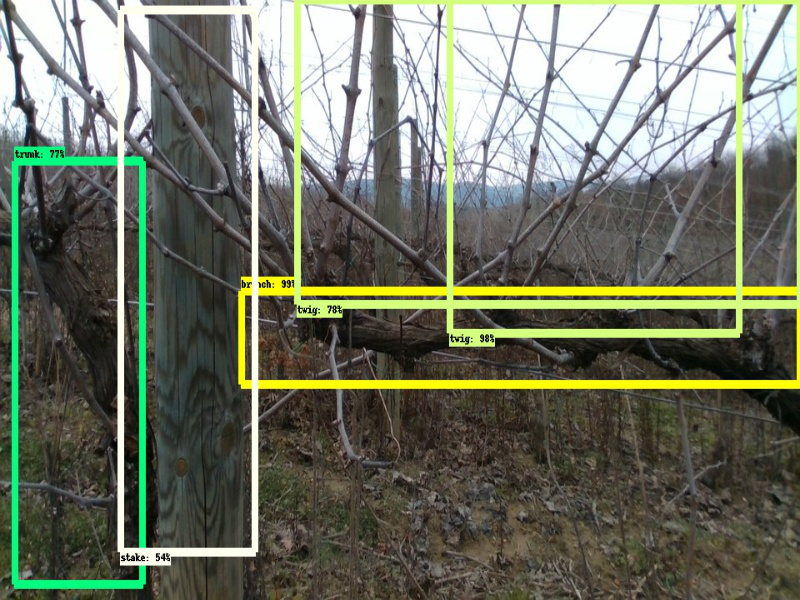

In [26]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import argparse
import cv2

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util


PATH_TO_CKPT = 'data/fine_tuned_model/frozen_inference_graph.pb'
PATH_TO_LABELS = 'data/label_map.pbtxt'

TEST_IMAGE_PATHS = 'img.jpg'
IMAGE_SIZE = (12, 8)


with open(PATH_TO_LABELS, 'r') as classes_file:
    content = classes_file.read()
num_classes = content.count('item {')
print('Set num_classes: ' + str(num_classes))

a = argparse.ArgumentParser()
a.add_argument("--image", default="img.jpg", help="path to image")
args = a.parse_args([])
image_np = cv2.imread(args.image)

detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)


with detection_graph.as_default():
  #DISABLE GPU IF OOM ERROR
#  config = tf.ConfigProto(device_count = {'GPU': 0})
#  with tf.Session(config=config, graph=detection_graph) as sess:
  with tf.Session(graph=detection_graph) as sess:
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
    detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
    detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
    detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')
    image_np_expanded = np.expand_dims(image_np, axis=0)
    (boxes, scores, classes, num) = sess.run(
        [detection_boxes, detection_scores, detection_classes, num_detections],
        feed_dict={image_tensor: image_np_expanded})
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        np.squeeze(boxes),
        np.squeeze(classes).astype(np.int32),
        np.squeeze(scores),
        category_index,
        use_normalized_coordinates=True,
        line_thickness=8)

    img_result = 'result.jpg'
    cv2.imwrite(img_result, cv2.resize(image_np, (800,600)))
    display(Image.open(img_result))

# Download trained model

In [27]:
from google.colab import files

files.download('data/label_map.pbtxt')
files.download('data/fine_tuned_model/frozen_inference_graph.pb')

print('Downloaded model files')

Downloaded model files
